### Set Up

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# formating
plot_size = (25,10) #set plot size (entire plot)

C:\Users\C23Price.Johnson\AppData\Local\Temp\ipykernel_18336\1042045778.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### Imports

In [3]:
import matplotlib
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn import linear_model, tree, ensemble

import keras
from numpy import mean
from matplotlib import pyplot
import statistics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import plot_roc_curve
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from keras.optimizers import RMSprop
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from keras.layers import Input, Dense, concatenate
from sklearn.metrics import f1_score, precision_score, recall_score

### Get Indicies function

In [4]:
# get indicies for time data
def get_indices(time_data, start_time, end_time):
    """Return indecies of time_data that are >= start_time and < end_time
    
    time_data  - np array of type float, time_data indices will correlate to
    start_time - float, a timestamp for the start
    end_time   - float, a timestamp for the end
    
    return     - a tuple of indices
    """
    return tuple(np.where(
        np.logical_and(
            np.greater_equal(time_data, start_time), np.less(time_data, end_time)
        ))[0])

### Get User Slice Function

In [5]:
def get_user_slice(target, subjects):
    '''return slice for user - the indicies
       Target - array you are slicing 
       Slices are done on target dataset, user must ensure data.shape matches
    '''
    subjects_slice = np.array([target == i for i in subjects]).any(axis=0) #or the list of lists

    return subjects_slice

### Participant Class That Stores Data

In [6]:
# participant class that holds datasets for all participants
class Participant:

    def __init__(self, baseline_fileName, coldpressor_fileName,  participantNumber):

        self.cutoff = 99999999 # instantiate max cutoff
        
        ########################################### Load Baseline Data ############################################
        
        baseline_input_data = pandas.read_csv(baseline_fileName) # read csv data
        self.unique_baseline_values = baseline_input_data["CH42"].unique() # store ibi values for the participant
        baseline_input_data.describe()
        baseline_data = baseline_input_data.values

        # store all values into Participant variables
        
        self.baseline_participantNumber = participantNumber #store participant number
        self.baseline_time = baseline_data[:,[0]] # store all rows, time column
        self.baseline_CH1 = baseline_data[:,[1]] # store all rows, channel 1 column (RSP, X, RSPEC-R / measure abdominal or thoracic expansion and contraction while breathing) measured in volts
        self.baseline_CH14 = baseline_data[:,[2]] # store all rows, channel 14 column (EDA, Y, PPGED-R / Electrodermal Activity) measured in microsiemens
        self.baseline_CH40 = baseline_data[:,[3]] # store all rows, channel 40 column (ECG R-R / Electrocardiogram) measured in seconds
        self.baseline_CH42 = baseline_data[:,[4]] # store all rows, channel 42 column (Respiration Rate / Heart rate) measured in BPM
        self.baseline_CH47 = baseline_data[:,[5]] # store all rows, channel 47 column (C7 - EDR / Electrodermal Response) measured in peaks
        self.baseline_CH54 = baseline_data[:,[6]] # store all rows, channel 54 column (C14 - Control) measured in volts
        
        # Put data into properly formatted array
        
        self.baseline_CH1 = self.baseline_CH1[:,0]
        self.baseline_CH14 = self.baseline_CH14[:,0]
        self.baseline_CH40 = self.baseline_CH40[:,0]
        self.baseline_CH42 = self.baseline_CH42[:,0]
        self.baseline_CH47 = self.baseline_CH47[:,0]
        self.baseline_CH54 = self.baseline_CH54[:,0]
            
        self.baseline_raw_data = baseline_data # store raw data
        
        # get sorted unix time and ibi to store into plotting variable
        
        baseline_data = baseline_data[:,[0,4]] # Get all rows, time and ibi columns
        baseline_data = baseline_data[baseline_data[:, 0].argsort()]  # Sort by time to ensure time is chronological
        self.baseline_unix_vs_ibi_for_plotting = baseline_data[:,[0,1]] #variable to be used for plotting
        
        
        # x-axis timing
    
        baseline_plot_width_seconds = baseline_data[0,0] - baseline_data[0,1] # store the time interval
        baseline_min_time = baseline_data[1,0] # store the lower time bound
        baseline_max_time = baseline_min_time + baseline_plot_width_seconds # store the max time bound

        # define indices and x values
        
        self.baseline_indices = get_indices(baseline_data[:,0], baseline_min_time, baseline_max_time) # get baseline indicies
        self.baseline_x_vals = [datetime.utcfromtimestamp(t/1000) for t in baseline_data[self.baseline_indices,0]] # convert to datetime objects
        
        # store baseline and coldpressor lengths
        
        self.baseline_data_length = len(self.baseline_unix_vs_ibi_for_plotting[:,1]) #store baseline length

        ########################################### Load Cold Pressor Data ############################################
        
        coldpressor_input_data = pandas.read_csv(coldpressor_fileName) # read csv data
        self.unique_coldpressor_values = coldpressor_input_data["CH42"].unique() # store heart rate values for the participant
        coldpressor_input_data.describe()
        coldpressor_data = coldpressor_input_data.values

        # store all values into Participant variables
        
        self.coldpressor_participantNumber = participantNumber #store participant number
        self.coldpressor_time = coldpressor_data[:,[0]] # store all rows, time column
        self.coldpressor_CH1 = coldpressor_data[:,[1]] # store all rows, channel 1 column (RSP, X, RSPEC-R / measure abdominal or thoracic expansion and contraction while breathing) measured in volts
        self.coldpressor_CH14 = coldpressor_data[:,[2]] # store all rows, channel 14 column (EDA, Y, PPGED-R / Electrodermal Activity) measured in microsiemens
        self.coldpressor_CH40 = coldpressor_data[:,[3]] # store all rows, channel 40 column (ECG R-R / Electrocardiogram) measured in seconds
        self.coldpressor_CH42 = coldpressor_data[:,[4]] # store all rows, channel 42 column (Respiration Rate / Heart rate) measured in BPM
        self.coldpressor_CH47 = coldpressor_data[:,[5]] # store all rows, channel 47 column (C7 - EDR / Electrodermal Response) measured in peaks
        self.coldpressor_CH54 = coldpressor_data[:,[6]] # store all rows, channel 54 column (C14 - Control) measured in volts
        
        # Put data into properly formatted array
        
        self.coldpressor_CH1 = self.coldpressor_CH1[:,0]
        self.coldpressor_CH14 = self.coldpressor_CH14[:,0]
        self.coldpressor_CH40 = self.coldpressor_CH40[:,0]
        self.coldpressor_CH42 = self.coldpressor_CH42[:,0]
        self.coldpressor_CH47 = self.coldpressor_CH47[:,0]
        self.coldpressor_CH54 = self.coldpressor_CH54[:,0]
        
        self.coldpressor_raw_data = coldpressor_data # store raw data
        
        # get sorted unix time and ibi to store into plotting variable
        
        coldpressor_data = coldpressor_data[:,[0,4]] # Get all rows, time and ibi columns
        coldpressor_data = coldpressor_data[coldpressor_data[:, 0].argsort()]  # Sort by time to ensure time is chronological
        self.coldpressor_unix_vs_ibi_for_plotting = coldpressor_data[:,[0,1]] #variable to be used for plotting
        
        # x-axis timing
    
        coldpressor_plot_width_seconds = coldpressor_data[0,0] - coldpressor_data[0,1] # store the time interval
        coldpressor_min_time = coldpressor_data[1,0] # store the lower time bound
        coldpressor_max_time = coldpressor_min_time + coldpressor_plot_width_seconds # store the max time bound

        # define indices and x values
        
        self.coldpressor_indices = get_indices(coldpressor_data[:,0], coldpressor_min_time, coldpressor_max_time) # get baseline indicies
        self.coldpressor_x_vals = [datetime.utcfromtimestamp(t/1000) for t in coldpressor_data[self.coldpressor_indices,0]] # convert to datetime objects
        
        # store baseline and coldpressor lengths
        
        self.coldpressor_data_length = len(self.coldpressor_unix_vs_ibi_for_plotting[:,1]) #store coldpressor length
        
    ############################################# Participant Methods ##################################################
    
    # plot participant baseline data
    
    def plot_baseline(self):
    
        # decorate
        fig = plt.figure(self.baseline_participantNumber)
        ax = plt.axes()
        plt.grid()
        plt.title("Participant " + str(self.baseline_participantNumber) + " Baseline Test")
        plt.xlabel('Time (Unix)', fontsize=15)
        plt.ylabel('IBI Measurement (ms)', fontsize=15)
        plt.rcParams['figure.figsize'] = plot_size

        indices = self.baseline_indices

        # plot
        plt.plot(self.baseline_x_vals,self.baseline_unix_vs_ibi_for_plotting[indices,1], 'o', linestyle = '--')
        plt.show()
        plt.close()
        
    # plot participant coldpressor data
    
    def plot_coldpressor(self):
    
        # decorate
        fig = plt.figure(self.coldpressor_participantNumber)
        ax = plt.axes()
        plt.grid()
        plt.title("Participant " + str(self.coldpressor_participantNumber) + " Cold Pressor Test")
        plt.xlabel('Time (Unix)', fontsize=15)
        plt.ylabel('IBI Measurement (ms)', fontsize=15)
        plt.rcParams['figure.figsize'] = plot_size

        indices = self.coldpressor_indices

        # plot
        plt.plot(self.coldpressor_x_vals,self.coldpressor_unix_vs_ibi_for_plotting[indices,1], 'o', linestyle = '--', color = 'ORANGE')
        plt.show()
        plt.close()
        
    # plot baseline and coldpressor data together
        
    def plot_both(self):
        
        # decorate
        fig = plt.figure(self.coldpressor_participantNumber)
        ax = plt.axes()
        plt.grid()
        plt.title("Participant " + str(self.coldpressor_participantNumber) + " Baseline And Cold Pressor Test")
        plt.xlabel('Time (Unix)', fontsize=15)
        plt.ylabel('IBI Measurement (ms)', fontsize=15)
        plt.rcParams['figure.figsize'] = plot_size
        
        baseline_indices = self.baseline_indices
        coldpressor_indices = self.coldpressor_indices

        # plot
        line1, = plt.plot(self.baseline_x_vals,self.baseline_unix_vs_ibi_for_plotting[baseline_indices,1], 'o', linestyle = '--', label = 'Baseline Test')
        line2, = plt.plot(self.coldpressor_x_vals,self.coldpressor_unix_vs_ibi_for_plotting[coldpressor_indices,1], 'o', linestyle = '--', color = 'ORANGE', label = 'Cold Pressor Test')
        
        # legend
        plt.legend(handles=[line1, line2], loc='upper left', fontsize = 'x-large')
        
        plt.show()
        plt.close()
        
######################################################## Normalize Functions ########################################################################
        
    # normalize CH1 baseline data
    
    def normalize_CH1_Baseline_Data(self):
        
        CH1_baseline_normalized_Data = self.baseline_CH1 #initialize baseline_normalizedData variable
        
        max_CH1_Baseline_Value = max(self.baseline_CH1) #set maxValue to highest value of ibi signals
        min_CH1_Baseline_Value = min(self.baseline_CH1) #set minValue to lowest value of ibi signals
        max_CH1_coldpressor_Value = max(self.coldpressor_CH1) #set maxValue to highest value of ibi signals
        min_CH1_coldpressor_Value = min(self.coldpressor_CH1) #set minValue to lowest value of ibi signals
        maxValue = max(max_CH1_Baseline_Value, max_CH1_coldpressor_Value)
        minValue = min(min_CH1_Baseline_Value, min_CH1_coldpressor_Value)
        
        
        numRows = len(self.baseline_raw_data) #get number of rows
        
        for i in range(numRows):
            CH1_baseline_normalized_Data[i] = (self.baseline_CH1[i] - minValue)/(maxValue-minValue)
        
        self.baseline_CH1 = CH1_baseline_normalized_Data
        
        return CH1_baseline_normalized_Data
    
    # normalize CH1 coldpressor data
        
    def normalize_CH1_Coldpressor_Data(self):
        
        CH1_coldpressor_normalized_Data = self.coldpressor_CH1 #initialize baseline_normalizedData variable
        
        max_CH1_Baseline_Value = max(self.baseline_CH1) #set maxValue to highest value of ibi signals
        min_CH1_Baseline_Value = min(self.baseline_CH1) #set minValue to lowest value of ibi signals
        max_CH1_coldpressor_Value = max(self.coldpressor_CH1) #set maxValue to highest value of ibi signals
        min_CH1_coldpressor_Value = min(self.coldpressor_CH1) #set minValue to lowest value of ibi signals
        maxValue = max(max_CH1_Baseline_Value, max_CH1_coldpressor_Value)
        minValue = min(min_CH1_Baseline_Value, min_CH1_coldpressor_Value)
        
        
        numRows = len(self.coldpressor_raw_data) #get number of rows
        
        for i in range(numRows):
            CH1_coldpressor_normalized_Data[i] = (self.coldpressor_CH1[i] - minValue)/(maxValue-minValue)
        
        self.coldpressor_CH1 = CH1_coldpressor_normalized_Data
        
        return CH1_coldpressor_normalized_Data
    
    
    # normalize CH14 baseline data

    def normalize_CH14_Baseline_Data(self):
        
        CH14_baseline_normalized_Data = self.baseline_CH14 #initialize baseline_normalizedData variable
        
        max_CH14_Baseline_Value = max(self.baseline_CH14) #set maxValue to highest value of ibi signals
        min_CH14_Baseline_Value = min(self.baseline_CH14) #set minValue to lowest value of ibi signals
        max_CH14_coldpressor_Value = max(self.coldpressor_CH14) #set maxValue to highest value of ibi signals
        min_CH14_coldpressor_Value = min(self.coldpressor_CH14) #set minValue to lowest value of ibi signals
        maxValue = max(max_CH14_Baseline_Value, max_CH14_coldpressor_Value)
        minValue = min(min_CH14_Baseline_Value, min_CH14_coldpressor_Value)
        
        
        numRows = len(self.baseline_raw_data) #get number of rows
        
        for i in range(numRows):
            CH14_baseline_normalized_Data[i] = (self.baseline_CH14[i] - minValue)/(maxValue-minValue)
        
        self.baseline_CH14 = CH14_baseline_normalized_Data
        
        return CH14_baseline_normalized_Data
    
    # normalize CH14 coldpressor data
        
    def normalize_CH14_Coldpressor_Data(self):
        
        CH14_coldpressor_normalized_Data = self.coldpressor_CH14 #initialize baseline_normalizedData variable
        
        max_CH14_Baseline_Value = max(self.baseline_CH14) #set maxValue to highest value of ibi signals
        min_CH14_Baseline_Value = min(self.baseline_CH14) #set minValue to lowest value of ibi signals
        max_CH14_coldpressor_Value = max(self.coldpressor_CH14) #set maxValue to highest value of ibi signals
        min_CH14_coldpressor_Value = min(self.coldpressor_CH14) #set minValue to lowest value of ibi signals
        maxValue = max(max_CH14_Baseline_Value, max_CH14_coldpressor_Value)
        minValue = min(min_CH14_Baseline_Value, min_CH14_coldpressor_Value)
        
        
        numRows = len(self.coldpressor_raw_data) #get number of rows
        
        for i in range(numRows):
            CH14_coldpressor_normalized_Data[i] = (self.coldpressor_CH14[i] - minValue)/(maxValue-minValue)
        
        self.coldpressor_CH14 = CH14_coldpressor_normalized_Data
        
        return CH14_coldpressor_normalized_Data
    
    # normalize CH40 baseline data
        
    def normalize_CH40_Baseline_Data(self):
        
        CH40_baseline_normalized_Data = self.baseline_CH40 #initialize baseline_normalizedData variable
        
        max_CH40_Baseline_Value = max(self.baseline_CH40) #set maxValue to highest value of ibi signals
        min_CH40_Baseline_Value = min(self.baseline_CH40) #set minValue to lowest value of ibi signals
        max_CH40_coldpressor_Value = max(self.coldpressor_CH40) #set maxValue to highest value of ibi signals
        min_CH40_coldpressor_Value = min(self.coldpressor_CH40) #set minValue to lowest value of ibi signals
        maxValue = max(max_CH40_Baseline_Value, max_CH40_coldpressor_Value)
        minValue = min(min_CH40_Baseline_Value, min_CH40_coldpressor_Value)
        
        
        numRows = len(self.baseline_raw_data) #get number of rows
        
        for i in range(numRows):
            CH40_baseline_normalized_Data[i] = (self.baseline_CH40[i] - minValue)/(maxValue-minValue)
        
        self.baseline_CH40 = CH40_baseline_normalized_Data
        
        return CH40_baseline_normalized_Data
    
    # normalize CH40 coldpressor data
        
    def normalize_CH40_Coldpressor_Data(self):
        
        CH40_coldpressor_normalized_Data = self.coldpressor_CH40 #initialize baseline_normalizedData variable
        
        max_CH40_Baseline_Value = max(self.baseline_CH40) #set maxValue to highest value of ibi signals
        min_CH40_Baseline_Value = min(self.baseline_CH40) #set minValue to lowest value of ibi signals
        max_CH40_coldpressor_Value = max(self.coldpressor_CH40) #set maxValue to highest value of ibi signals
        min_CH40_coldpressor_Value = min(self.coldpressor_CH40) #set minValue to lowest value of ibi signals
        maxValue = max(max_CH40_Baseline_Value, max_CH40_coldpressor_Value)
        minValue = min(min_CH40_Baseline_Value, min_CH40_coldpressor_Value)
        
        
        numRows = len(self.coldpressor_raw_data) #get number of rows
        
        for i in range(numRows):
            CH40_coldpressor_normalized_Data[i] = (self.coldpressor_CH40[i] - minValue)/(maxValue-minValue)
        
        self.coldpressor_CH40 = CH40_coldpressor_normalized_Data
        
        return CH40_coldpressor_normalized_Data
    
    # normalize CH42 baseline data
    
    def normalize_CH42_Baseline_Data(self):
        
        CH42_baseline_normalized_Data = self.baseline_CH42 #initialize baseline_normalizedData variable
        
        max_CH42_Baseline_Value = max(self.baseline_CH42) #set maxValue to highest value of ibi signals
        min_CH42_Baseline_Value = min(self.baseline_CH42) #set minValue to lowest value of ibi signals
        max_CH42_coldpressor_Value = max(self.coldpressor_CH42) #set maxValue to highest value of ibi signals
        min_CH42_coldpressor_Value = min(self.coldpressor_CH42) #set minValue to lowest value of ibi signals
        maxValue = max(max_CH42_Baseline_Value, max_CH42_coldpressor_Value)
        minValue = min(min_CH42_Baseline_Value, min_CH42_coldpressor_Value)
        
        numRows = len(self.baseline_raw_data) #get number of rows
        
        for i in range(numRows):
            CH42_baseline_normalized_Data[i] = (self.baseline_CH42[i] - minValue)/(maxValue-minValue)
        
        self.baseline_CH42 = CH42_baseline_normalized_Data
        
        return CH42_baseline_normalized_Data
    
    # normalize CH42 coldpressor data
        
    def normalize_CH42_Coldpressor_Data(self):
        
        CH42_coldpressor_normalized_Data = self.coldpressor_CH42 #initialize baseline_normalizedData variable
        
        max_CH42_Baseline_Value = max(self.baseline_CH42) #set maxValue to highest value of ibi signals
        min_CH42_Baseline_Value = min(self.baseline_CH42) #set minValue to lowest value of ibi signals
        max_CH42_coldpressor_Value = max(self.coldpressor_CH42) #set maxValue to highest value of ibi signals
        min_CH42_coldpressor_Value = min(self.coldpressor_CH42) #set minValue to lowest value of ibi signals
        maxValue = max(max_CH42_Baseline_Value, max_CH42_coldpressor_Value)
        minValue = min(min_CH42_Baseline_Value, min_CH42_coldpressor_Value)
        
        numRows = len(self.coldpressor_raw_data) #get number of rows
        
        for i in range(numRows):
            CH42_coldpressor_normalized_Data[i] = (self.coldpressor_CH42[i] - minValue)/(maxValue-minValue)
        
        self.coldpressor_CH42 = CH42_coldpressor_normalized_Data
        
        return CH42_coldpressor_normalized_Data
    
    # normalize CH47 baseline data
    
    def normalize_CH47_Baseline_Data(self):
        
        CH47_baseline_normalized_Data = self.baseline_CH47 #initialize baseline_normalizedData variable
        
        max_CH47_Baseline_Value = max(self.baseline_CH47) #set maxValue to highest value of ibi signals
        min_CH47_Baseline_Value = min(self.baseline_CH47) #set minValue to lowest value of ibi signals
        max_CH47_coldpressor_Value = max(self.coldpressor_CH47) #set maxValue to highest value of ibi signals
        min_CH47_coldpressor_Value = min(self.coldpressor_CH47) #set minValue to lowest value of ibi signals
        maxValue = max(max_CH47_Baseline_Value, max_CH47_coldpressor_Value)
        minValue = min(min_CH47_Baseline_Value, min_CH47_coldpressor_Value)
        
        numRows = len(self.baseline_raw_data) #get number of rows
        
        for i in range(numRows):
            CH47_baseline_normalized_Data[i] = (self.baseline_CH47[i] - minValue)/(maxValue-minValue)
        
        self.baseline_CH47 = CH47_baseline_normalized_Data
        
        return CH47_baseline_normalized_Data
    
    # normalize CH47 coldpressor data
        
    def normalize_CH47_Coldpressor_Data(self):
        
        CH47_coldpressor_normalized_Data = self.coldpressor_CH47 #initialize baseline_normalizedData variable
        
        max_CH47_Baseline_Value = max(self.baseline_CH47) #set maxValue to highest value of ibi signals
        min_CH47_Baseline_Value = min(self.baseline_CH47) #set minValue to lowest value of ibi signals
        max_CH47_coldpressor_Value = max(self.coldpressor_CH47) #set maxValue to highest value of ibi signals
        min_CH47_coldpressor_Value = min(self.coldpressor_CH47) #set minValue to lowest value of ibi signals
        maxValue = max(max_CH47_Baseline_Value, max_CH47_coldpressor_Value)
        minValue = min(min_CH47_Baseline_Value, min_CH47_coldpressor_Value)
        
        numRows = len(self.coldpressor_raw_data) #get number of rows
        
        for i in range(numRows):
            CH47_coldpressor_normalized_Data[i] = (self.coldpressor_CH47[i] - minValue)/(maxValue-minValue)
        
        self.coldpressor_CH47 = CH47_coldpressor_normalized_Data
        
        return CH47_coldpressor_normalized_Data
    
    # normalize CH54 baseline data
    
    def normalize_CH54_Baseline_Data(self):
        
        CH54_baseline_normalized_Data = self.baseline_CH54 #initialize baseline_normalizedData variable
        
        max_CH54_Baseline_Value = max(self.baseline_CH54) #set maxValue to highest value of ibi signals
        min_CH54_Baseline_Value = min(self.baseline_CH54) #set minValue to lowest value of ibi signals
        max_CH54_coldpressor_Value = max(self.coldpressor_CH54) #set maxValue to highest value of ibi signals
        min_CH54_coldpressor_Value = min(self.coldpressor_CH54) #set minValue to lowest value of ibi signals
        maxValue = max(max_CH54_Baseline_Value, max_CH54_coldpressor_Value)
        minValue = min(min_CH54_Baseline_Value, min_CH54_coldpressor_Value)
        
        numRows = len(self.baseline_raw_data) #get number of rows
        
        for i in range(numRows):
            CH54_baseline_normalized_Data[i] = (self.baseline_CH54[i] - minValue)/(maxValue-minValue)
        
        self.baseline_CH54 = CH54_baseline_normalized_Data
        
        return CH54_baseline_normalized_Data
    
    # normalize CH54 coldpressor data
        
    def normalize_CH54_Coldpressor_Data(self):
        
        CH54_coldpressor_normalized_Data = self.coldpressor_CH54 #initialize baseline_normalizedData variable
        
        max_CH54_Baseline_Value = max(self.baseline_CH54) #set maxValue to highest value of ibi signals
        min_CH54_Baseline_Value = min(self.baseline_CH54) #set minValue to lowest value of ibi signals
        max_CH54_coldpressor_Value = max(self.coldpressor_CH54) #set maxValue to highest value of ibi signals
        min_CH54_coldpressor_Value = min(self.coldpressor_CH54) #set minValue to lowest value of ibi signals
        maxValue = max(max_CH54_Baseline_Value, max_CH54_coldpressor_Value)
        minValue = min(min_CH54_Baseline_Value, min_CH54_coldpressor_Value)
        
        numRows = len(self.coldpressor_raw_data) #get number of rows
        
        for i in range(numRows):
            CH54_coldpressor_normalized_Data[i] = (self.coldpressor_CH54[i] - minValue)/(maxValue-minValue)
        
        self.coldpressor_CH54 = CH54_coldpressor_normalized_Data
        
        return CH54_coldpressor_normalized_Data
    
#     def normalize_all_data(self):
        
#         self.normalize_CH1_Baseline_Data()
#         self.normalize_CH1_Coldpressor_Data()
        
#         self.normalize_CH14_Baseline_Data()
#         self.normalize_CH14_Coldpressor_Data()
        
#         self.normalize_CH40_Baseline_Data()
#         self.normalize_CH40_Coldpressor_Data()
        
#         self.normalize_CH42_Baseline_Data()
#         self.normalize_CH42_Coldpressor_Data()
        
#         self.normalize_CH47_Baseline_Data()
#         self.normalize_CH47_Coldpressor_Data()
        
#         self.normalize_CH54_Baseline_Data()
#         self.normalize_CH54_Coldpressor_Data()
        
    def normalize_all_data(self):
        
#         # calculate the L2 norm of the array
#         arr_norm = np.linalg.norm(self.baseline_CH1)

#         # divide the array by its L2 norm to normalize it
#         if arr_norm == 0:
#             normalized_arr = self.baseline_CH1
#         else:
#             normalized_arr = self.baseline_CH1 / arr_norm

#         self.baseline_CH1 = normalized_arr
        
        min_val = np.min(self.baseline_CH1)
        max_val = np.max(self.baseline_CH1)

        # normalize the array using Min-Max scaling
        self.baseline_CH1 = (self.baseline_CH1 - min_val) / (max_val - min_val)
        
        # calculate the L2 norm of the array
        arr_norm = np.linalg.norm(self.baseline_CH14)

        # divide the array by its L2 norm to normalize it
        if arr_norm == 0:
            normalized_arr = self.baseline_CH14
        else:
            normalized_arr = self.baseline_CH14 / arr_norm

        self.baseline_CH14 = normalized_arr
        
        # calculate the L2 norm of the array
        arr_norm = np.linalg.norm(self.baseline_CH40)

        # divide the array by its L2 norm to normalize it
        if arr_norm == 0:
            normalized_arr = self.baseline_CH40
        else:
            normalized_arr = self.baseline_CH40 / arr_norm

        self.baseline_CH40 = normalized_arr
        
        # calculate the L2 norm of the array
        arr_norm = np.linalg.norm(self.baseline_CH42)

        # divide the array by its L2 norm to normalize it
        if arr_norm == 0:
            normalized_arr = self.baseline_CH42
        else:
            normalized_arr = self.baseline_CH42 / arr_norm

        self.baseline_CH42 = normalized_arr
        
        # calculate the L2 norm of the array
        arr_norm = np.linalg.norm(self.baseline_CH47)

        # divide the array by its L2 norm to normalize it
        if arr_norm == 0:
            normalized_arr = self.baseline_CH47
        else:
            normalized_arr = self.baseline_CH47 / arr_norm

        self.baseline_CH47 = normalized_arr
        
        # calculate the L2 norm of the array
        arr_norm = np.linalg.norm(self.baseline_CH54)

        # divide the array by its L2 norm to normalize it
        if arr_norm == 0:
            normalized_arr = self.baseline_CH54
        else:
            normalized_arr = self.baseline_CH54 / arr_norm

        self.baseline_CH54 = normalized_arr
        
#         # calculate the L2 norm of the array
#         arr_norm = np.linalg.norm(self.coldpressor_CH1)

#         # divide the array by its L2 norm to normalize it
#         if arr_norm == 0:
#             normalized_arr = self.coldpressor_CH1
#         else:
#             normalized_arr = self.coldpressor_CH1 / arr_norm

#         self.coldpressor_CH1 = normalized_arr

        min_val = np.min(self.coldpressor_CH1)
        max_val = np.max(self.coldpressor_CH1)

        # normalize the array using Min-Max scaling
        self.coldpressor_CH1 = (self.coldpressor_CH1 - min_val) / (max_val - min_val)
        
        # calculate the L2 norm of the array
        arr_norm = np.linalg.norm(self.coldpressor_CH14)

        # divide the array by its L2 norm to normalize it
        if arr_norm == 0:
            normalized_arr = self.coldpressor_CH14
        else:
            normalized_arr = self.coldpressor_CH14 / arr_norm

        self.coldpressor_CH14 = normalized_arr
        
        # calculate the L2 norm of the array
        arr_norm = np.linalg.norm(self.coldpressor_CH40)

        # divide the array by its L2 norm to normalize it
        if arr_norm == 0:
            normalized_arr = self.coldpressor_CH40
        else:
            normalized_arr = self.coldpressor_CH40 / arr_norm

        self.coldpressor_CH40 = normalized_arr
        
        # calculate the L2 norm of the array
        arr_norm = np.linalg.norm(self.coldpressor_CH42)

        # divide the array by its L2 norm to normalize it
        if arr_norm == 0:
            normalized_arr = self.coldpressor_CH42
        else:
            normalized_arr = self.coldpressor_CH42 / arr_norm

        self.coldpressor_CH42 = normalized_arr
        
        # calculate the L2 norm of the array
        arr_norm = np.linalg.norm(self.coldpressor_CH47)

        # divide the array by its L2 norm to normalize it
        if arr_norm == 0:
            normalized_arr = self.coldpressor_CH47
        else:
            normalized_arr = self.coldpressor_CH47 / arr_norm

        self.coldpressor_CH47 = normalized_arr
        
        # calculate the L2 norm of the array
        arr_norm = np.linalg.norm(self.coldpressor_CH54)

        # divide the array by its L2 norm to normalize it
        if arr_norm == 0:
            normalized_arr = self.coldpressor_CH54
        else:
            normalized_arr = self.coldpressor_CH54 / arr_norm

        self.coldpressor_CH54 = normalized_arr
        

############################################################# Split Data ##########################################################################
    
    # method for splitting and keeping to the left of the cutoff
        
    def splitDataKeepLeft(self, cutoff):
    
        self.baseline_CH1 = np.delete(self.baseline_CH1, slice(cutoff,len(self.baseline_CH1)), axis=0)
        self.coldpressor_CH1 = np.delete(self.coldpressor_CH1, slice(cutoff,len(self.coldpressor_CH1)), axis=0)

        self.baseline_CH14 = np.delete(self.baseline_CH14, slice(cutoff,len(self.baseline_CH14)), axis=0)
        self.coldpressor_CH14 = np.delete(self.coldpressor_CH14, slice(cutoff,len(self.coldpressor_CH14)), axis=0)

        self.baseline_CH40 = np.delete(self.baseline_CH40, slice(cutoff,len(self.baseline_CH40)), axis=0)
        self.coldpressor_CH40 = np.delete(self.coldpressor_CH40, slice(cutoff,len(self.coldpressor_CH40)), axis=0)

        self.baseline_CH42 = np.delete(self.baseline_CH42, slice(cutoff,len(self.baseline_CH42)), axis=0)
        self.coldpressor_CH42 = np.delete(self.coldpressor_CH42, slice(cutoff,len(self.coldpressor_CH42)), axis=0)

        self.baseline_CH47 = np.delete(self.baseline_CH47, slice(cutoff,len(self.baseline_CH47)), axis=0)
        self.coldpressor_CH47 = np.delete(self.coldpressor_CH47, slice(cutoff,len(self.coldpressor_CH47)), axis=0)

        self.baseline_CH54 = np.delete(self.baseline_CH54, slice(cutoff,len(self.baseline_CH54)), axis=0)
        self.coldpressor_CH54 = np.delete(self.coldpressor_CH54, slice(cutoff,len(self.coldpressor_CH54)), axis=0)

        self.baseline_data_length = len(self.baseline_CH40)
        self.coldpressor_data_length = len(self.coldpressor_CH40)
            
    # method for splitting and keeping to the right of the cutoff
        
    def splitDataKeepRight(self, cutoff):
        
        self.baseline_CH1 = np.delete(self.baseline_CH1, slice(0, len(self.baseline_CH1)-cutoff), axis=0)
        self.coldpressor_CH1 = np.delete(self.coldpressor_CH1, slice(0, len(self.coldpressor_CH1)-cutoff), axis=0)

        self.baseline_CH14 = np.delete(self.baseline_CH14, slice(0, len(self.baseline_CH14)-cutoff), axis=0)
        self.coldpressor_CH14 = np.delete(self.coldpressor_CH14, slice(0, len(self.coldpressor_CH14)-cutoff), axis=0)

        self.baseline_CH40 = np.delete(self.baseline_CH40, slice(0, len(self.baseline_CH40)-cutoff), axis=0)
        self.coldpressor_CH40 = np.delete(self.coldpressor_CH40, slice(0, len(self.coldpressor_CH40)-cutoff), axis=0)

        self.baseline_CH42 = np.delete(self.baseline_CH42, slice(0, len(self.baseline_CH42)-cutoff), axis=0)
        self.coldpressor_CH42 = np.delete(self.coldpressor_CH42, slice(0, len(self.coldpressor_CH42)-cutoff), axis=0)

        self.baseline_CH47 = np.delete(self.baseline_CH47, slice(0, len(self.baseline_CH47)-cutoff), axis=0)
        self.coldpressor_CH47 = np.delete(self.coldpressor_CH47, slice(0, len(self.coldpressor_CH47)-cutoff), axis=0)

        self.baseline_CH54 = np.delete(self.baseline_CH54, slice(0, len(self.baseline_CH54)-cutoff), axis=0)
        self.coldpressor_CH54 = np.delete(self.coldpressor_CH54, slice(0, len(self.coldpressor_CH54)-cutoff), axis=0)

        self.baseline_data_length = len(self.baseline_CH40)
        self.coldpressor_data_length = len(self.coldpressor_CH40)

            
    ############################################# Getter and Setter Methods ##################################################
        
    # id getter method
    def get_baseline_unix_vs_ibi_for_plotting(self):
        return self.baseline_unix_vs_ibi_for_plotting

    # user_id getter method
    def getUser_ID(self):
        return self.user_id

    # unix_in_ms getter method
    def getUnix_in_ms(self):
        return self.unix_in_ms

    # ibi getter method
    def getIbi(self):
        return self.ibi
    
    # ibi getter method
    def getData(self):
        return self.baseline_CH40

    # id setter method
    def setID(self, id):
        self.id = id

    # user_id setter method
    def setUser_ID(self, user_id):
        self.user_id = user_id

    # unix_in_ms setter method
    def setUnix_in_ms(self, unix_in_ms):
        self.unix_in_ms = unix_in_ms

    # ibi setter method
    def setIbi(self, ibi):
        self.ibi = ibi
        
    def getBaselineCH40Size(self):
        return len(self.baseline_CH40)
    
    def getColdpressorCH40Size(self):
        return len(self.coldpressor_CH40)

### Get BIOPAC Data

In [7]:
#init BIOPAC participants
participants = []
participants = [Participant for i in range(62)]

#store all participant data
n = 1
while (n<=61):
    if((n != 4) and (n != 43) and (n != 44) and (n!= 47)): # No participants 3, 42, 43
        filename_incrementer = 1000 + ((n-1) * 100) # Filenames are wierdly named so this variable assigns an n to the number in the filename 
        participants[n] = Participant(".\\raw_data\\raw_data_biopac\\" + str(filename_incrementer) + "-BL.csv",
                                      ".\\raw_data\\raw_data_biopac\\" + str(filename_incrementer) + "-SECPT.csv",n)
    n = n + 1

### Normalize BIOPAC Data

In [8]:
# Normalize BIOPAC IBI values

n = 1
while (n<=61):
    if((n != 4) and (n != 43) and (n != 44) and (n!= 47)): # No participants 3, 42, 43
        participants[n].normalize_all_data()
    n = n + 1



### Data statistics

In [9]:
#initiate variables
baselineTotal = 0
coldPressorTotal = 0
numParticipants = 0
smallestBaselineSize = 99999999
smallestColdpressorSize = 99999999
numberOfUsableParticipants = 0

# set a cutoff here
cutoff = 10000
    
# get average number of baseline and coldpressor datapoints
n = 1
while (n<=61):
    if((n != 4) and (n != 43) and (n != 44) and (n!= 47)): #No participants 2,17-31. Participant 5 has missing values
        baselineTotal = baselineTotal + participants[n].getBaselineCH40Size()
        coldPressorTotal = coldPressorTotal + participants[n].getColdpressorCH40Size()
        numParticipants = numParticipants + 1        
        smallestBaselineSize = min(smallestBaselineSize, participants[n].getBaselineCH40Size())
        smallestColdpressorSize = min(smallestColdpressorSize, participants[n].getColdpressorCH40Size())
    n = n + 1

# round data to 0 decimals points
averageNumberOfBaselineDatapoints = round((baselineTotal / numParticipants), 0)
averageNumberOfColdpressorDatapoints = round((coldPressorTotal / numParticipants), 0)

# print data statistics
print("Cutoff: " + str(cutoff))
print("Average Number of Baseline datapoints per Sample: " + str(averageNumberOfBaselineDatapoints))
print("Average Number of Coldpressor datapoints per Sample: " + str(averageNumberOfColdpressorDatapoints))
print("Smallest Baseline Sample Size: " + str(smallestBaselineSize))
print("Smallest Coldpressor Sample Size: " + str(smallestColdpressorSize))

Cutoff: 10000
Average Number of Baseline datapoints per Sample: 148408.0
Average Number of Coldpressor datapoints per Sample: 67505.0
Smallest Baseline Sample Size: 1500
Smallest Coldpressor Sample Size: 911


### Cut Participant Data Based on Cutoff

In [10]:
# Get all usable participant data if length > cutoff
usableParticipants = [Participant for i in range(1)]
n = 1

# check to see participant has enough data points
while (n<=61 and participants[n] != None):
    if((n != 4) and (n != 43) and (n != 44) and (n!= 47)): #No participants 2,17-31. Participant 5 has missing values
        if(((participants[n].getBaselineCH40Size() >= cutoff) and (participants[n].getColdpressorCH40Size() >= cutoff)) or (not participants[n])):
            usableParticipants.append(participants[n])
            numberOfUsableParticipants = numberOfUsableParticipants + 1
    n = n + 1

# cut data for every participant
n = 1
while (n<=numberOfUsableParticipants):
    usableParticipants[n].splitDataKeepLeft(cutoff)
    n = n + 1
    
# print results
print("Cutoff: " + str(cutoff))
print("Number of Usable Participants: " + str(numberOfUsableParticipants))

Cutoff: 10000
Number of Usable Participants: 56


### Create a 2D Array of Samples

In [11]:
usableParticipantsData = []

tmp_array = []
n = 1
while ((n<=numberOfUsableParticipants)):
    
    tmp_array = usableParticipants[n].baseline_CH1
    tmp_array = np.vstack((tmp_array,usableParticipants[n].baseline_CH14))
    tmp_array = np.vstack((tmp_array,usableParticipants[n].baseline_CH40))
    tmp_array = np.vstack((tmp_array,usableParticipants[n].baseline_CH42))
    tmp_array = np.vstack((tmp_array,usableParticipants[n].baseline_CH47))
    tmp_array = np.vstack((tmp_array,usableParticipants[n].baseline_CH54))
    
    usableParticipantsData.append(tmp_array)
    
    n = n + 1

tmp_array = []
n = 1
while ((n<=numberOfUsableParticipants)):
    
    tmp_array = usableParticipants[n].coldpressor_CH1
    tmp_array = np.vstack((tmp_array,usableParticipants[n].coldpressor_CH14))
    tmp_array = np.vstack((tmp_array,usableParticipants[n].coldpressor_CH40))
    tmp_array = np.vstack((tmp_array,usableParticipants[n].coldpressor_CH42))
    tmp_array = np.vstack((tmp_array,usableParticipants[n].coldpressor_CH47))
    tmp_array = np.vstack((tmp_array,usableParticipants[n].coldpressor_CH54))
    
    usableParticipantsData.append(tmp_array)
    n = n + 1

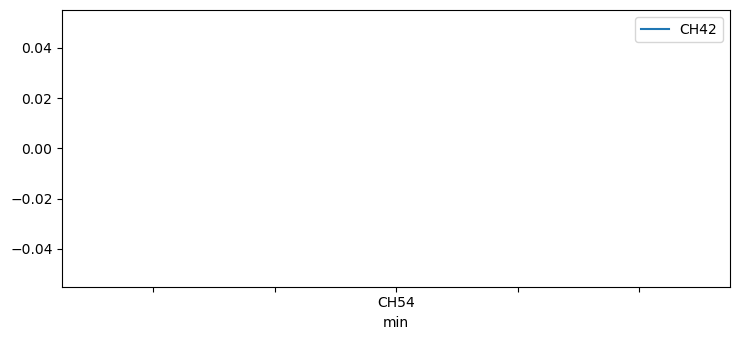

In [12]:
# filename = ".\\raw_data\\raw_data_biopac\\" + str(1000) + "-SECPT.csv"
# # coldpressor_input_data = pandas.read_csv(fileName) # read csv data

# plt.rcParams["figure.figsize"] = [7.50, 3.50]
# plt.rcParams["figure.autolayout"] = True

# headers = ['min','CH42']

# df = pd.read_csv(filename, names=headers, low_memory=False)

# df.set_index('min').plot()

# plt.show()

### Get an Array of Usable Participants

In [13]:
# create samples and labels array based on usable participants
samples = usableParticipantsData
labels = [0 for x in range(0, numberOfUsableParticipants)]

# Initialize ID array
ID = []
n = 1
while (n<=numberOfUsableParticipants):
    ID.append(n)
    n = n + 1

n = 1
while (n<=numberOfUsableParticipants):
    labels.append(1)
    ID.append(n)
    n = n + 1
    
# parallel arrays, same indicies
samples = np.array(samples).astype(np.float32)
labels = np.array(labels)
ID = np.array(ID) # save subjects IDs

### Split into Train, Test, and Validate Sets

In [14]:
subjects = ID[0:numberOfUsableParticipants] # subjects to shuffle on
numSamples = numberOfUsableParticipants*2

cut = .2

np.random.shuffle(subjects) # shuffle participants to ensure different results
split_count = int(cut * numberOfUsableParticipants) # porportion of train and test splits

#indicies from 0 to split_count
validation_indicies = get_user_slice(target=ID, subjects=subjects[0:split_count]) 

#indicies from split_count to 2xsplit_count
test_indicies = get_user_slice(target=ID, subjects=subjects[split_count:2 * split_count]) 
train_indicies = np.invert(np.array([test_indicies,validation_indicies]).any(axis=0))

# save train, test, and validation sets
train_x = samples[train_indicies]
train_y = labels[train_indicies]
val_x   = samples[validation_indicies]
val_y   = labels[validation_indicies]
test_x  = samples[test_indicies]
test_y  = labels[test_indicies]

# save k-fold subjects, indicies, and IDs
kfold_subjects = subjects
k_fold_IDs_indicies = np.invert(np.array(test_indicies))
k_fold_IDs = ID[k_fold_IDs_indicies]

# temp array of subjects to use for k-fold function
temp_array = subjects[split_count:2 * split_count]

# get list of k-fold subjects
i = 0
j = 0
while i < (kfold_subjects.size): # for all subjects
    j = 0
    while j < (temp_array.size): # for all subjects in training set
        if(kfold_subjects[i] == temp_array[j]):
            kfold_subjects = np.delete(kfold_subjects,i) # delete subject in training set from k-fold subjects
        j = j + 1
    i = i + 1

# print statistics
print("Cutoff: " + str(cutoff))
print((1-(2*cut)) * 100, "% Training shape:", train_x.shape)
print(cut * 100, "% Testing shape:", test_x.shape)
print(cut * 100, "% Validation shape:", val_x.shape)
print((1-(2*cut)) * 100, "% Training labels shape:", train_y.shape)
print(cut * 100, "% Testing labels shape:", test_y.shape)
print(cut * 100, "% Validation labels shape:", val_y.shape)

Cutoff: 10000
60.0 % Training shape: (68, 6, 10000)
20.0 % Testing shape: (22, 6, 10000)
20.0 % Validation shape: (22, 6, 10000)
60.0 % Training labels shape: (68,)
20.0 % Testing labels shape: (22,)
20.0 % Validation labels shape: (22,)


### Reshape Data for Functional and Conv2D Models

In [15]:
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1] * train_x.shape[2])
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1] * test_x.shape[2])
val_x = val_x.reshape(val_x.shape[0], val_x.shape[1] * val_x.shape[2])

# Put Data in Proper Format
channel_1_data = []
channel_14_data = []
channel_40_data = []
channel_42_data = []
channel_47_data = []
channel_54_data = []

n = 1
while (n<=numberOfUsableParticipants):
    channel_1_data.append(usableParticipants[n].baseline_CH1)
    channel_14_data.append(usableParticipants[n].baseline_CH14)
    channel_40_data.append(usableParticipants[n].baseline_CH40)
    channel_42_data.append(usableParticipants[n].baseline_CH42)
    channel_47_data.append(usableParticipants[n].baseline_CH47)
    channel_54_data.append(usableParticipants[n].baseline_CH54)
    n = n + 1
    
n = 1
while (n<=numberOfUsableParticipants):
    channel_1_data.append(usableParticipants[n].coldpressor_CH1)
    channel_14_data.append(usableParticipants[n].coldpressor_CH14)
    channel_40_data.append(usableParticipants[n].coldpressor_CH40)
    channel_42_data.append(usableParticipants[n].coldpressor_CH42)
    channel_47_data.append(usableParticipants[n].coldpressor_CH47)
    channel_54_data.append(usableParticipants[n].coldpressor_CH54)
    n = n + 1

channel_1_samples = np.asarray(channel_1_data)
channel_14_samples = np.asarray(channel_14_data)
channel_40_samples = np.asarray(channel_40_data)
channel_42_samples = np.asarray(channel_42_data)
channel_47_samples = np.asarray(channel_47_data)
channel_54_samples = np.asarray(channel_54_data)

### Train-Test Split for Functional and Conv2D models

In [41]:
subjects = ID[0:numberOfUsableParticipants] # subjects to shuffle on
numSamples = numberOfUsableParticipants*2

np.random.shuffle(subjects) # shuffle participants to ensure different results

cut = .2

# np.random.shuffle(subjects) # shuffle participants to ensure different results
split_count = int(cut * numberOfUsableParticipants) # porportion of train and test splits

#indicies from 0 to split_count
validation_indicies = get_user_slice(target=ID, subjects=subjects[0:split_count]) 

#indicies from split_count to 2xsplit_count
test_indicies = get_user_slice(target=ID, subjects=subjects[split_count:2 * split_count]) 
train_indicies = np.invert(np.array([test_indicies,validation_indicies]).any(axis=0))

# save train, test, and validation sets
channel_1_train_x = channel_1_samples[train_indicies]
channel_1_train_y = labels[train_indicies]
channel_1_val_x   = channel_1_samples[validation_indicies]
channel_1_val_y   = labels[validation_indicies]
channel_1_test_x  = channel_1_samples[test_indicies]
channel_1_test_y  = labels[test_indicies]

# save train, test, and validation sets
channel_14_train_x = channel_14_samples[train_indicies]
channel_14_train_y = labels[train_indicies]
channel_14_val_x   = channel_14_samples[validation_indicies]
channel_14_val_y   = labels[validation_indicies]
channel_14_test_x  = channel_14_samples[test_indicies]
channel_14_test_y  = labels[test_indicies]

# save train, test, and validation sets
channel_40_train_x = channel_40_samples[train_indicies]
channel_40_train_y = labels[train_indicies]
channel_40_val_x   = channel_40_samples[validation_indicies]
channel_40_val_y   = labels[validation_indicies]
channel_40_test_x  = channel_40_samples[test_indicies]
channel_40_test_y  = labels[test_indicies]

# save train, test, and validation sets
channel_42_train_x = channel_42_samples[train_indicies]
channel_42_train_y = labels[train_indicies]
channel_42_val_x   = channel_42_samples[validation_indicies]
channel_42_val_y   = labels[validation_indicies]
channel_42_test_x  = channel_42_samples[test_indicies]
channel_42_test_y  = labels[test_indicies]

# save train, test, and validation sets
channel_47_train_x = channel_47_samples[train_indicies]
channel_47_train_y = labels[train_indicies]
channel_47_val_x   = channel_47_samples[validation_indicies]
channel_47_val_y   = labels[validation_indicies]
channel_47_test_x  = channel_47_samples[test_indicies]
channel_47_test_y  = labels[test_indicies]

# save train, test, and validation sets
channel_54_train_x = channel_54_samples[train_indicies]
channel_54_train_y = labels[train_indicies]
channel_54_val_x   = channel_54_samples[validation_indicies]
channel_54_val_y   = labels[validation_indicies]
channel_54_test_x  = channel_54_samples[test_indicies]
channel_54_test_y  = labels[test_indicies]

channel_1_train_x[:, :, np.newaxis]
channel_14_train_x[:, :, np.newaxis]
channel_40_train_x[:, :, np.newaxis]
channel_42_train_x[:, :, np.newaxis]
channel_47_train_x[:, :, np.newaxis]
channel_40_train_x[:, :, np.newaxis]

channel_1_val_x[:, :, np.newaxis]
channel_14_val_x[:, :, np.newaxis]
channel_40_val_x[:, :, np.newaxis]
channel_42_val_x[:, :, np.newaxis]
channel_47_val_x[:, :, np.newaxis]
channel_40_val_x[:, :, np.newaxis]

# print statistics
print("Cutoff: " + str(cutoff))
print((1-(2*cut)) * 100, "% Training shape:", channel_1_train_x.shape)
print(cut * 100, "% Testing shape:", channel_1_test_x.shape)
print(cut * 100, "% Validation shape:", channel_1_val_x.shape)
print((1-(2*cut)) * 100, "% Training labels shape:", channel_1_train_y.shape)
print(cut * 100, "% Testing labels shape:", channel_1_test_y.shape)
print(cut * 100, "% Validation labels shape:", channel_1_val_y.shape)

Cutoff: 10000
60.0 % Training shape: (68, 10000)
20.0 % Testing shape: (22, 10000)
20.0 % Validation shape: (22, 10000)
60.0 % Training labels shape: (68,)
20.0 % Testing labels shape: (22,)
20.0 % Validation labels shape: (22,)


In [46]:
def Conv1D_Model():
    from tensorflow.keras import layers
    from tensorflow.keras import regularizers

    batch_size = 1

    # define input layers
    input1 = Input(shape=(cutoff, 1))
    input2 = Input(shape=(cutoff, 1))
    input3 = Input(shape=(cutoff, 1))
    input4 = Input(shape=(cutoff, 1))
    input5 = Input(shape=(cutoff, 1))
    input6 = Input(shape=(cutoff, 1))

    kernel_size = 20

    # Add more layers and get rid of 1 max pooling layer for each modality
    # Tune hyperparameters with each modality and find which ones work best with individual modalities

    # Reread paper
    # Include in slides what I learned from paper / last semester


    # # define the convolutional layers for the channel 1 modality
    # channel_1_conv1 = layers.Conv1D(8, kernel_size, activation='relu', input_shape=(cutoff, 1))(input1)
    # channel_1_pool1 = layers.MaxPooling1D(pool_size=2)(channel_1_conv1)
    # channel_1_conv2 = layers.Conv1D(8, kernel_size, activation='relu')(channel_1_pool1)
    # channel_1_pool2 = layers.MaxPooling1D(pool_size=1)(channel_1_conv2)
    # channel_1_flatten = Flatten()(channel_1_pool2)
    # channel_1_dropout = Dropout(0.5)(channel_1_flatten)

    # define the convolutional layers for the channel 14 modality
    channel_14 = layers.Conv1D(16, kernel_size, activation='relu', input_shape=(cutoff, 1), kernel_initializer = 'he_normal', kernel_regularizer =regularizers.l2(0.5))(input2)
    channel_14 = layers.MaxPooling1D(pool_size=3)(channel_14)
    channel_14 = layers.Conv1D(8, kernel_size, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer =regularizers.l2(0.5))(channel_14)
    channel_14 = layers.MaxPooling1D(pool_size=2)(channel_14)
    channel_14 = layers.Conv1D(4, kernel_size, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer =regularizers.l2(0.5))(channel_14)
    channel_14 = layers.MaxPooling1D(pool_size=1)(channel_14)
    channel_14 = Flatten()(channel_14)
    channel_14_dropout = Dropout(0.5)(channel_14)
    
    channel_14_min = tf.keras.backend.min(channel_14_dropout, axis=-1, keepdims=True)
    channel_14_max = tf.keras.backend.max(channel_14_dropout, axis=-1, keepdims=True)
    channel_14_mean = tf.keras.backend.mean(channel_14_dropout, axis=-1, keepdims=True)
    channel_14_std = tf.keras.backend.std(channel_14_dropout, axis=-1, keepdims=True)
    channel_14_merged = tf.keras.backend.concatenate([channel_14_min, channel_14_max, channel_14_mean, channel_14_std], axis = -1)

    # # define the convolutional layers for the channel 40 modality
    # channel_40_conv1 = layers.Conv1D(8, kernel_size, activation='relu', input_shape=(cutoff, 1))(input3)
    # channel_40_pool1 = layers.MaxPooling1D(pool_size=2)(channel_40_conv1)
    # channel_40_conv2 = layers.Conv1D(8, kernel_size, activation='relu')(channel_40_pool1)
    # channel_40_pool2 = layers.MaxPooling1D(pool_size=1)(channel_40_conv2)
    # channel_40_flatten = Flatten()(channel_40_pool2)
    # channel_40_dropout = Dropout(0.5)(channel_40_flatten)

    # define the convolutional layers for the channel 42 modality
    channel_42 = layers.Conv1D(2, kernel_size, activation='relu', input_shape=(cutoff, 1), kernel_initializer = 'he_normal', kernel_regularizer=regularizers.l2(0.5))(input4)
    channel_42 = layers.MaxPooling1D(pool_size=1)(channel_42)
    channel_42 = layers.Conv1D(2, kernel_size, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = 'l1')(channel_42)
    channel_42 = layers.MaxPooling1D(pool_size=1)(channel_42)
    channel_42 = Flatten()(channel_42)
    channel_42_dropout = Dropout(0.5)(channel_42)
    
    channel_42_min = tf.keras.backend.min(channel_42_dropout, axis=-1, keepdims=True)
    channel_42_max = tf.keras.backend.max(channel_42_dropout, axis=-1, keepdims=True)
    channel_42_mean = tf.keras.backend.mean(channel_42_dropout, axis=-1, keepdims=True)
    channel_42_std = tf.keras.backend.std(channel_42_dropout, axis=-1, keepdims=True)
    channel_42_merged = tf.keras.backend.concatenate([channel_42_min, channel_42_max, channel_42_mean, channel_42_std], axis = -1)

    # # define the convolutional layers for the channel 47 modality
    # channel_47_conv1 = layers.Conv1D(8, kernel_size, activation='relu', input_shape=(cutoff, 1))(input5)
    # channel_47_pool1 = layers.MaxPooling1D(pool_size=2)(channel_47_conv1)
    # channel_47_conv2 = layers.Conv1D(8, kernel_size, activation='relu')(channel_47_pool1)
    # channel_47_pool2 = layers.MaxPooling1D(pool_size=1)(channel_47_conv2)
    # channel_47_flatten = Flatten()(channel_47_pool2)
    # channel_47_dropout = Dropout(0.5)(channel_47_flatten)

    # # define the convolutional layers for the channel 52 modality
    # channel_54_conv1 = layers.Conv1D(8, kernel_size, activation='relu', input_shape=(cutoff, 1))(input6)
    # # channel_54_conv1 = tf.squeeze(channel_54_conv1, axis=0)
    # channel_54_pool1 = layers.MaxPooling1D(pool_size=2)(channel_54_conv1)
    # channel_54_conv2 = layers.Conv1D(8, kernel_size, activation='relu')(channel_54_pool1)
    # channel_54_pool2 = layers.MaxPooling1D(pool_size=1)(channel_54_conv2)
    # channel_54_flatten = Flatten()(channel_54_pool2)
    # channel_54_dropout = Dropout(0.5)(channel_54_flatten)
    
    #print(channel_42_min.shape)

    # combine the two modalities into a single model
    merged = tf.keras.backend.concatenate([channel_14_merged, channel_42_merged]) #channel_14_dropout, channel_42_dropout]
    
#     min_merged = concatenate([channel_14_min, channel_42_min])
#     max_merged = concatenate([channel_14_max, channel_42_max])
#     mean_merged = concatenate([channel_14_mean, channel_42_mean])
#     std_merged = concatenate([channel_14_std, channel_42_std])

#     merged = Dense(16, activation='relu',kernel_initializer = 'he_normal', kernel_regularizer = 'l1')(merged)
#     merged = Dense(4, activation='relu',kernel_initializer = 'he_normal', kernel_regularizer = 'l1')(merged)
    output = Dense(1, activation='sigmoid')(merged)

    # define the complete model with both inputs and the output
    model = keras.Model(inputs=[input2, input4], outputs=output) #, input2, input3, input4, input5, input6]

    # compile the model with an appropriate loss function, optimizer, and metrics
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.00001), metrics=['accuracy'])
    
    return model

### Convolutional Neural Network

In [ ]:
model = Conv1D_Model()

# save best model parameters using keras.
checkpoint_filepath = '.\\tmp\\checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

# train the model on the training data (X_train_img and X_train_audio are the training data for the two modalities, and y_train is the corresponding labels)
history = model.fit([channel_14_train_x,channel_42_train_x], train_y, epochs=2000, 
          validation_data=([channel_14_val_x, channel_42_val_x], [val_y]), batch_size=4)

model.save('path/to/location')

#model.load_weights(checkpoint_filepath)

# Print accuracy of the model, anything greater than 50% would be great
_, accuracy = model.evaluate([channel_14_train_x,channel_42_train_x], train_y)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/2000
17/17 [==============================] - 6s 132ms/step - loss: 30.7059 - accuracy: 0.5000 - val_loss: 30.6698 - val_accuracy: 0.5000
Epoch 2/2000
17/17 [==============================] - 1s 84ms/step - loss: 30.6430 - accuracy: 0.5000 - val_loss: 30.6135 - val_accuracy: 0.5000
Epoch 3/2000
17/17 [==============================] - 1s 83ms/step - loss: 30.5879 - accuracy: 0.5000 - val_loss: 30.5592 - val_accuracy: 0.5000
Epoch 4/2000
17/17 [==============================] - 2s 99ms/step - loss: 30.5338 - accuracy: 0.5000 - val_loss: 30.5052 - val_accuracy: 0.5000
Epoch 5/2000
17/17 [==============================] - 1s 83ms/step - loss: 30.4799 - accuracy: 0.5000 - val_loss: 30.4514 - val_accuracy: 0.5000
Epoch 6/2000
17/17 [==============================] - 1s 84ms/step - loss: 30.4261 - accuracy: 0.5000 - val_loss: 30.3977 - val_accuracy: 0.5000
Epoch 7/2000
17/17 [==============================] - 1s 84ms/step - loss: 30.3725 - accuracy: 0.5000 - val_loss: 30.3441 - val_a

17/17 [==============================] - 1s 82ms/step - loss: 27.8165 - accuracy: 0.5000 - val_loss: 27.7907 - val_accuracy: 0.5455
Epoch 58/2000
17/17 [==============================] - 1s 86ms/step - loss: 27.7678 - accuracy: 0.5000 - val_loss: 27.7421 - val_accuracy: 0.5455
Epoch 59/2000
17/17 [==============================] - 1s 82ms/step - loss: 27.7192 - accuracy: 0.5000 - val_loss: 27.6936 - val_accuracy: 0.5455
Epoch 60/2000
17/17 [==============================] - 2s 86ms/step - loss: 27.6708 - accuracy: 0.5000 - val_loss: 27.6452 - val_accuracy: 0.5455
Epoch 61/2000
17/17 [==============================] - 1s 82ms/step - loss: 27.6224 - accuracy: 0.5000 - val_loss: 27.5968 - val_accuracy: 0.5455
Epoch 62/2000
17/17 [==============================] - 1s 83ms/step - loss: 27.5741 - accuracy: 0.5000 - val_loss: 27.5486 - val_accuracy: 0.5455
Epoch 63/2000
17/17 [==============================] - 1s 82ms/step - loss: 27.5260 - accuracy: 0.5147 - val_loss: 27.5005 - val_accuracy:

17/17 [==============================] - 1s 80ms/step - loss: 25.2340 - accuracy: 0.5588 - val_loss: 25.2109 - val_accuracy: 0.7273
Epoch 114/2000
17/17 [==============================] - 1s 84ms/step - loss: 25.1904 - accuracy: 0.5294 - val_loss: 25.1674 - val_accuracy: 0.7273
Epoch 115/2000
17/17 [==============================] - 2s 99ms/step - loss: 25.1469 - accuracy: 0.5441 - val_loss: 25.1240 - val_accuracy: 0.7273
Epoch 116/2000
17/17 [==============================] - 1s 85ms/step - loss: 25.1035 - accuracy: 0.6029 - val_loss: 25.0806 - val_accuracy: 0.7273
Epoch 117/2000
17/17 [==============================] - 1s 80ms/step - loss: 25.0602 - accuracy: 0.5294 - val_loss: 25.0374 - val_accuracy: 0.7273
Epoch 118/2000
17/17 [==============================] - 1s 83ms/step - loss: 25.0170 - accuracy: 0.5735 - val_loss: 24.9942 - val_accuracy: 0.7273
Epoch 119/2000
17/17 [==============================] - 1s 80ms/step - loss: 24.9739 - accuracy: 0.5441 - val_loss: 24.9511 - val_acc

Epoch 169/2000
17/17 [==============================] - 1s 83ms/step - loss: 22.9248 - accuracy: 0.6176 - val_loss: 22.9042 - val_accuracy: 0.8636
Epoch 170/2000
17/17 [==============================] - 1s 84ms/step - loss: 22.8859 - accuracy: 0.6324 - val_loss: 22.8654 - val_accuracy: 0.8636
Epoch 171/2000
17/17 [==============================] - 1s 83ms/step - loss: 22.8471 - accuracy: 0.6176 - val_loss: 22.8266 - val_accuracy: 0.8636
Epoch 172/2000
17/17 [==============================] - 1s 82ms/step - loss: 22.8084 - accuracy: 0.6029 - val_loss: 22.7879 - val_accuracy: 0.8636
Epoch 173/2000
17/17 [==============================] - 1s 85ms/step - loss: 22.7697 - accuracy: 0.6176 - val_loss: 22.7493 - val_accuracy: 0.8636
Epoch 174/2000
17/17 [==============================] - 1s 79ms/step - loss: 22.7311 - accuracy: 0.5735 - val_loss: 22.7108 - val_accuracy: 0.8636
Epoch 175/2000
17/17 [==============================] - 1s 81ms/step - loss: 22.6926 - accuracy: 0.6176 - val_loss: 22

Epoch 225/2000
17/17 [==============================] - 2s 91ms/step - loss: 20.8652 - accuracy: 0.5882 - val_loss: 20.8468 - val_accuracy: 0.8182
Epoch 226/2000
17/17 [==============================] - 1s 82ms/step - loss: 20.8305 - accuracy: 0.6029 - val_loss: 20.8122 - val_accuracy: 0.7727
Epoch 227/2000
17/17 [==============================] - 2s 91ms/step - loss: 20.7959 - accuracy: 0.6029 - val_loss: 20.7776 - val_accuracy: 0.6818
Epoch 228/2000
17/17 [==============================] - 1s 80ms/step - loss: 20.7614 - accuracy: 0.5882 - val_loss: 20.7431 - val_accuracy: 0.7273
Epoch 229/2000
17/17 [==============================] - 1s 79ms/step - loss: 20.7269 - accuracy: 0.5882 - val_loss: 20.7087 - val_accuracy: 0.7273
Epoch 230/2000
17/17 [==============================] - 1s 82ms/step - loss: 20.6926 - accuracy: 0.6029 - val_loss: 20.6744 - val_accuracy: 0.7727
Epoch 231/2000
17/17 [==============================] - 1s 81ms/step - loss: 20.6583 - accuracy: 0.5735 - val_loss: 20

Epoch 281/2000
17/17 [==============================] - 2s 91ms/step - loss: 19.0309 - accuracy: 0.7059 - val_loss: 19.0146 - val_accuracy: 0.5909
Epoch 282/2000
17/17 [==============================] - 1s 83ms/step - loss: 19.0001 - accuracy: 0.6618 - val_loss: 18.9838 - val_accuracy: 0.5909
Epoch 283/2000
17/17 [==============================] - 2s 93ms/step - loss: 18.9693 - accuracy: 0.6618 - val_loss: 18.9530 - val_accuracy: 0.6364
Epoch 284/2000
17/17 [==============================] - 1s 83ms/step - loss: 18.9386 - accuracy: 0.6471 - val_loss: 18.9223 - val_accuracy: 0.5909
Epoch 285/2000
17/17 [==============================] - 1s 84ms/step - loss: 18.9079 - accuracy: 0.6765 - val_loss: 18.8917 - val_accuracy: 0.5909
Epoch 286/2000
17/17 [==============================] - 2s 88ms/step - loss: 18.8773 - accuracy: 0.6471 - val_loss: 18.8612 - val_accuracy: 0.5909
Epoch 287/2000
17/17 [==============================] - 2s 93ms/step - loss: 18.8468 - accuracy: 0.6618 - val_loss: 18

Epoch 337/2000
17/17 [==============================] - 1s 81ms/step - loss: 17.4005 - accuracy: 0.6324 - val_loss: 17.3860 - val_accuracy: 0.5000
Epoch 338/2000
17/17 [==============================] - 1s 84ms/step - loss: 17.3731 - accuracy: 0.6176 - val_loss: 17.3587 - val_accuracy: 0.5000
Epoch 339/2000
17/17 [==============================] - 1s 86ms/step - loss: 17.3458 - accuracy: 0.5441 - val_loss: 17.3314 - val_accuracy: 0.5000
Epoch 340/2000
17/17 [==============================] - 1s 81ms/step - loss: 17.3186 - accuracy: 0.6176 - val_loss: 17.3042 - val_accuracy: 0.5000
Epoch 341/2000
17/17 [==============================] - 1s 81ms/step - loss: 17.2914 - accuracy: 0.5735 - val_loss: 17.2770 - val_accuracy: 0.5000
Epoch 342/2000
17/17 [==============================] - 1s 82ms/step - loss: 17.2642 - accuracy: 0.5882 - val_loss: 17.2499 - val_accuracy: 0.5000
Epoch 343/2000
17/17 [==============================] - 1s 80ms/step - loss: 17.2371 - accuracy: 0.5588 - val_loss: 17

Epoch 393/2000
17/17 [==============================] - 1s 83ms/step - loss: 15.9546 - accuracy: 0.6029 - val_loss: 15.9417 - val_accuracy: 0.5000
Epoch 394/2000
17/17 [==============================] - 1s 82ms/step - loss: 15.9303 - accuracy: 0.5735 - val_loss: 15.9175 - val_accuracy: 0.5000
Epoch 395/2000
17/17 [==============================] - 1s 87ms/step - loss: 15.9061 - accuracy: 0.5588 - val_loss: 15.8933 - val_accuracy: 0.5000
Epoch 396/2000
17/17 [==============================] - 1s 82ms/step - loss: 15.8819 - accuracy: 0.5588 - val_loss: 15.8692 - val_accuracy: 0.5000
Epoch 397/2000
17/17 [==============================] - 2s 87ms/step - loss: 15.8578 - accuracy: 0.5882 - val_loss: 15.8451 - val_accuracy: 0.5000
Epoch 398/2000
17/17 [==============================] - 1s 85ms/step - loss: 15.8338 - accuracy: 0.5882 - val_loss: 15.8211 - val_accuracy: 0.5000
Epoch 399/2000
17/17 [==============================] - 2s 87ms/step - loss: 15.8098 - accuracy: 0.5588 - val_loss: 15

Epoch 449/2000
17/17 [==============================] - 1s 85ms/step - loss: 14.6733 - accuracy: 0.5000 - val_loss: 14.6619 - val_accuracy: 0.5000
Epoch 450/2000
17/17 [==============================] - 1s 84ms/step - loss: 14.6518 - accuracy: 0.4706 - val_loss: 14.6405 - val_accuracy: 0.5000
Epoch 451/2000
17/17 [==============================] - 1s 85ms/step - loss: 14.6304 - accuracy: 0.5000 - val_loss: 14.6191 - val_accuracy: 0.5000
Epoch 452/2000
17/17 [==============================] - 1s 80ms/step - loss: 14.6090 - accuracy: 0.5147 - val_loss: 14.5977 - val_accuracy: 0.5000
Epoch 453/2000
17/17 [==============================] - 1s 83ms/step - loss: 14.5876 - accuracy: 0.4853 - val_loss: 14.5763 - val_accuracy: 0.5000
Epoch 454/2000
17/17 [==============================] - 1s 83ms/step - loss: 14.5663 - accuracy: 0.4853 - val_loss: 14.5551 - val_accuracy: 0.5000
Epoch 455/2000
17/17 [==============================] - 2s 93ms/step - loss: 14.5451 - accuracy: 0.5000 - val_loss: 14

Epoch 505/2000
17/17 [==============================] - 2s 89ms/step - loss: 13.5381 - accuracy: 0.5294 - val_loss: 13.5280 - val_accuracy: 0.5000
Epoch 506/2000
17/17 [==============================] - 2s 88ms/step - loss: 13.5191 - accuracy: 0.5294 - val_loss: 13.5090 - val_accuracy: 0.5000
Epoch 507/2000
17/17 [==============================] - 2s 89ms/step - loss: 13.5001 - accuracy: 0.5000 - val_loss: 13.4900 - val_accuracy: 0.5000
Epoch 508/2000
17/17 [==============================] - 2s 87ms/step - loss: 13.4811 - accuracy: 0.5441 - val_loss: 13.4711 - val_accuracy: 0.5000
Epoch 509/2000
17/17 [==============================] - 1s 87ms/step - loss: 13.4622 - accuracy: 0.5000 - val_loss: 13.4522 - val_accuracy: 0.5000
Epoch 510/2000
17/17 [==============================] - 2s 86ms/step - loss: 13.4433 - accuracy: 0.4853 - val_loss: 13.4333 - val_accuracy: 0.5000
Epoch 511/2000
17/17 [==============================] - 1s 84ms/step - loss: 13.4244 - accuracy: 0.5147 - val_loss: 13

Epoch 561/2000
17/17 [==============================] - 1s 82ms/step - loss: 12.5310 - accuracy: 0.5588 - val_loss: 12.5221 - val_accuracy: 0.5000
Epoch 562/2000
17/17 [==============================] - 1s 85ms/step - loss: 12.5141 - accuracy: 0.5147 - val_loss: 12.5051 - val_accuracy: 0.5000
Epoch 563/2000
17/17 [==============================] - 1s 86ms/step - loss: 12.4972 - accuracy: 0.5882 - val_loss: 12.4883 - val_accuracy: 0.5000
Epoch 564/2000
17/17 [==============================] - 1s 86ms/step - loss: 12.4804 - accuracy: 0.5294 - val_loss: 12.4714 - val_accuracy: 0.5000
Epoch 565/2000
17/17 [==============================] - 1s 85ms/step - loss: 12.4635 - accuracy: 0.5294 - val_loss: 12.4546 - val_accuracy: 0.5000
Epoch 566/2000
17/17 [==============================] - 2s 89ms/step - loss: 12.4467 - accuracy: 0.5147 - val_loss: 12.4379 - val_accuracy: 0.5000
Epoch 567/2000
17/17 [==============================] - 1s 82ms/step - loss: 12.4300 - accuracy: 0.5588 - val_loss: 12

Epoch 617/2000
17/17 [==============================] - 1s 84ms/step - loss: 11.6345 - accuracy: 0.4853 - val_loss: 11.6265 - val_accuracy: 0.5000
Epoch 618/2000
17/17 [==============================] - 1s 80ms/step - loss: 11.6194 - accuracy: 0.5147 - val_loss: 11.6114 - val_accuracy: 0.5000
Epoch 619/2000
17/17 [==============================] - 1s 81ms/step - loss: 11.6043 - accuracy: 0.4853 - val_loss: 11.5964 - val_accuracy: 0.5000
Epoch 620/2000
17/17 [==============================] - 1s 84ms/step - loss: 11.5893 - accuracy: 0.4853 - val_loss: 11.5813 - val_accuracy: 0.5000
Epoch 621/2000
17/17 [==============================] - 1s 82ms/step - loss: 11.5743 - accuracy: 0.4853 - val_loss: 11.5663 - val_accuracy: 0.5000
Epoch 622/2000
17/17 [==============================] - 1s 83ms/step - loss: 11.5593 - accuracy: 0.4853 - val_loss: 11.5514 - val_accuracy: 0.5000
Epoch 623/2000
17/17 [==============================] - 1s 80ms/step - loss: 11.5443 - accuracy: 0.5000 - val_loss: 11

Epoch 673/2000
17/17 [==============================] - 1s 55ms/step - loss: 10.8323 - accuracy: 0.5000 - val_loss: 10.8251 - val_accuracy: 0.5000
Epoch 674/2000
17/17 [==============================] - 2s 117ms/step - loss: 10.8187 - accuracy: 0.4853 - val_loss: 10.8116 - val_accuracy: 0.5000
Epoch 675/2000
17/17 [==============================] - 1s 78ms/step - loss: 10.8052 - accuracy: 0.5000 - val_loss: 10.7980 - val_accuracy: 0.5000
Epoch 676/2000
17/17 [==============================] - 2s 113ms/step - loss: 10.7917 - accuracy: 0.5000 - val_loss: 10.7846 - val_accuracy: 0.5000
Epoch 677/2000
17/17 [==============================] - 1s 63ms/step - loss: 10.7782 - accuracy: 0.5000 - val_loss: 10.7711 - val_accuracy: 0.5000
Epoch 678/2000
17/17 [==============================] - 1s 57ms/step - loss: 10.7648 - accuracy: 0.5000 - val_loss: 10.7576 - val_accuracy: 0.5000
Epoch 679/2000
17/17 [==============================] - 24569s 1536s/step - loss: 10.7513 - accuracy: 0.4853 - val_l

### Metrics

In [29]:
# Predict test set
pred_y = model.predict([channel_14_test_x,channel_42_test_x], verbose=0)

pred_y[pred_y <= 0.5] = 0
pred_y[pred_y > 0.5] = 1

# Calculate loss and Accuracy
loss, accuracy = model.evaluate([channel_14_train_x,channel_42_train_x], train_y, verbose=0)

# Calculate f1_score, precision, and recall
f1 = f1_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall = recall_score(test_y, pred_y)

# Print Model Metrics
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)

# Confusion Matrix
print("Confusion Matrix: \n")
confusion_matrix(test_y, pred_y)

Test loss: 0.6068164110183716
Test accuracy: 0.8382353186607361
F1 score: 0.8421052631578948
Precision: 1.0
Recall: 0.7272727272727273
Confusion Matrix: 



array([[11,  0],
       [ 3,  8]], dtype=int64)

### Plots

C:\Users\C23Price.Johnson\AppData\Local\Temp\ipykernel_18336\149701802.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss_values, "b", color="r", label="Validation loss")


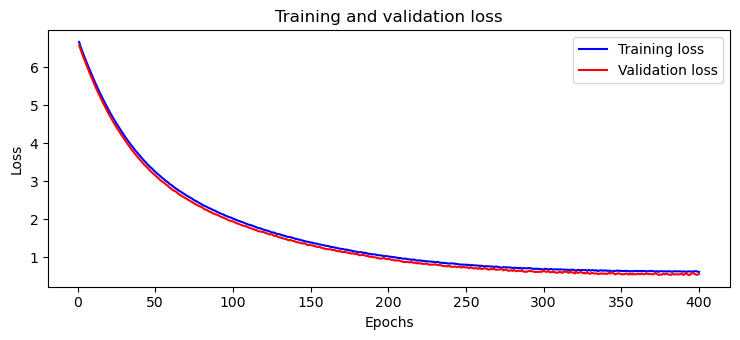

<Figure size 800x200 with 0 Axes>

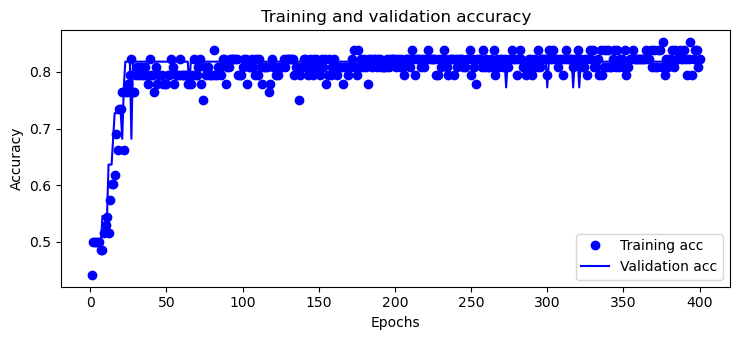

1/1 [==============================] - 0s 123ms/step


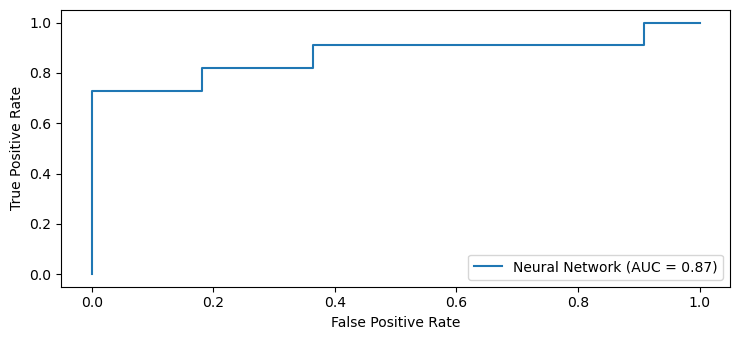

In [22]:
history_dict = history.history
history_dict.keys()
[u"accuracy", u"loss", u"val_accuracy", u"val_loss"]

import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "b", label="Training loss")      
plt.plot(epochs, val_loss_values, "b", color="r", label="Validation loss") 
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(2)

plt.show()

plt.clf()                          
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Create an ROC Curve plot.
predictions = model.predict([channel_14_test_x,channel_42_test_x])

fpr, tpr, thresholds = metrics.roc_curve(channel_14_test_y, predictions)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Neural Network')
display.plot()
plt.show()

### K Fold Validation

In [23]:
# K fold validation function
def kFold(channel_14_train_x, channel_14_train_y, channel_42_train_x , channel_42_train_y, subjects, IDs, epochs):
    k = 9
    num_val_samples = len(subjects) // k
    num_epochs = epochs 
    all_scores = [] 
    for i in range(k):
        
        np.random.shuffle(subjects) # shuffle subjects to ensure different results
        model = Conv1D_Model()
           
        print(f"Processing fold #{i}")
        
        if( i == (k-1)):
            validation_indicies = get_user_slice(target=IDs, subjects=subjects[i * num_val_samples:len(subjects)])
            print("Validation Set: Subjects " + str(i * num_val_samples) + ":" +  str(len(subjects)))

        else:
            validation_indicies = get_user_slice(target=IDs, subjects=subjects[i * num_val_samples: (i + 1) * num_val_samples])
            print("Validation Set: Subjects " + str(i * num_val_samples) + ":" +  str((i + 1) * num_val_samples))
            
        train_indicies = np.invert(validation_indicies)
                                   
        channel_14_val_data = channel_14_k_train_x[validation_indicies]
        channel_42_val_data = channel_42_k_train_x[validation_indicies]
        val_y = channel_42_k_train_y[validation_indicies]
        
        channel_14_partial_train_data = channel_14_train_x[train_indicies]
        channel_42_partial_train_data = channel_42_train_x[train_indicies]
        train_y = channel_42_train_y[train_indicies]
                
        model.fit([channel_14_partial_train_data, channel_42_partial_train_data] , train_y,                    
                  epochs=num_epochs, batch_size=4, verbose=0)
        loss, val_acc = model.evaluate([channel_14_val_data, channel_42_val_data], val_y, verbose=0)     
        all_scores.append(val_acc)
    print("Fold Accuracies: ", all_scores)
    print("Average Accuracy: ", np.mean(all_scores))

# Execute K fold validation
epochs = 100

channel_14_k_train_x = np.vstack((channel_14_train_x, channel_14_val_x))
channel_14_k_train_y = np.hstack((channel_14_train_y, channel_14_val_y))
channel_42_k_train_x = np.vstack((channel_42_train_x, channel_42_val_x))
channel_42_k_train_y = np.hstack((channel_42_train_y, channel_42_val_y))

kFold(channel_14_k_train_x, channel_14_k_train_y, channel_42_k_train_x , channel_42_k_train_y, kfold_subjects, k_fold_IDs, epochs=epochs)

Processing fold #0
Validation Set: Subjects 0:5
Processing fold #1
Validation Set: Subjects 5:10
Processing fold #2
Validation Set: Subjects 10:15


Processing fold #3
Validation Set: Subjects 15:20


Processing fold #4
Validation Set: Subjects 20:25
Processing fold #5
Validation Set: Subjects 25:30
Processing fold #6
Validation Set: Subjects 30:35
Processing fold #7
Validation Set: Subjects 35:40
Processing fold #8
Validation Set: Subjects 40:45
Fold Accuracies:  [0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.699999988079071, 0.699999988079071, 0.699999988079071, 0.800000011920929, 0.6000000238418579, 0.8999999761581421]
Average Accuracy:  0.7222222222222222


### Save and export model

In [26]:
model.save(".\\tmp_conv1D_variableInput_keras_model")

INFO:tensorflow:Assets written to: .\tmp_conv1D_variableInput_keras_model\assets


INFO:tensorflow:Assets written to: .\tmp_conv1D_variableInput_keras_model\assets


### Plot Participant Data

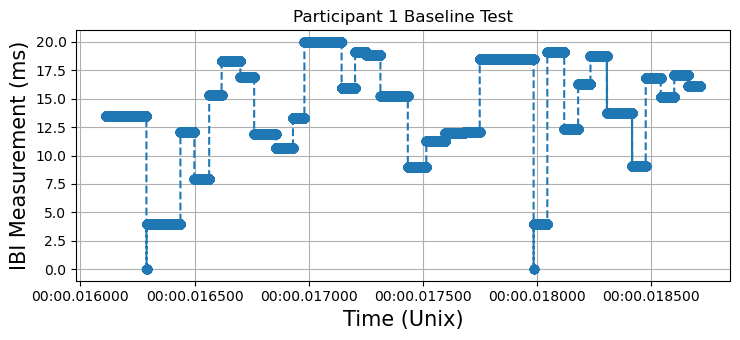

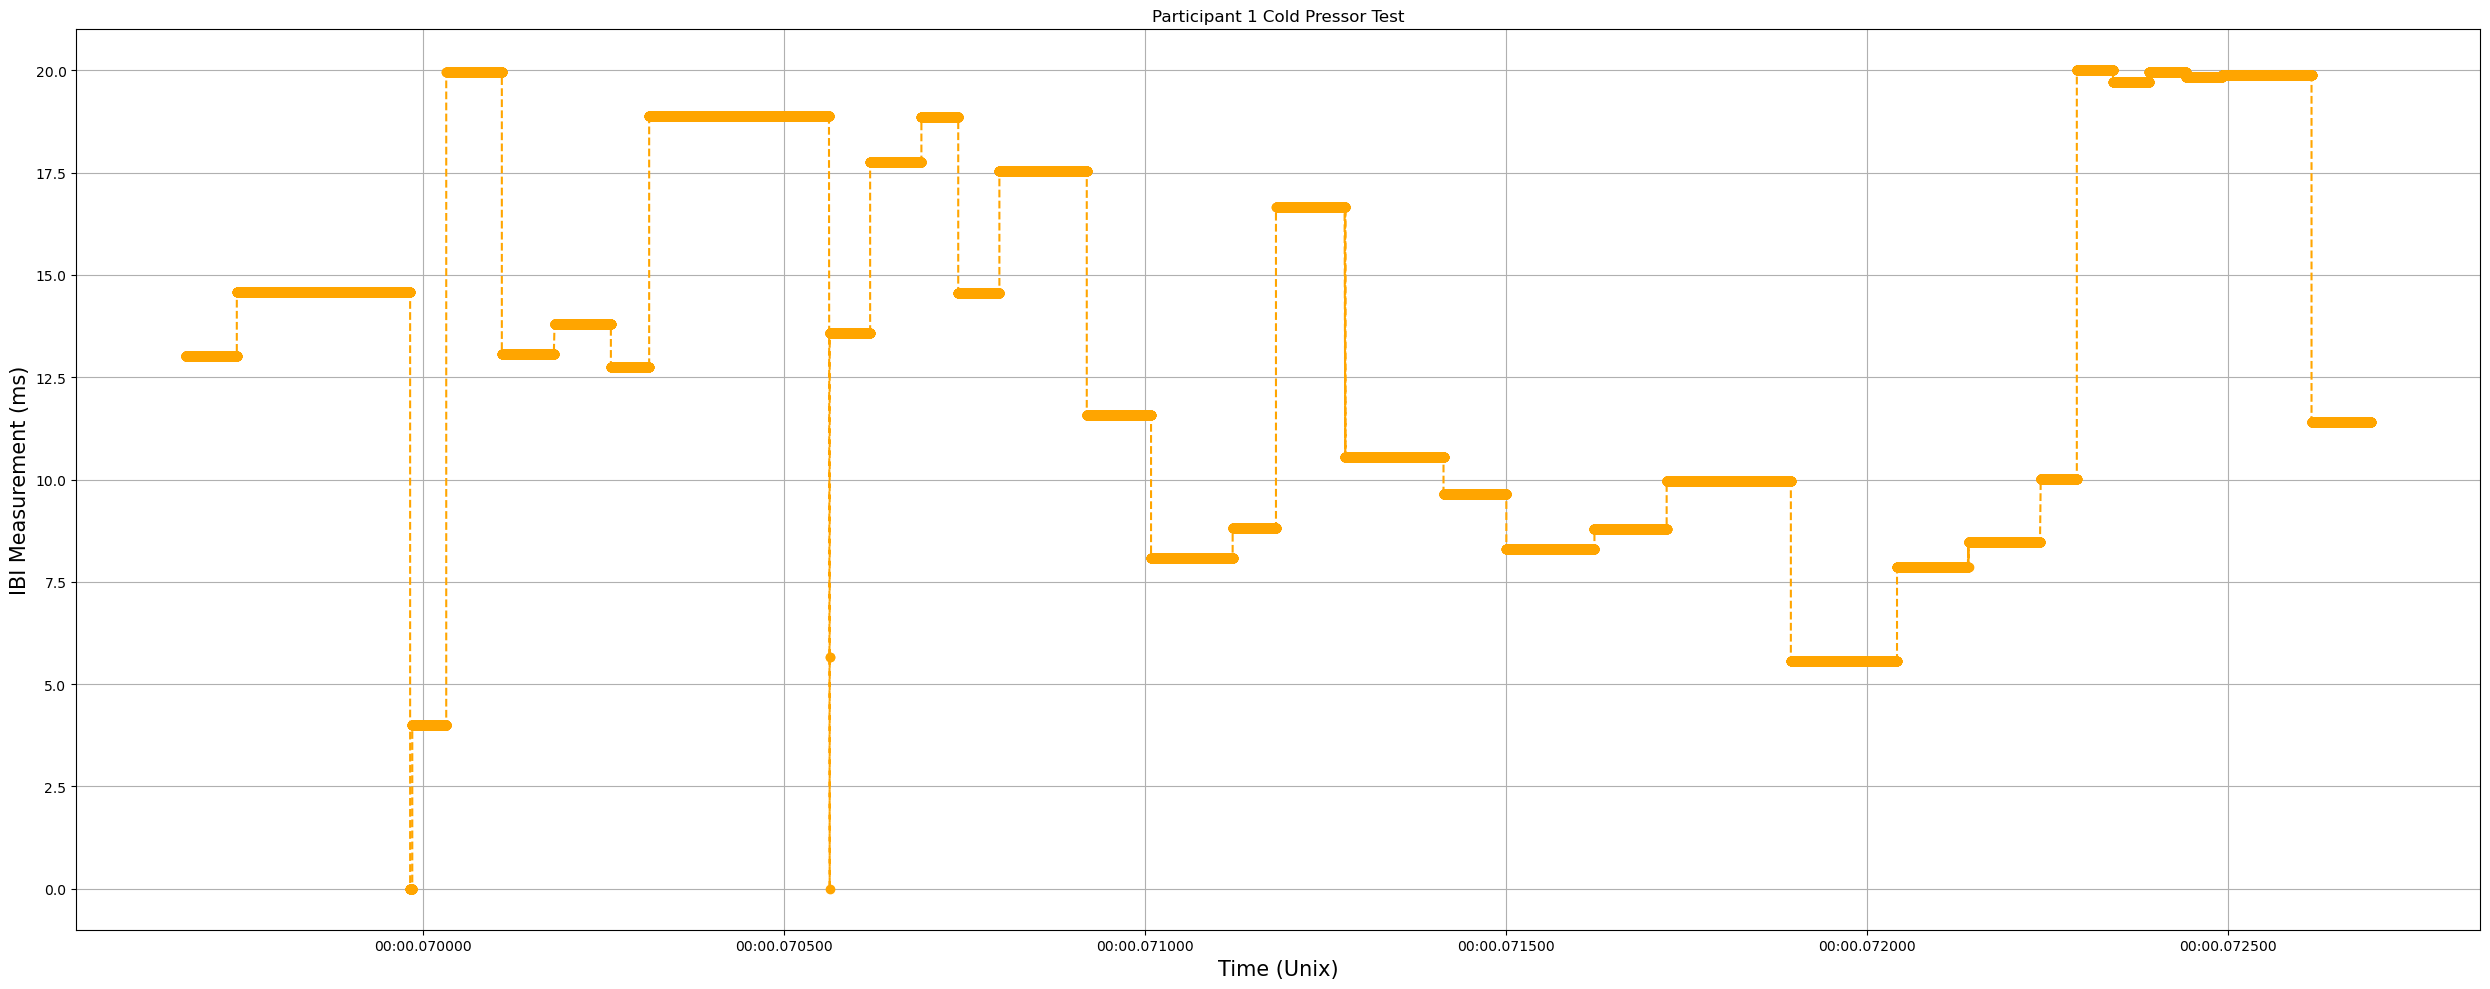

<Figure size 2500x1000 with 0 Axes>

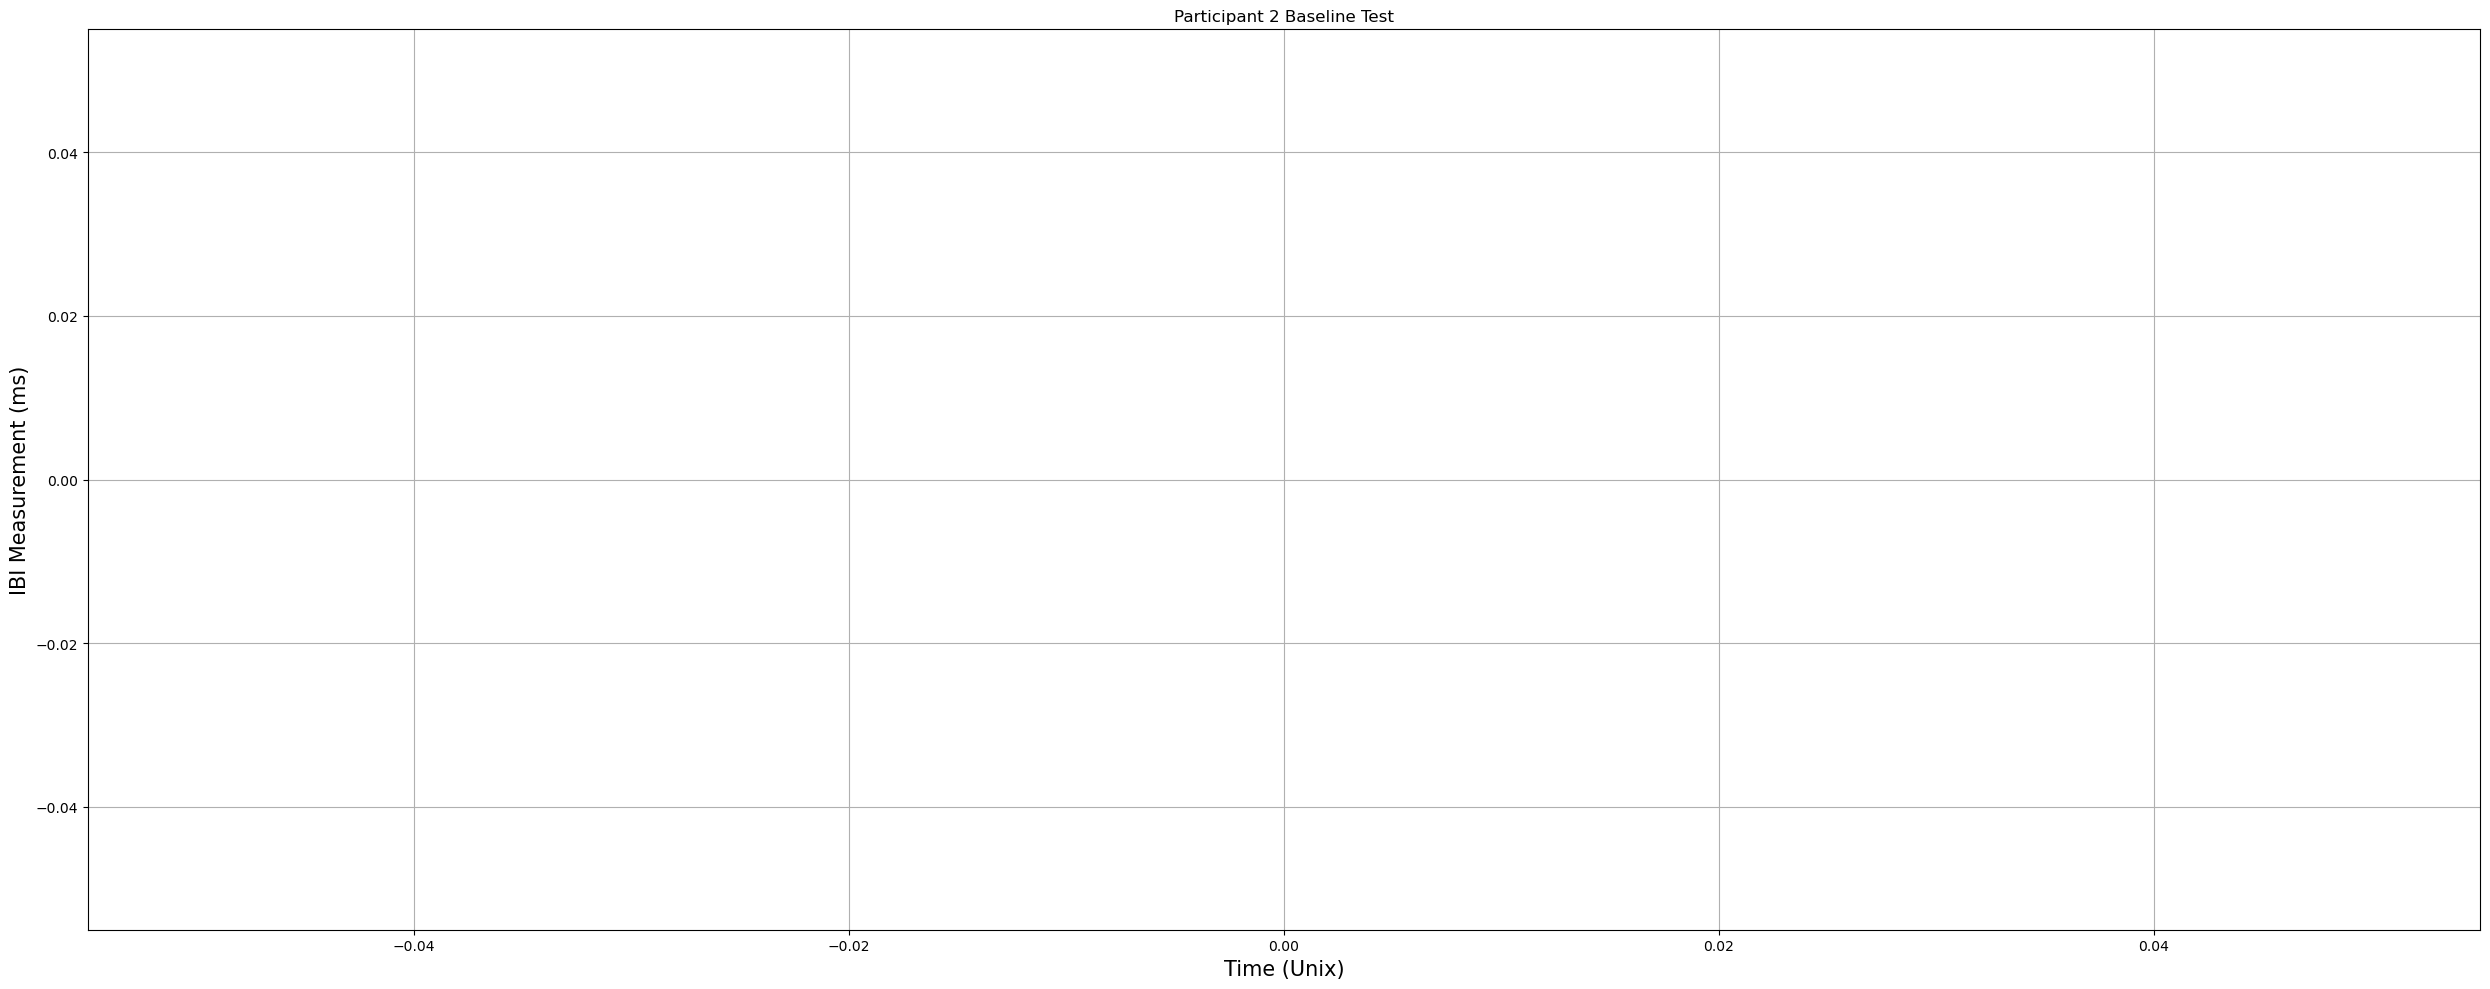

<Figure size 2500x1000 with 0 Axes>

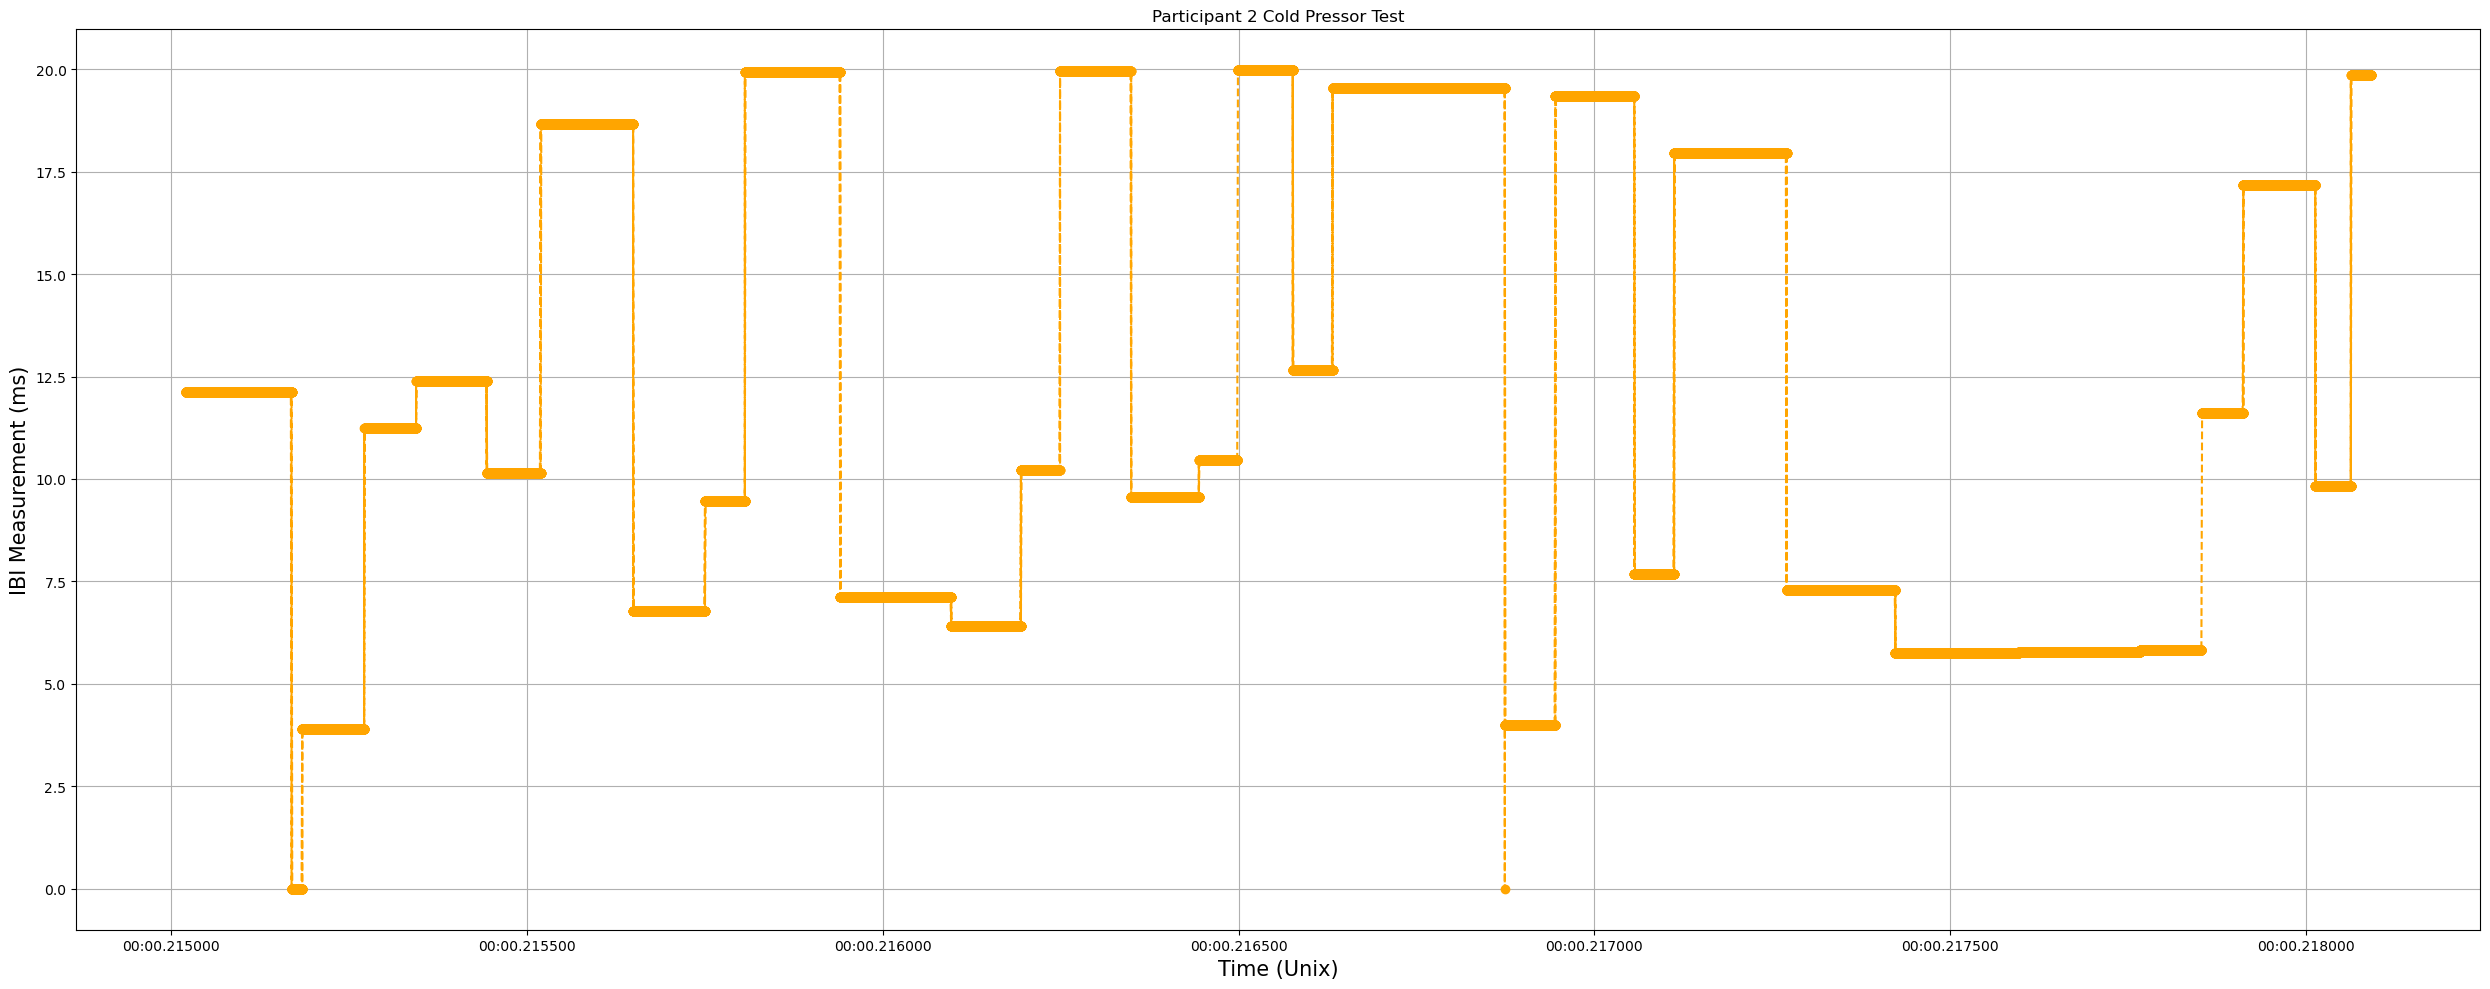

<Figure size 2500x1000 with 0 Axes>

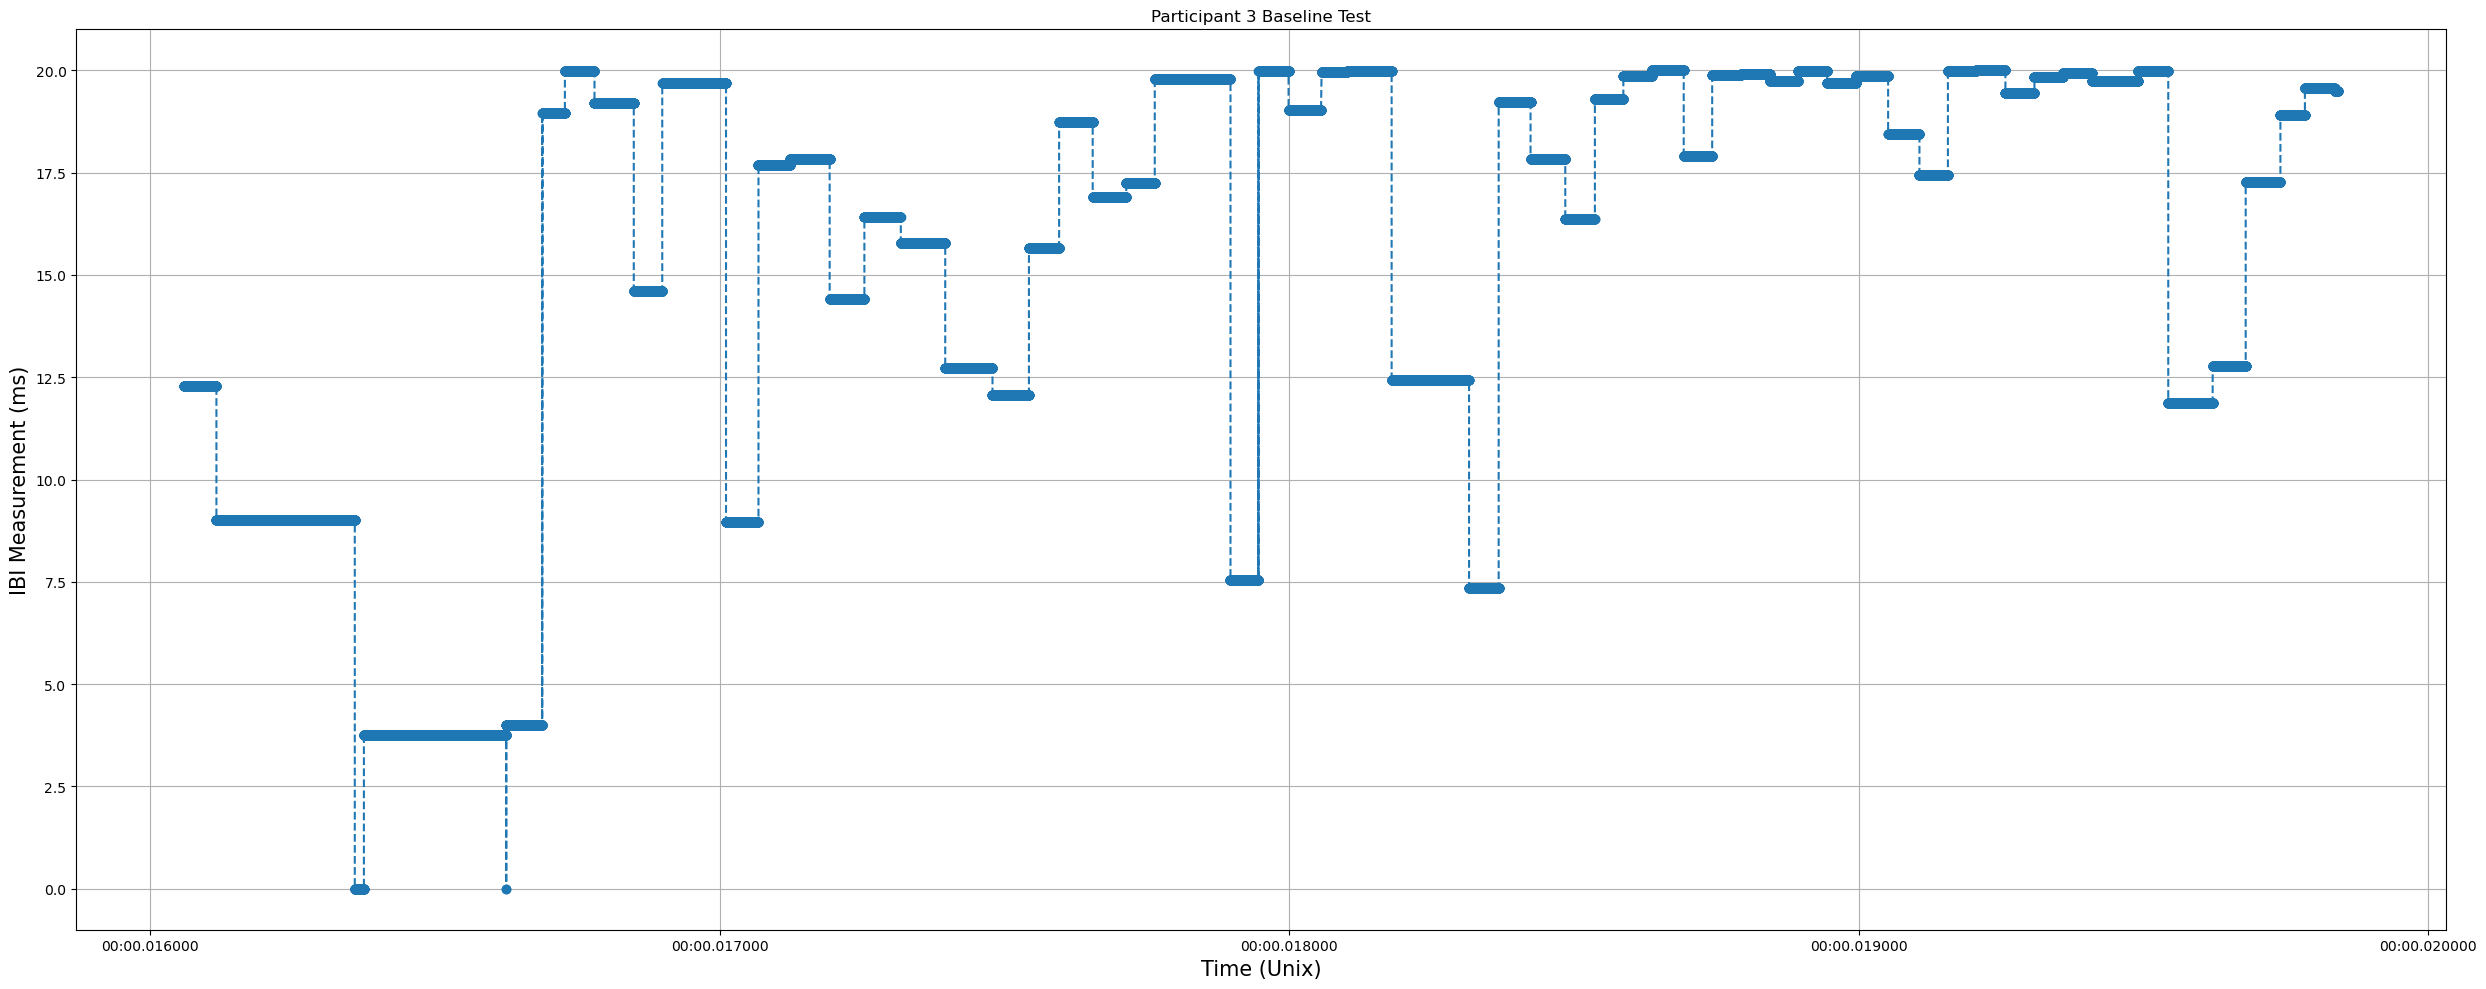

<Figure size 2500x1000 with 0 Axes>

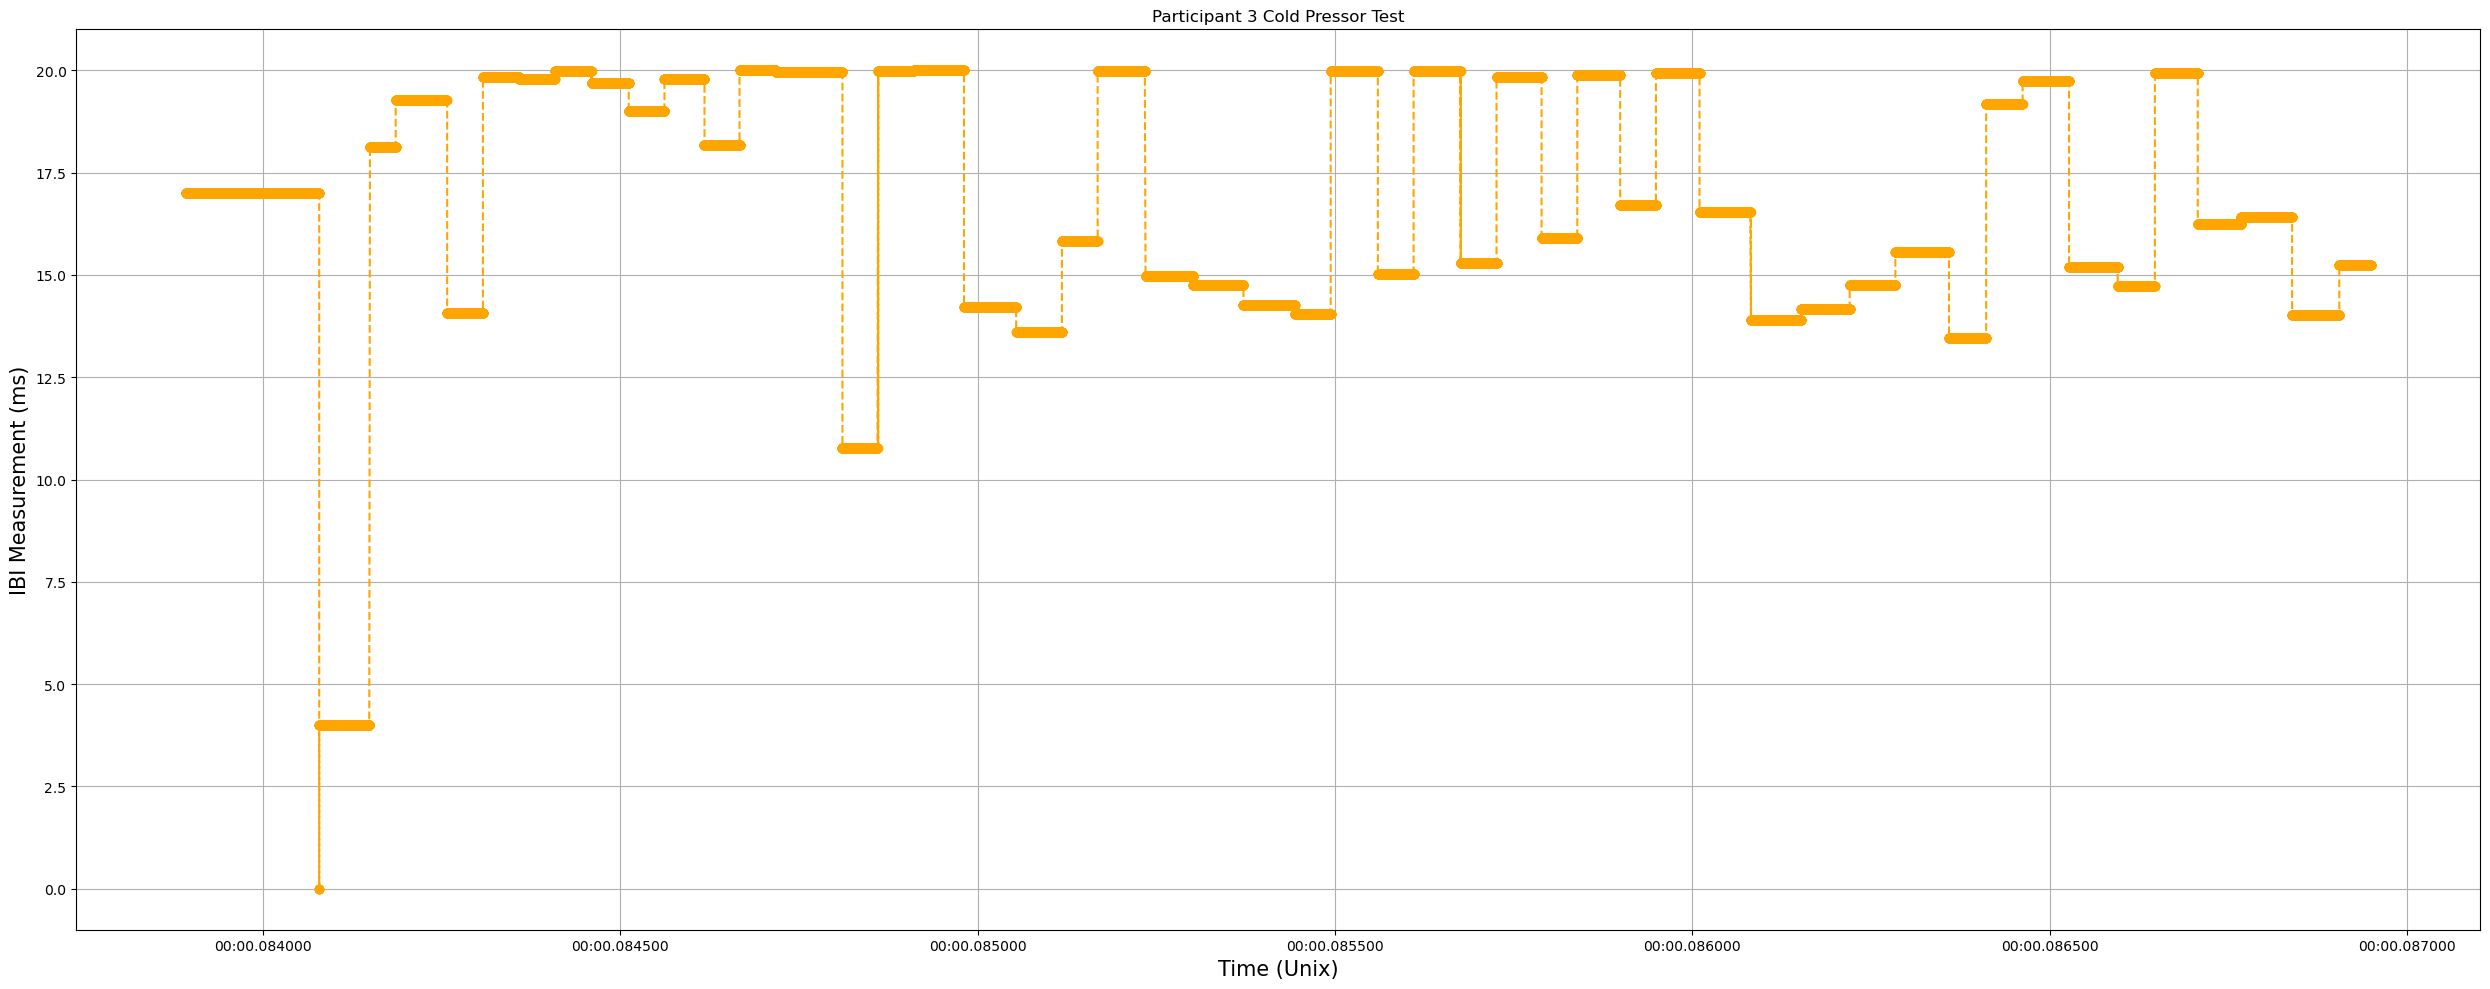

<Figure size 2500x1000 with 0 Axes>

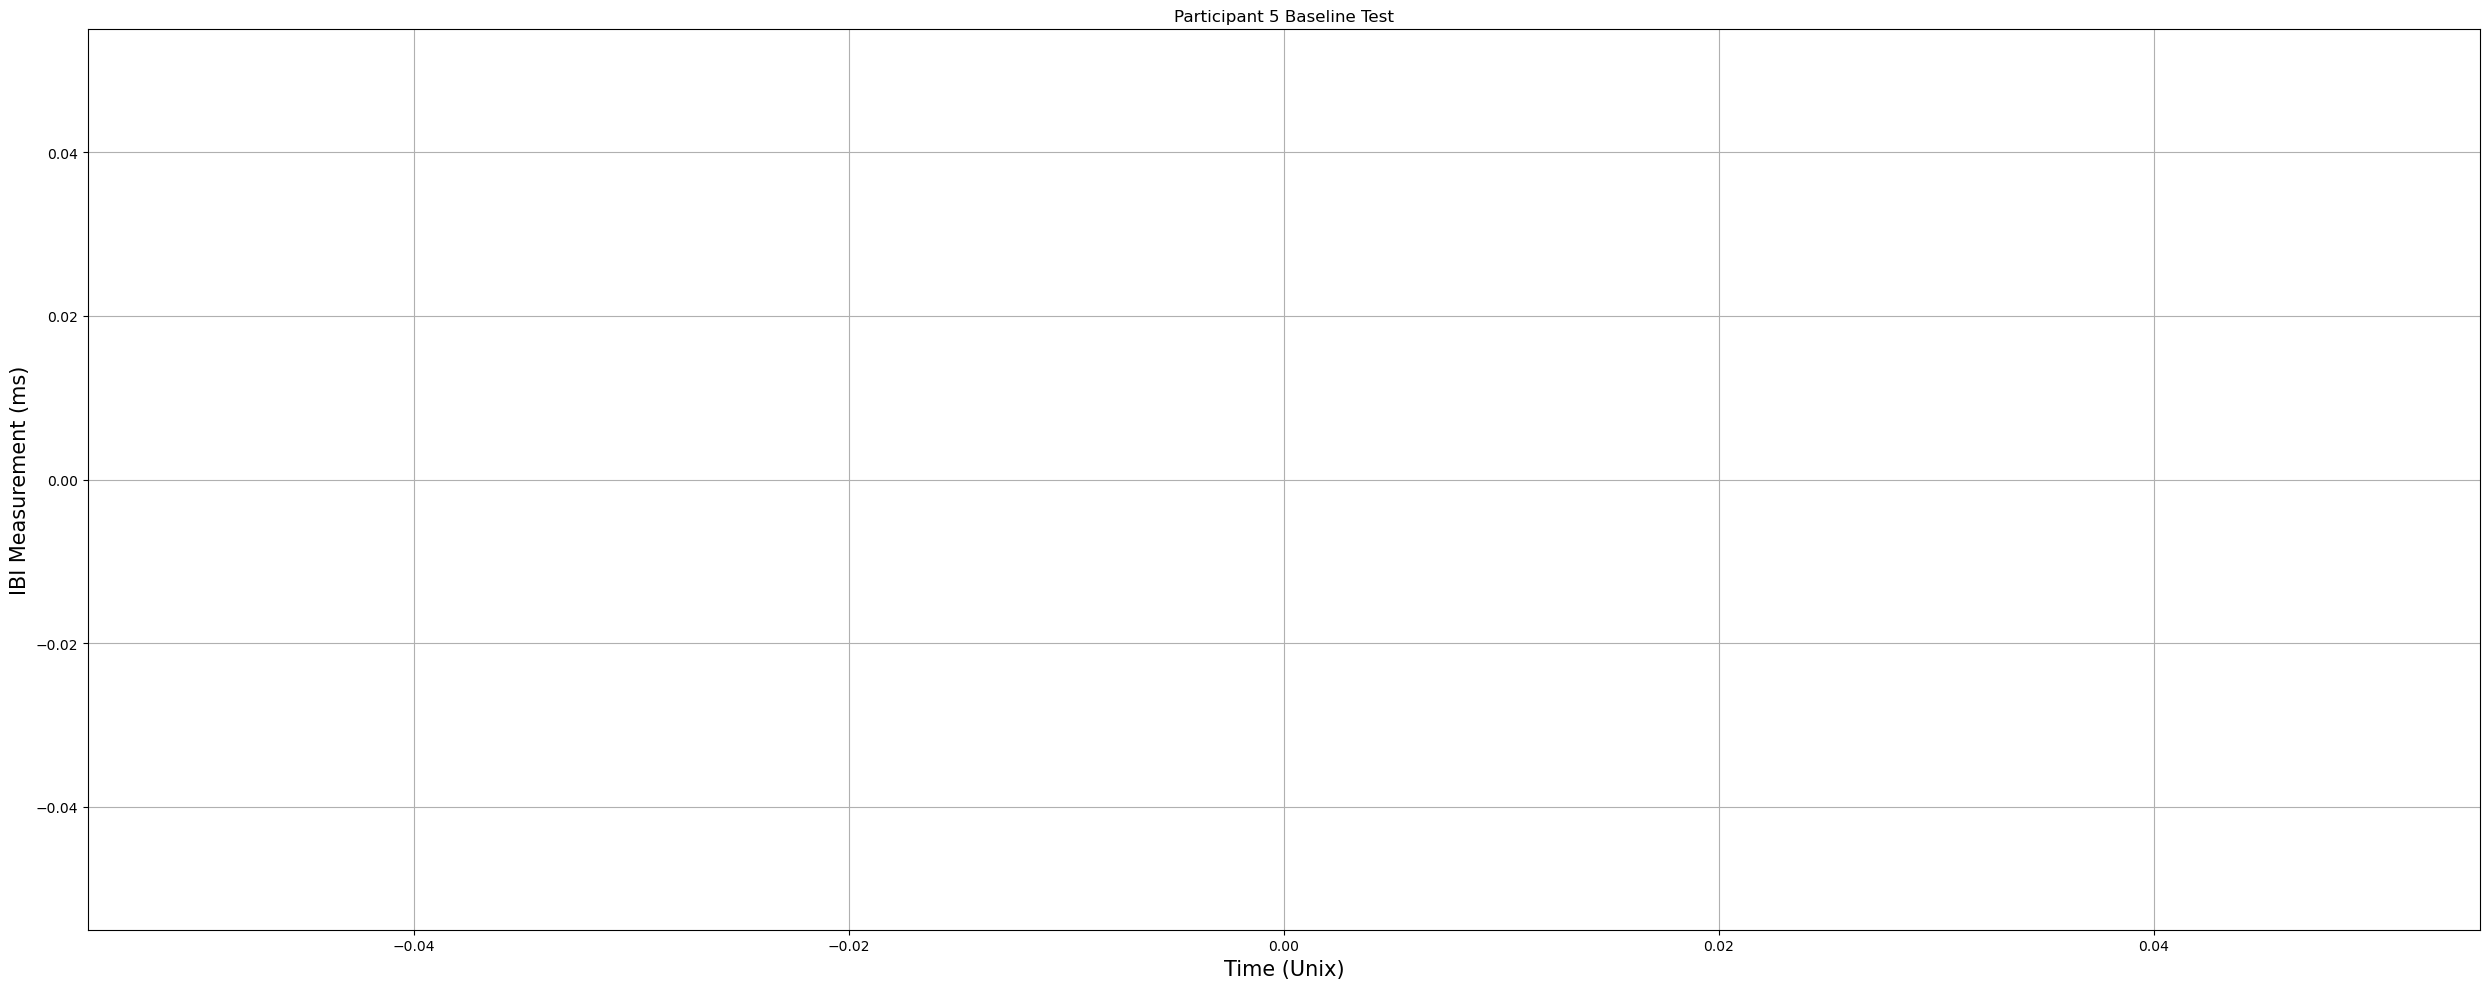

<Figure size 2500x1000 with 0 Axes>

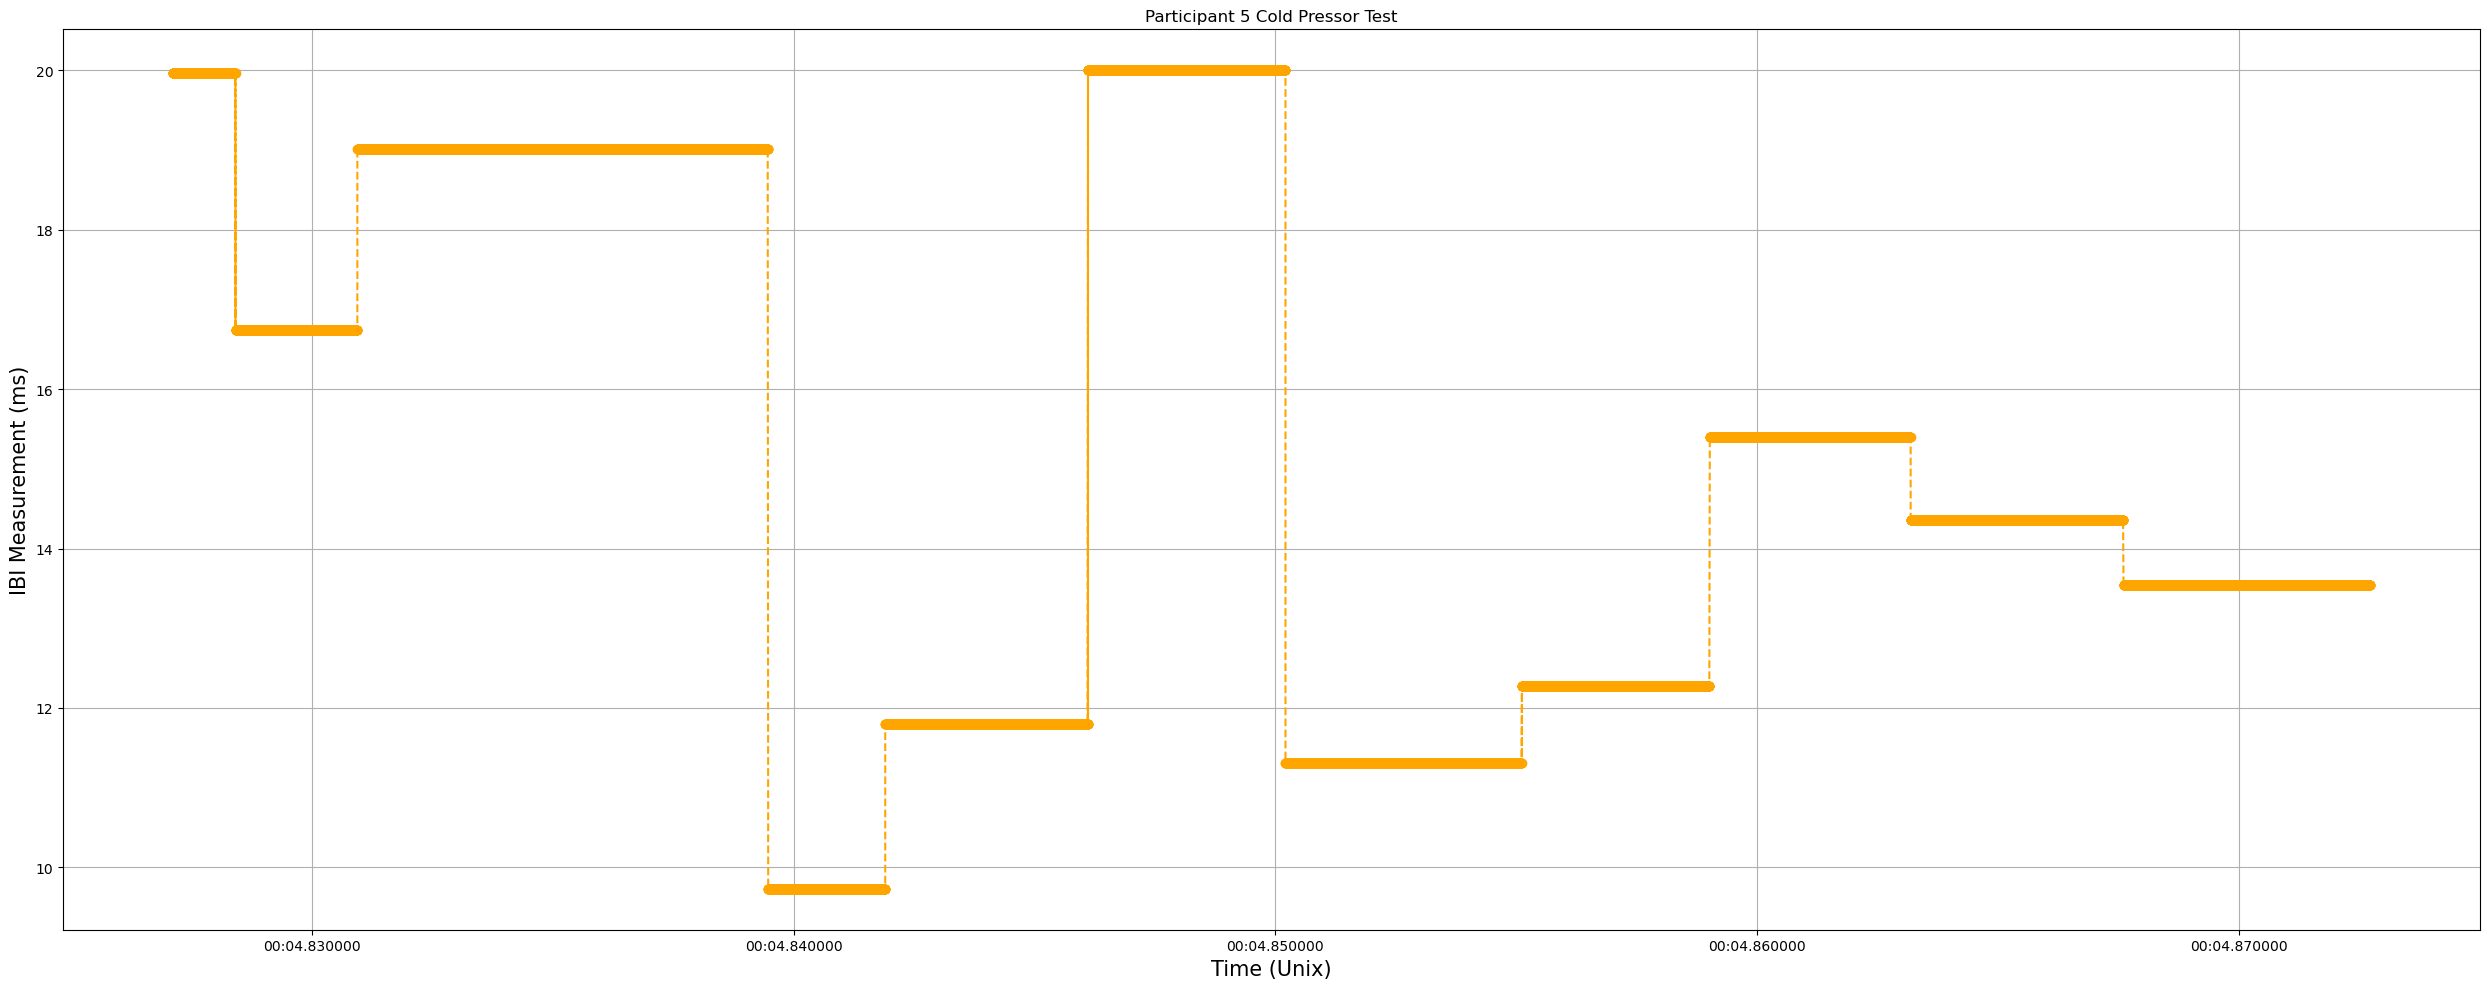

<Figure size 2500x1000 with 0 Axes>

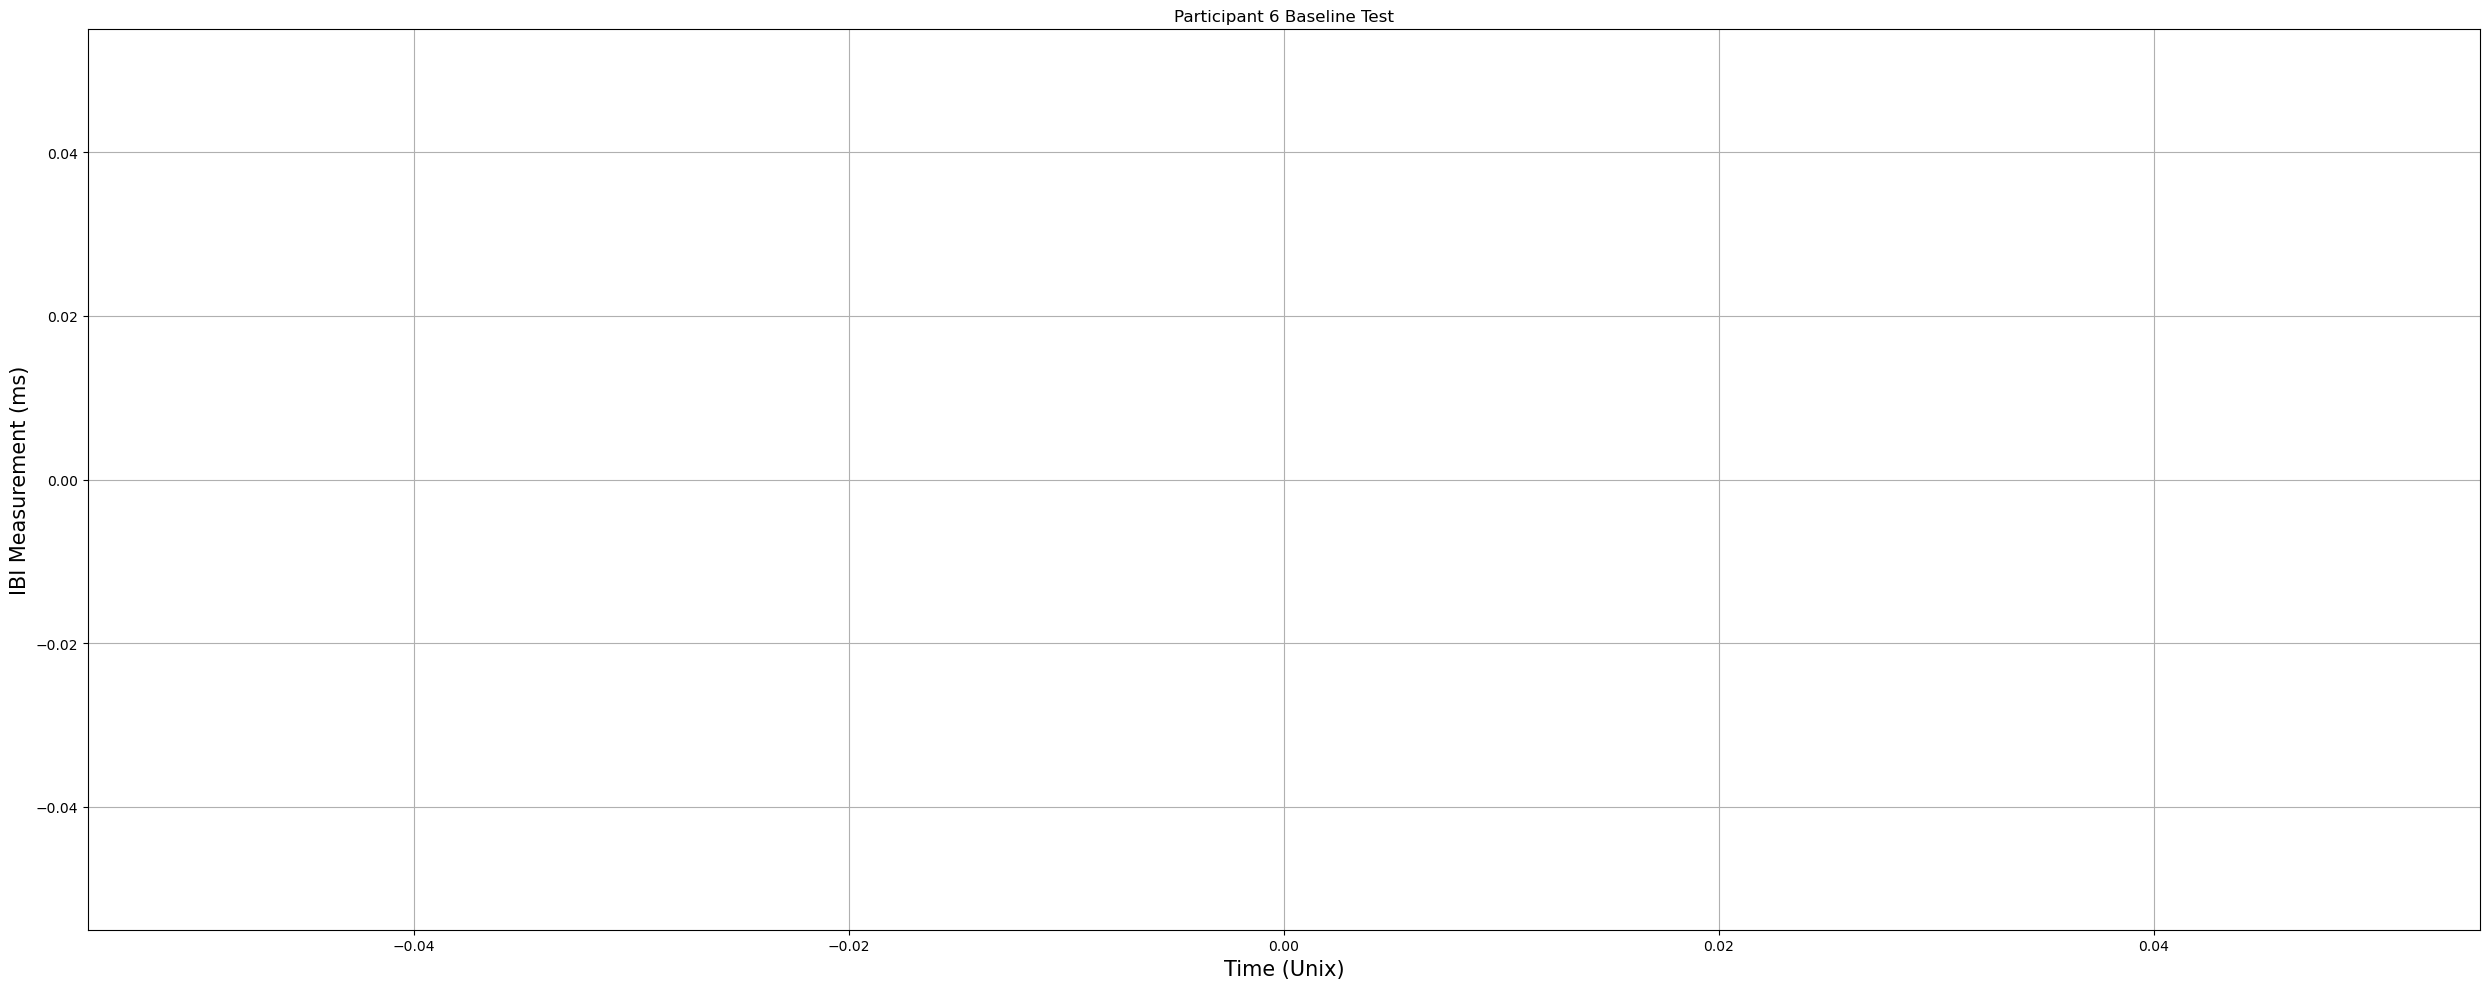

<Figure size 2500x1000 with 0 Axes>

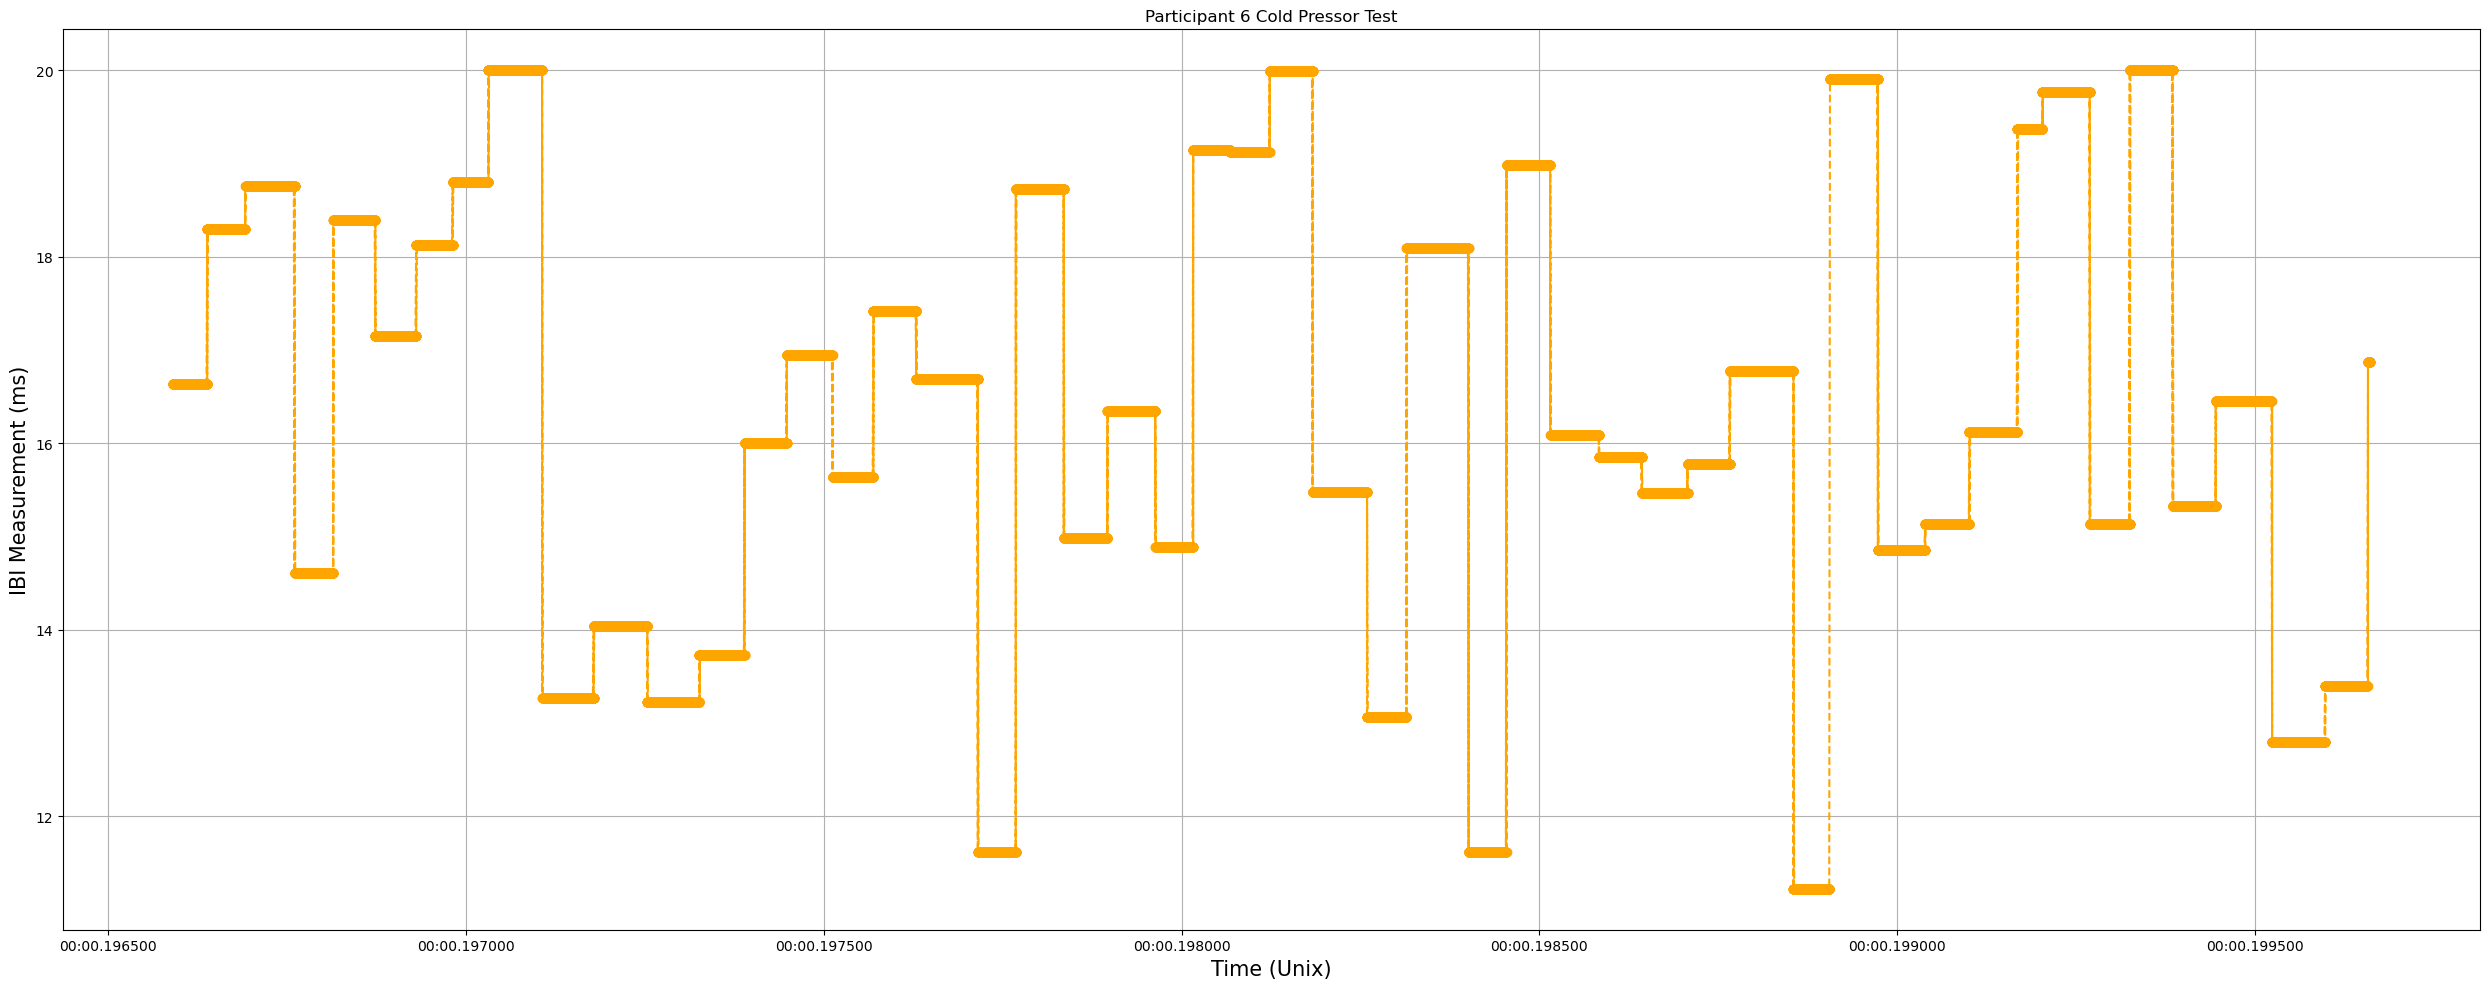

<Figure size 2500x1000 with 0 Axes>

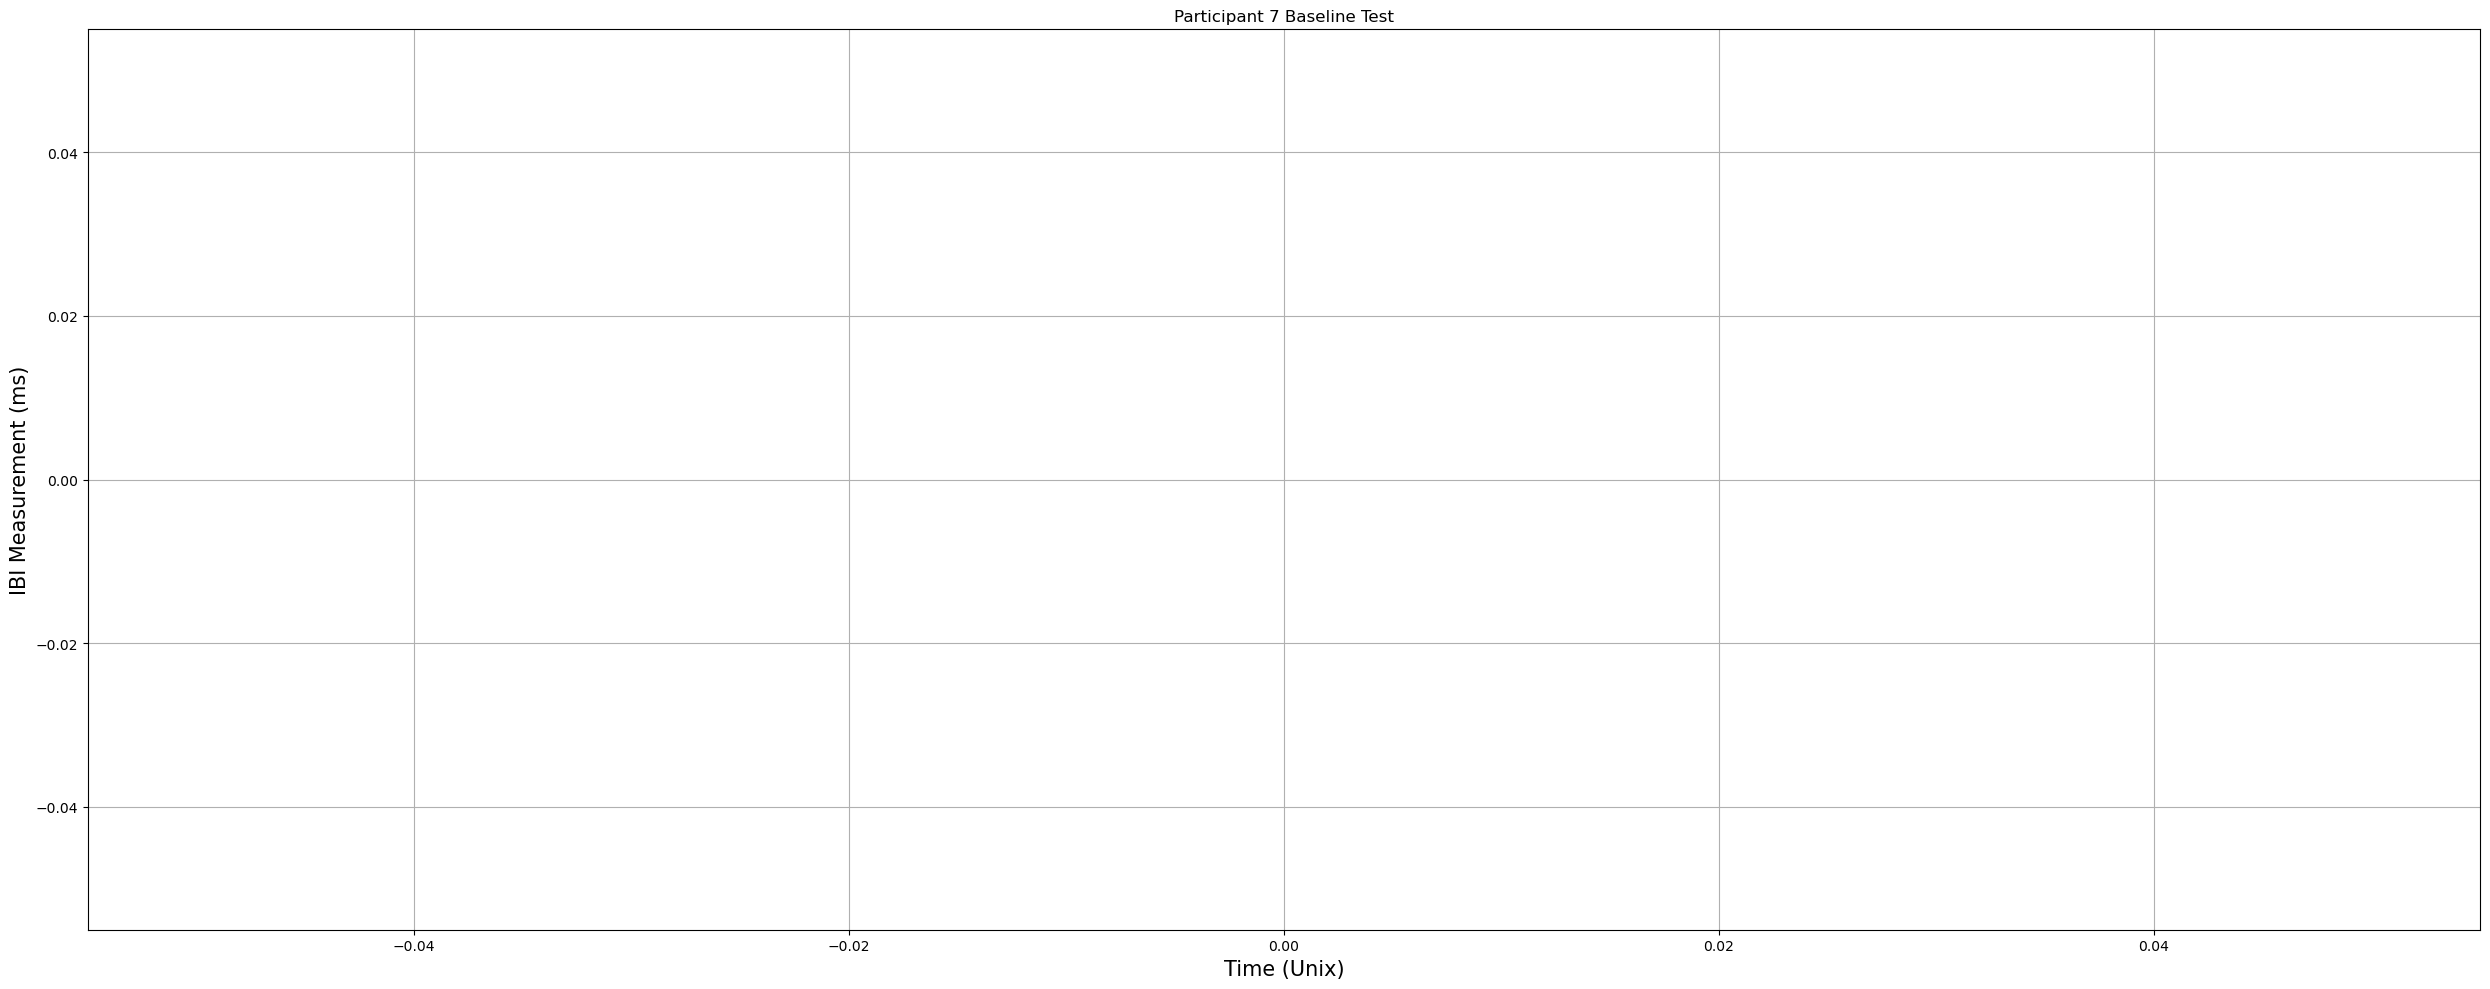

<Figure size 2500x1000 with 0 Axes>

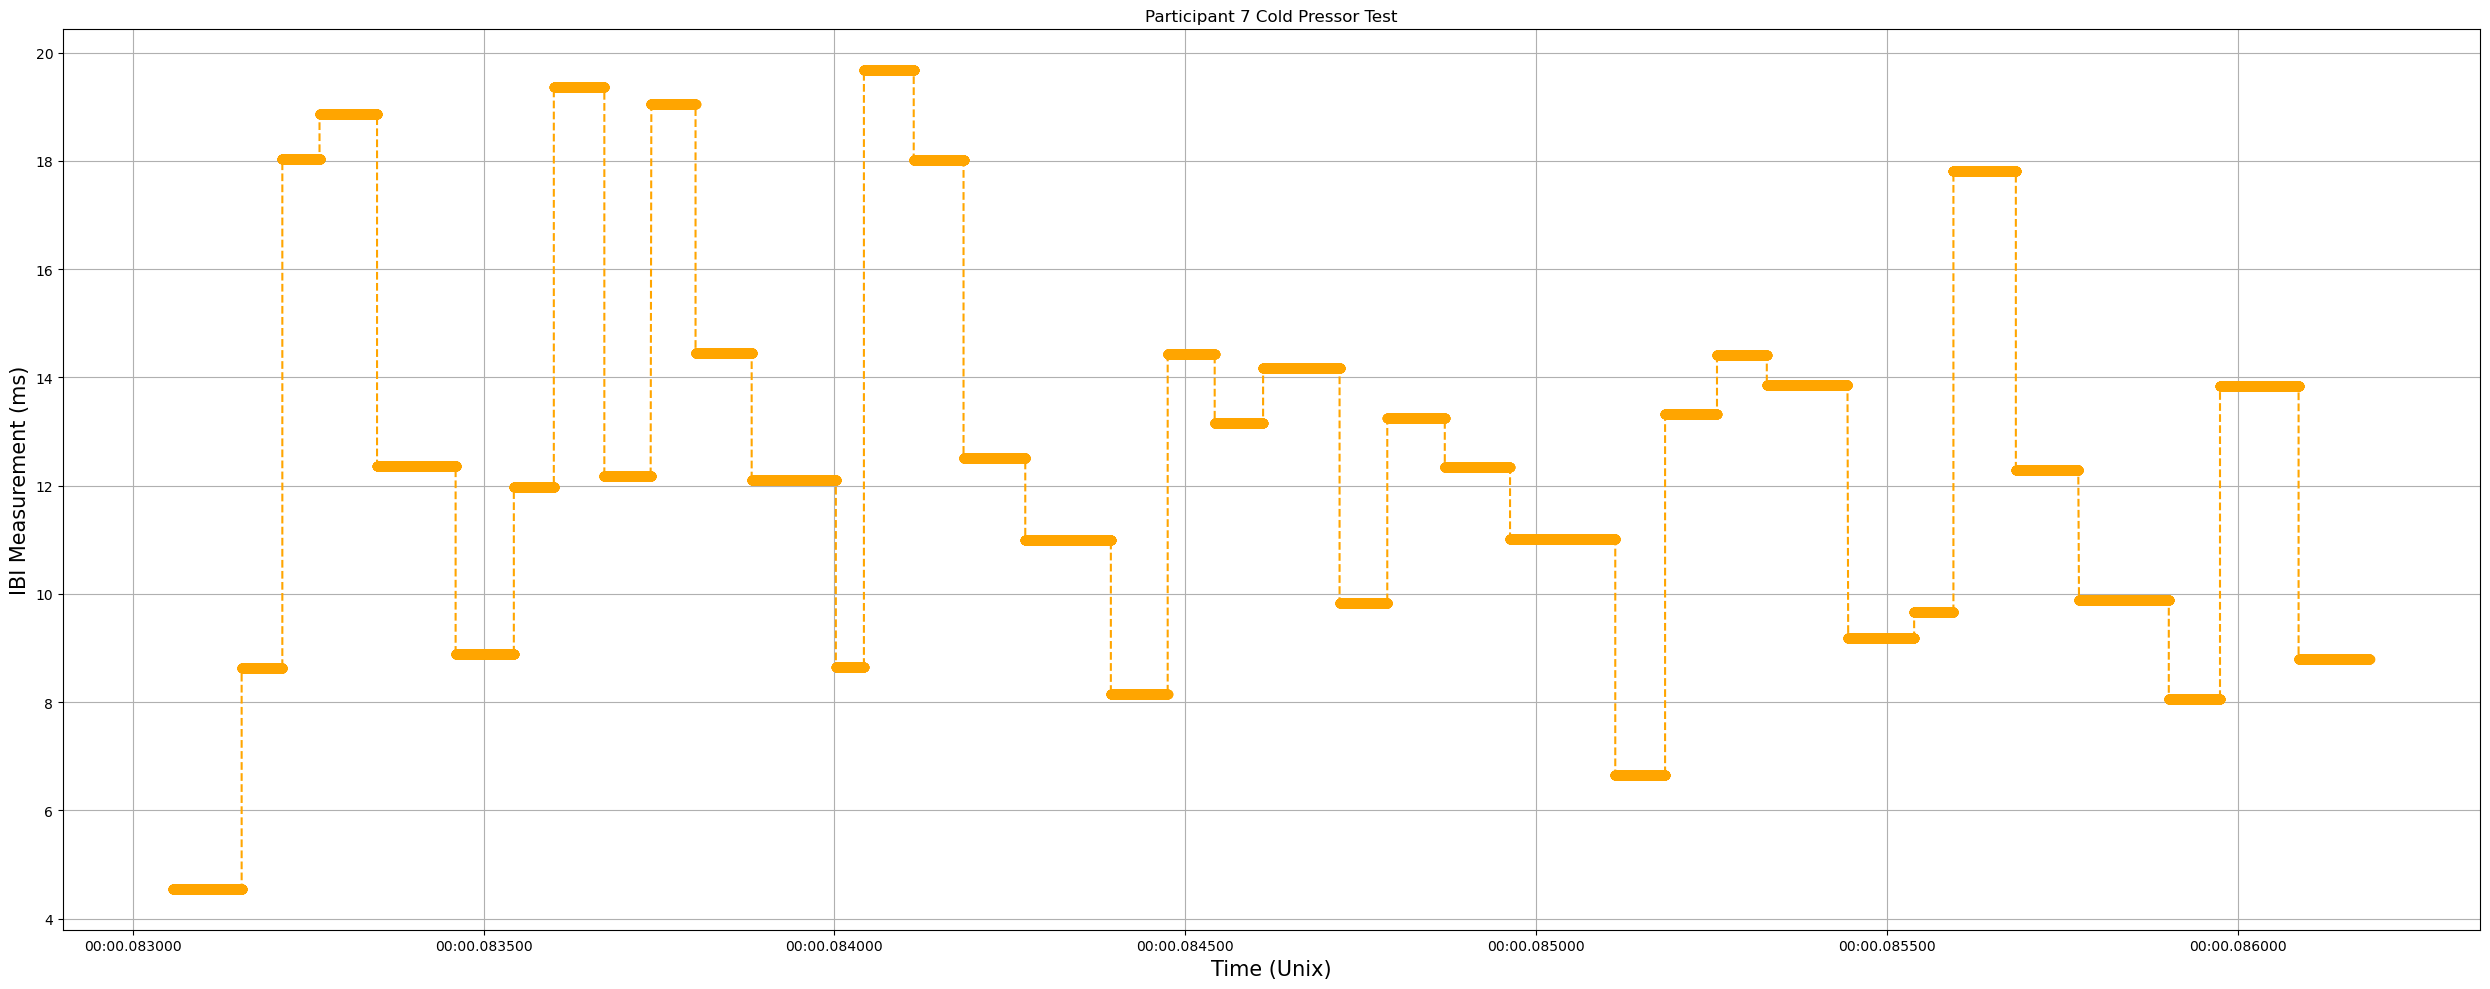

<Figure size 2500x1000 with 0 Axes>

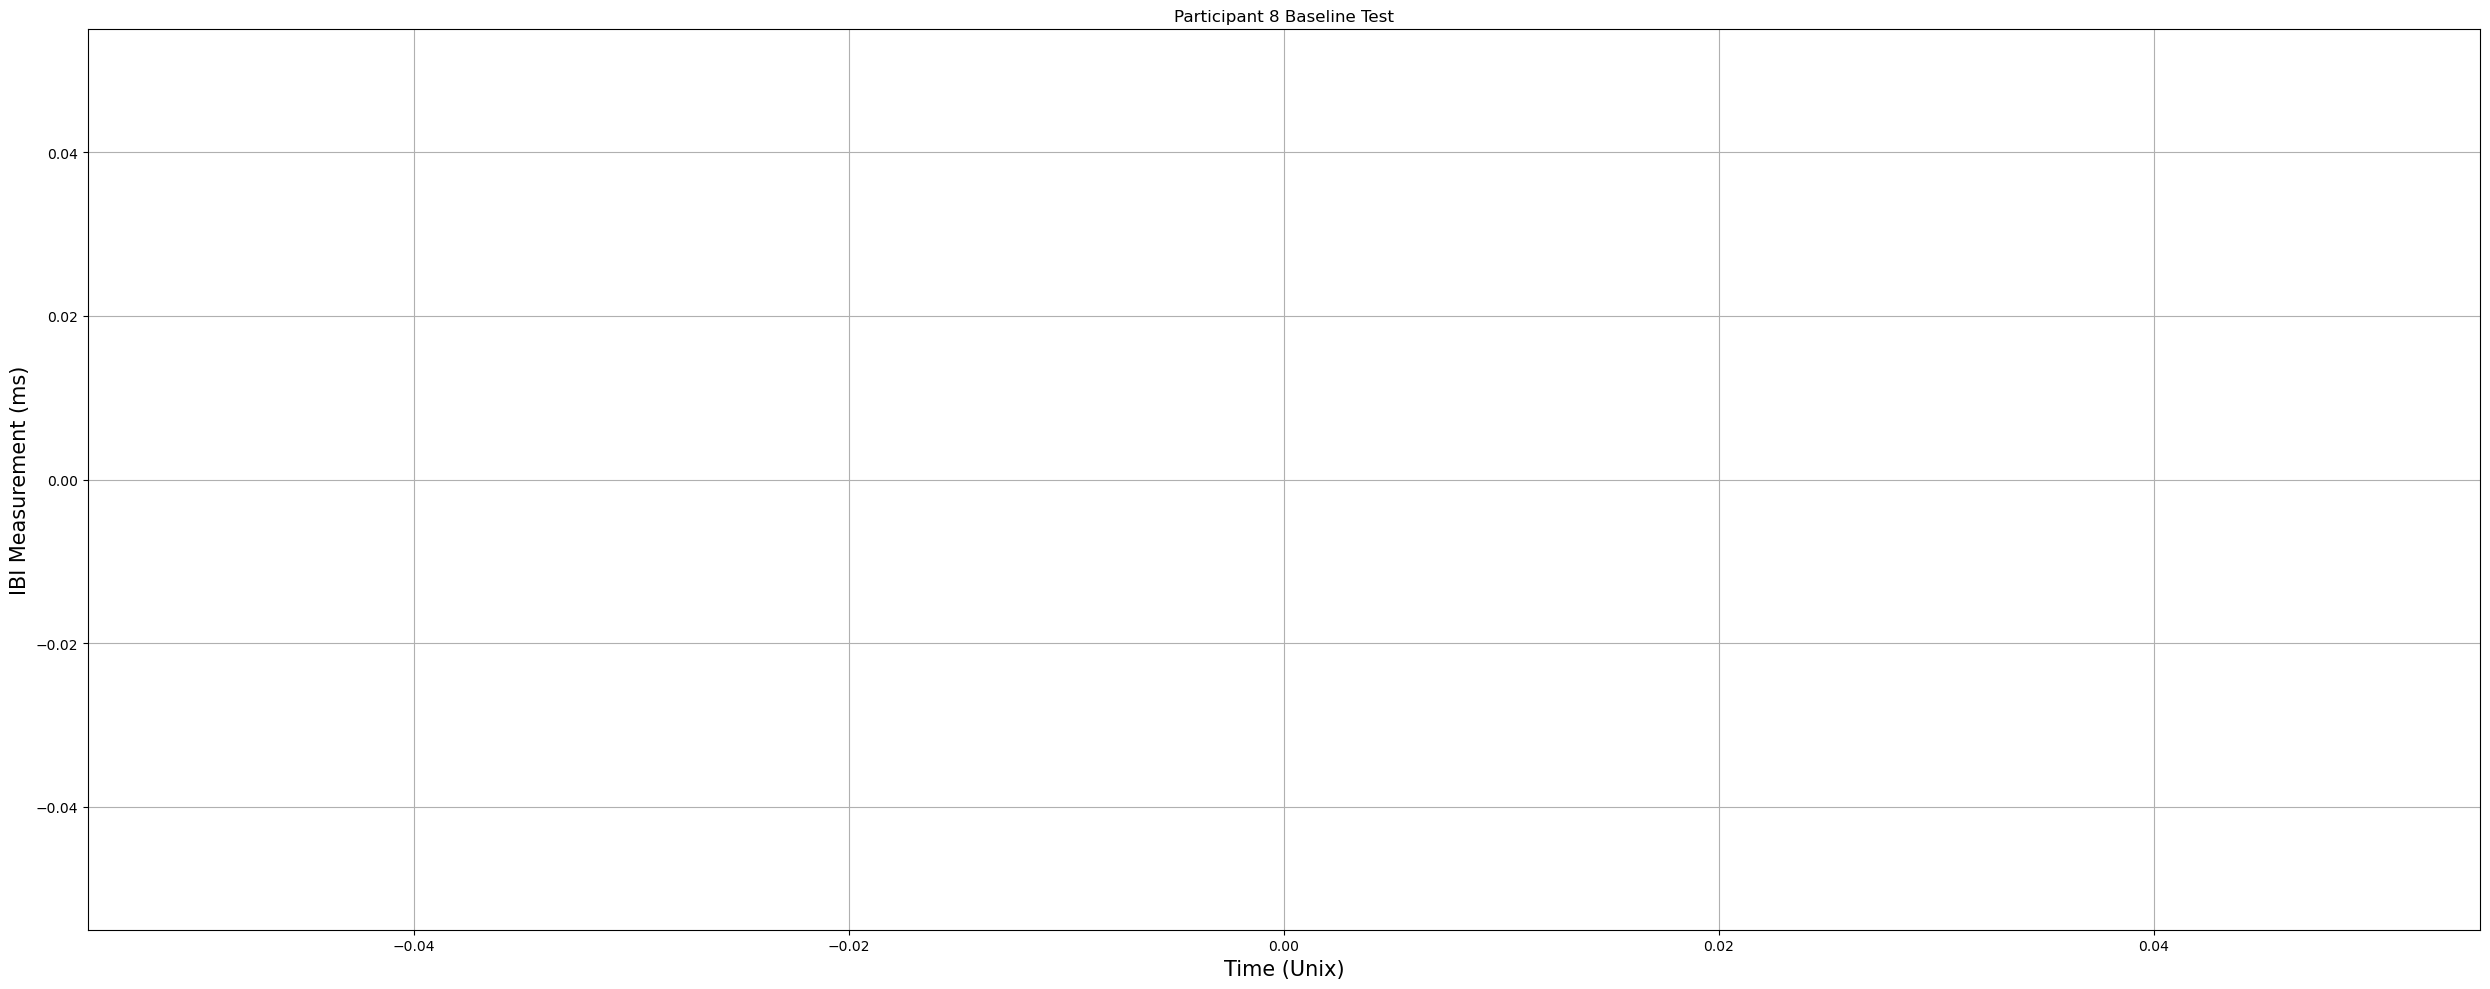

<Figure size 2500x1000 with 0 Axes>

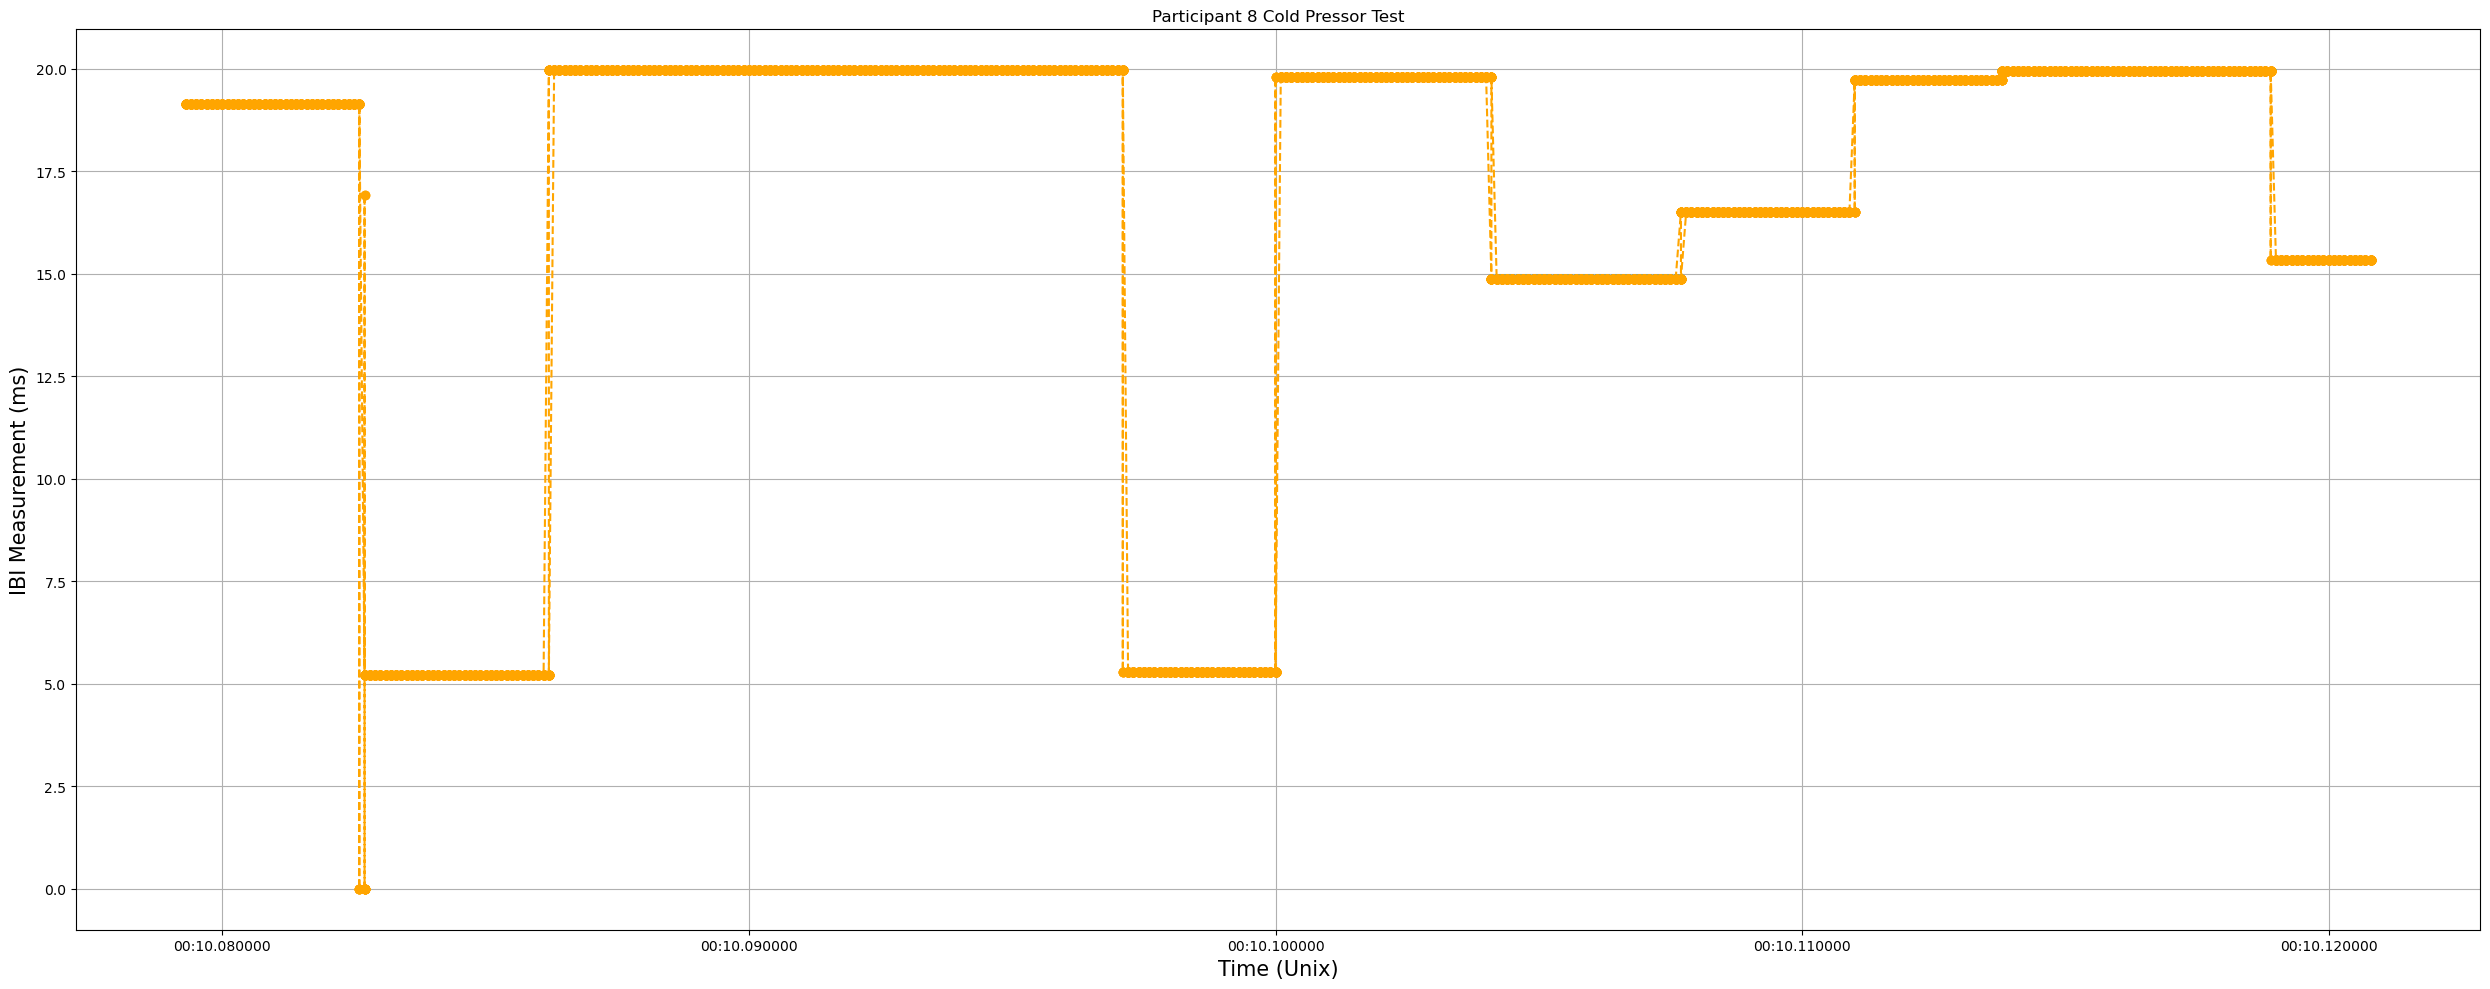

<Figure size 2500x1000 with 0 Axes>

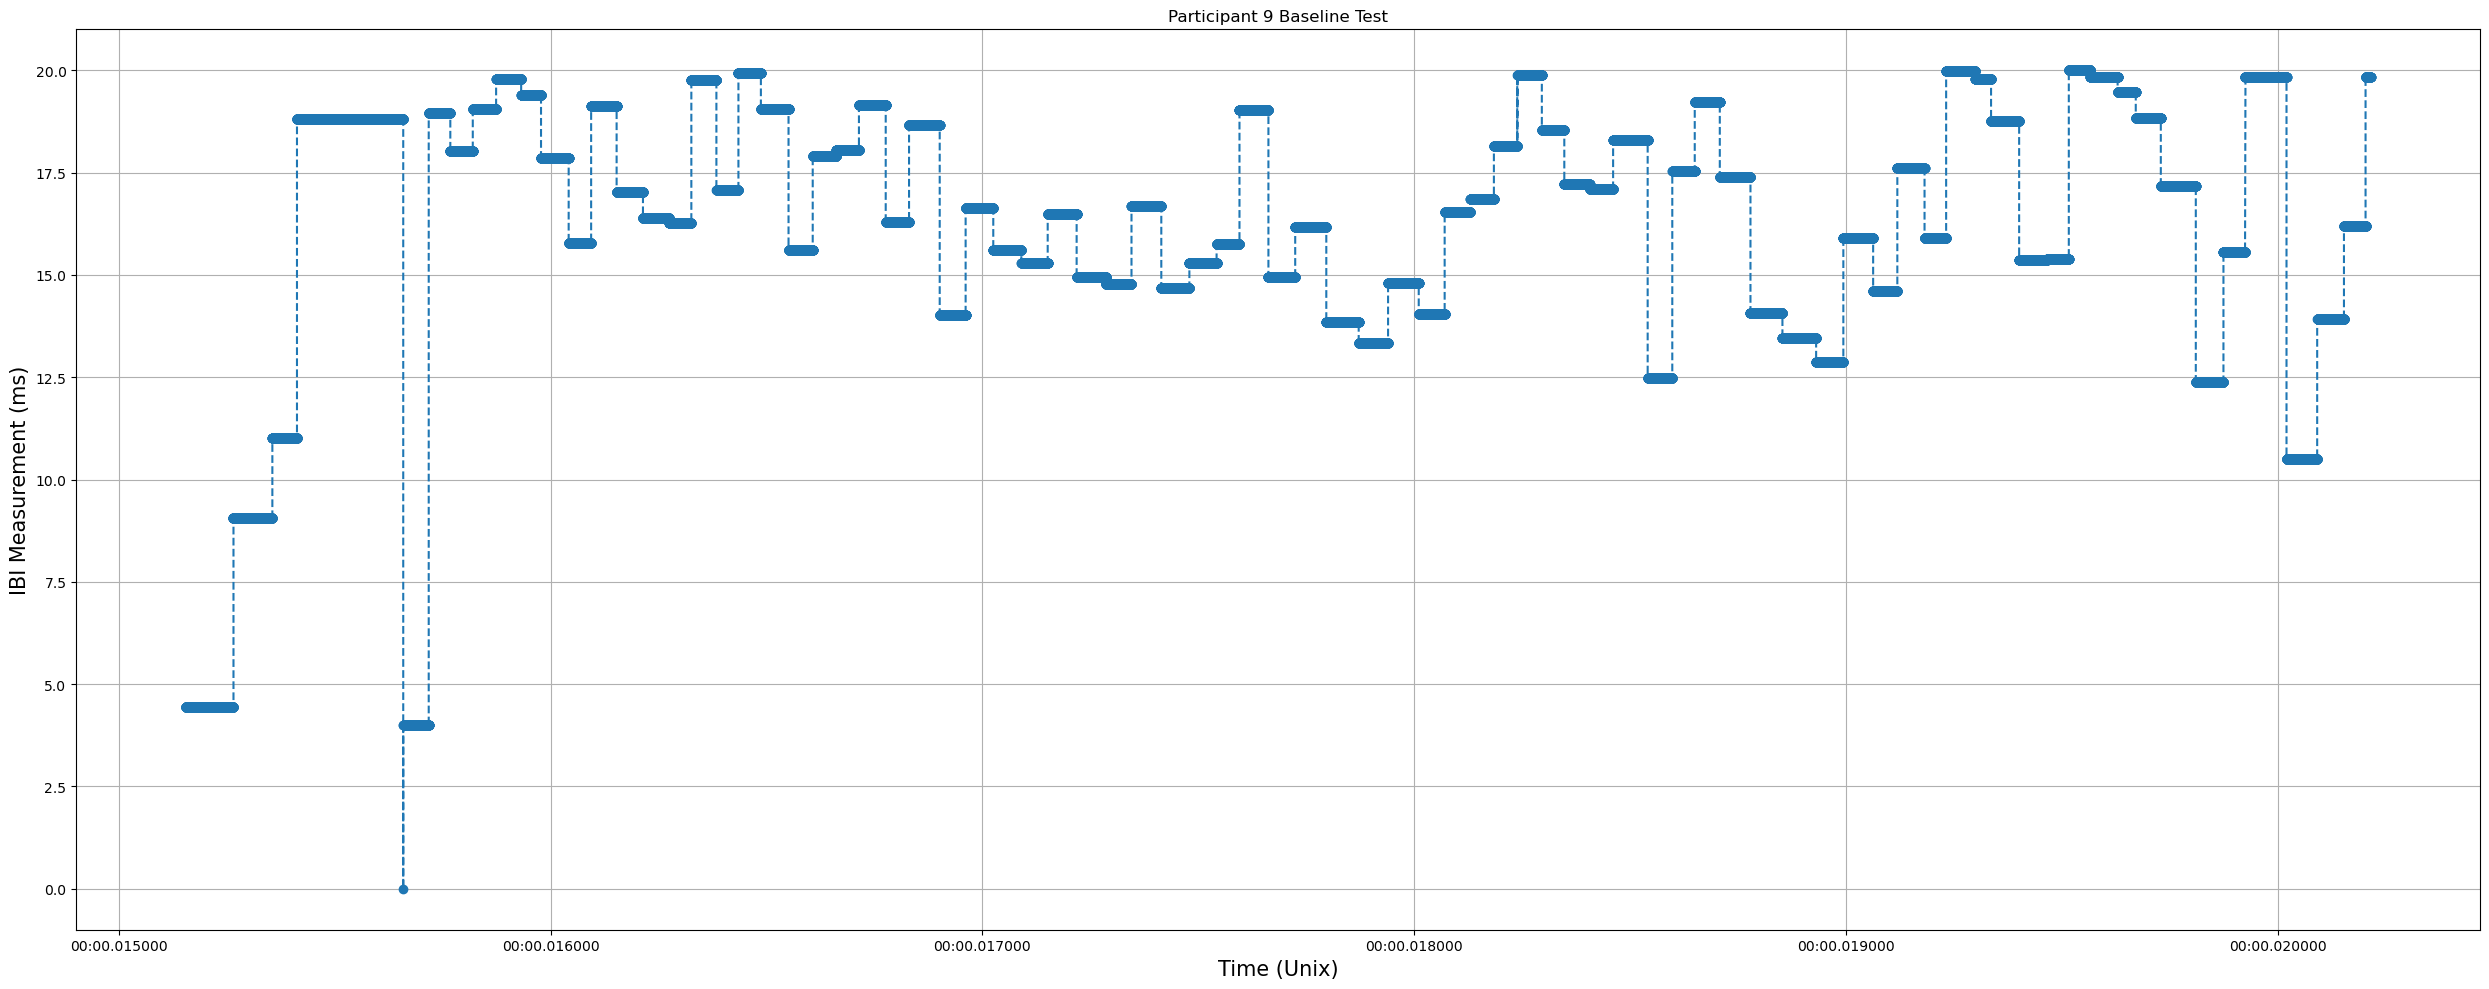

<Figure size 2500x1000 with 0 Axes>

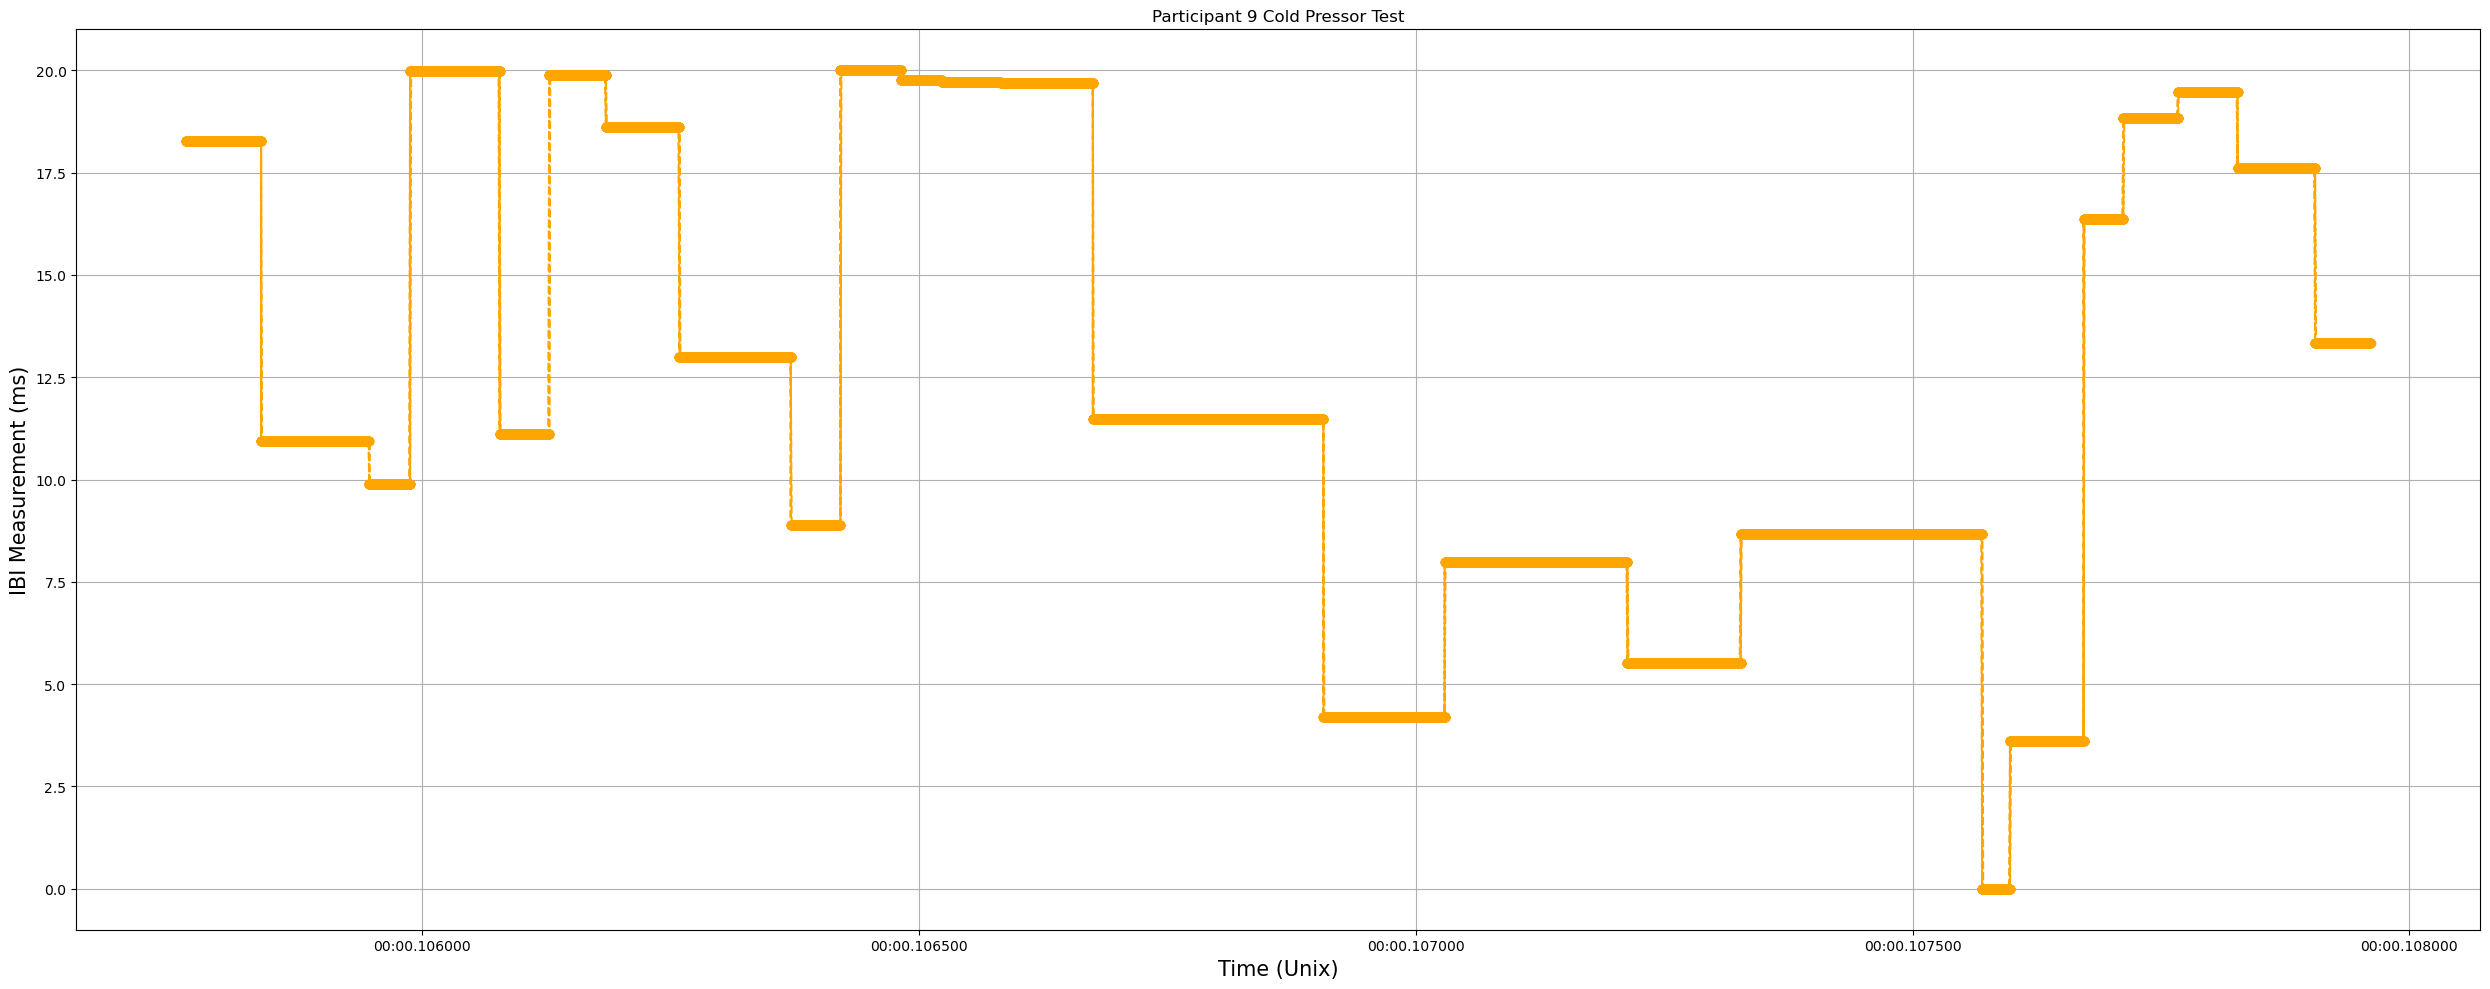

<Figure size 2500x1000 with 0 Axes>

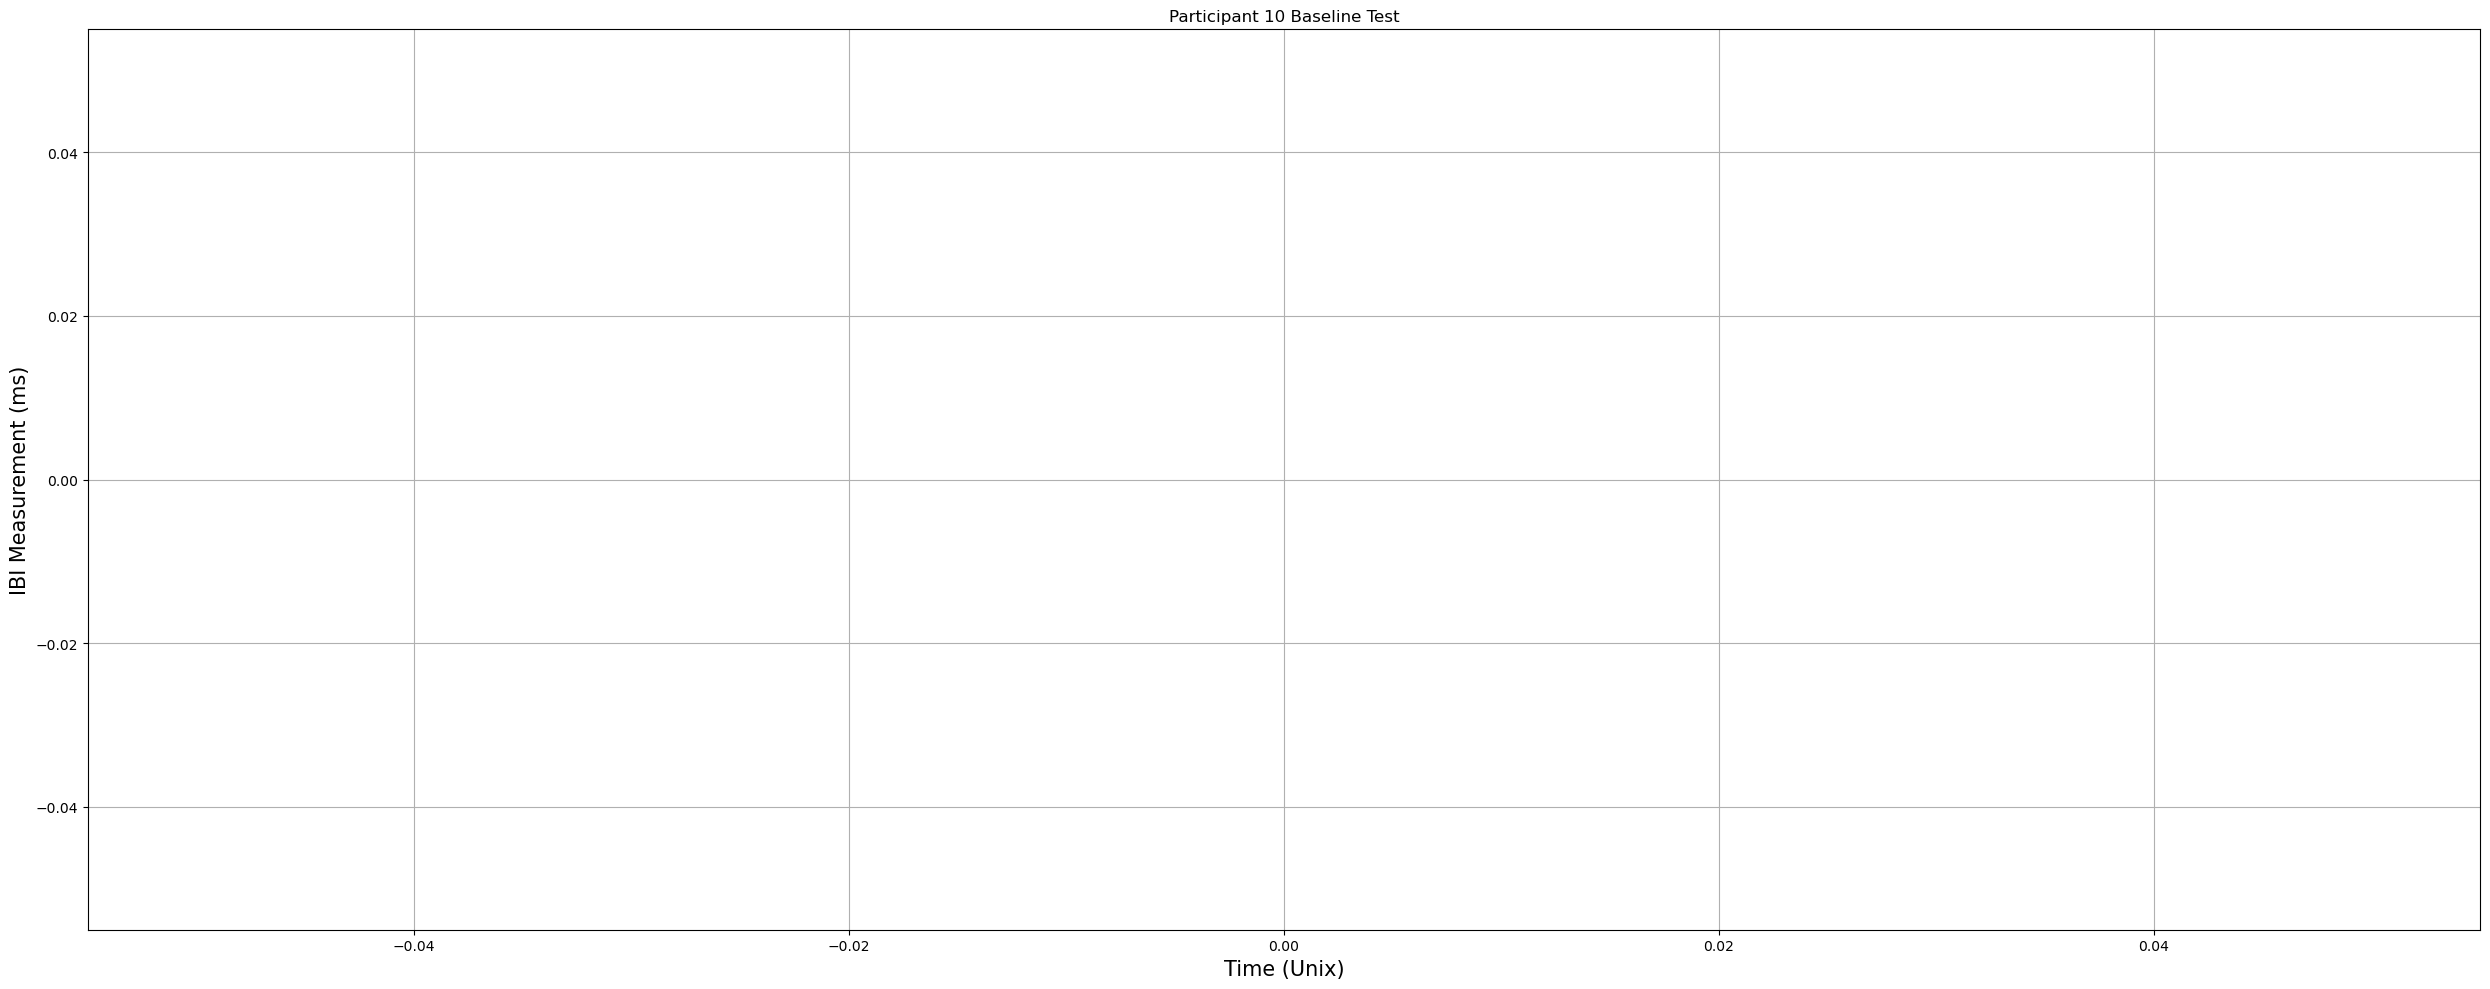

<Figure size 2500x1000 with 0 Axes>

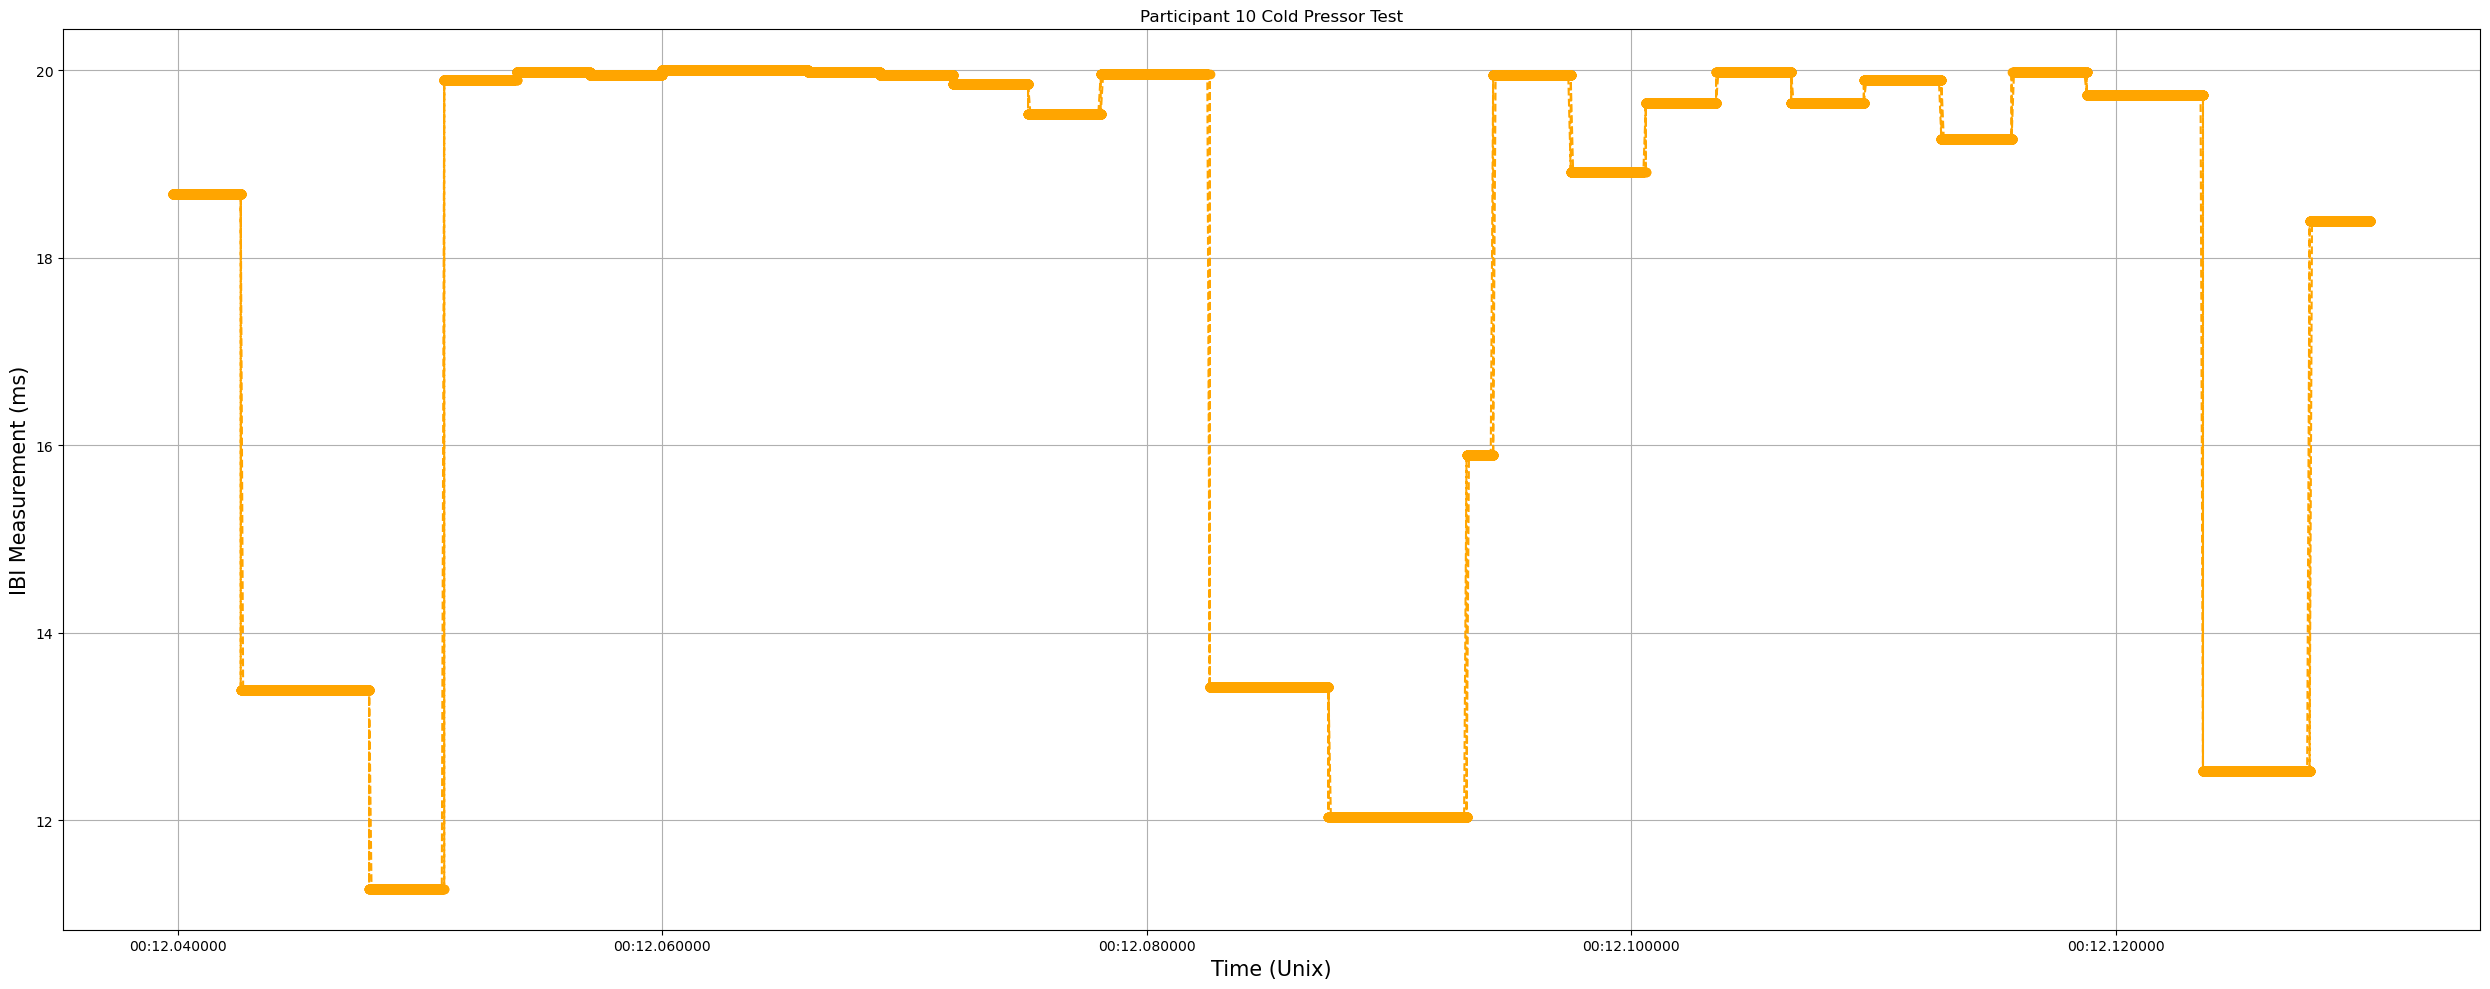

<Figure size 2500x1000 with 0 Axes>

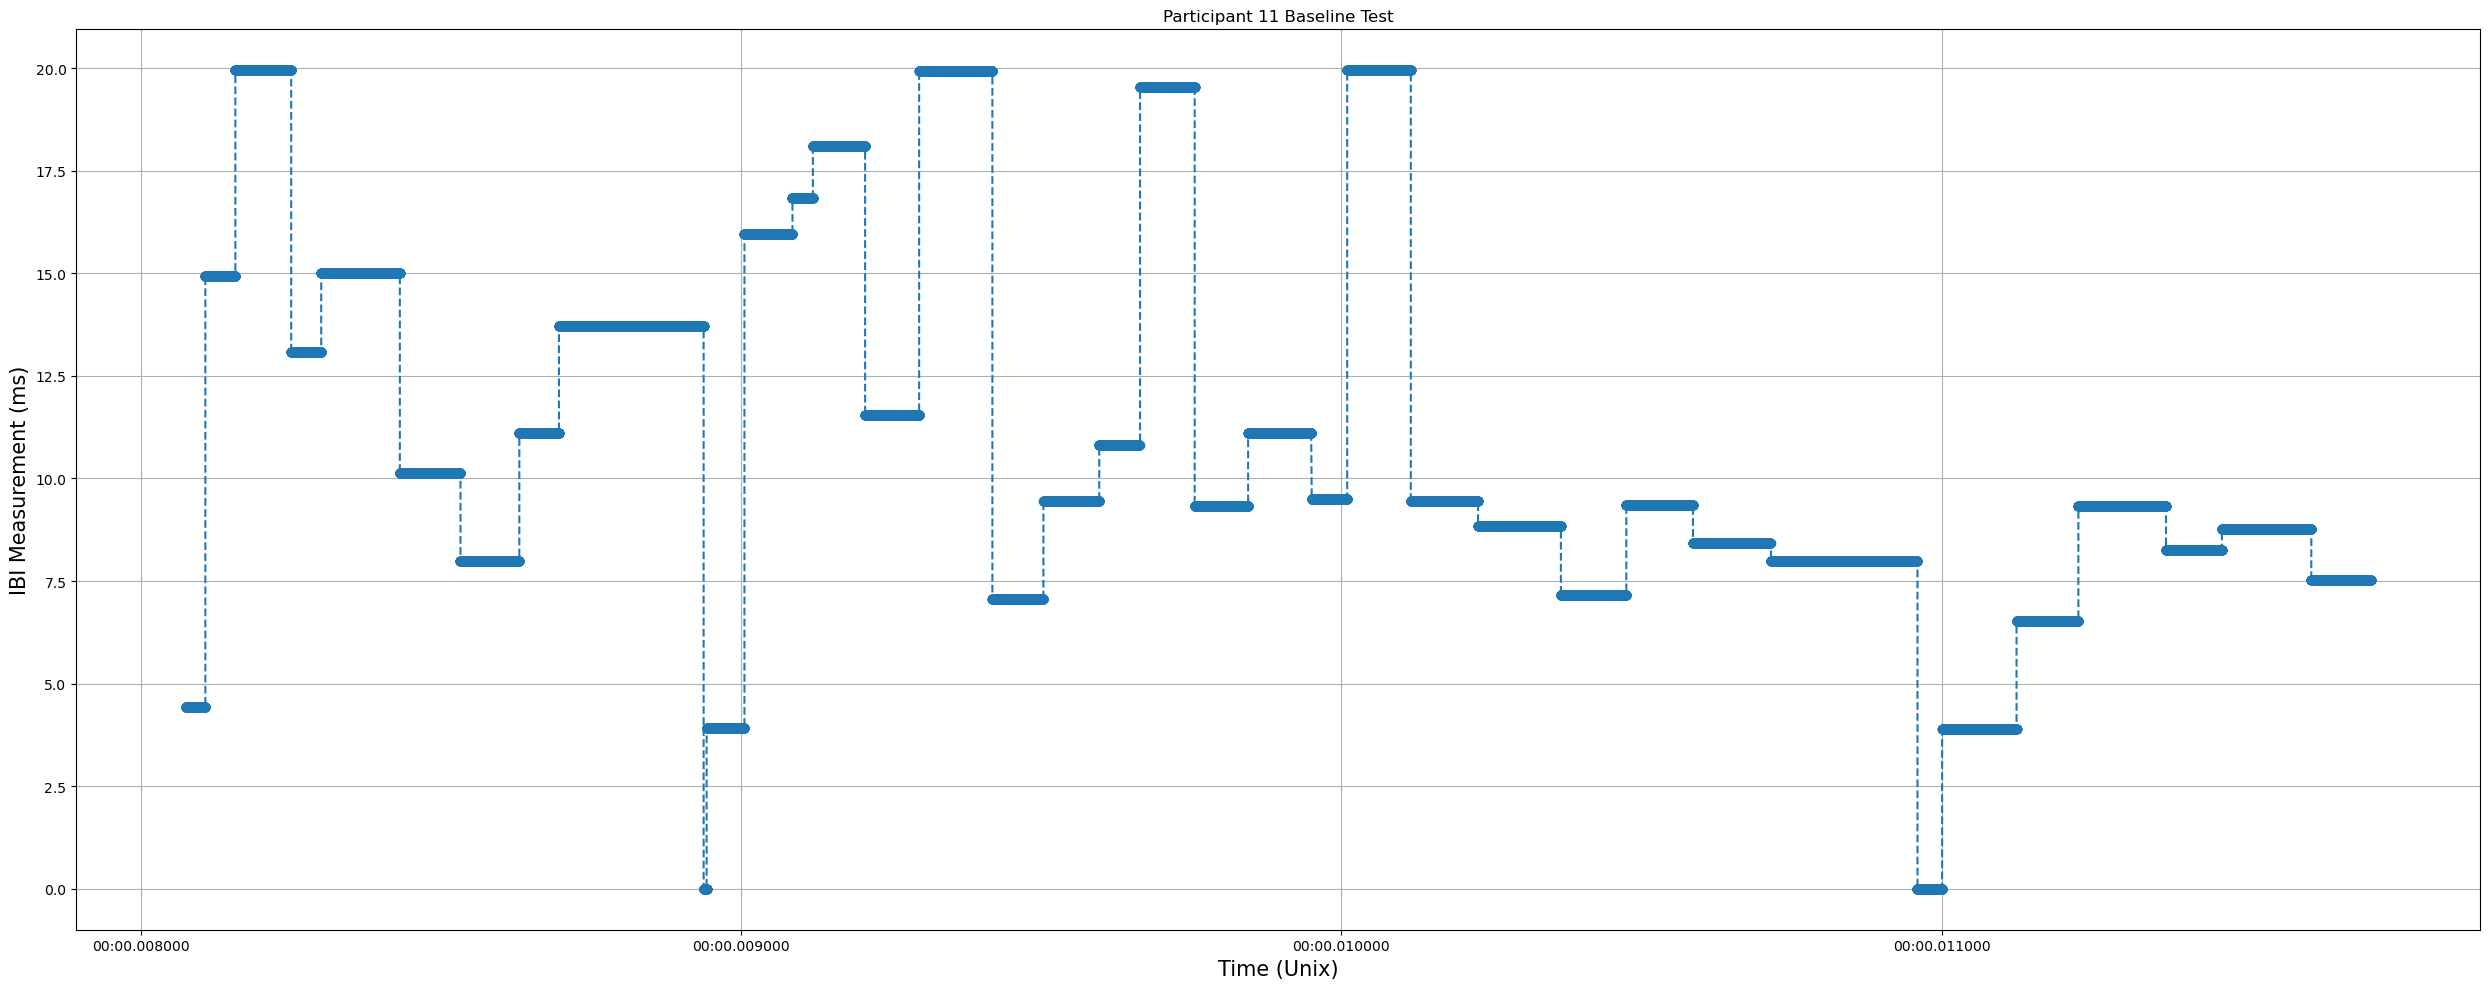

<Figure size 2500x1000 with 0 Axes>

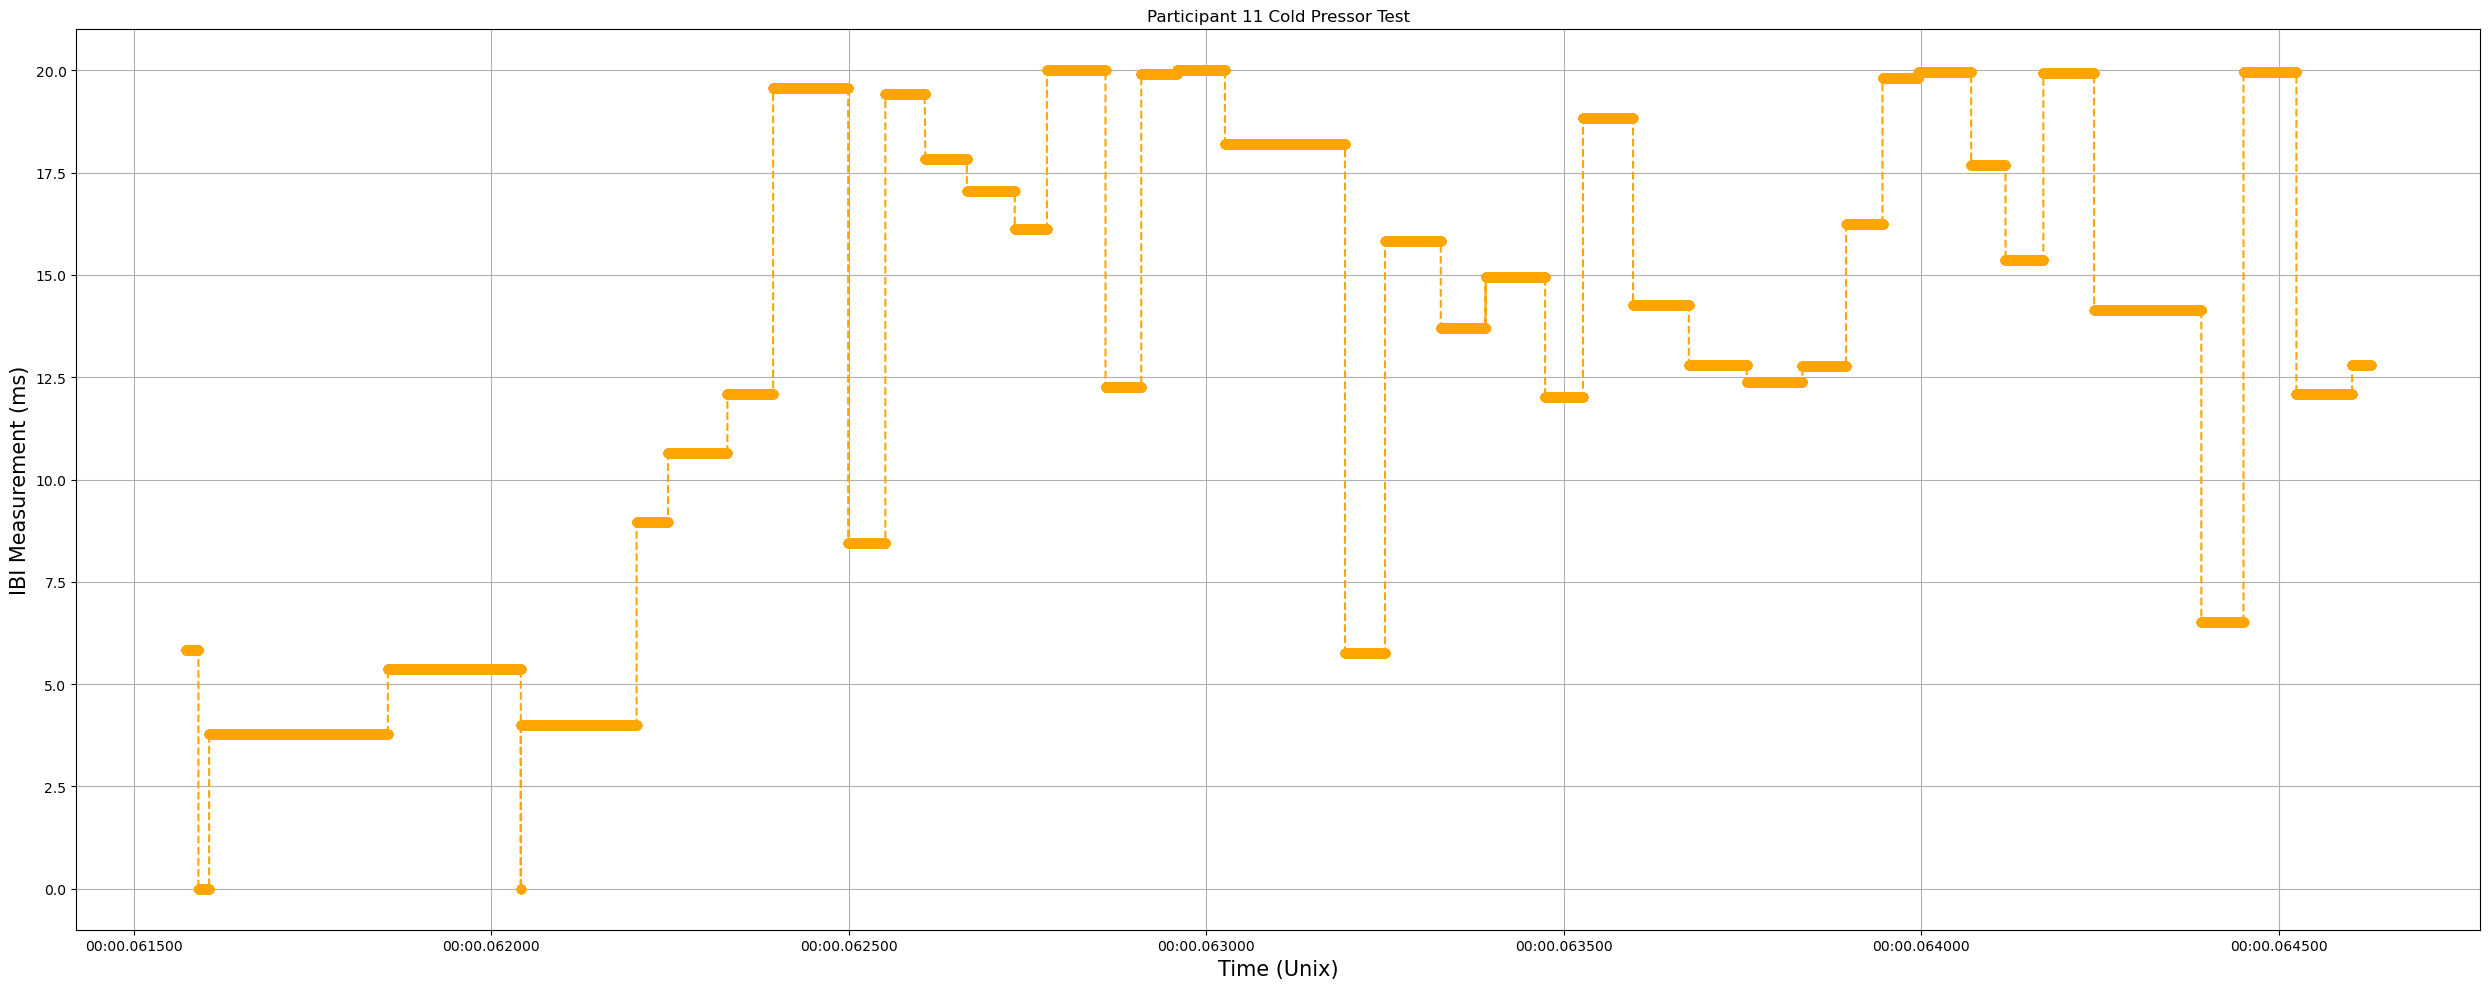

<Figure size 2500x1000 with 0 Axes>

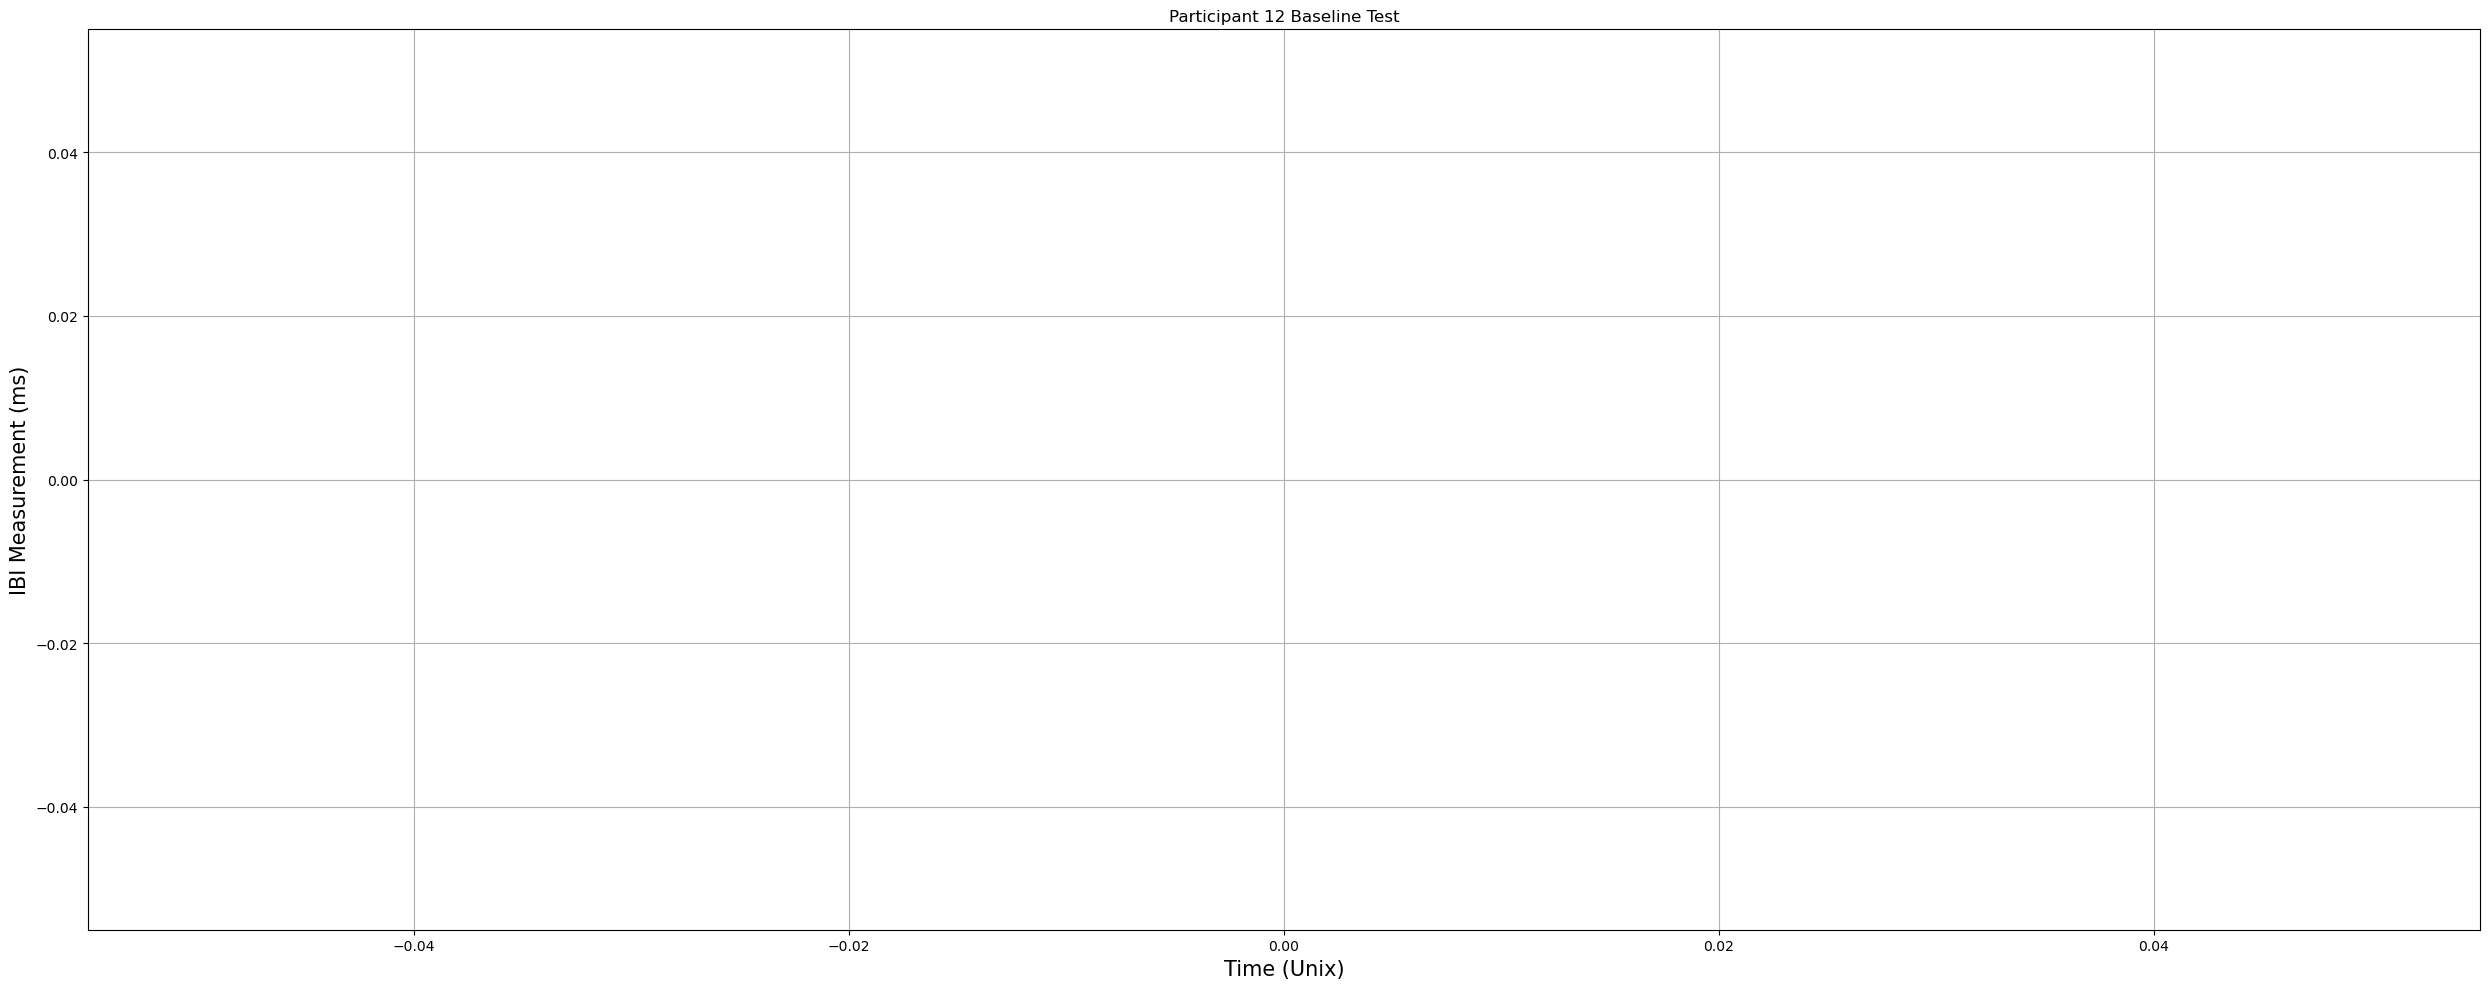

<Figure size 2500x1000 with 0 Axes>

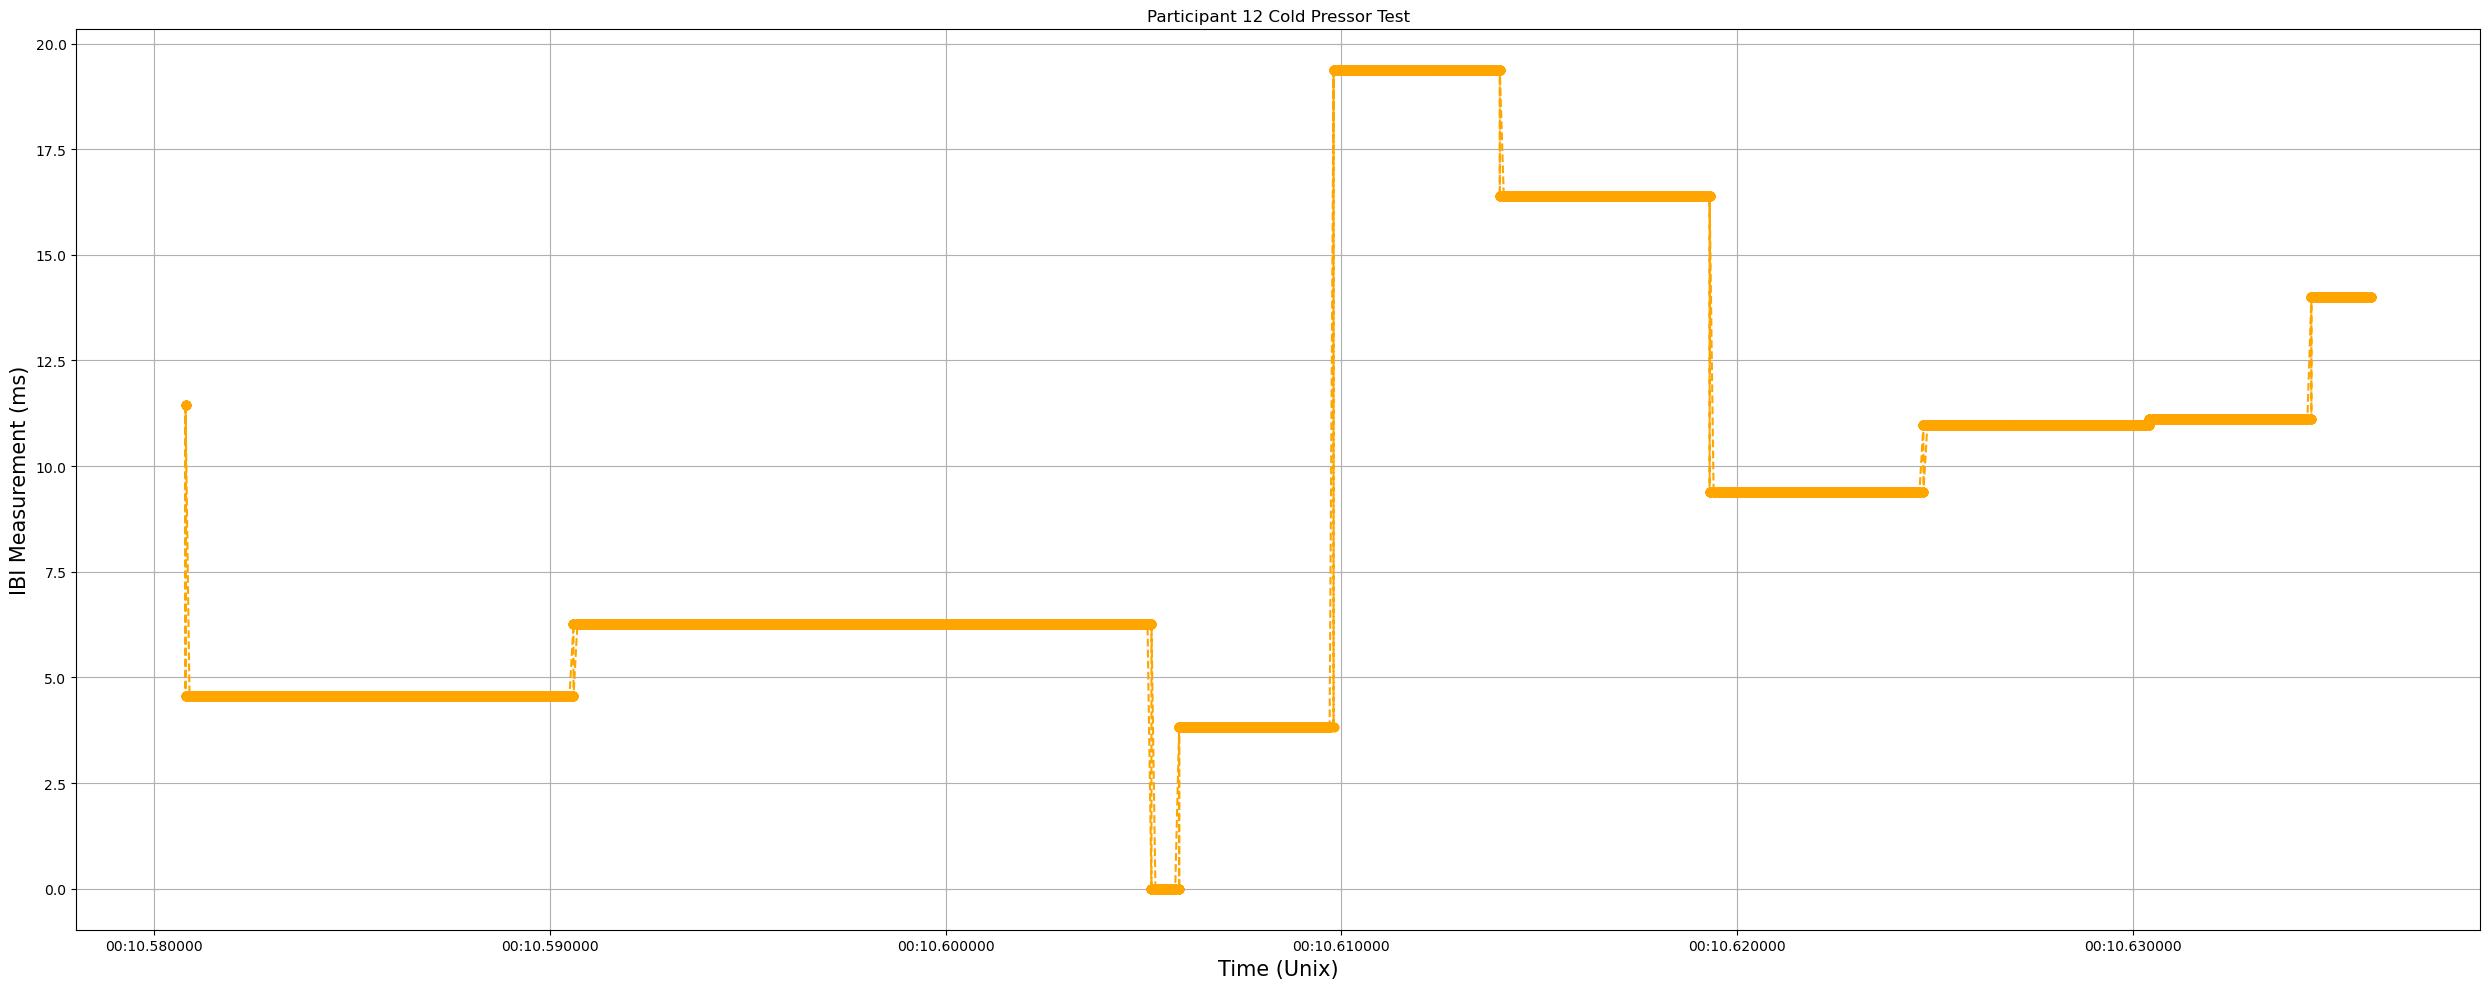

<Figure size 2500x1000 with 0 Axes>

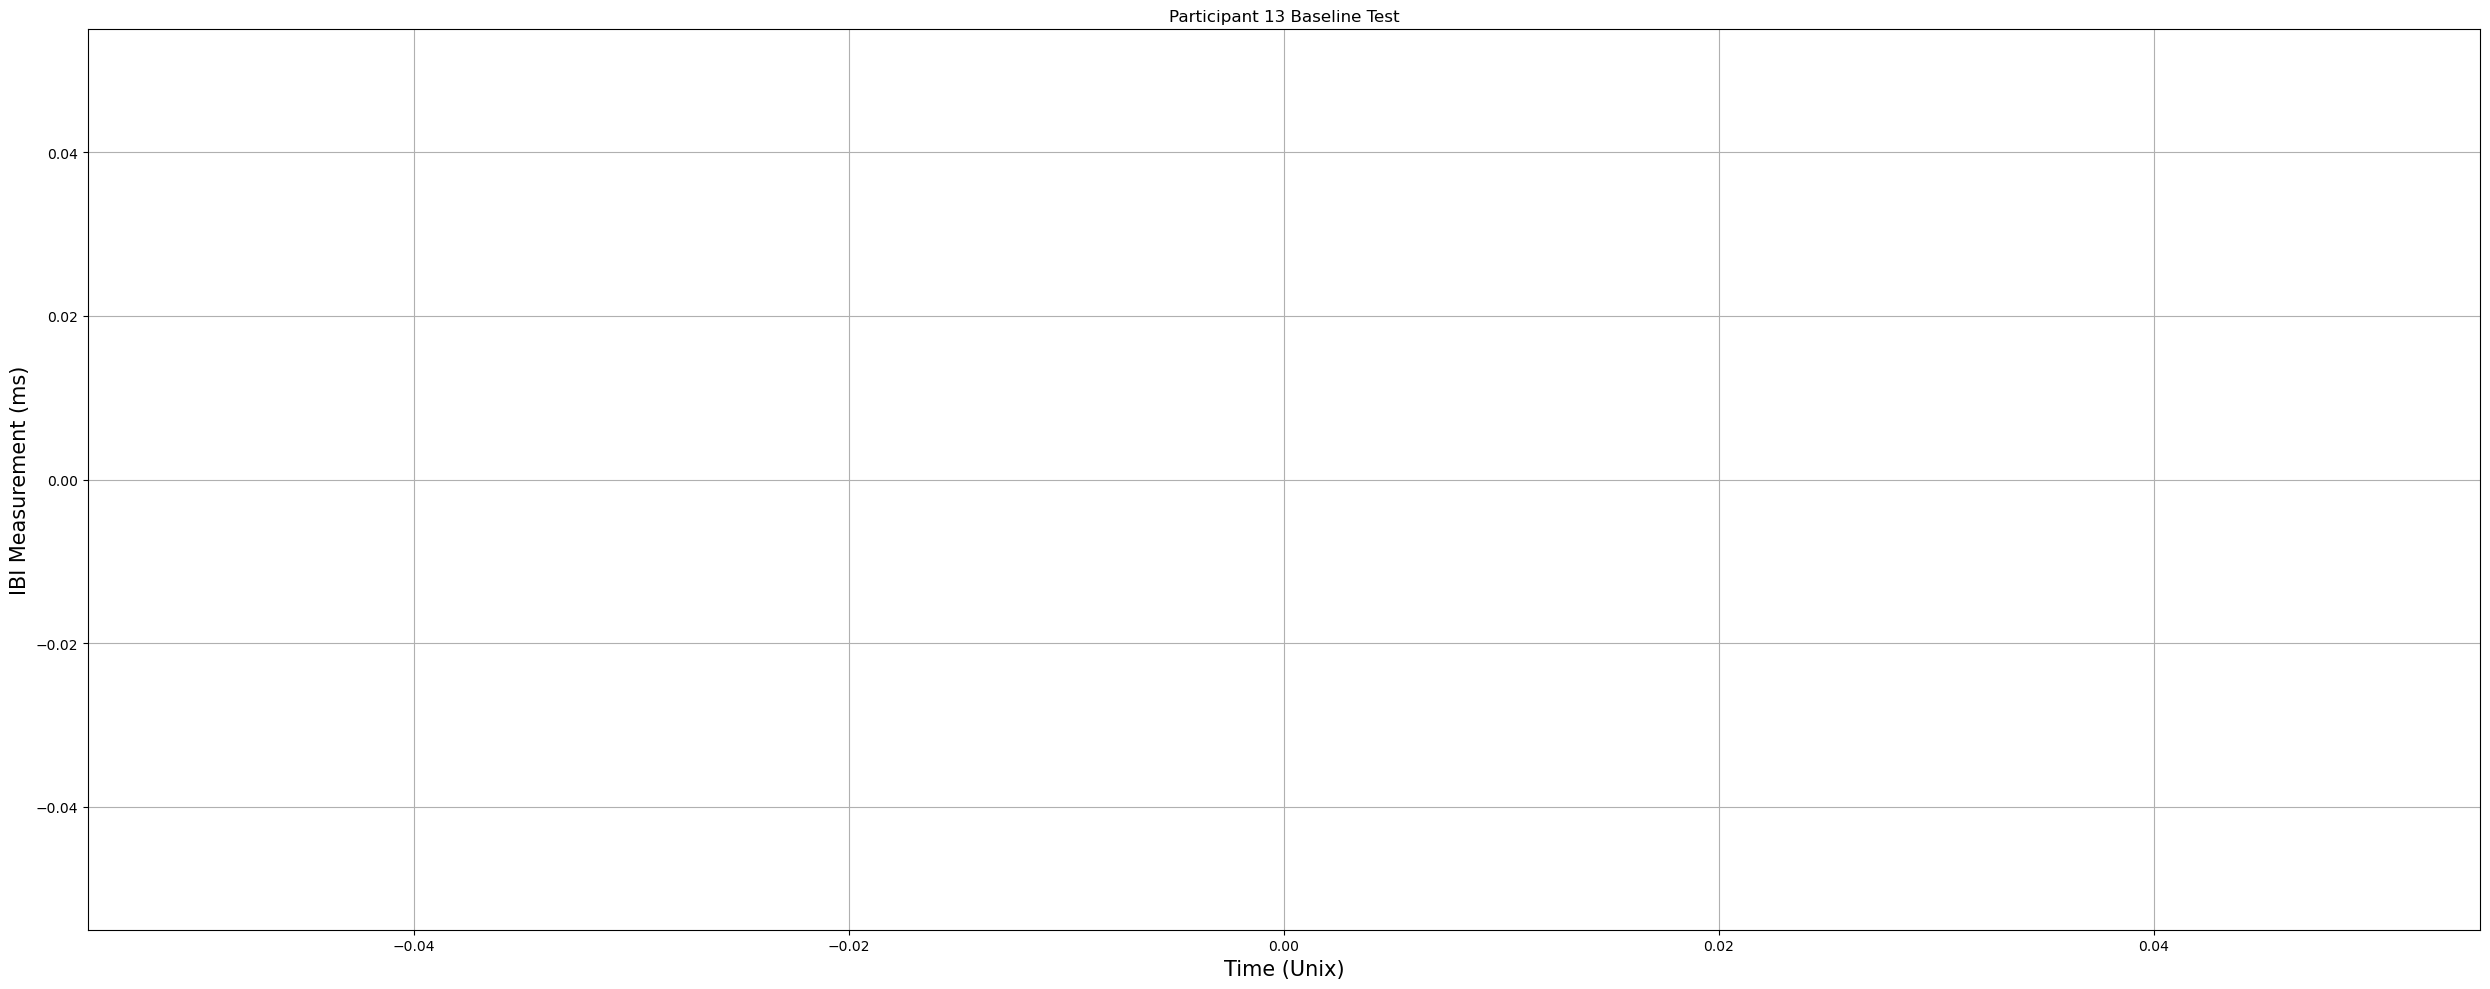

<Figure size 2500x1000 with 0 Axes>

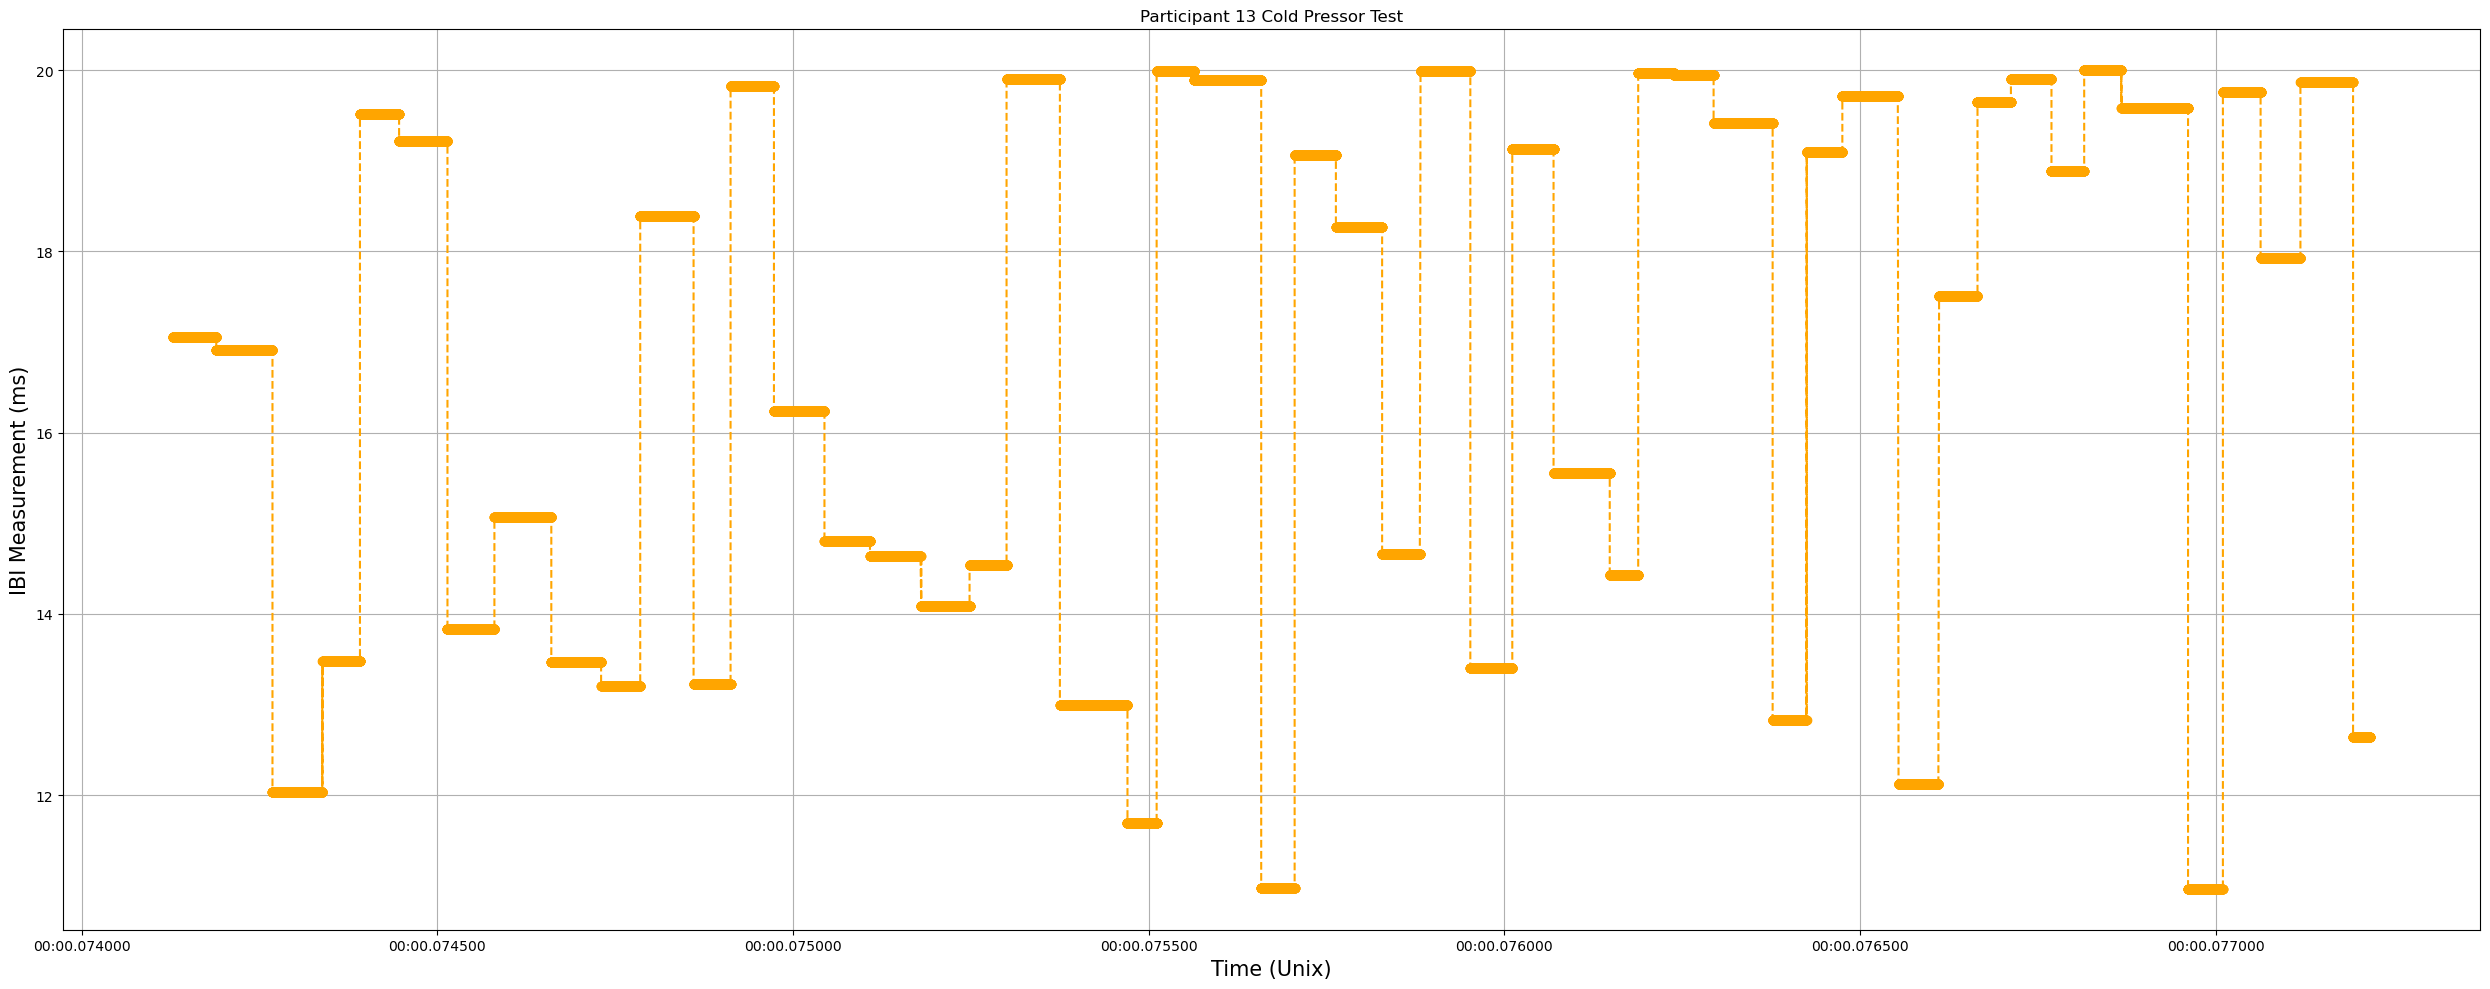

<Figure size 2500x1000 with 0 Axes>

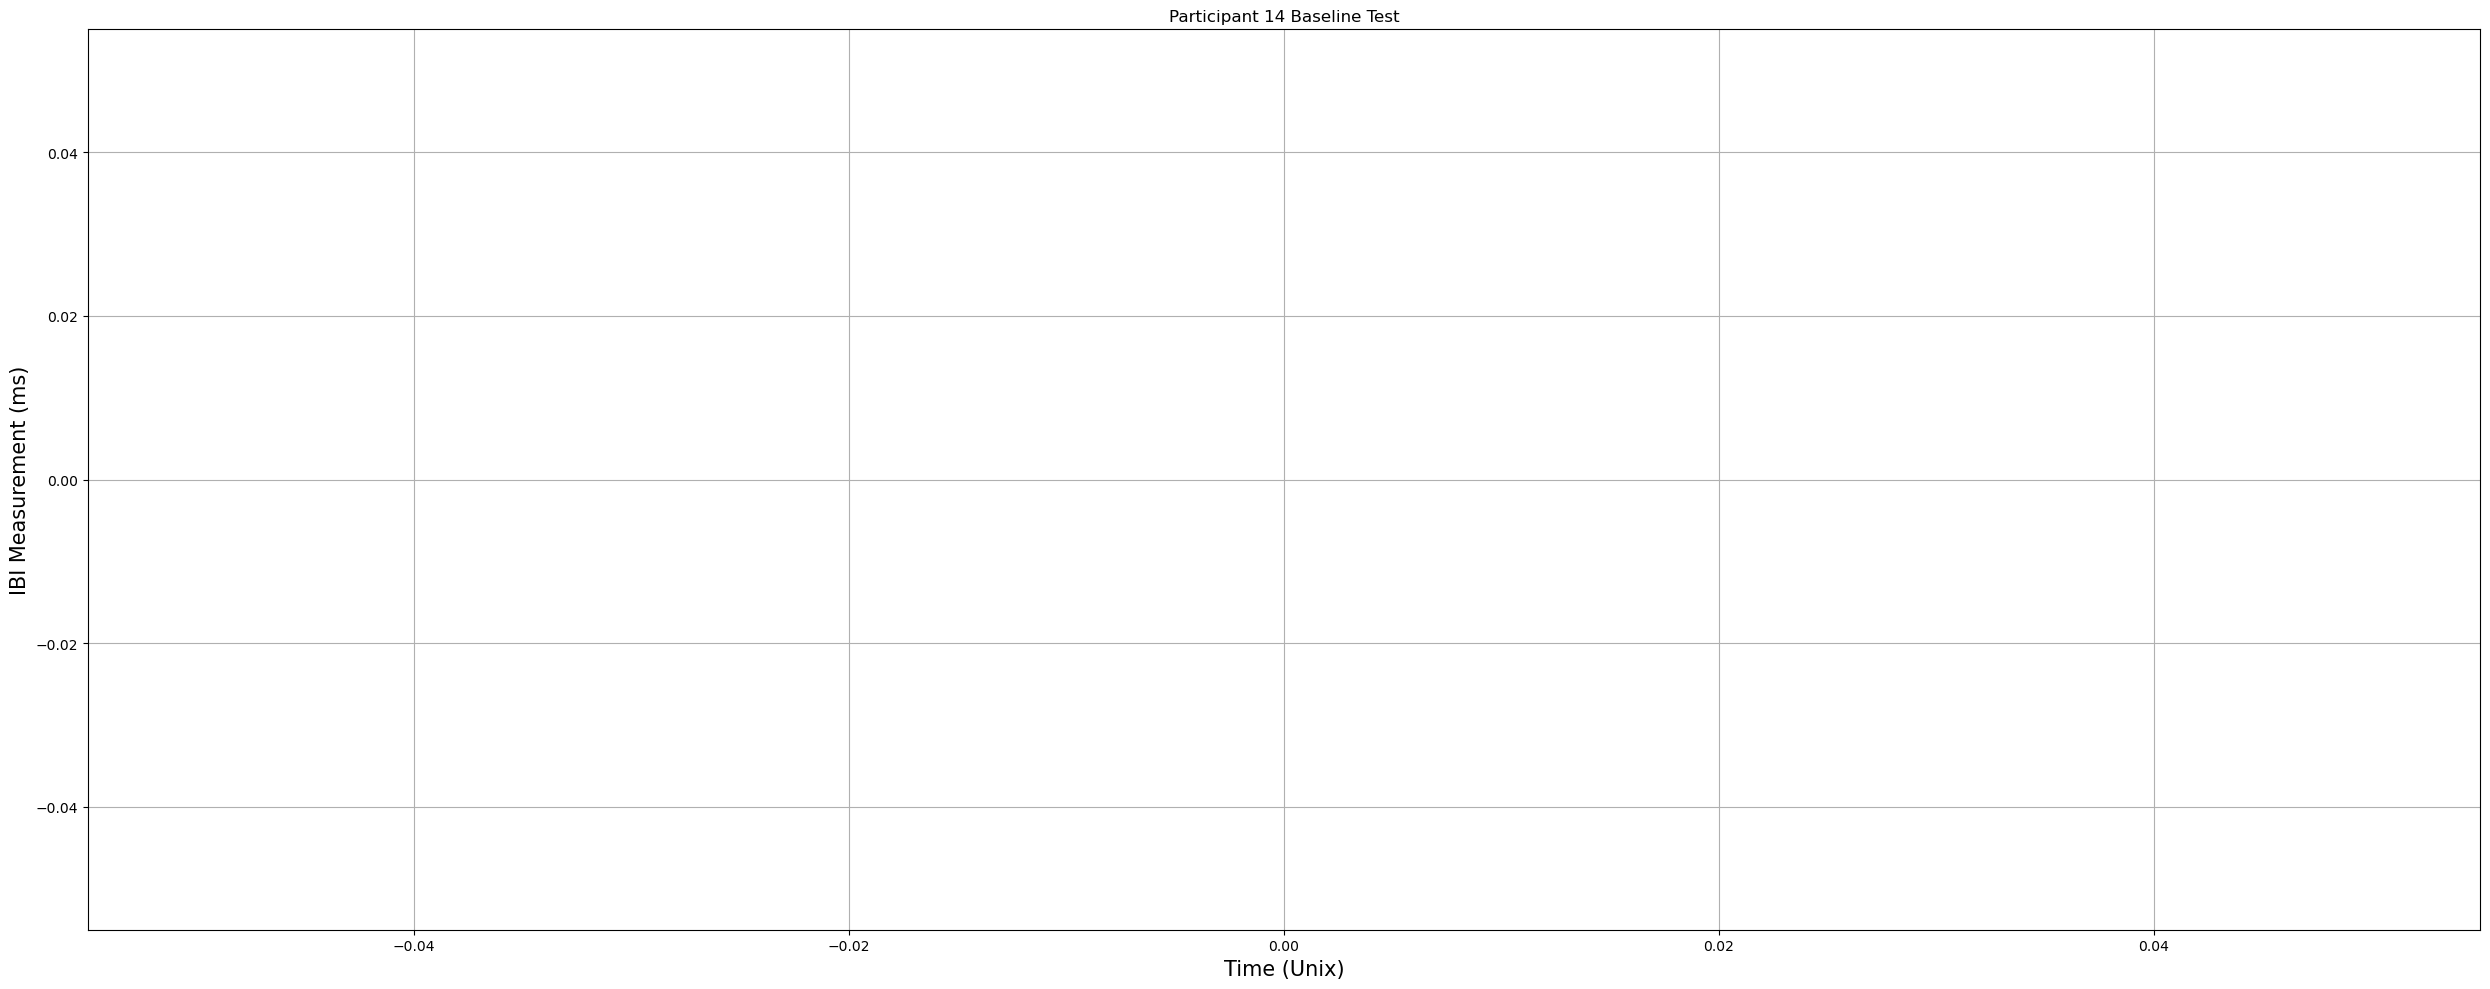

<Figure size 2500x1000 with 0 Axes>

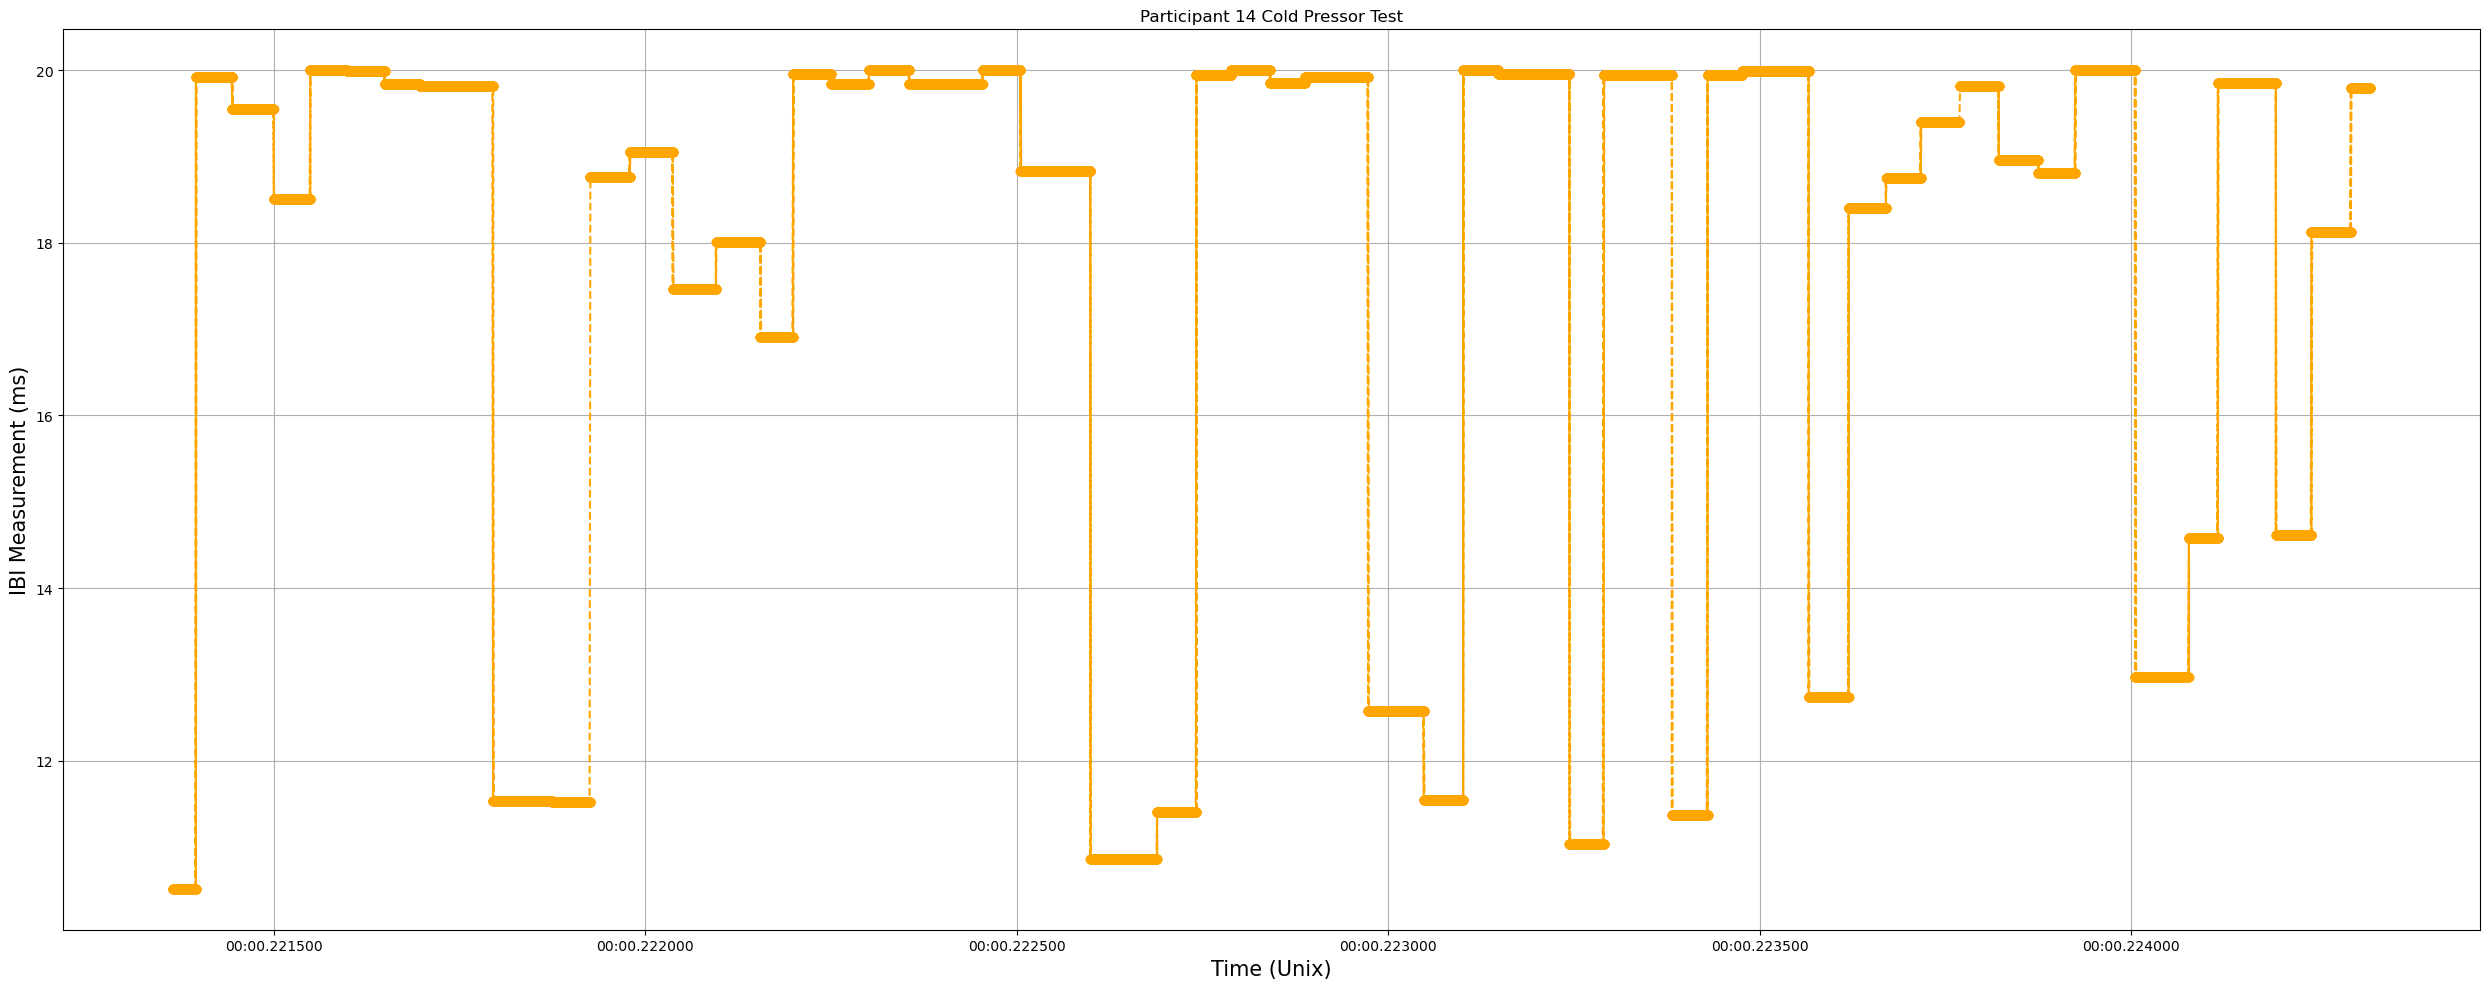

<Figure size 2500x1000 with 0 Axes>

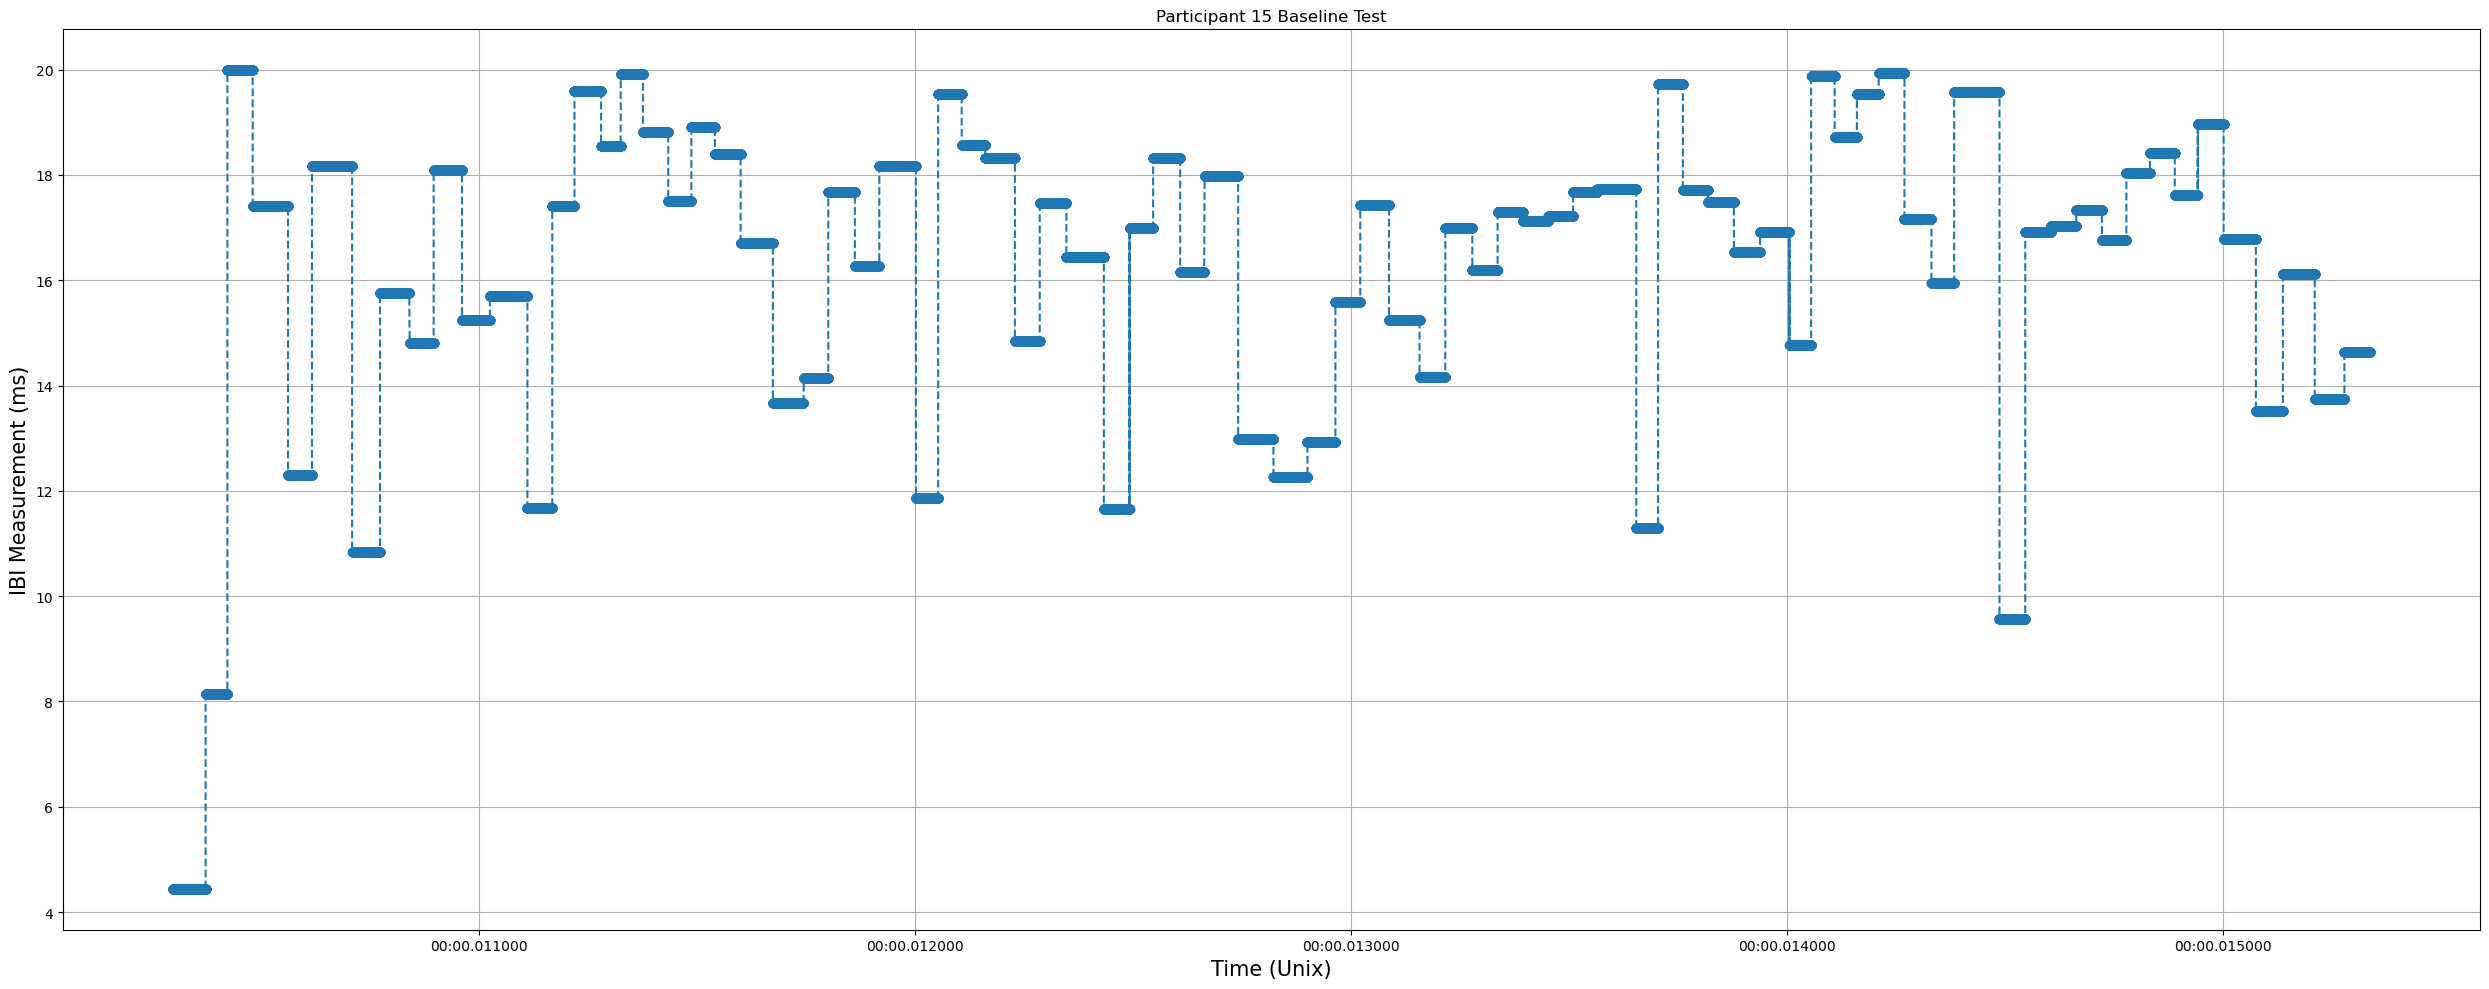

<Figure size 2500x1000 with 0 Axes>

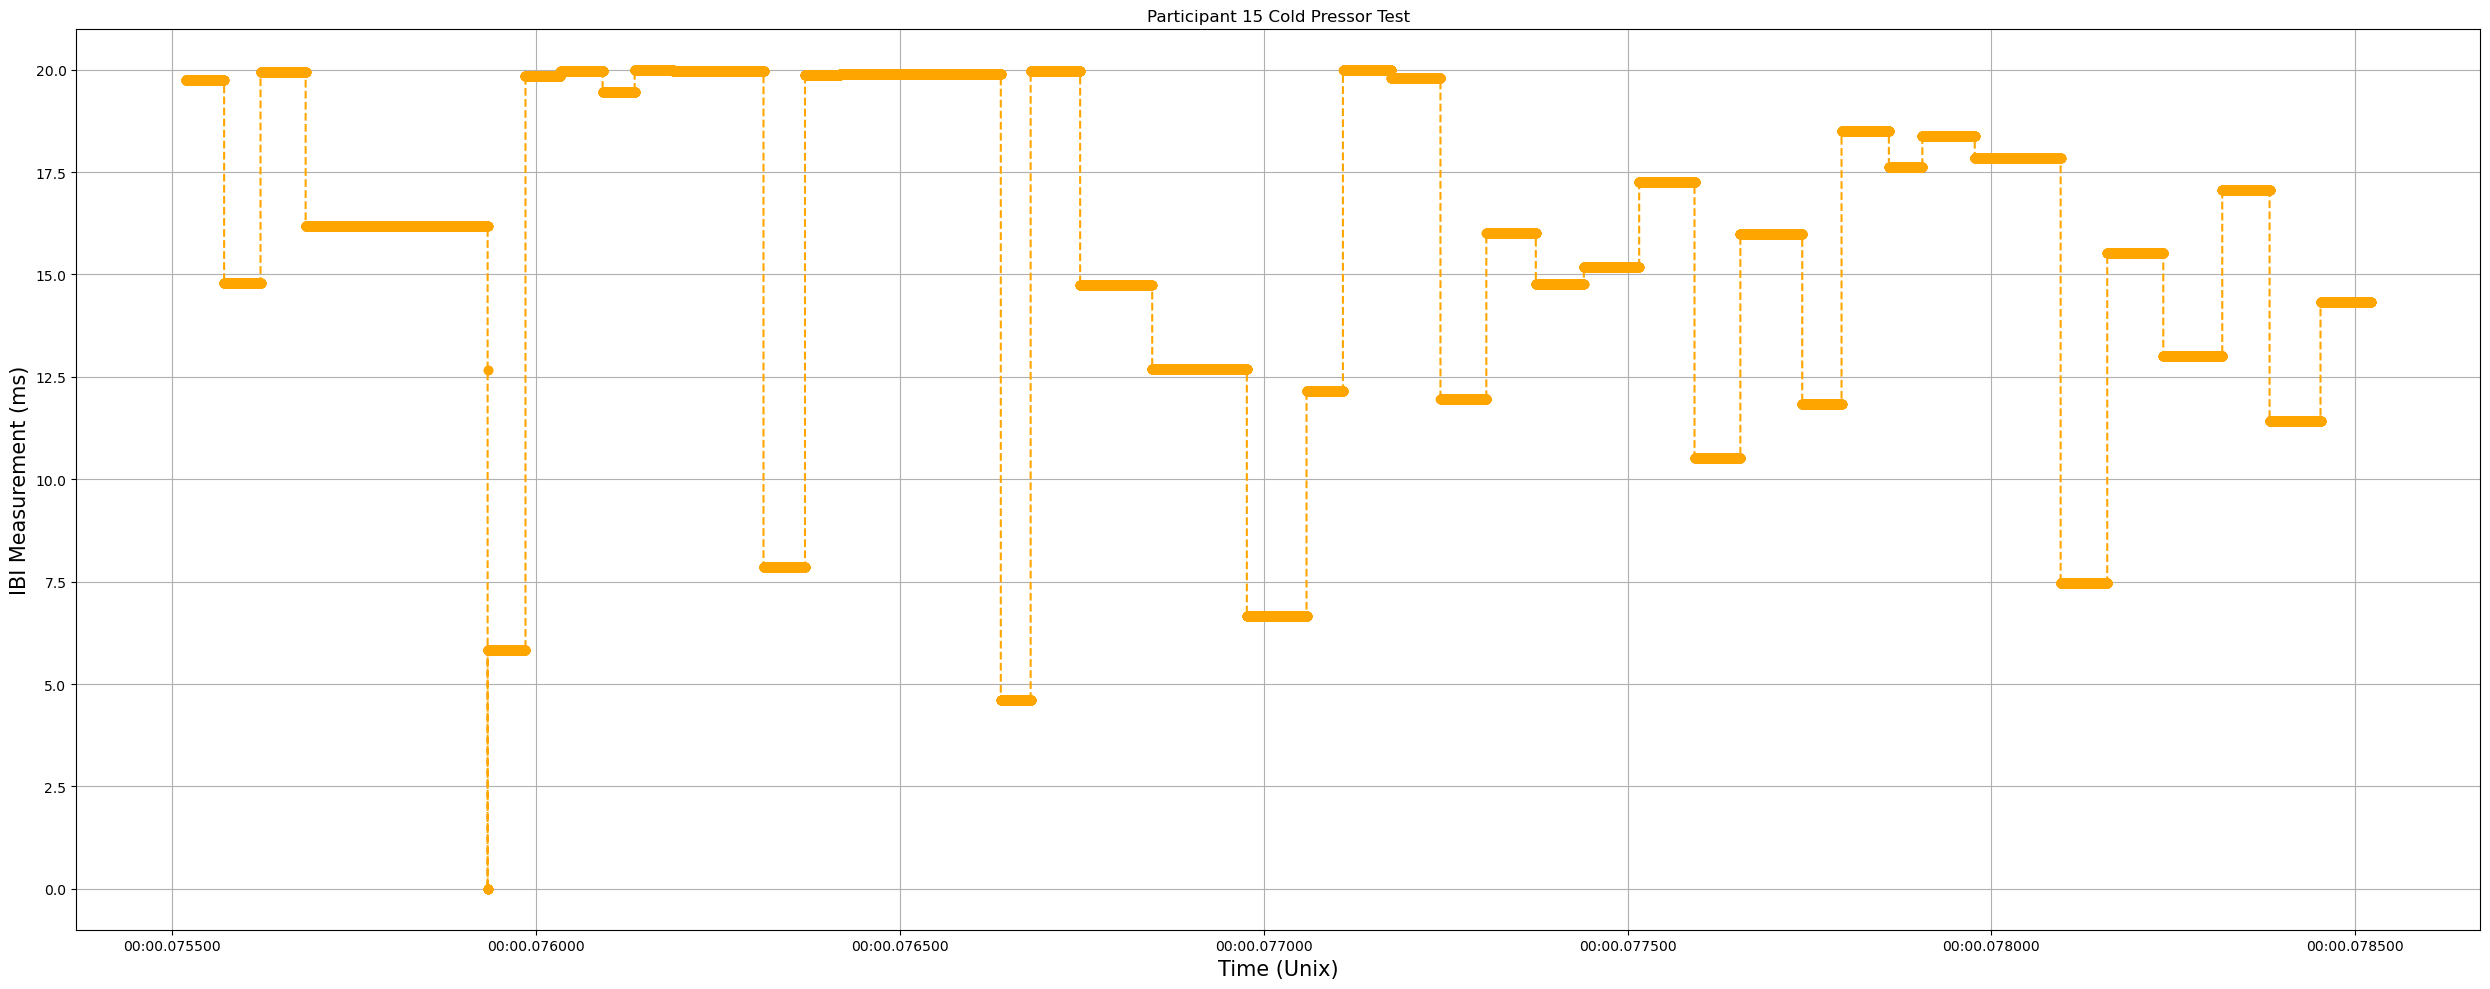

<Figure size 2500x1000 with 0 Axes>

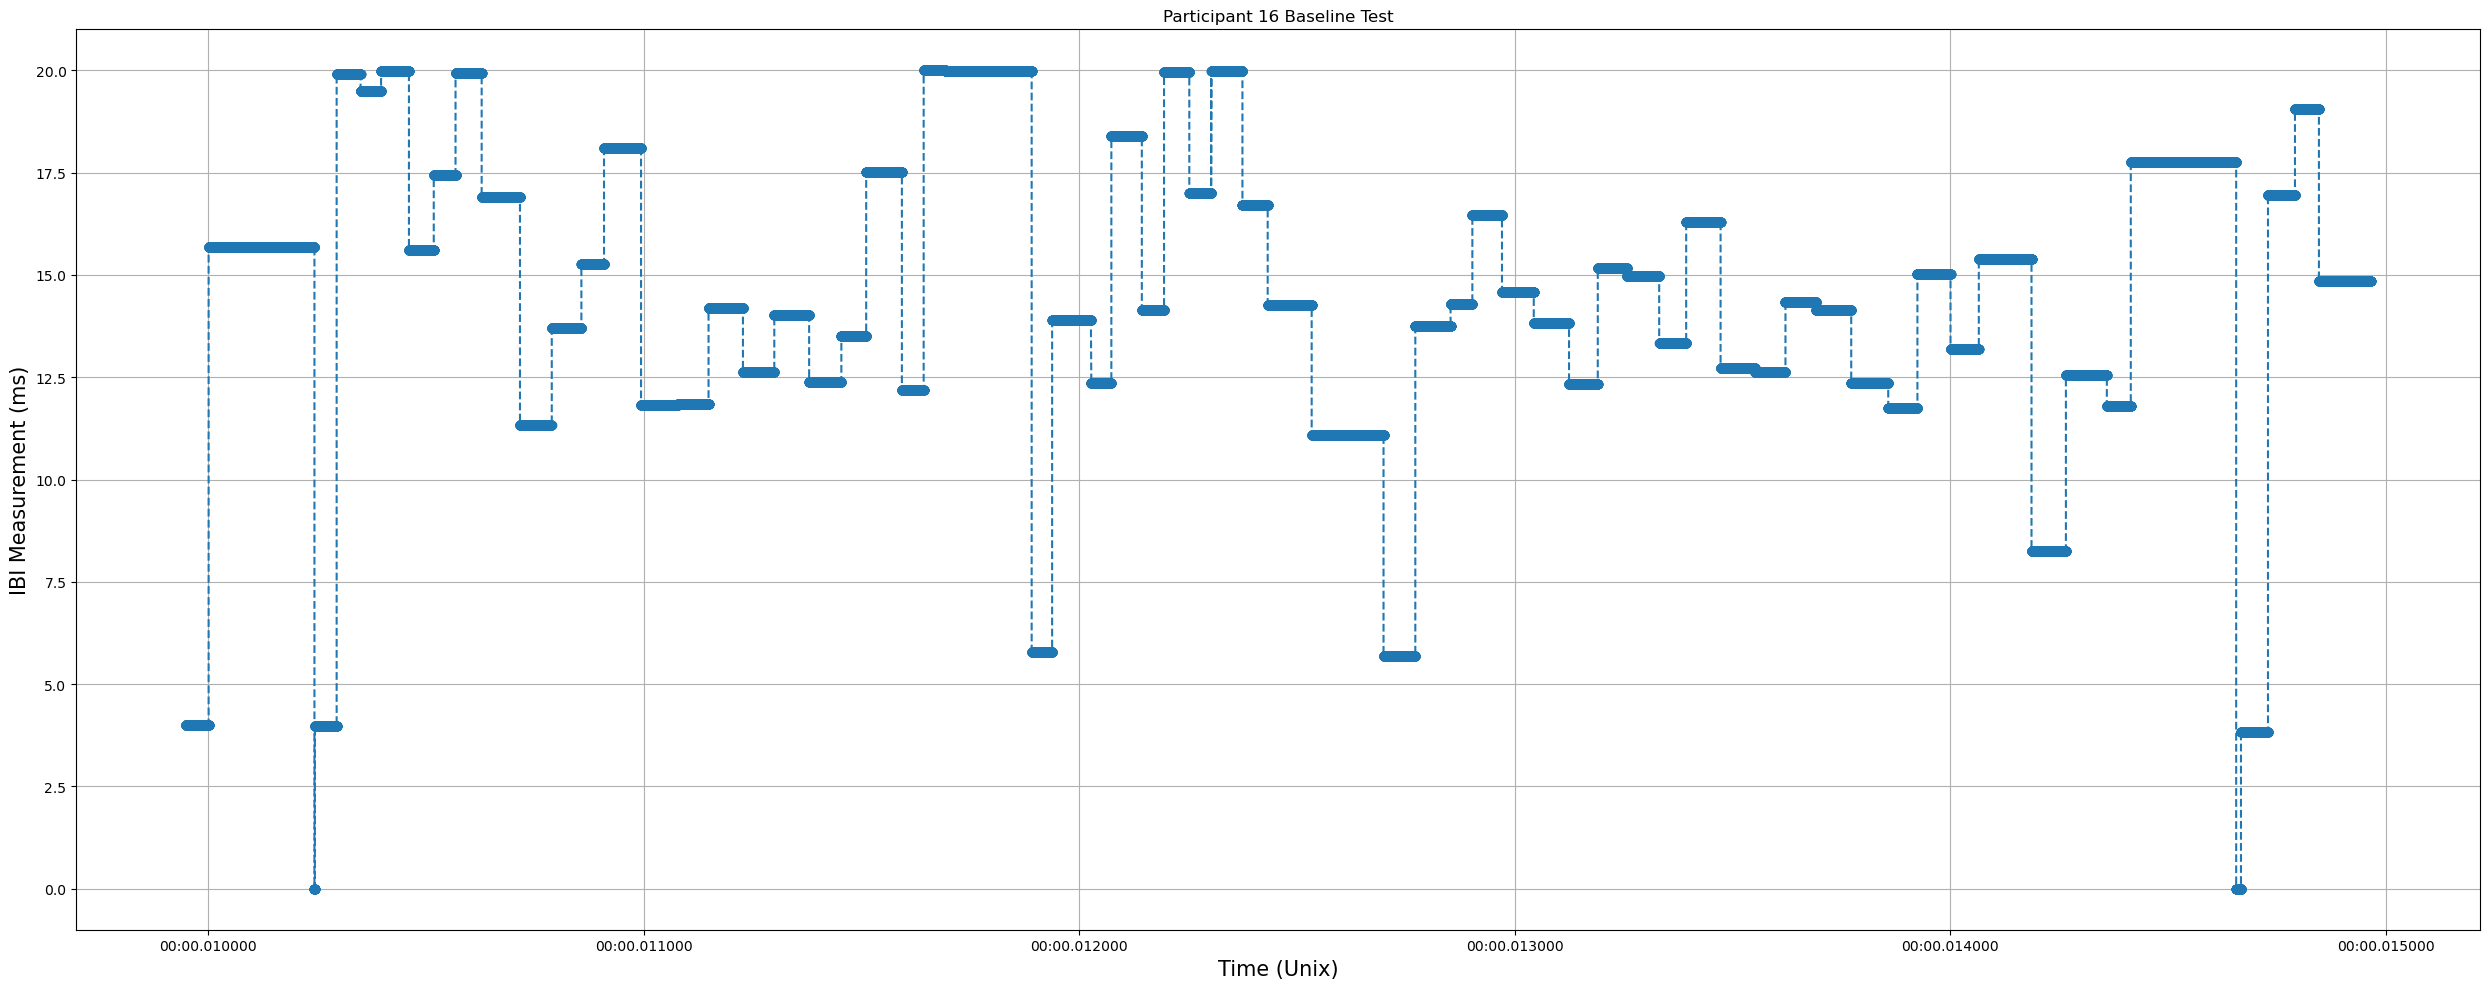

<Figure size 2500x1000 with 0 Axes>

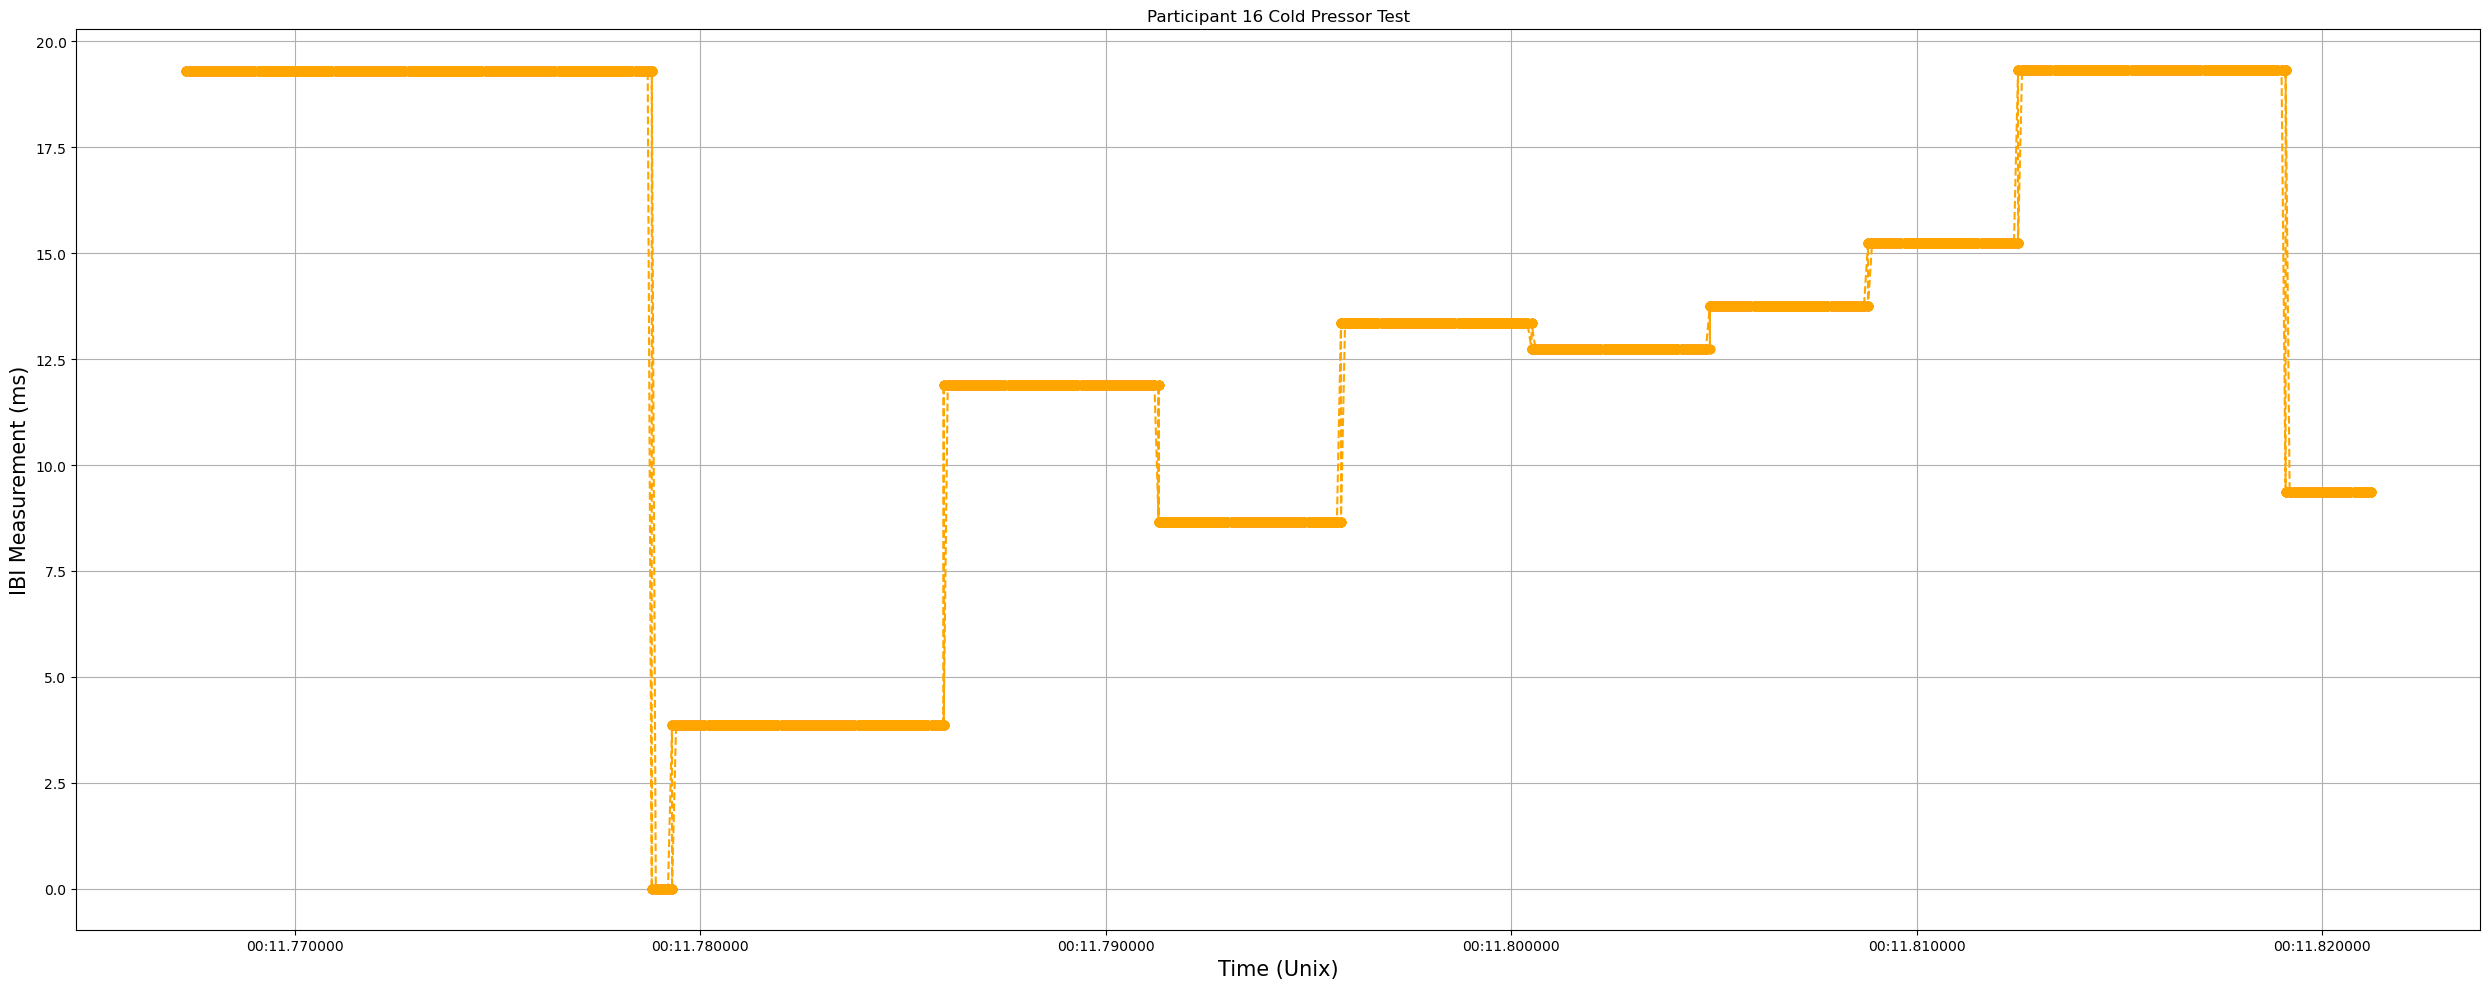

<Figure size 2500x1000 with 0 Axes>

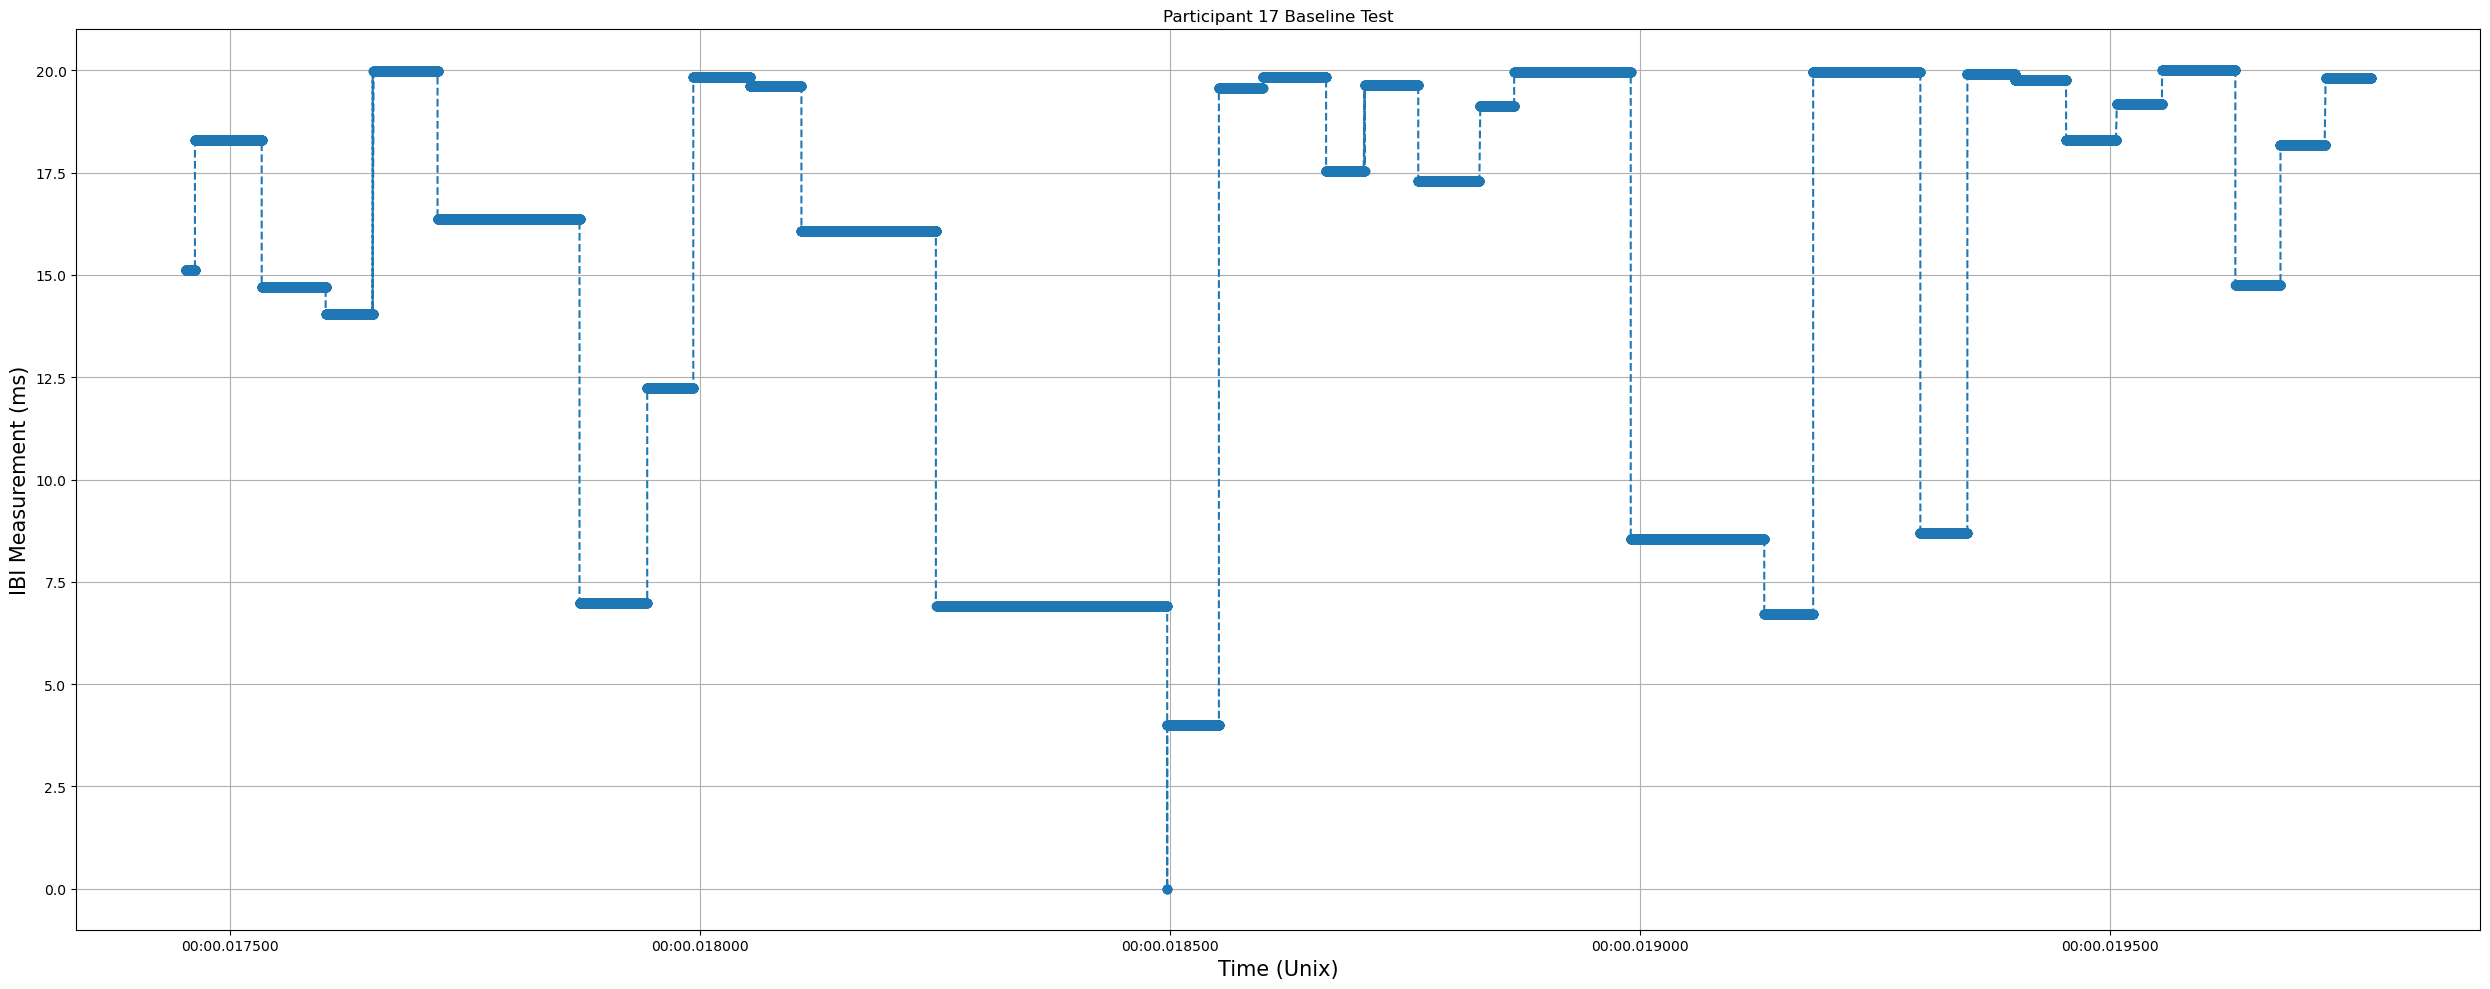

<Figure size 2500x1000 with 0 Axes>

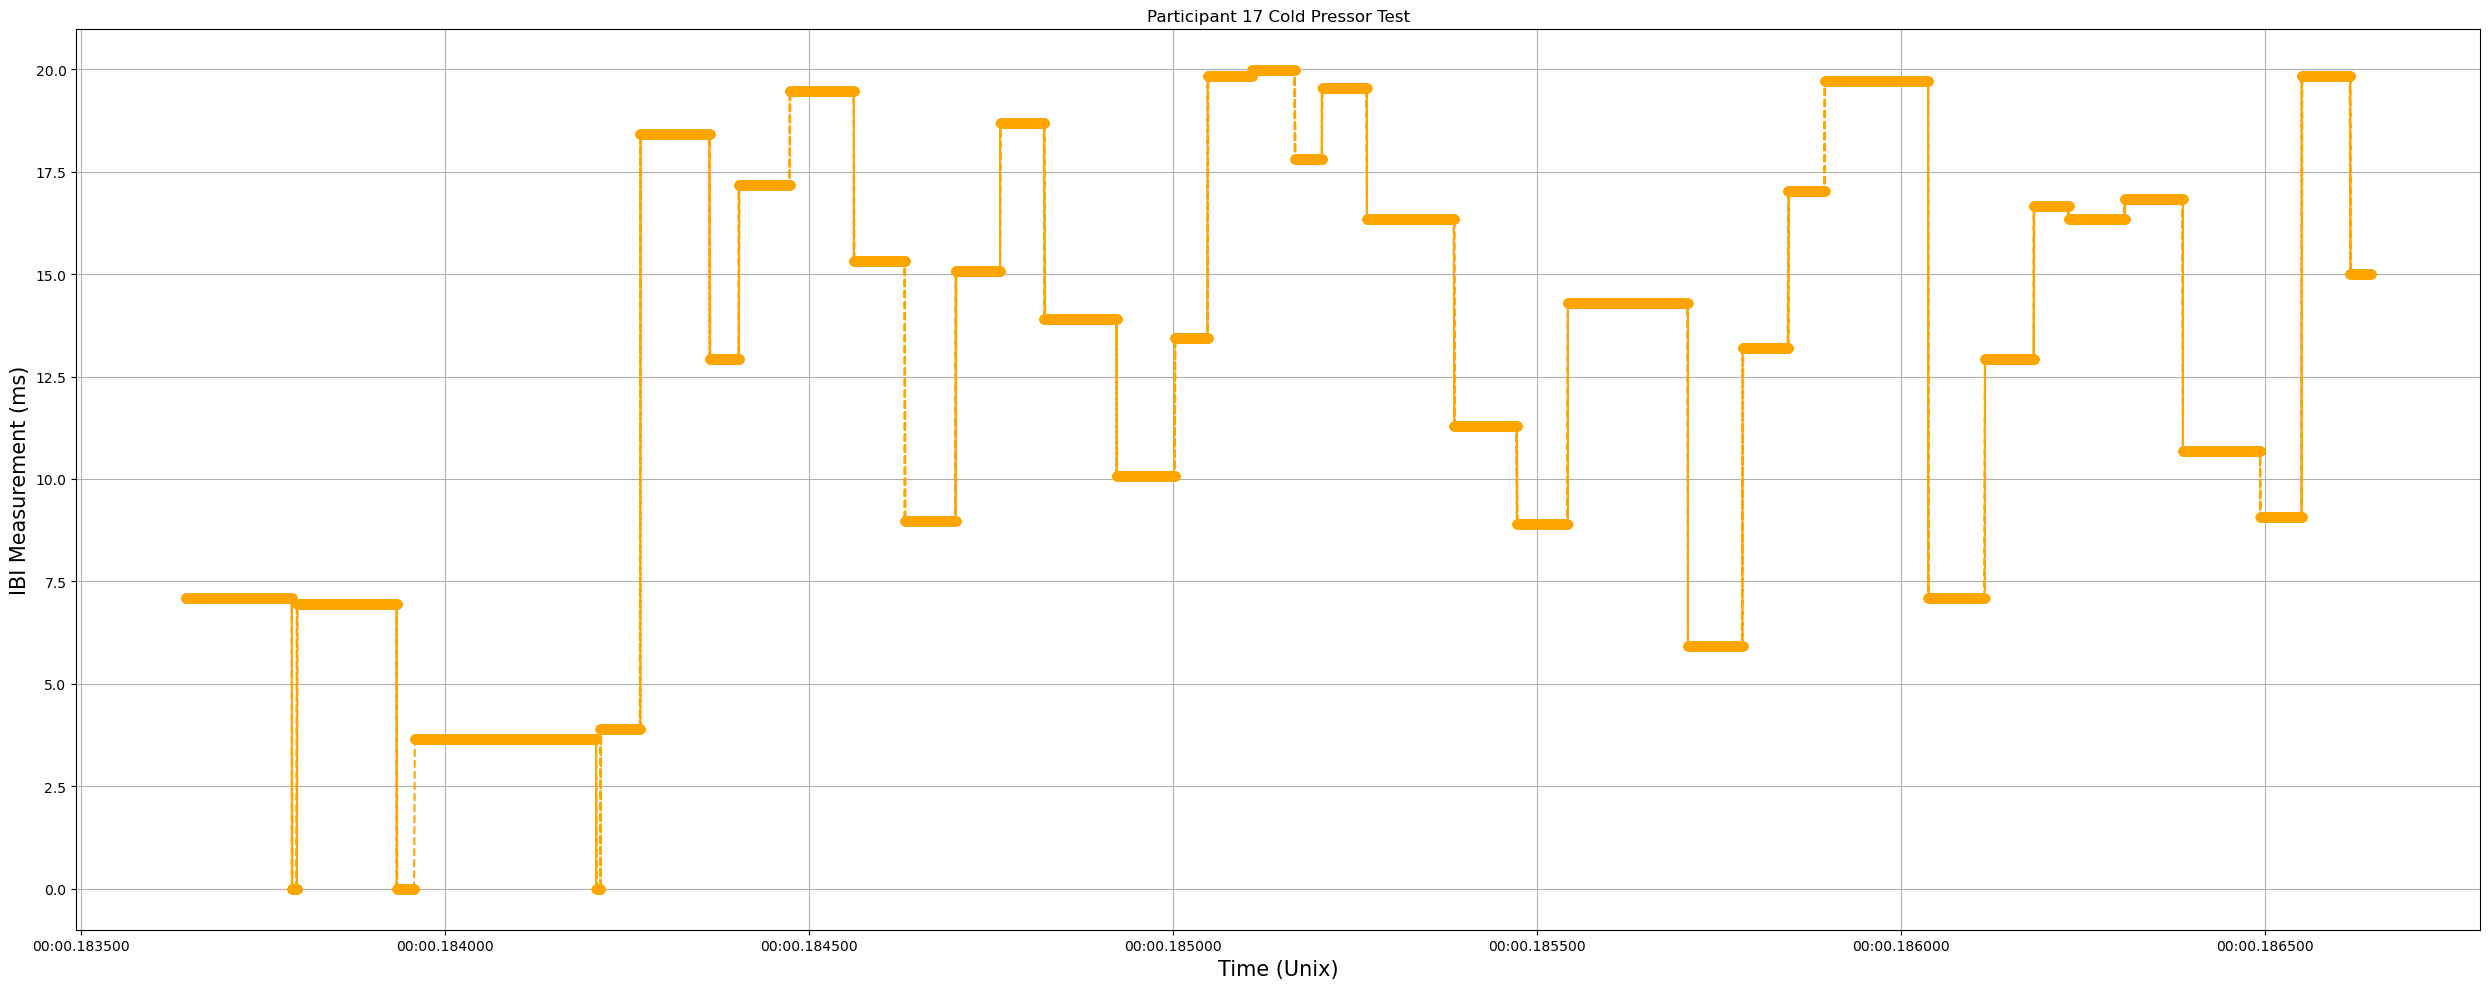

<Figure size 2500x1000 with 0 Axes>

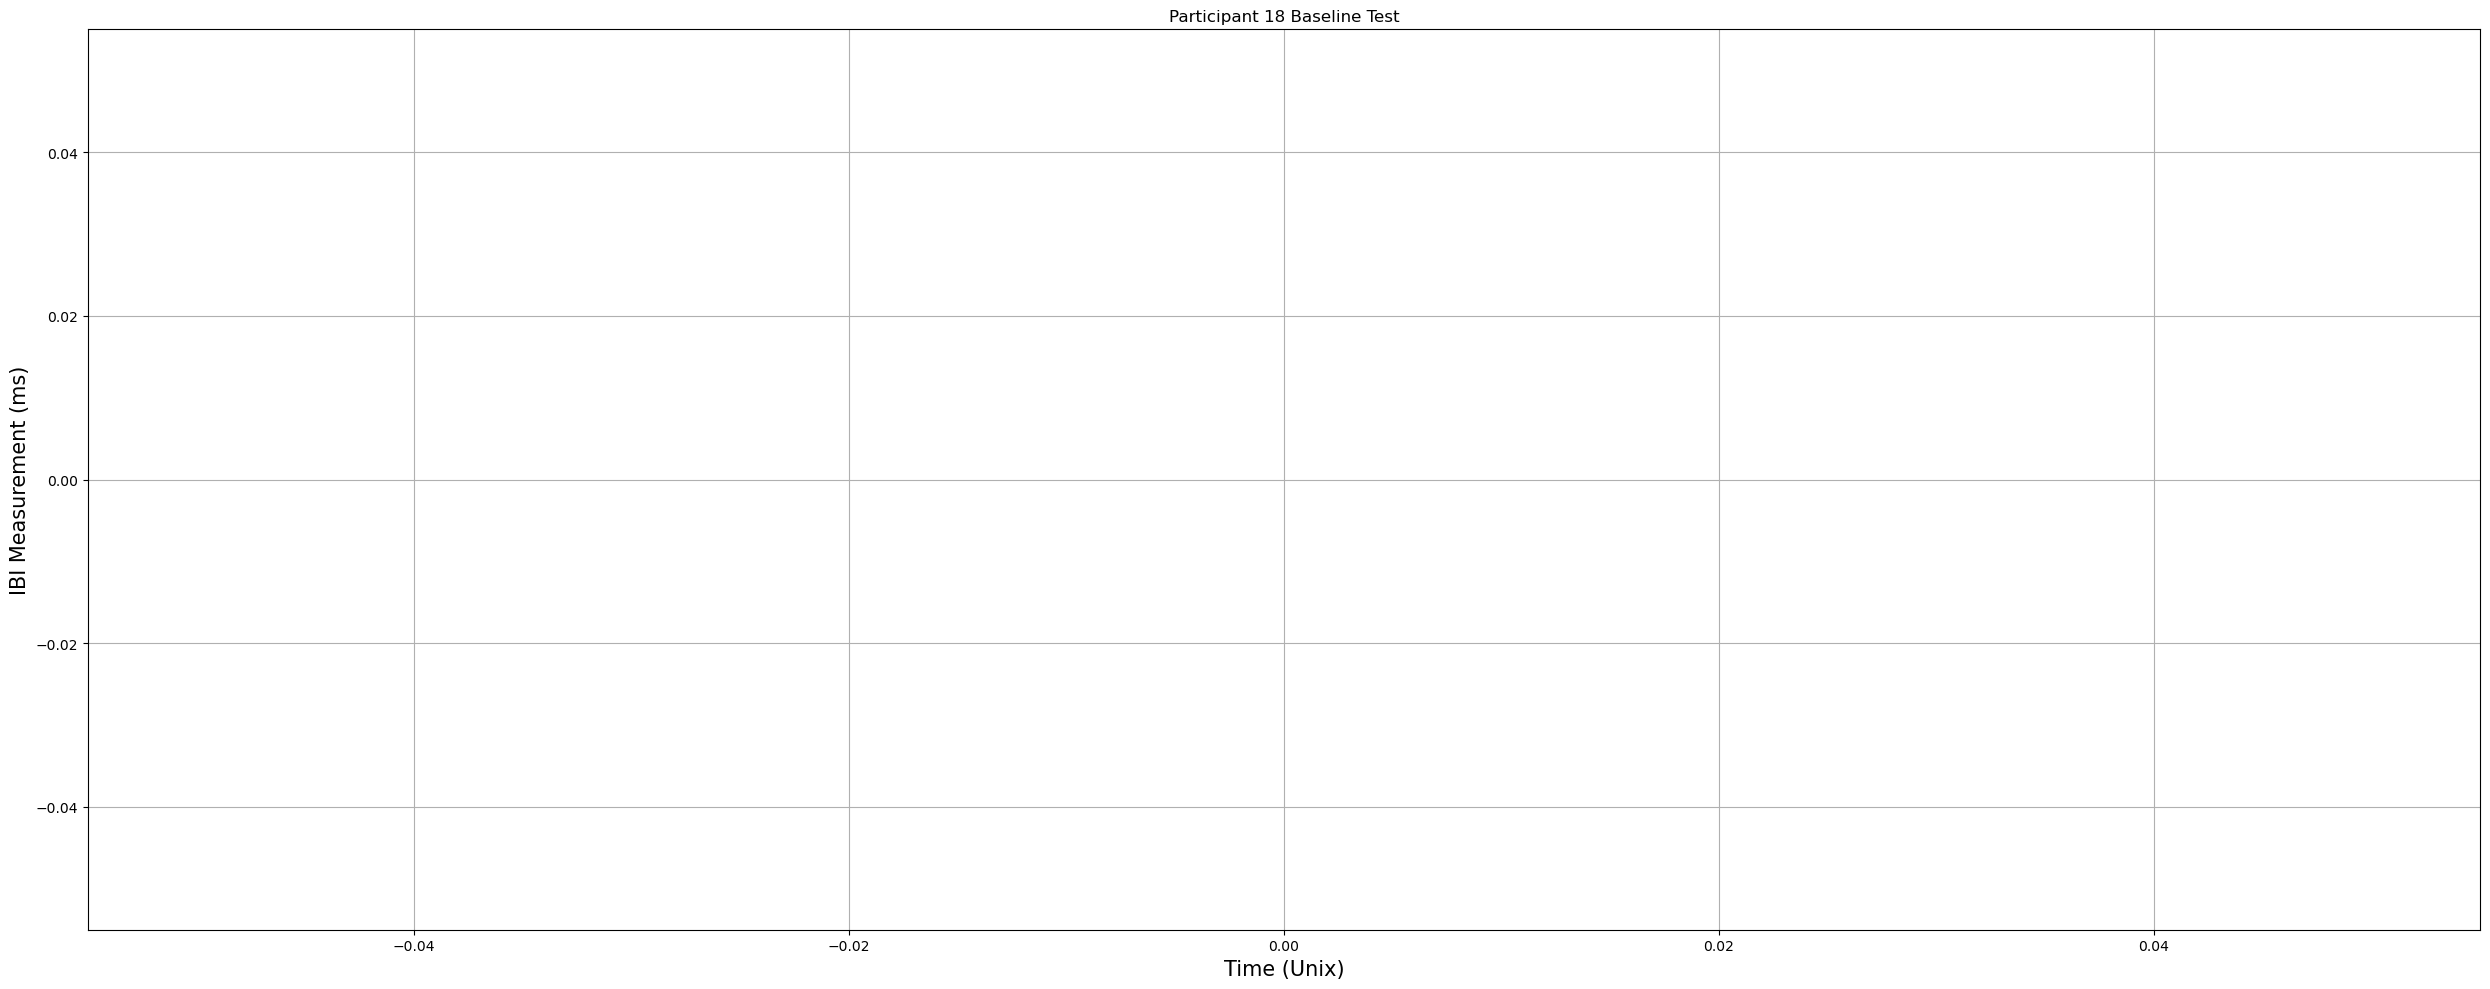

<Figure size 2500x1000 with 0 Axes>

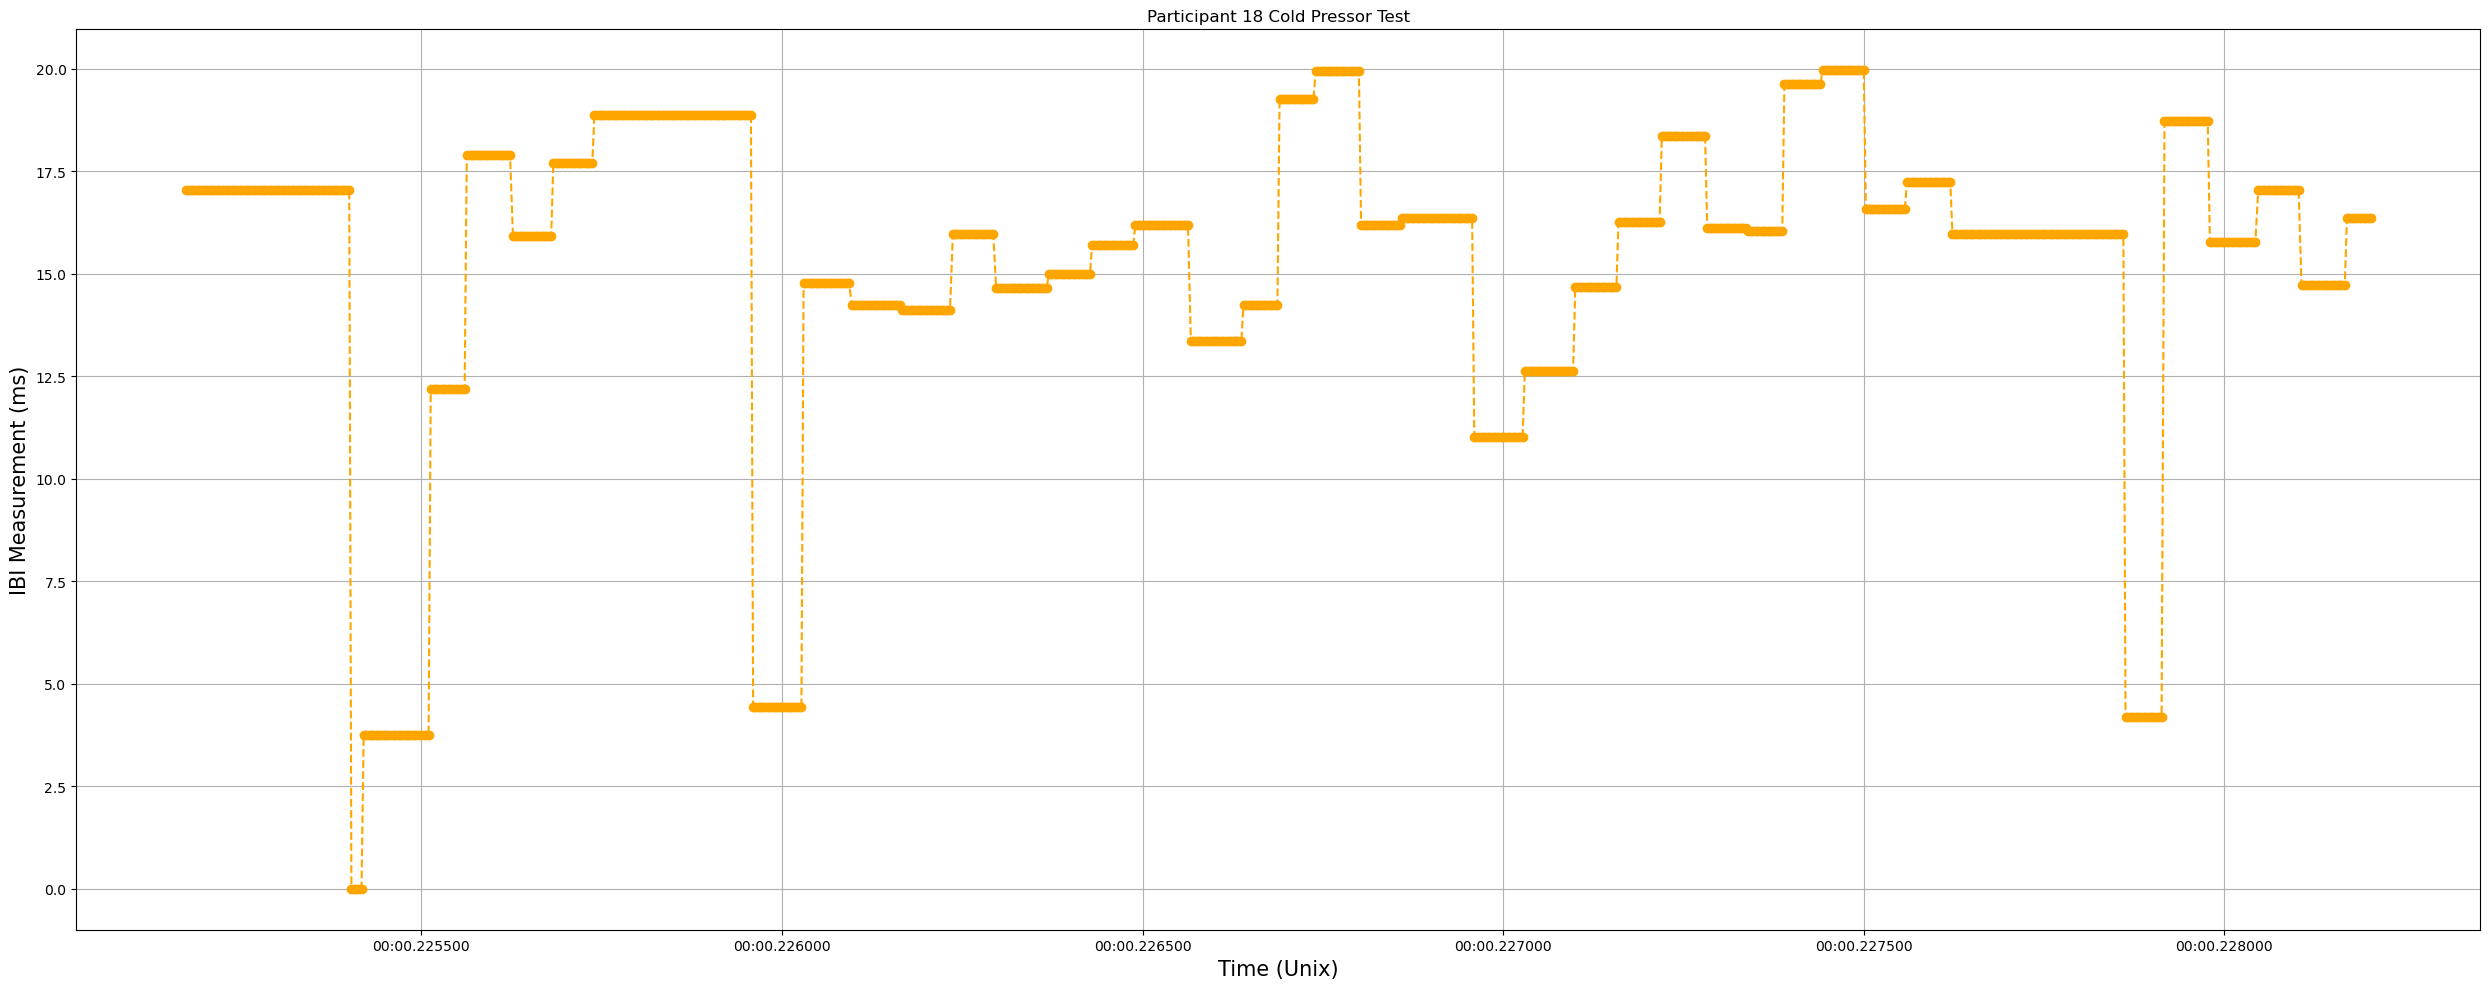

<Figure size 2500x1000 with 0 Axes>

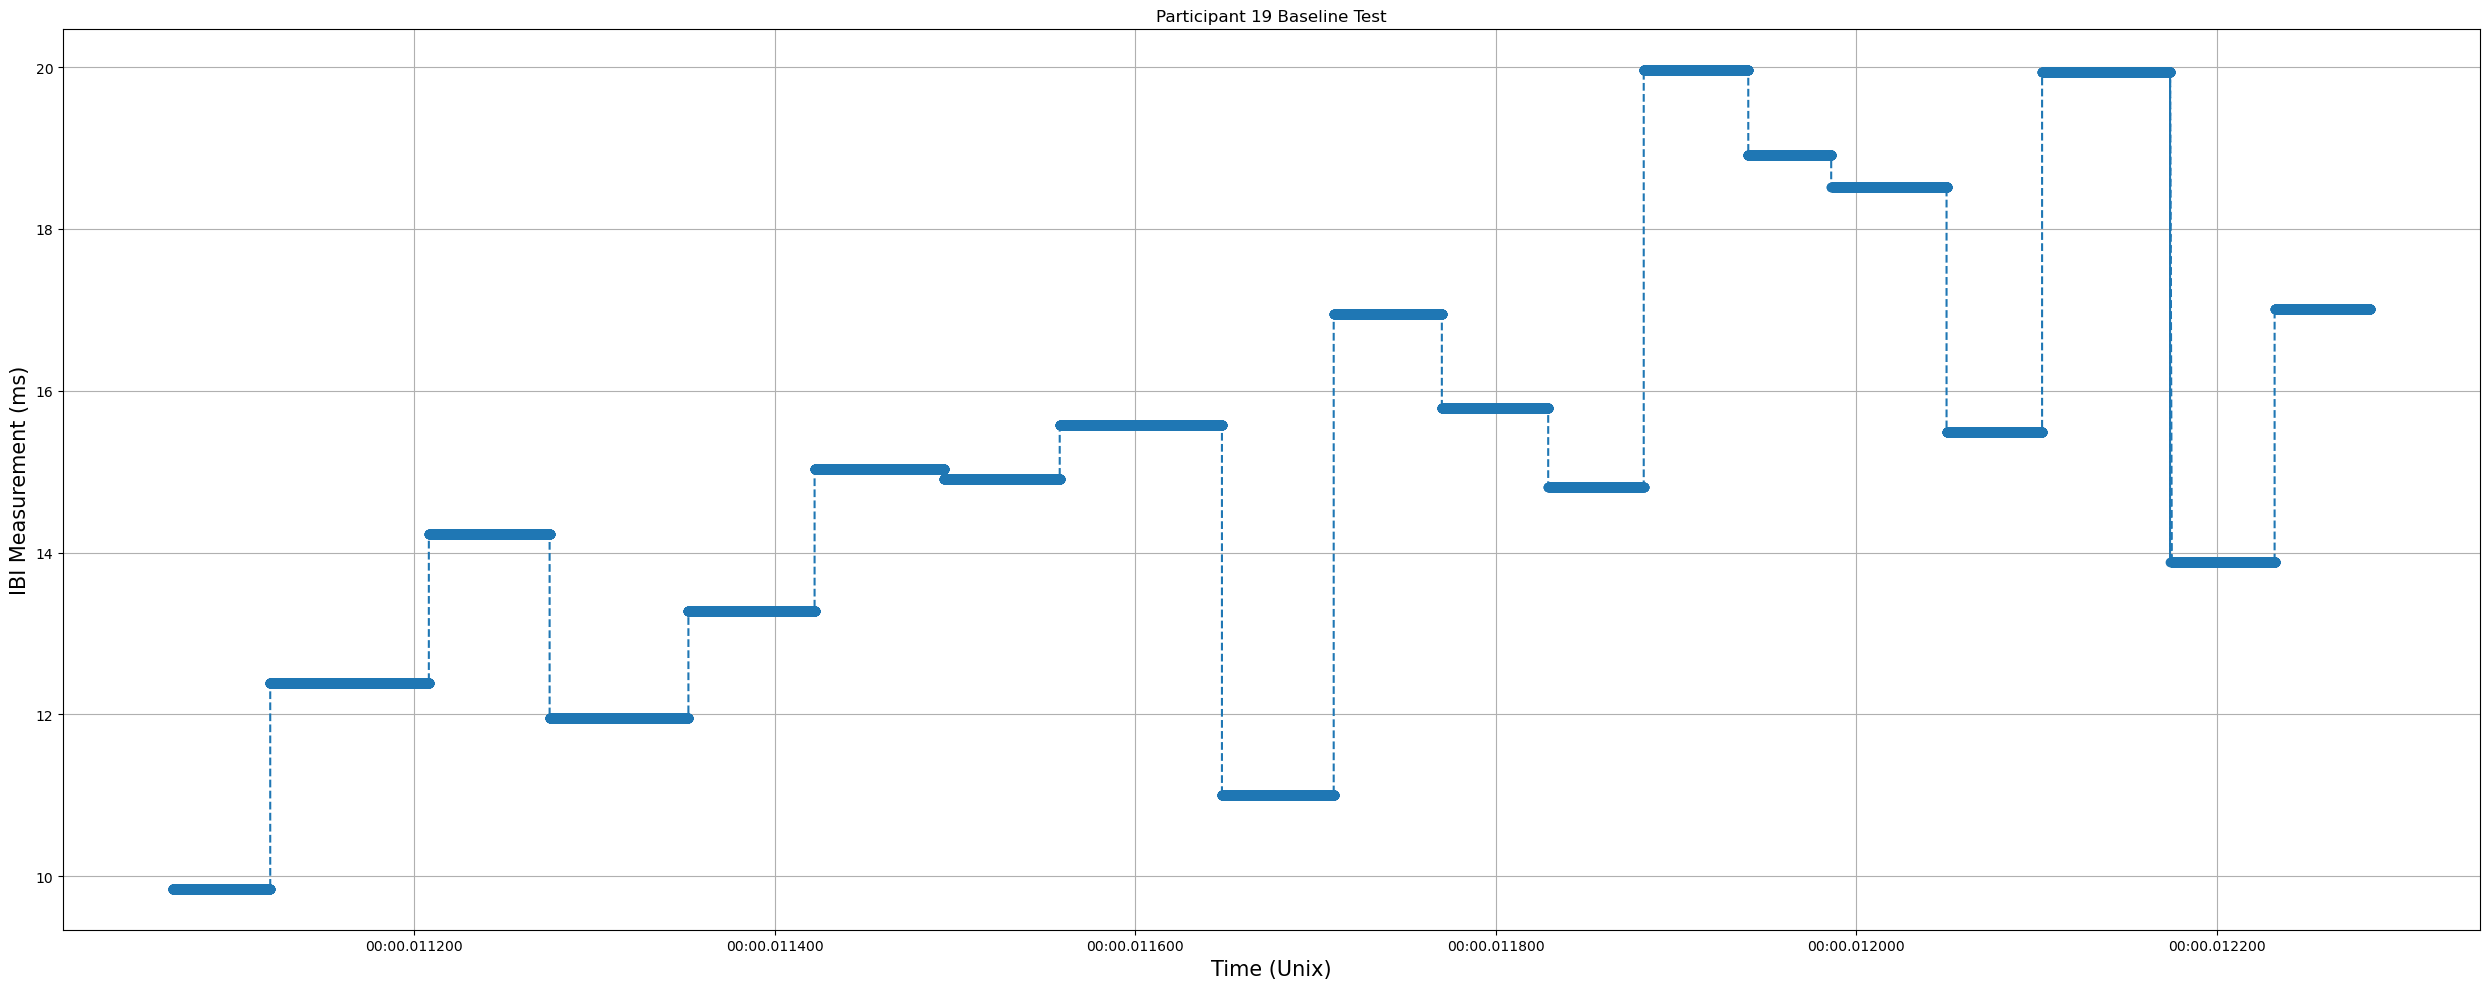

<Figure size 2500x1000 with 0 Axes>

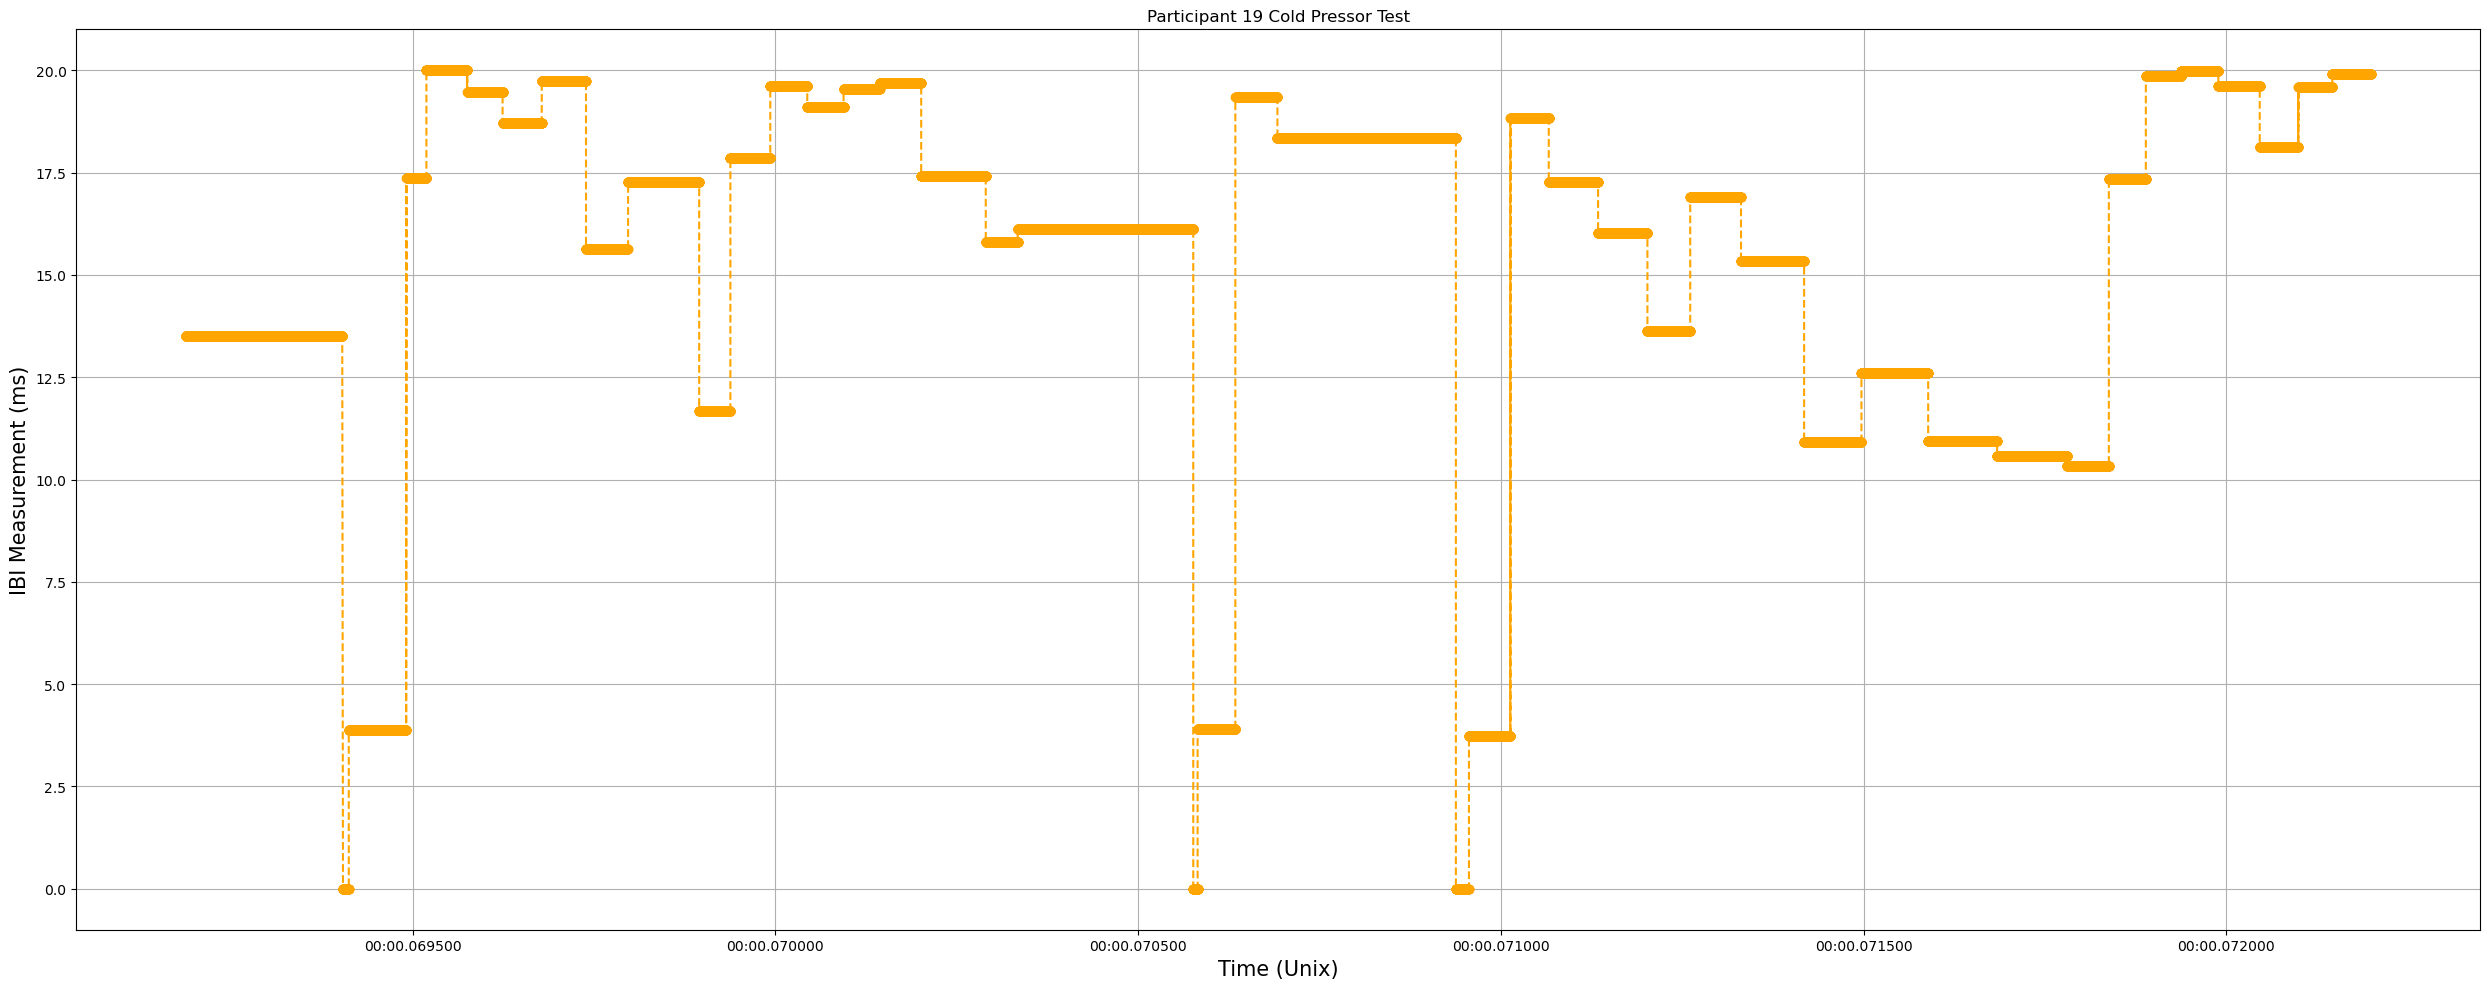

<Figure size 2500x1000 with 0 Axes>

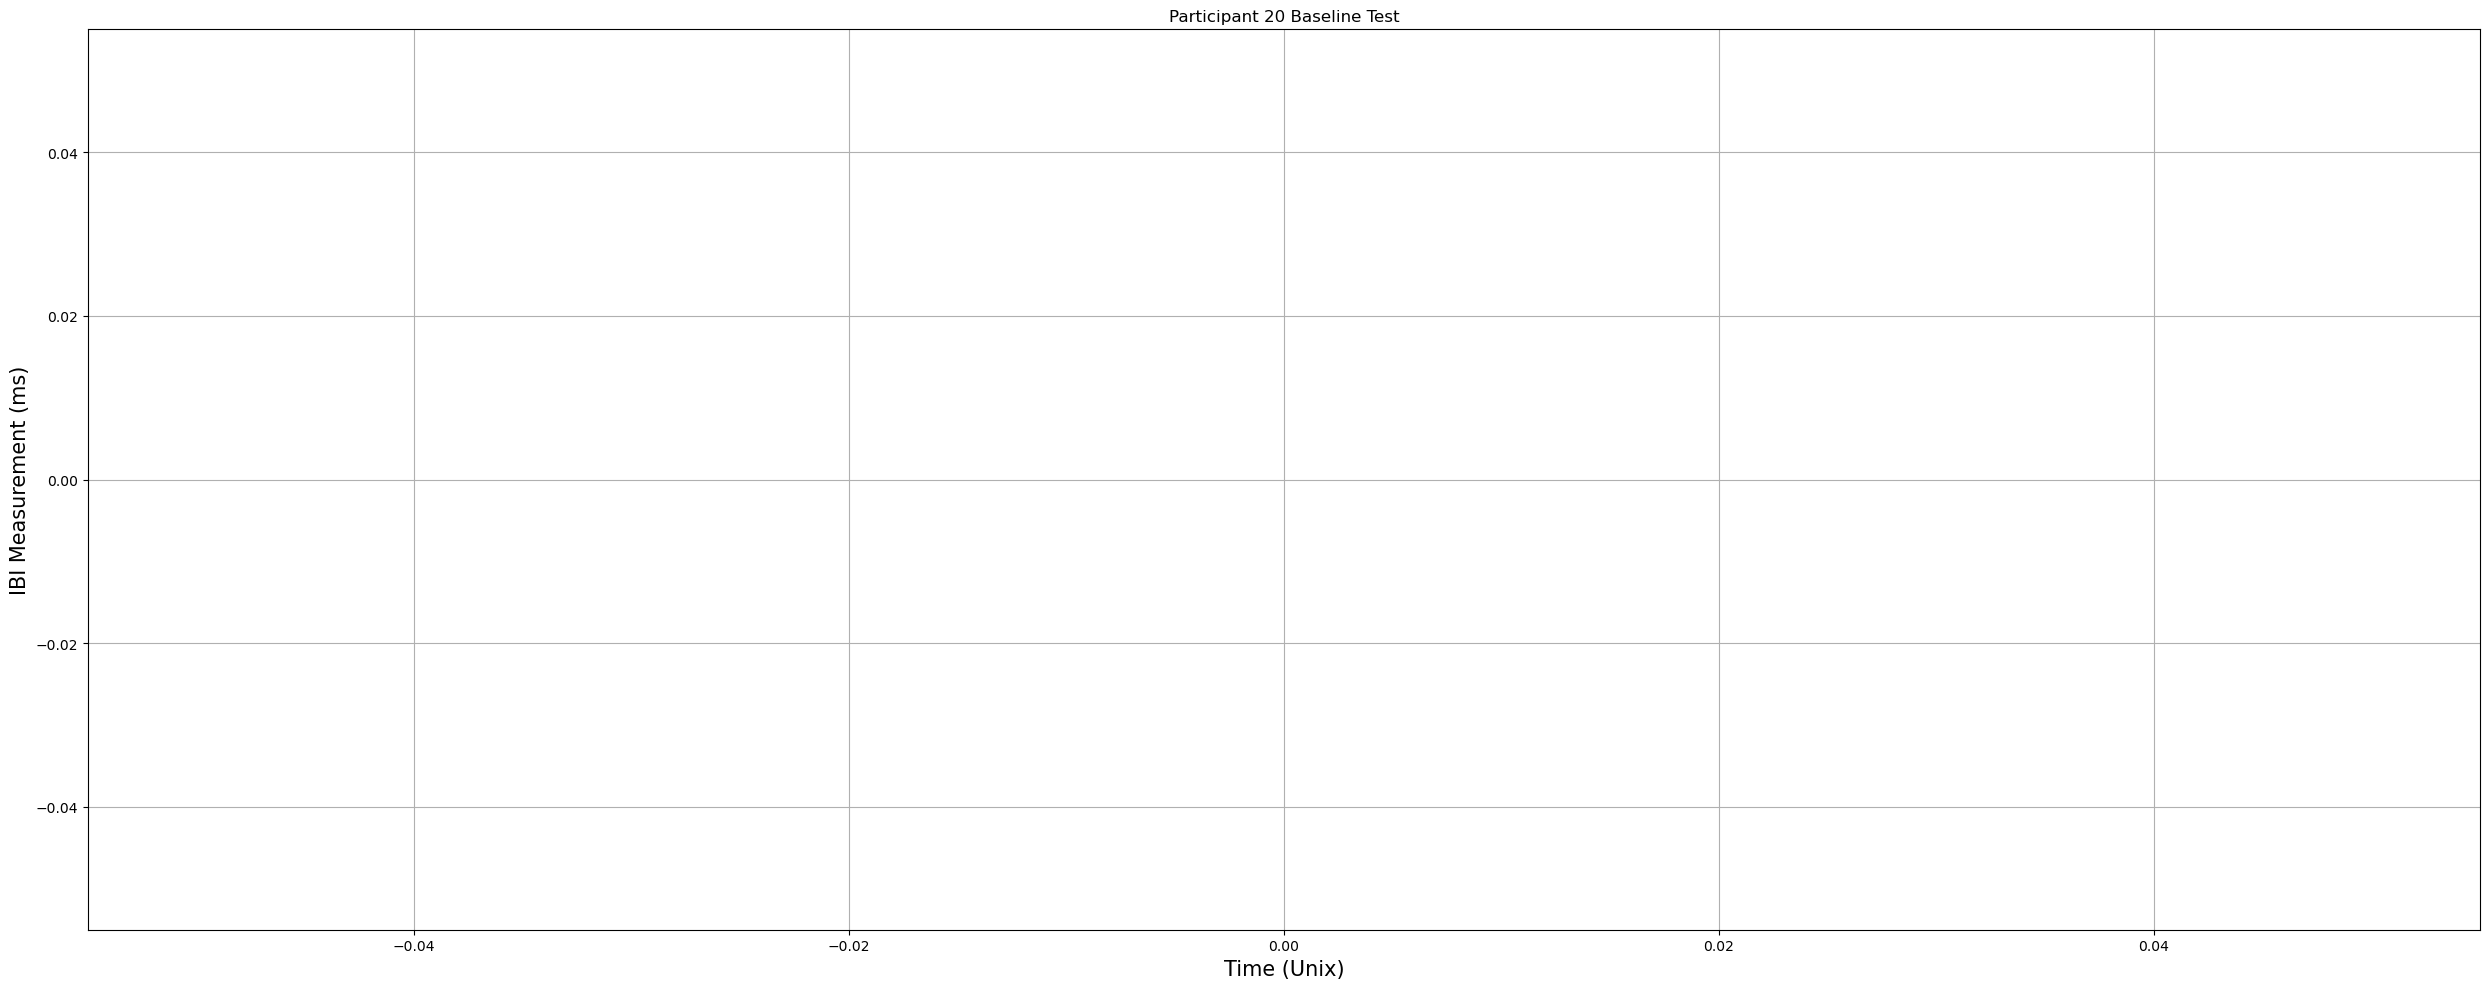

<Figure size 2500x1000 with 0 Axes>

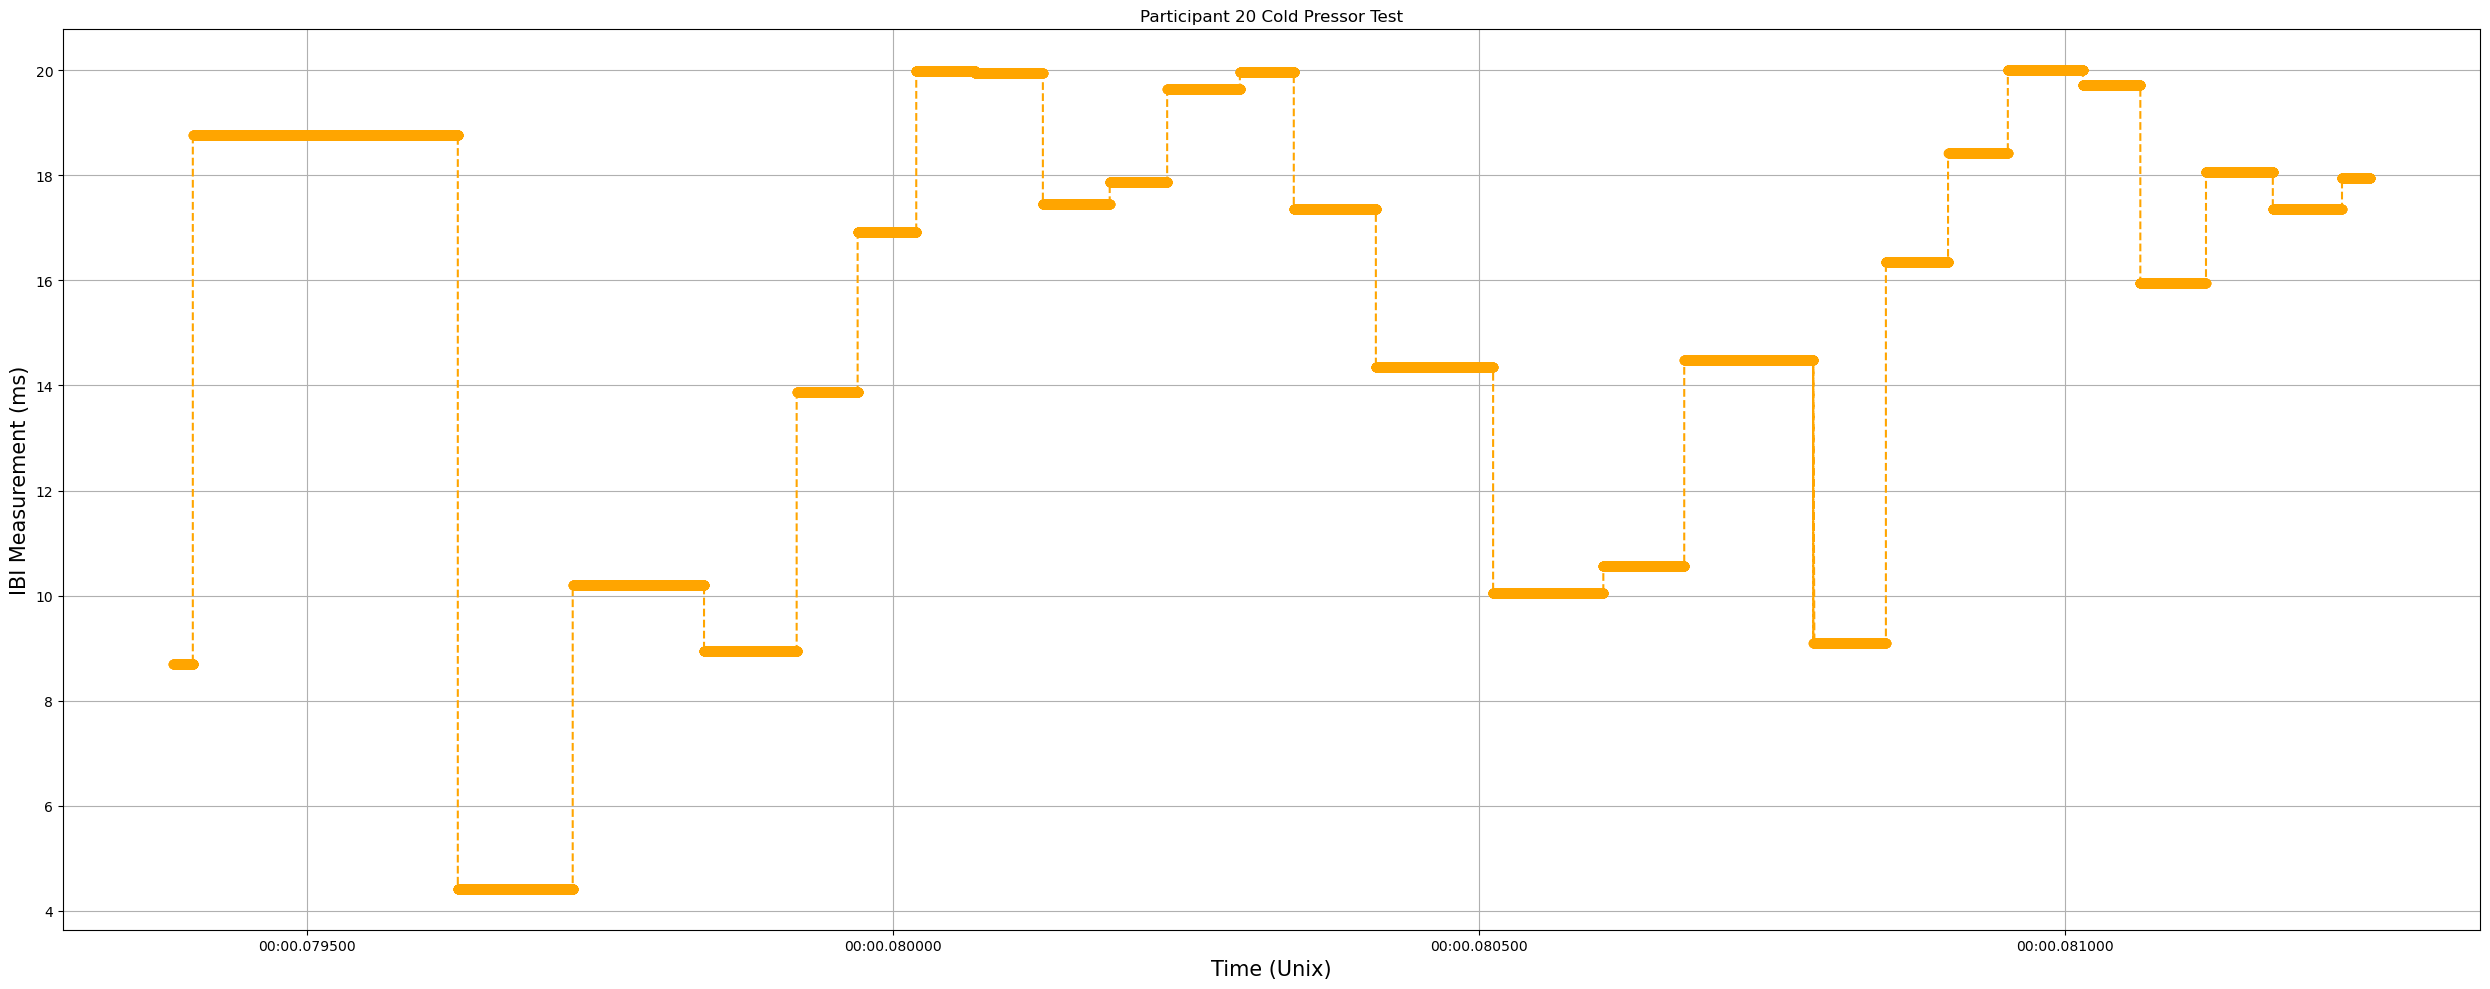

<Figure size 2500x1000 with 0 Axes>

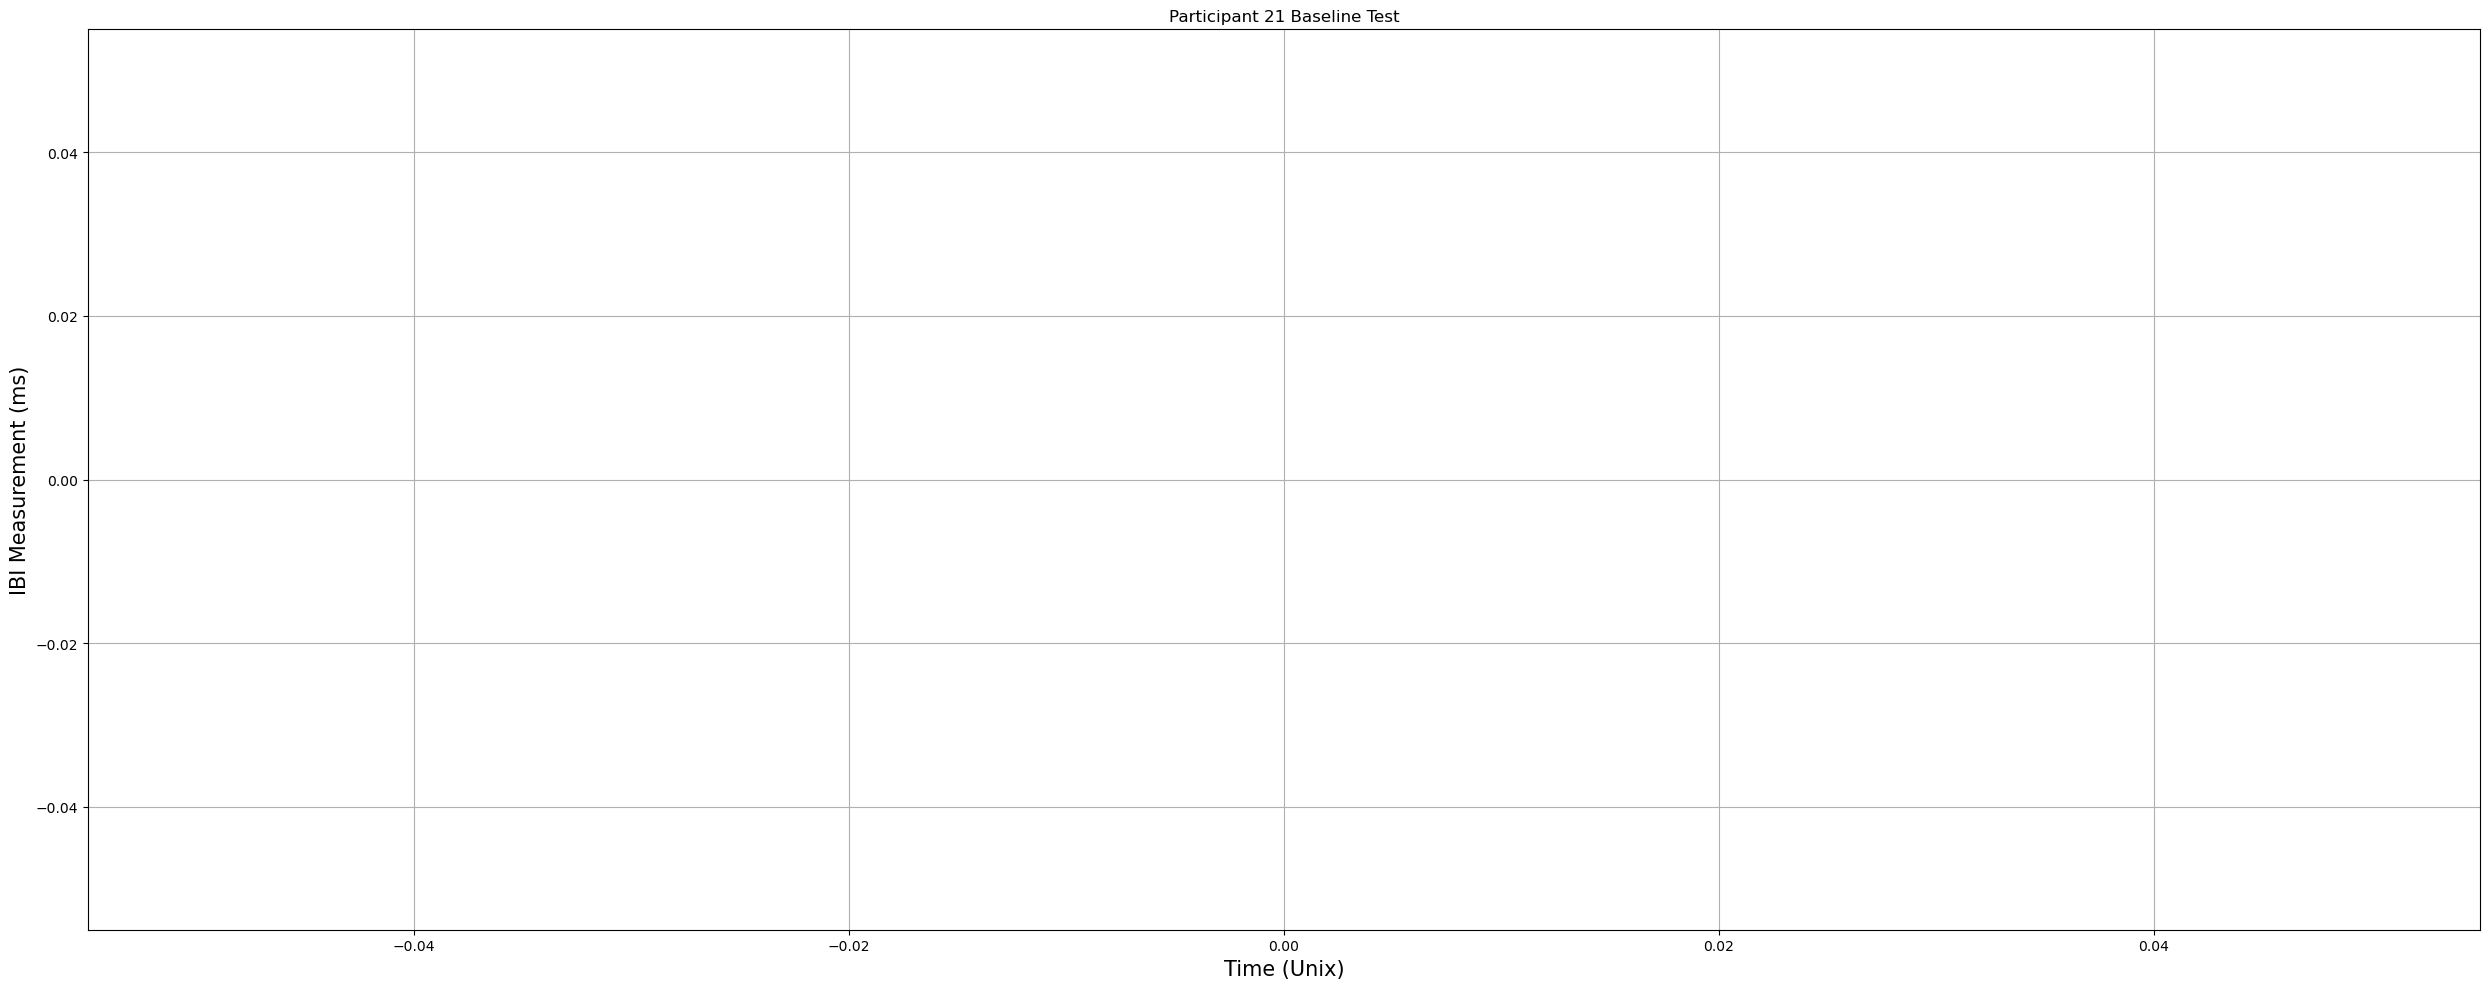

<Figure size 2500x1000 with 0 Axes>

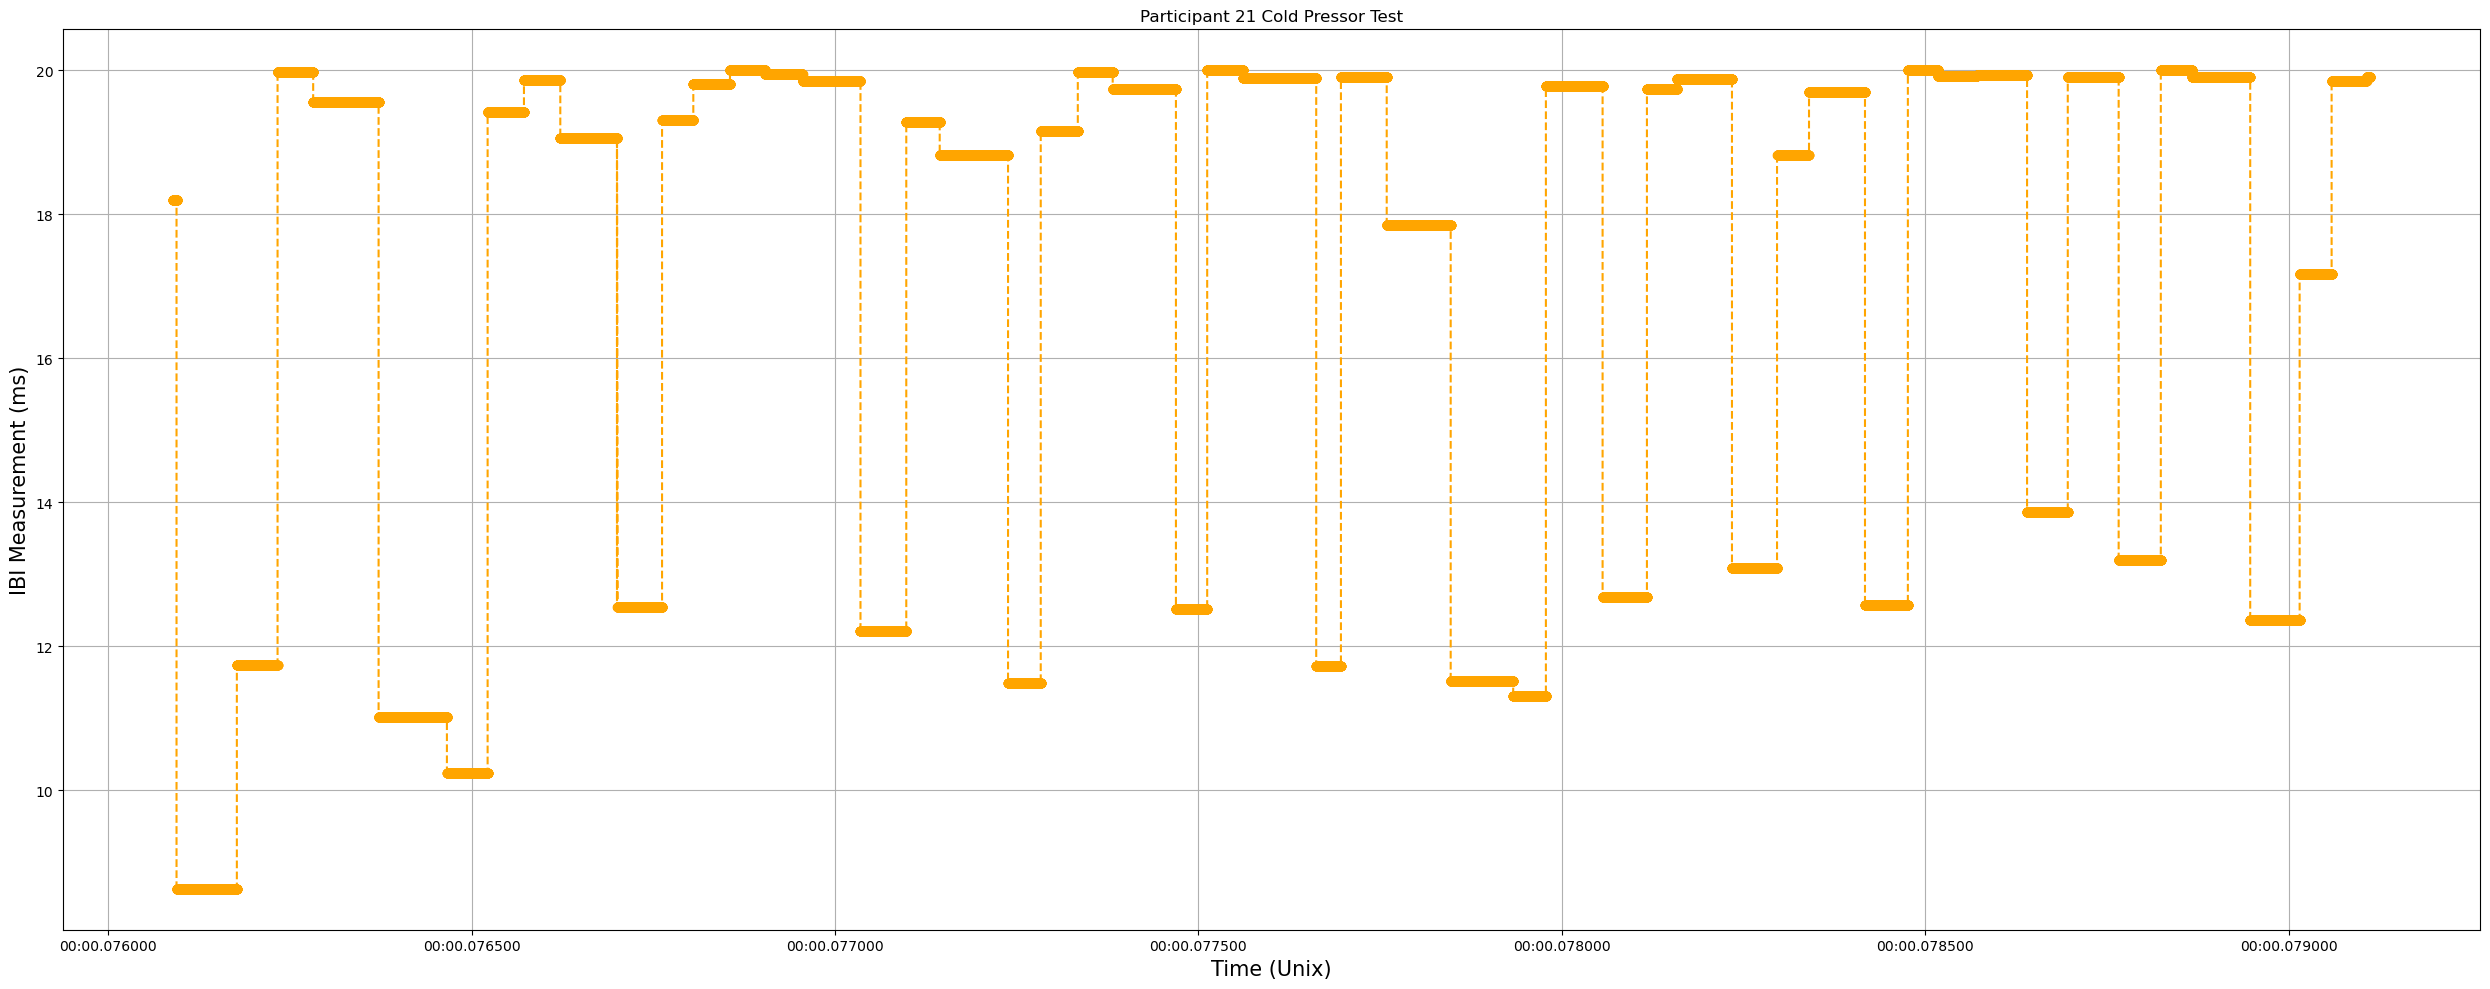

<Figure size 2500x1000 with 0 Axes>

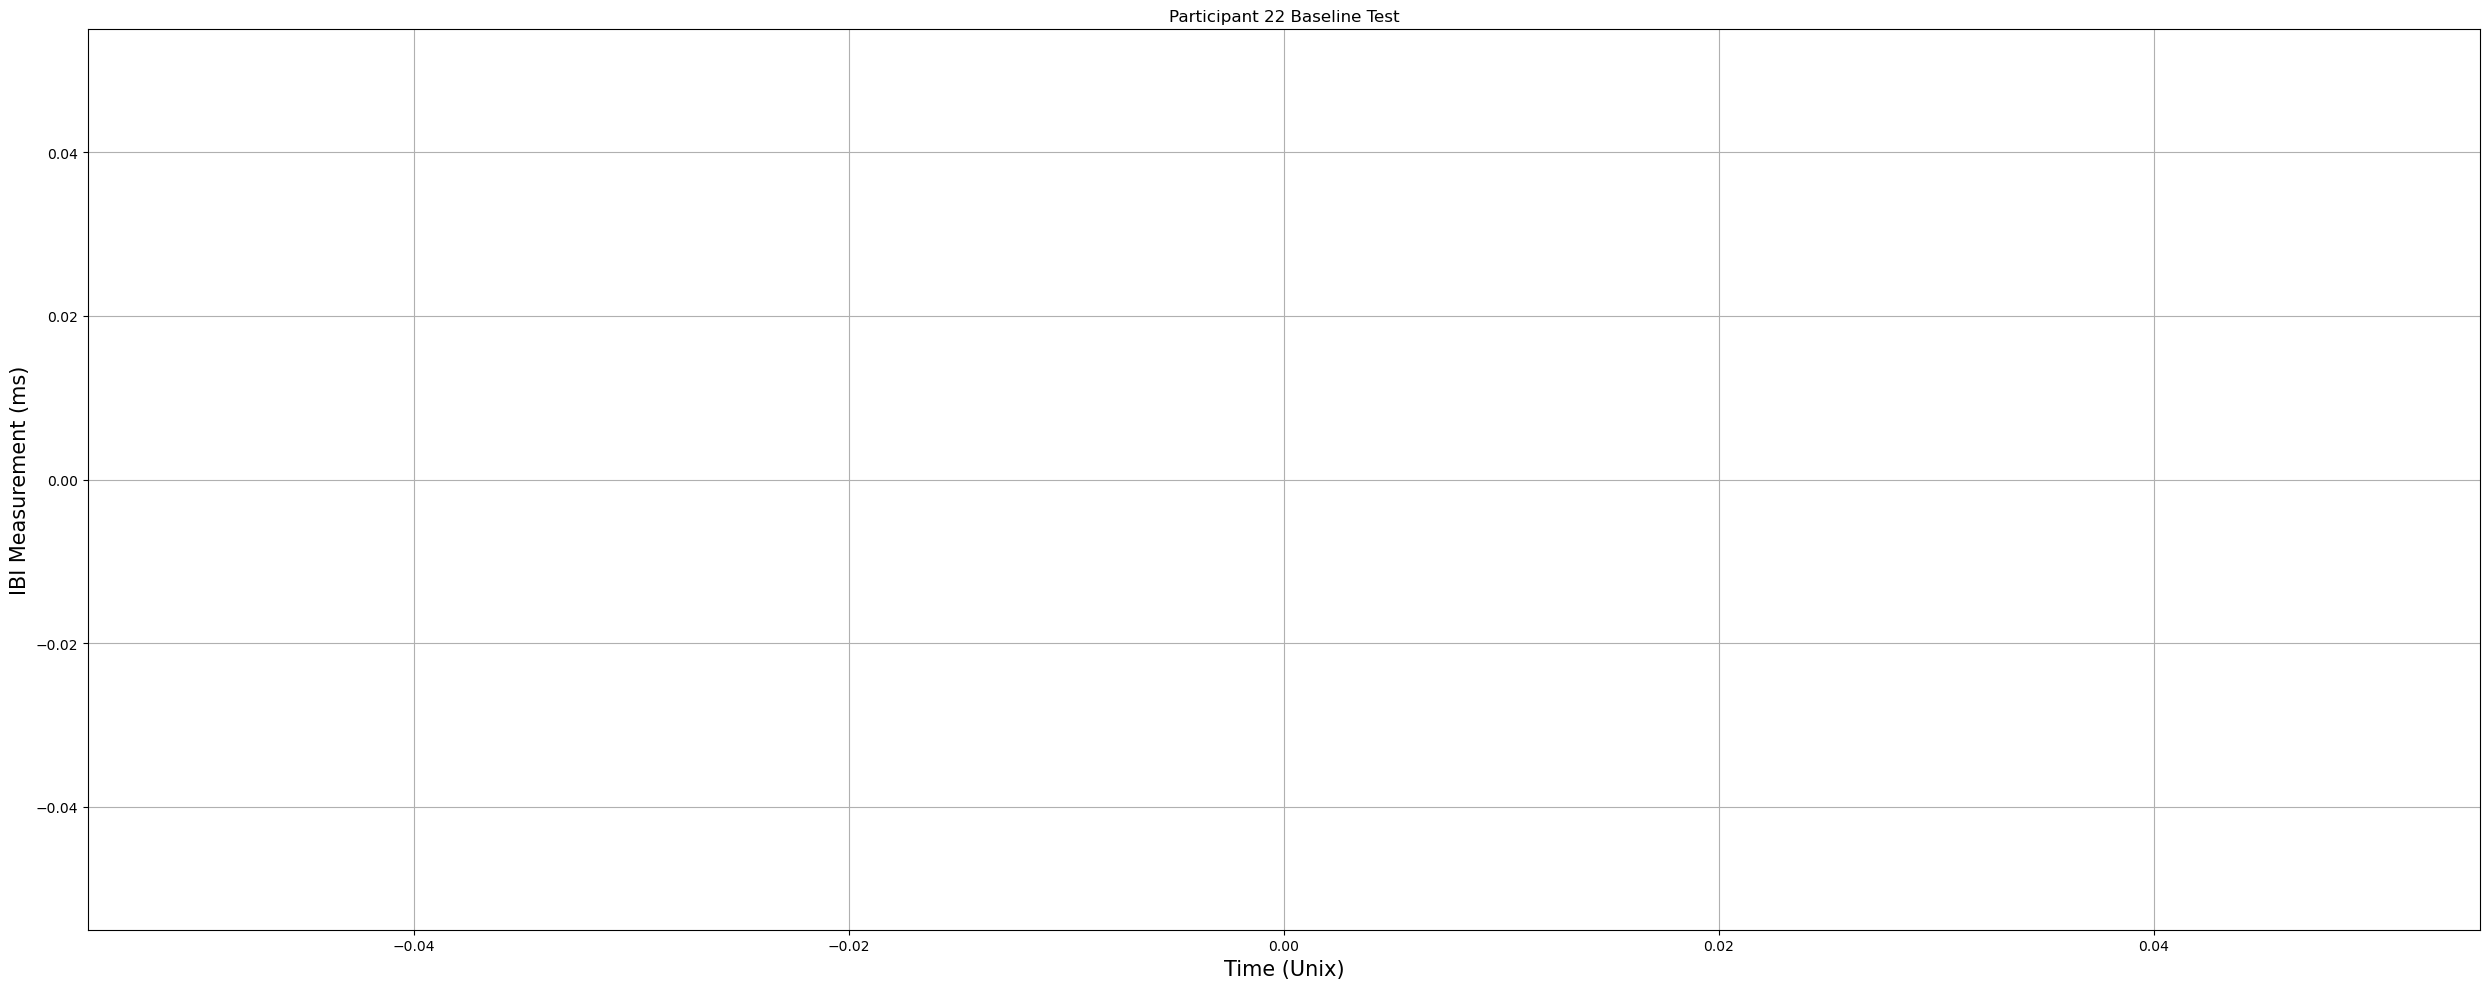

<Figure size 2500x1000 with 0 Axes>

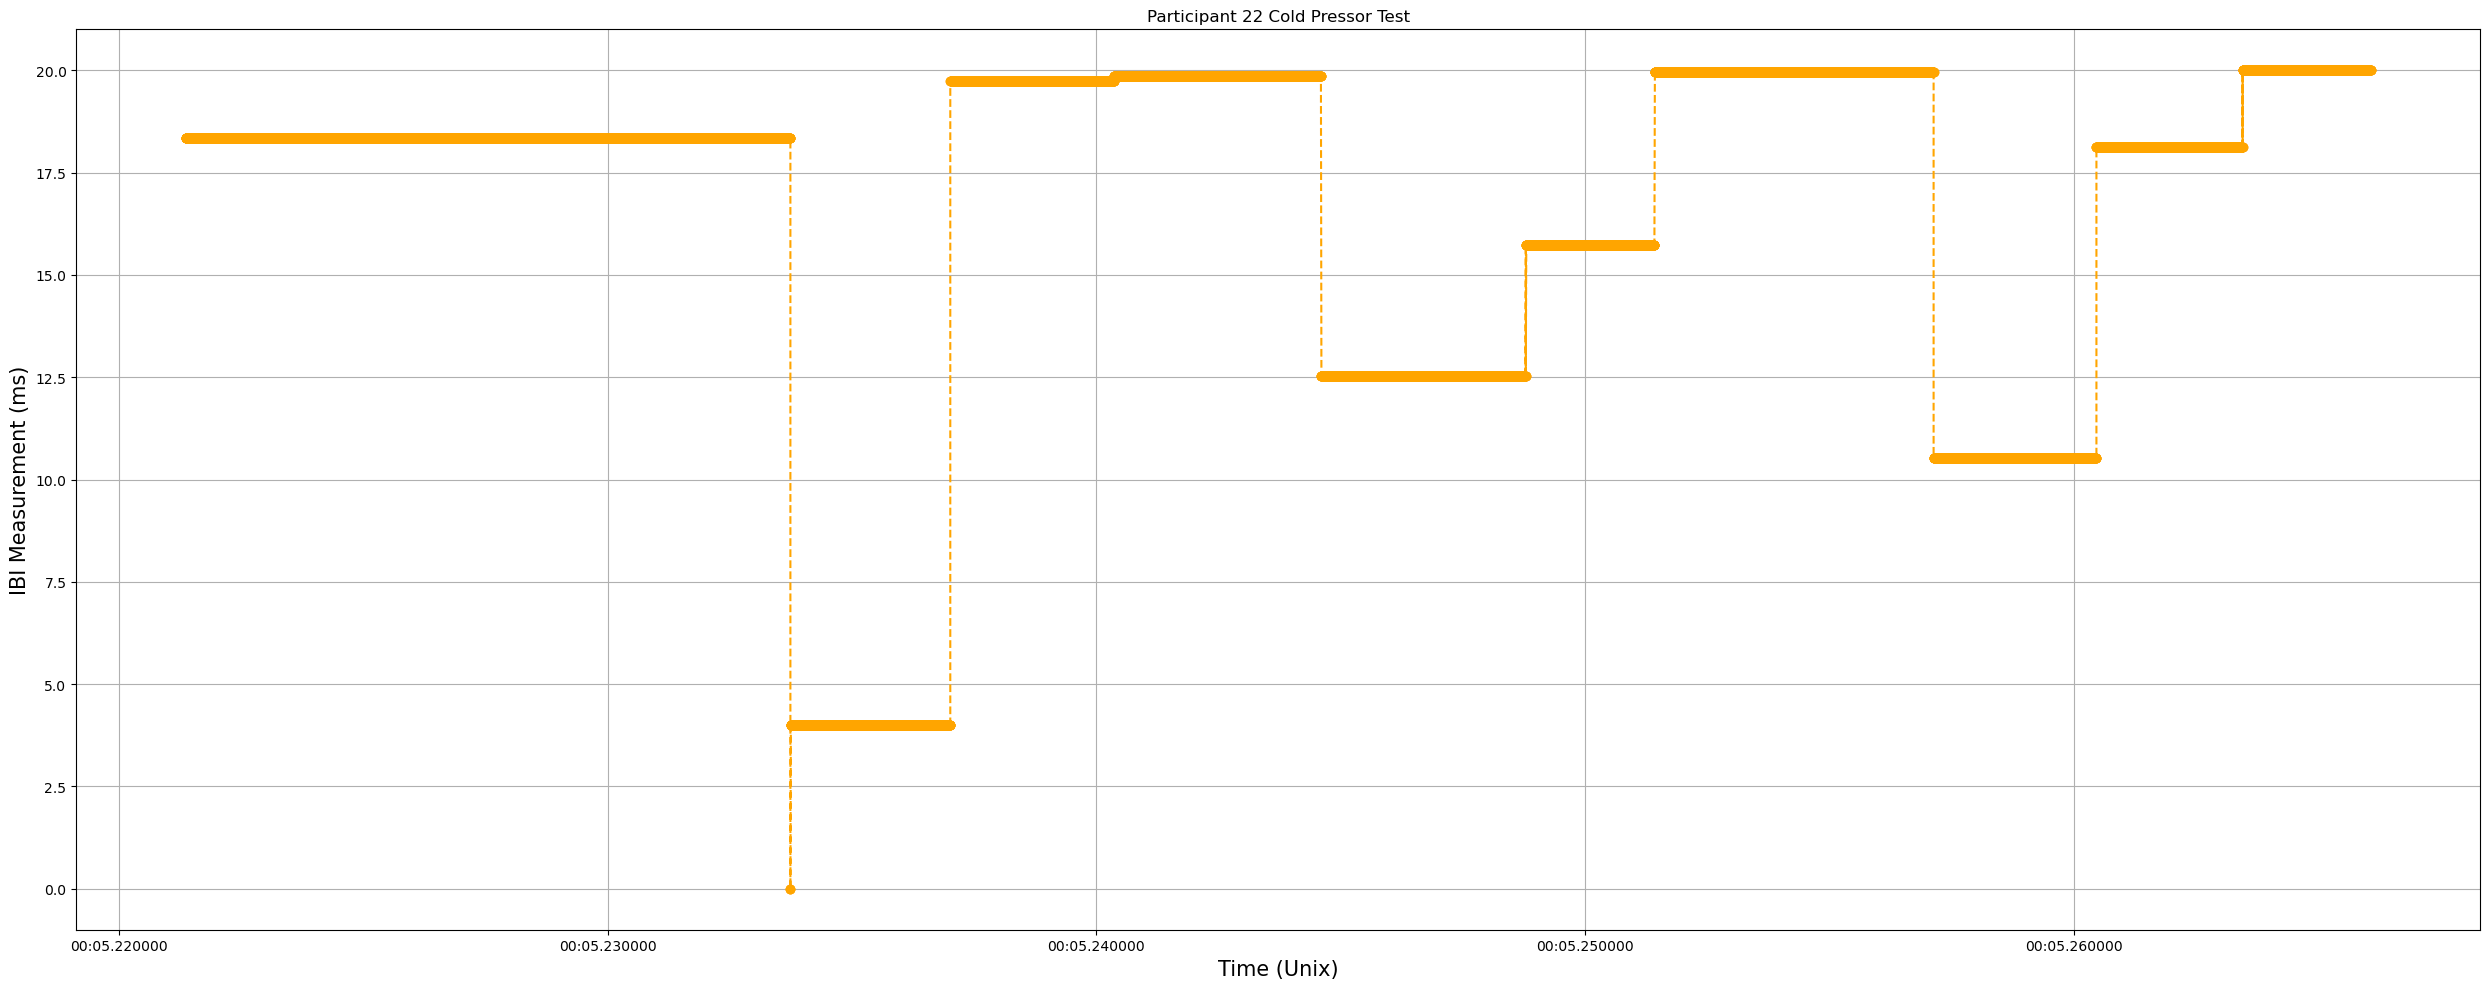

<Figure size 2500x1000 with 0 Axes>

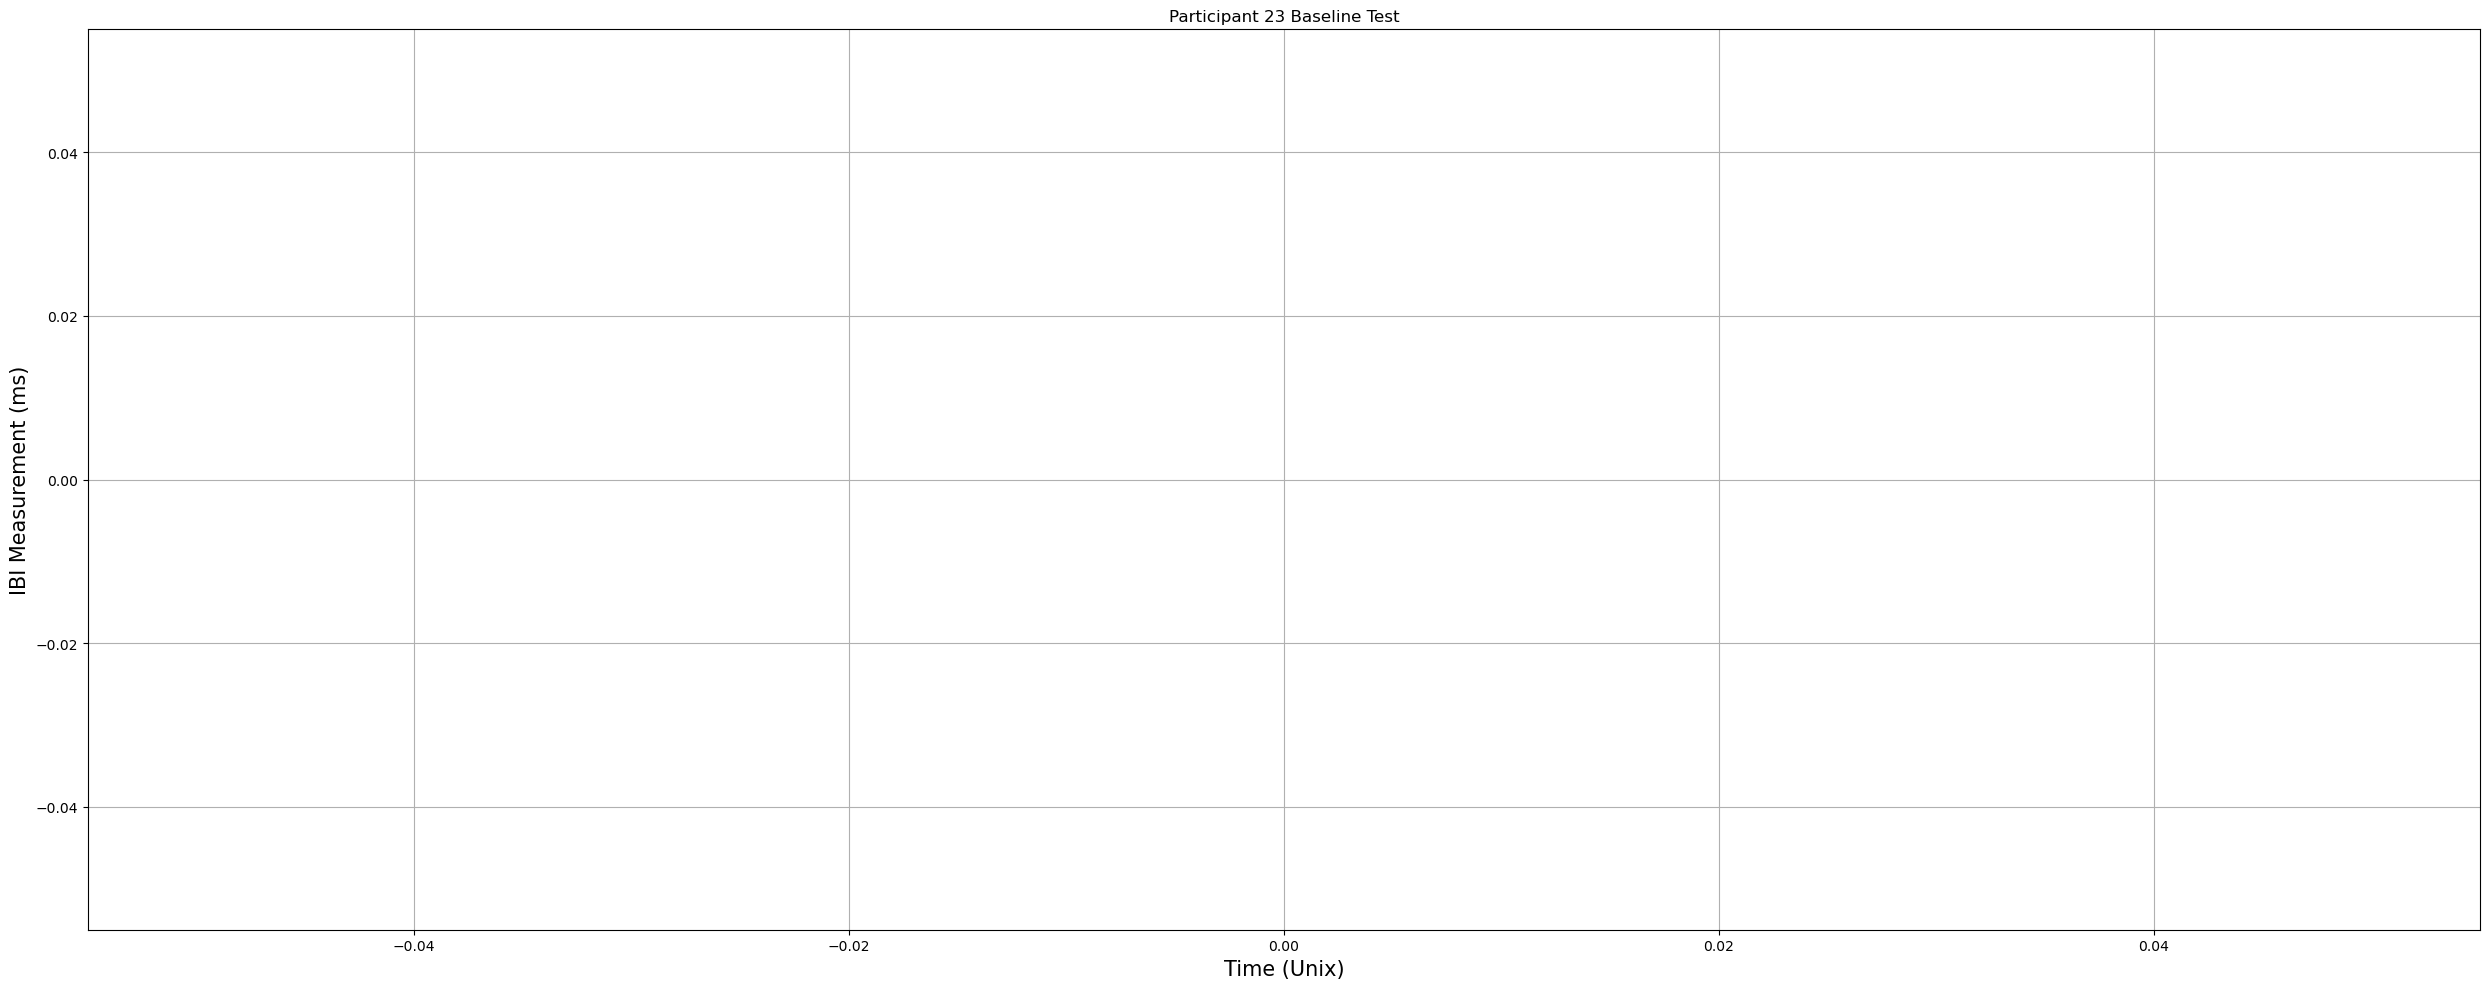

<Figure size 2500x1000 with 0 Axes>

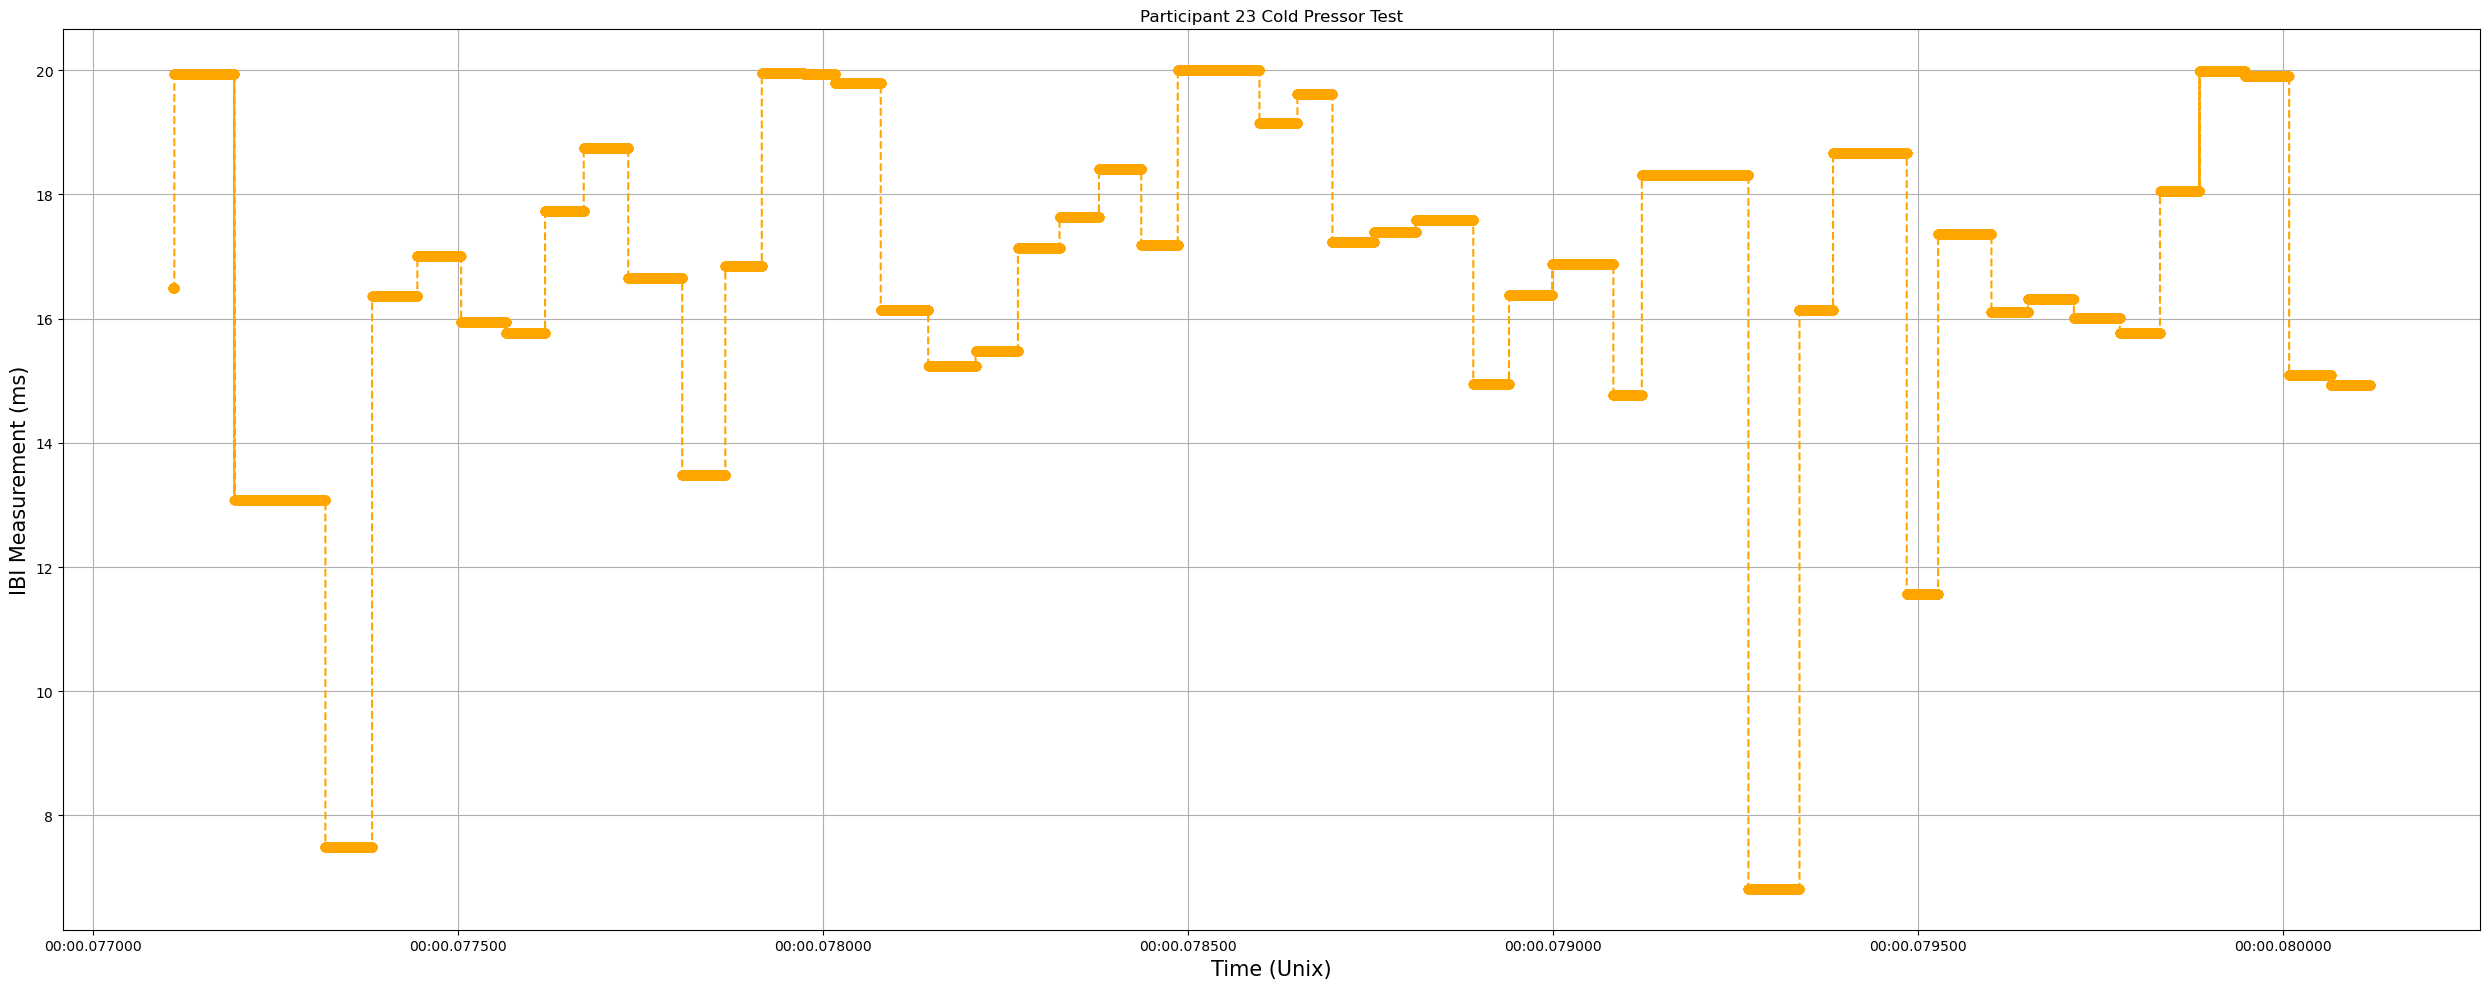

<Figure size 2500x1000 with 0 Axes>

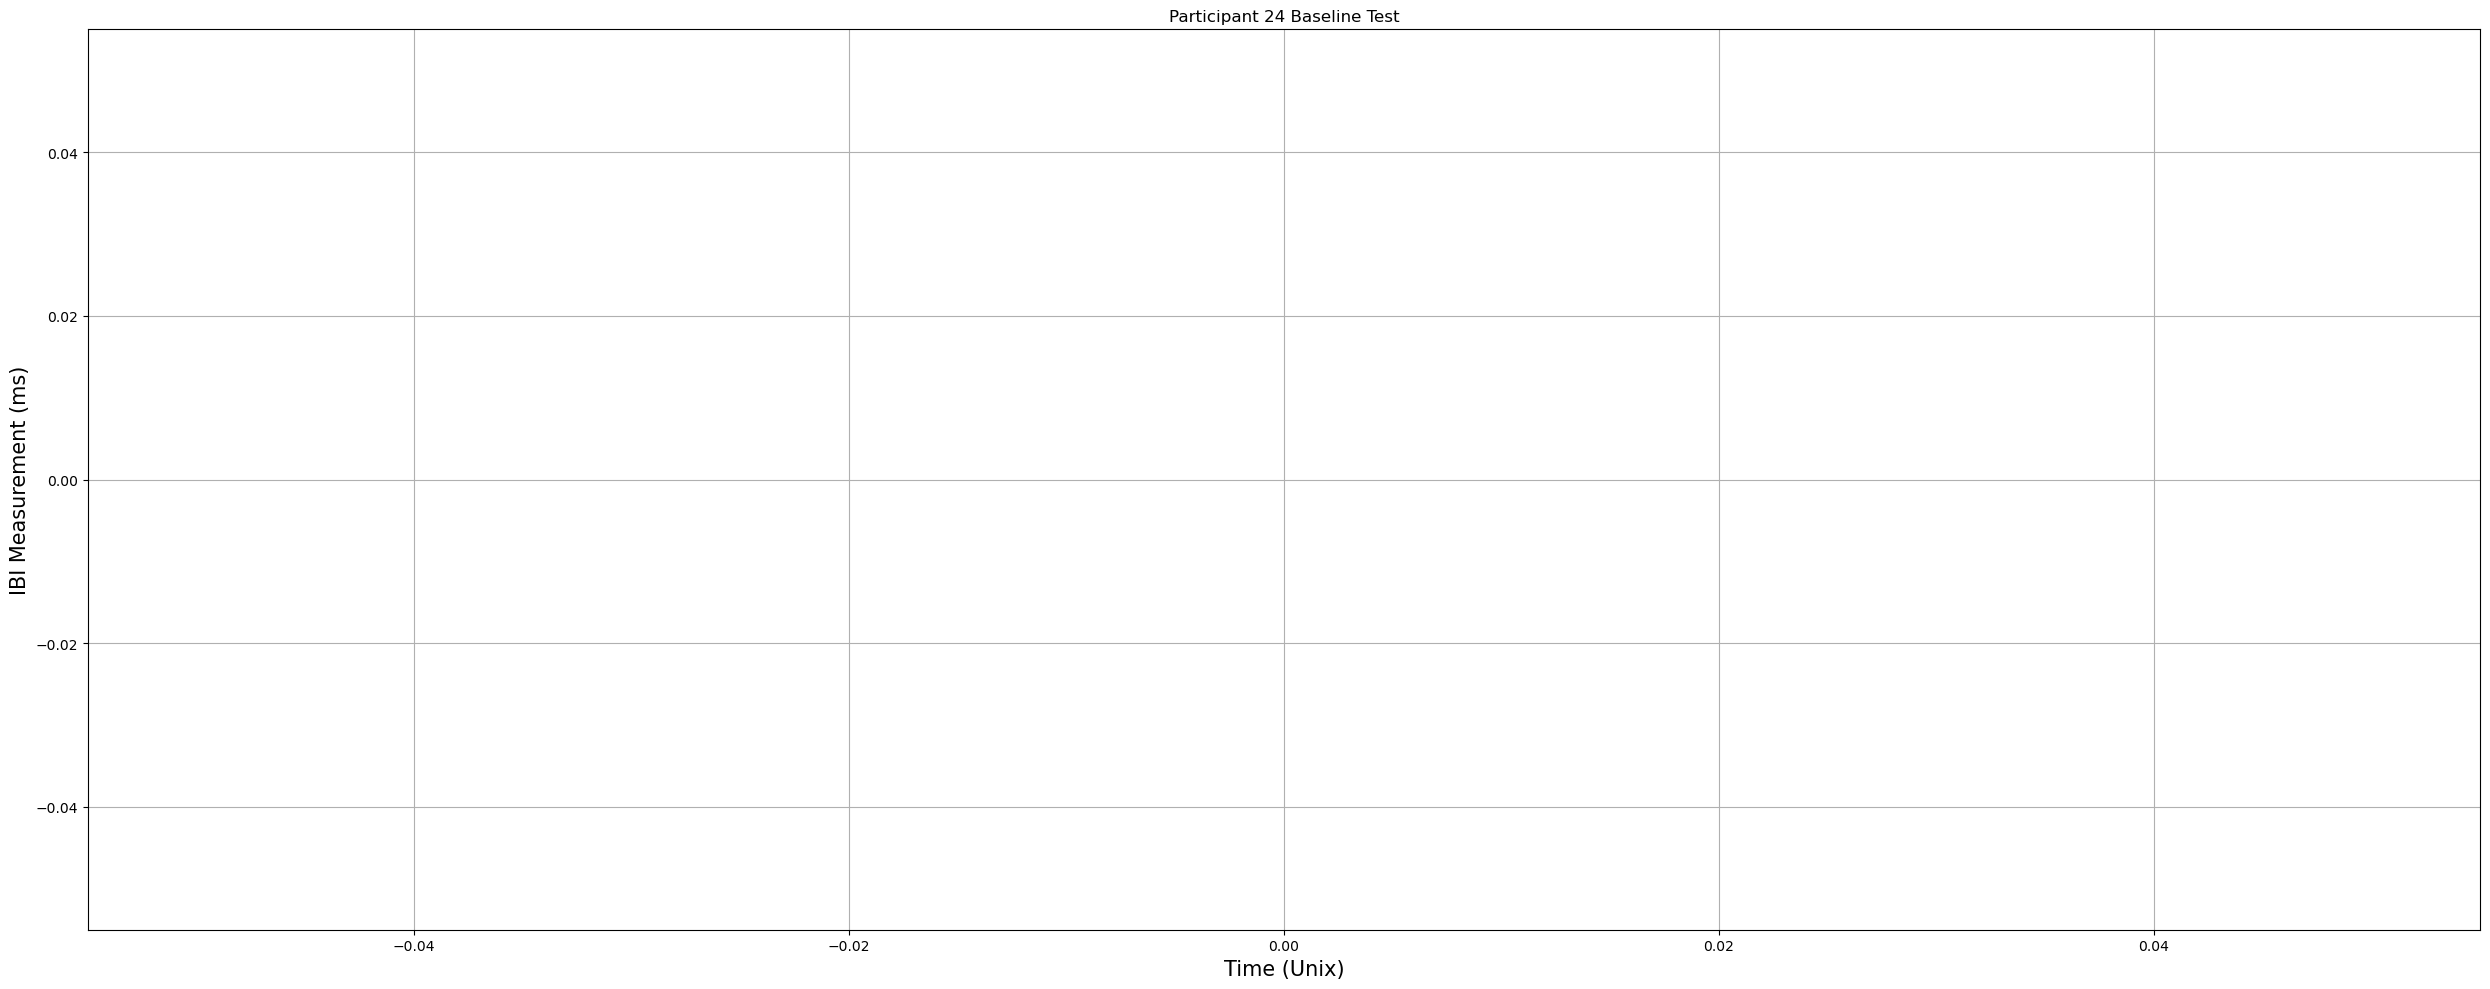

<Figure size 2500x1000 with 0 Axes>

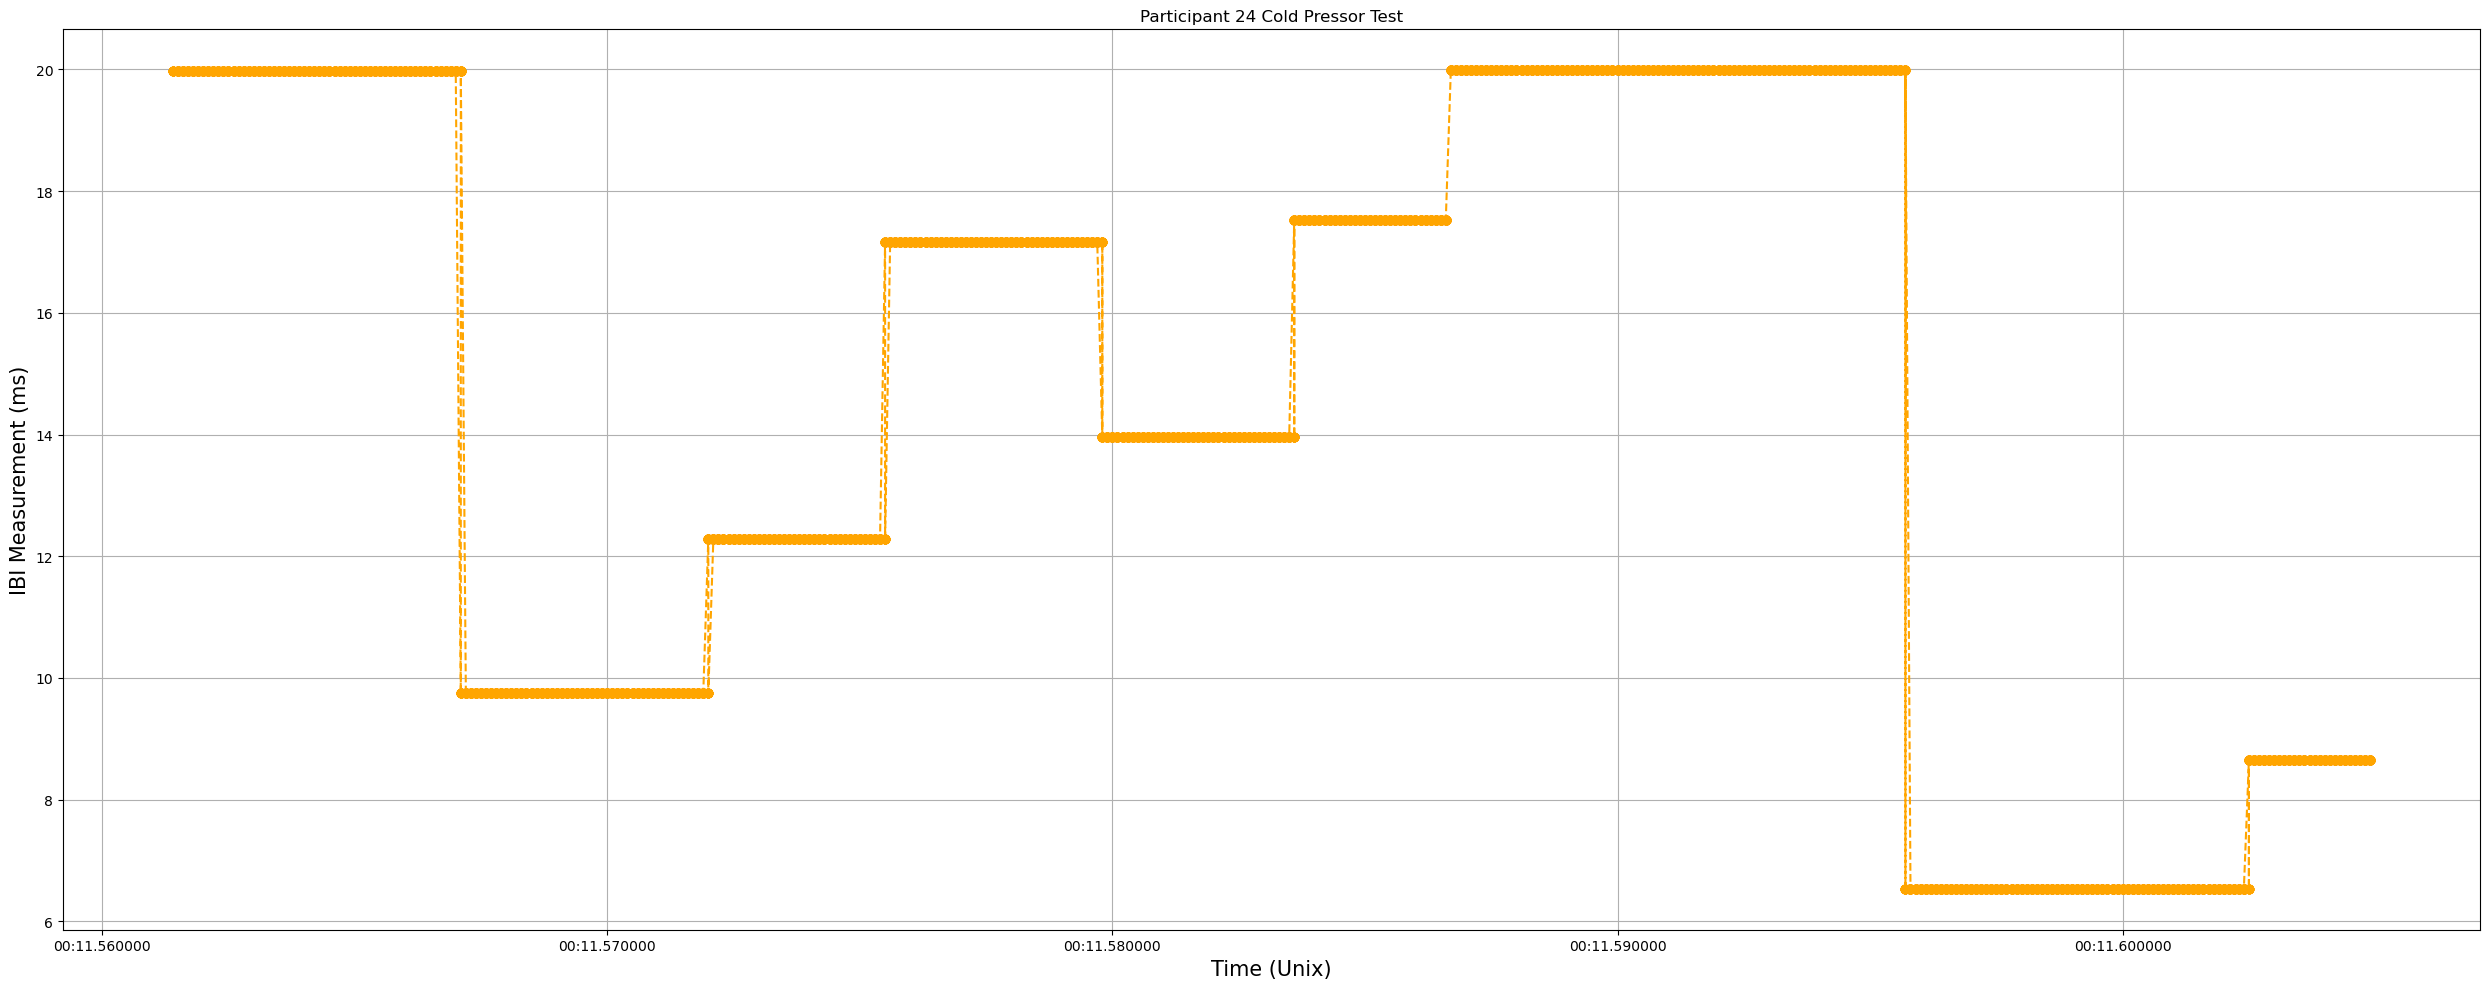

<Figure size 2500x1000 with 0 Axes>

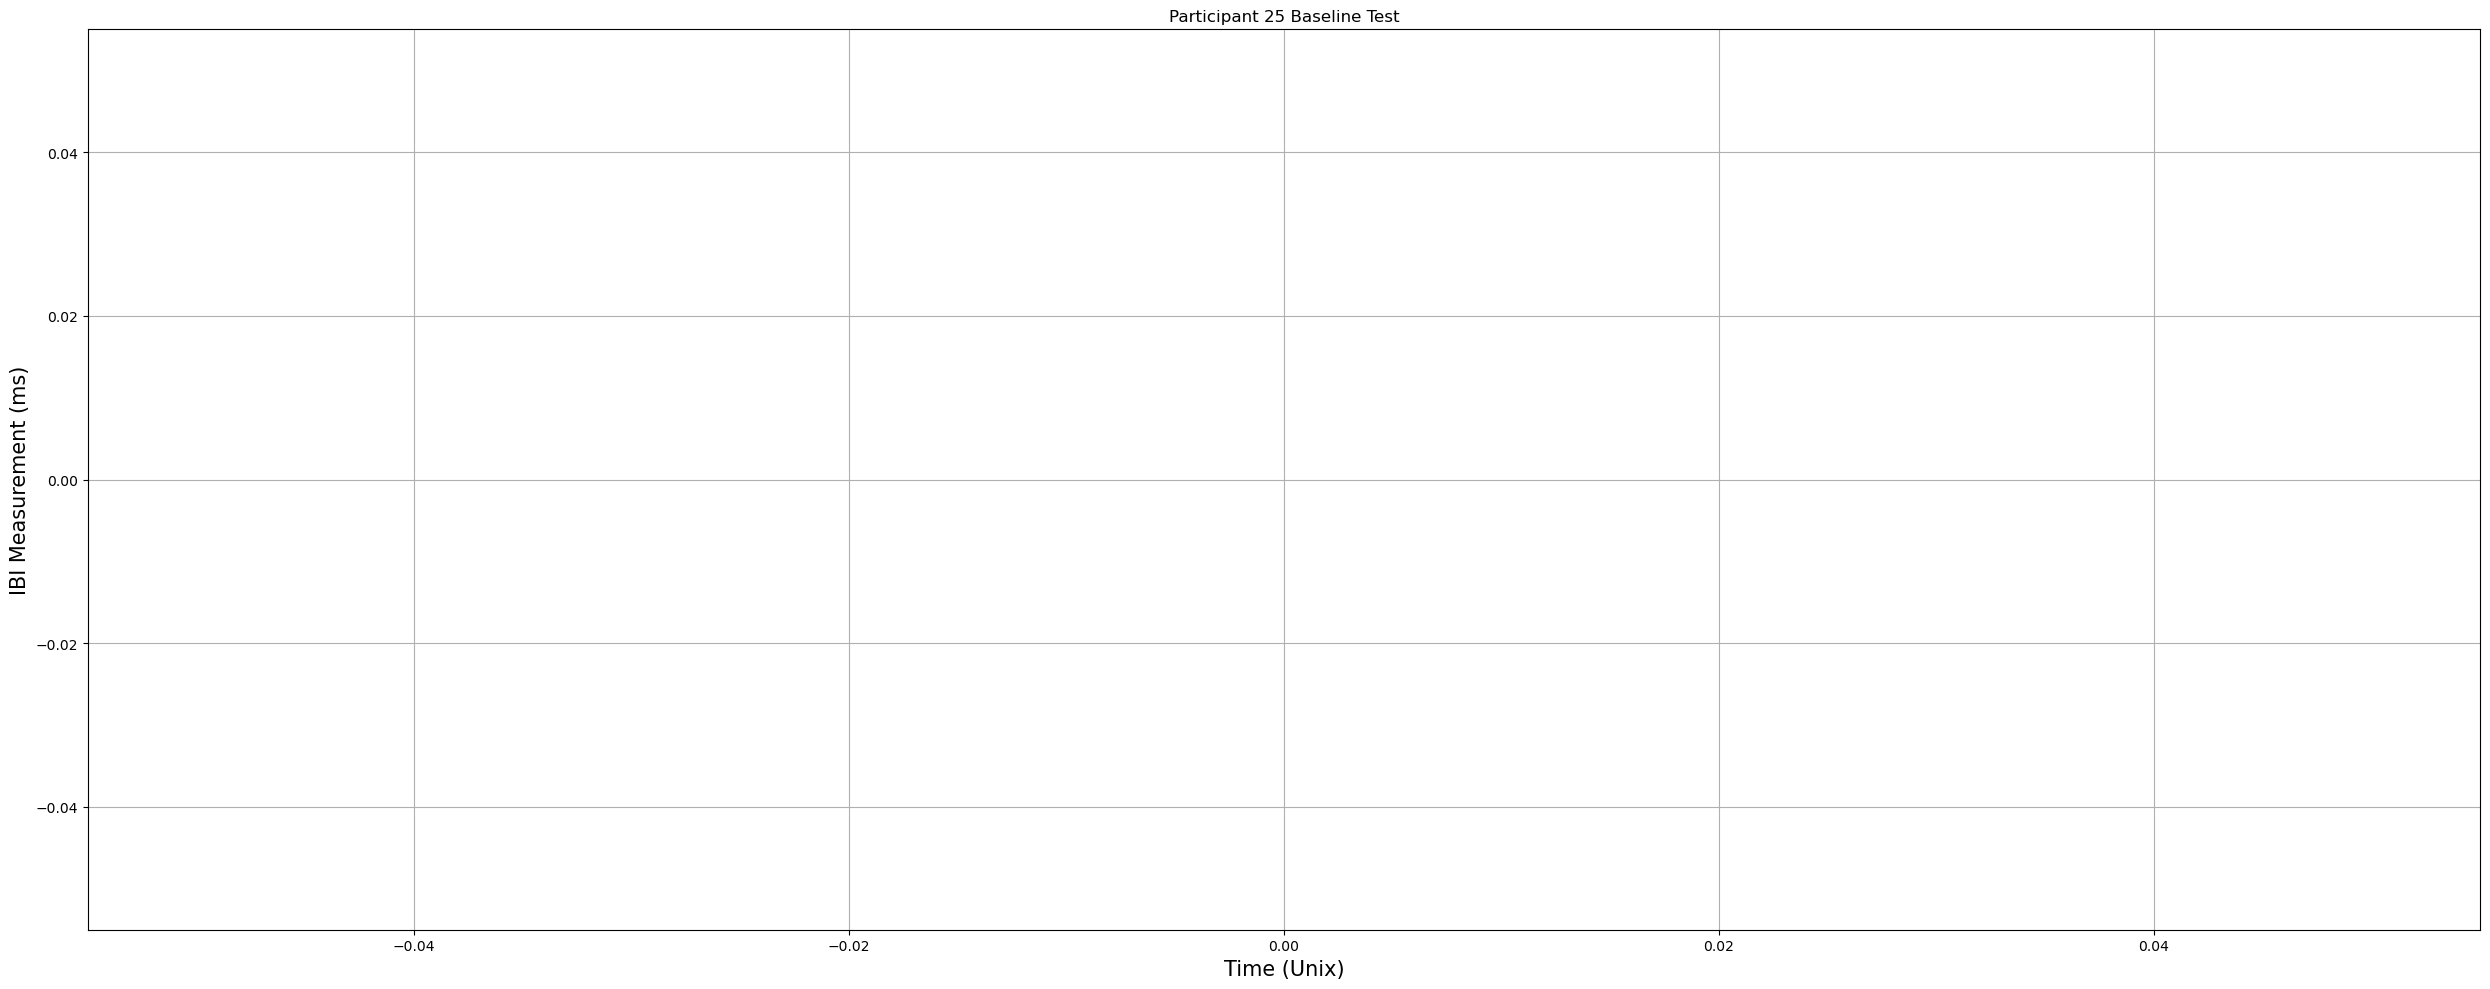

<Figure size 2500x1000 with 0 Axes>

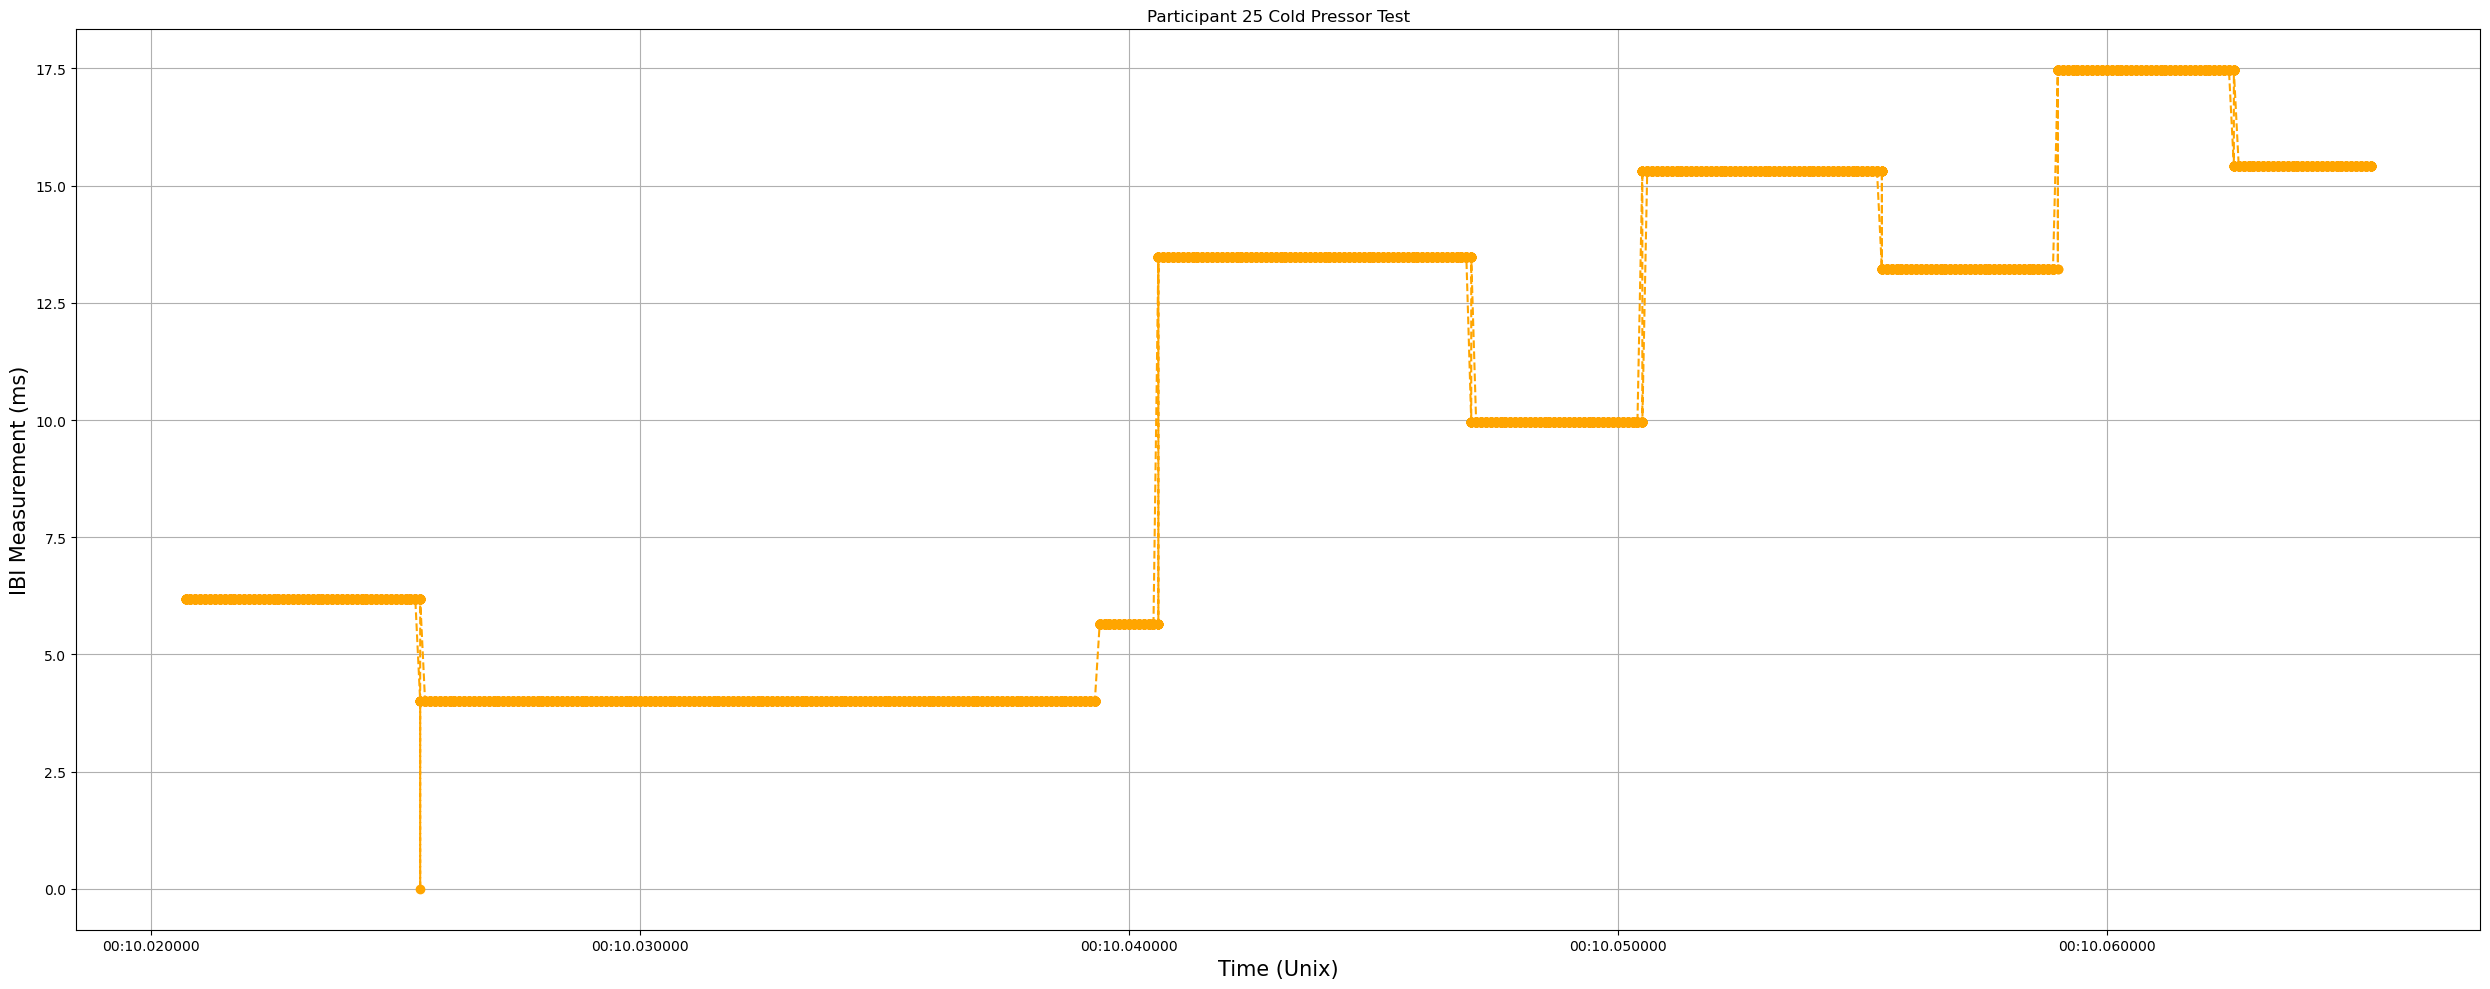

<Figure size 2500x1000 with 0 Axes>

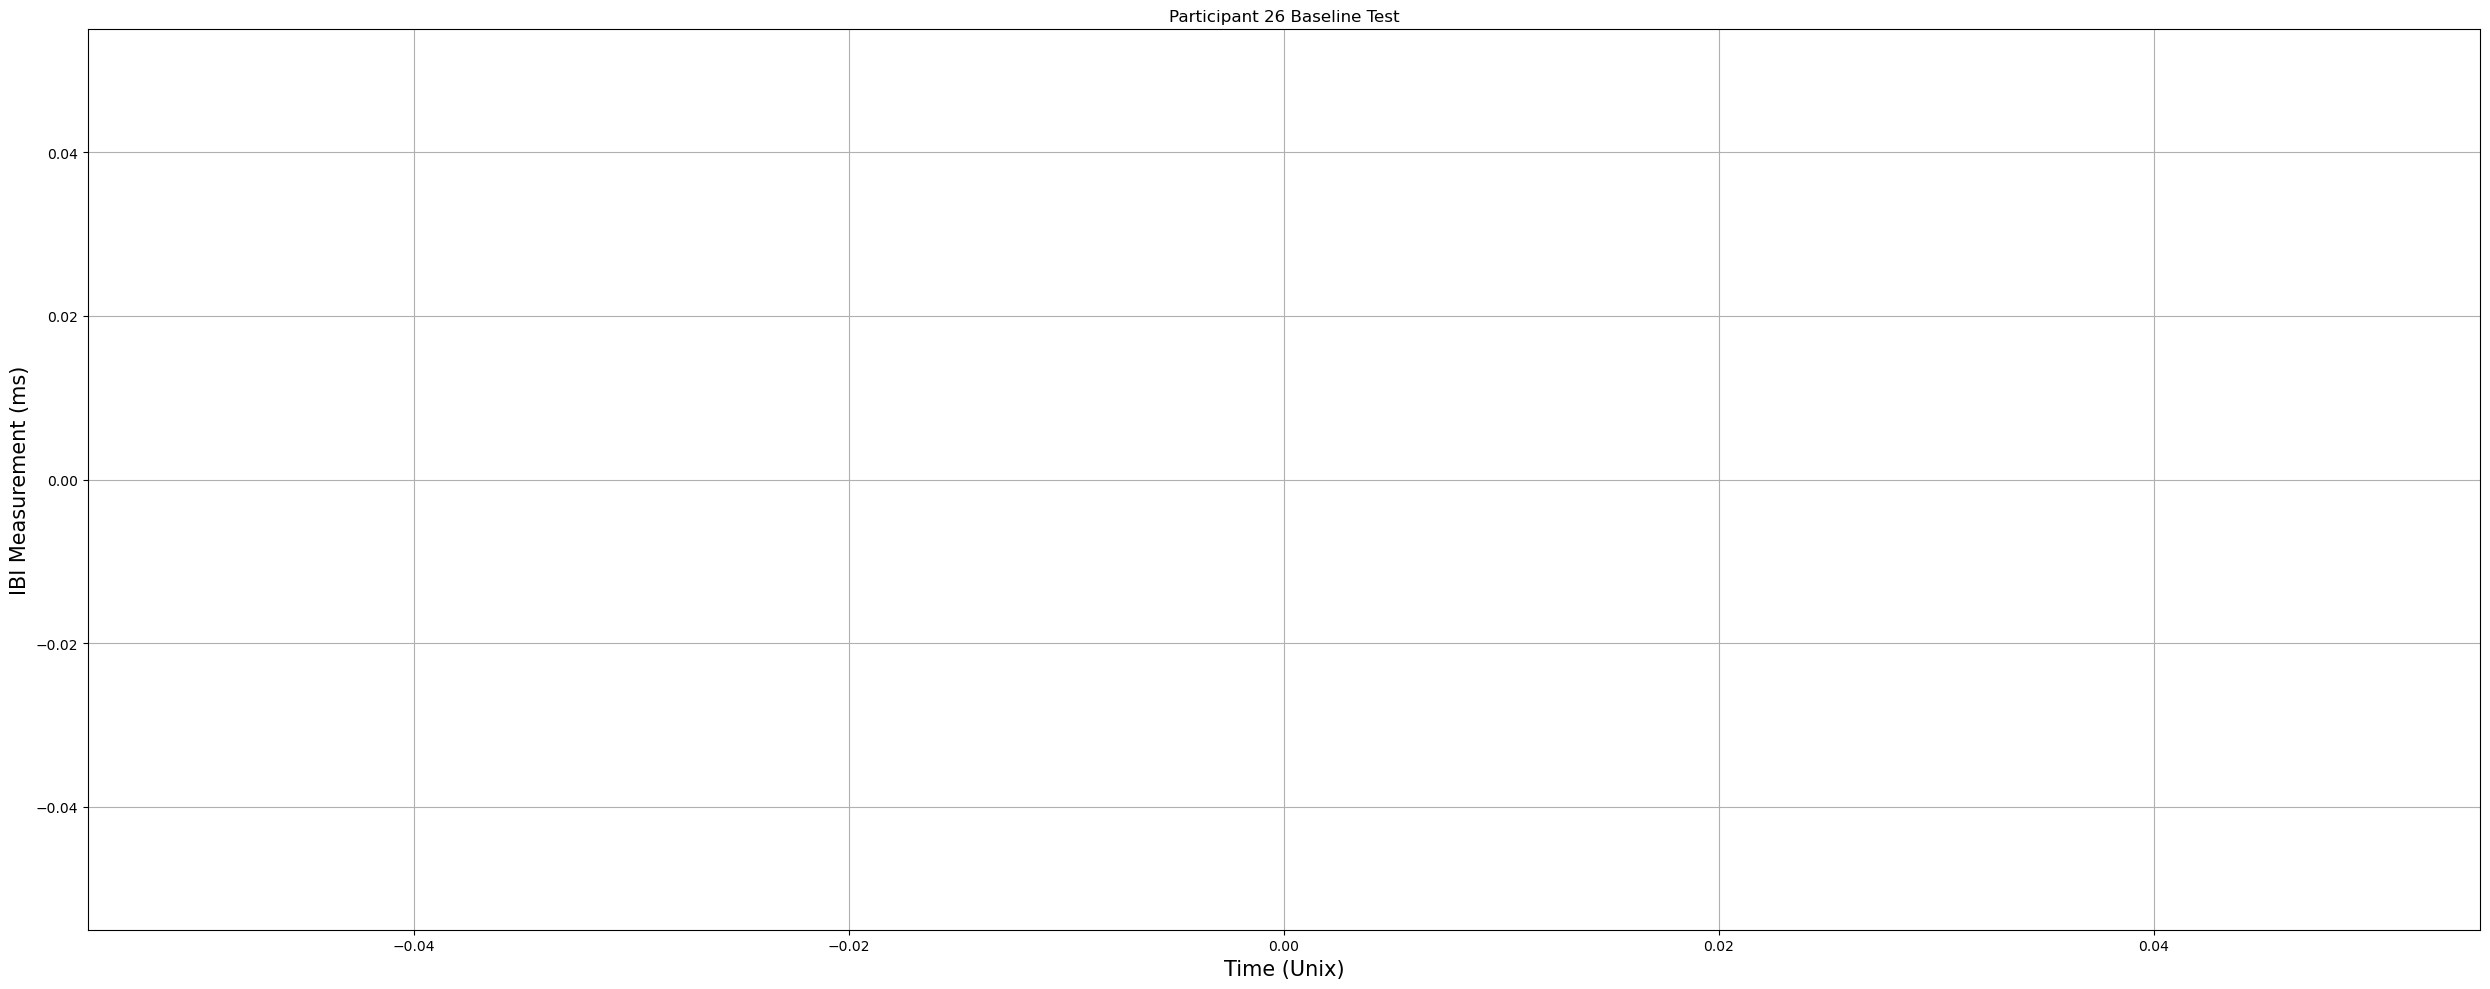

<Figure size 2500x1000 with 0 Axes>

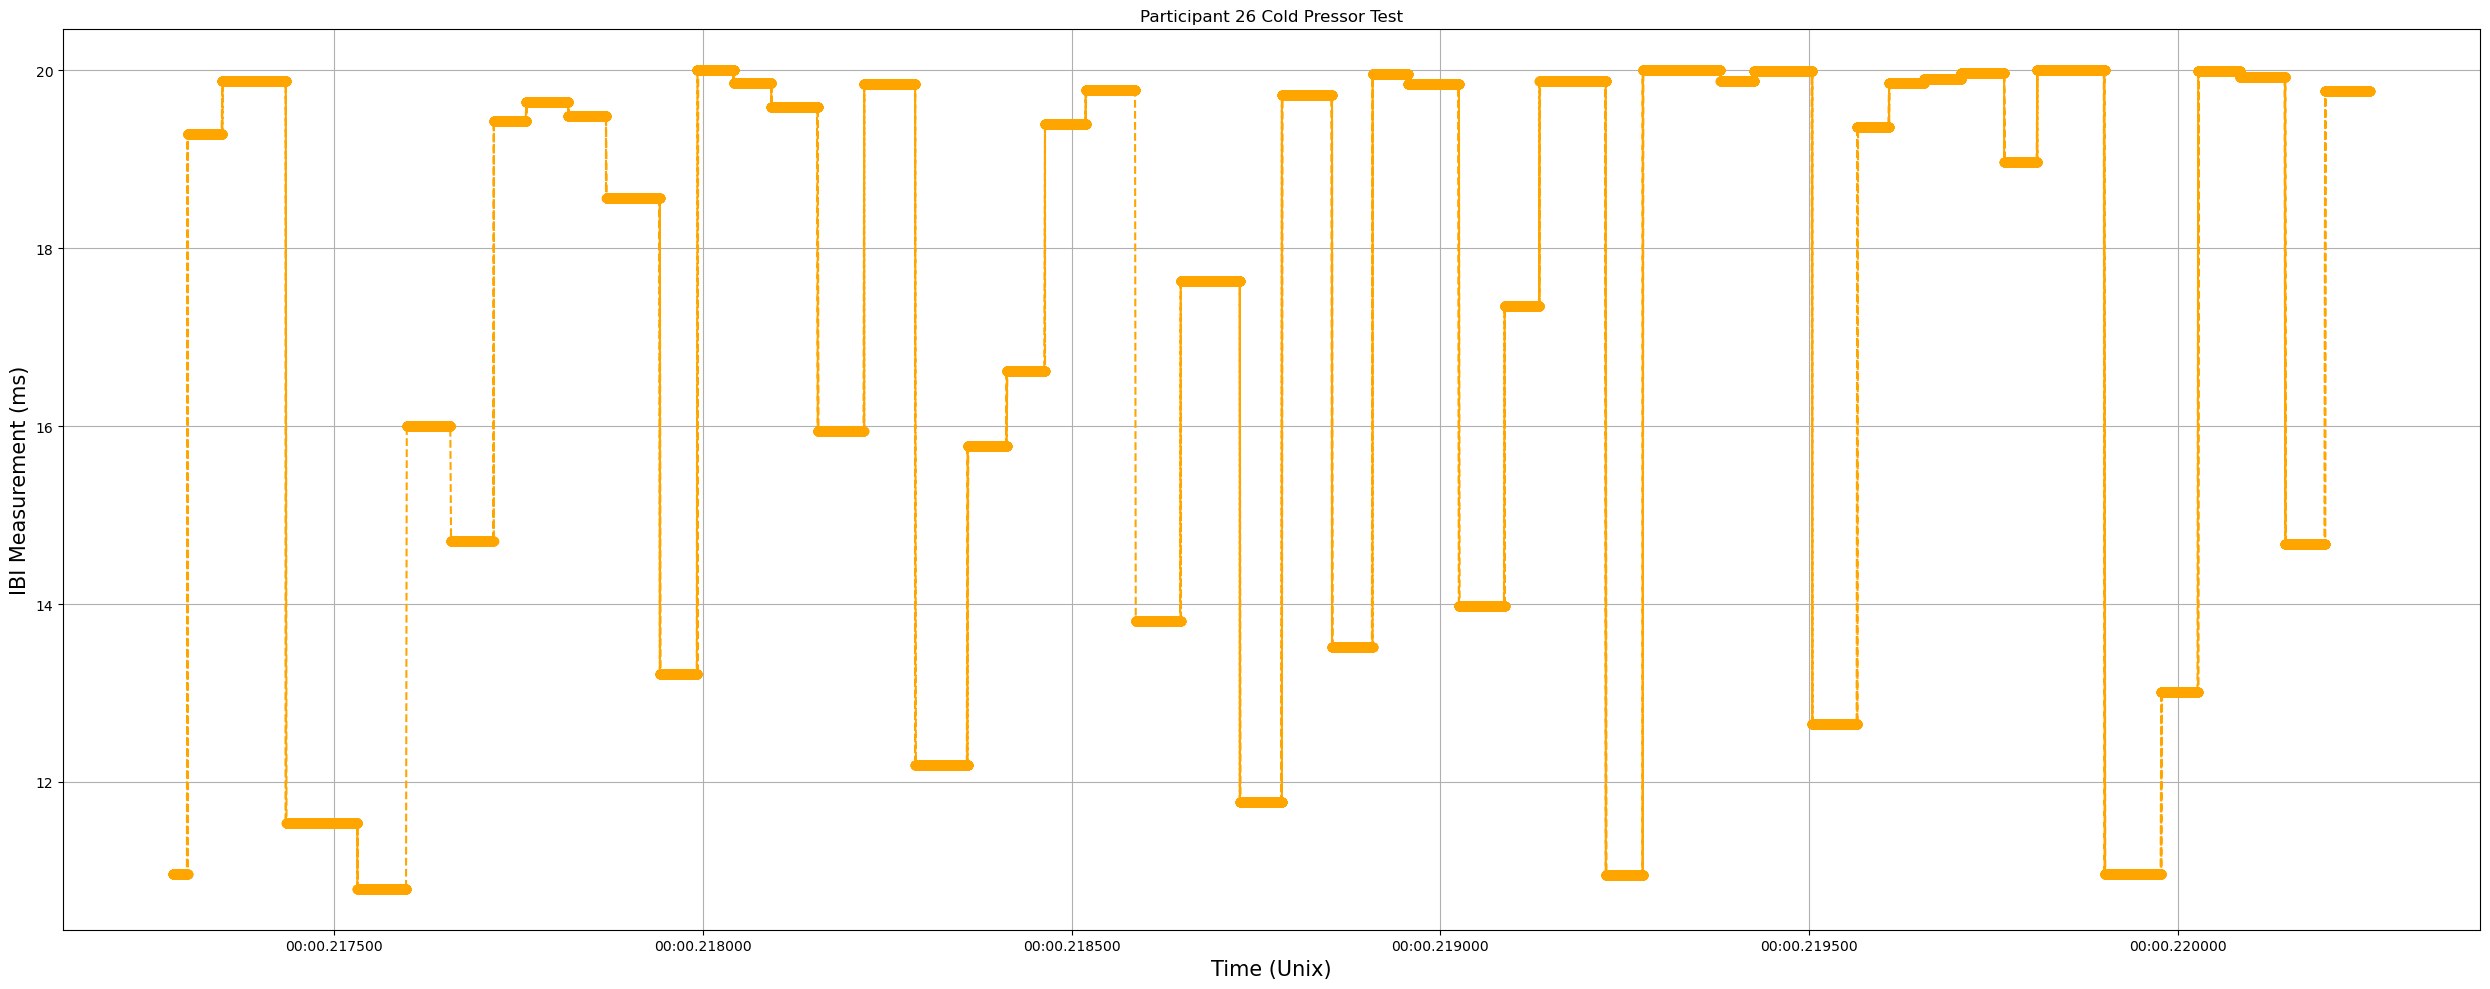

<Figure size 2500x1000 with 0 Axes>

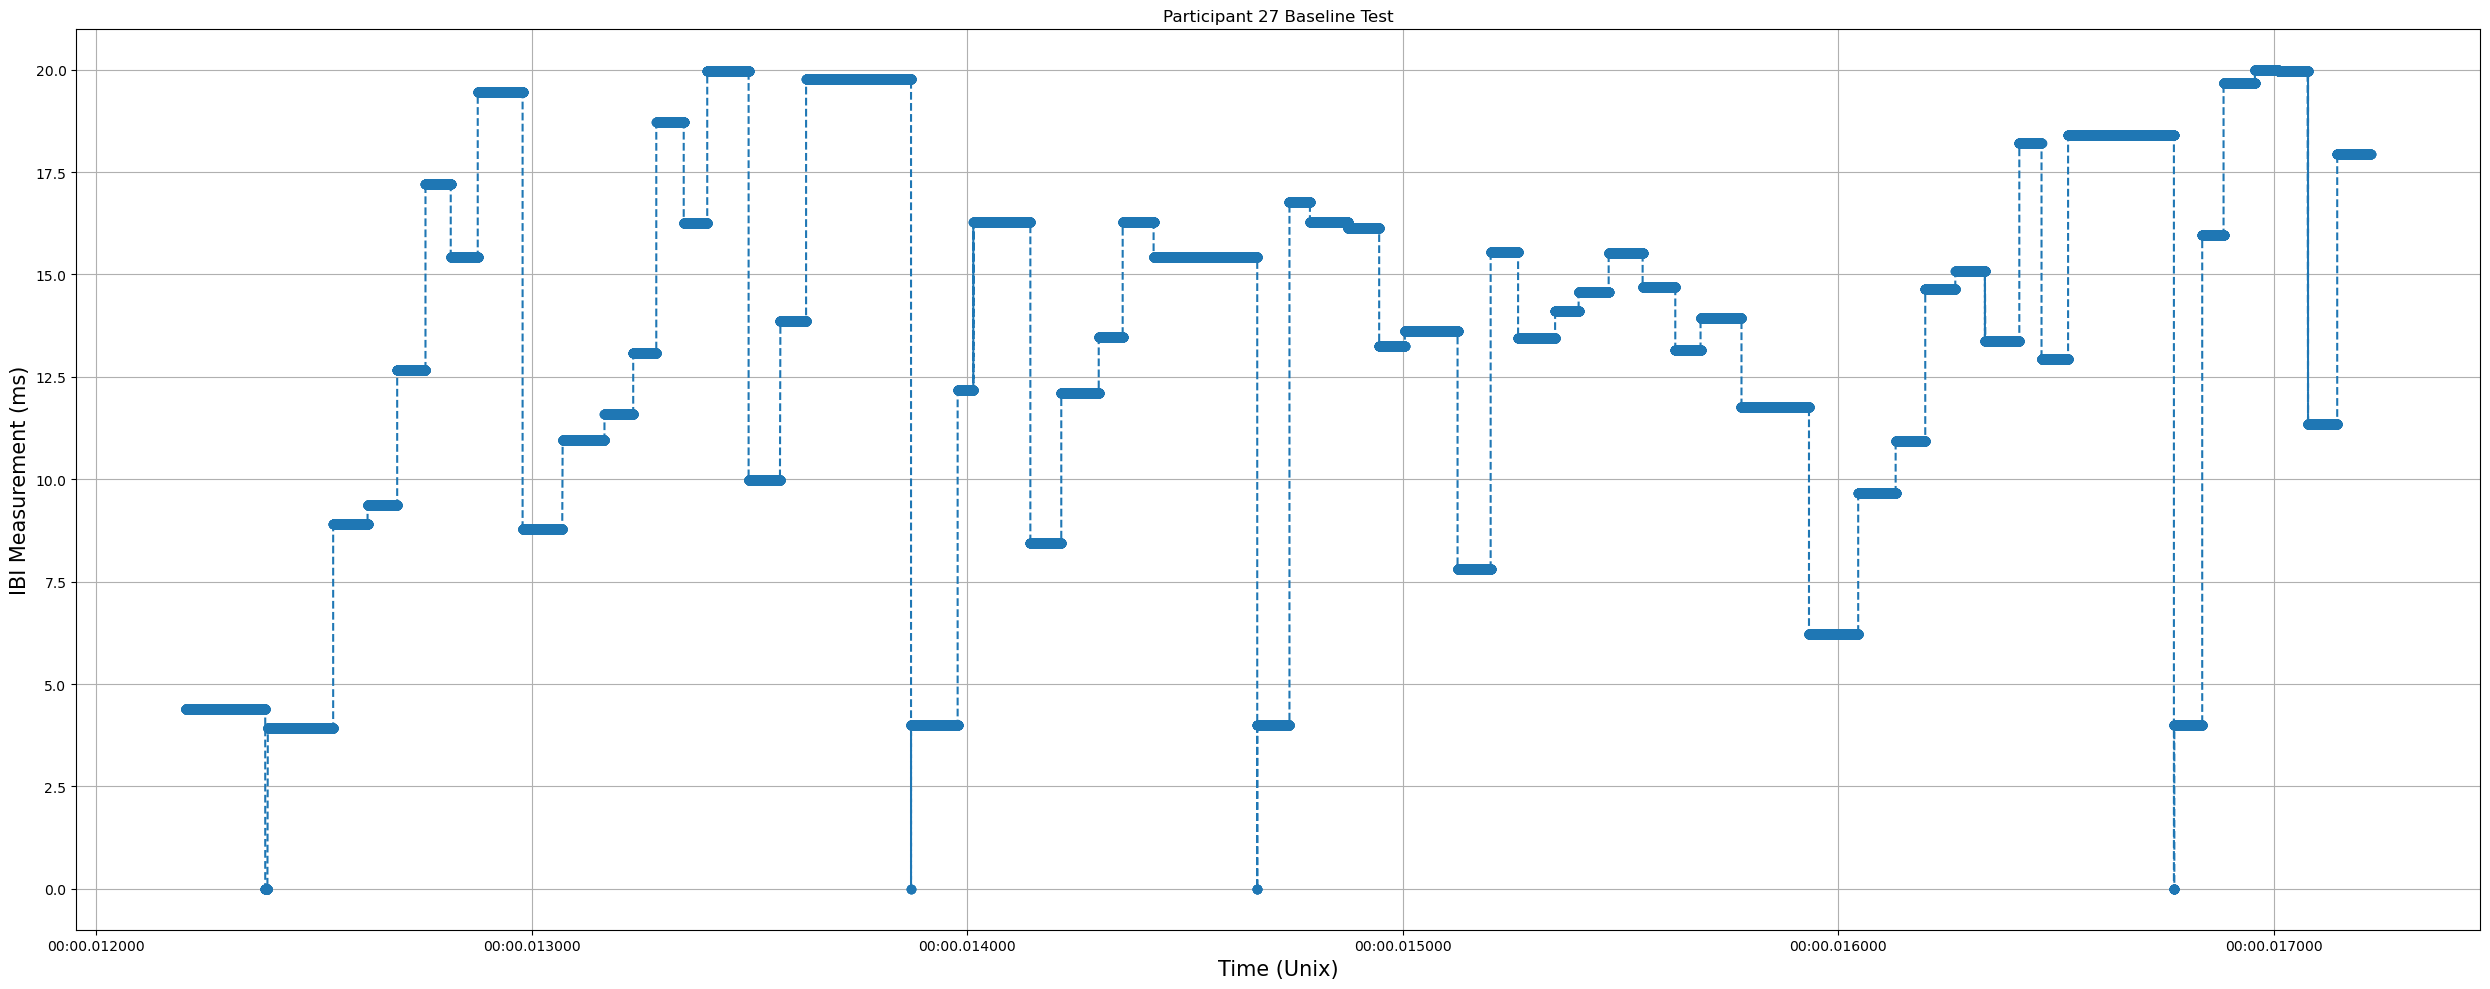

<Figure size 2500x1000 with 0 Axes>

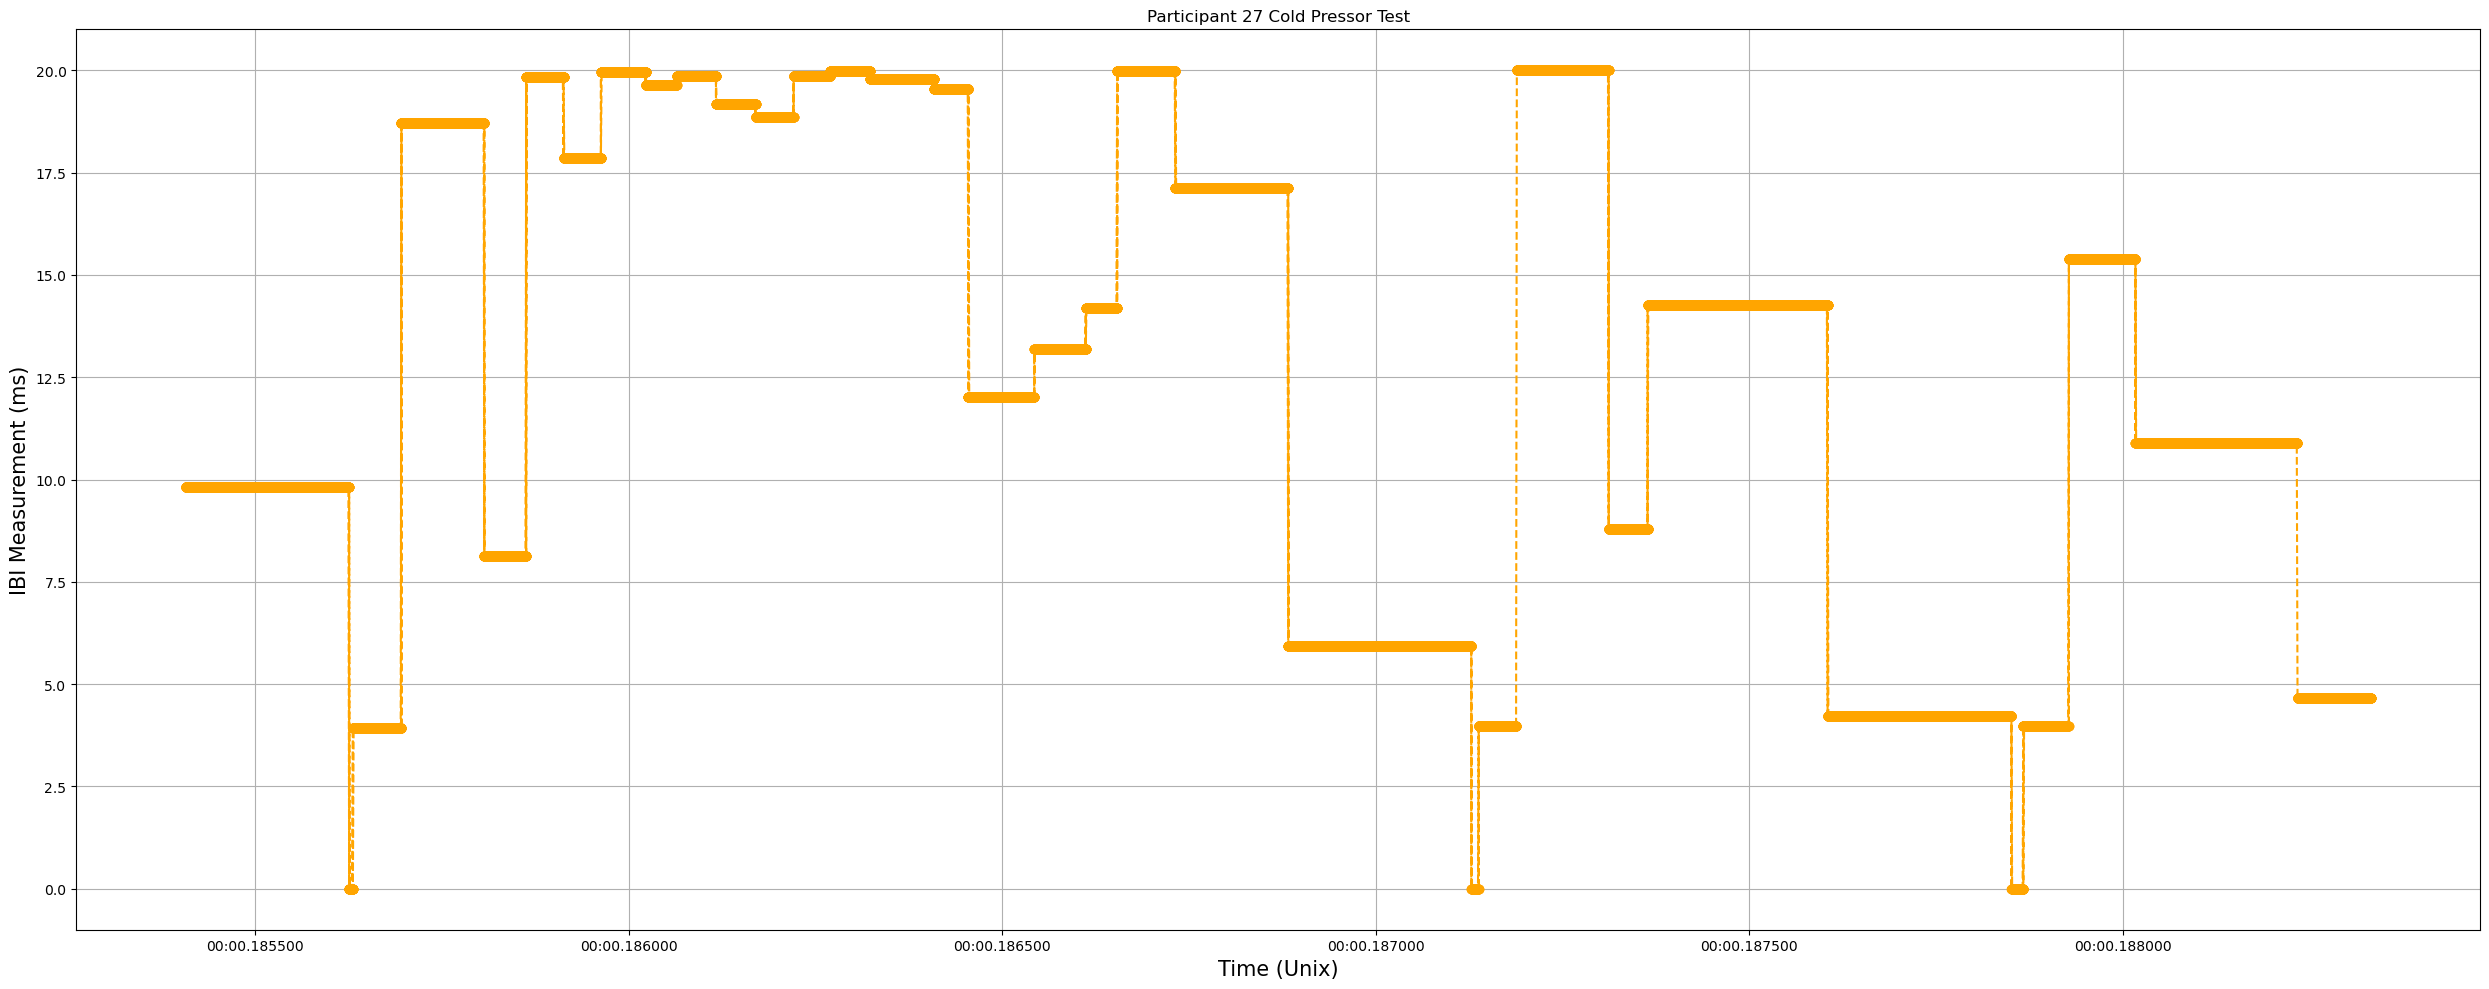

<Figure size 2500x1000 with 0 Axes>

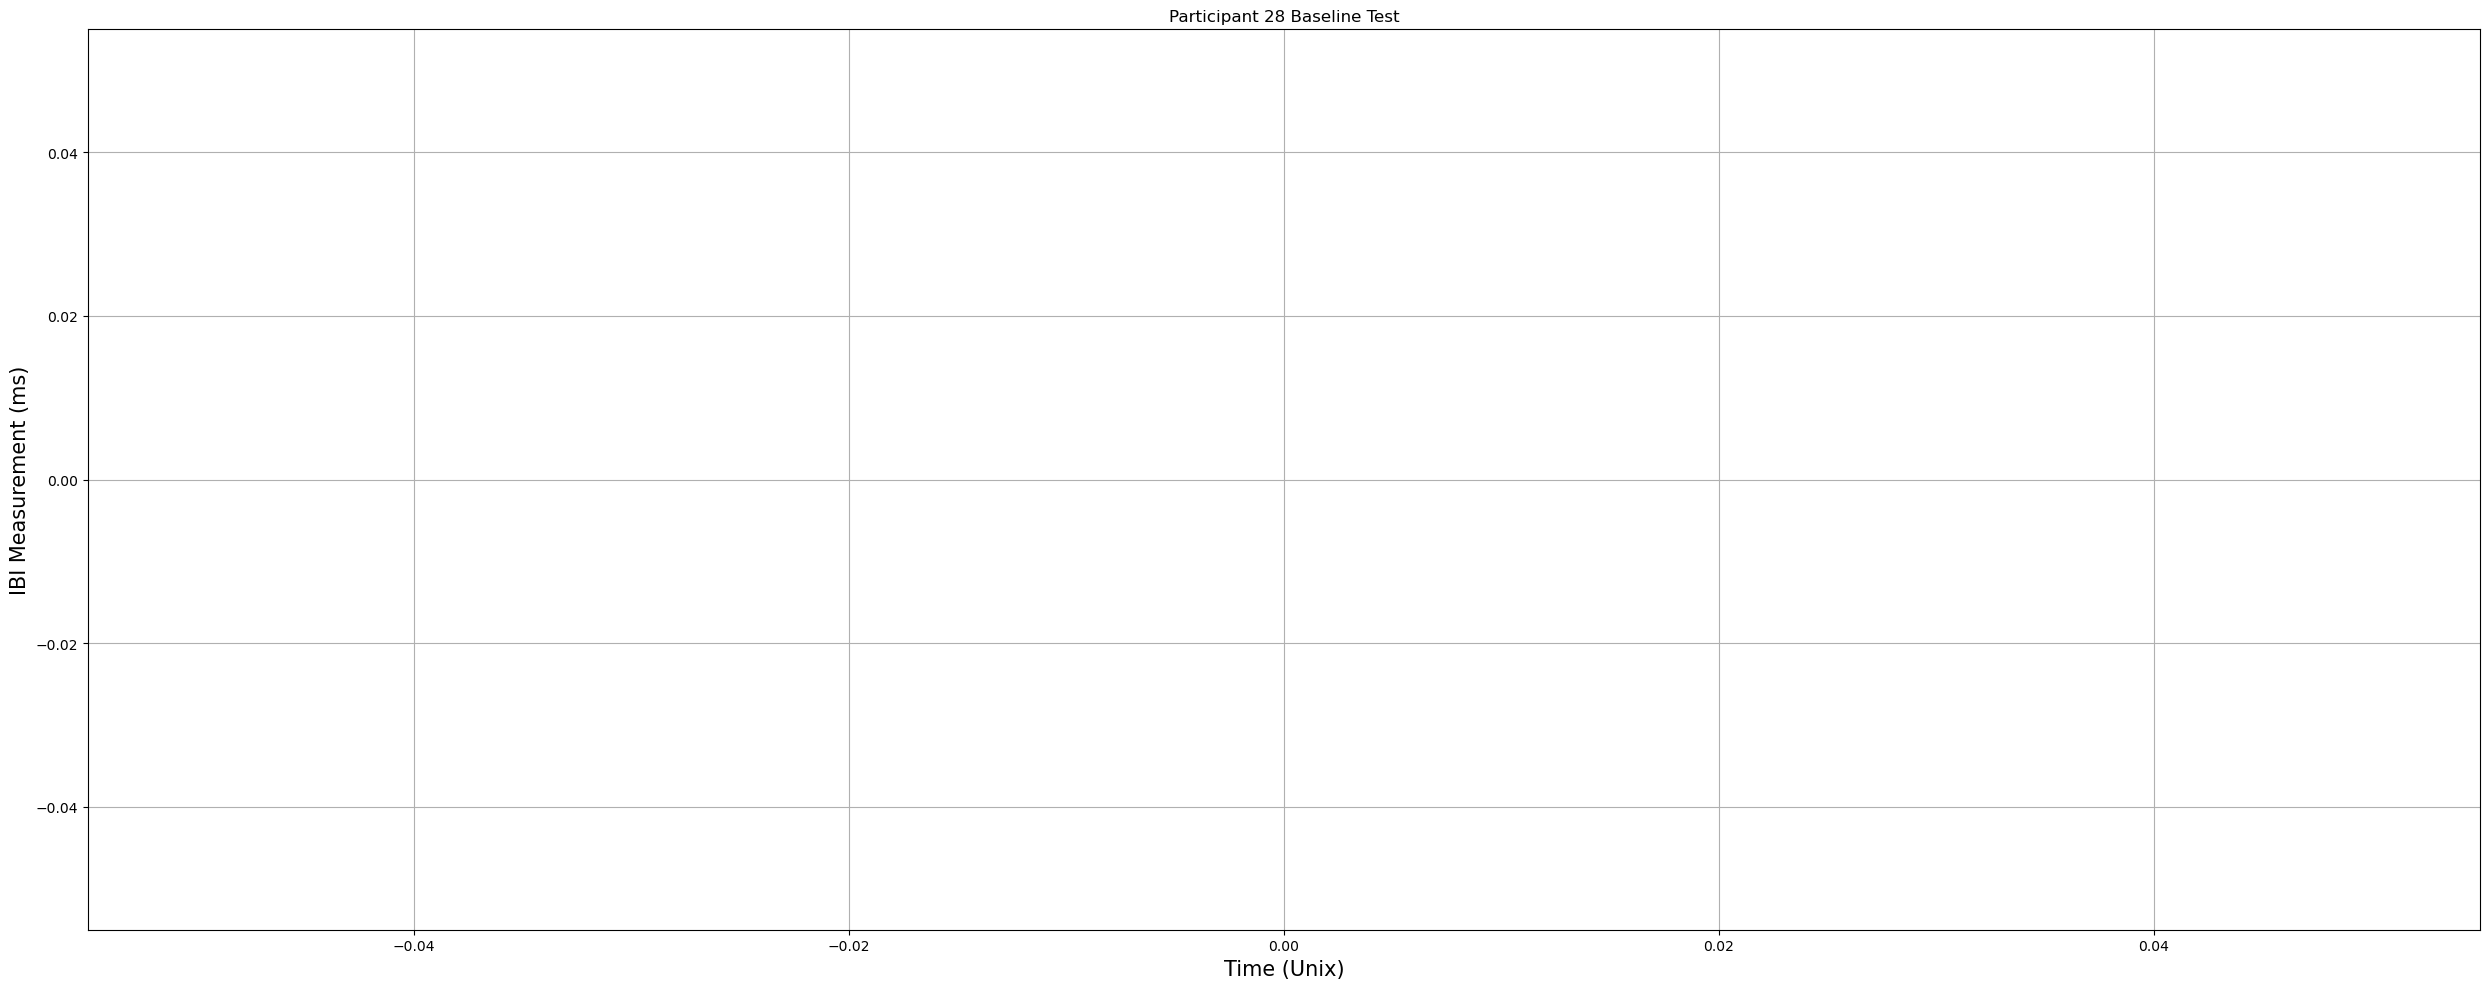

<Figure size 2500x1000 with 0 Axes>

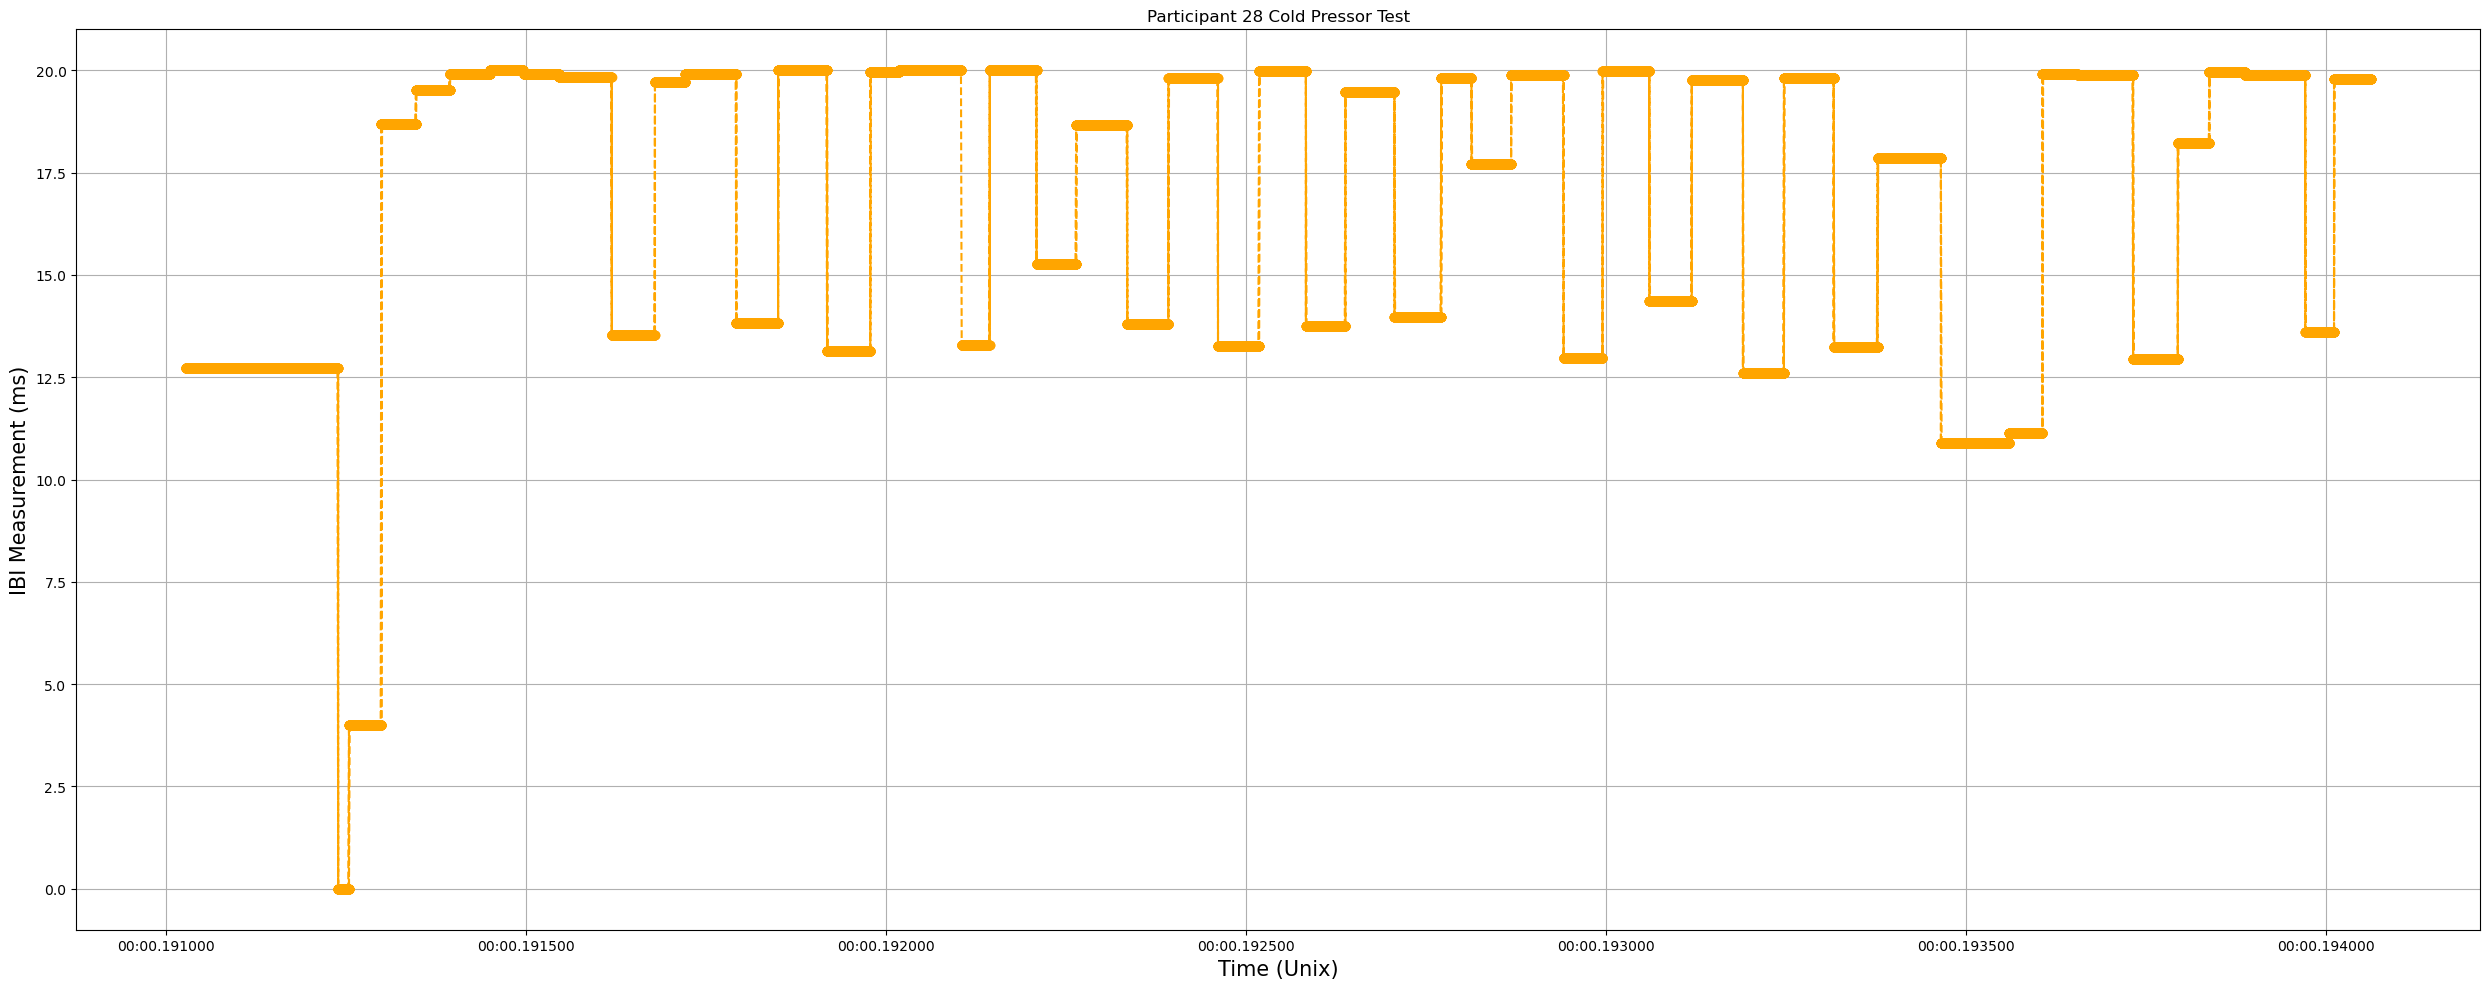

<Figure size 2500x1000 with 0 Axes>

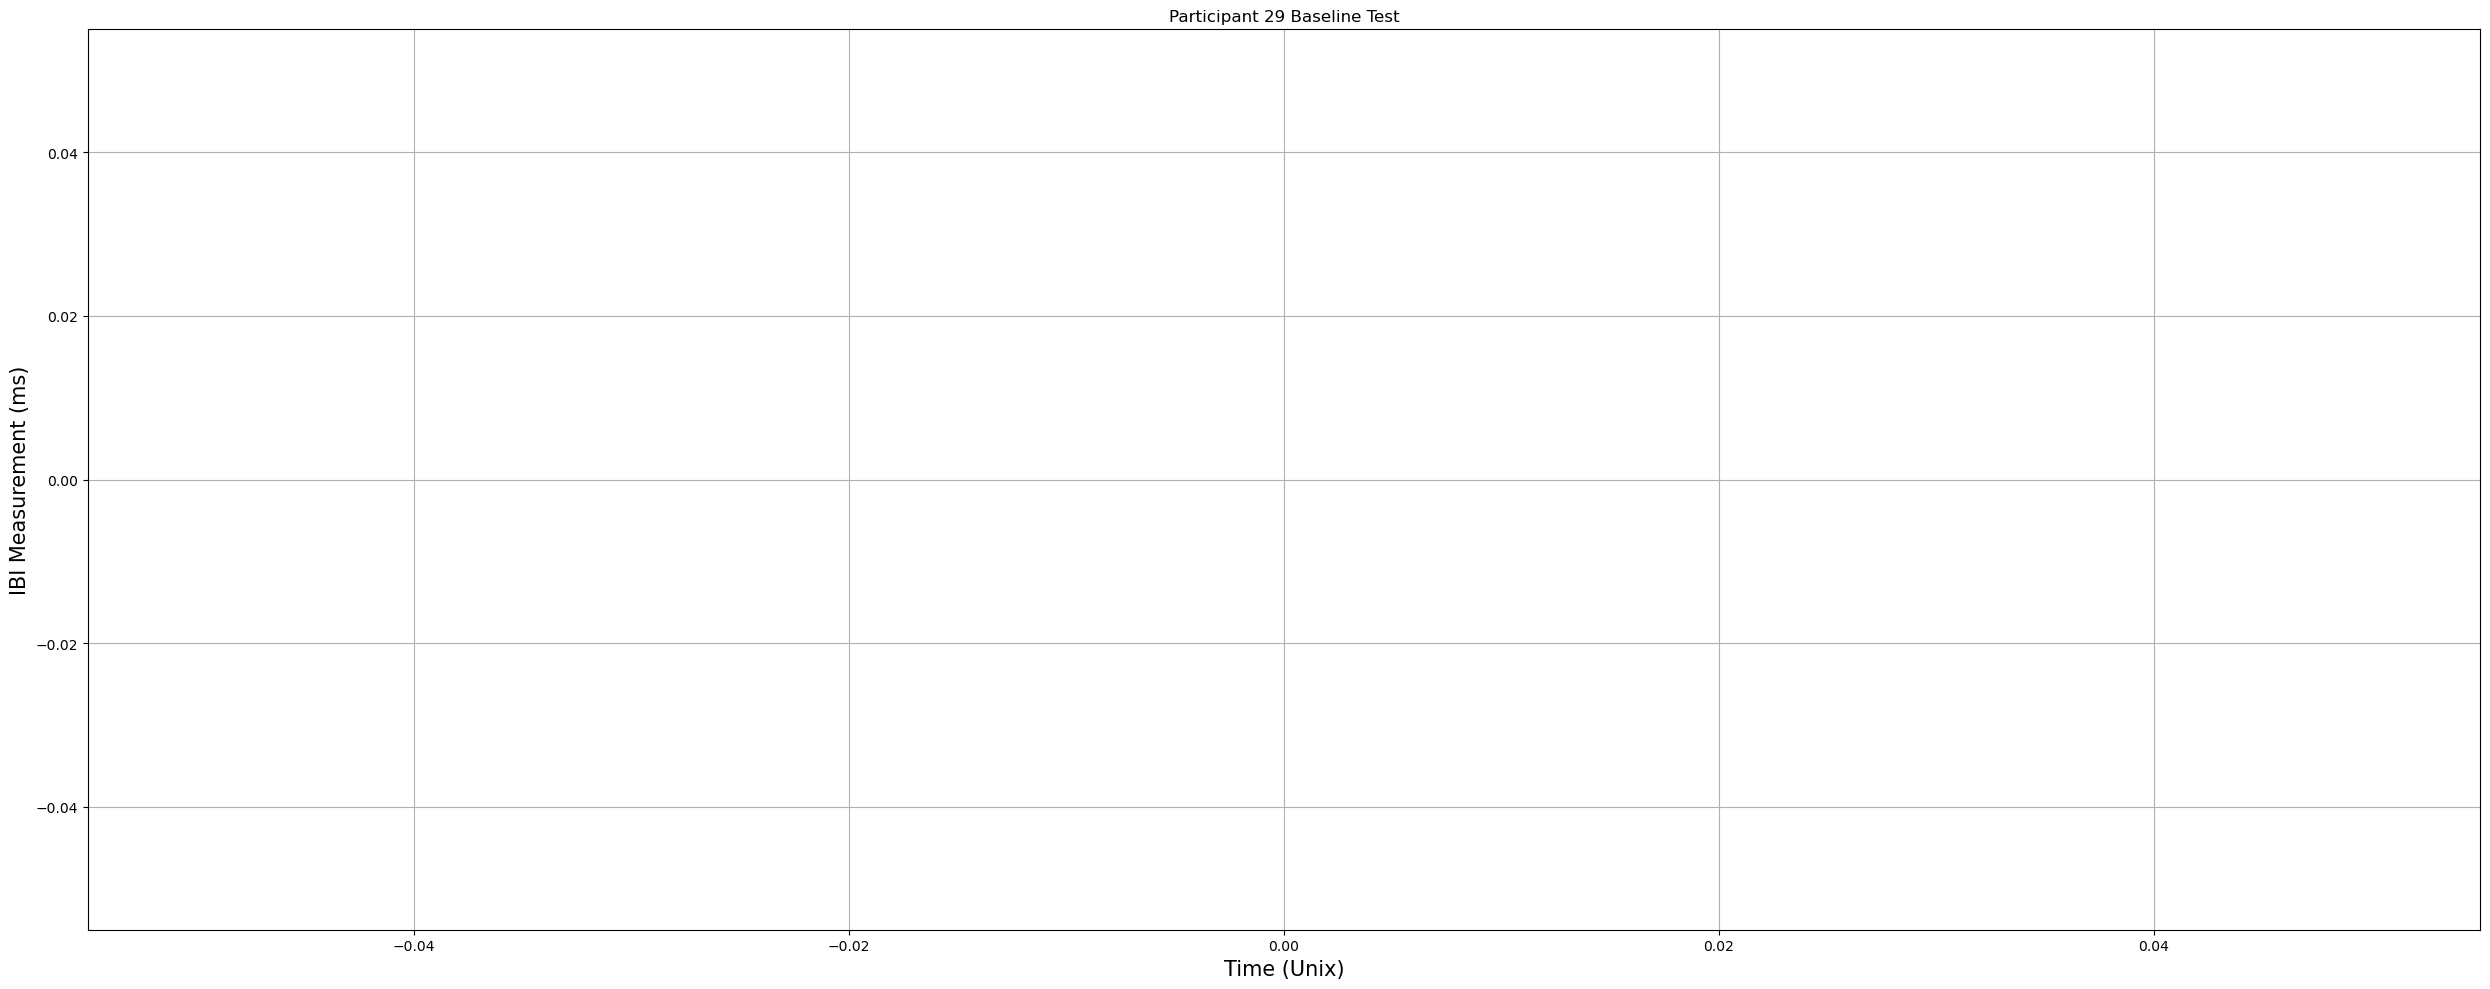

<Figure size 2500x1000 with 0 Axes>

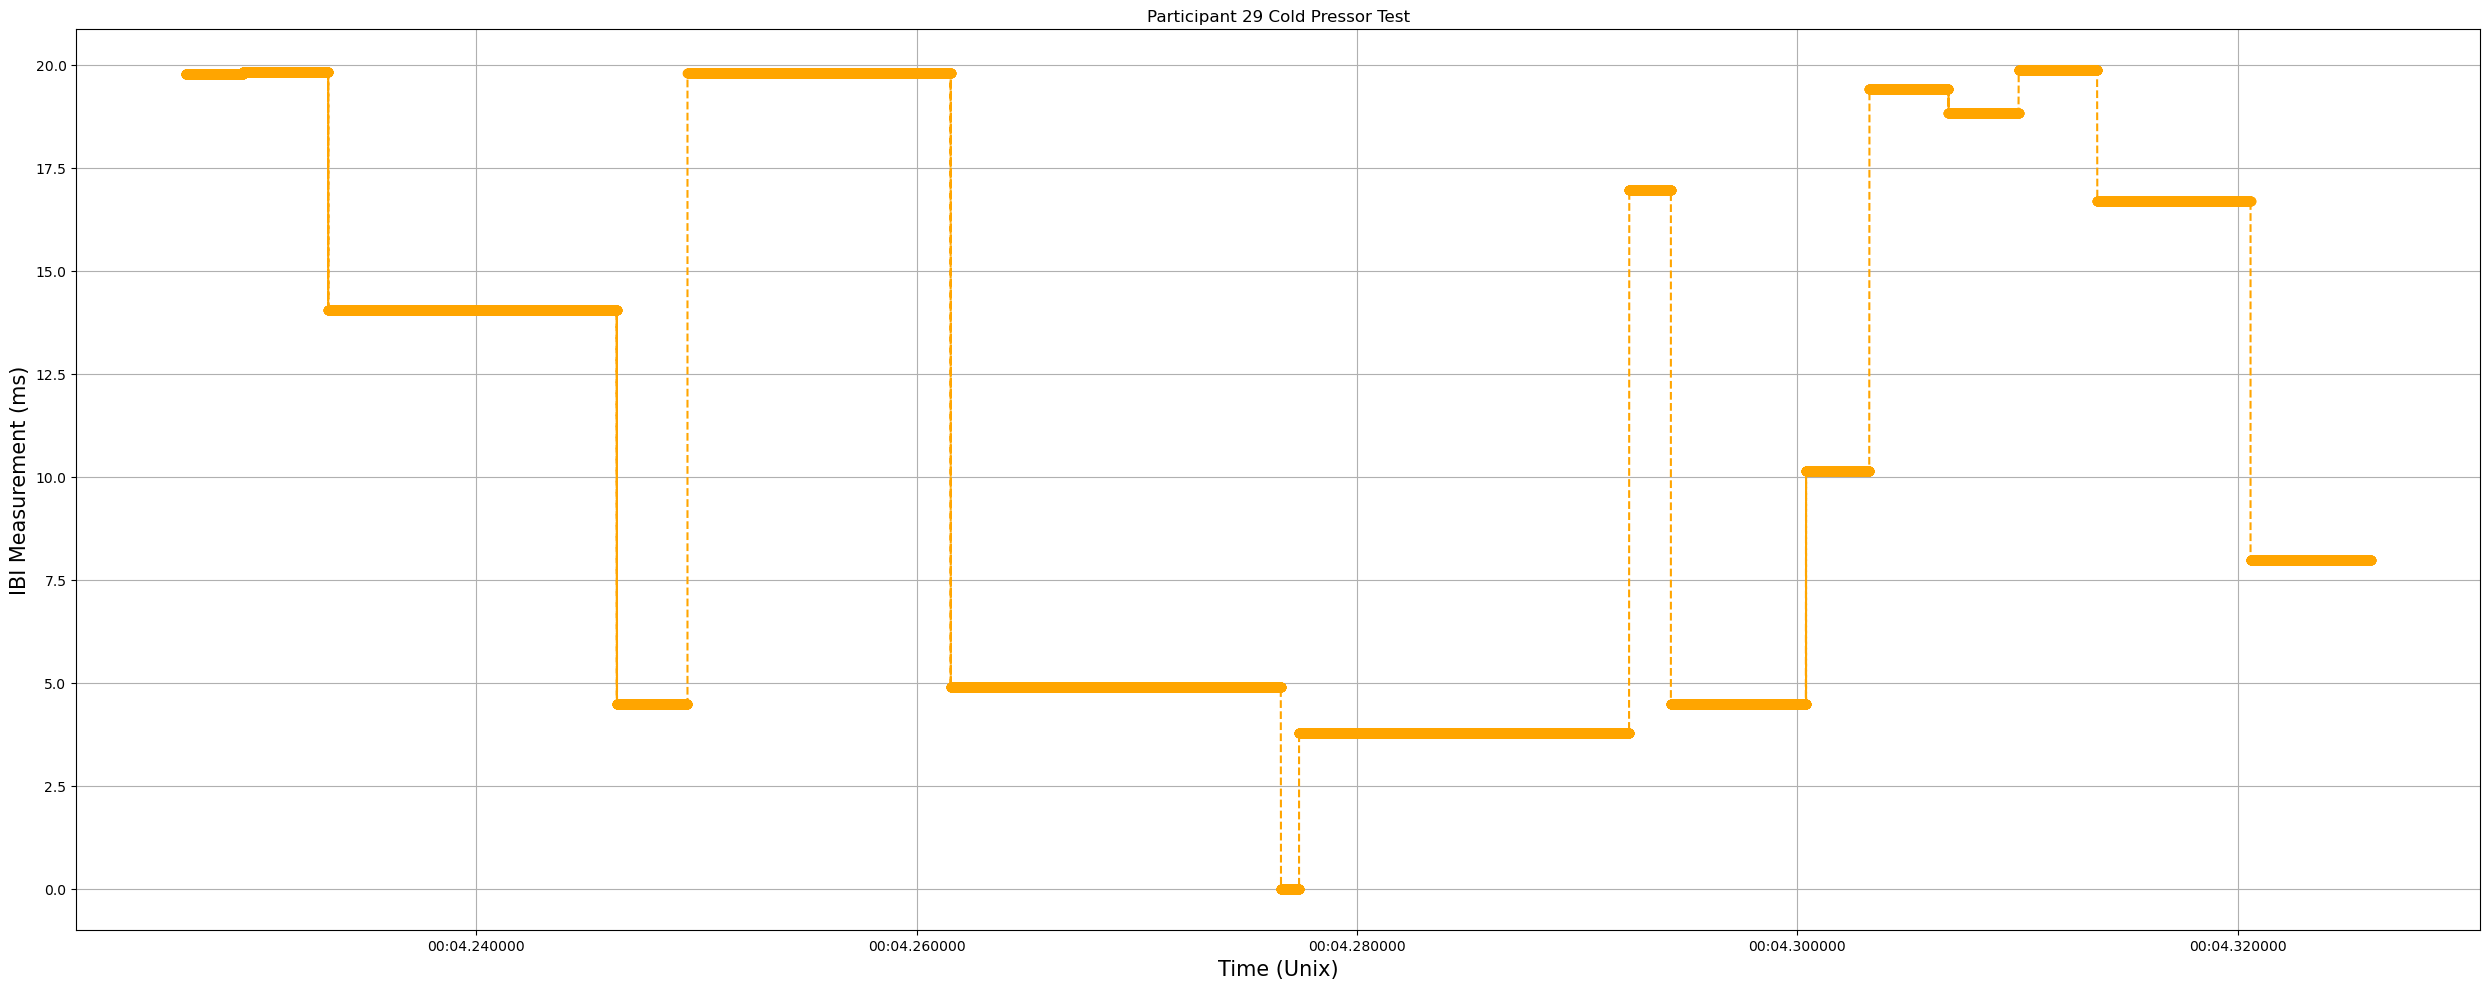

<Figure size 2500x1000 with 0 Axes>

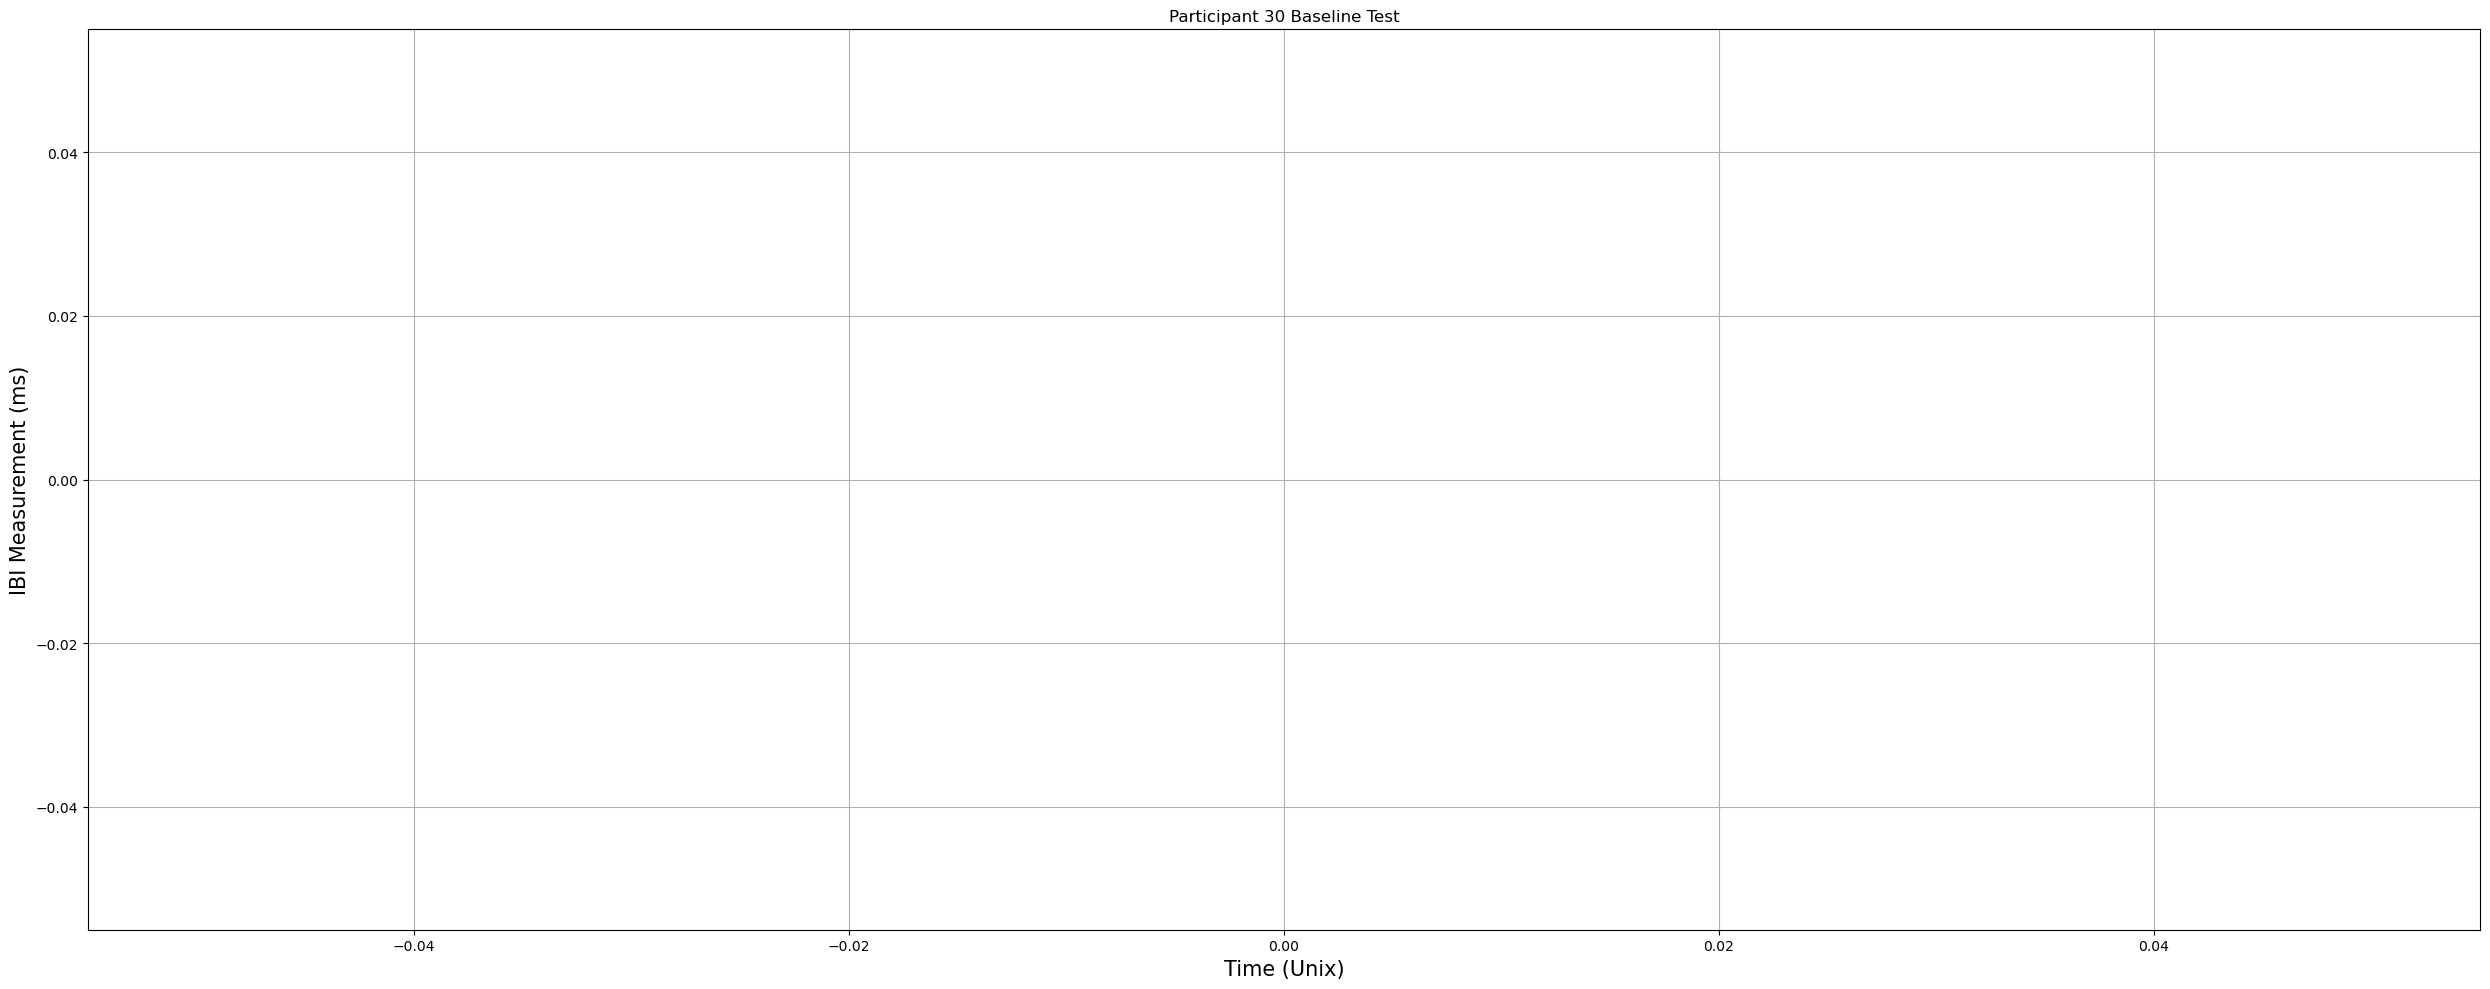

<Figure size 2500x1000 with 0 Axes>

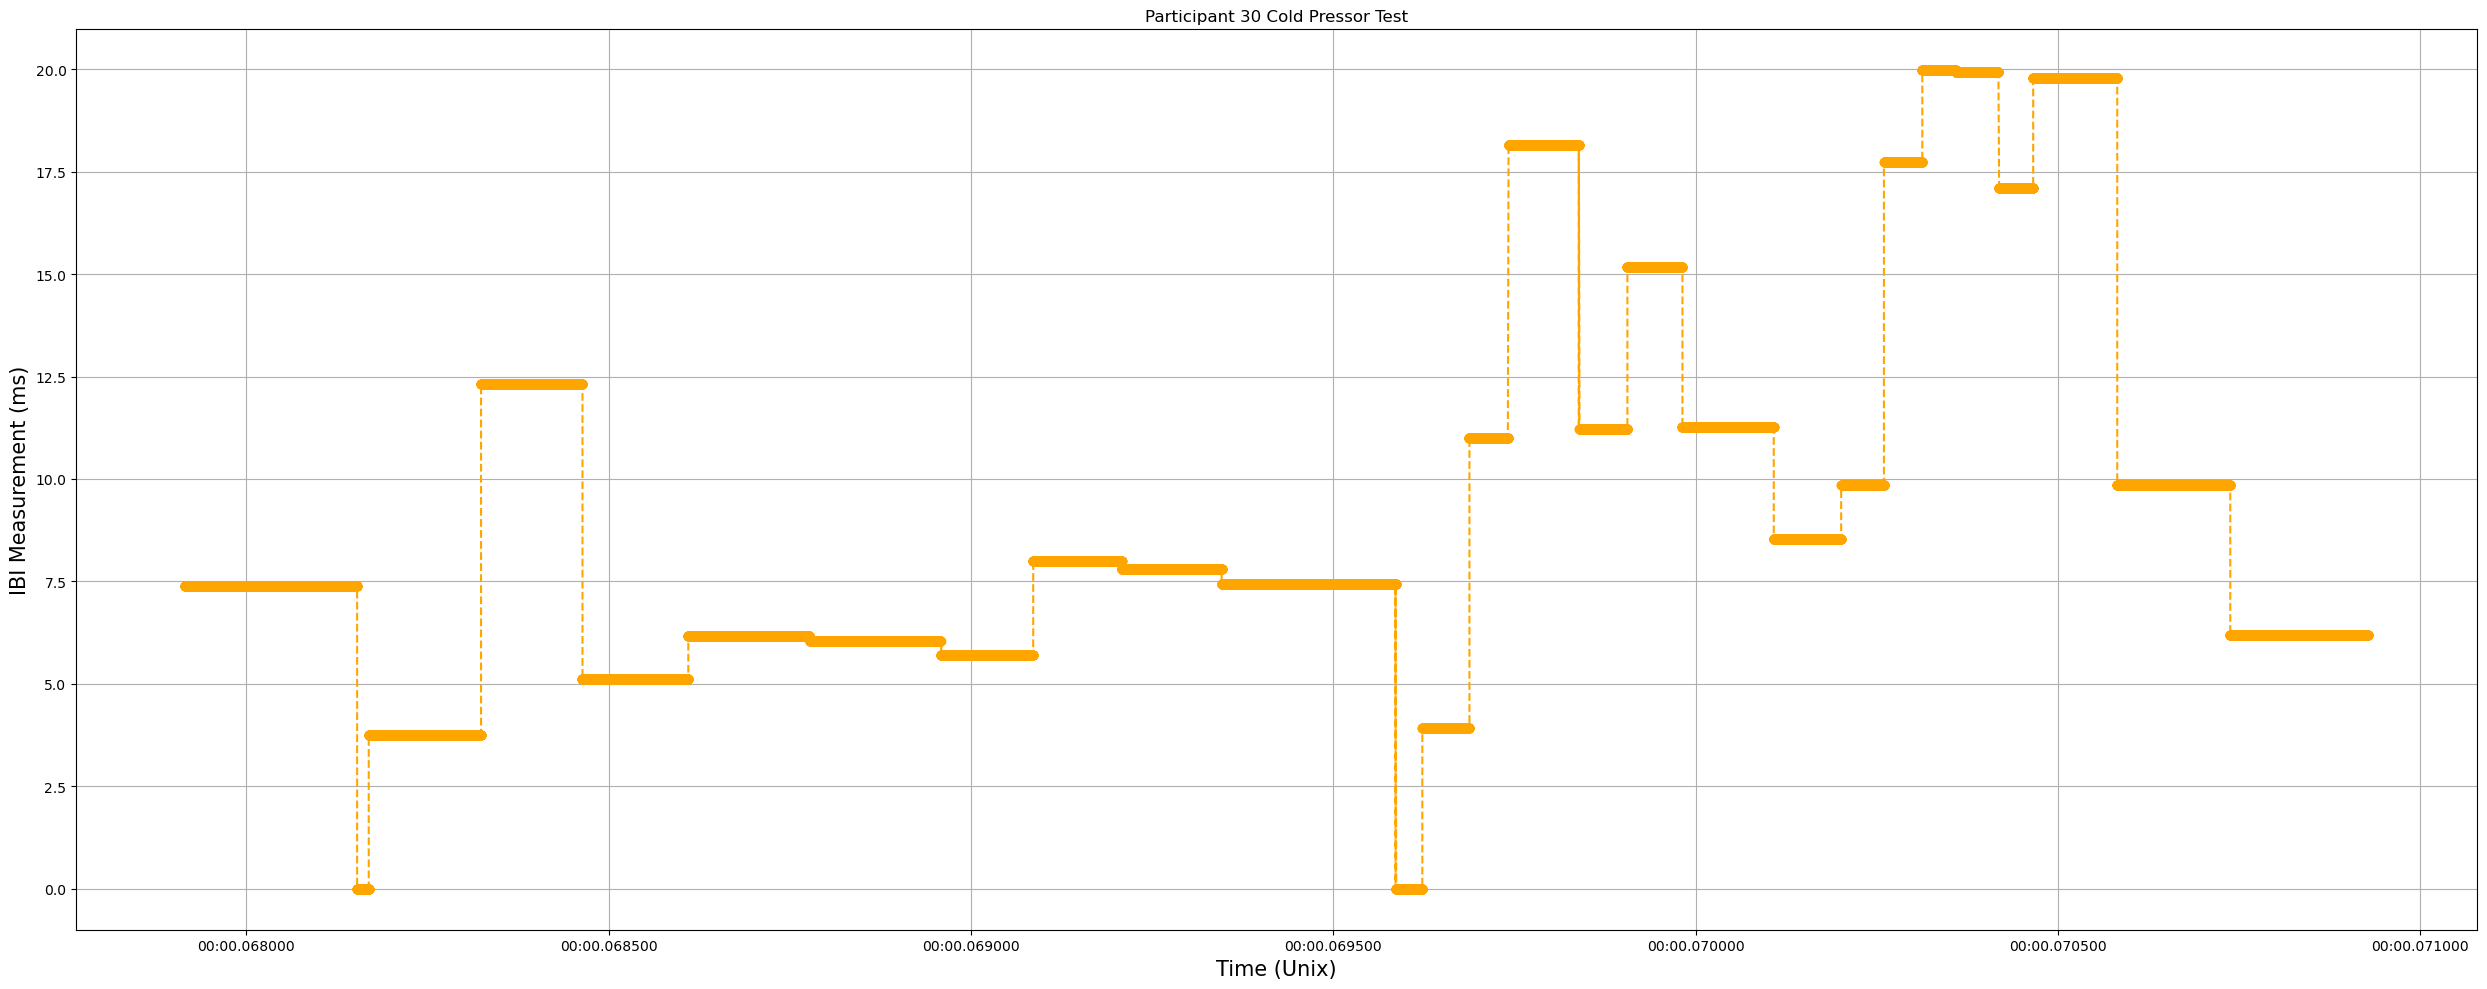

<Figure size 2500x1000 with 0 Axes>

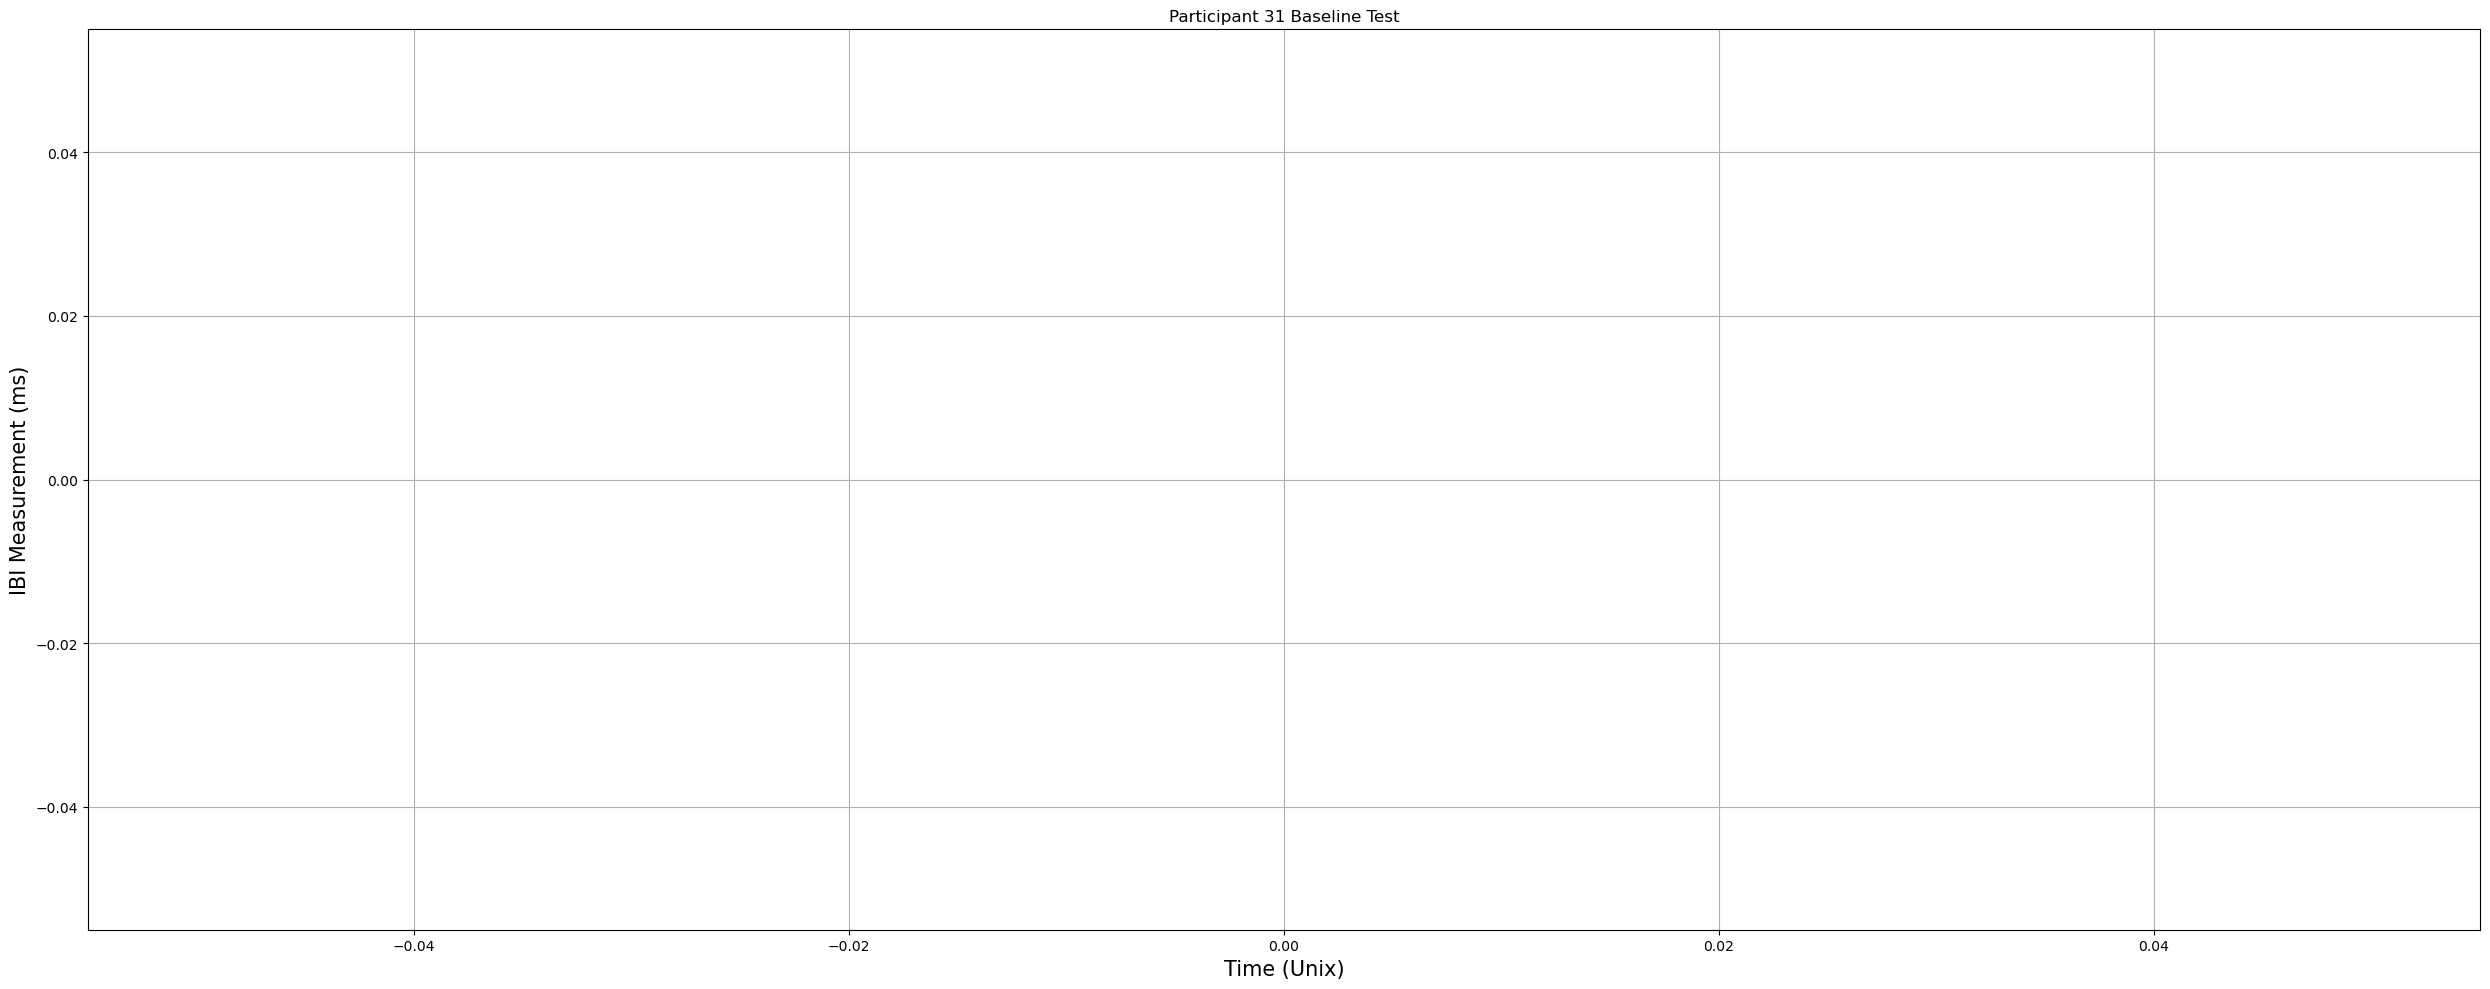

<Figure size 2500x1000 with 0 Axes>

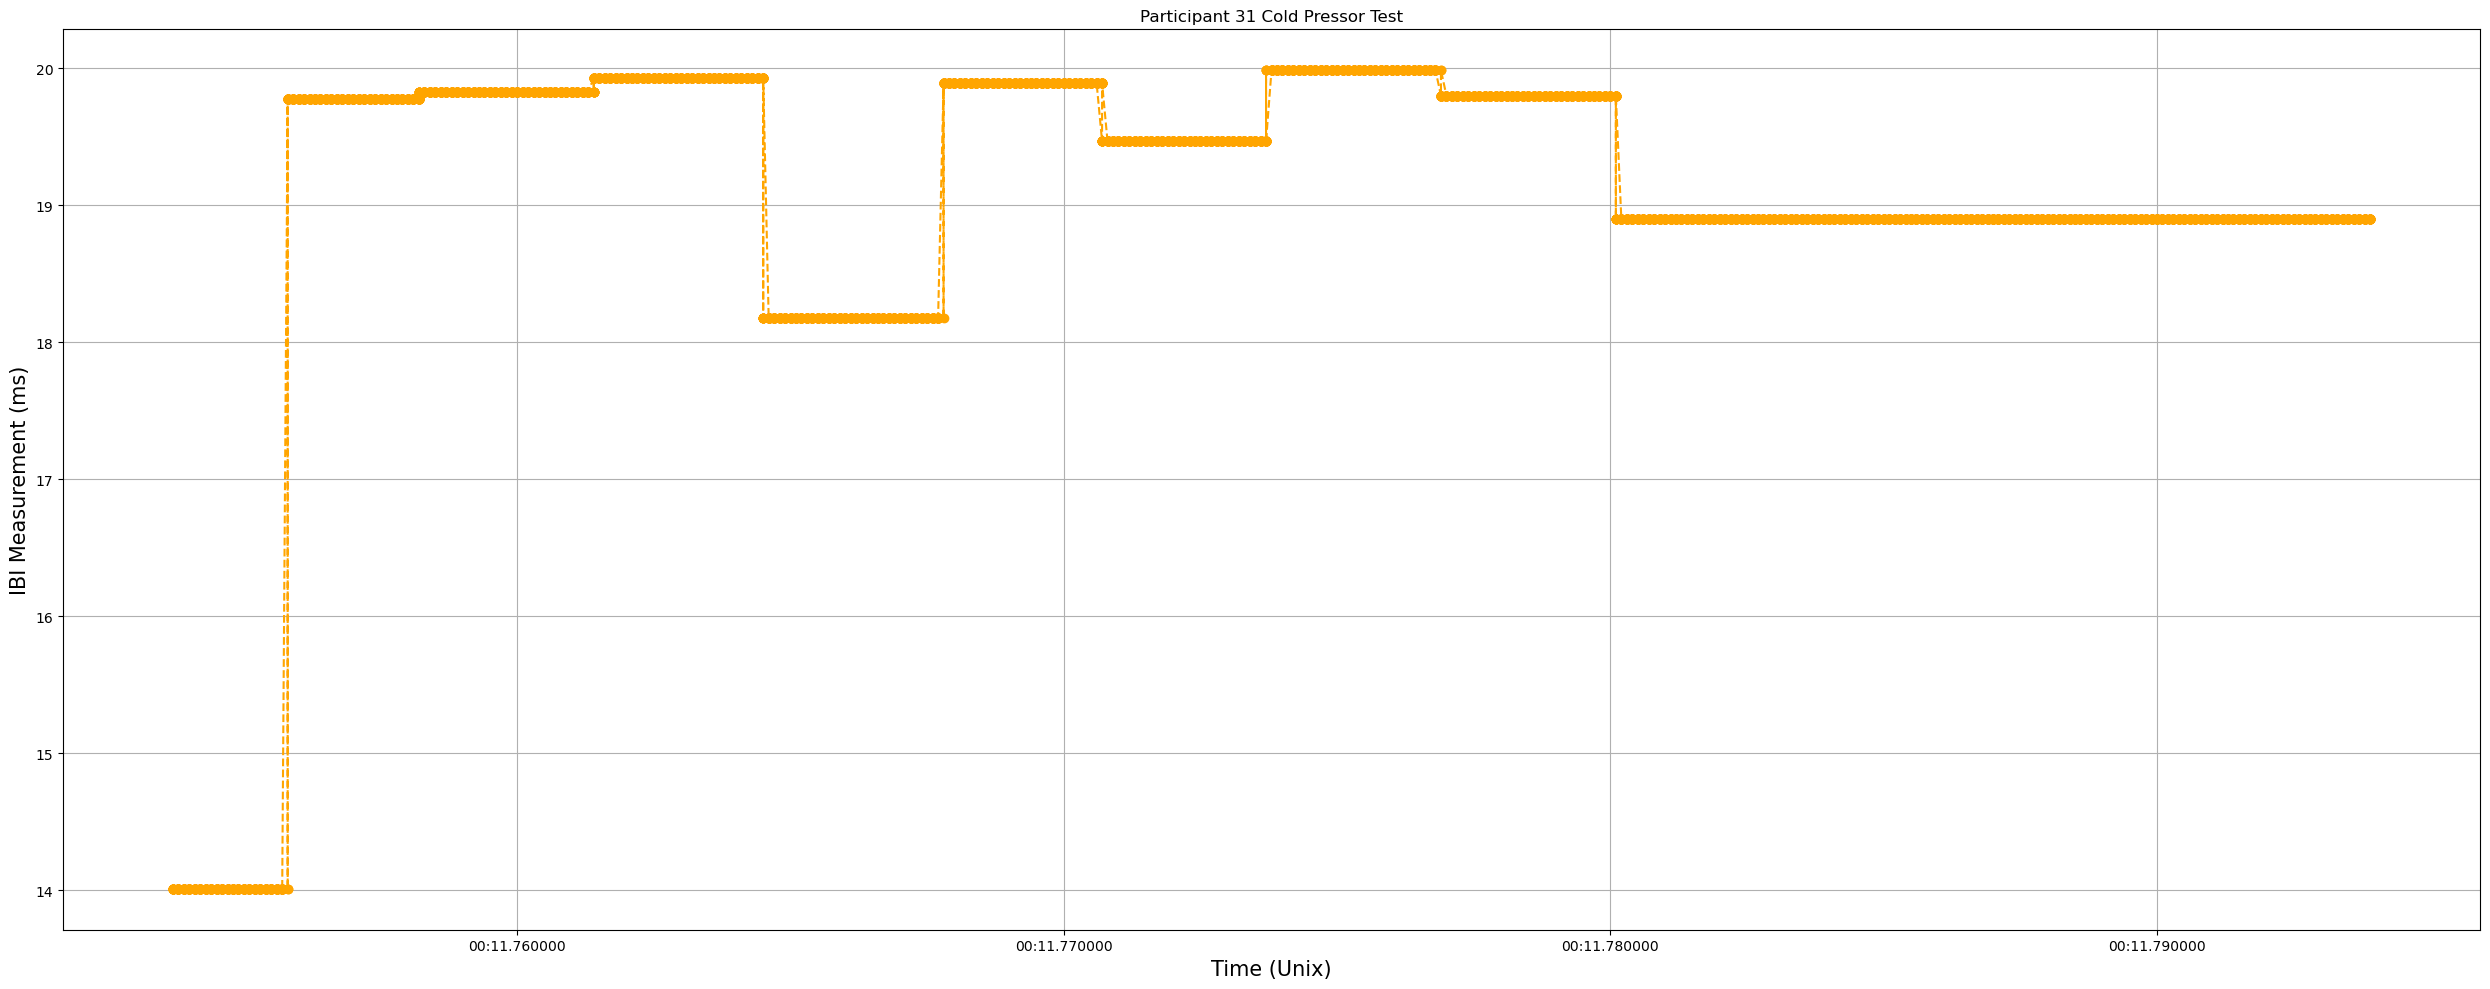

<Figure size 2500x1000 with 0 Axes>

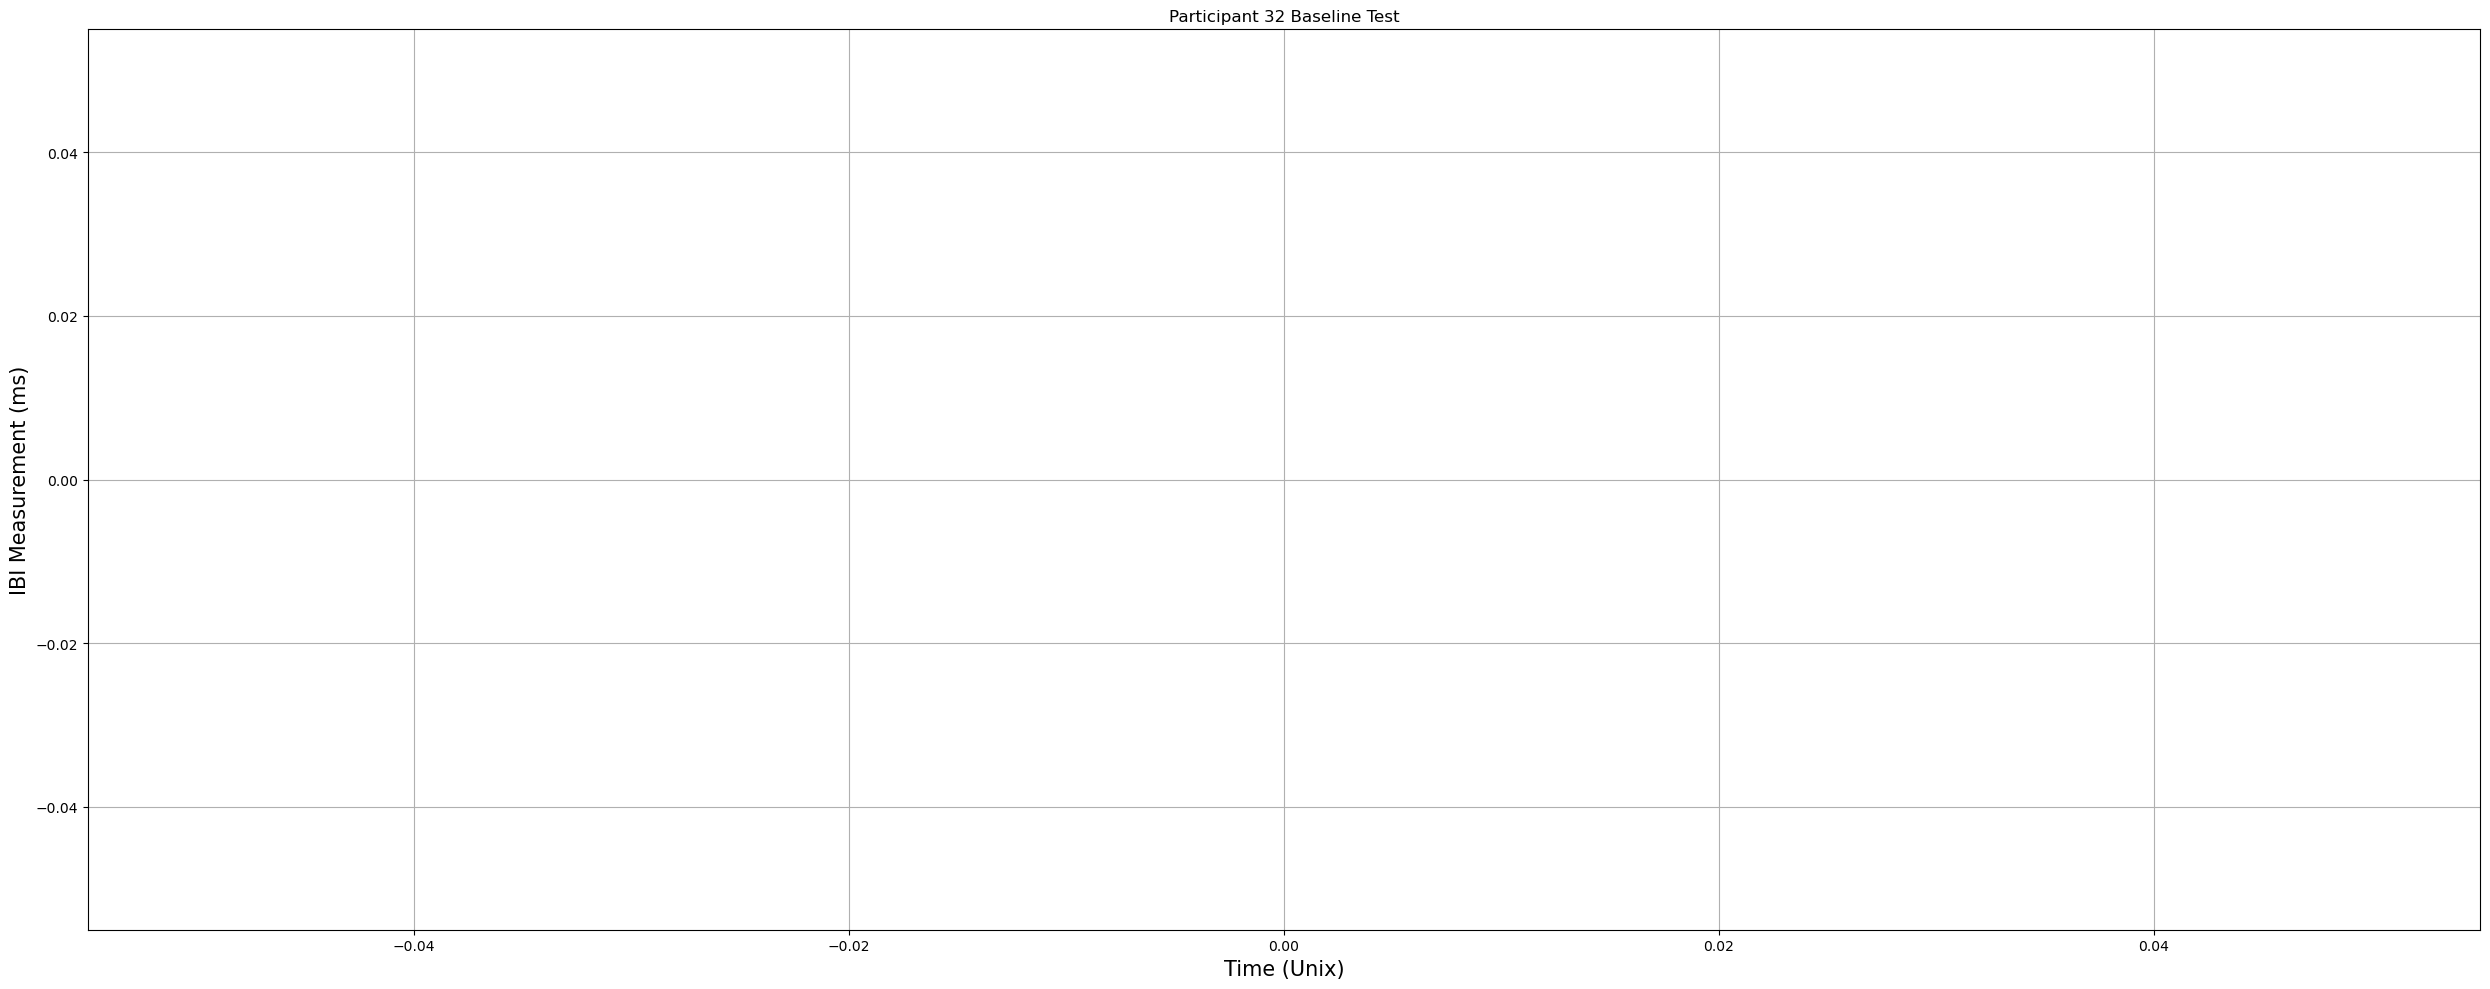

<Figure size 2500x1000 with 0 Axes>

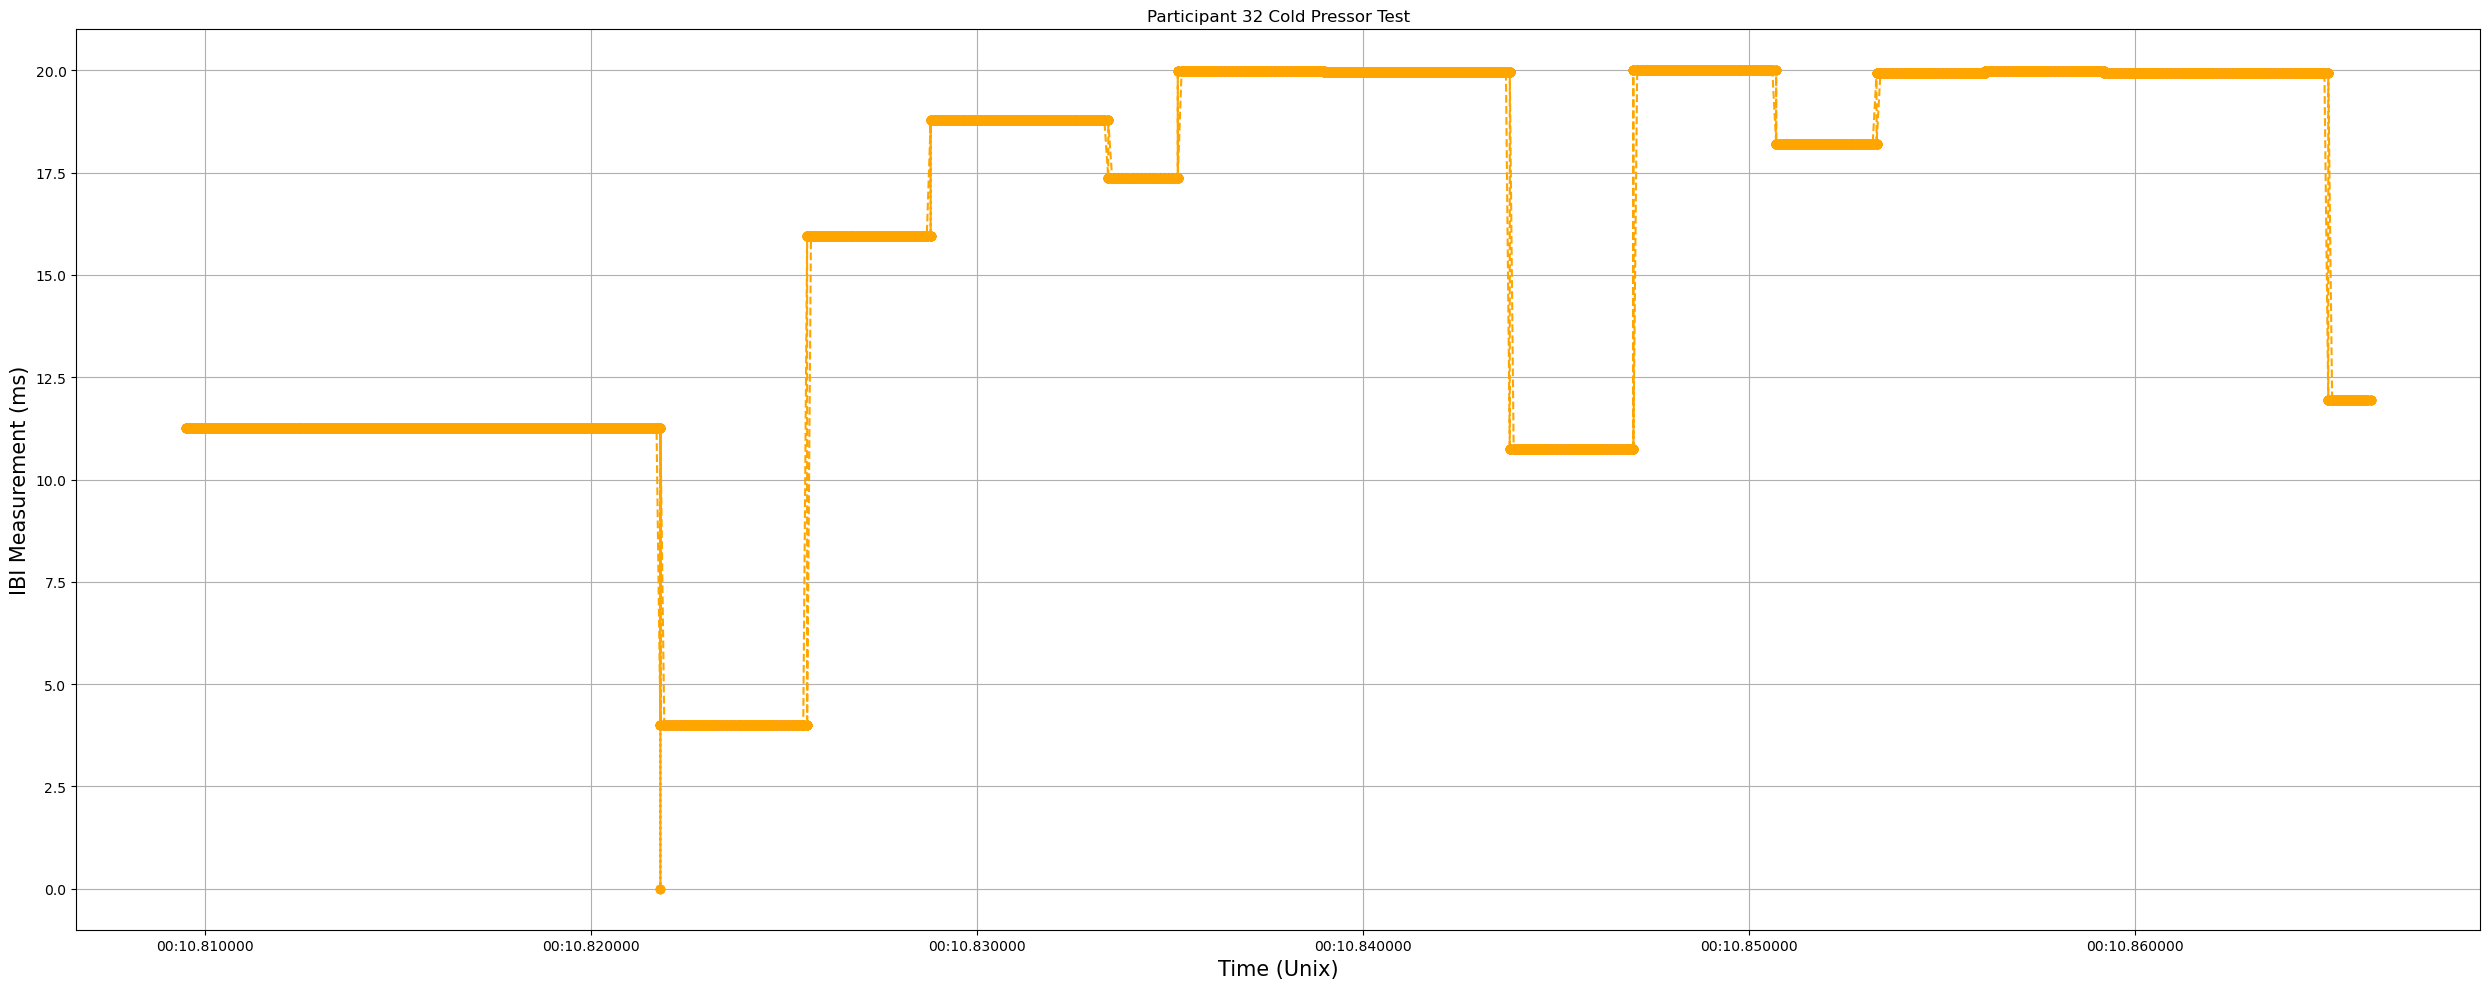

<Figure size 2500x1000 with 0 Axes>

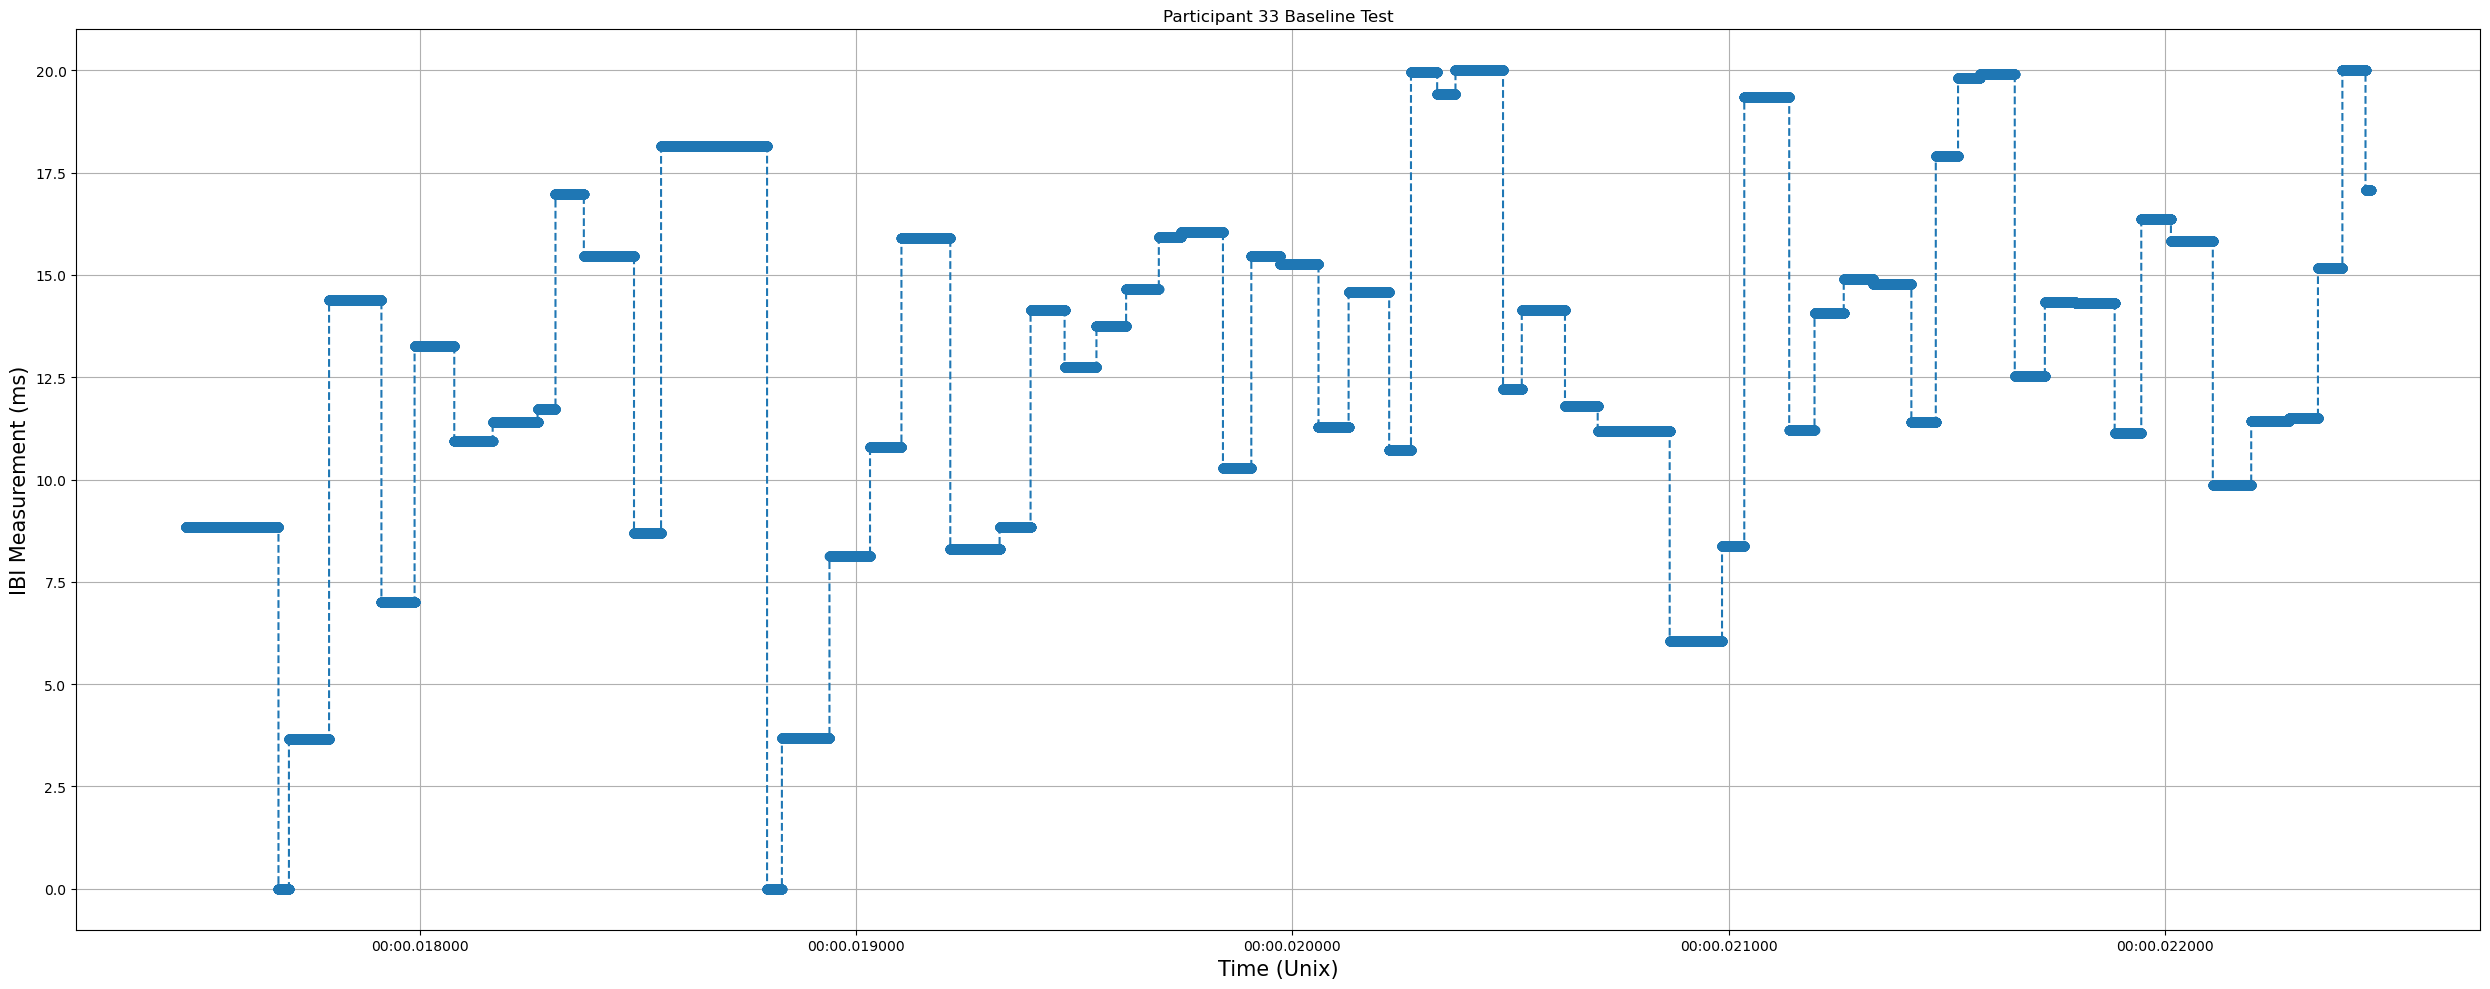

<Figure size 2500x1000 with 0 Axes>

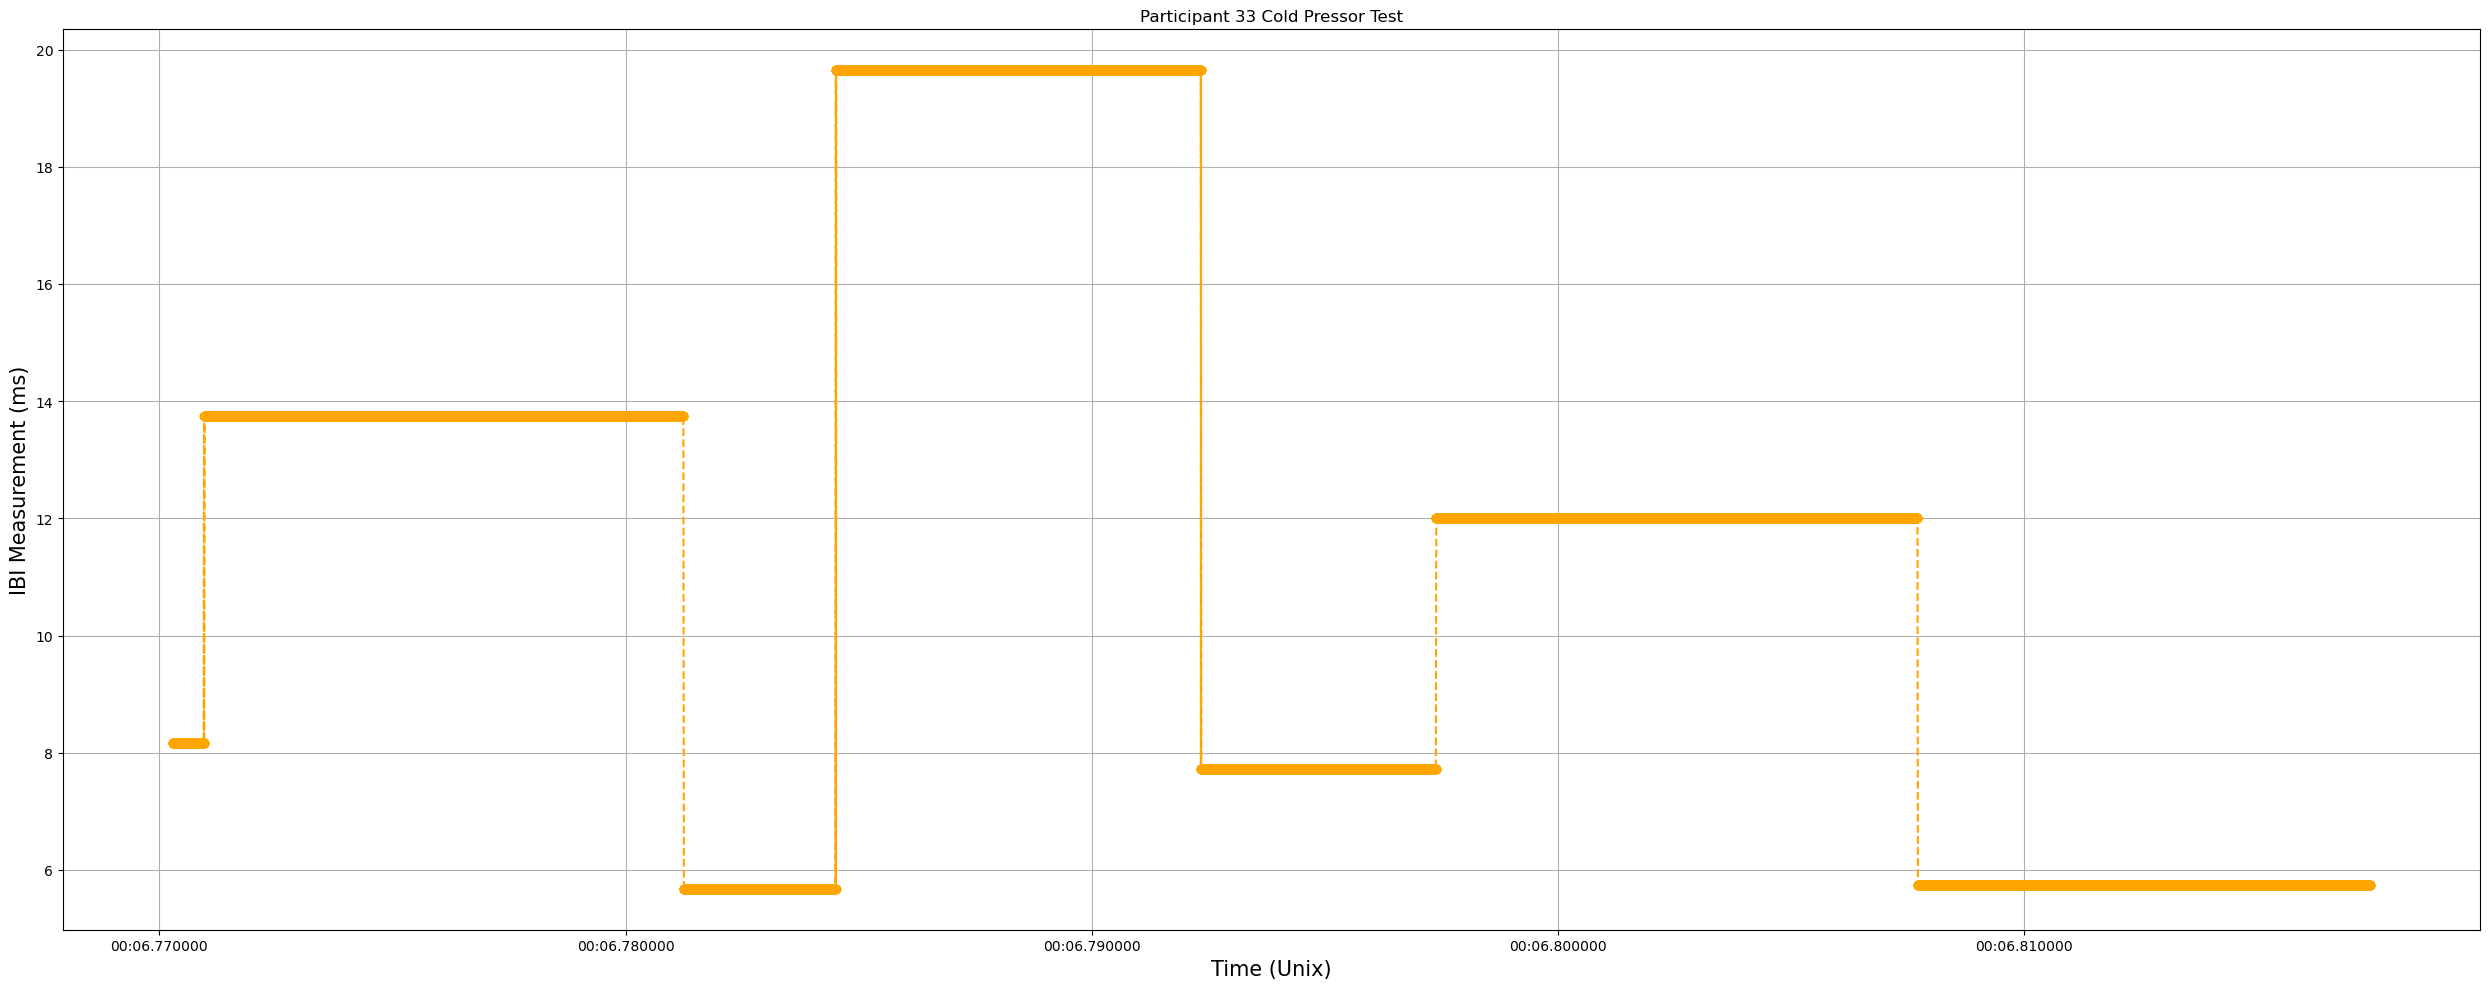

<Figure size 2500x1000 with 0 Axes>

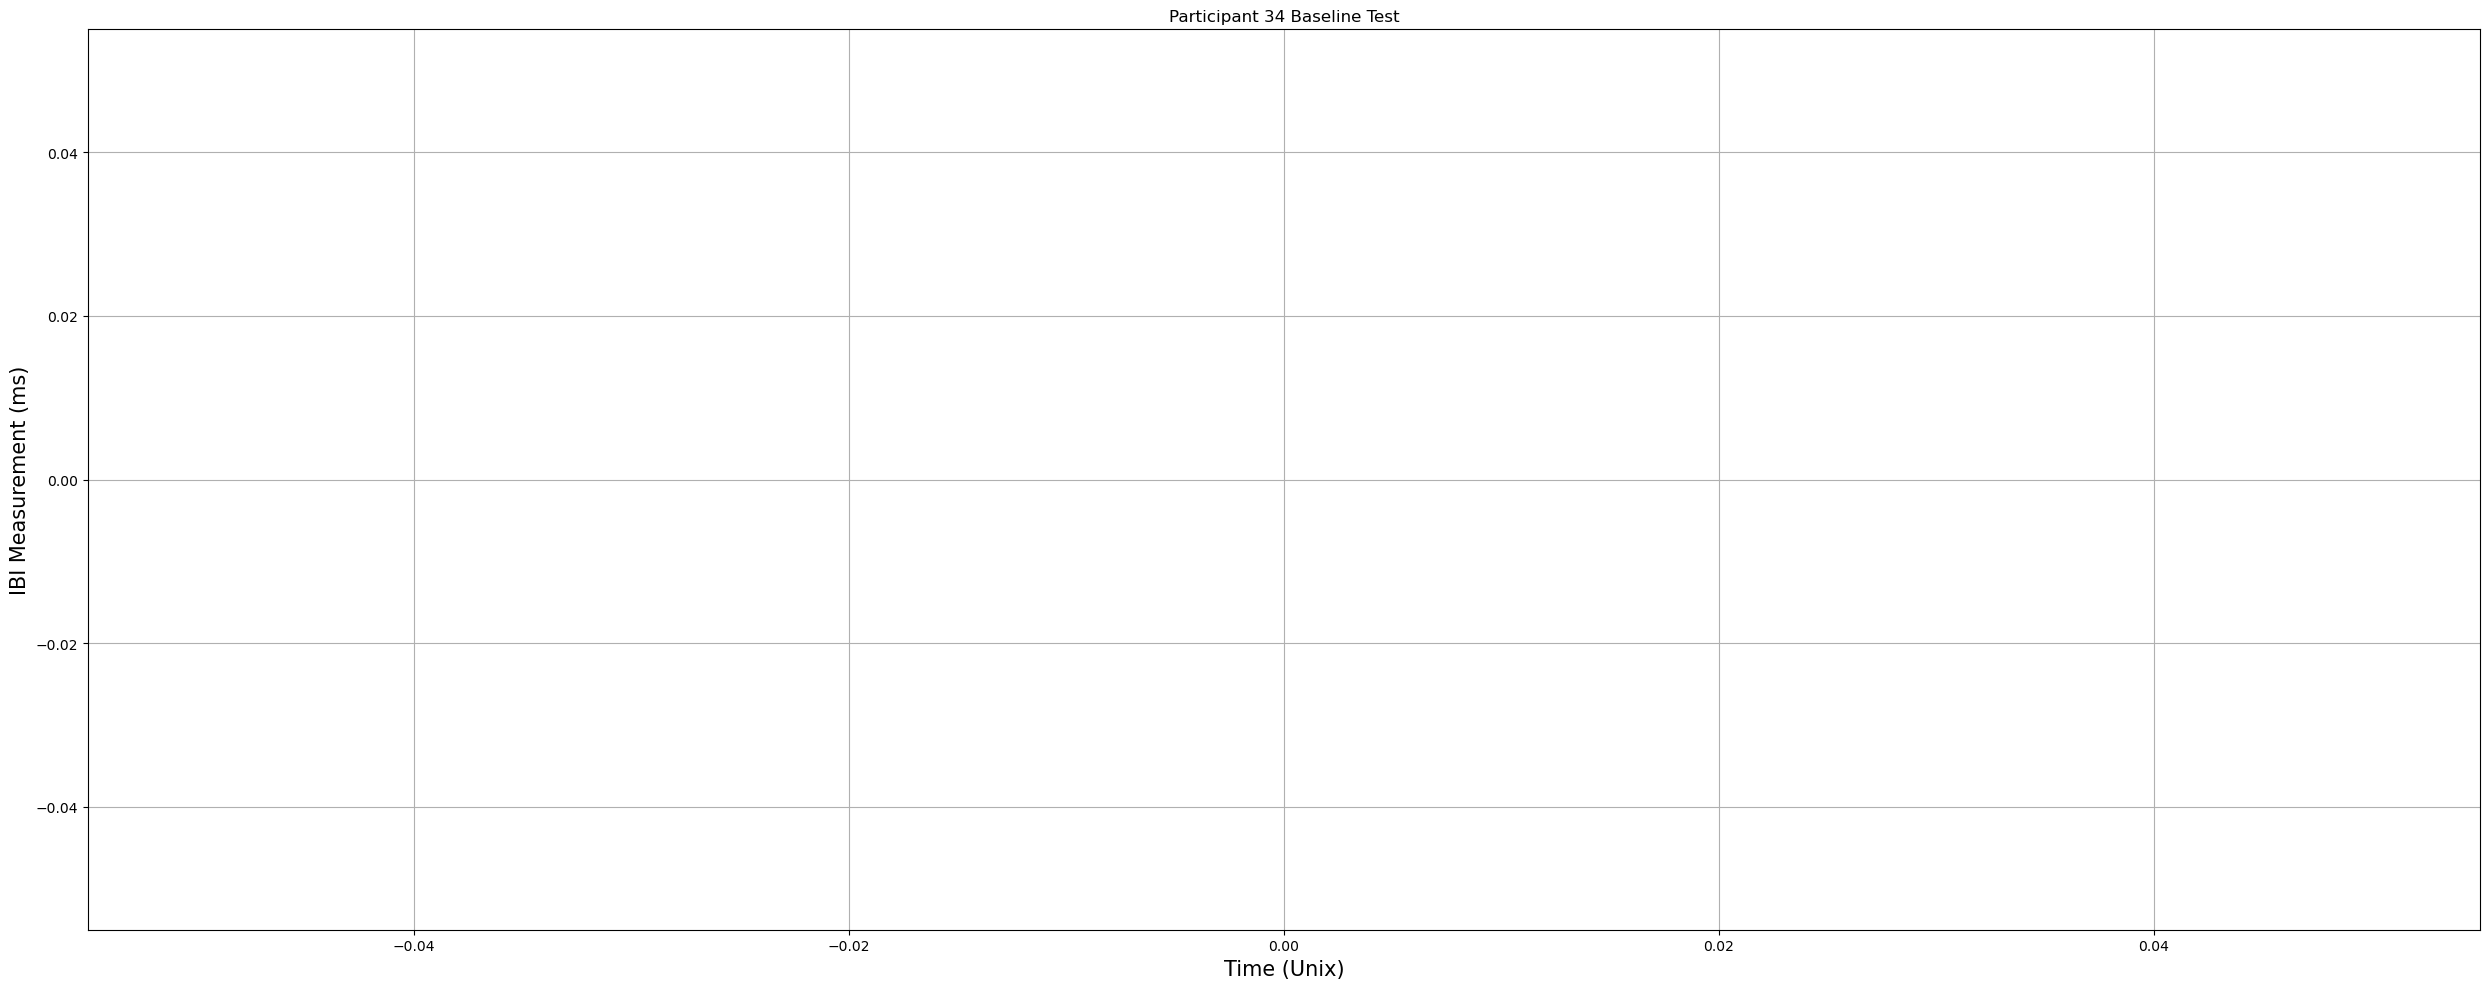

<Figure size 2500x1000 with 0 Axes>

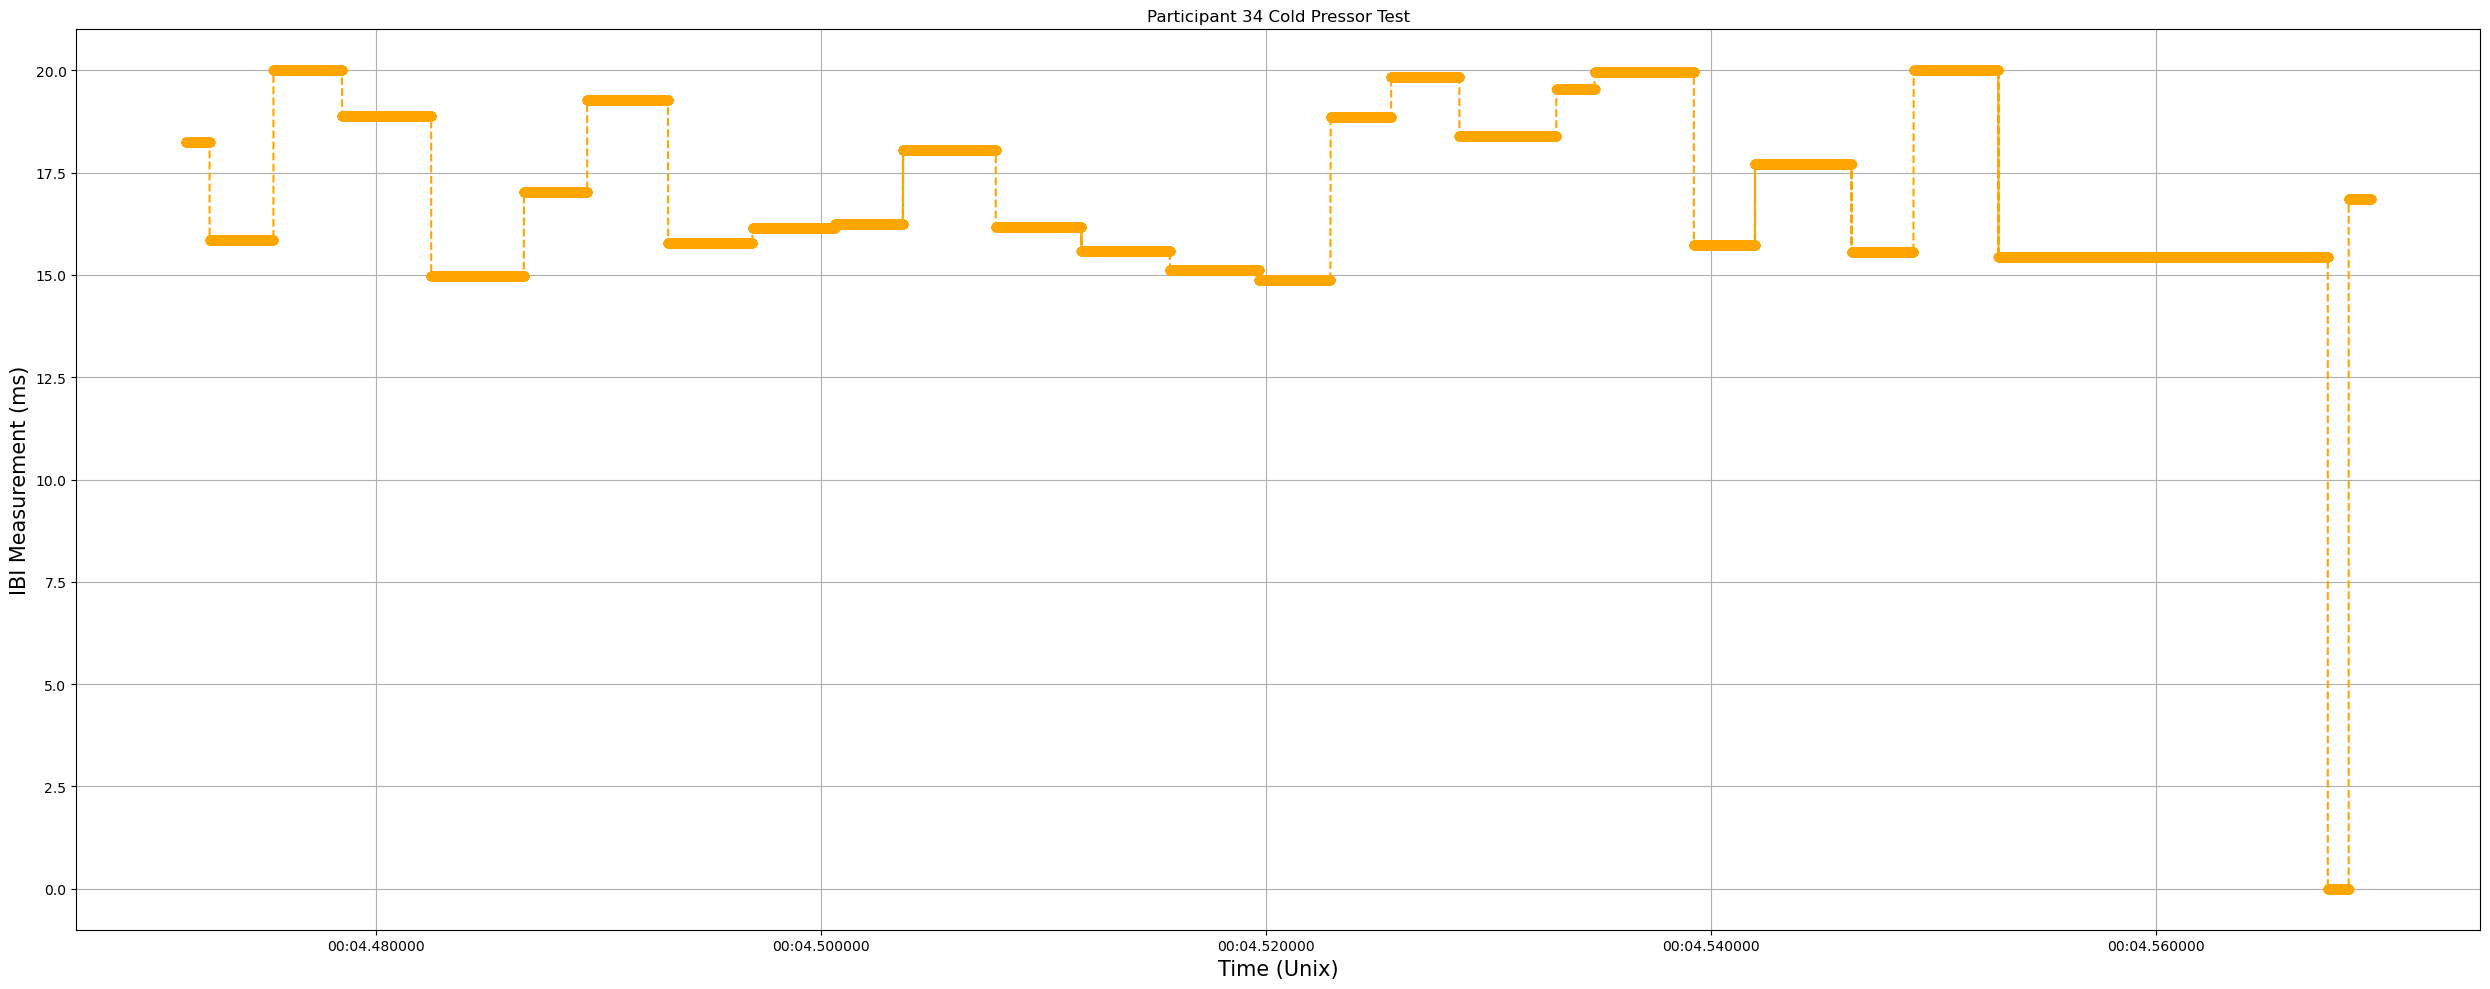

<Figure size 2500x1000 with 0 Axes>

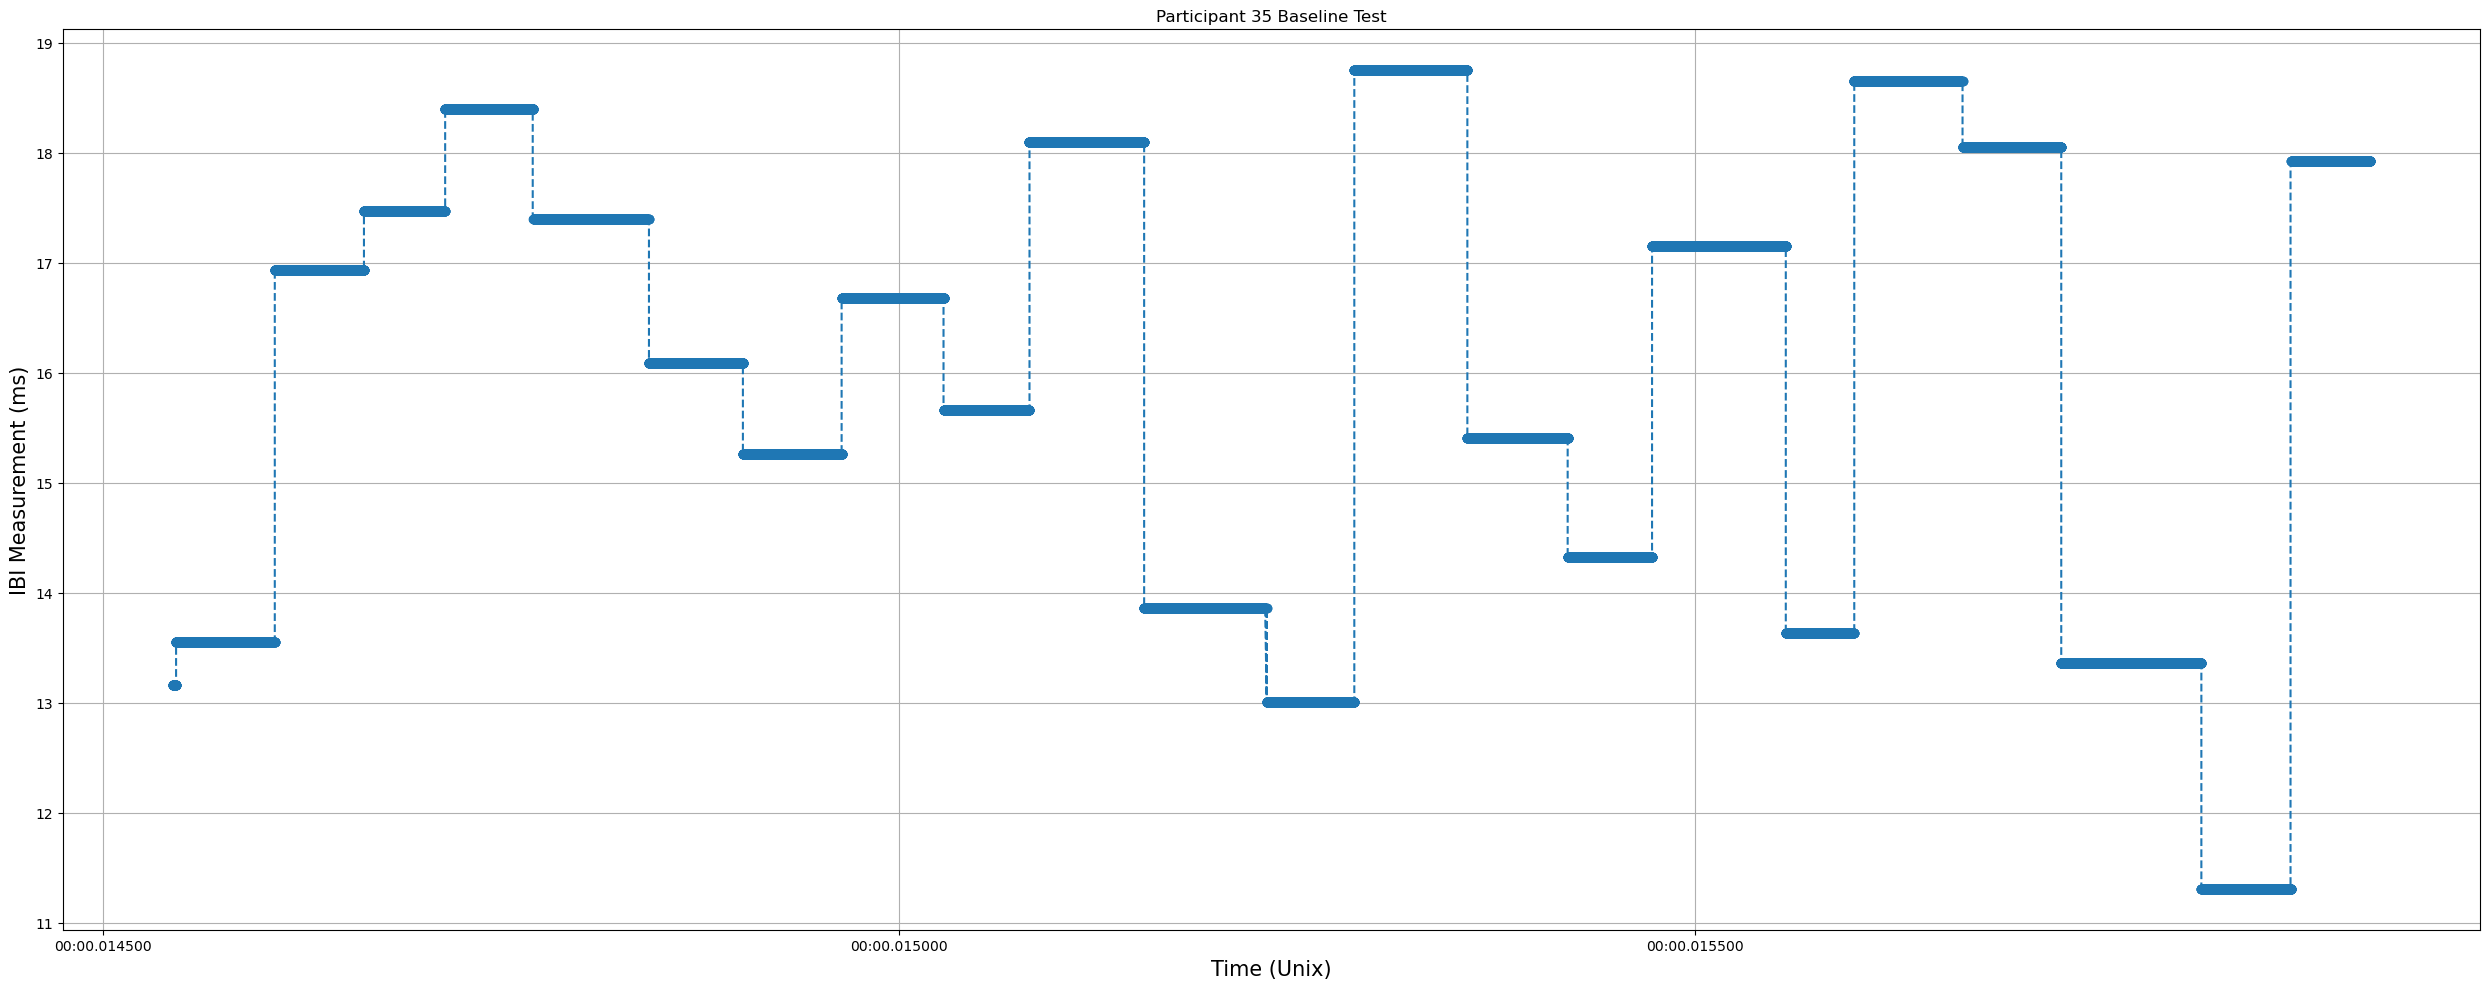

<Figure size 2500x1000 with 0 Axes>

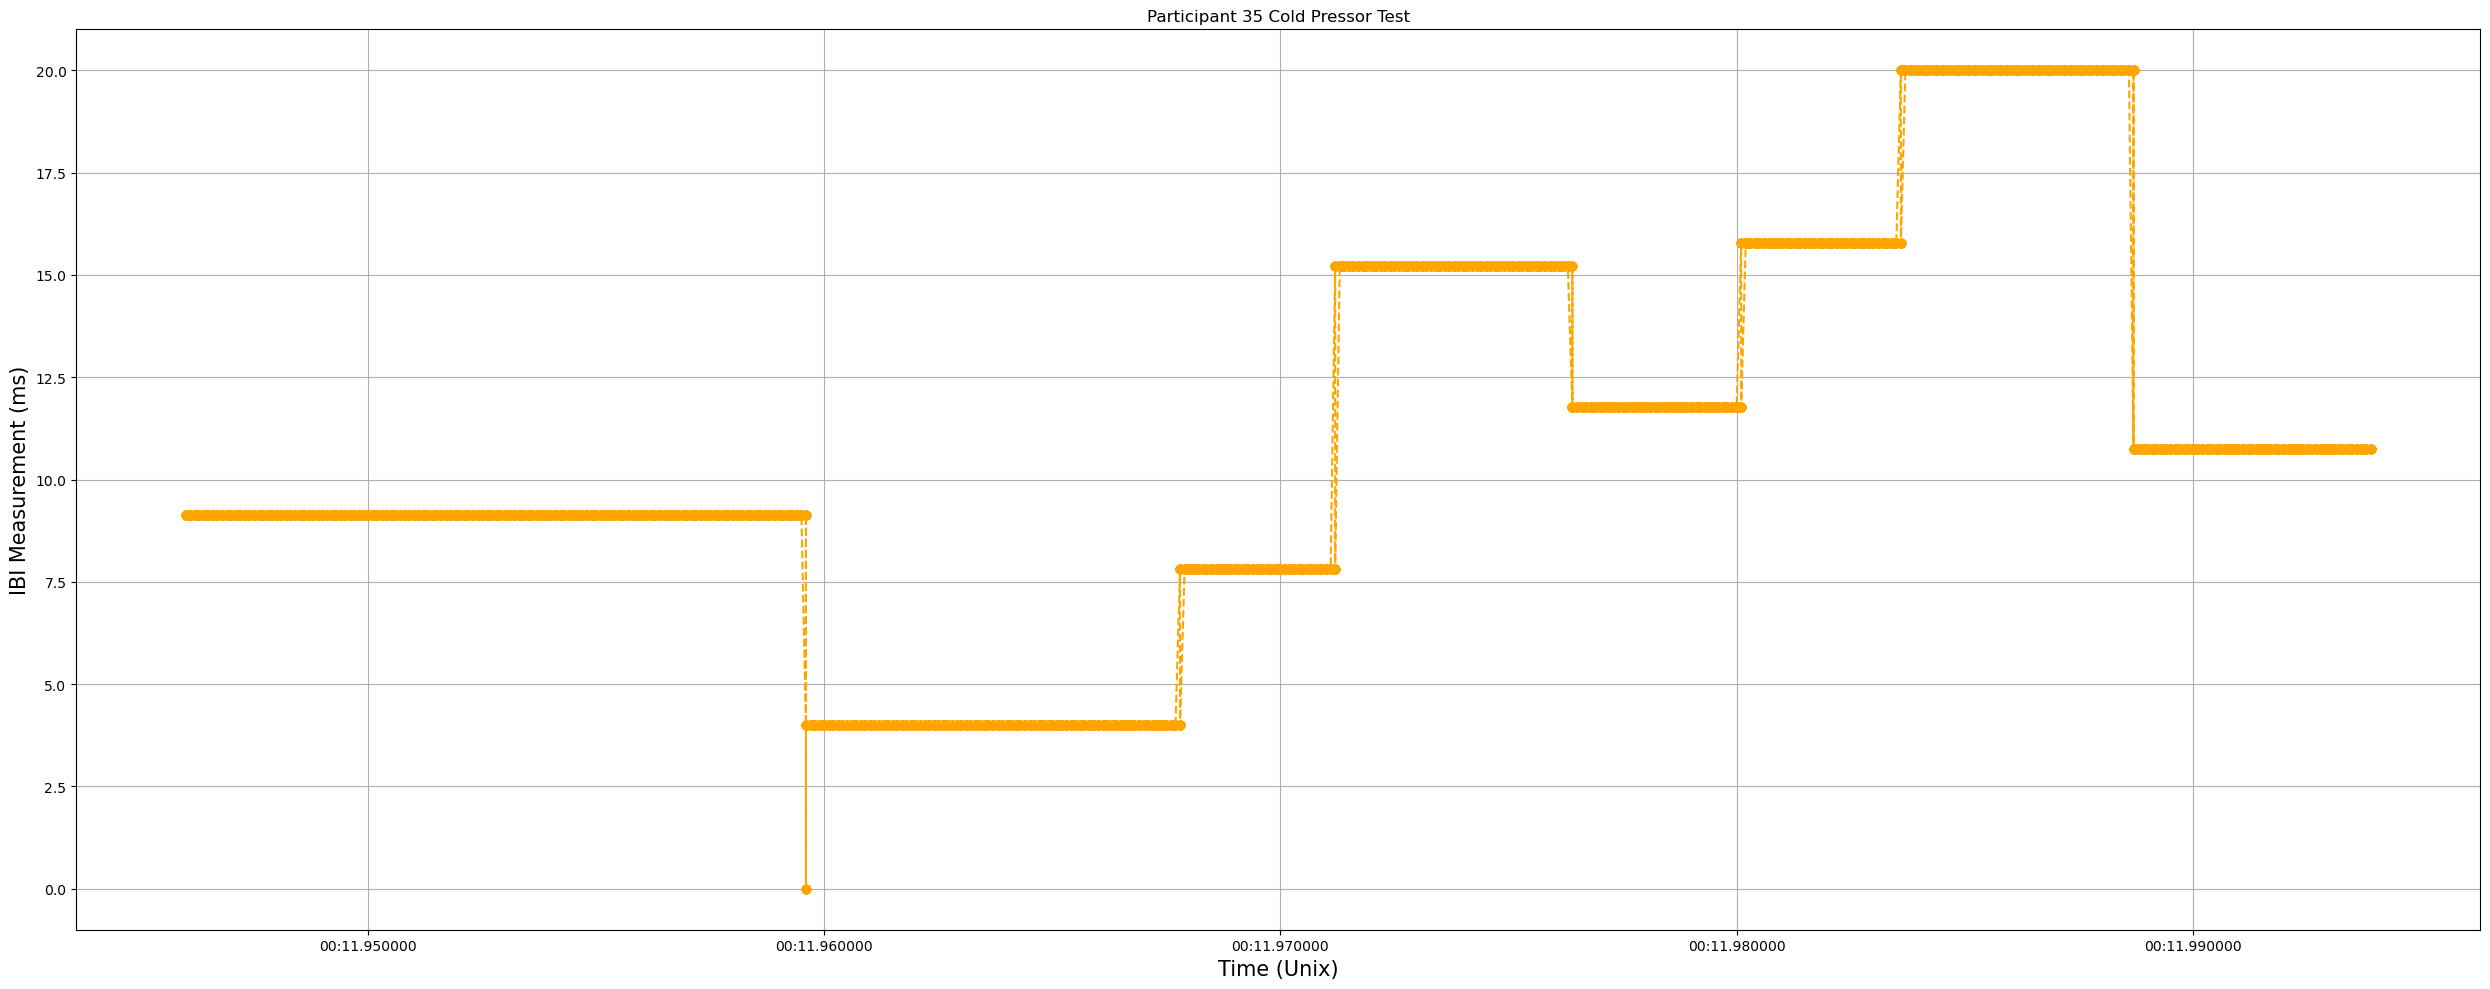

<Figure size 2500x1000 with 0 Axes>

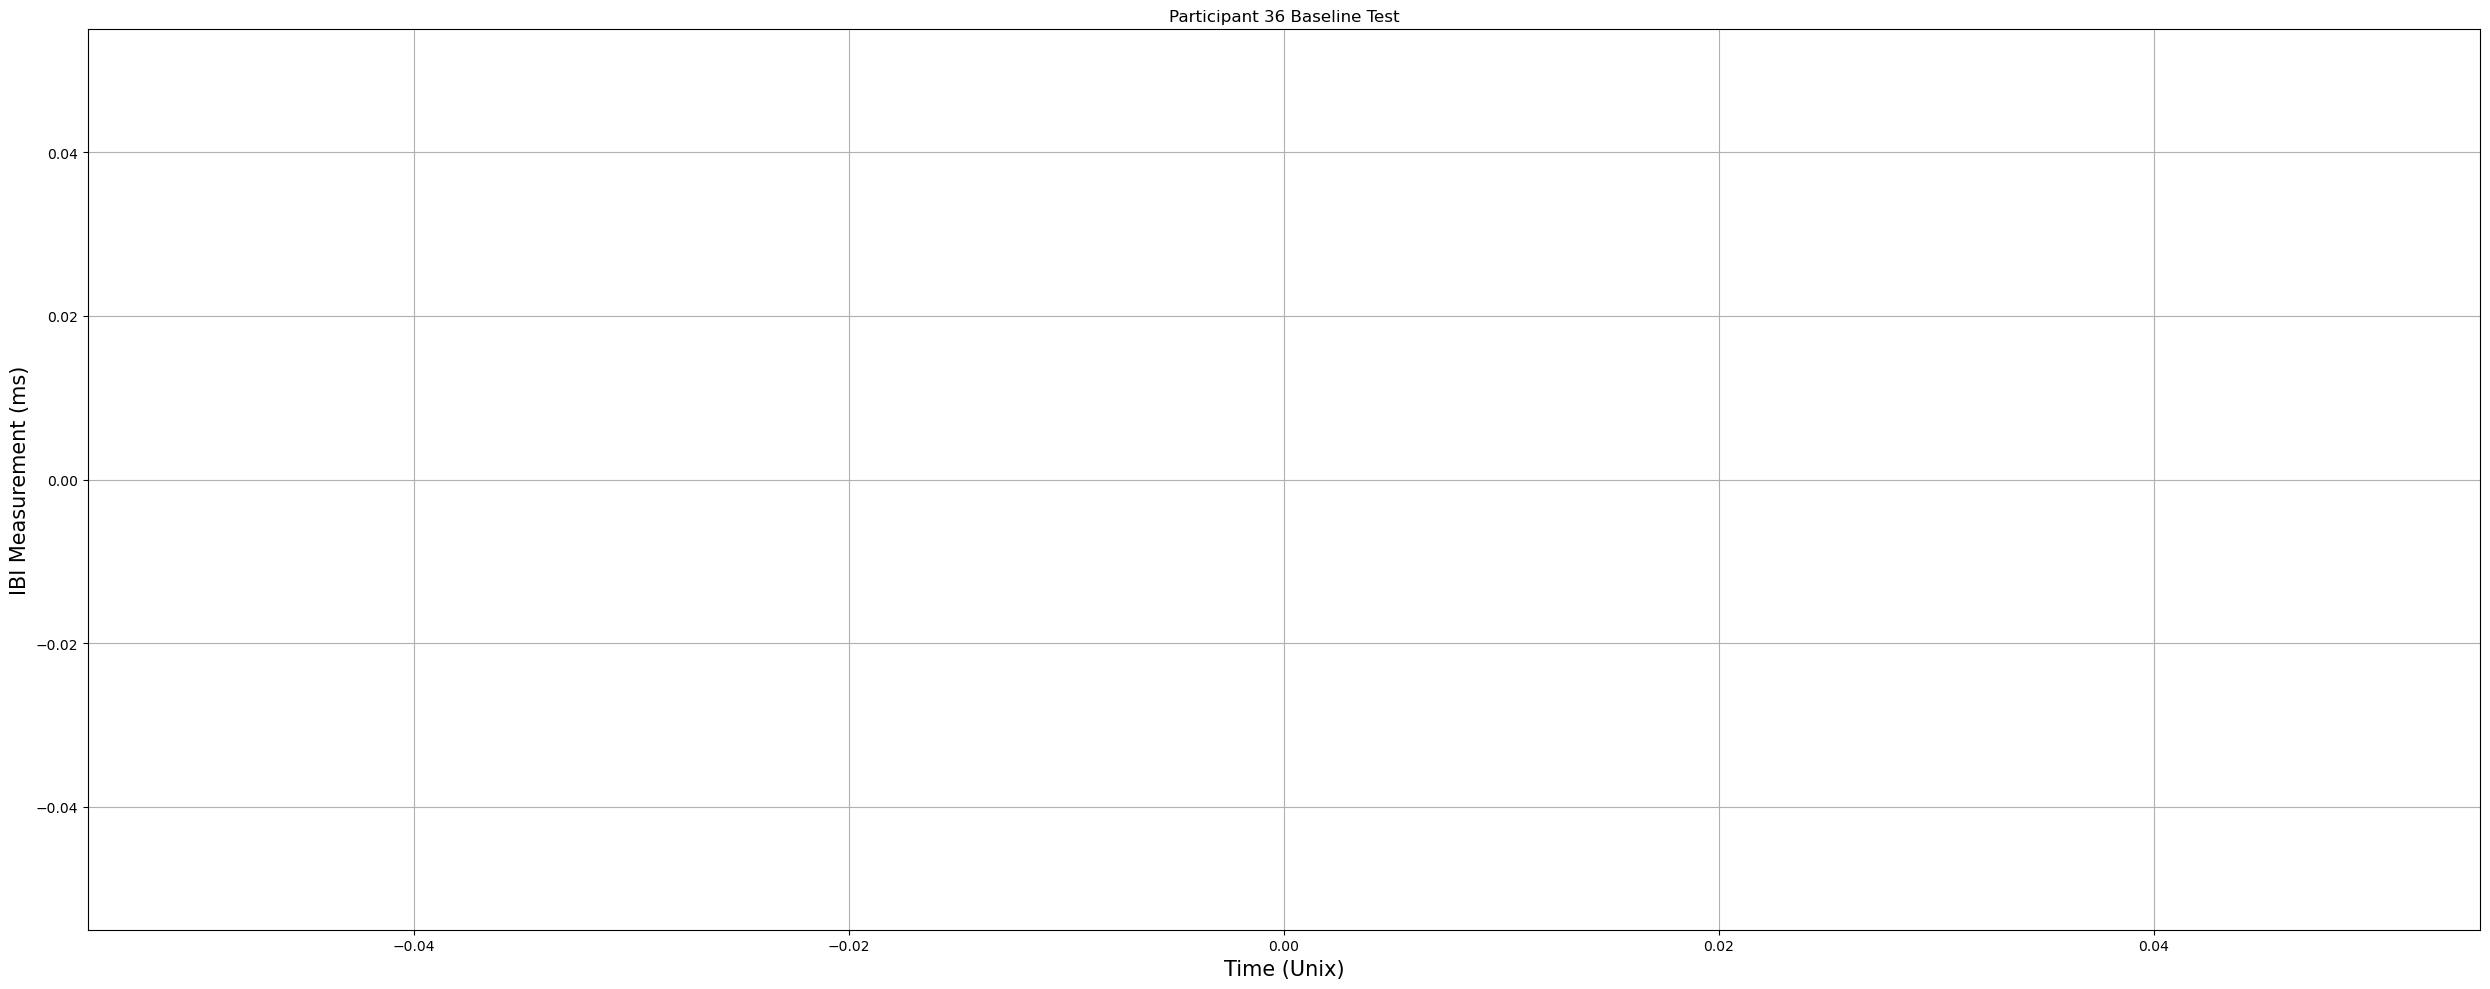

<Figure size 2500x1000 with 0 Axes>

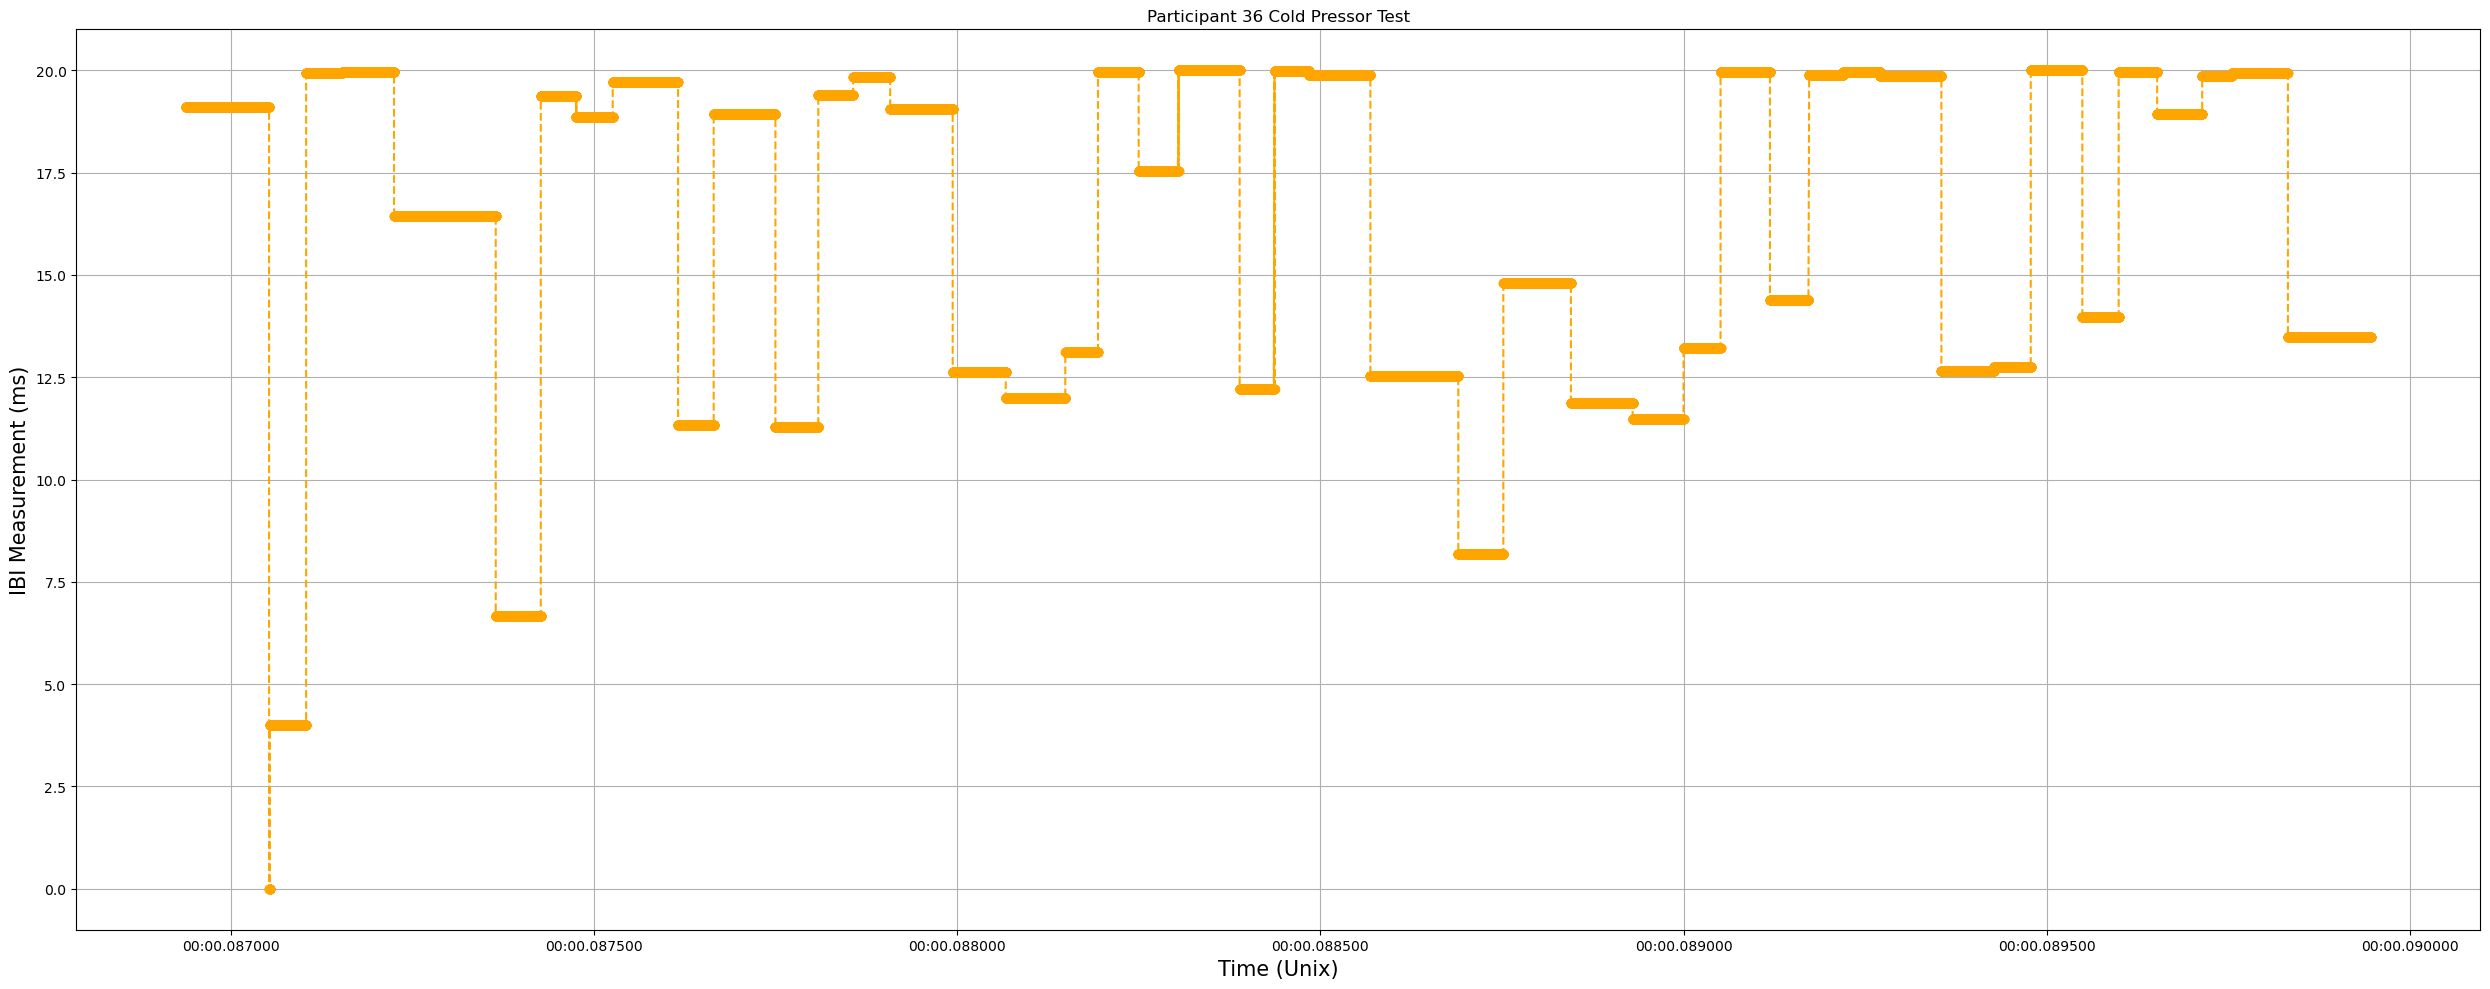

<Figure size 2500x1000 with 0 Axes>

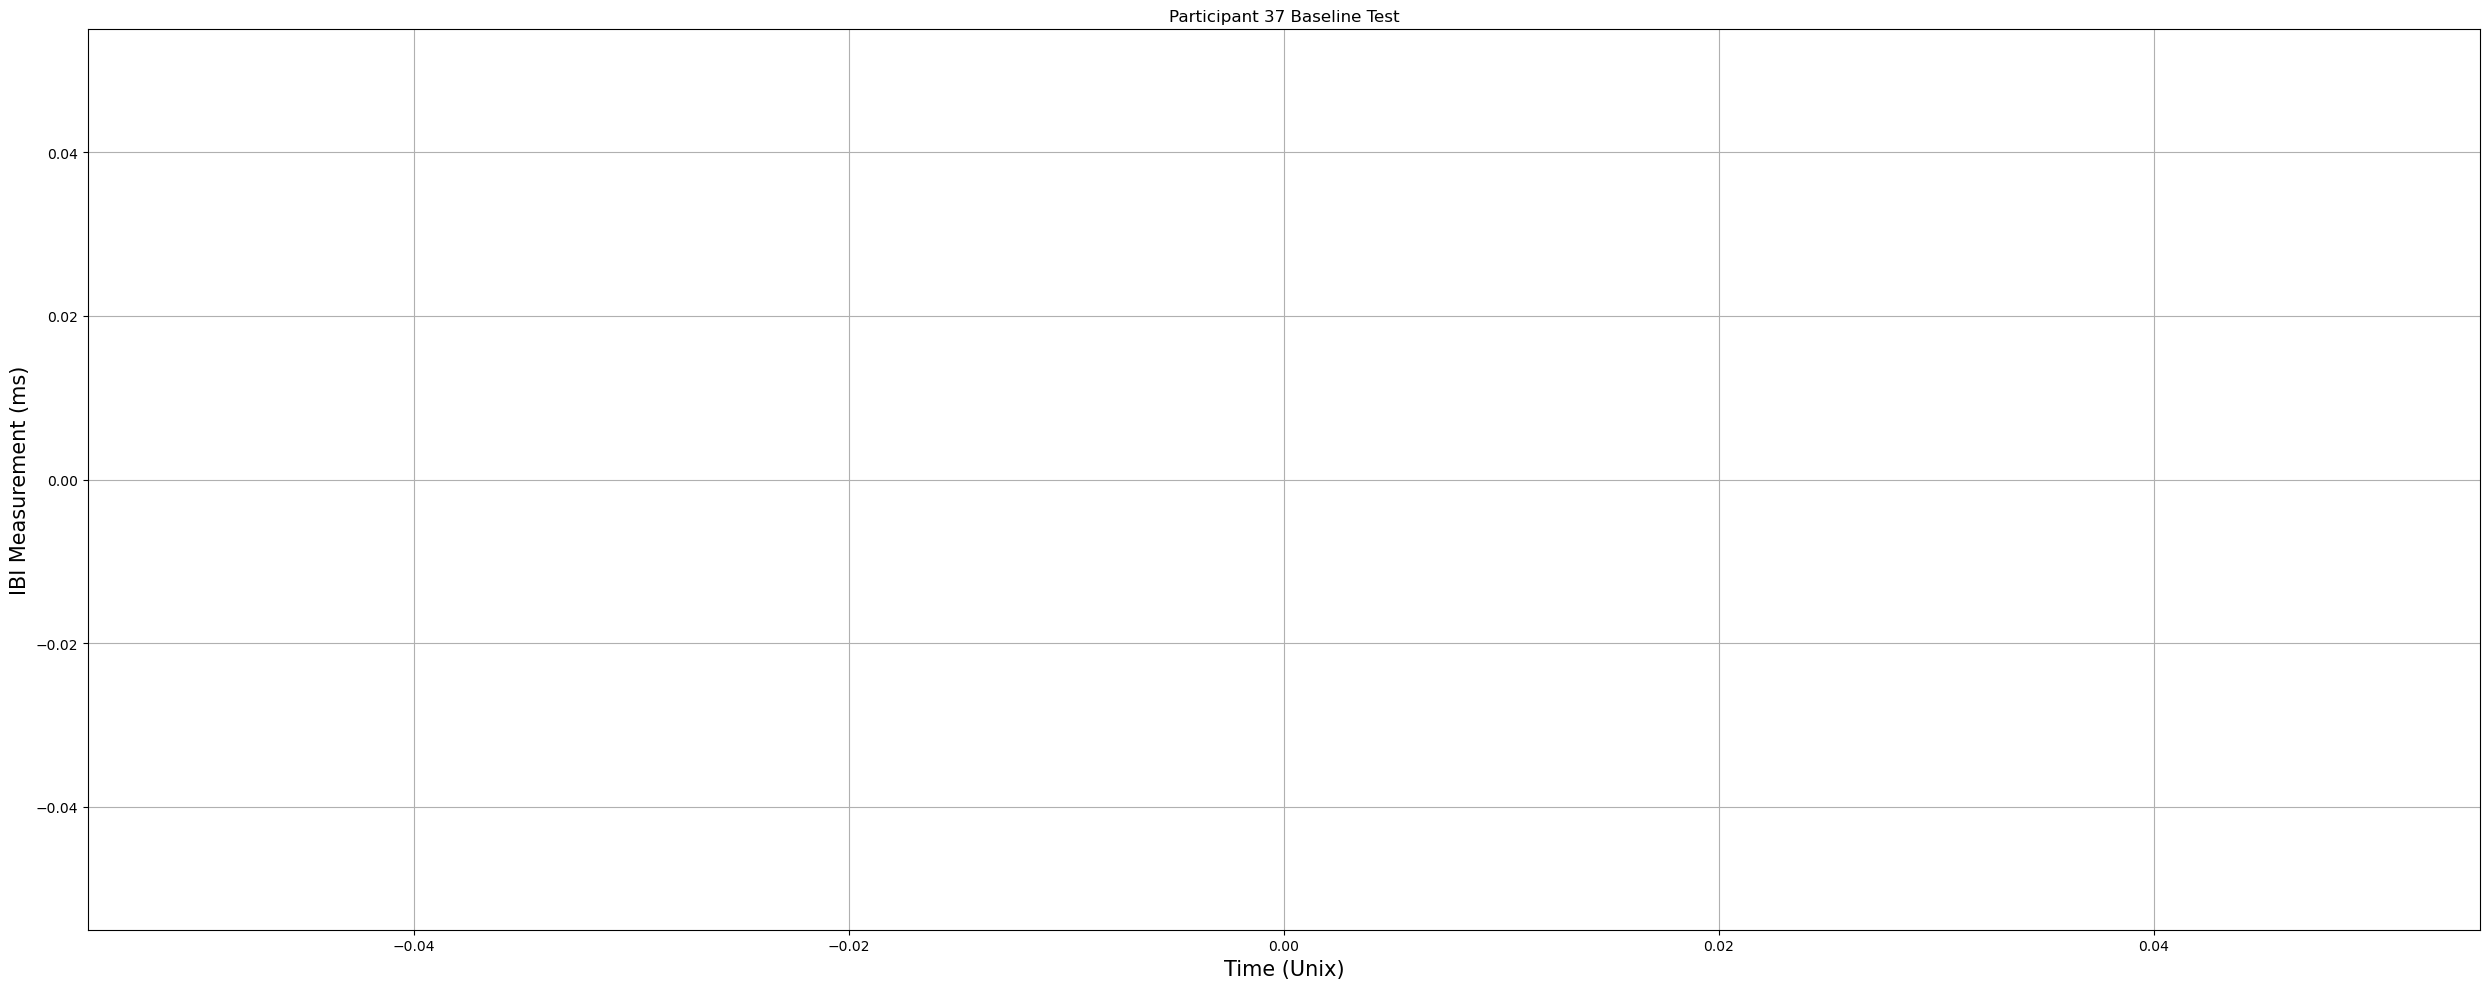

<Figure size 2500x1000 with 0 Axes>

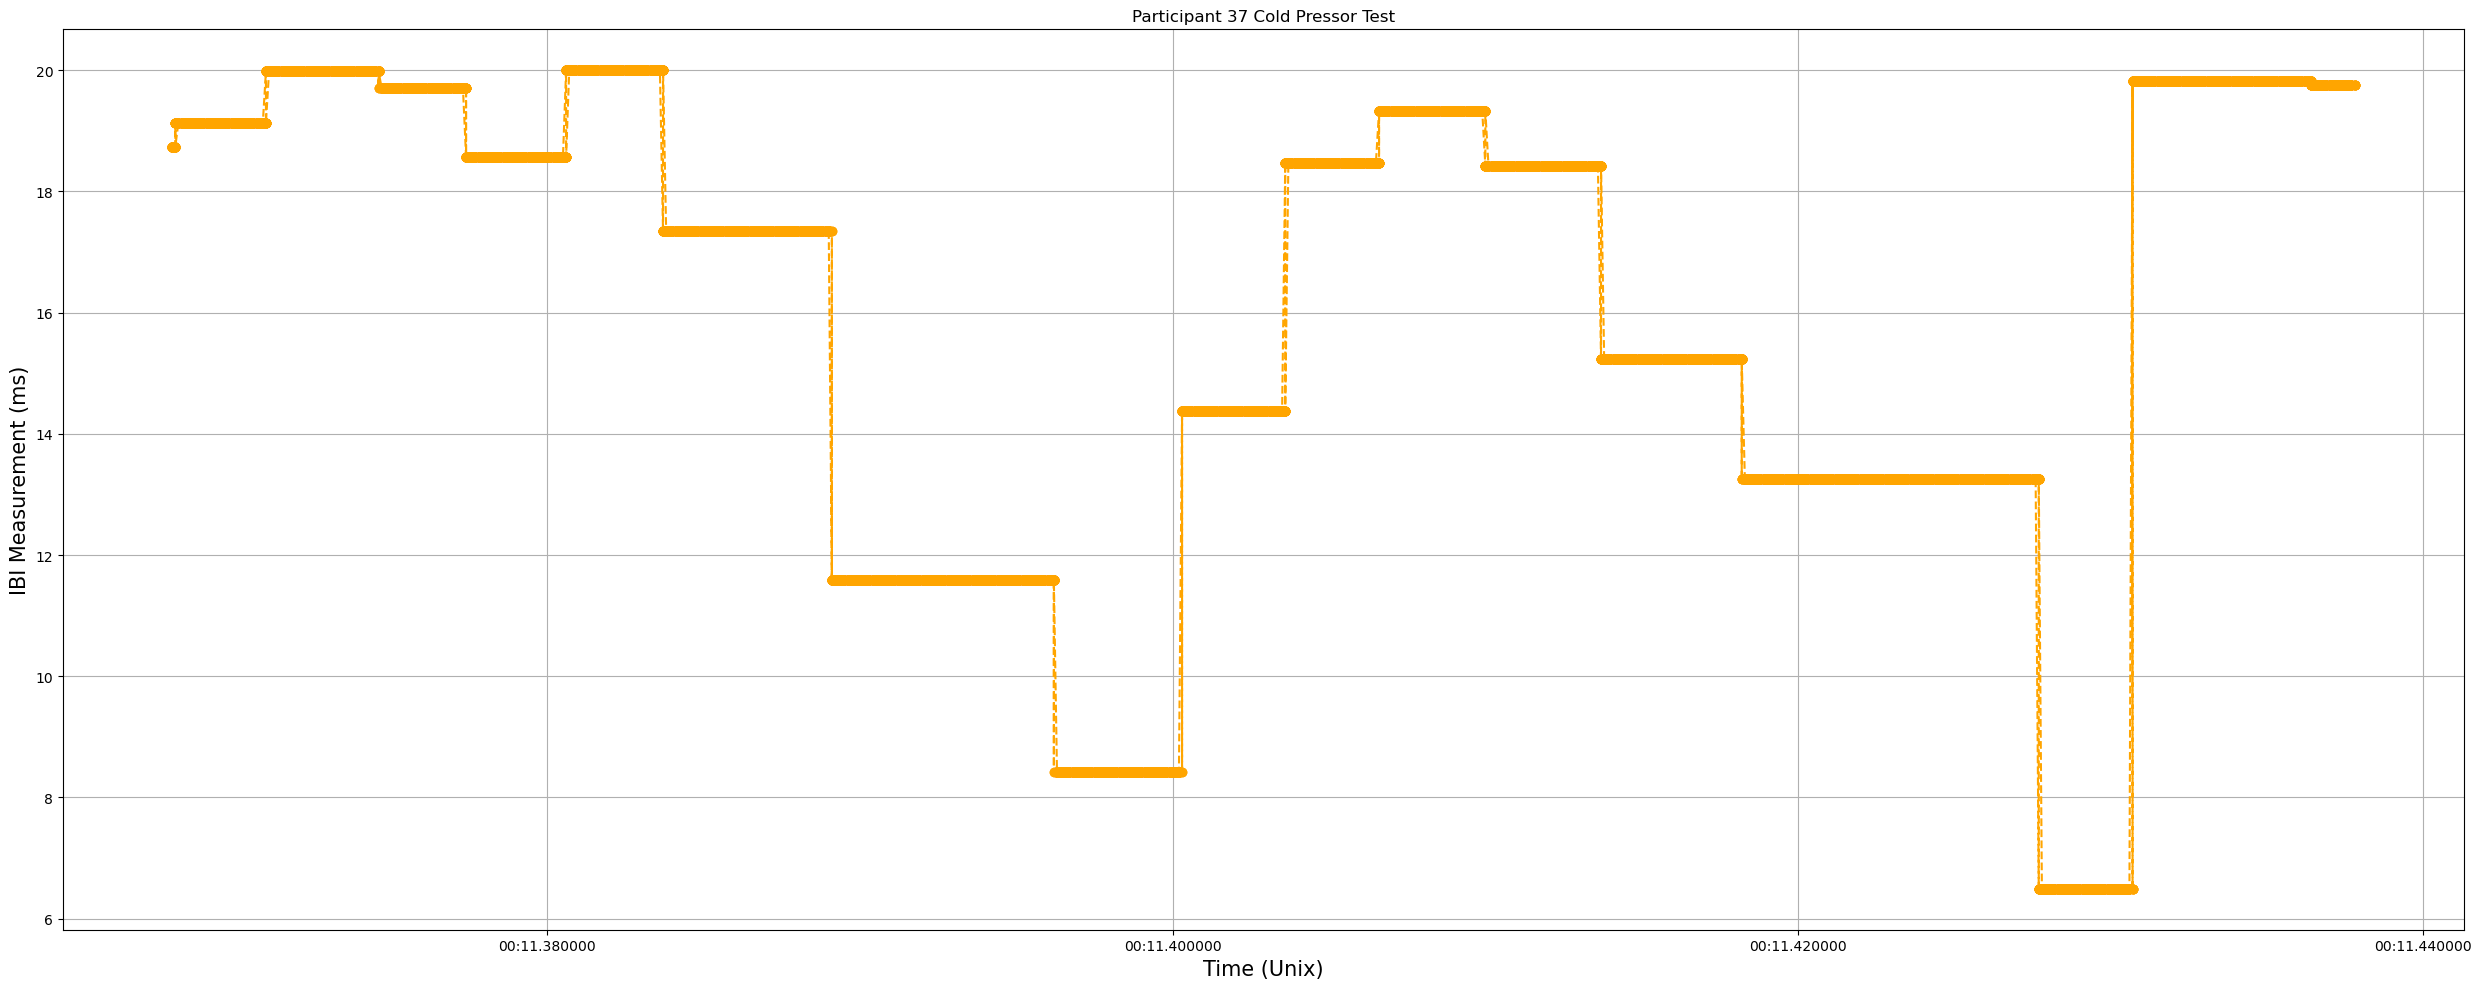

<Figure size 2500x1000 with 0 Axes>

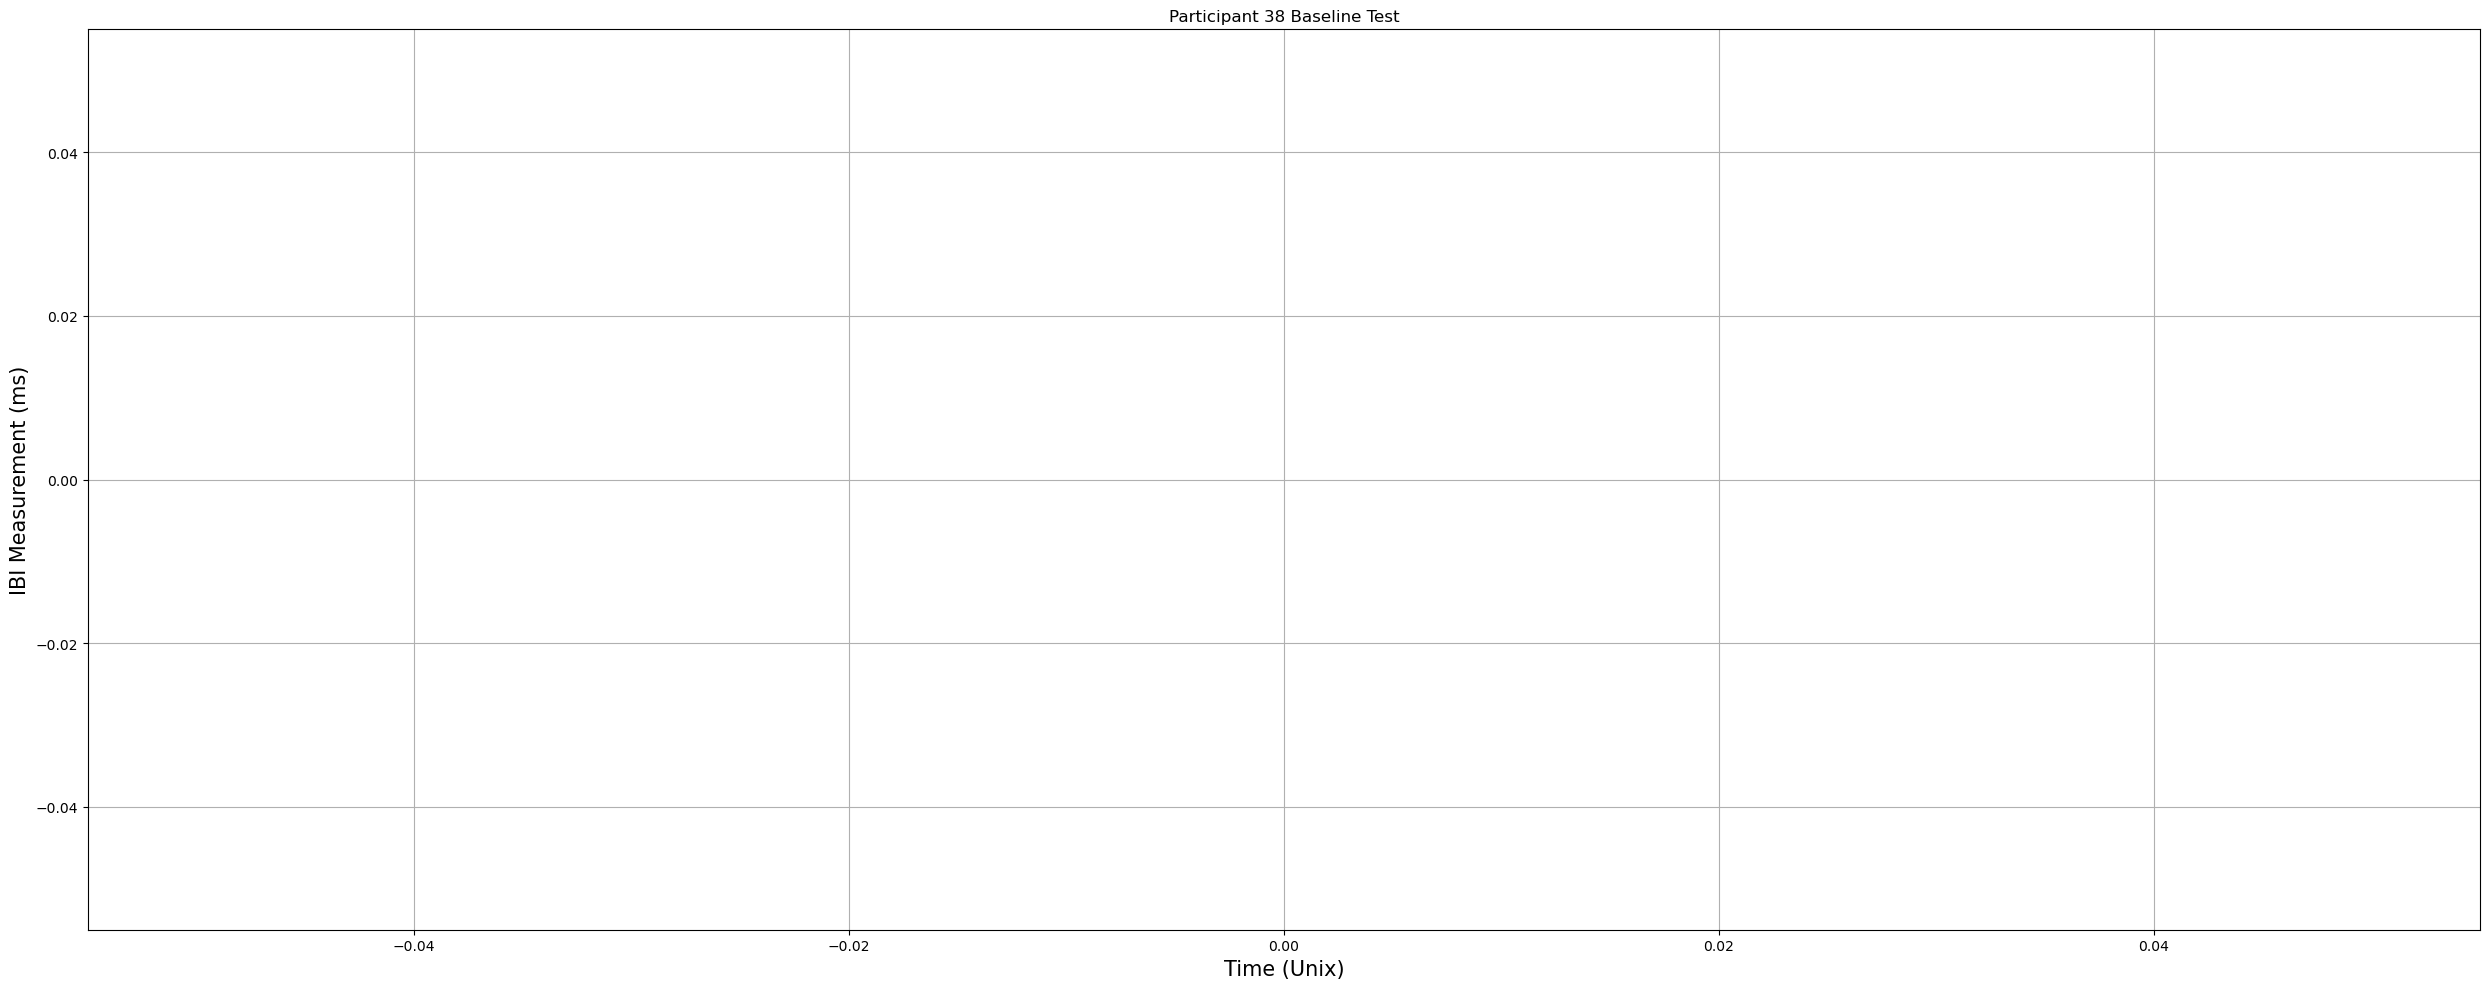

<Figure size 2500x1000 with 0 Axes>

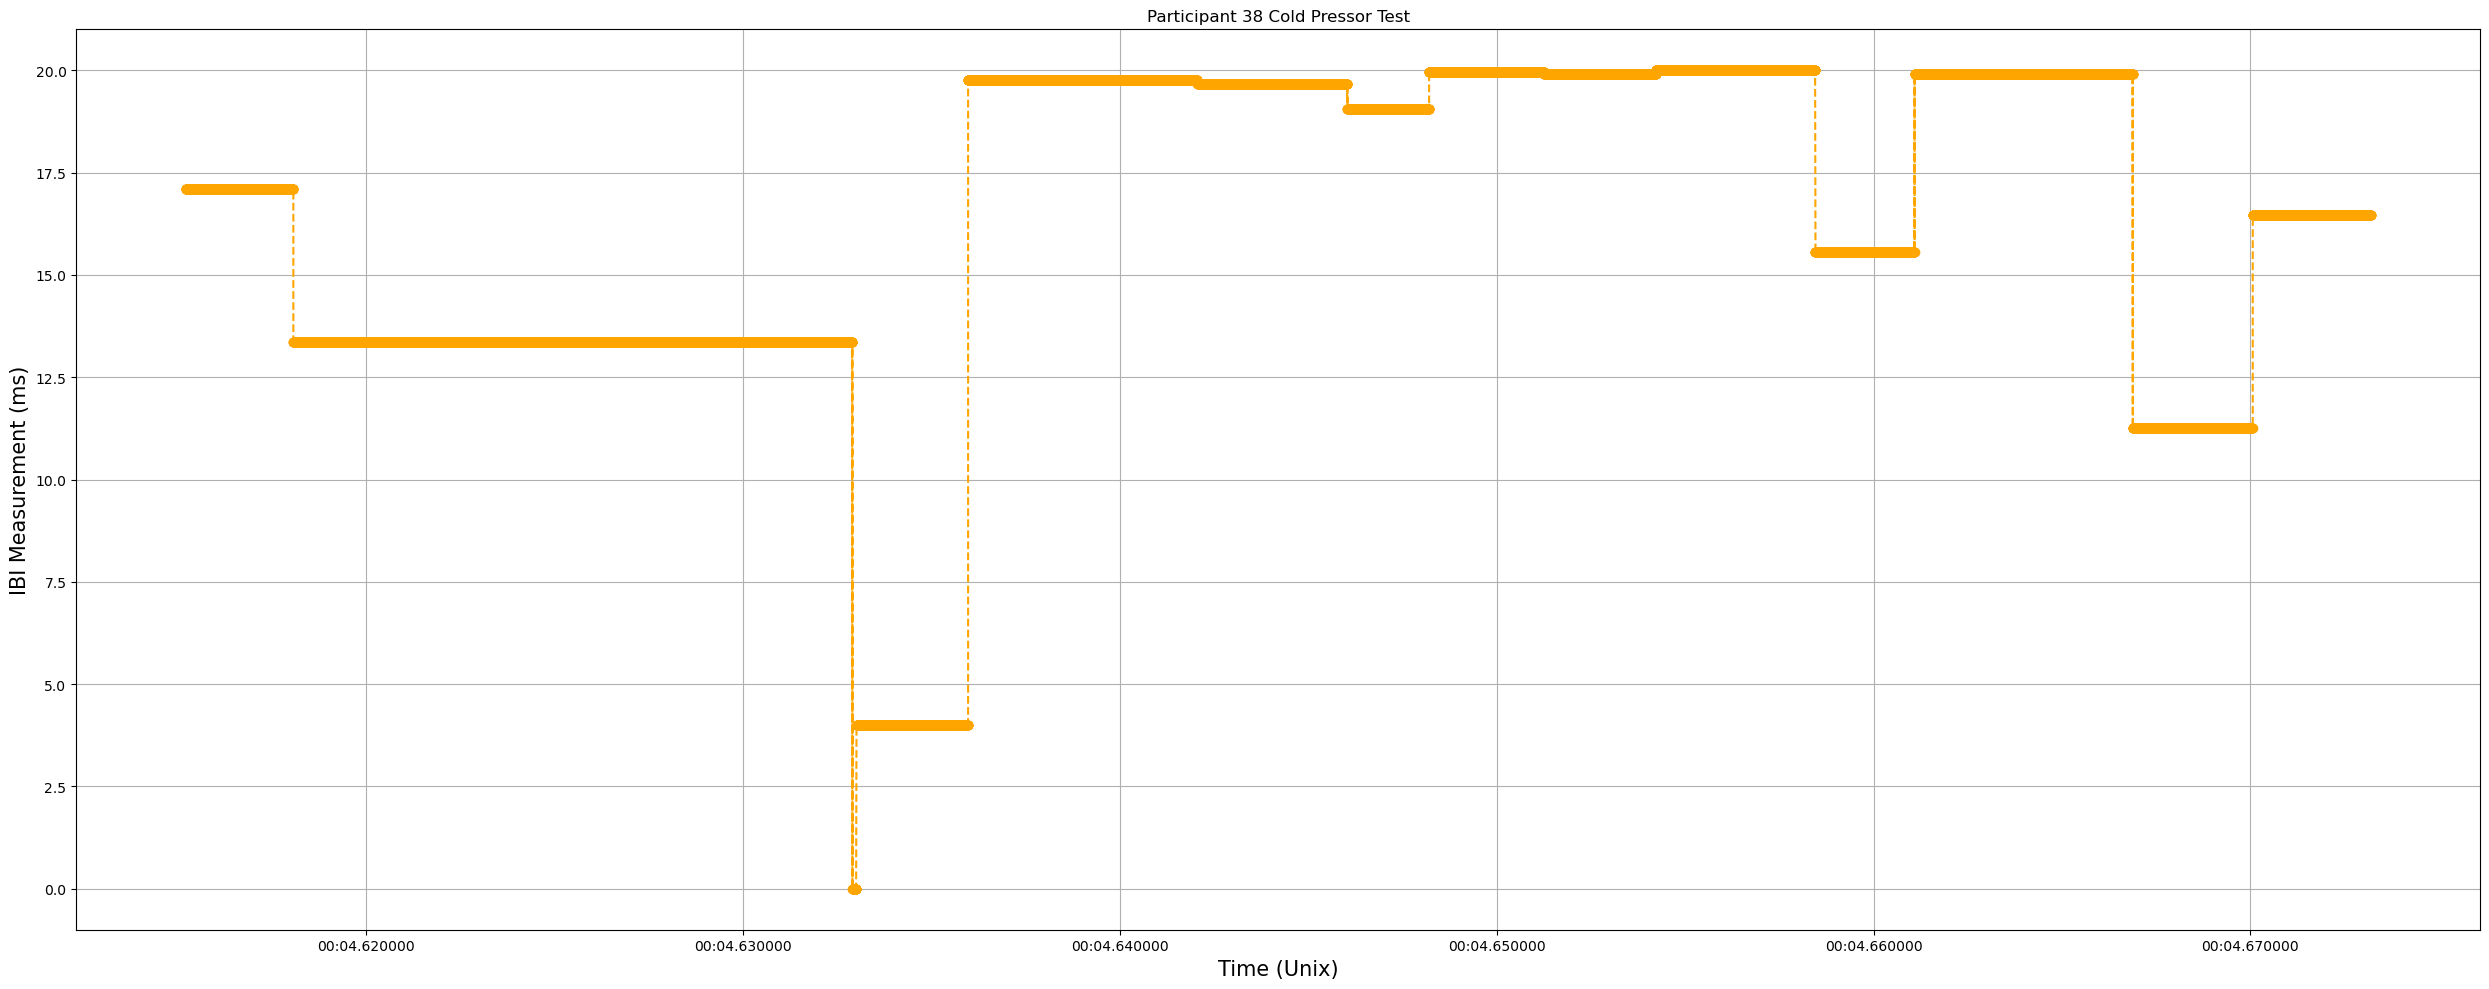

<Figure size 2500x1000 with 0 Axes>

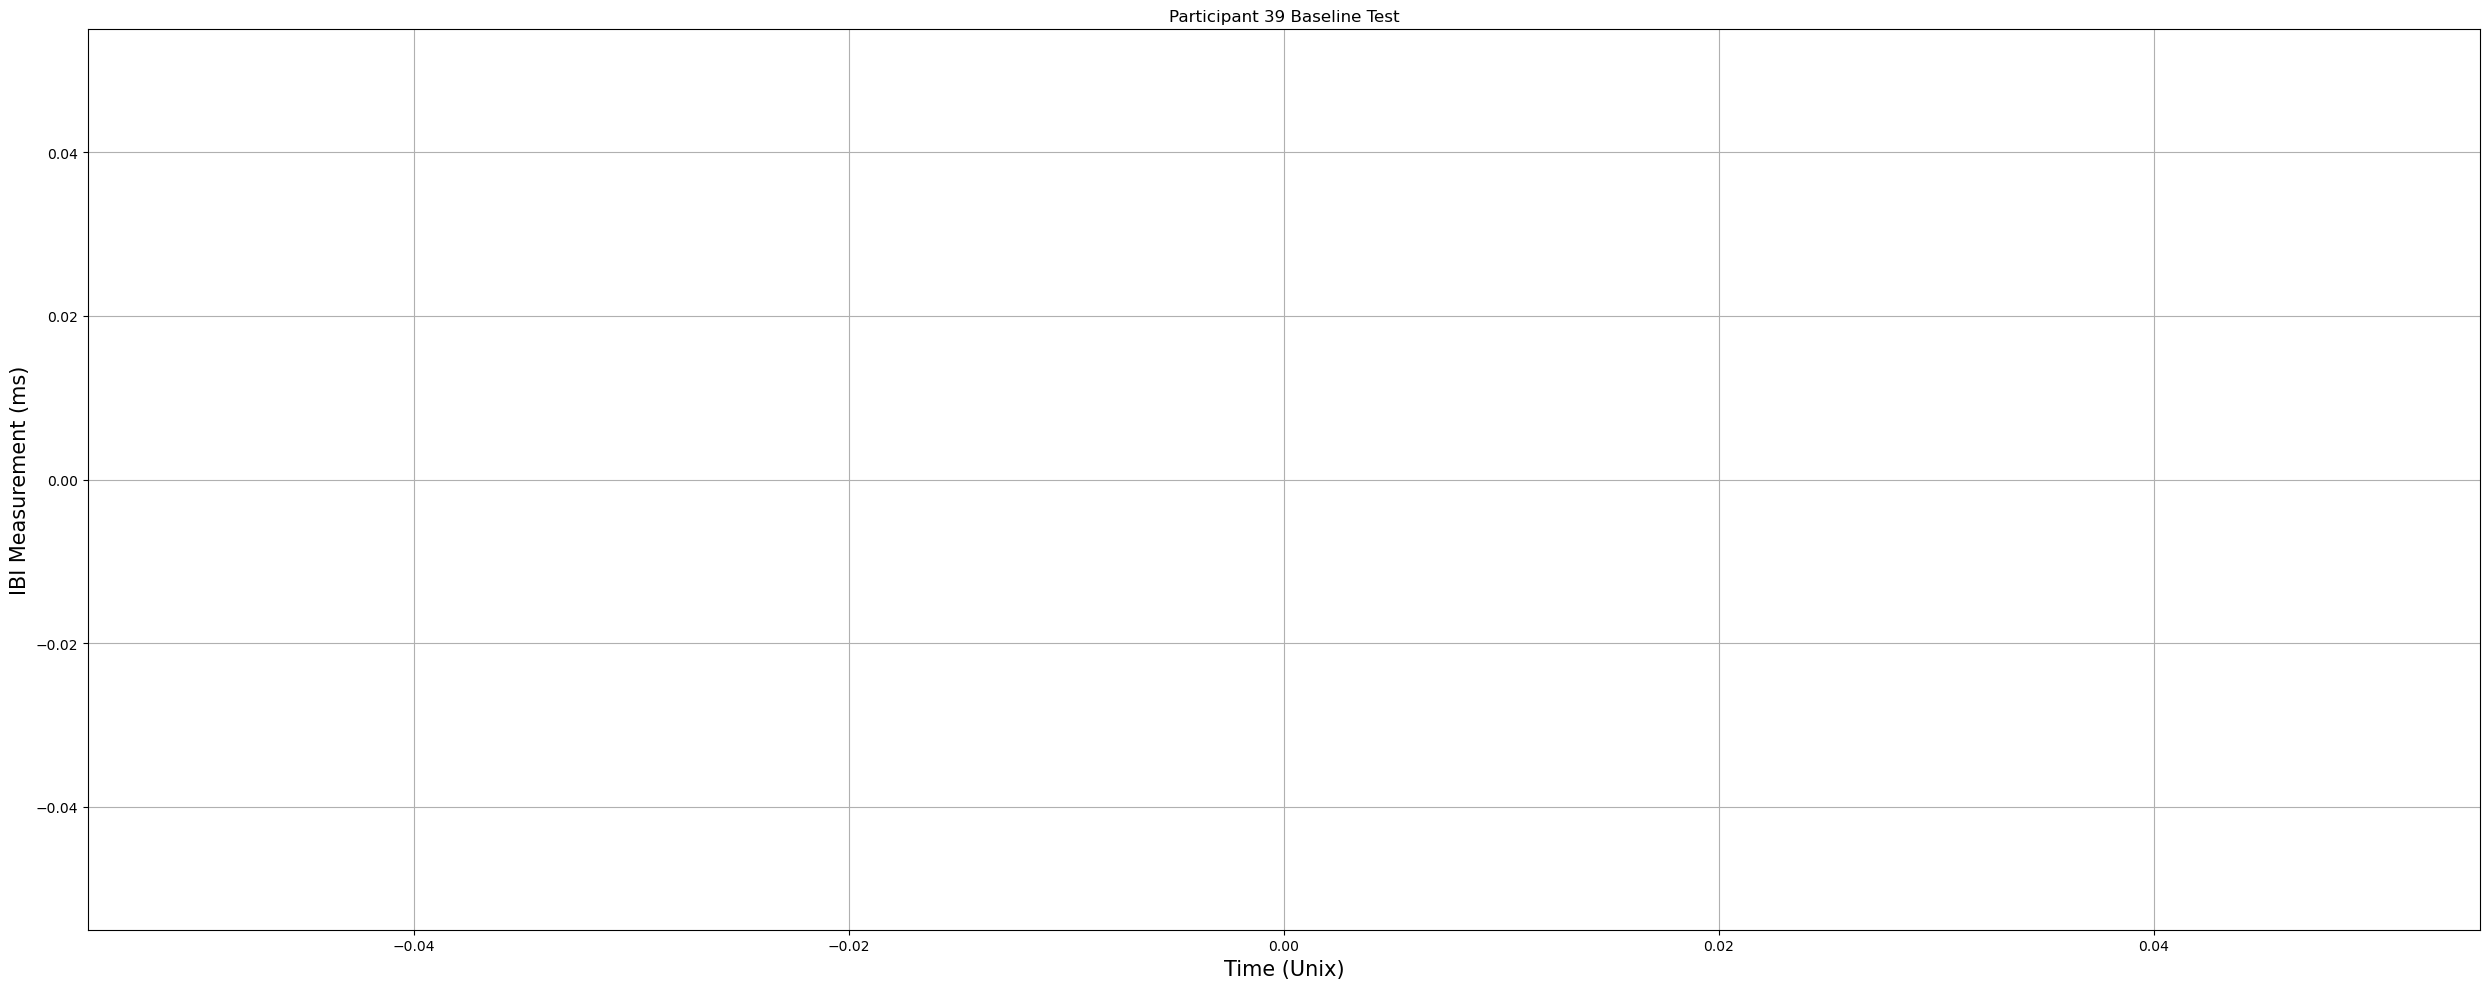

<Figure size 2500x1000 with 0 Axes>

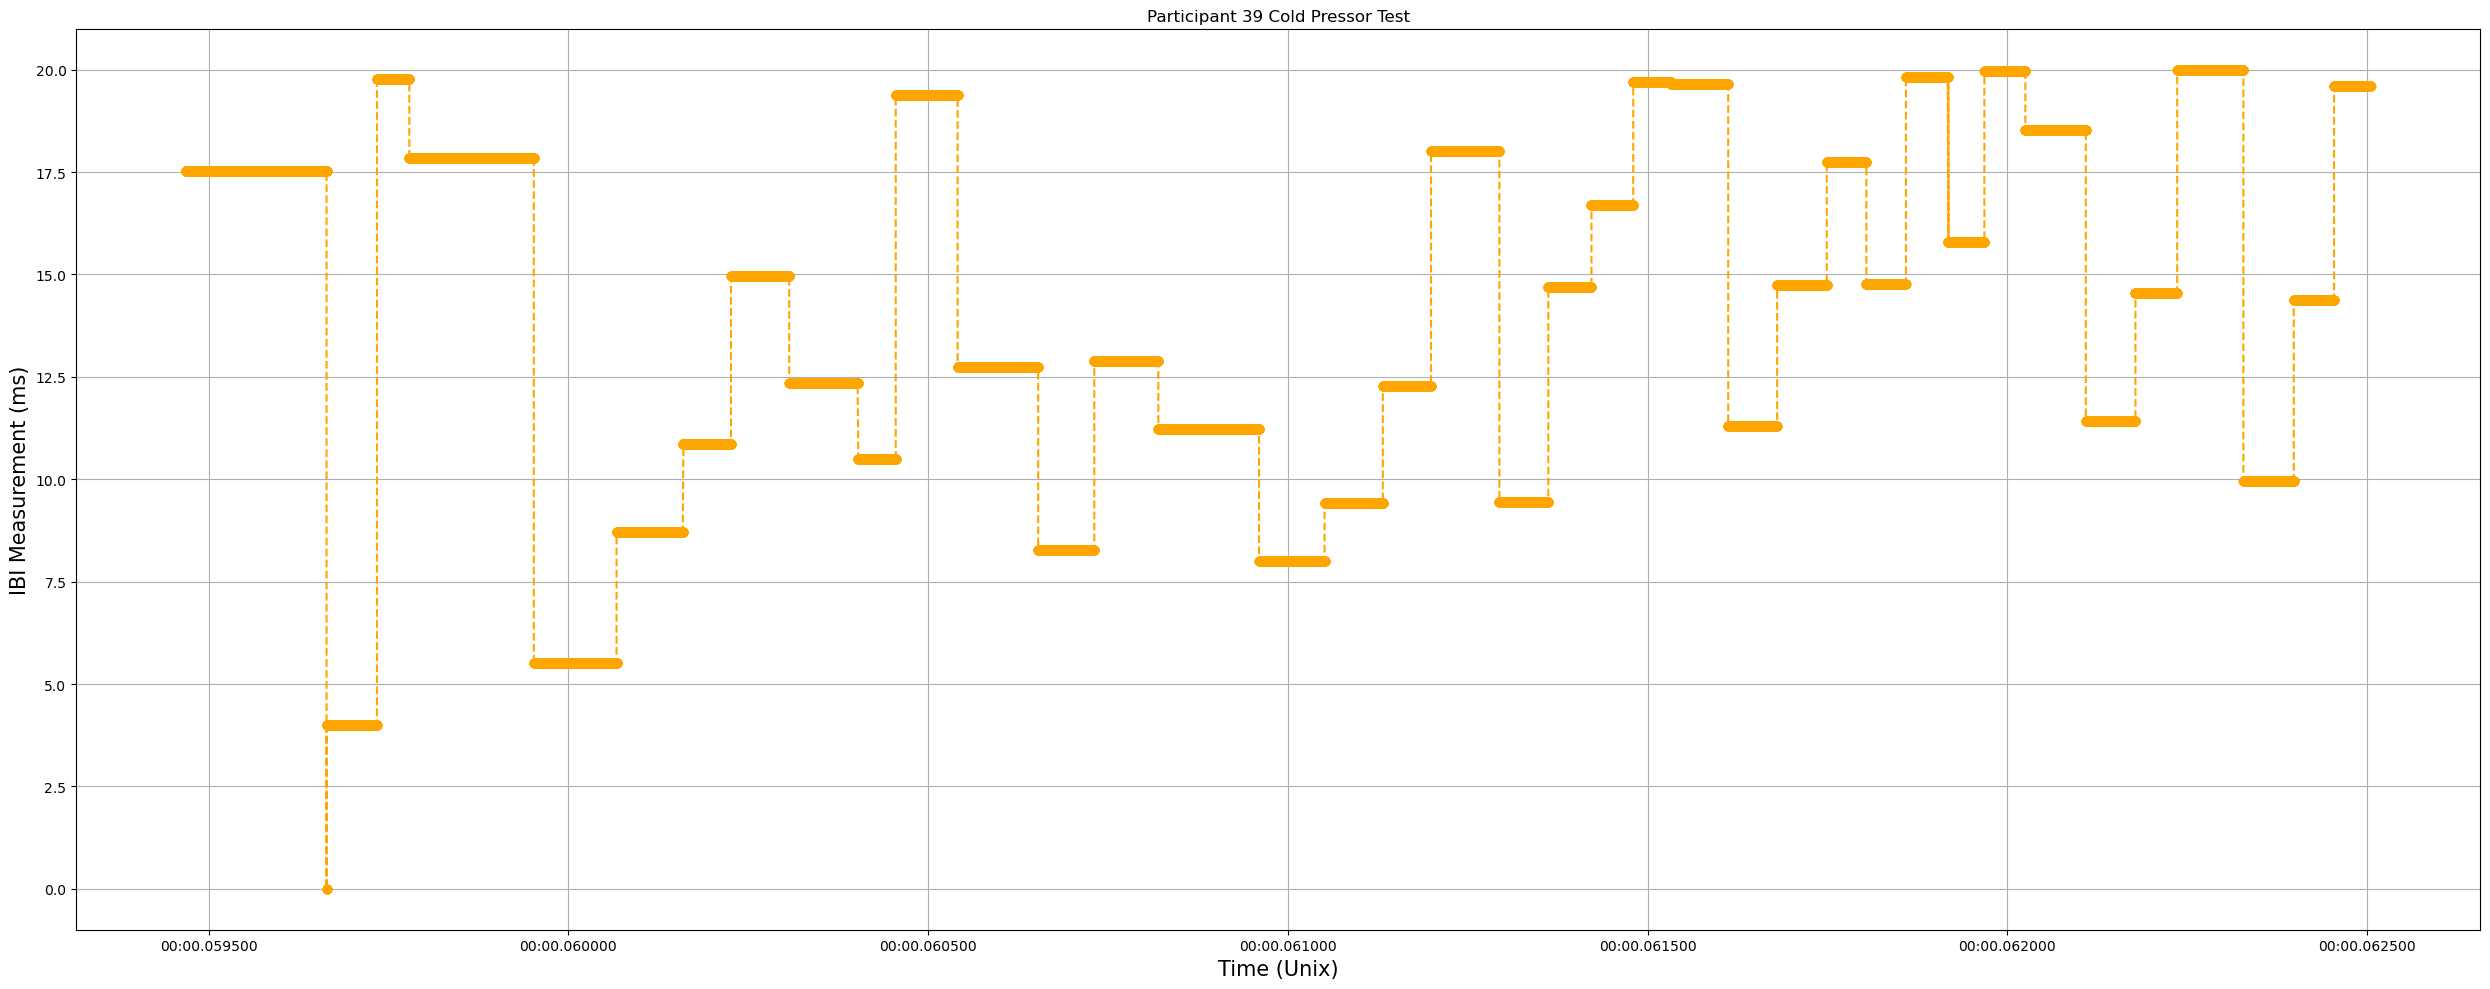

<Figure size 2500x1000 with 0 Axes>

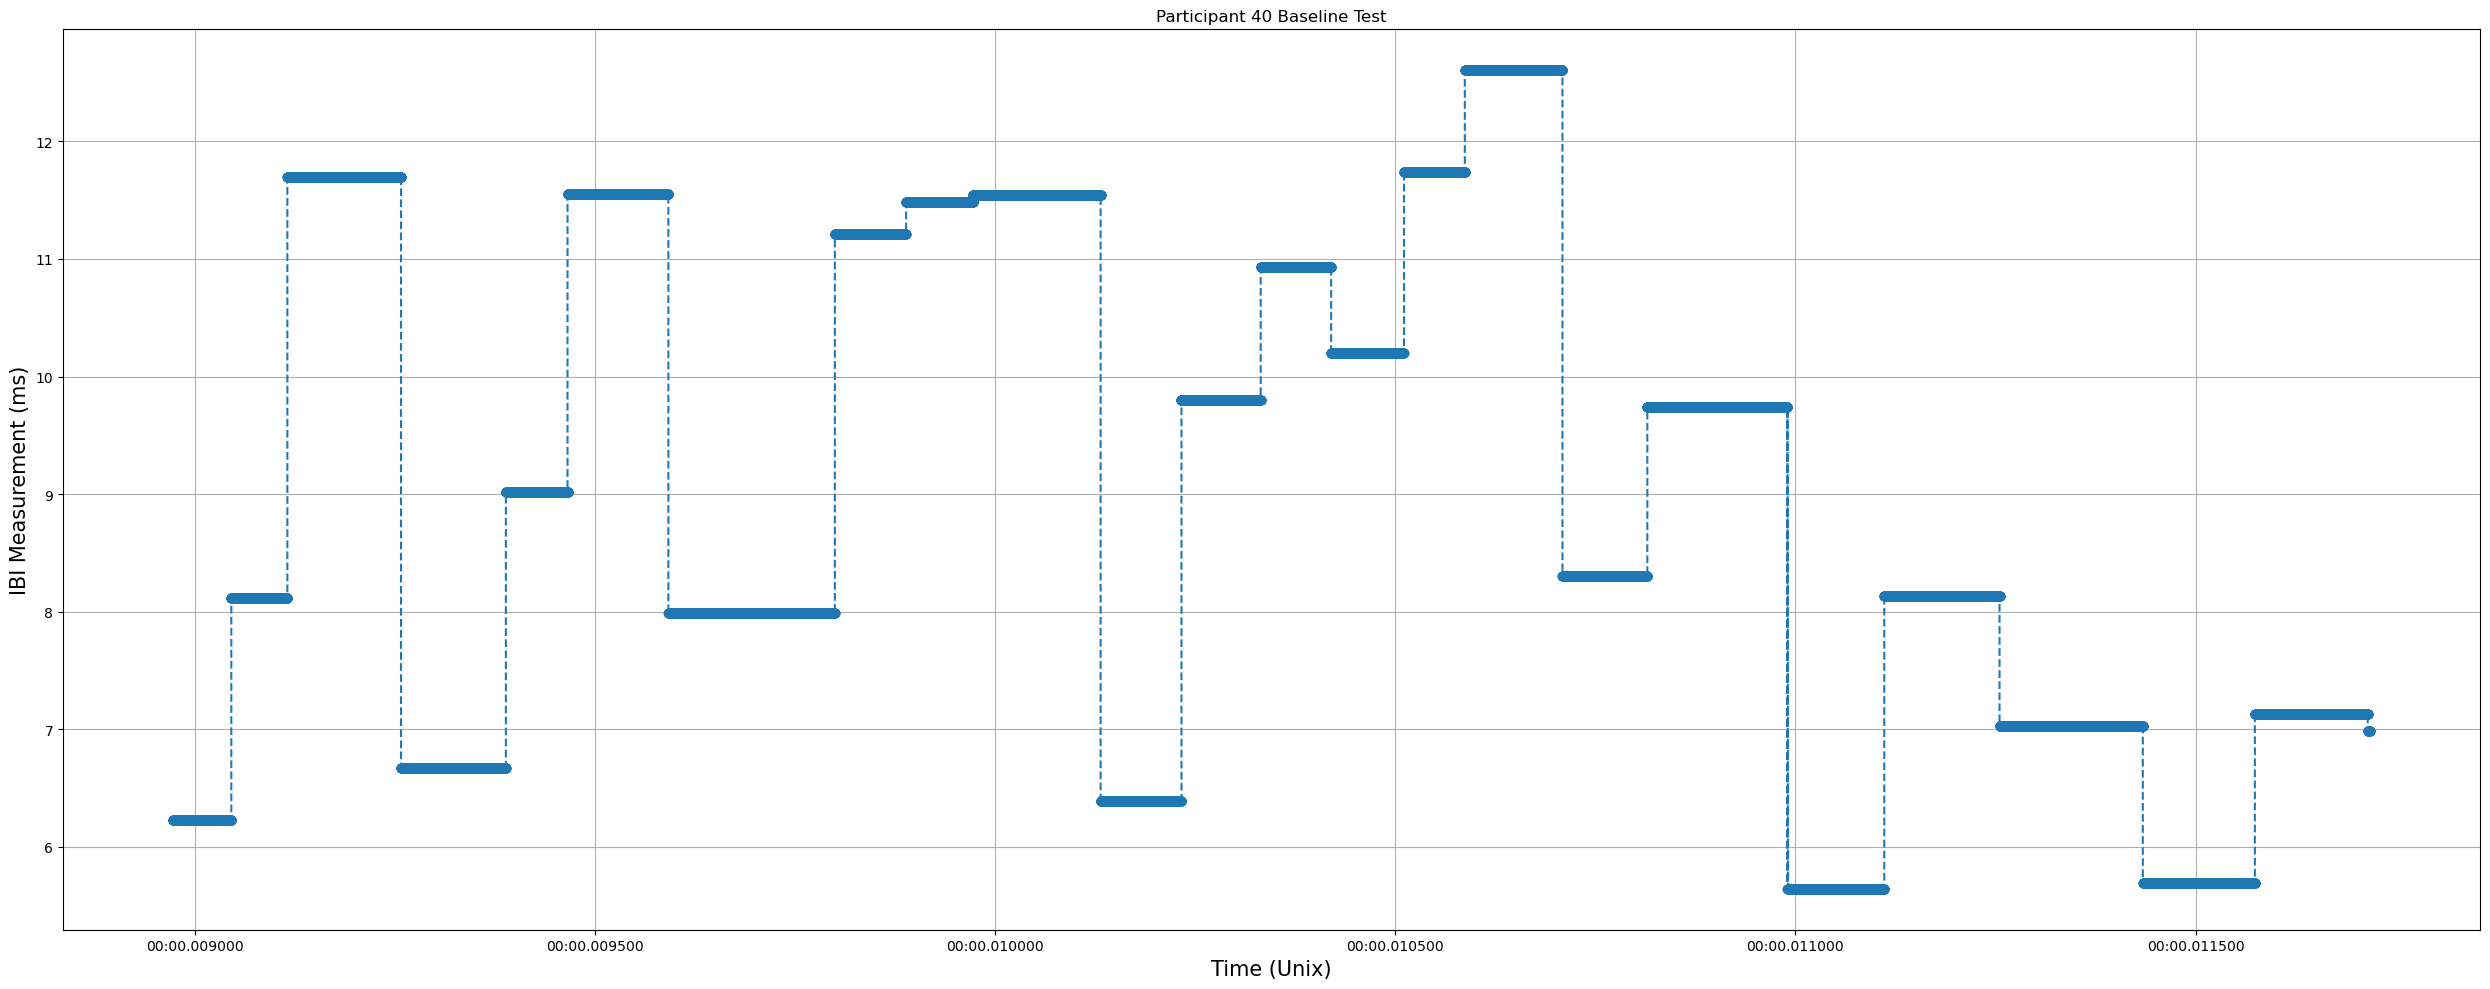

<Figure size 2500x1000 with 0 Axes>

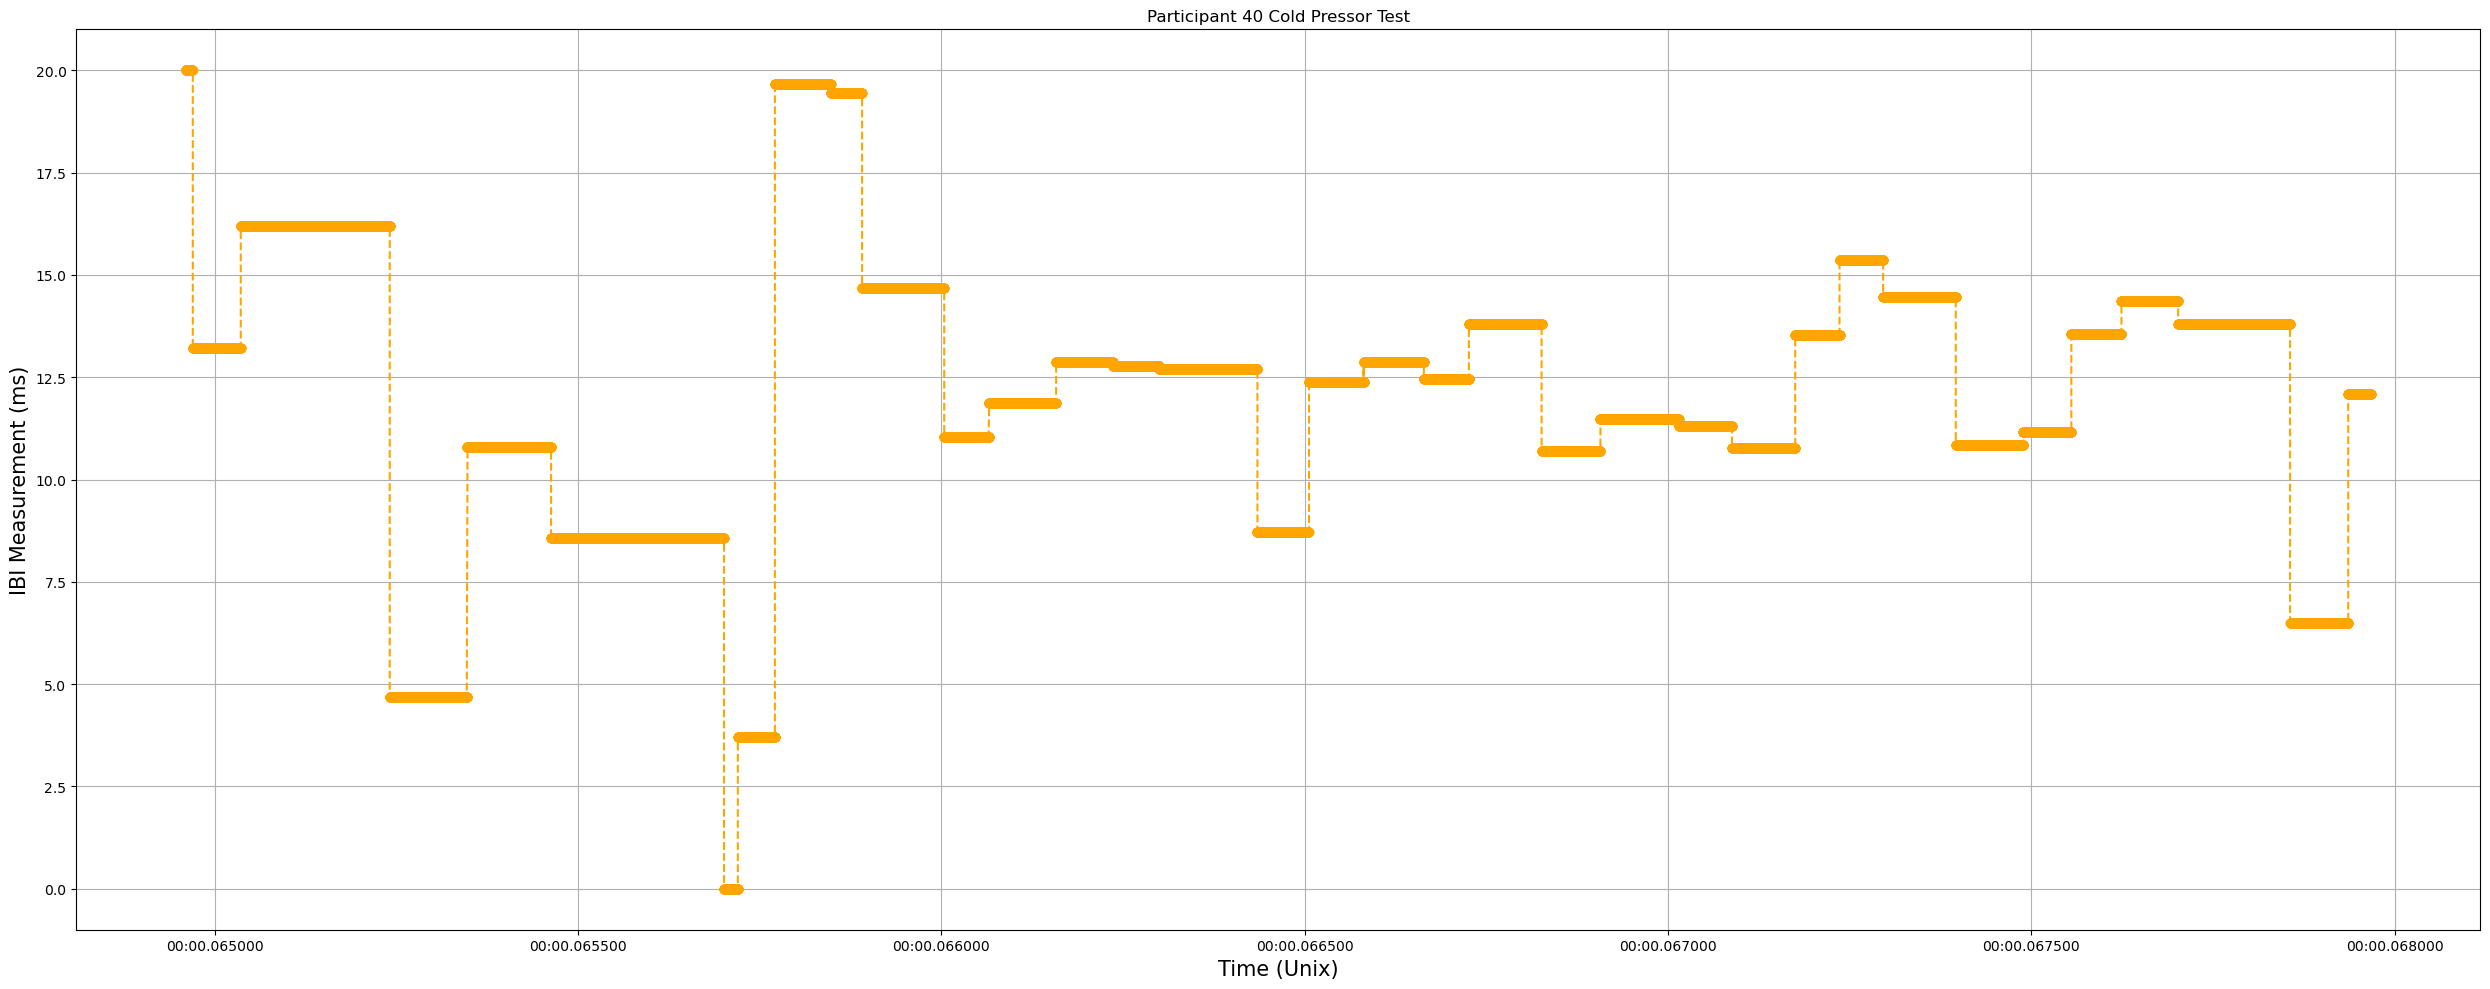

<Figure size 2500x1000 with 0 Axes>

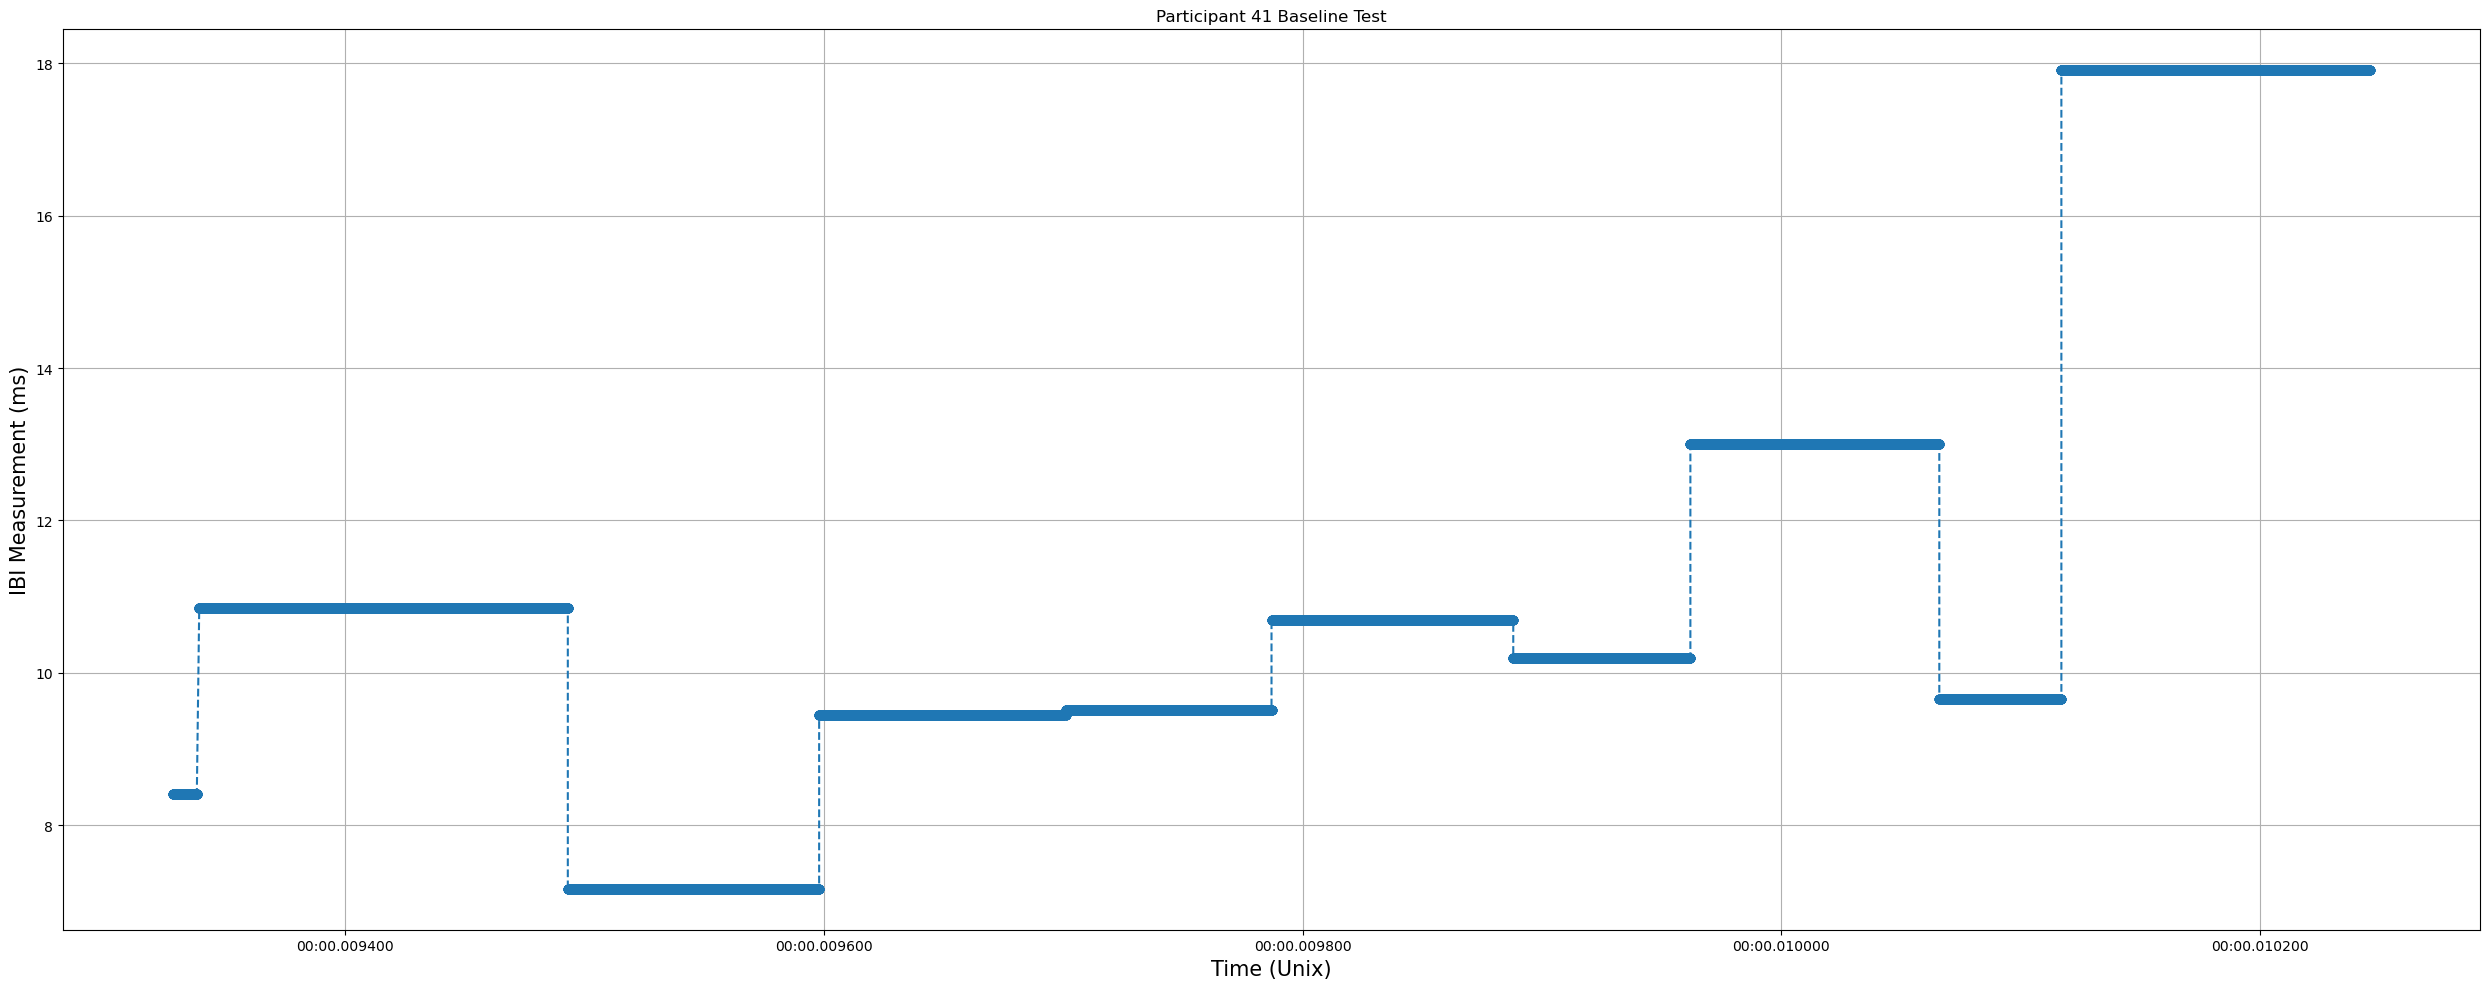

<Figure size 2500x1000 with 0 Axes>

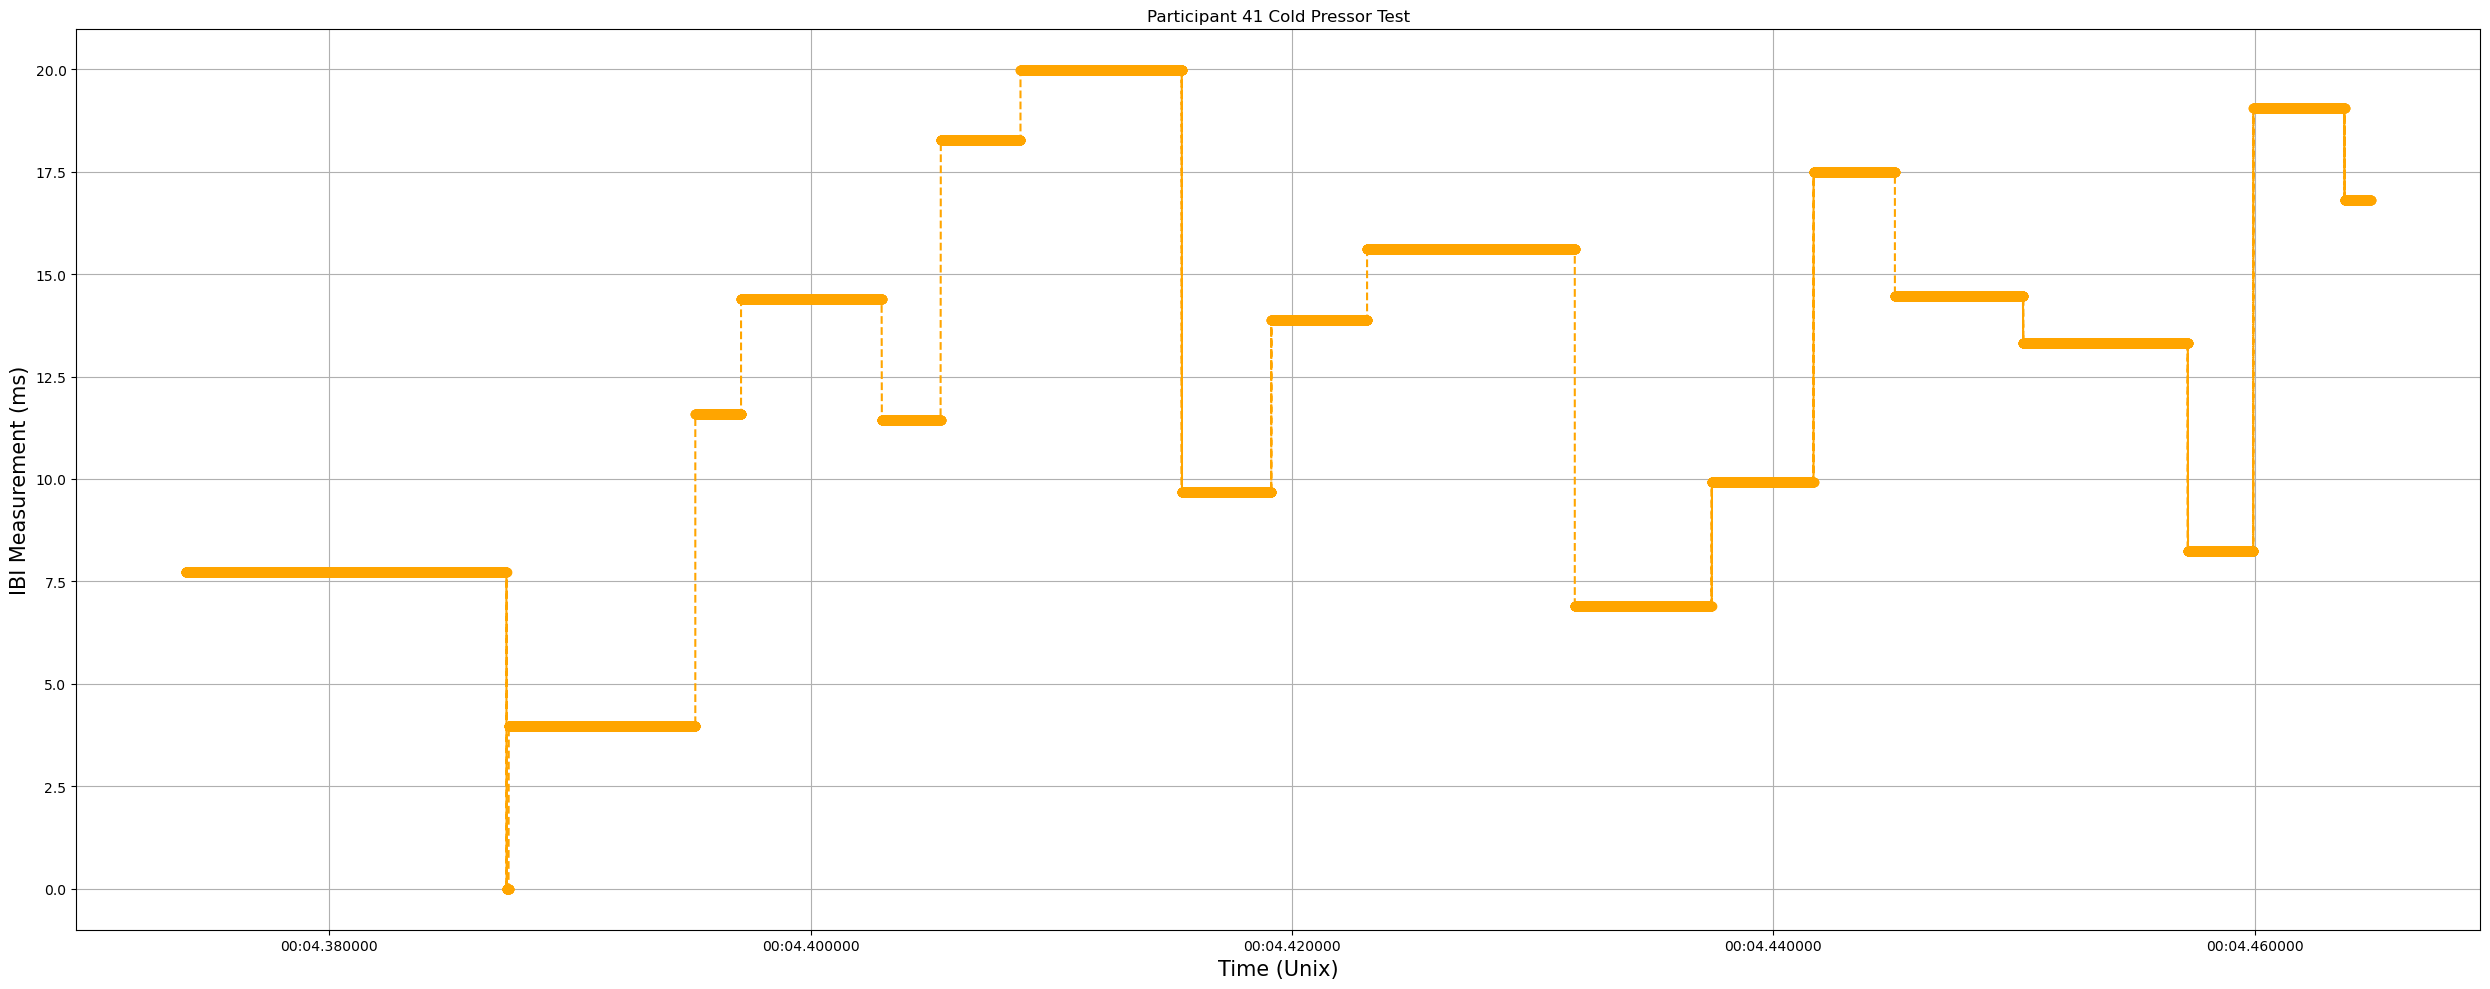

<Figure size 2500x1000 with 0 Axes>

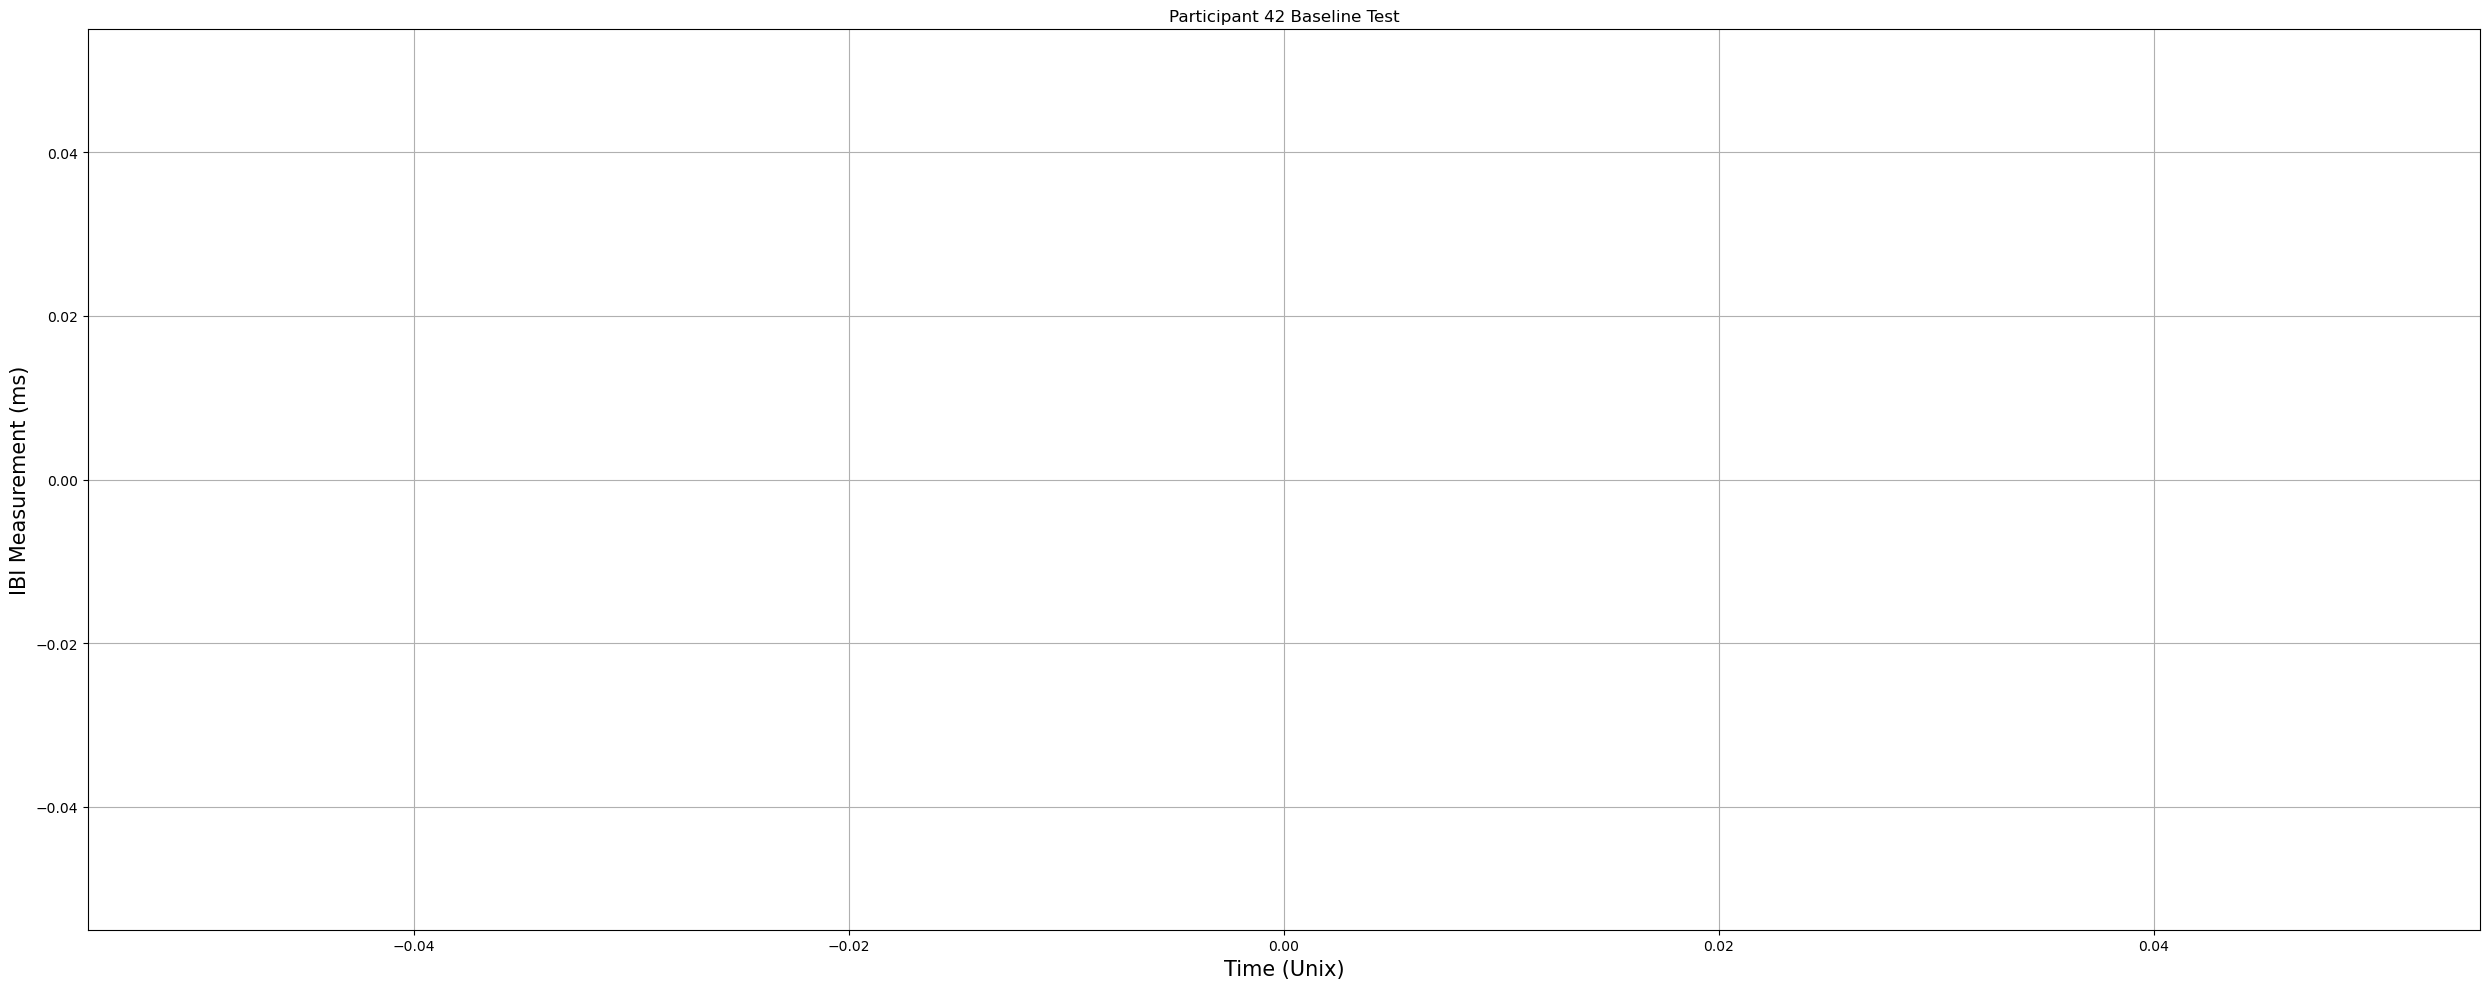

<Figure size 2500x1000 with 0 Axes>

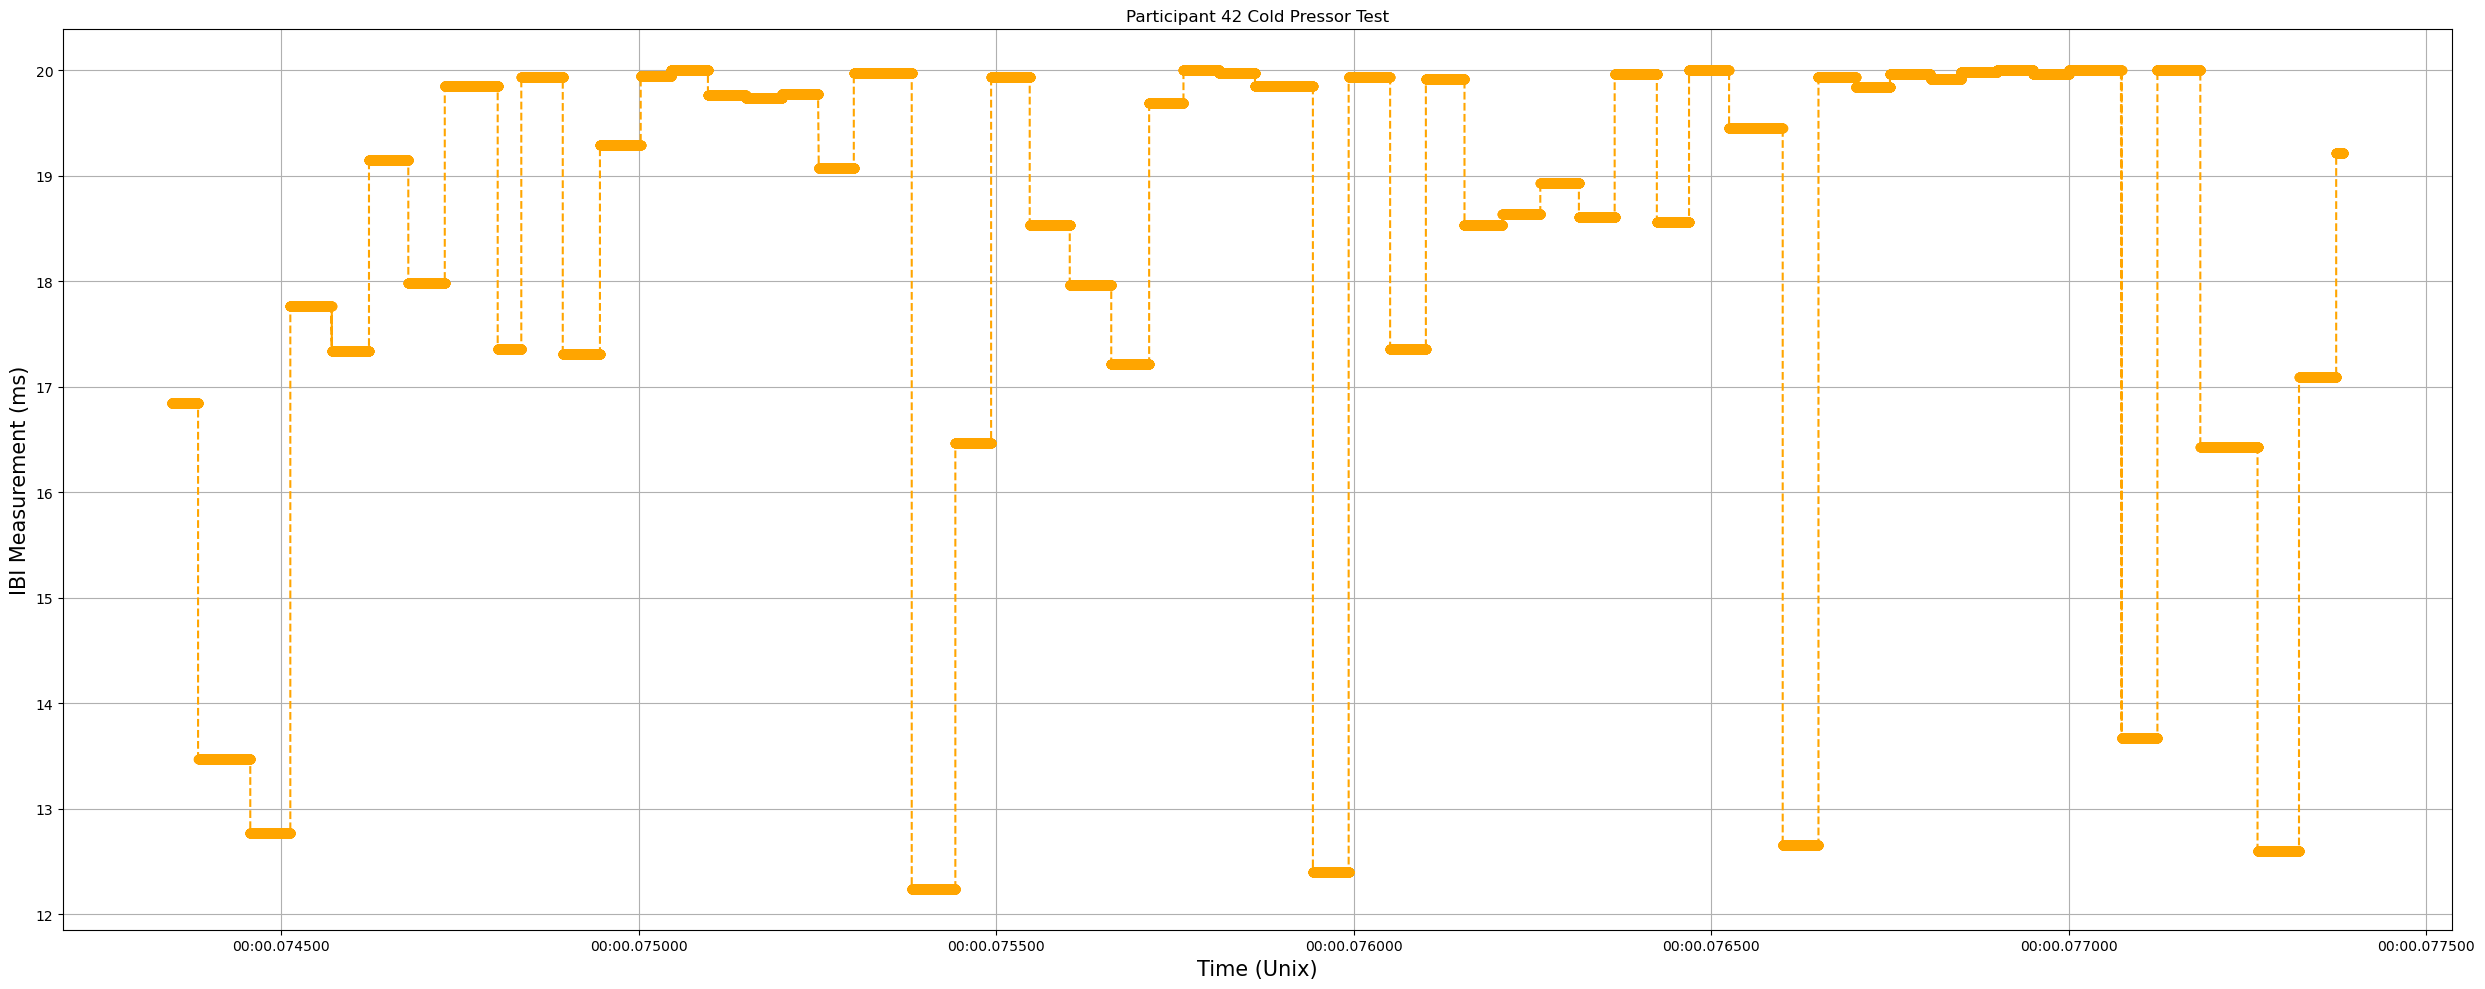

<Figure size 2500x1000 with 0 Axes>

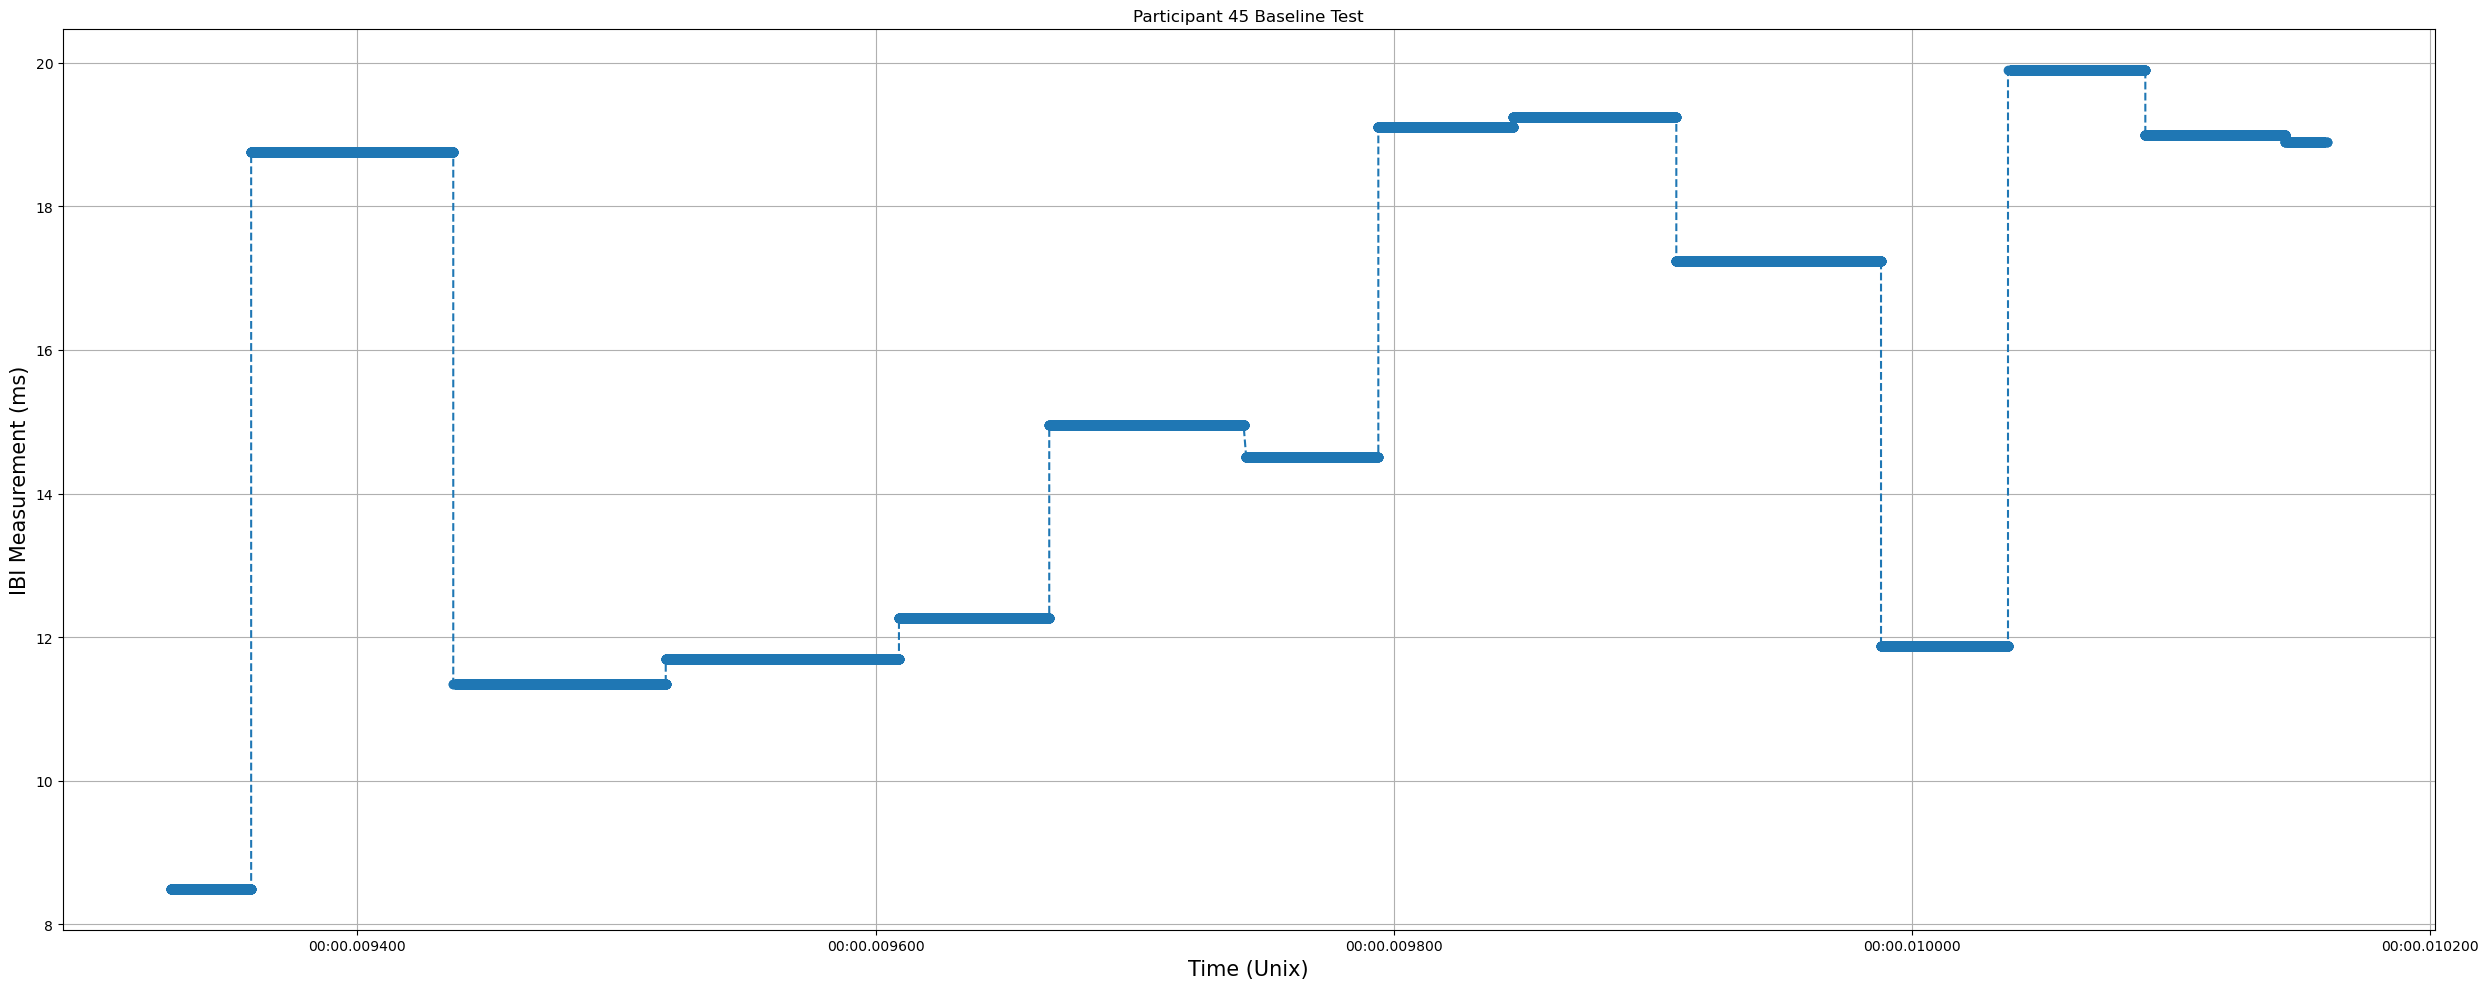

<Figure size 2500x1000 with 0 Axes>

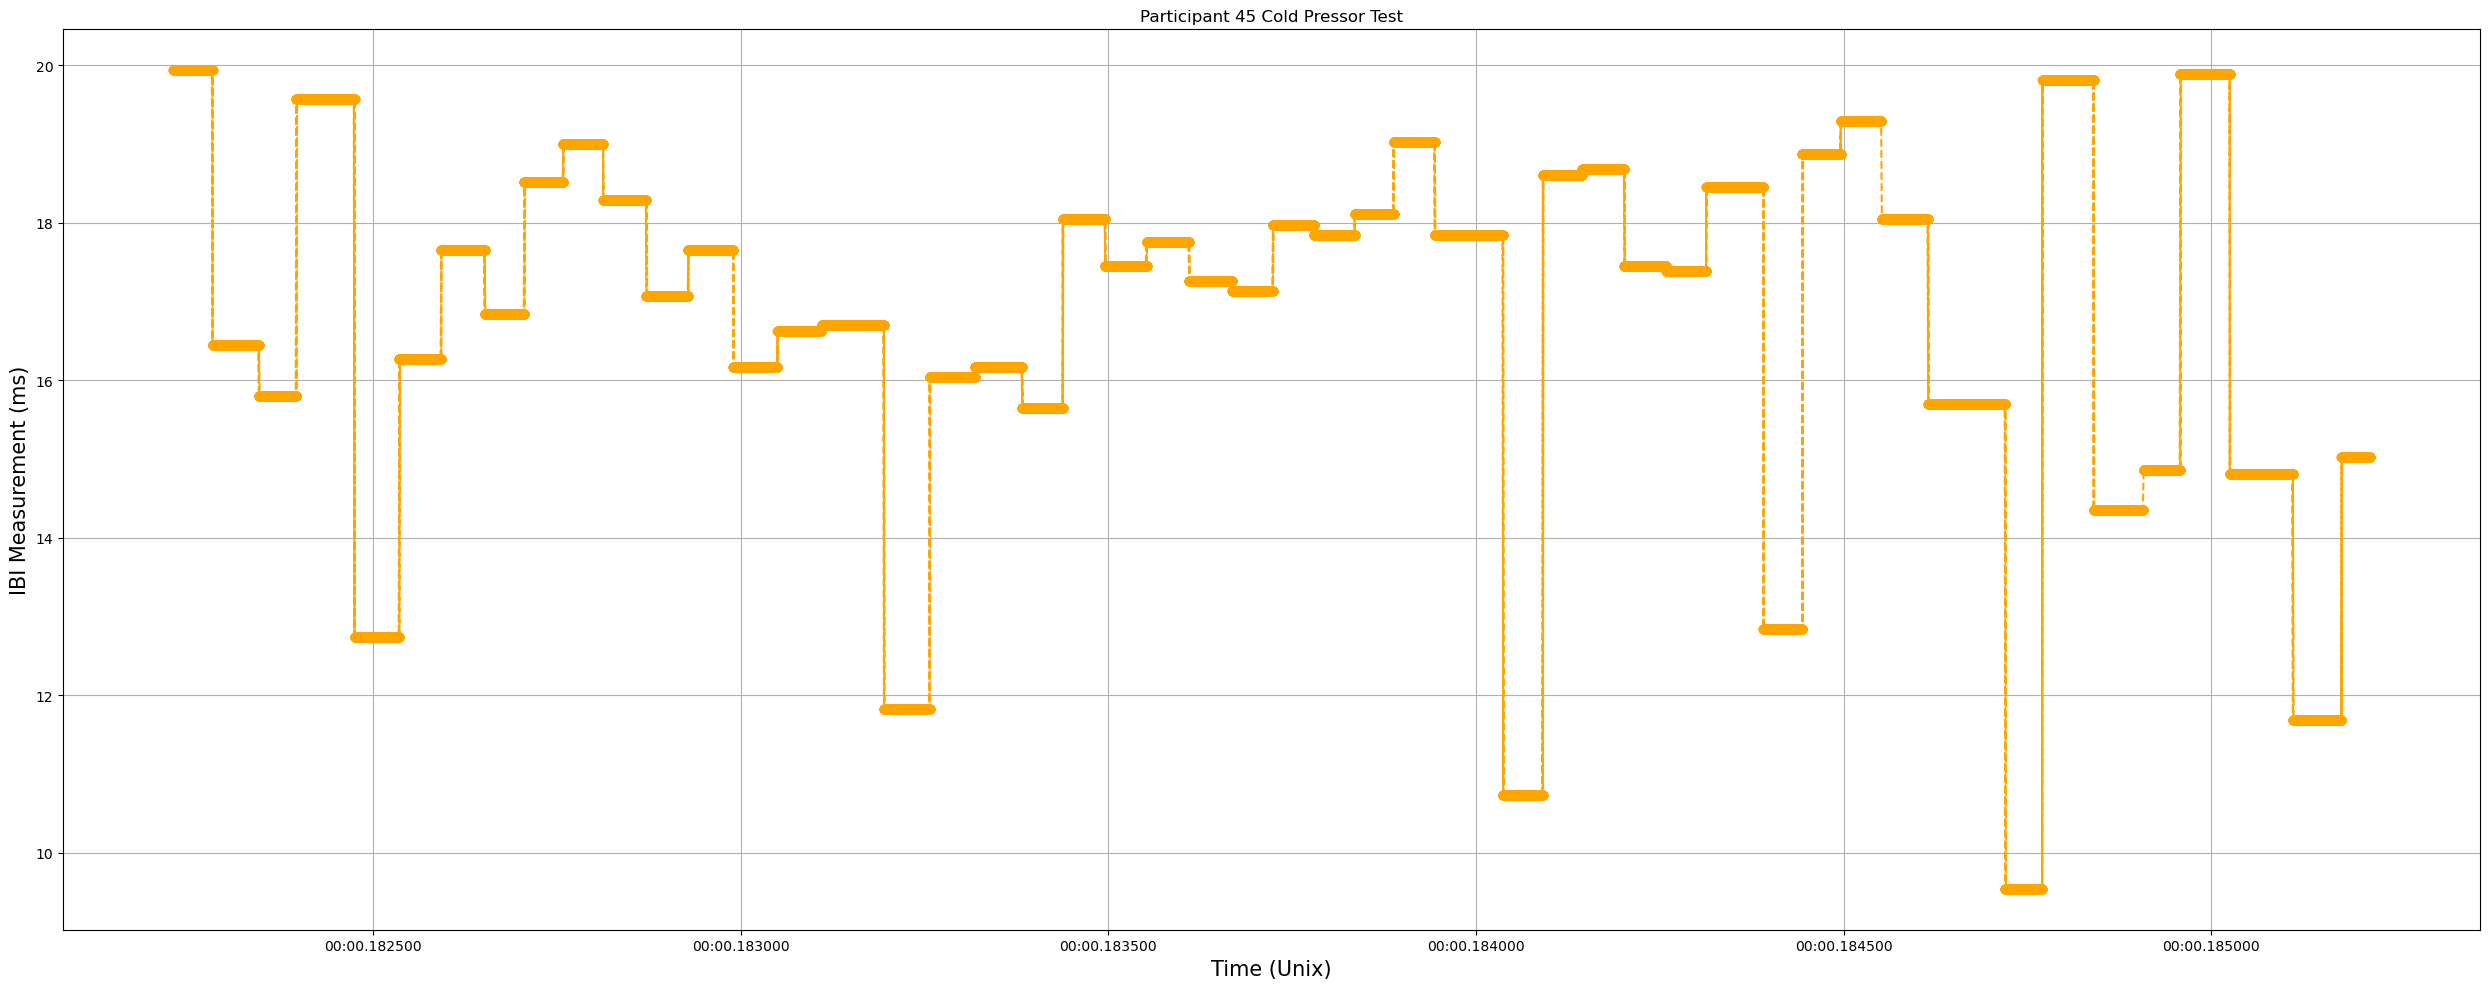

<Figure size 2500x1000 with 0 Axes>

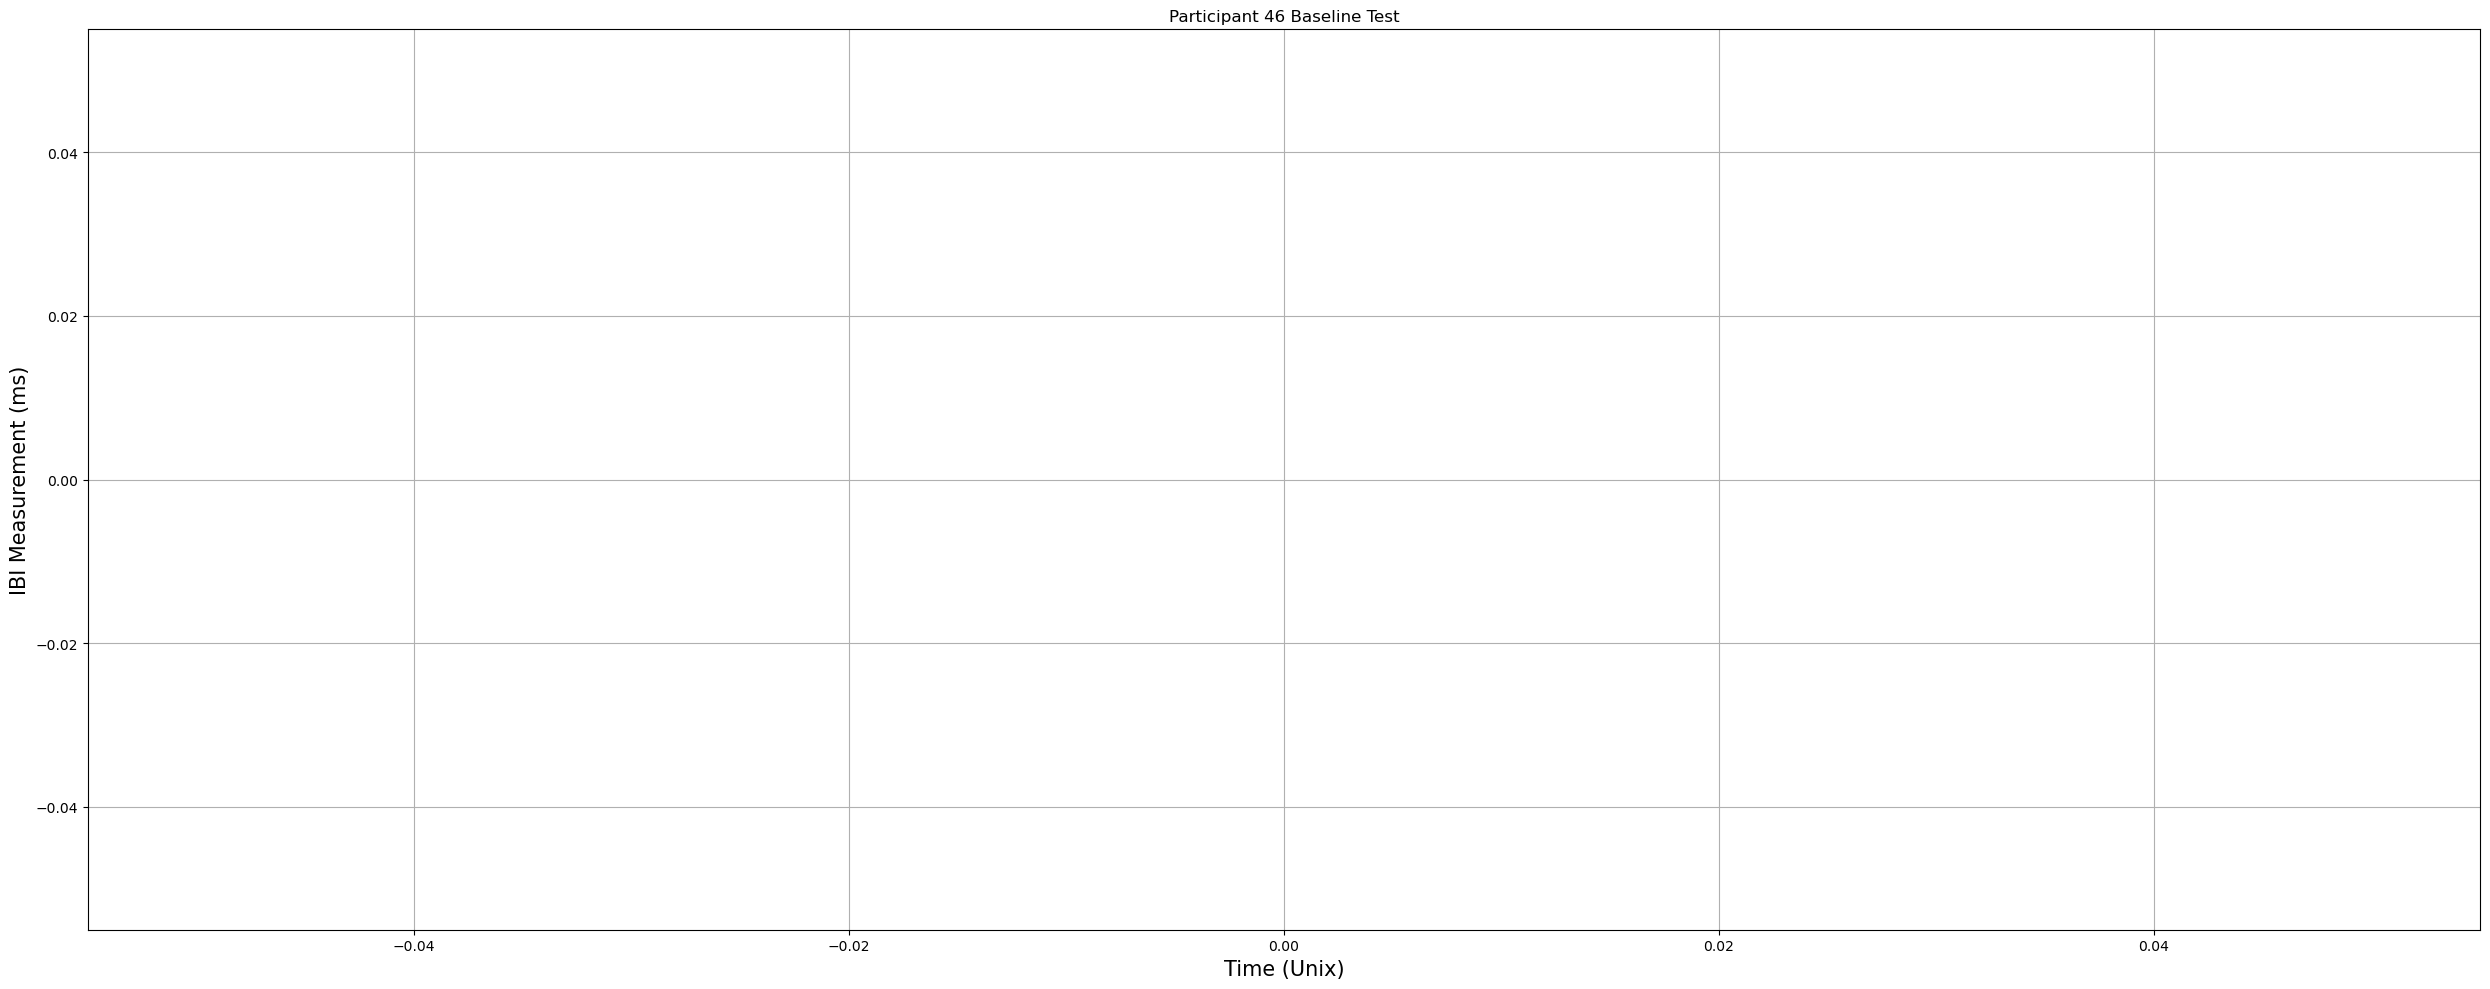

<Figure size 2500x1000 with 0 Axes>

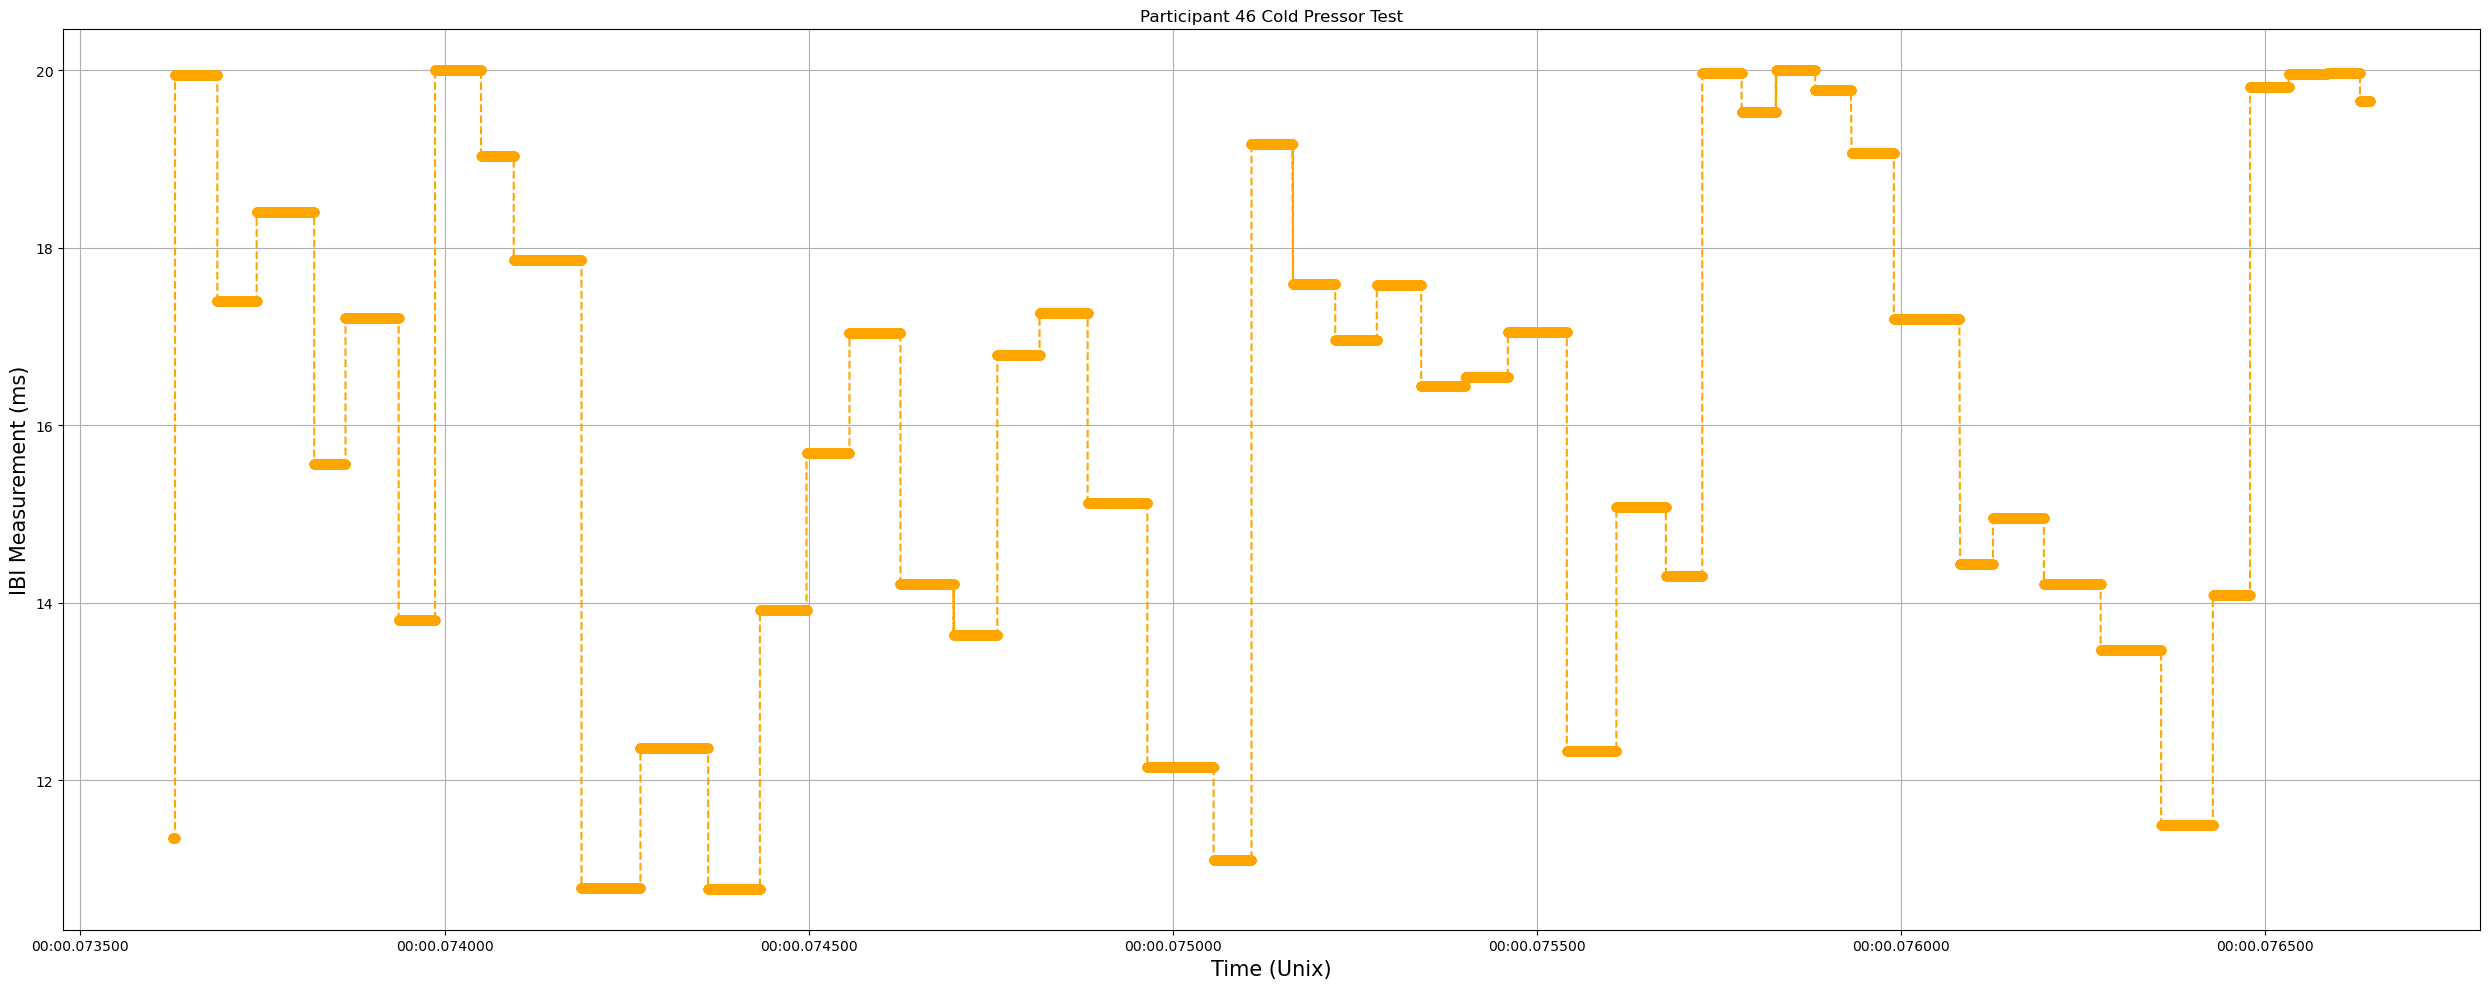

<Figure size 2500x1000 with 0 Axes>

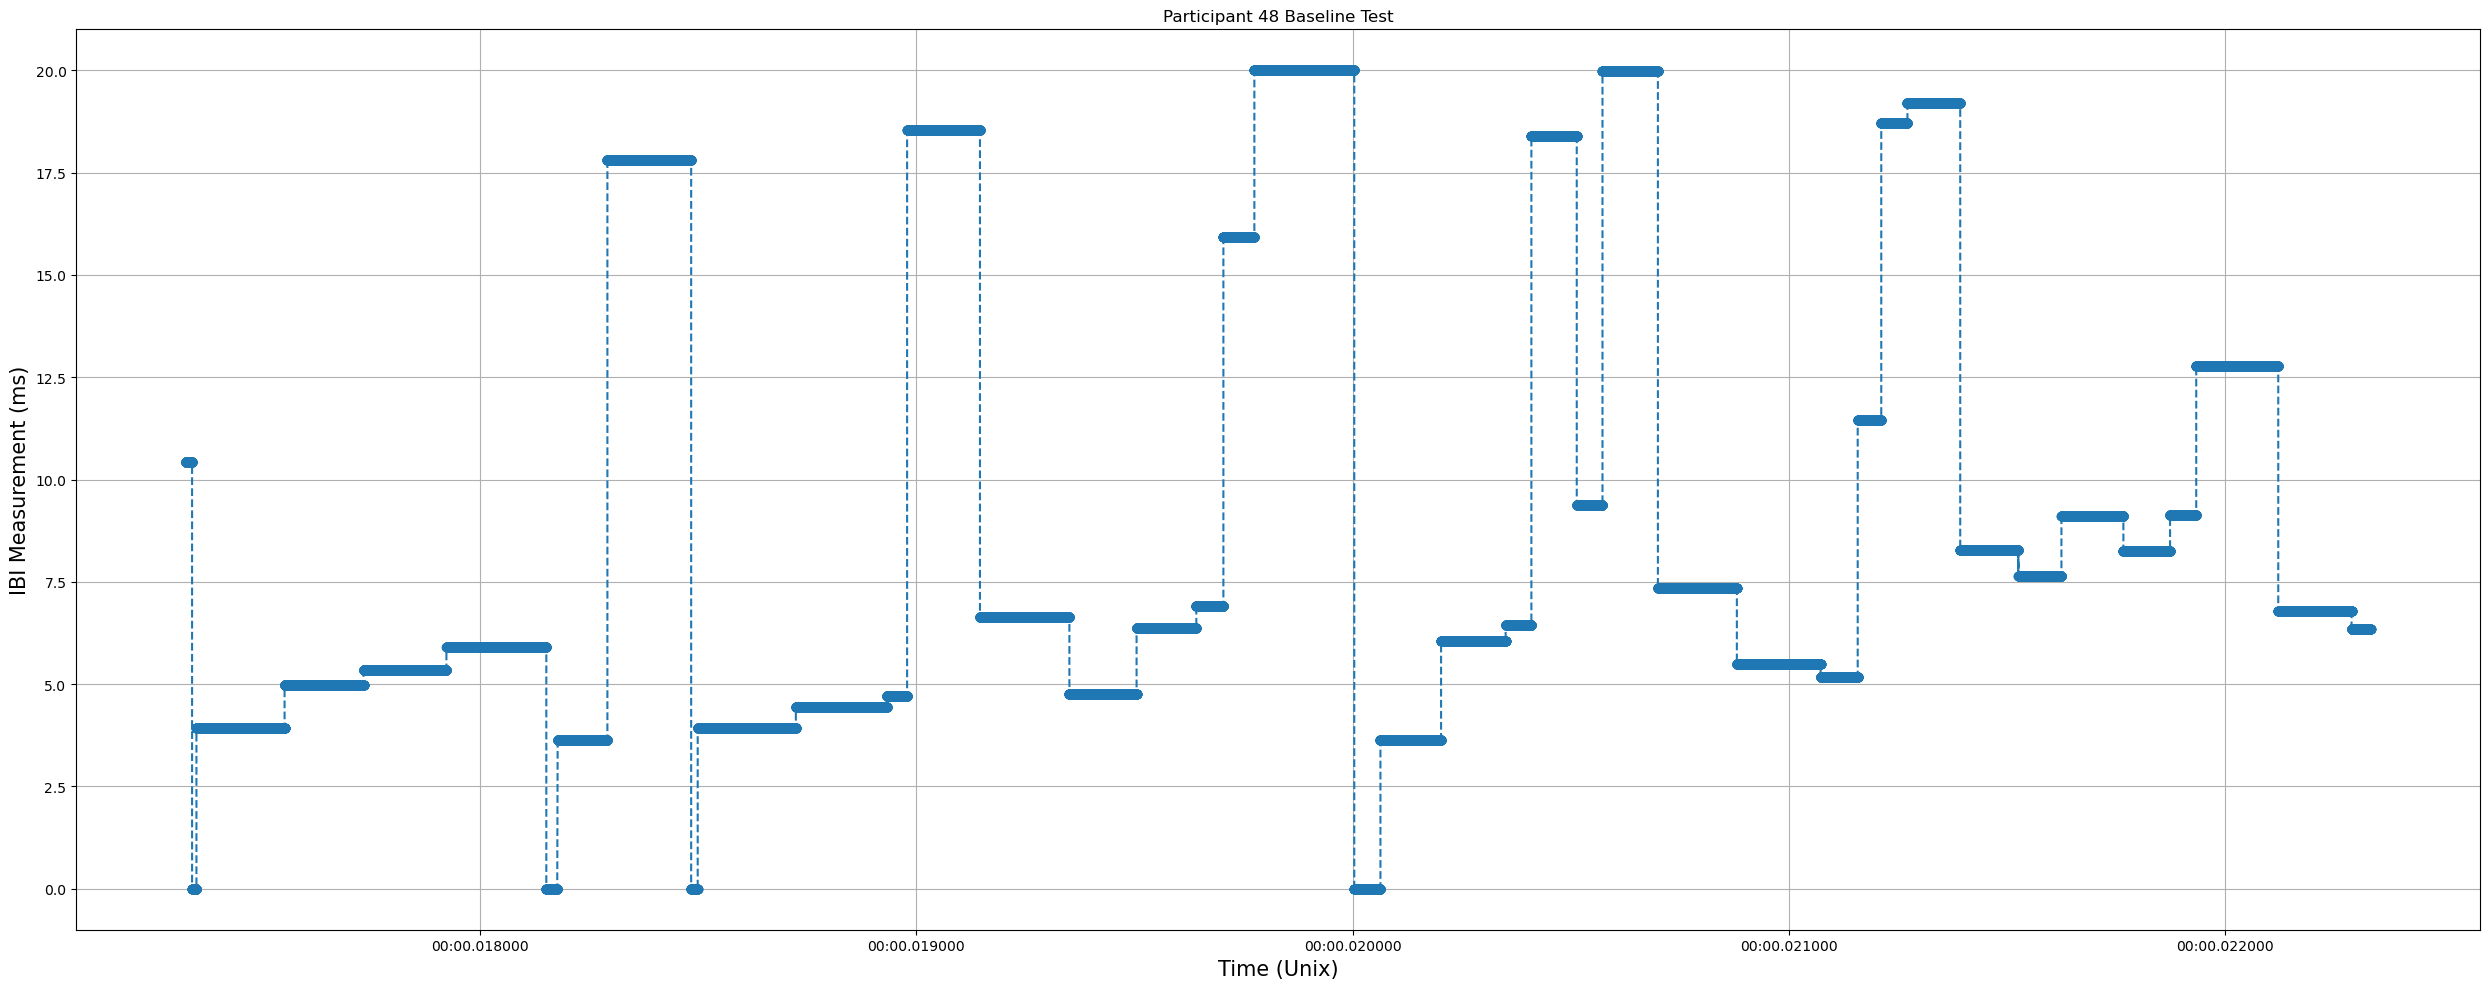

<Figure size 2500x1000 with 0 Axes>

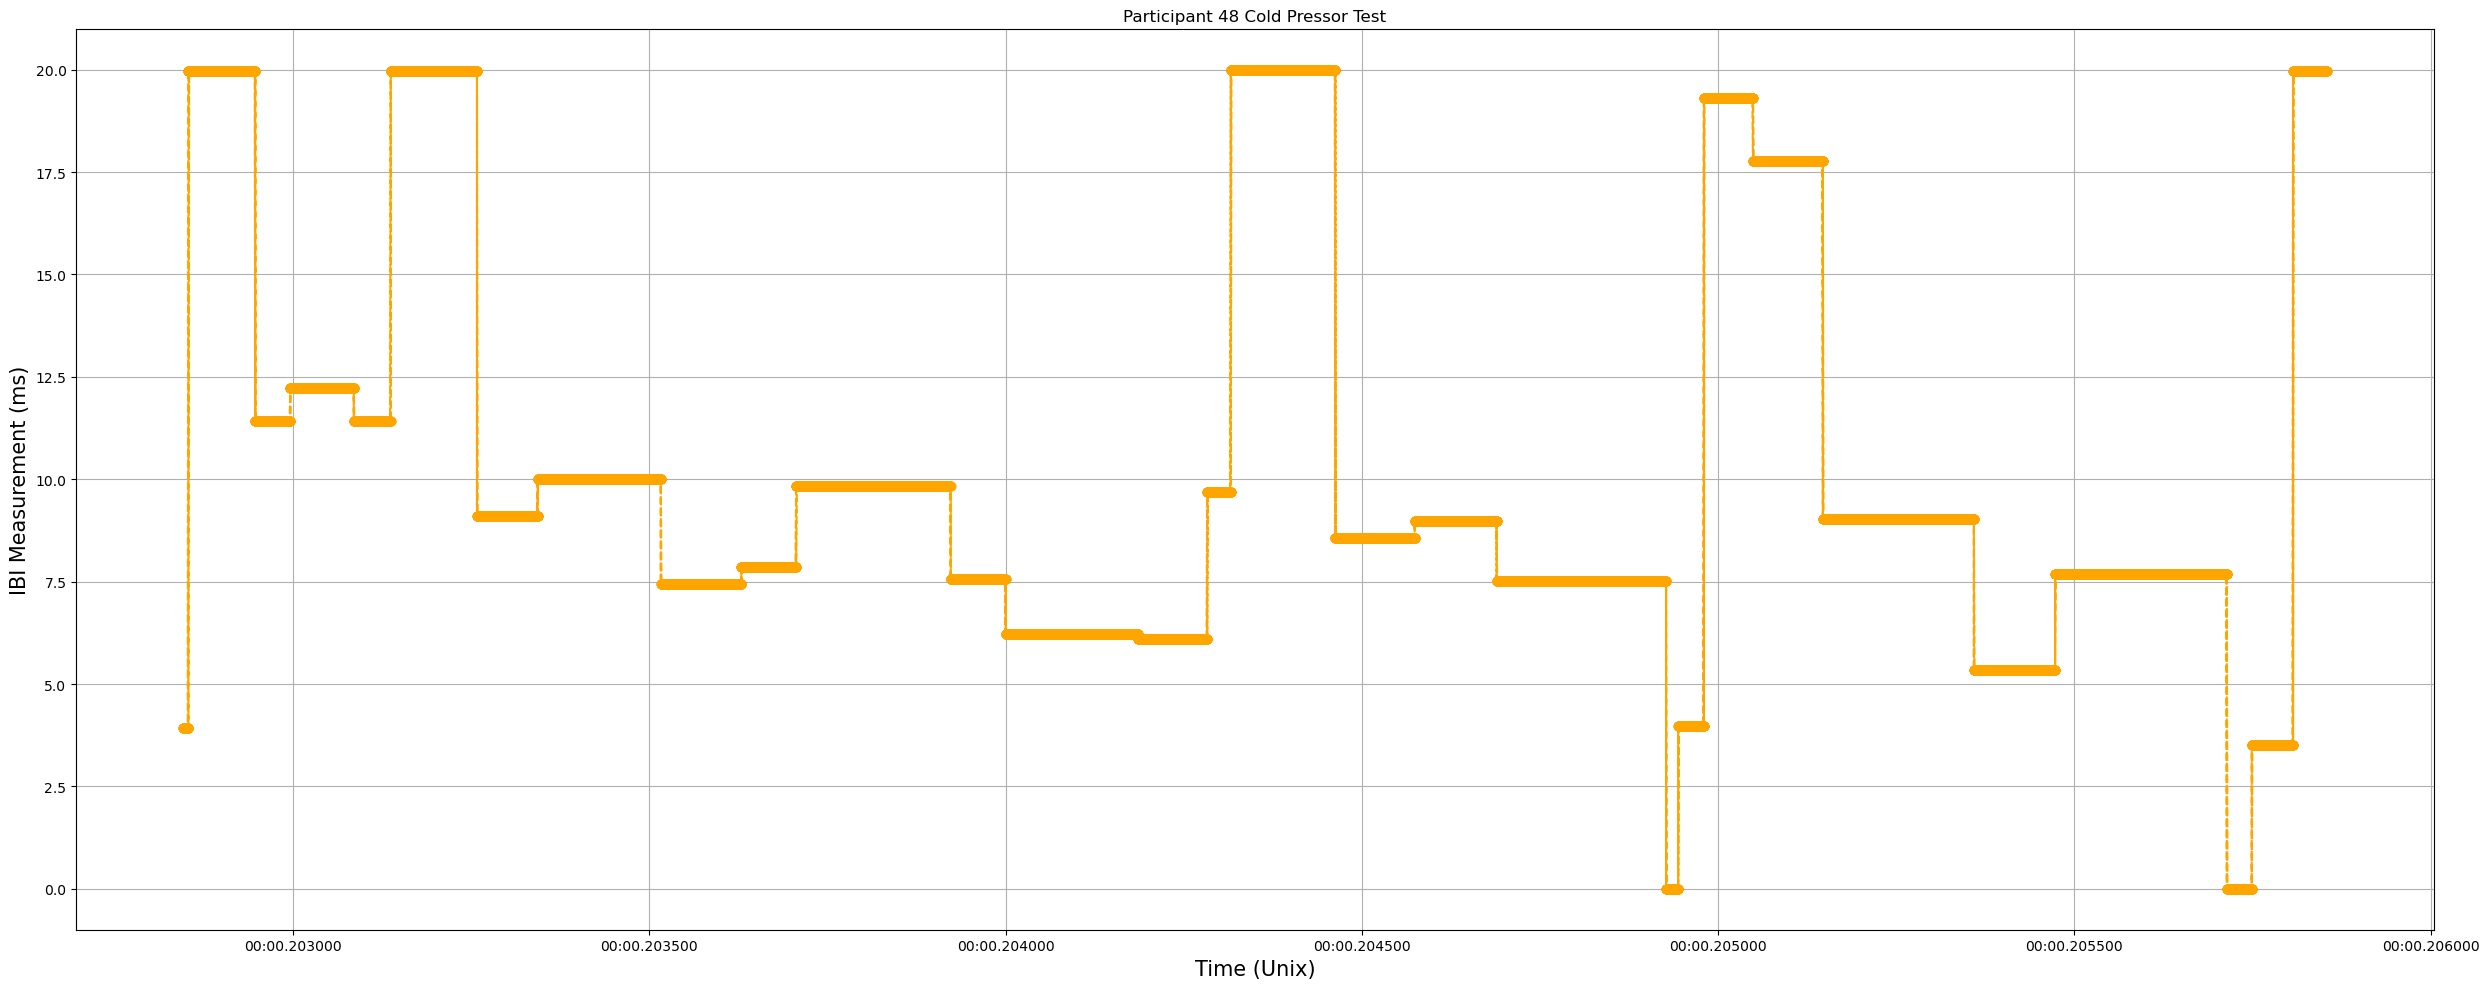

<Figure size 2500x1000 with 0 Axes>

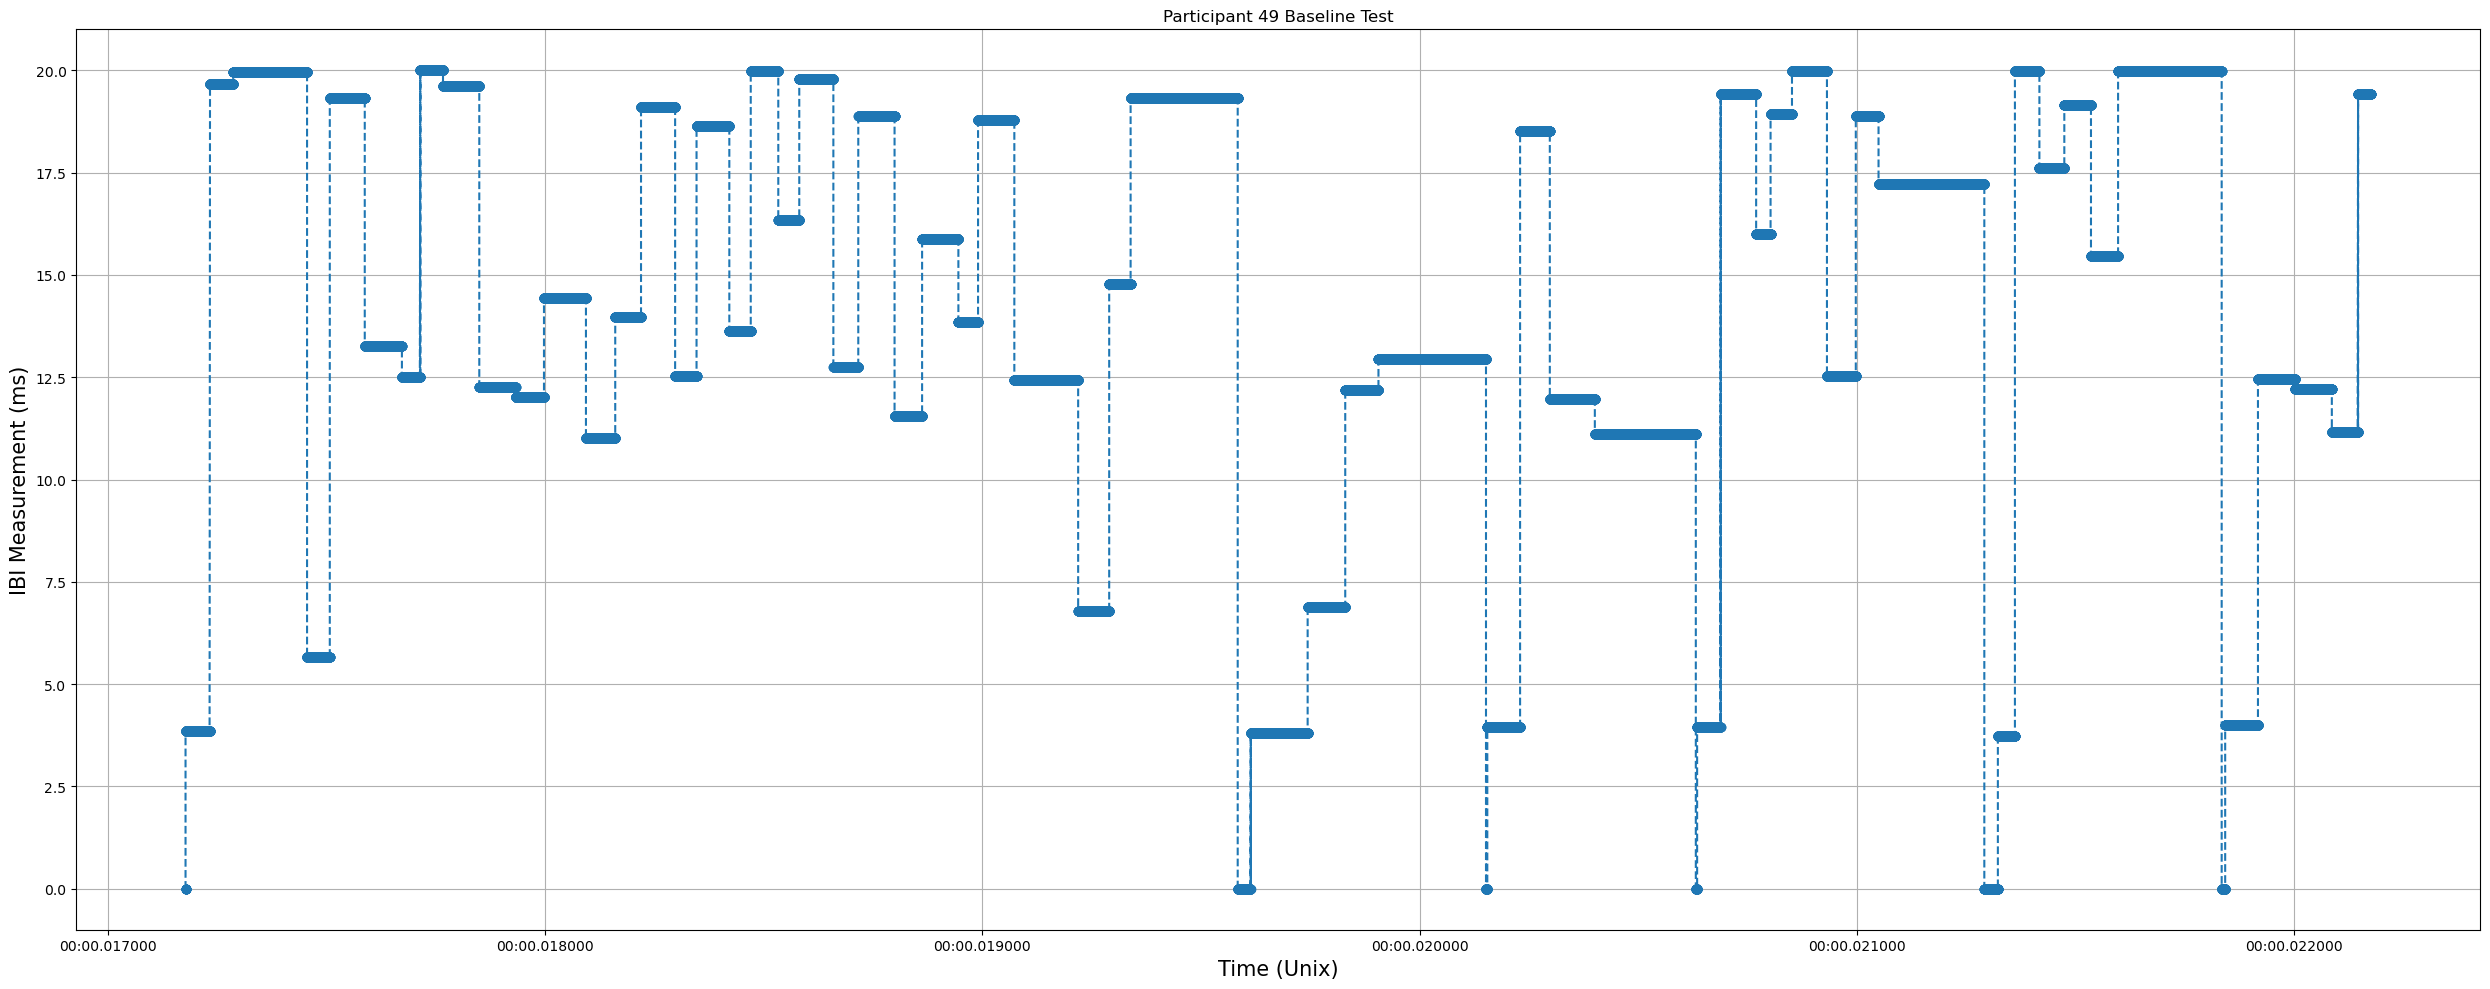

<Figure size 2500x1000 with 0 Axes>

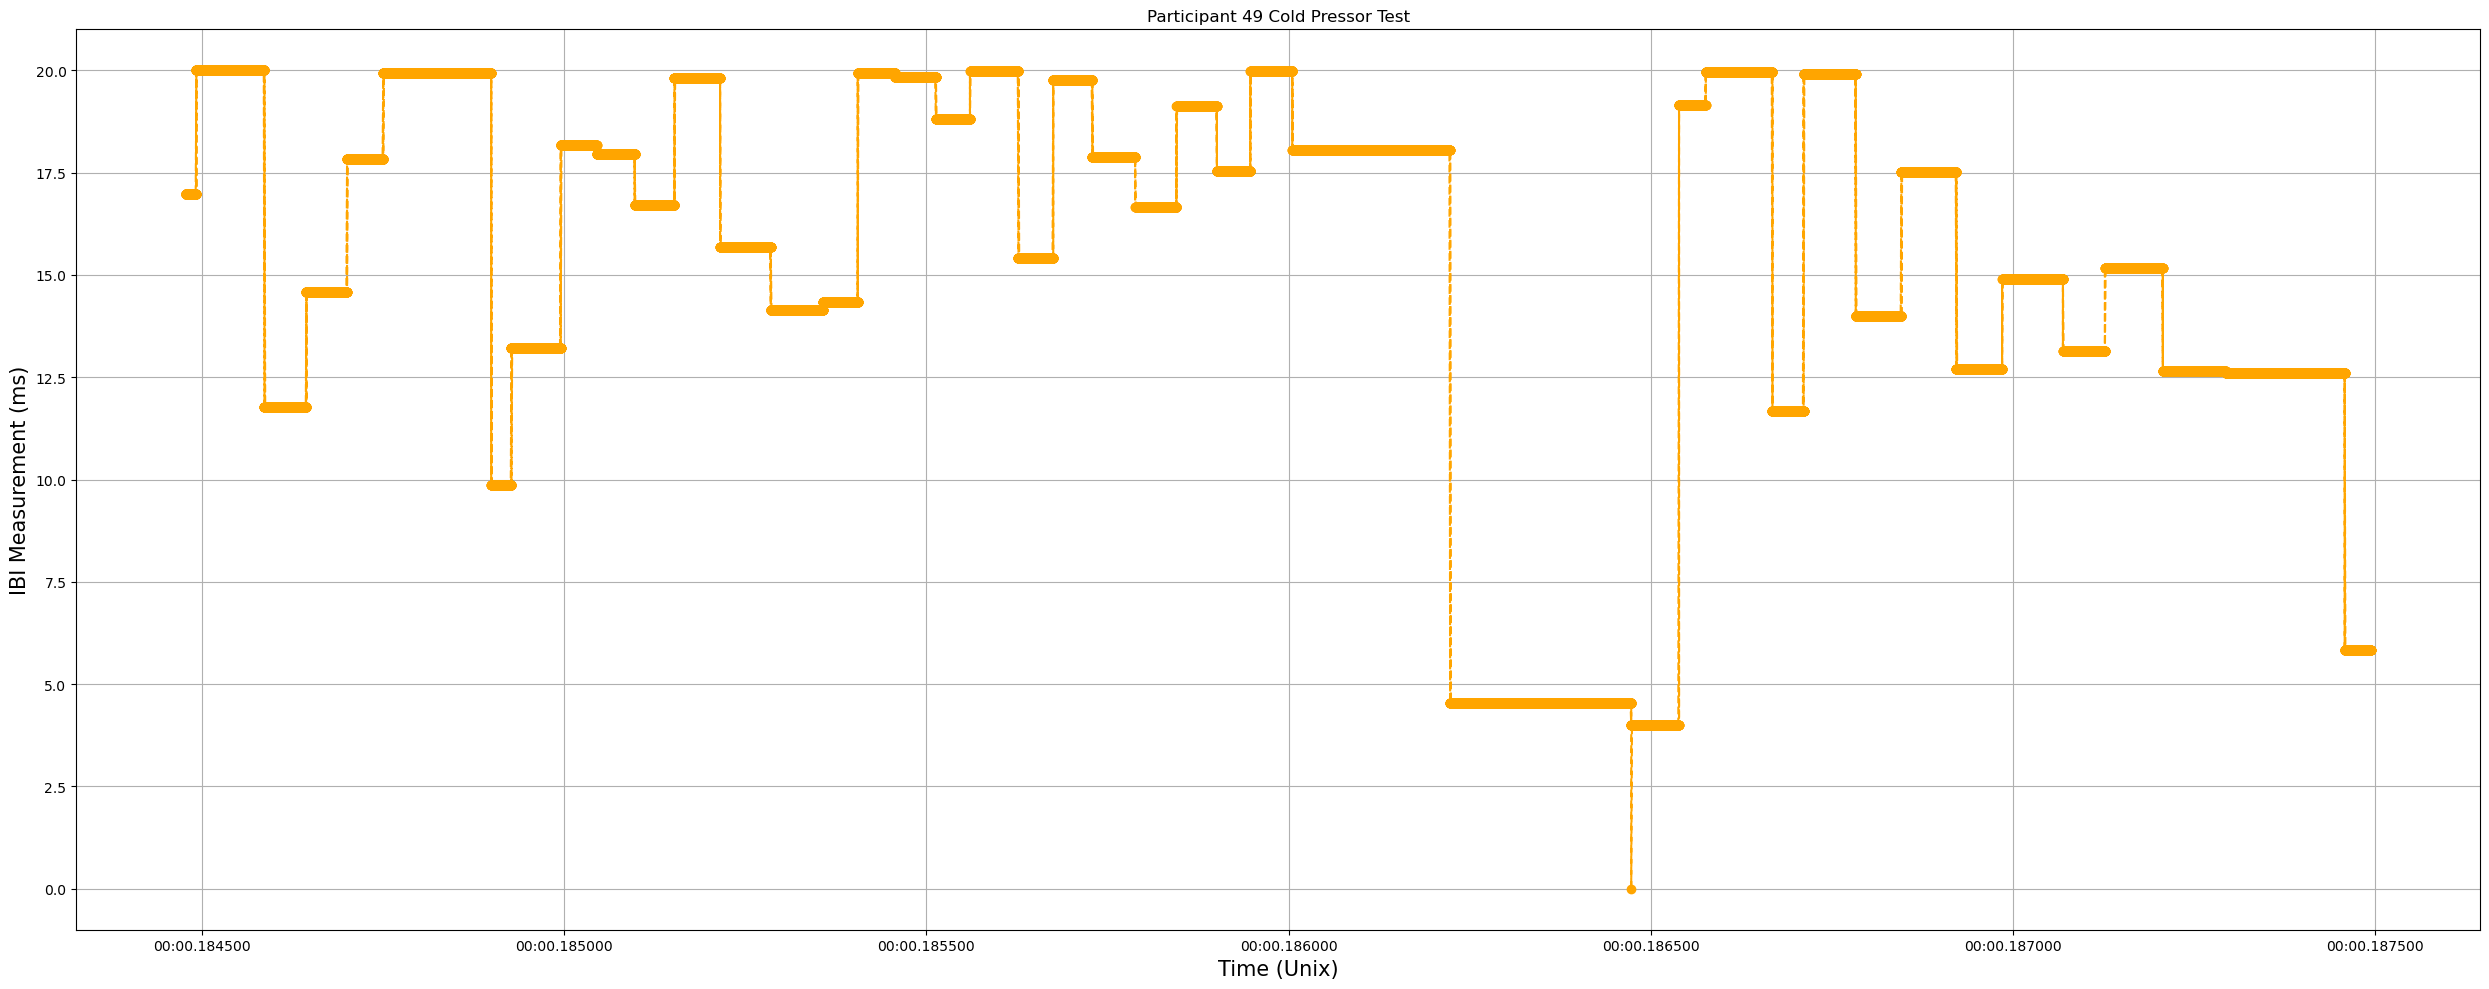

<Figure size 2500x1000 with 0 Axes>

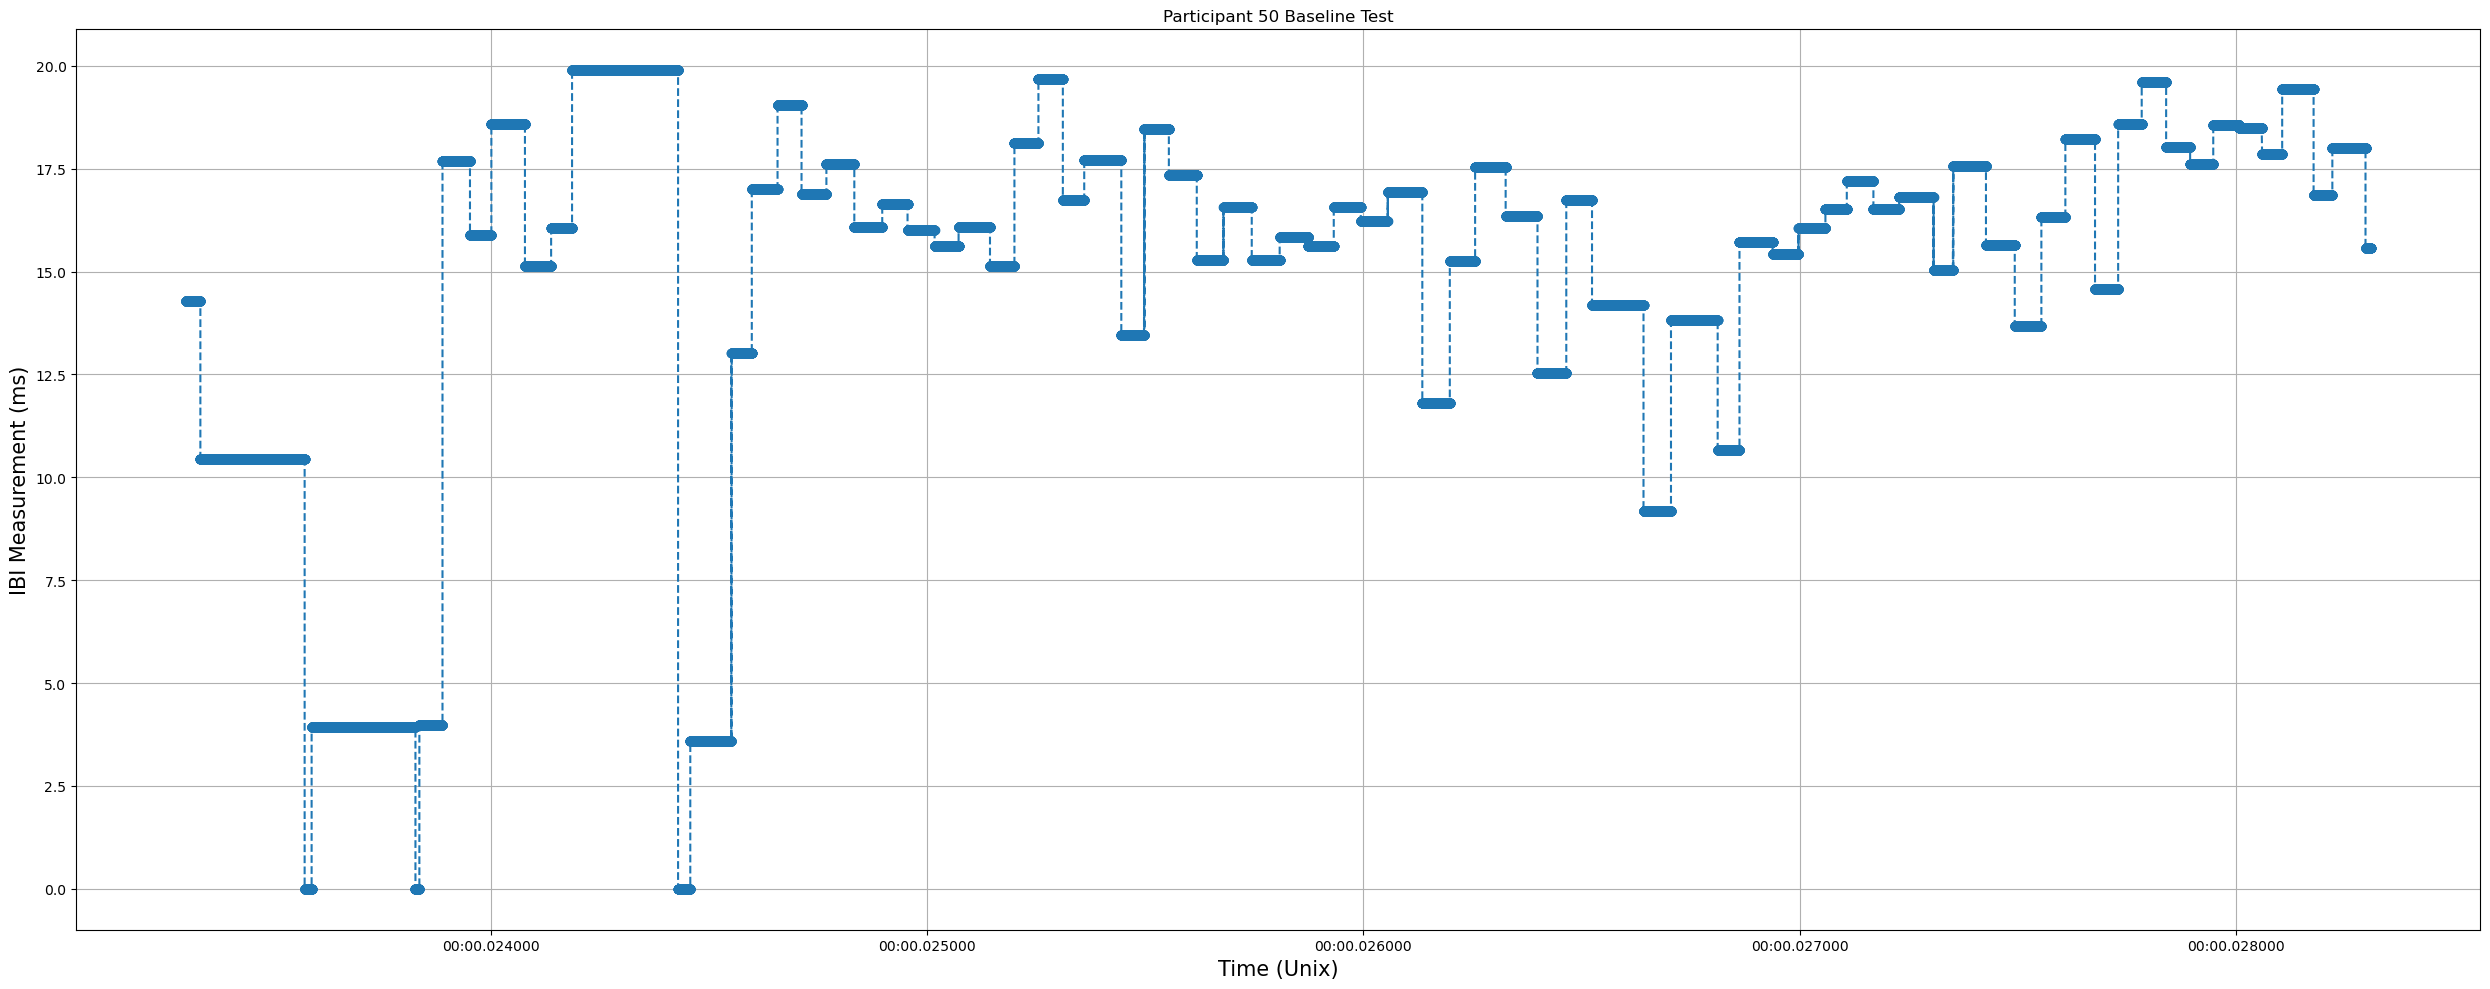

<Figure size 2500x1000 with 0 Axes>

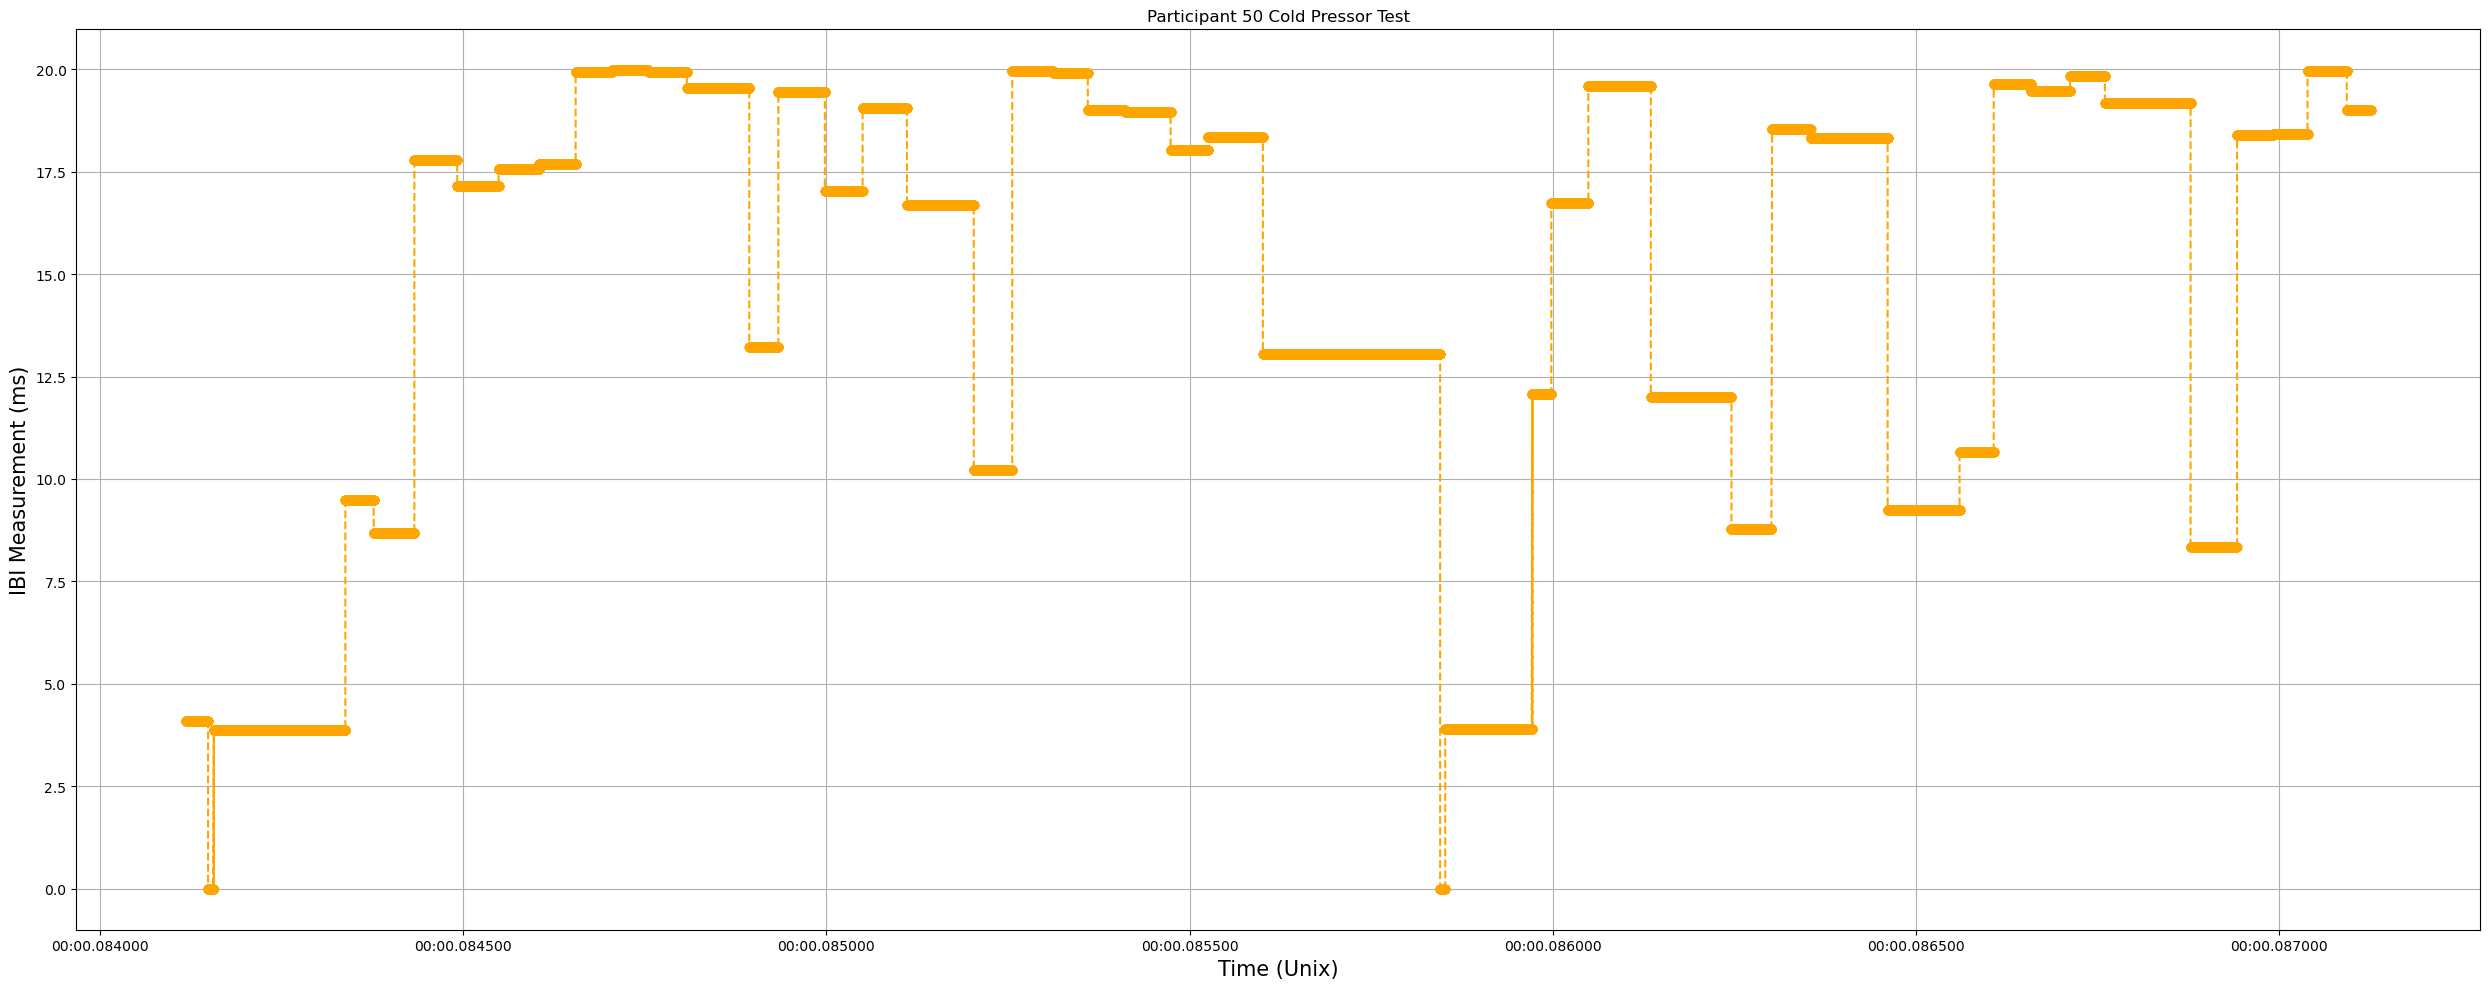

<Figure size 2500x1000 with 0 Axes>

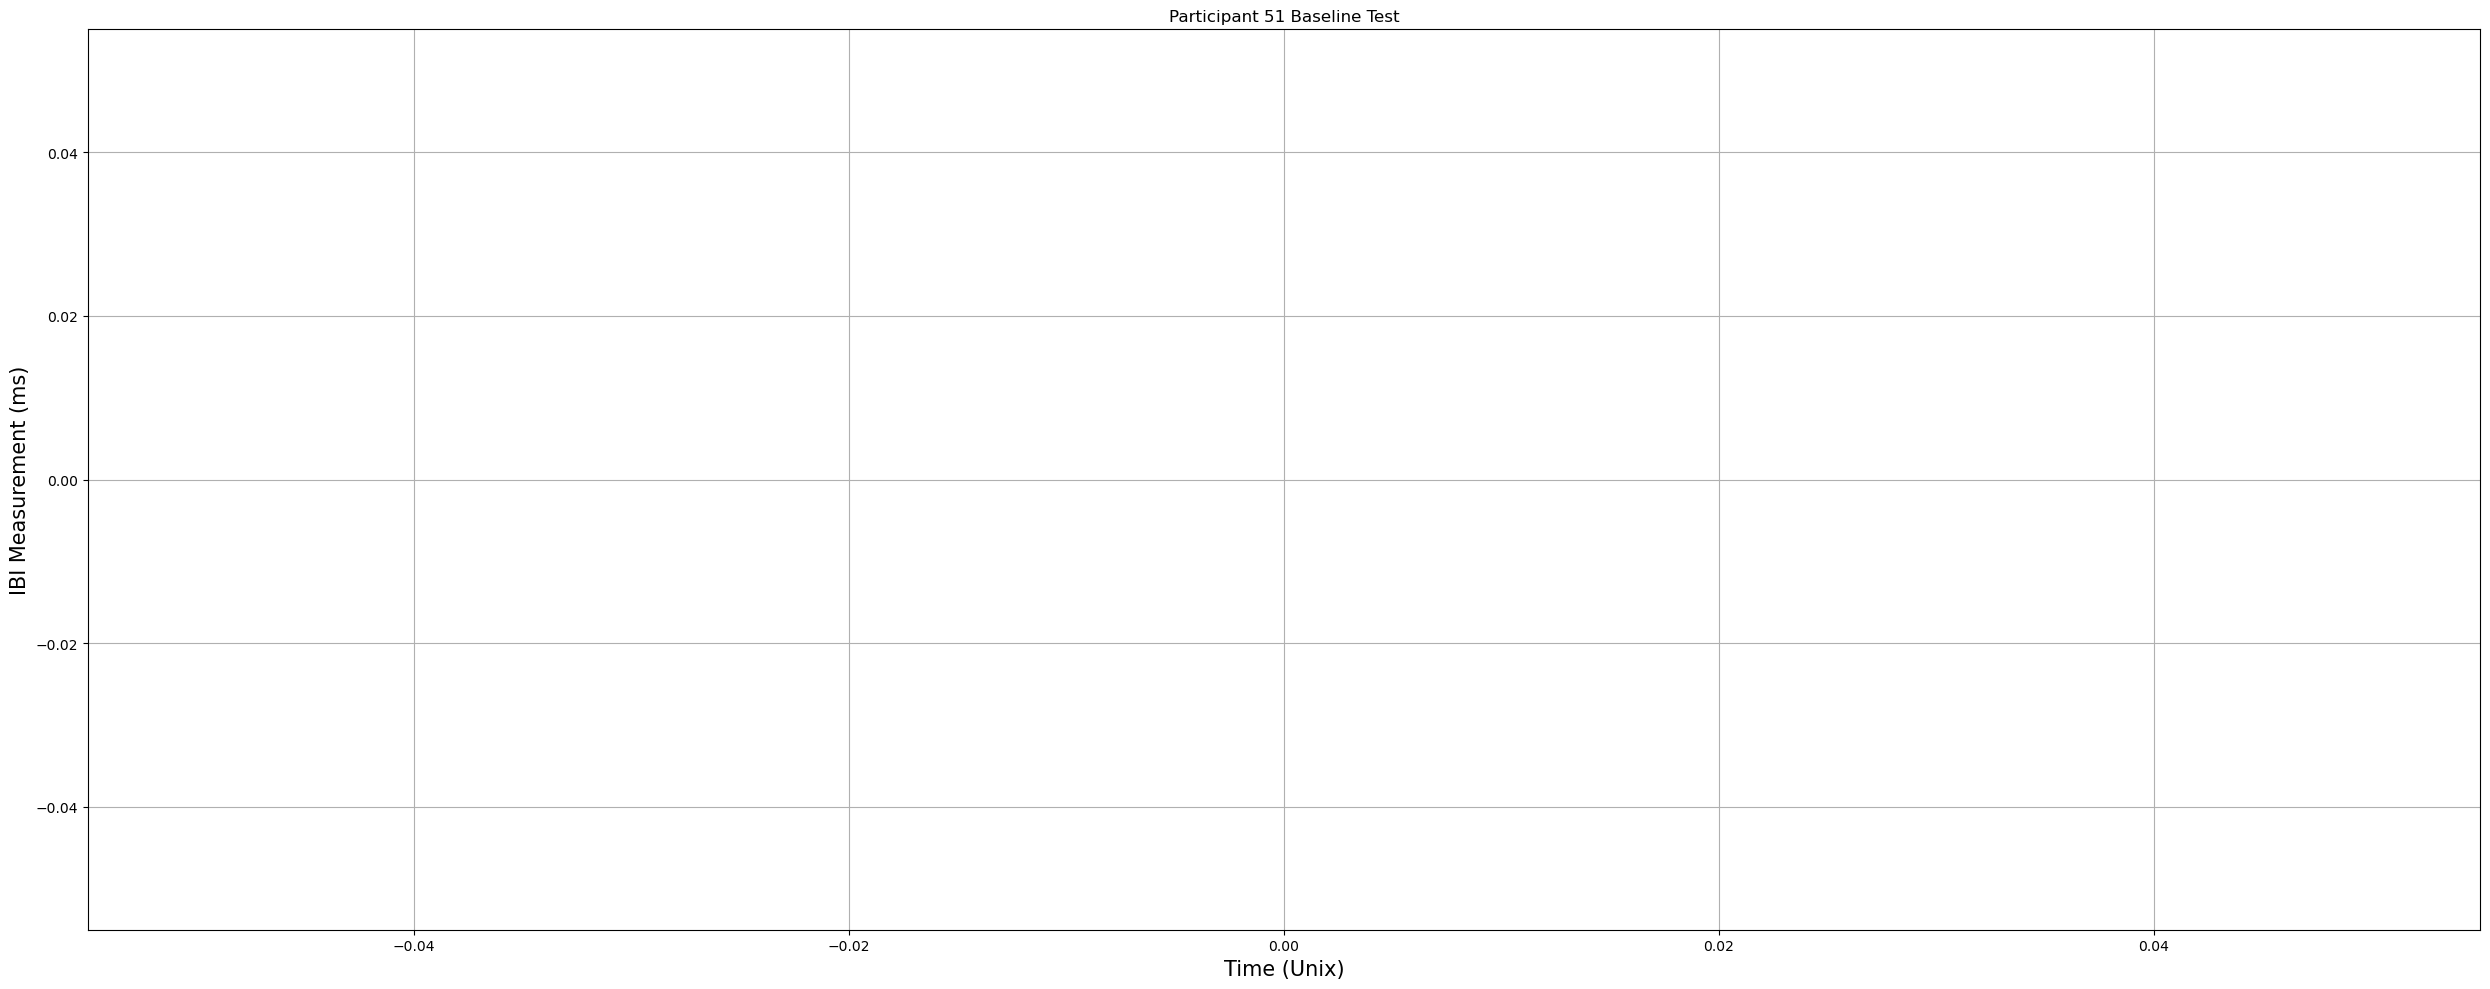

<Figure size 2500x1000 with 0 Axes>

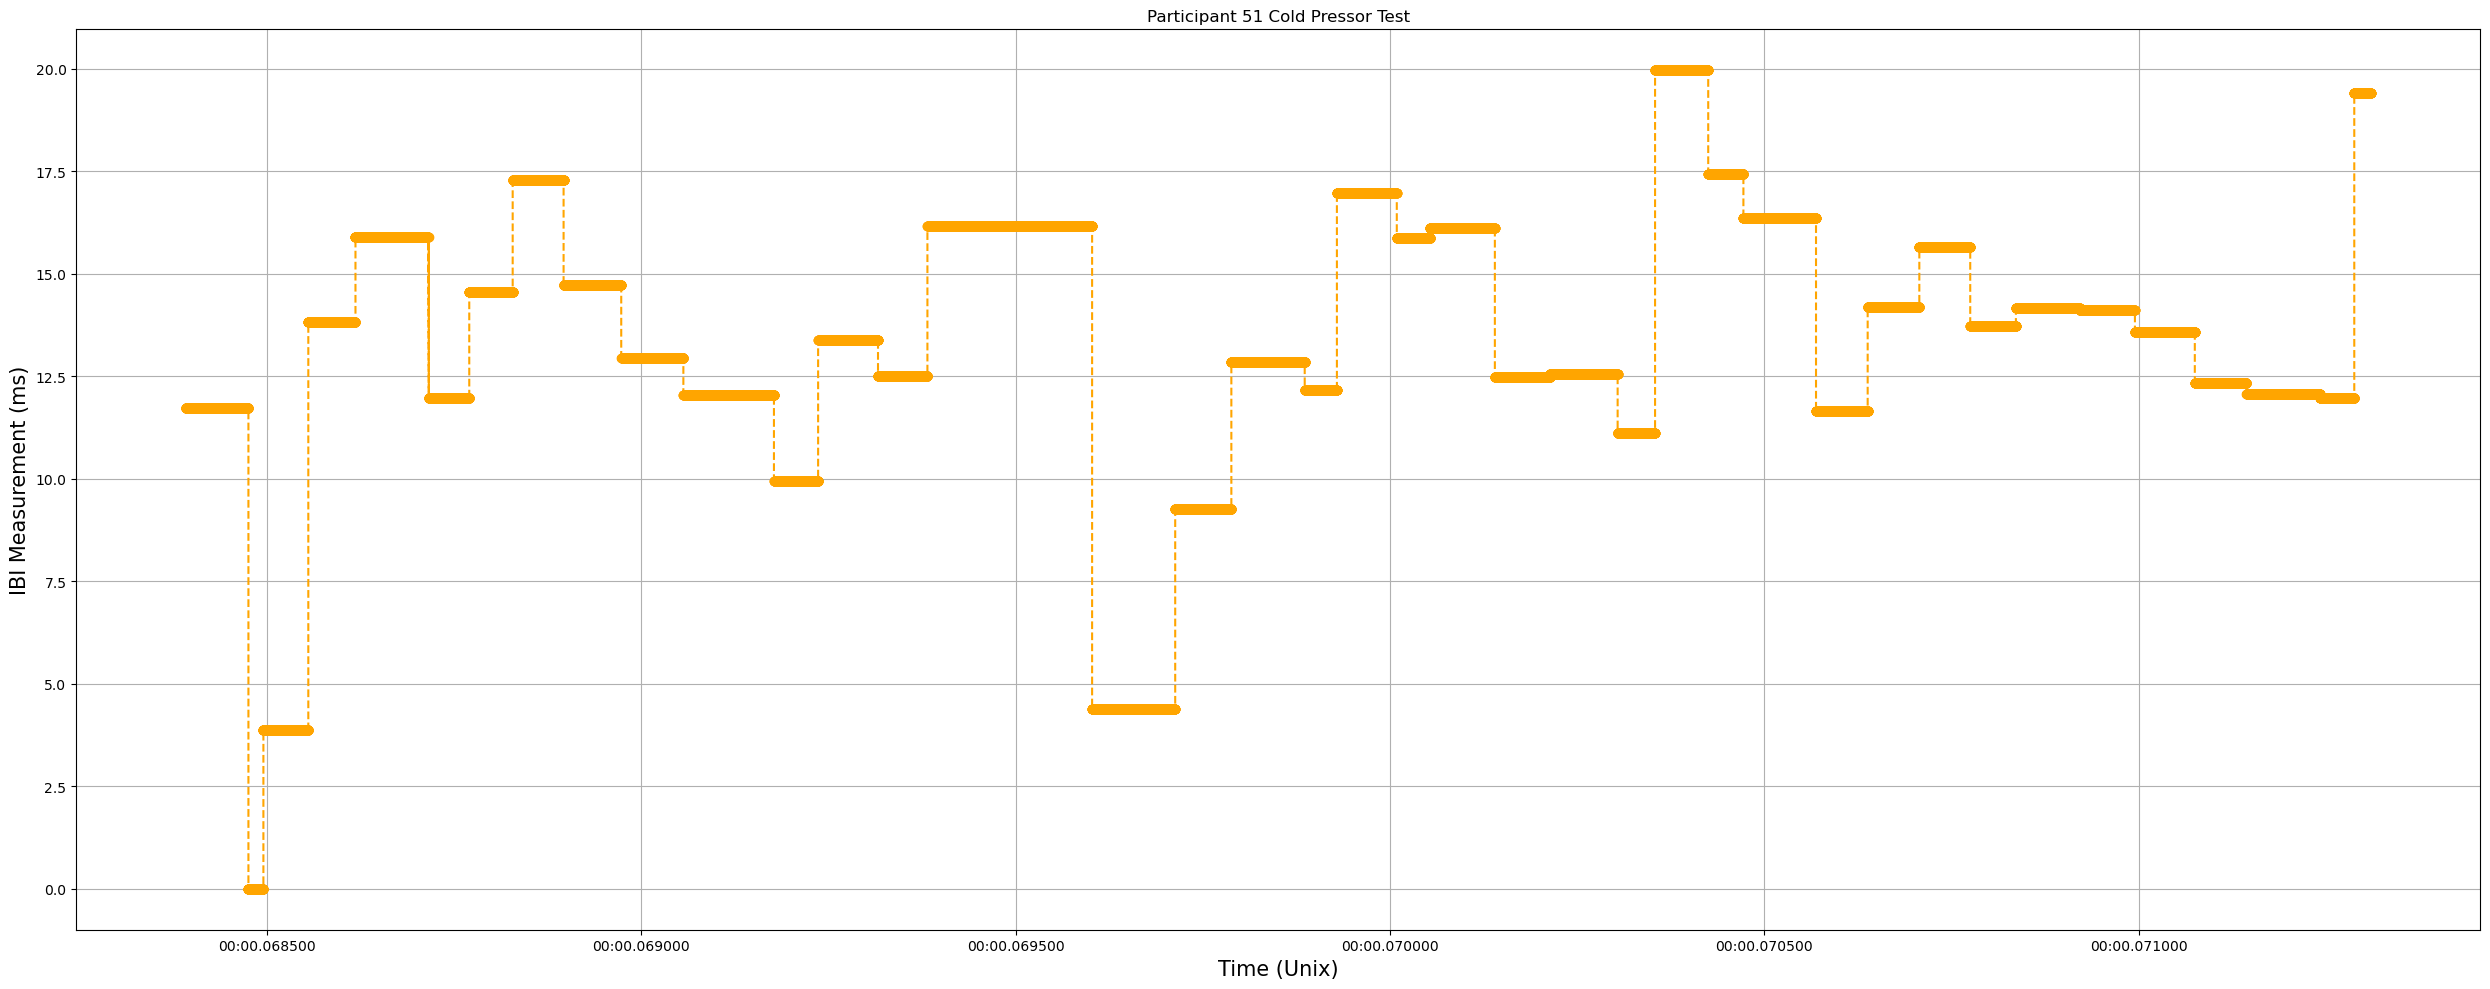

<Figure size 2500x1000 with 0 Axes>

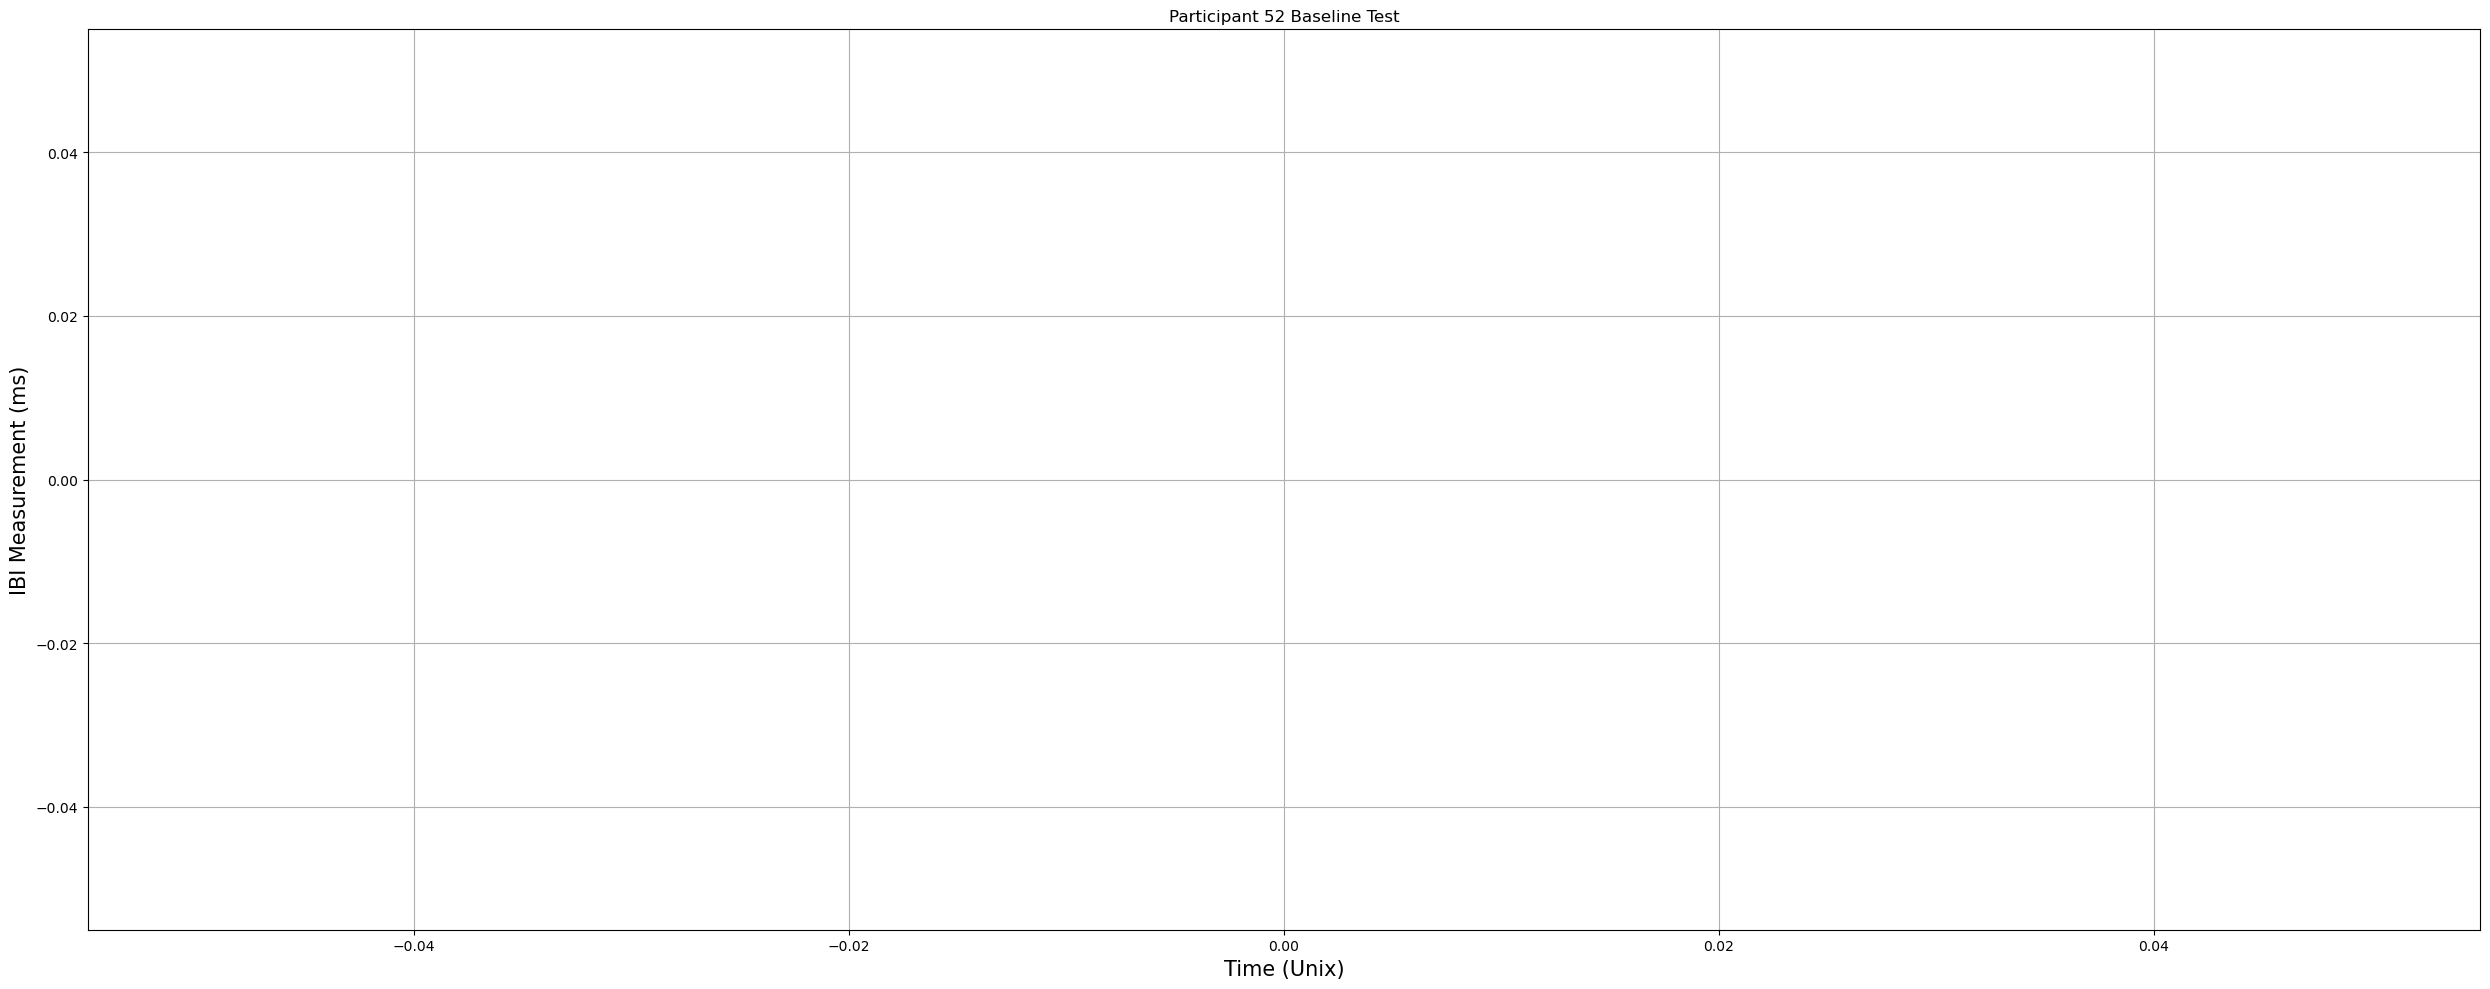

<Figure size 2500x1000 with 0 Axes>

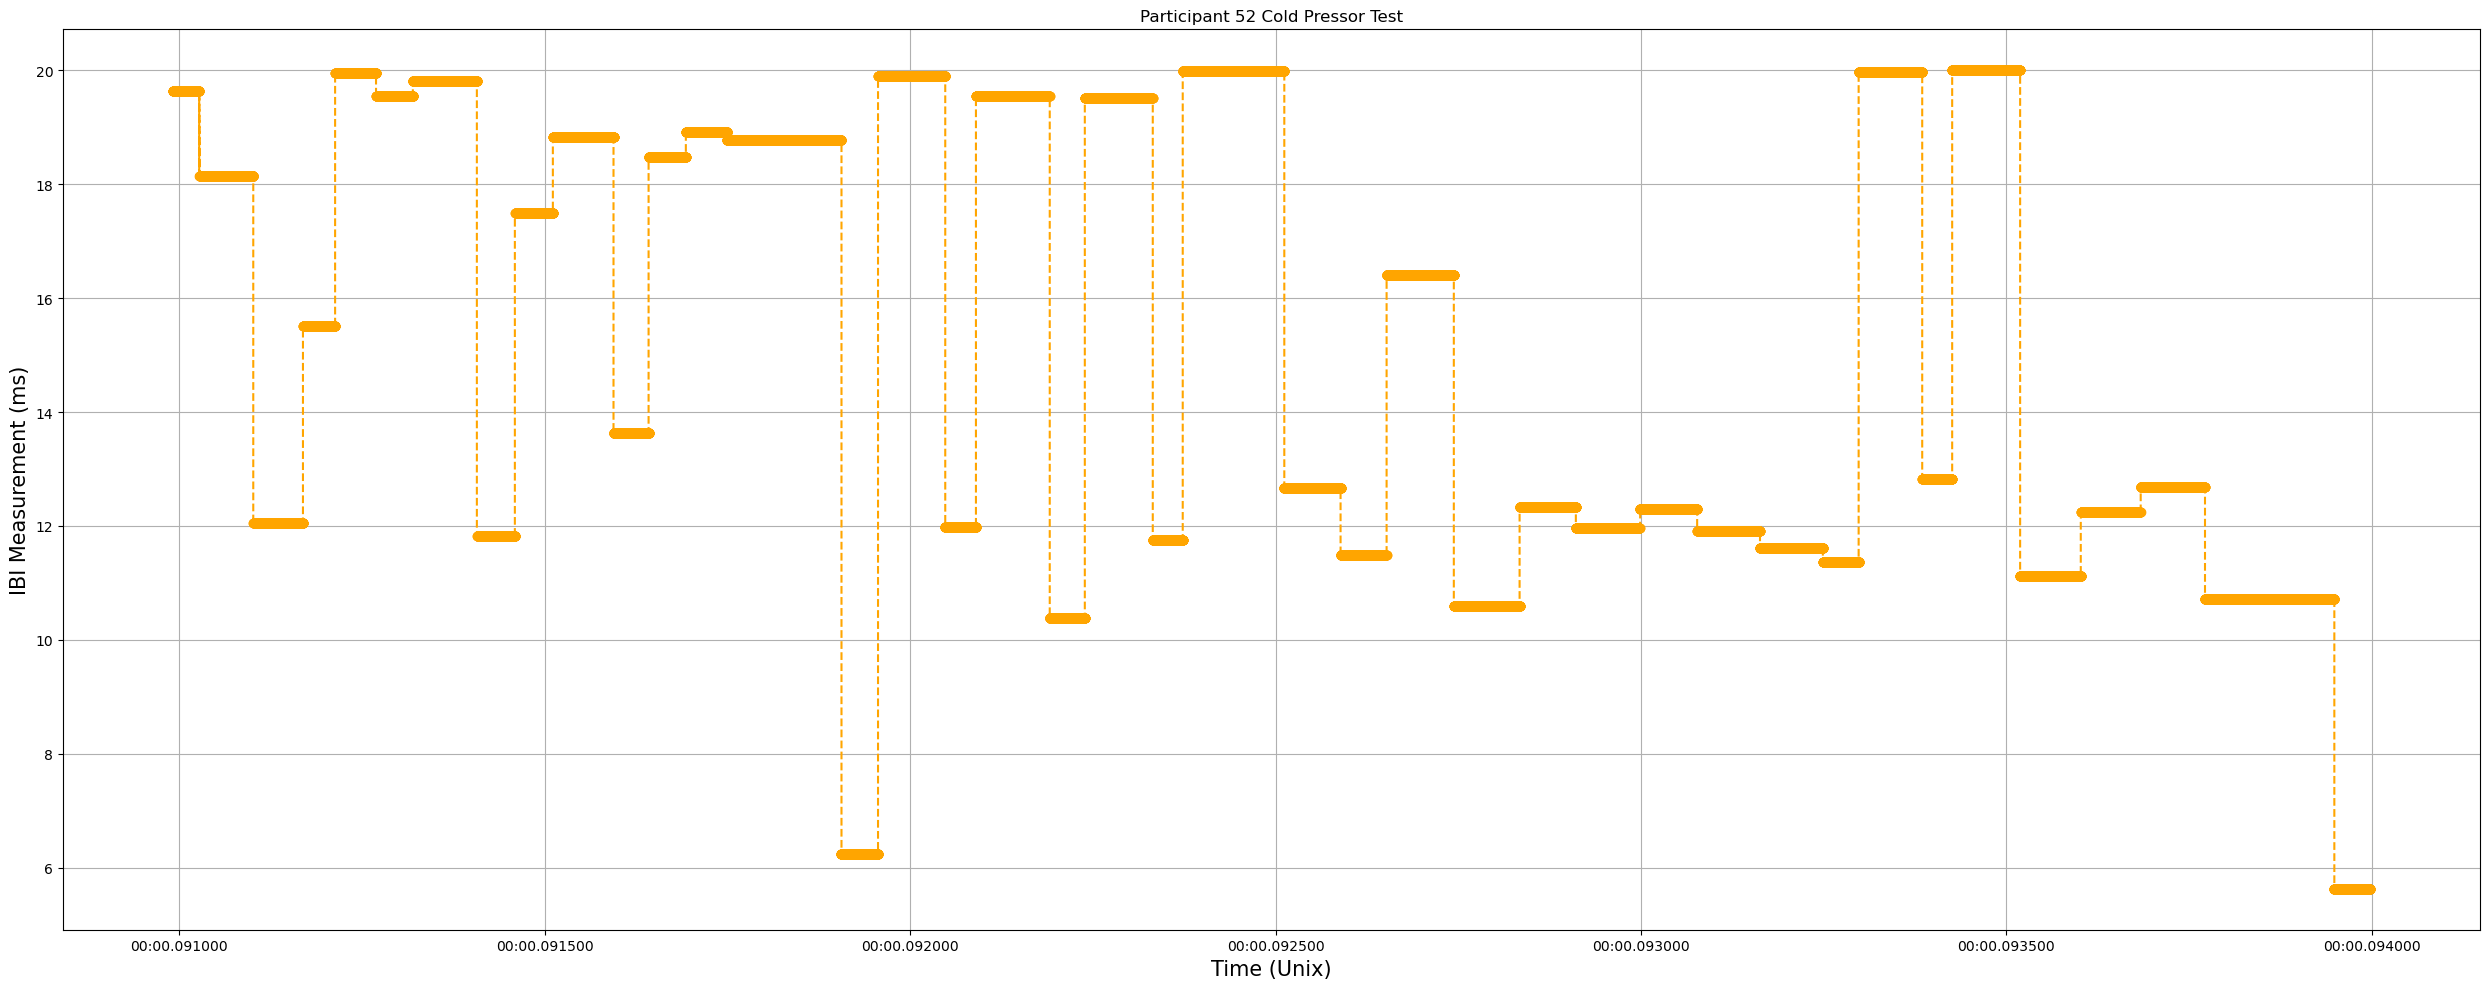

<Figure size 2500x1000 with 0 Axes>

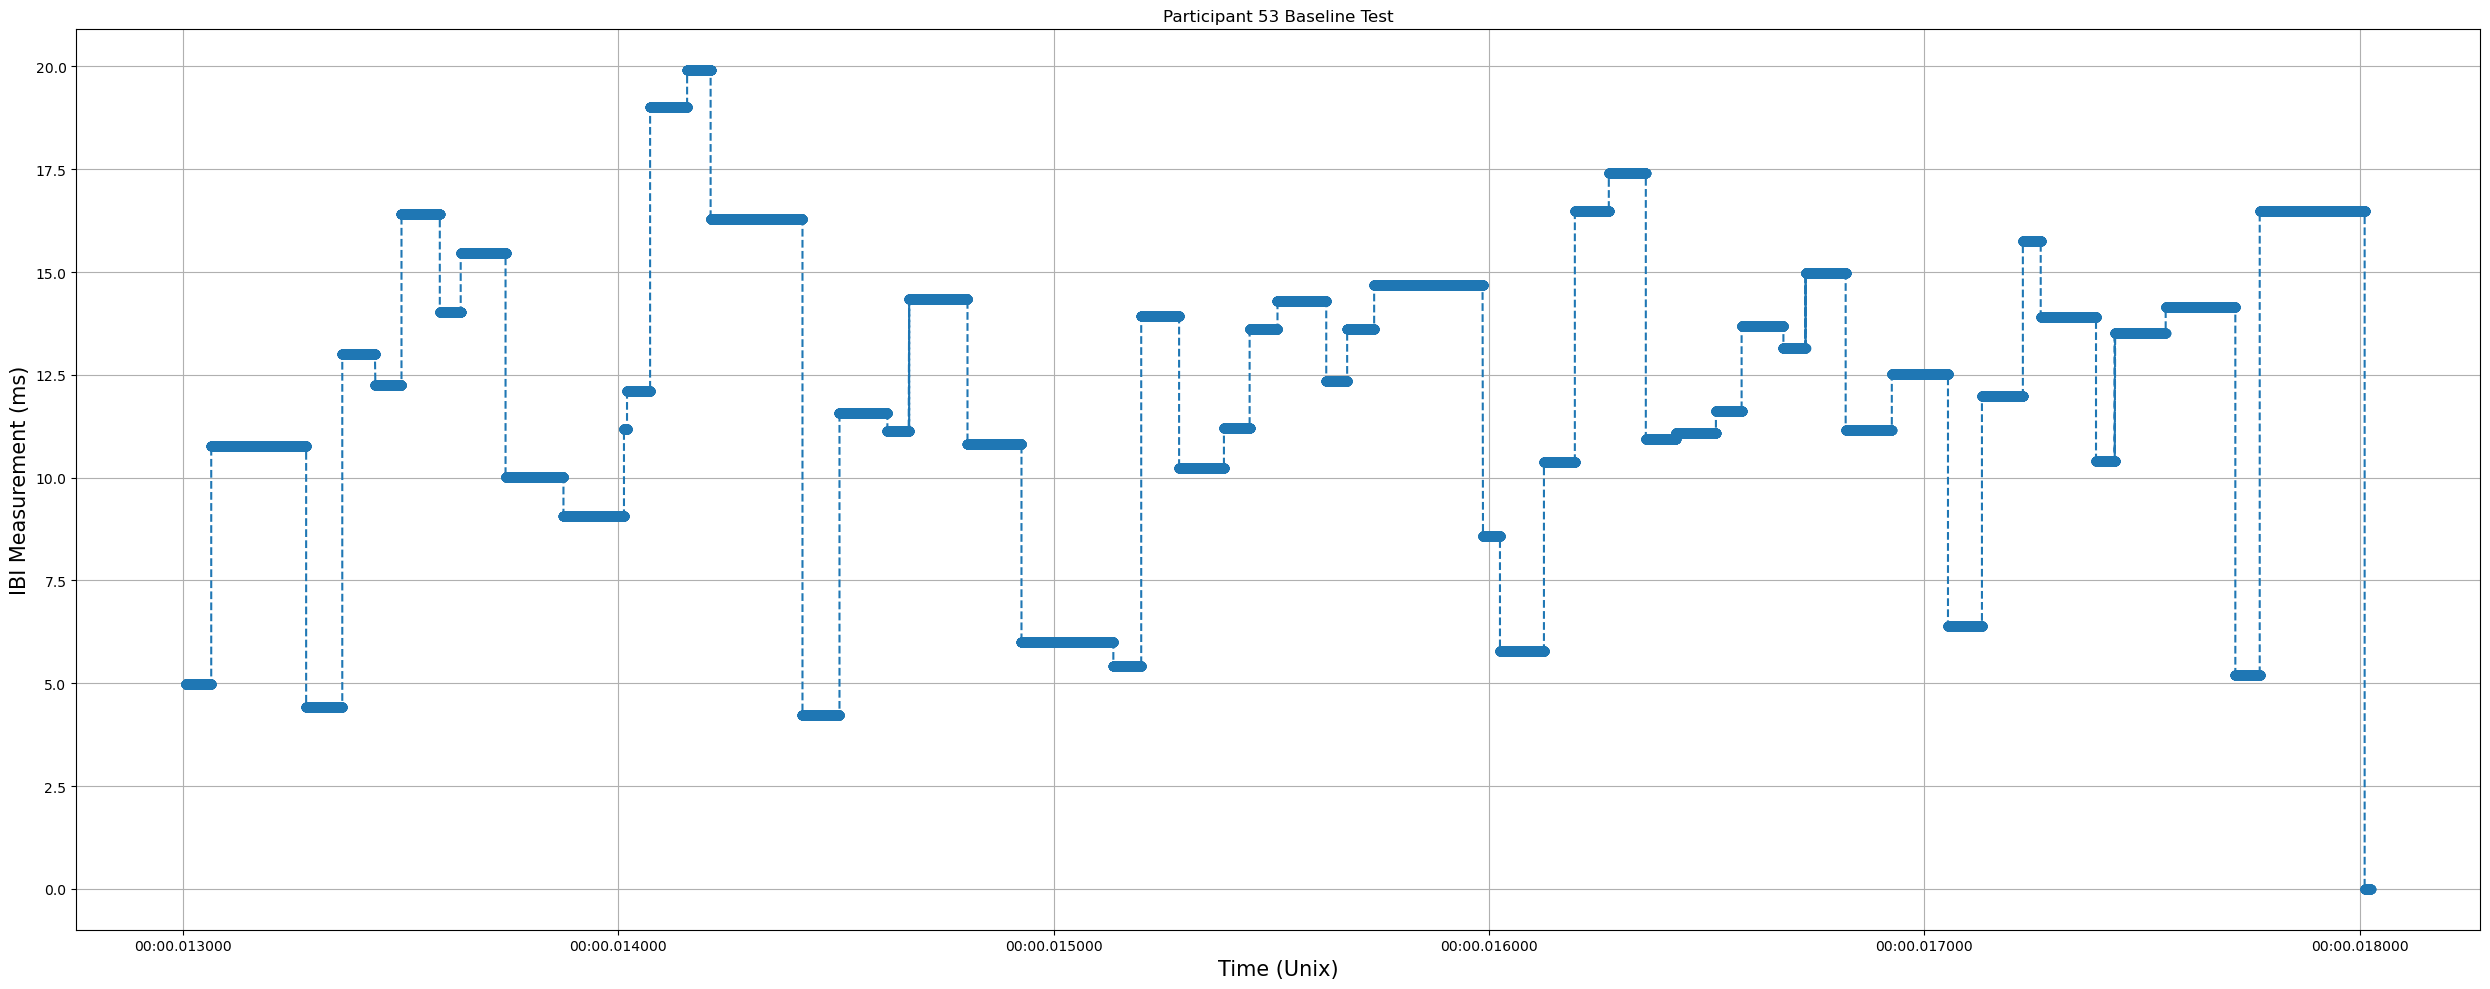

<Figure size 2500x1000 with 0 Axes>

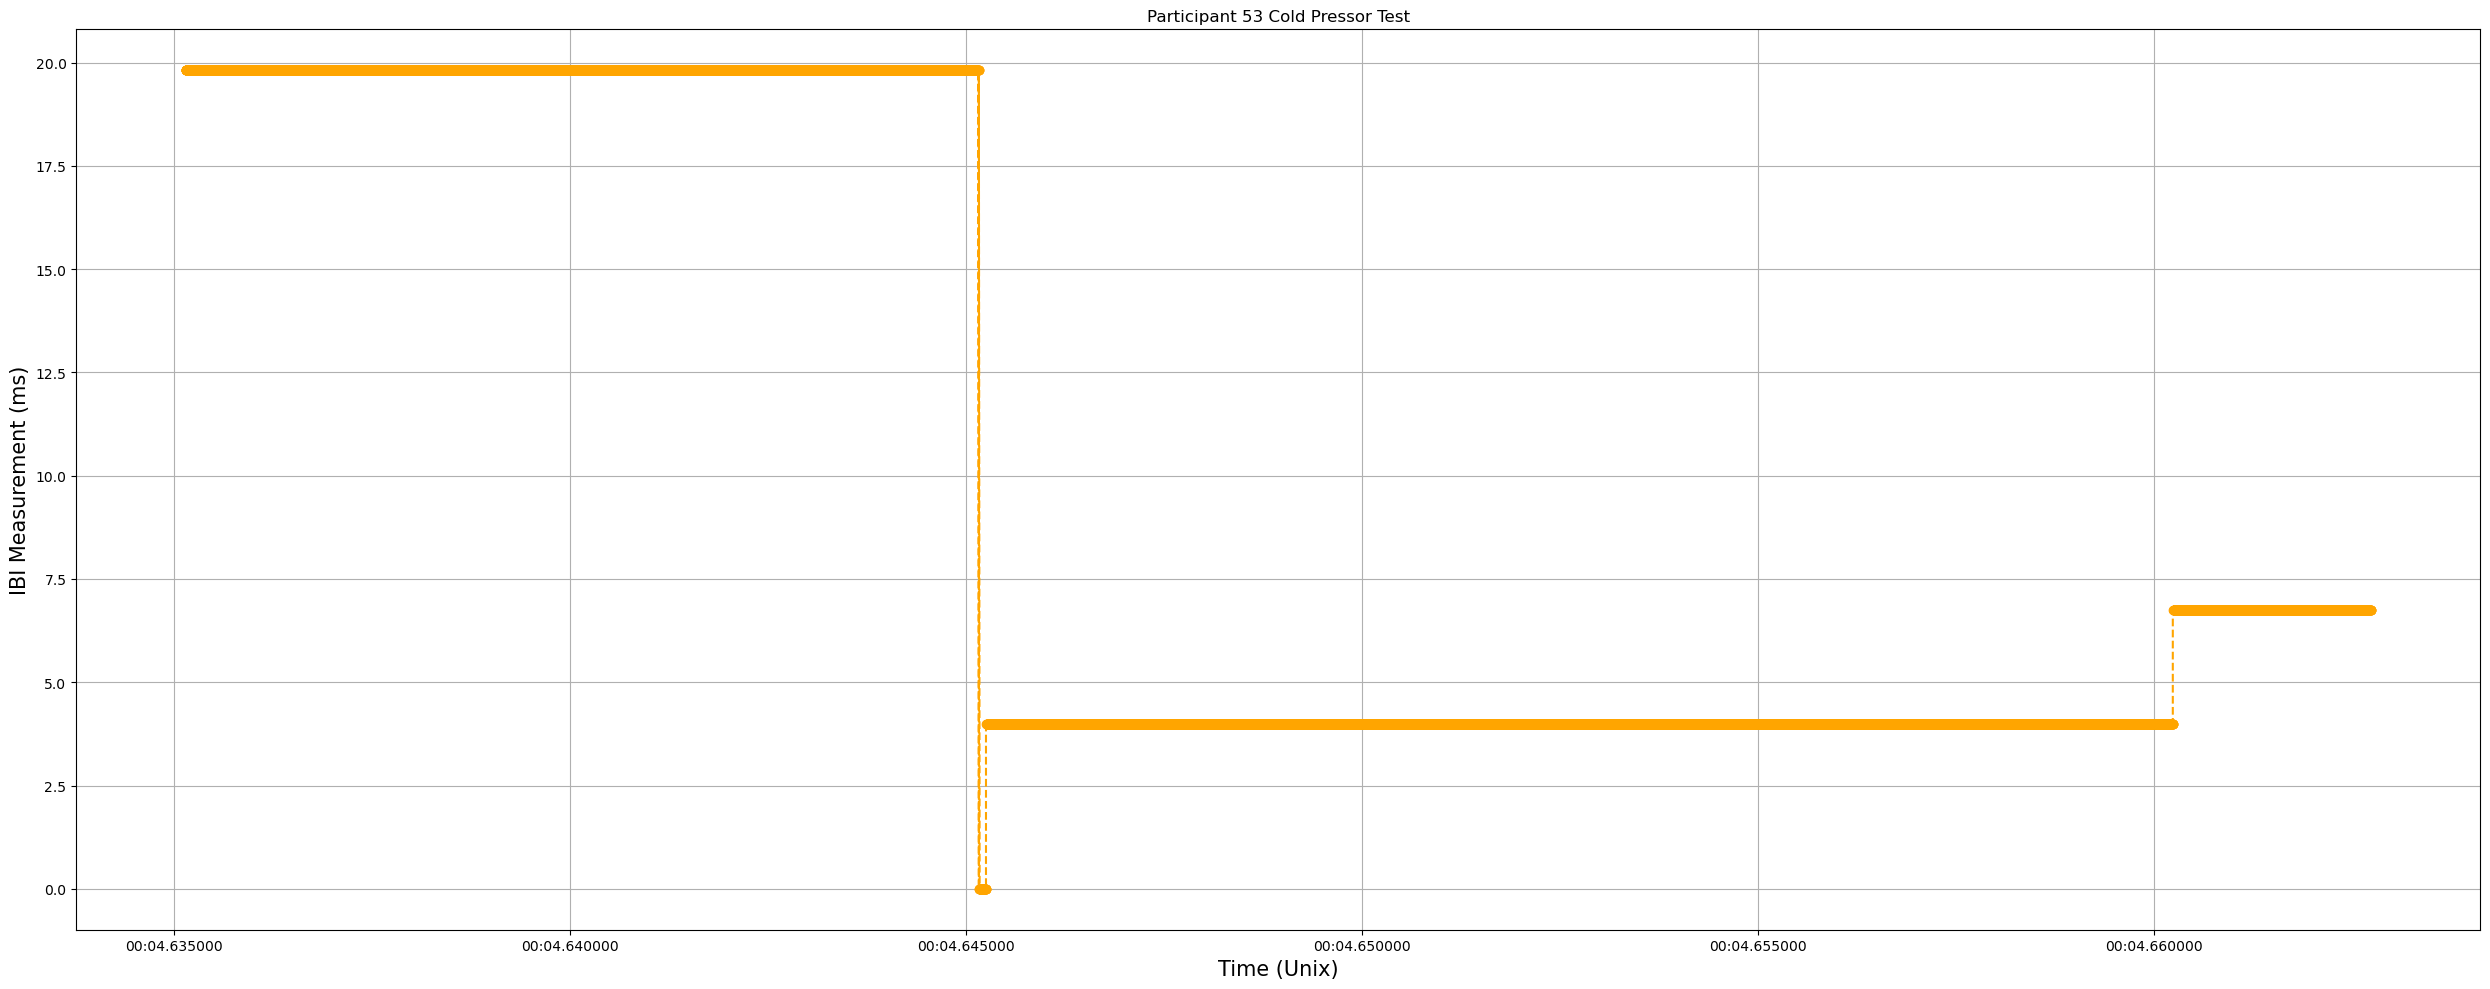

<Figure size 2500x1000 with 0 Axes>

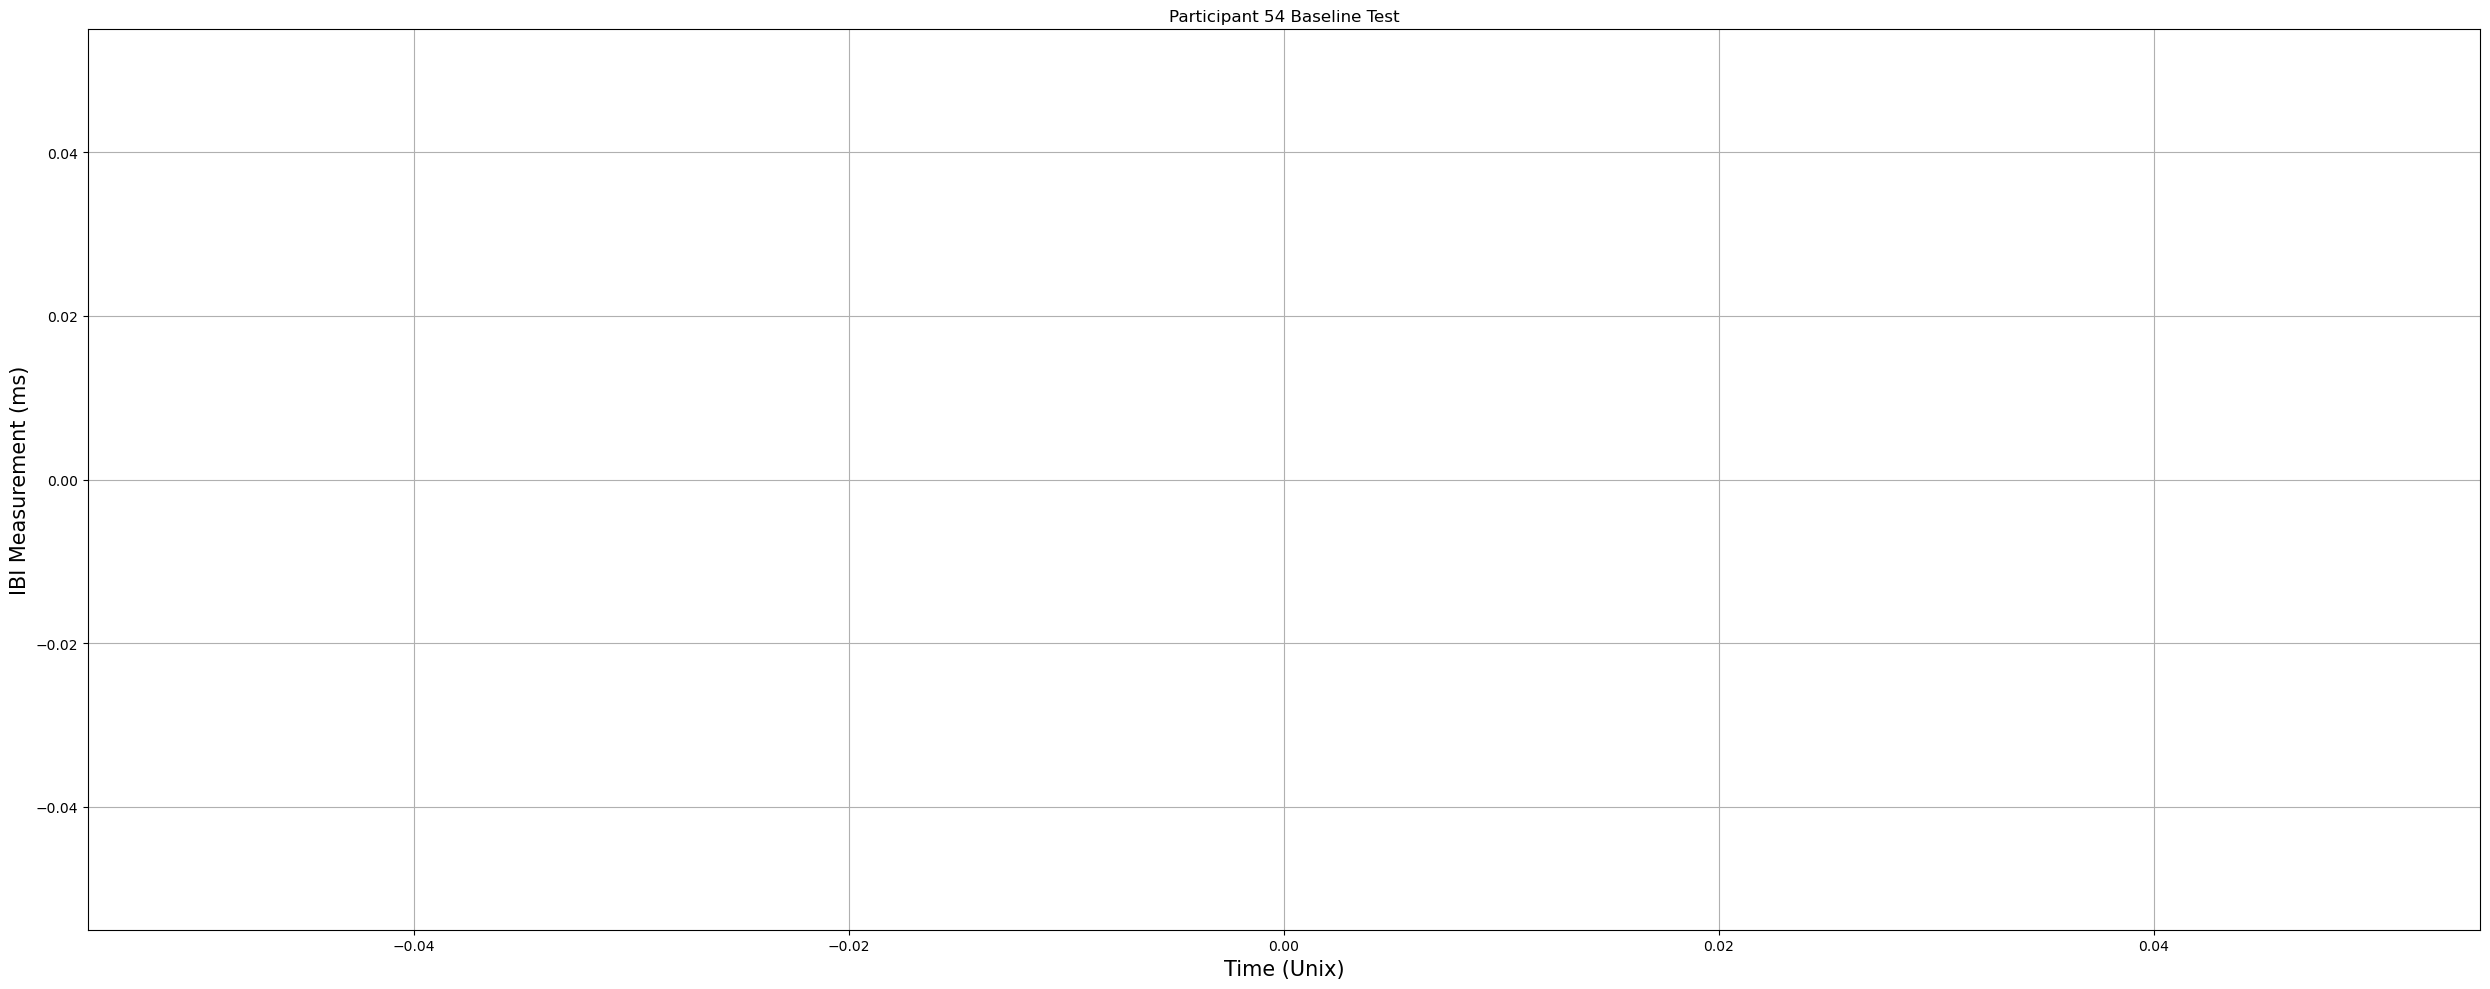

<Figure size 2500x1000 with 0 Axes>

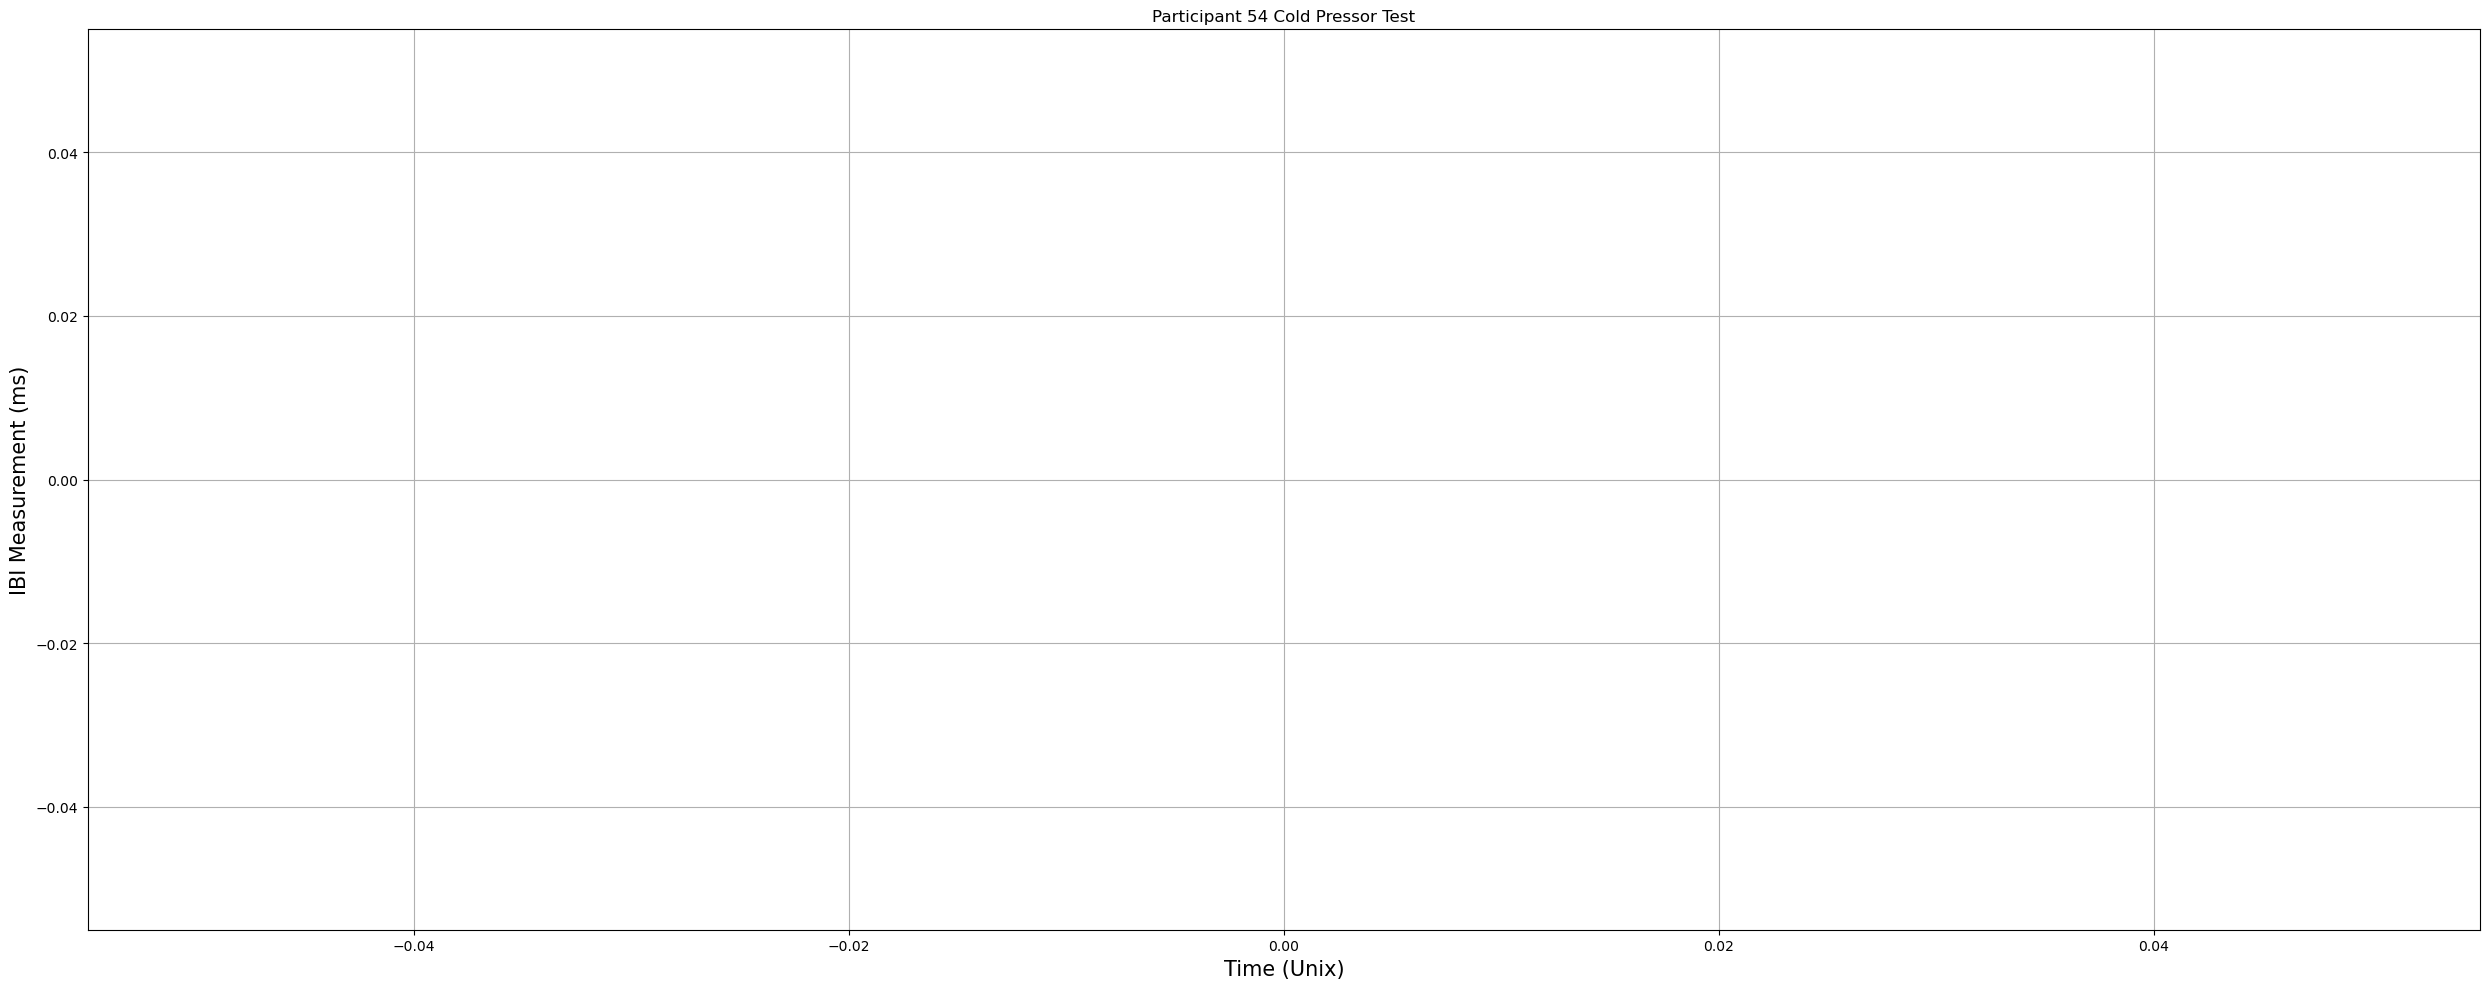

<Figure size 2500x1000 with 0 Axes>

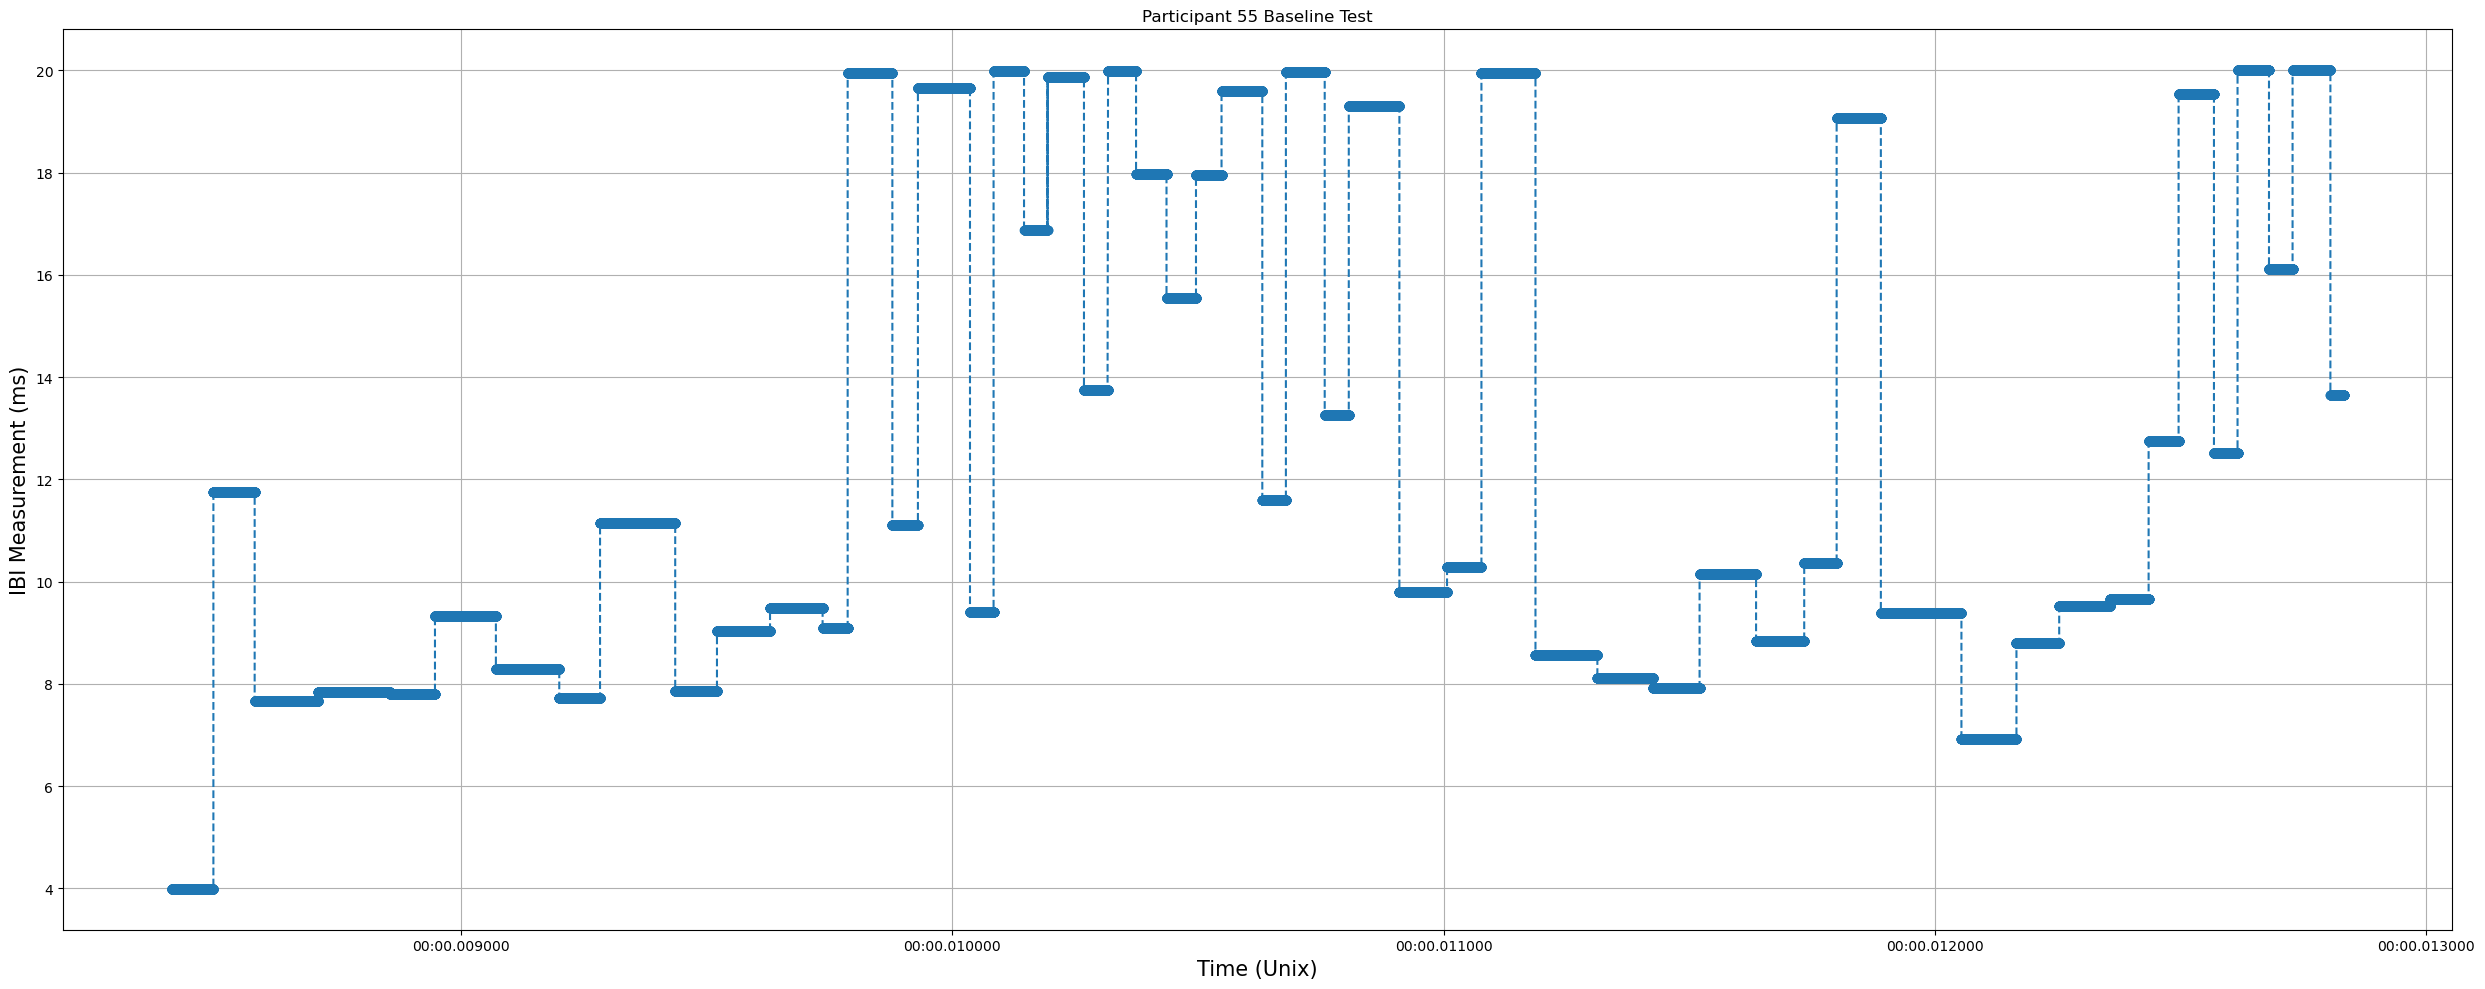

<Figure size 2500x1000 with 0 Axes>

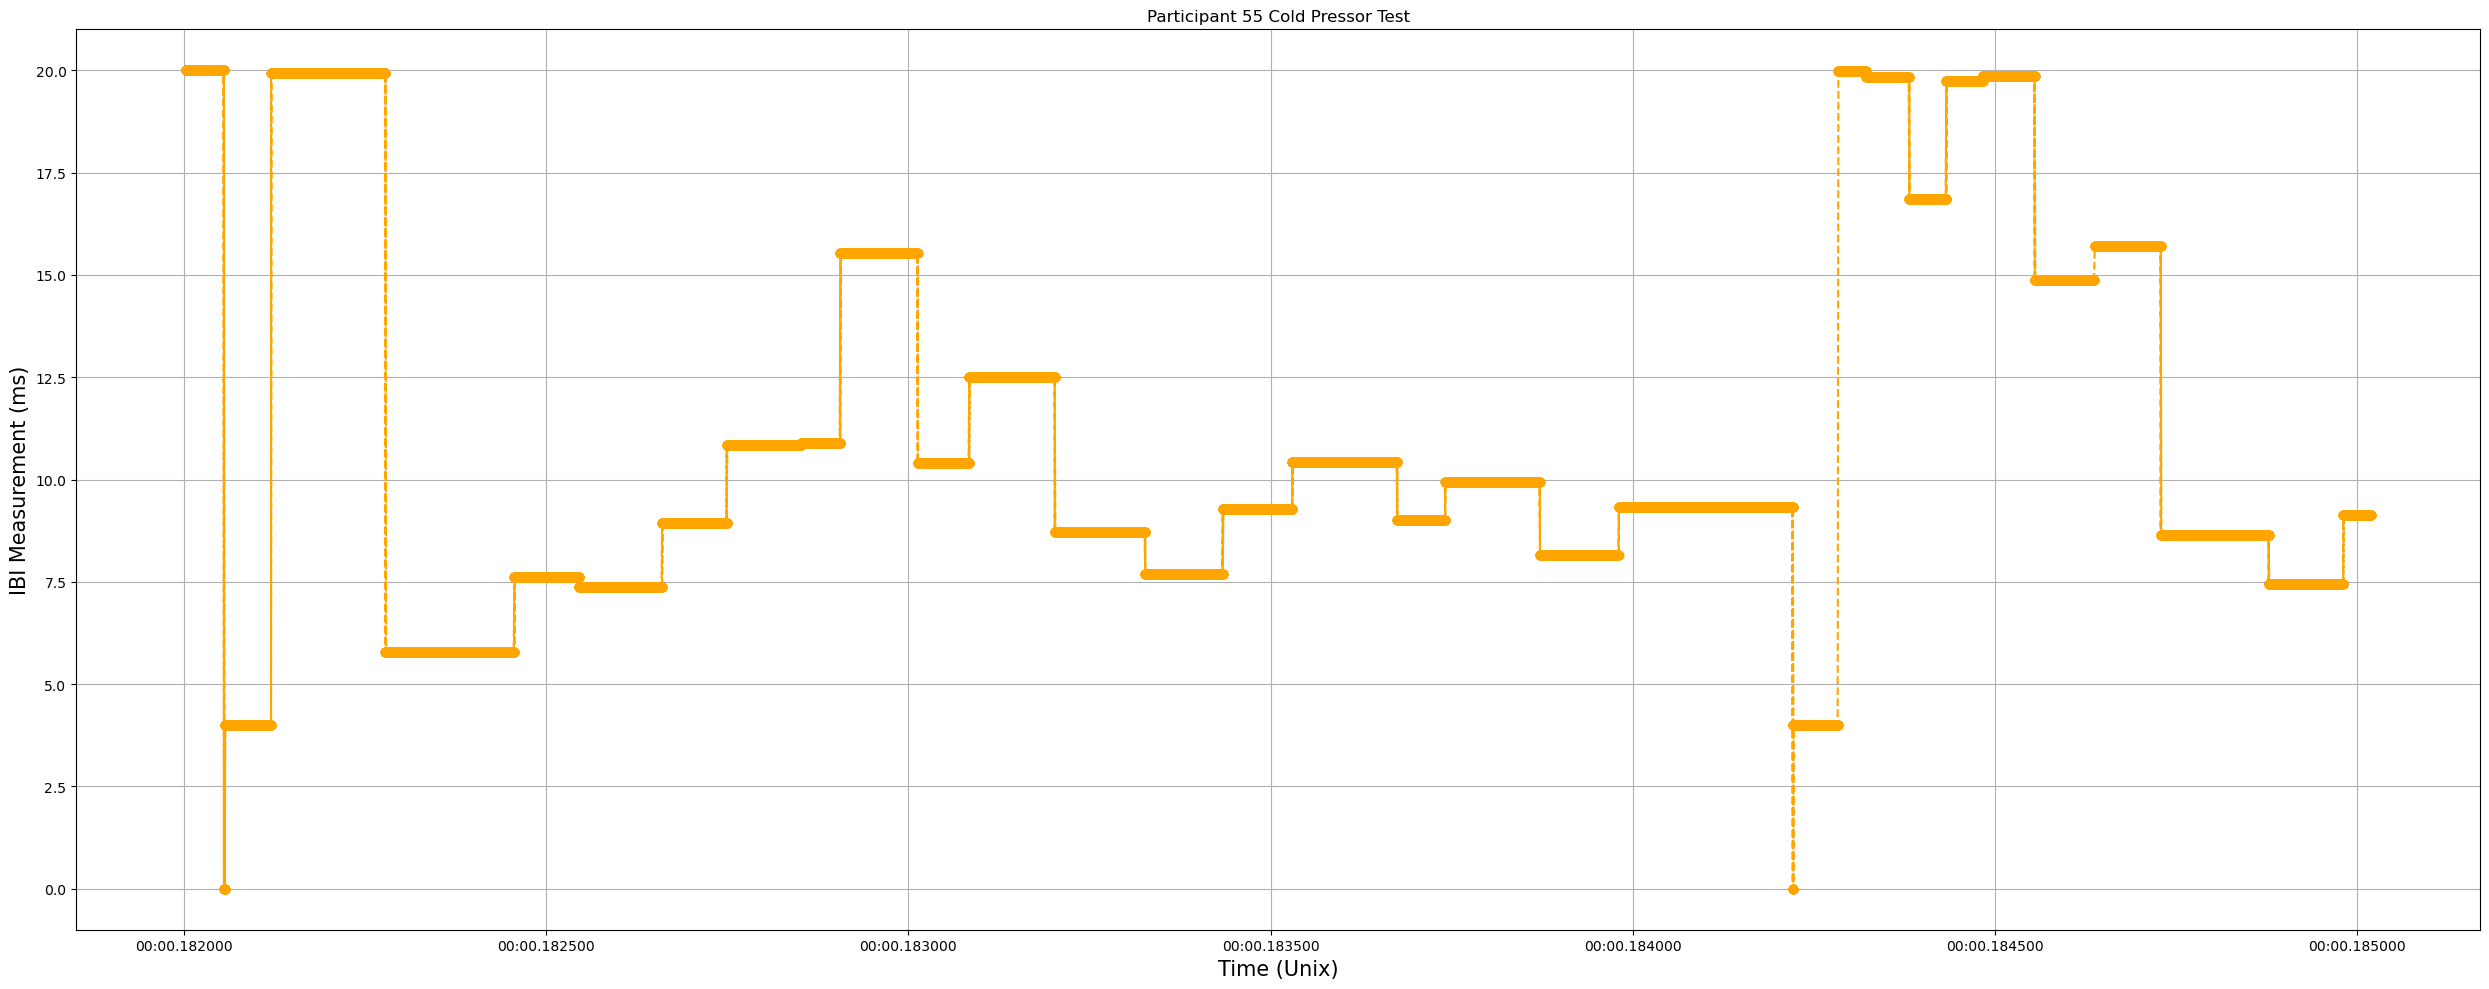

<Figure size 2500x1000 with 0 Axes>

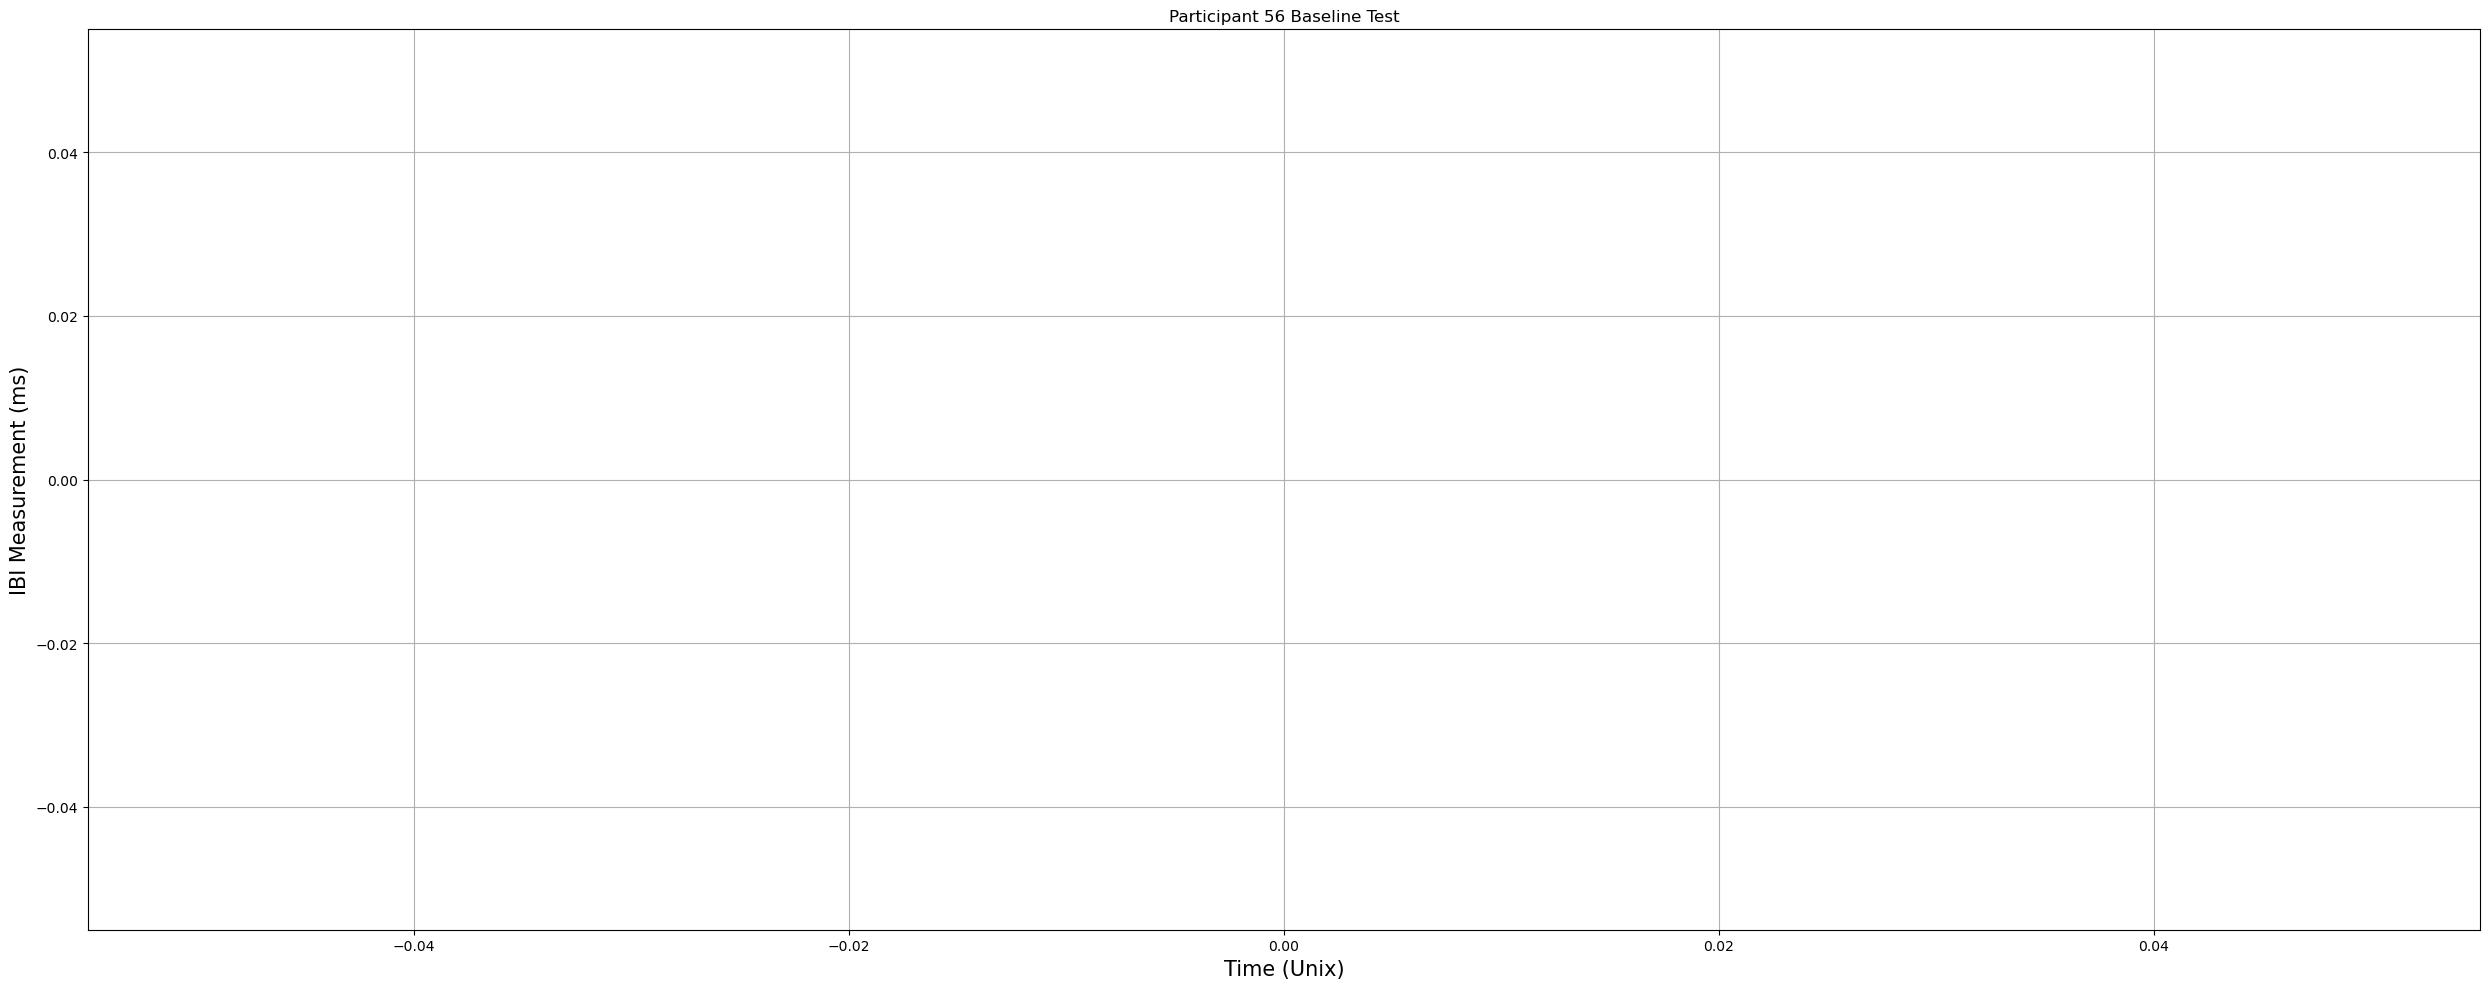

<Figure size 2500x1000 with 0 Axes>

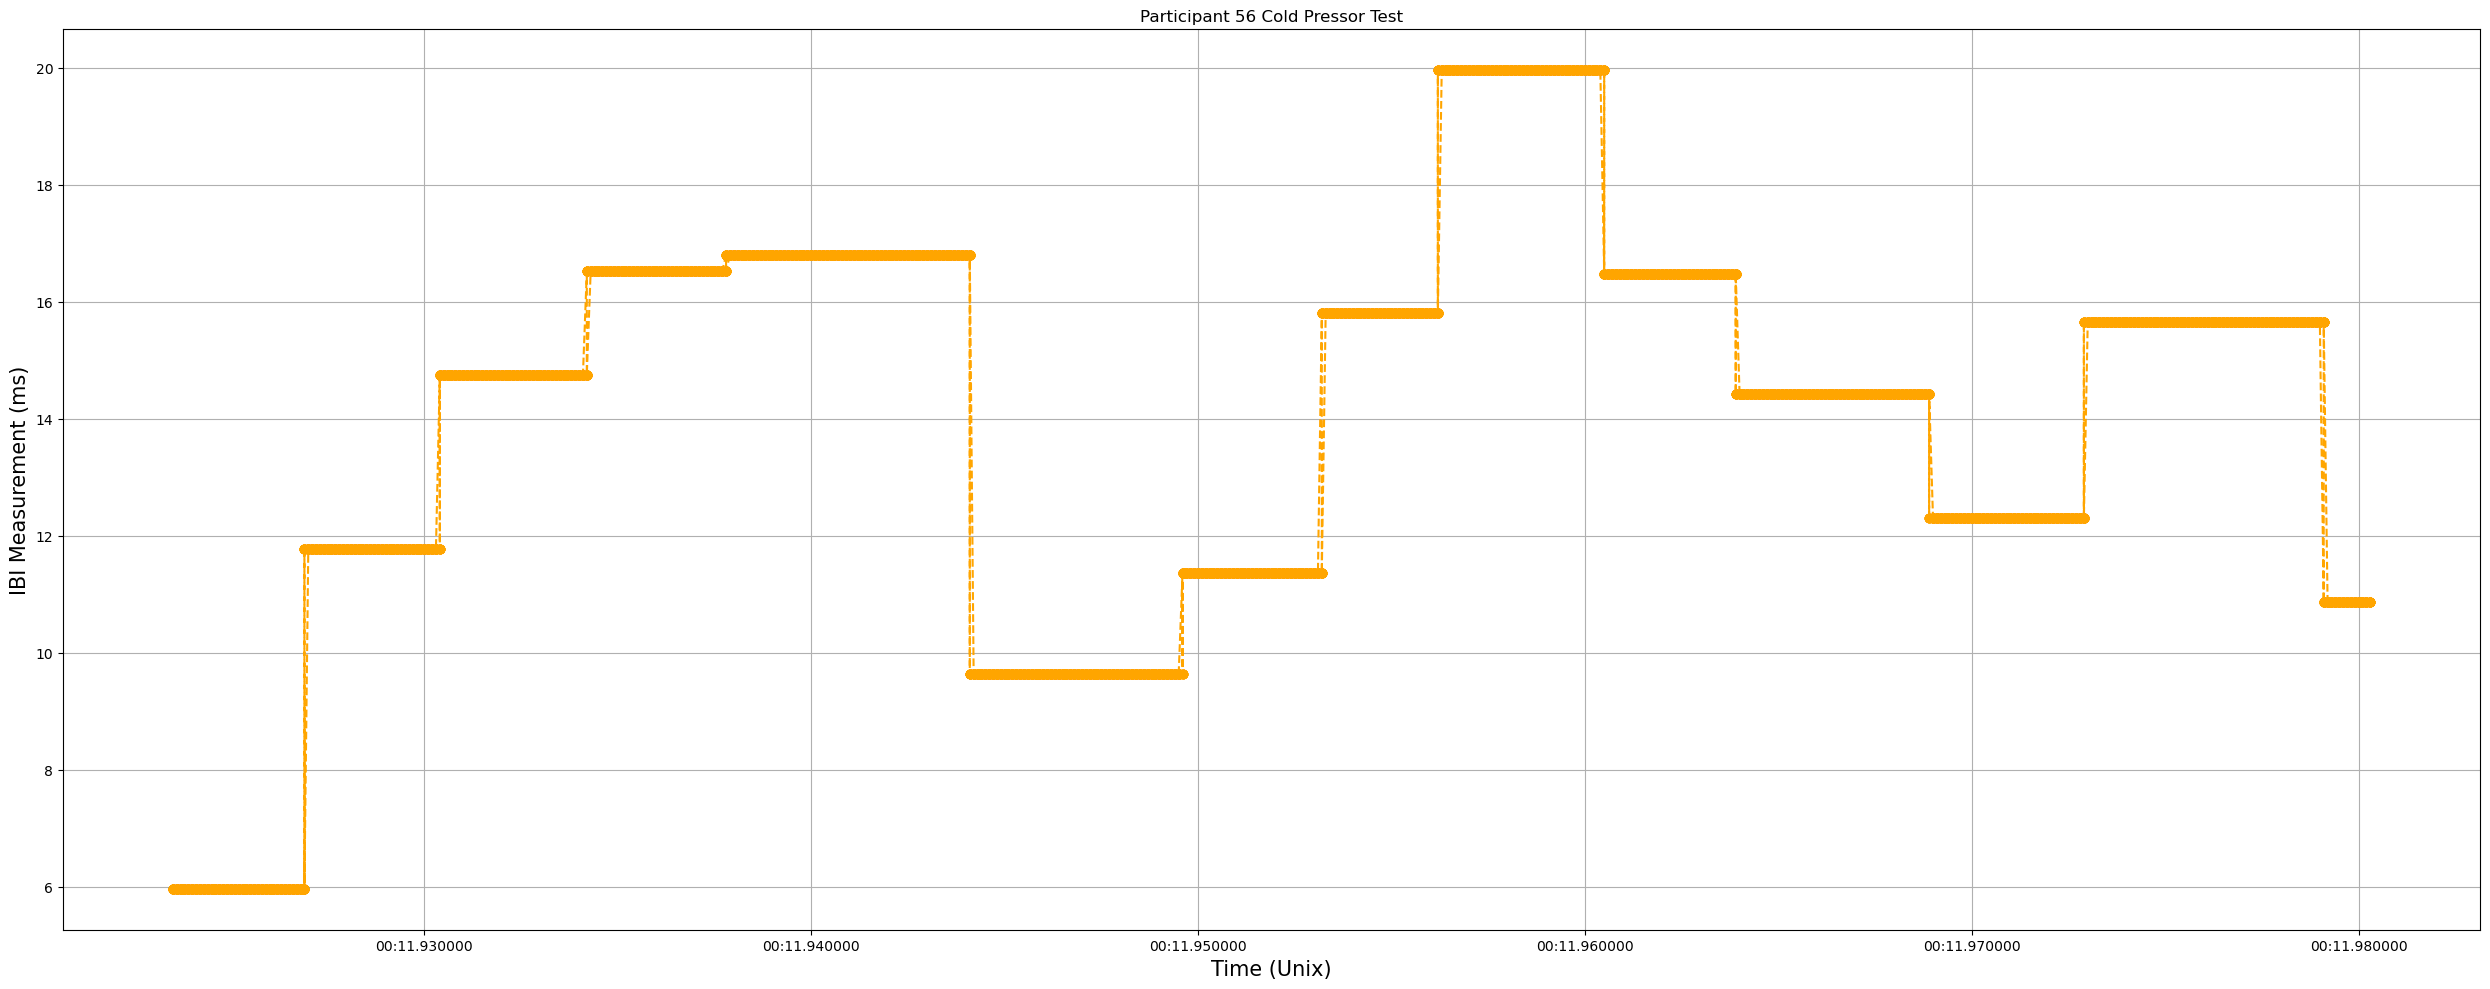

<Figure size 2500x1000 with 0 Axes>

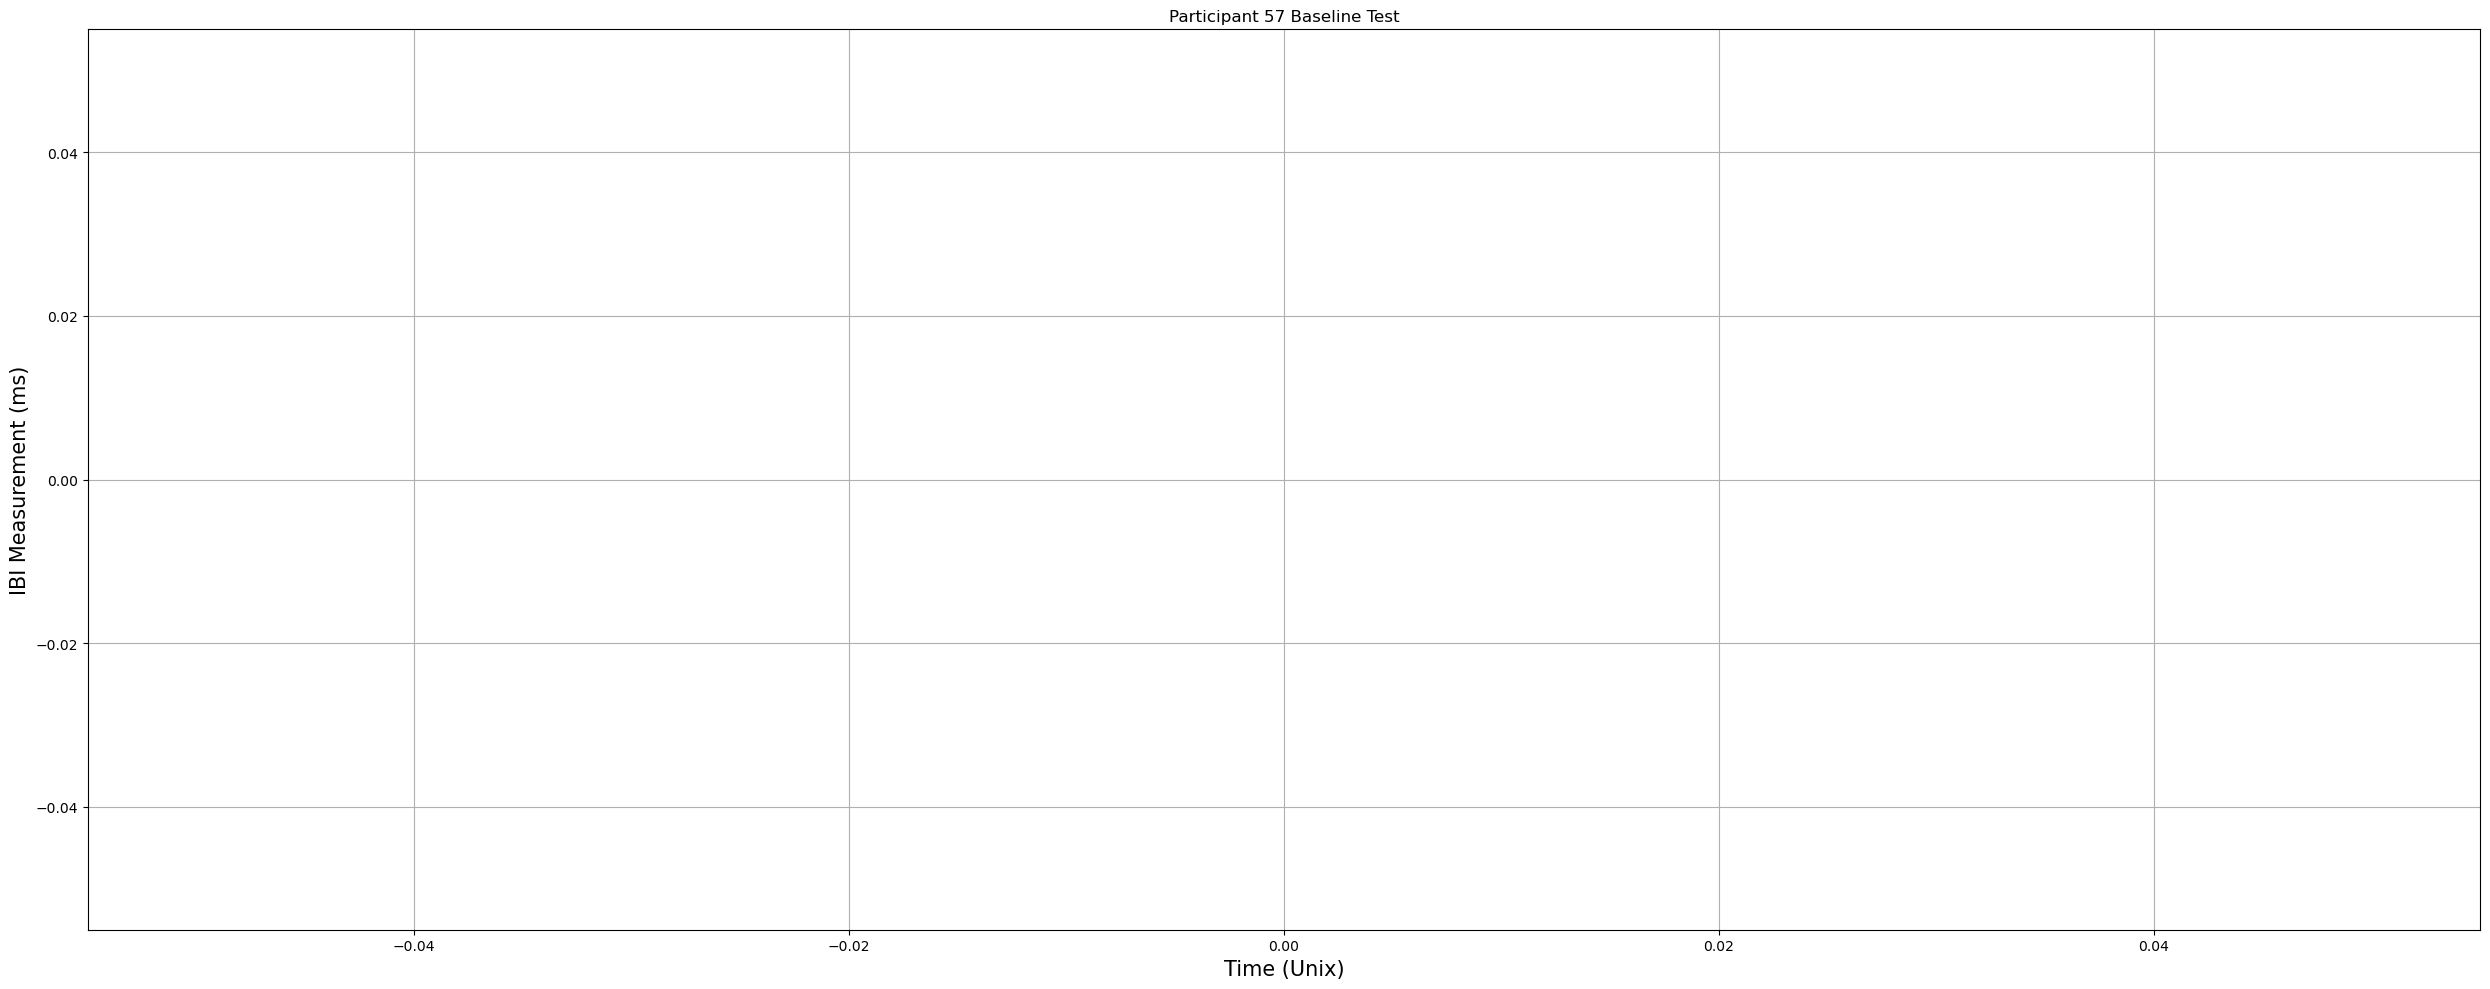

<Figure size 2500x1000 with 0 Axes>

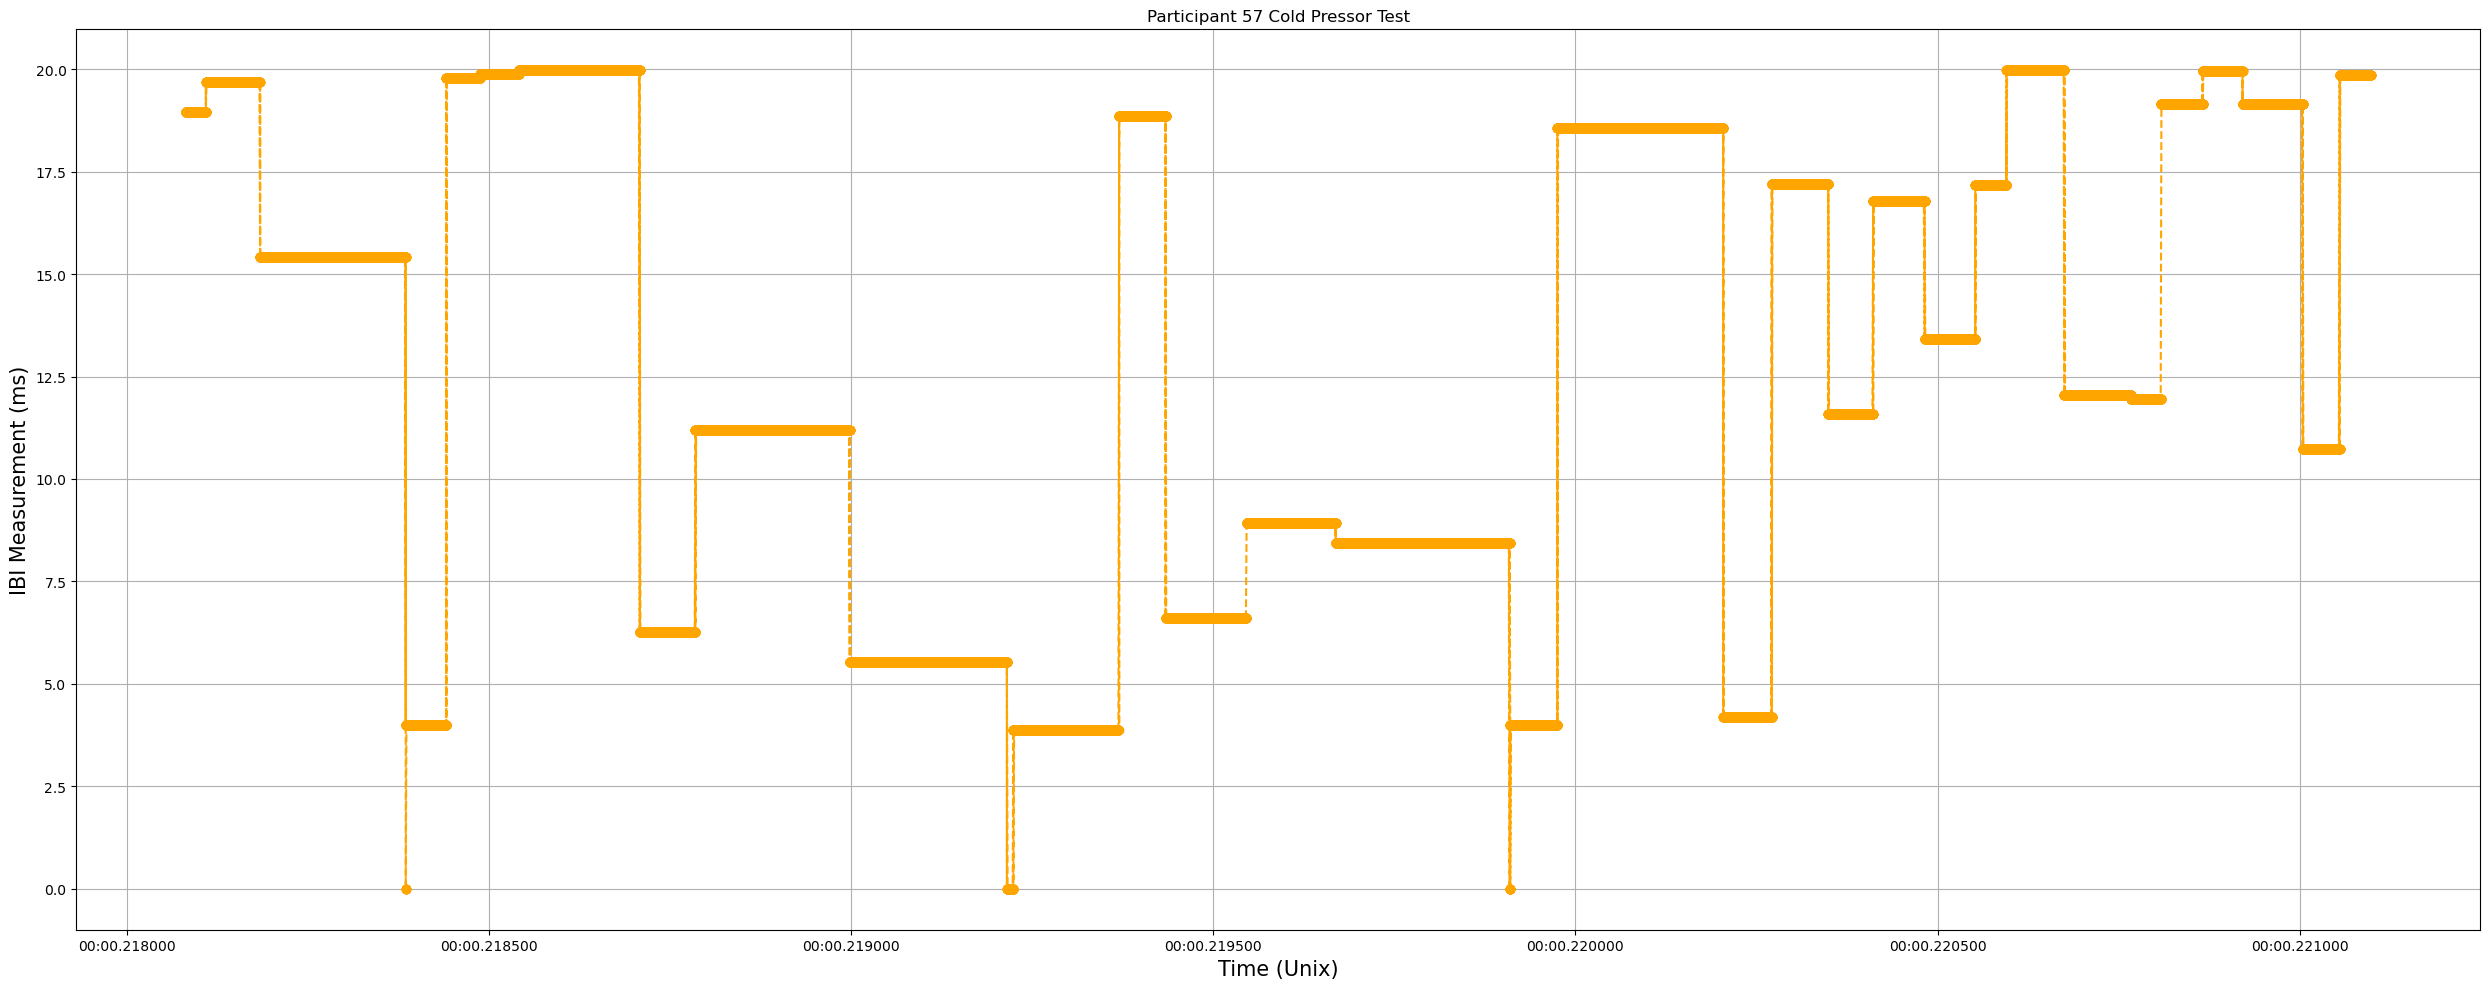

<Figure size 2500x1000 with 0 Axes>

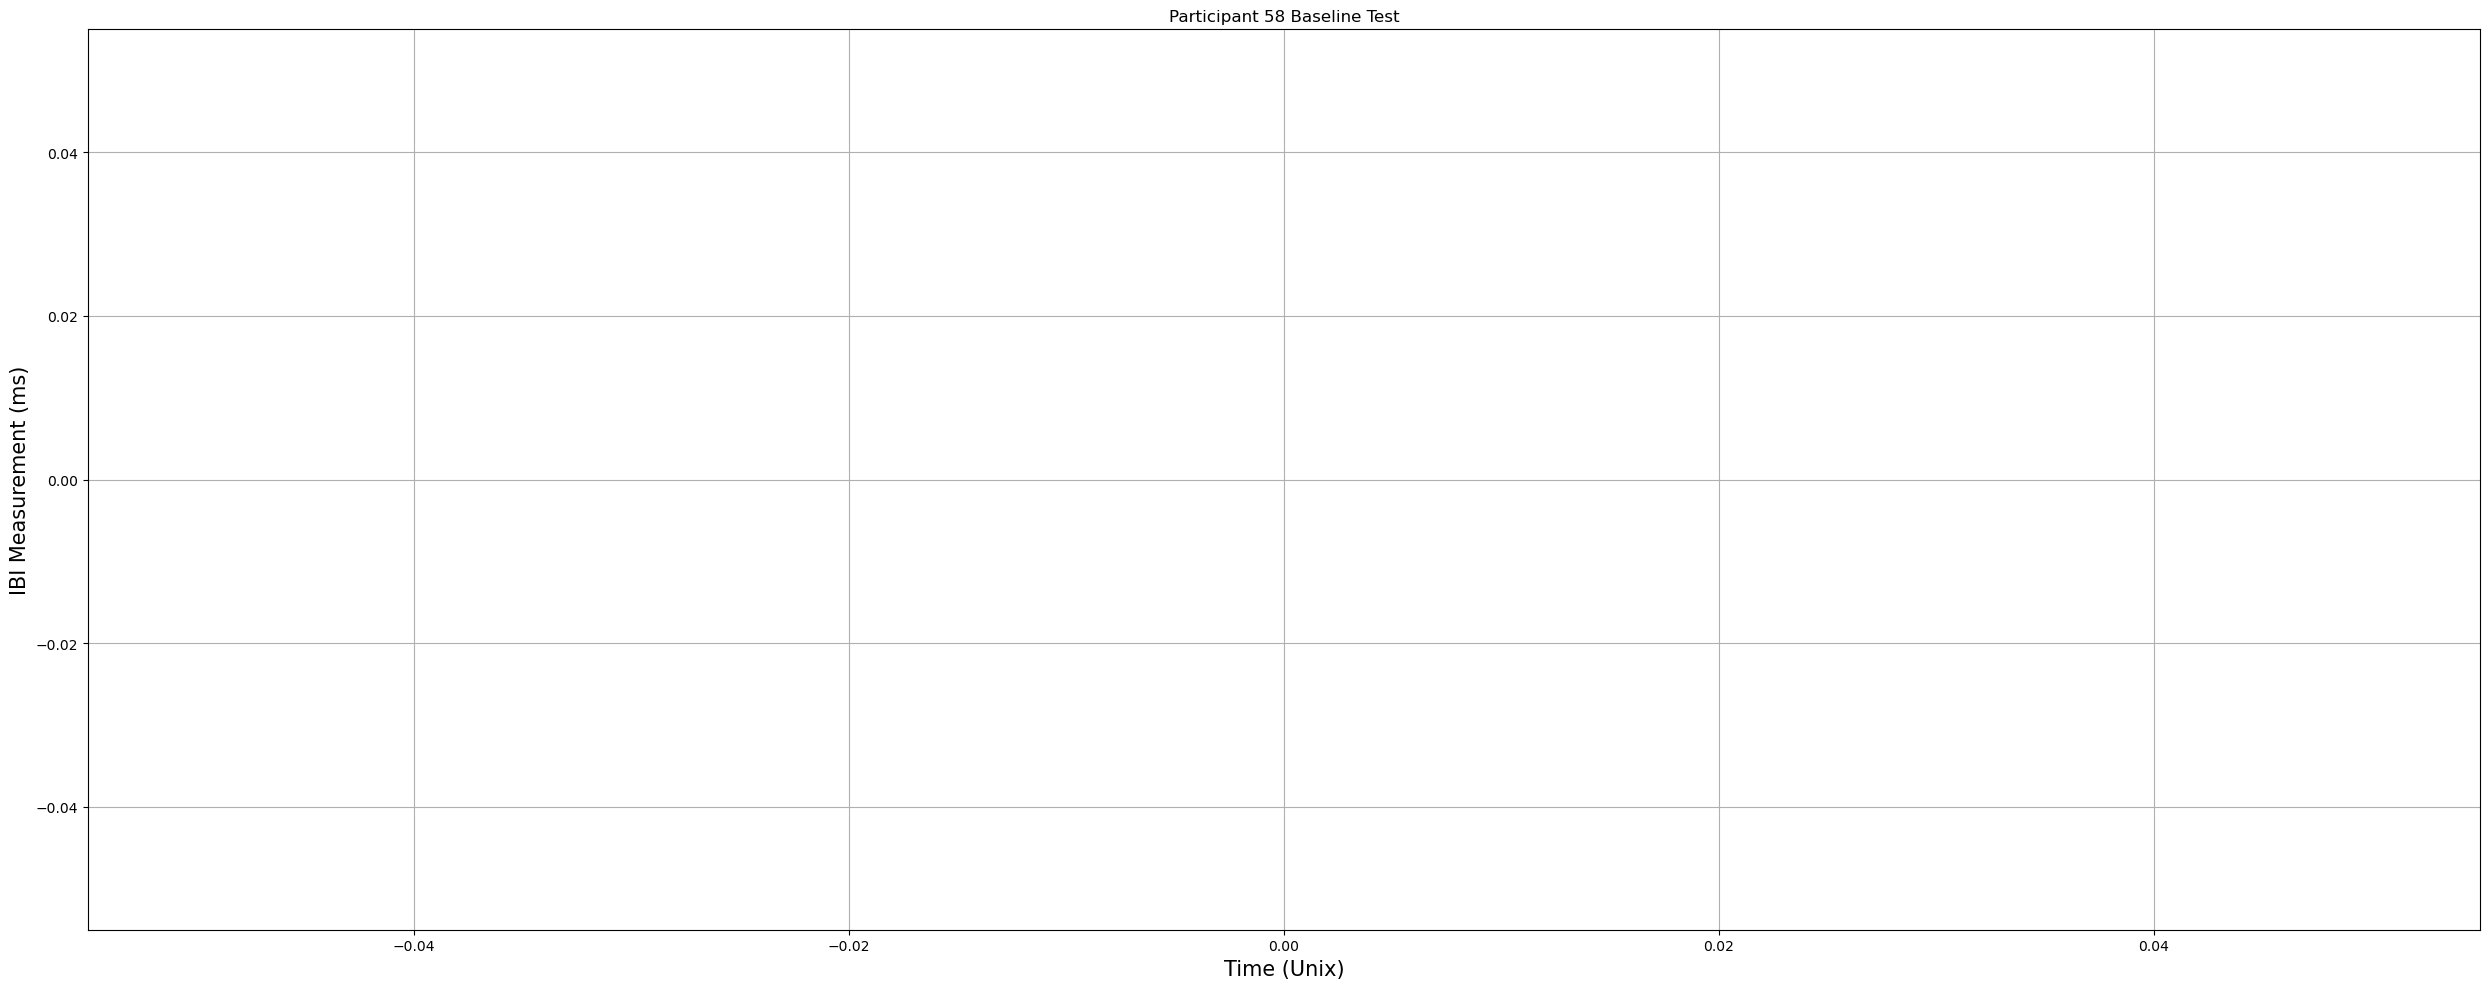

<Figure size 2500x1000 with 0 Axes>

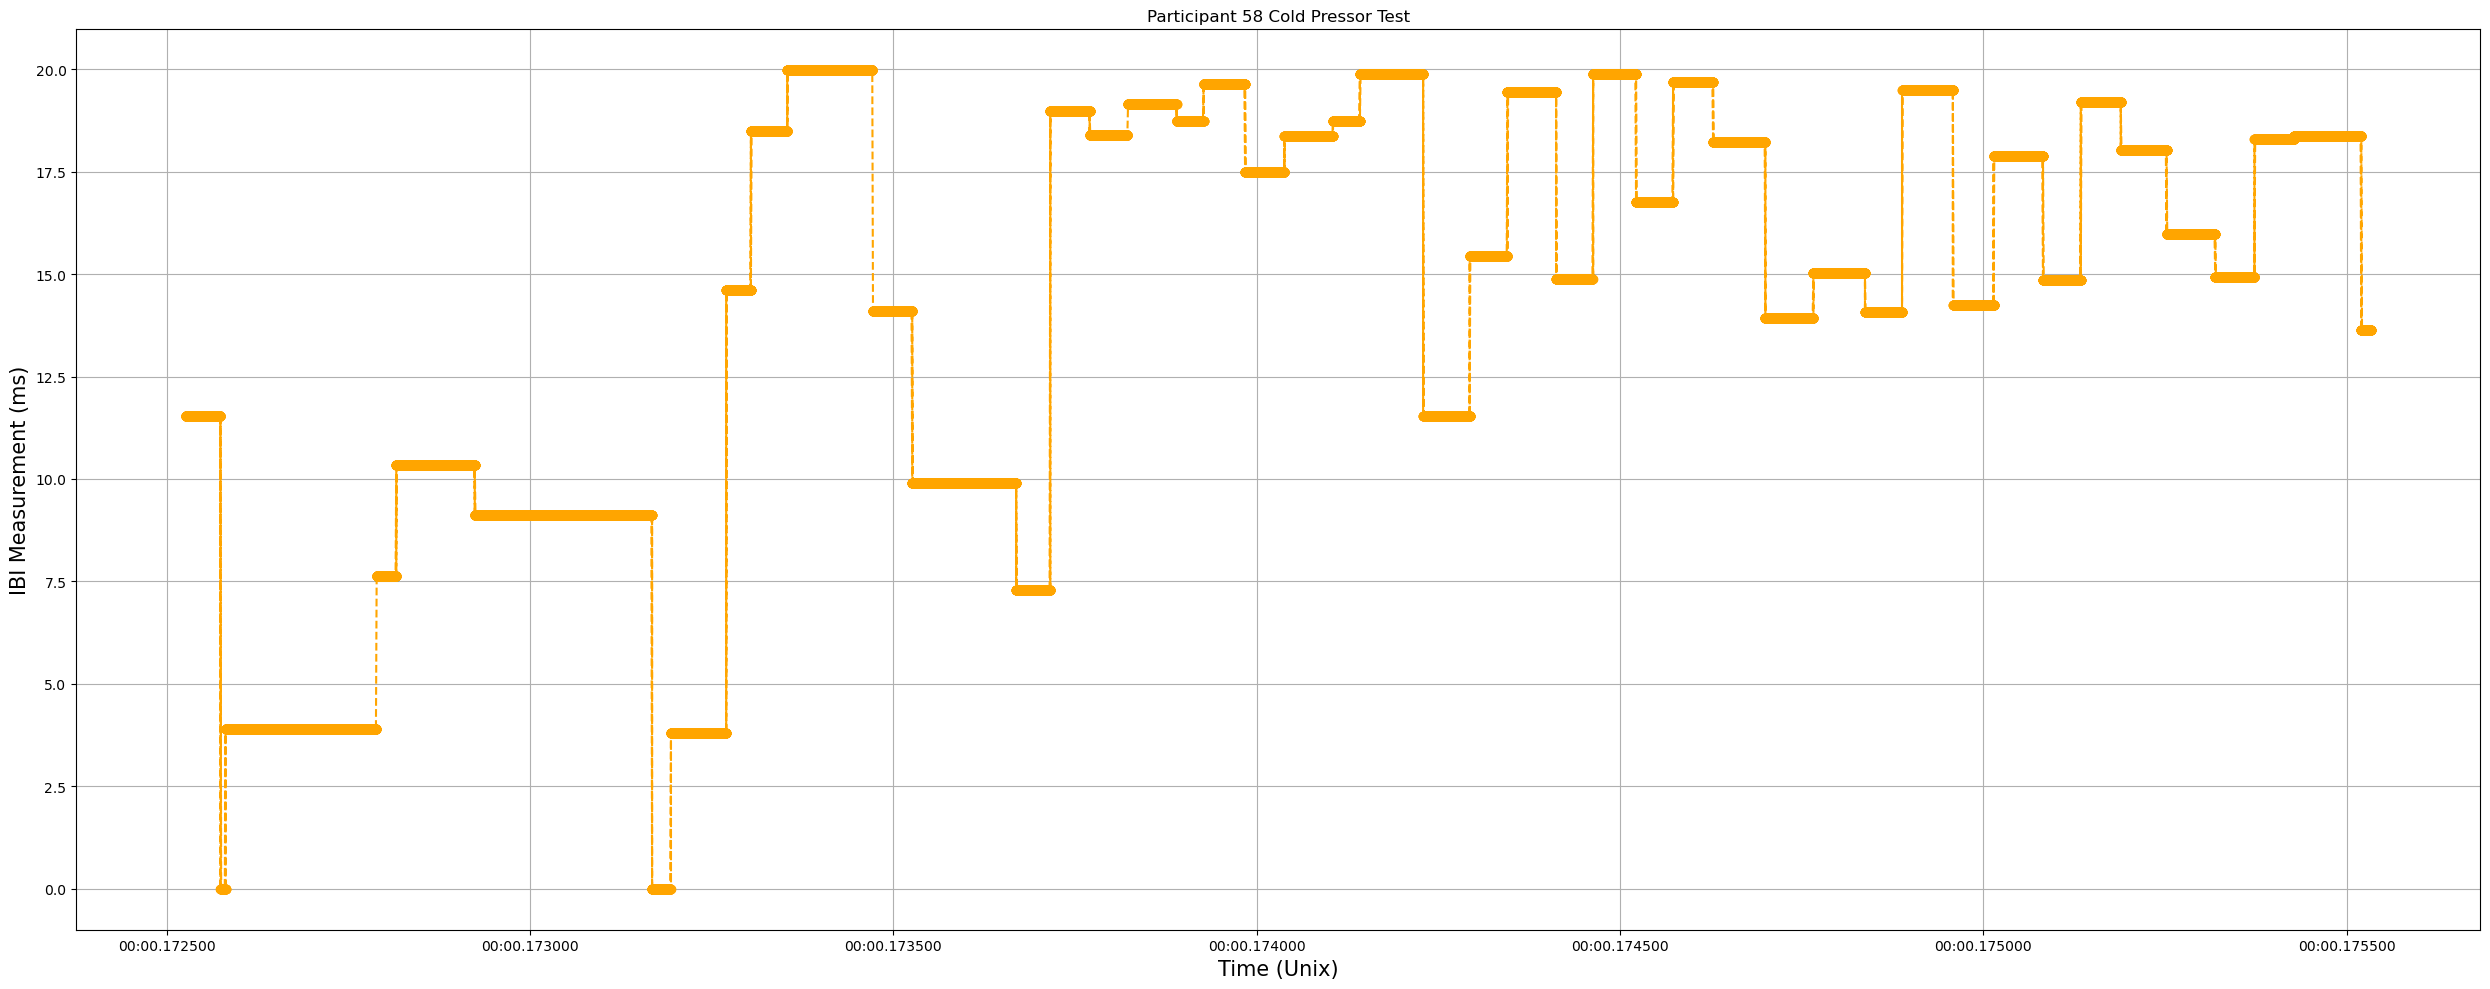

<Figure size 2500x1000 with 0 Axes>

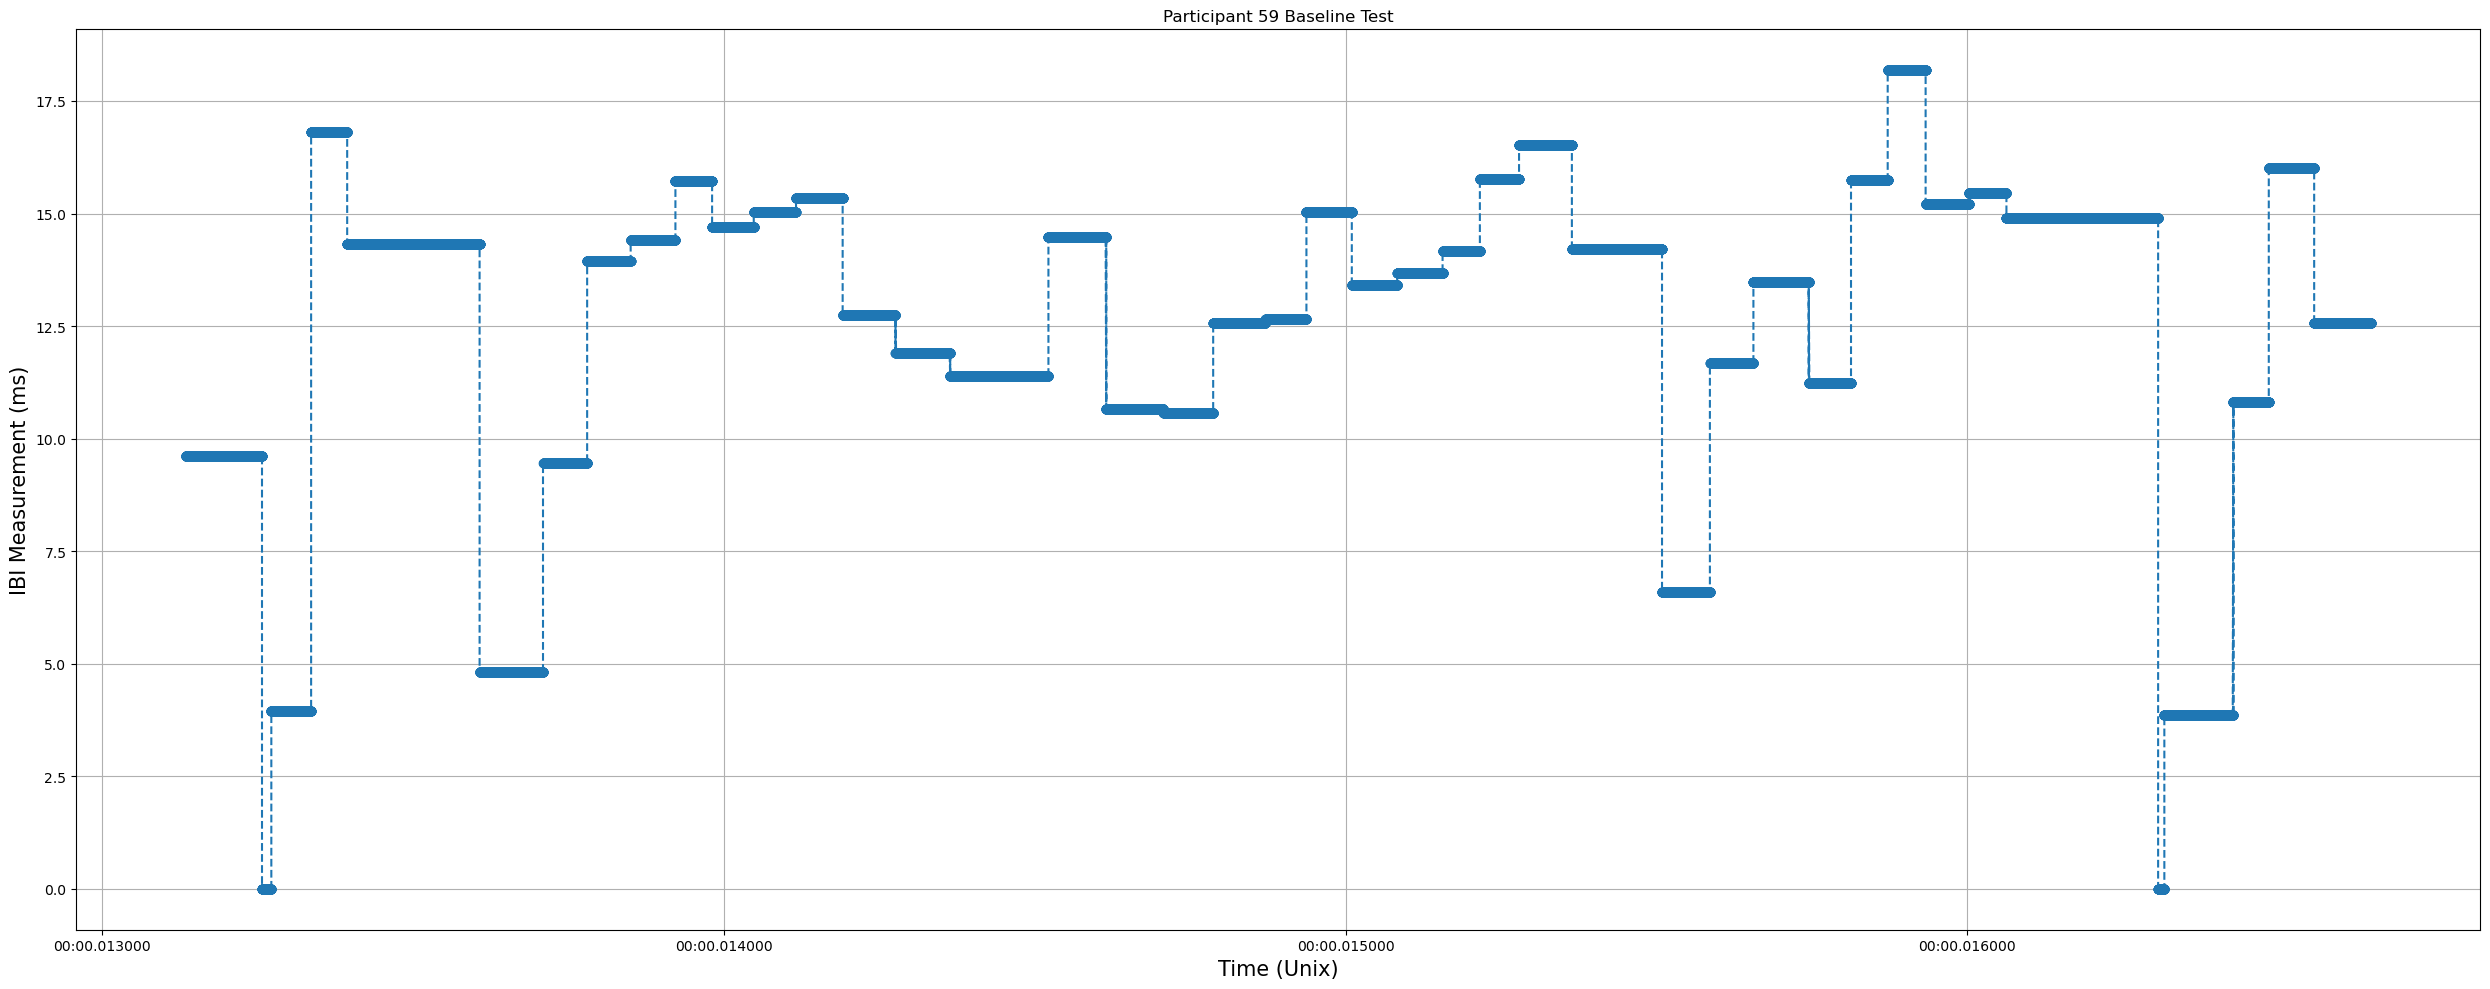

<Figure size 2500x1000 with 0 Axes>

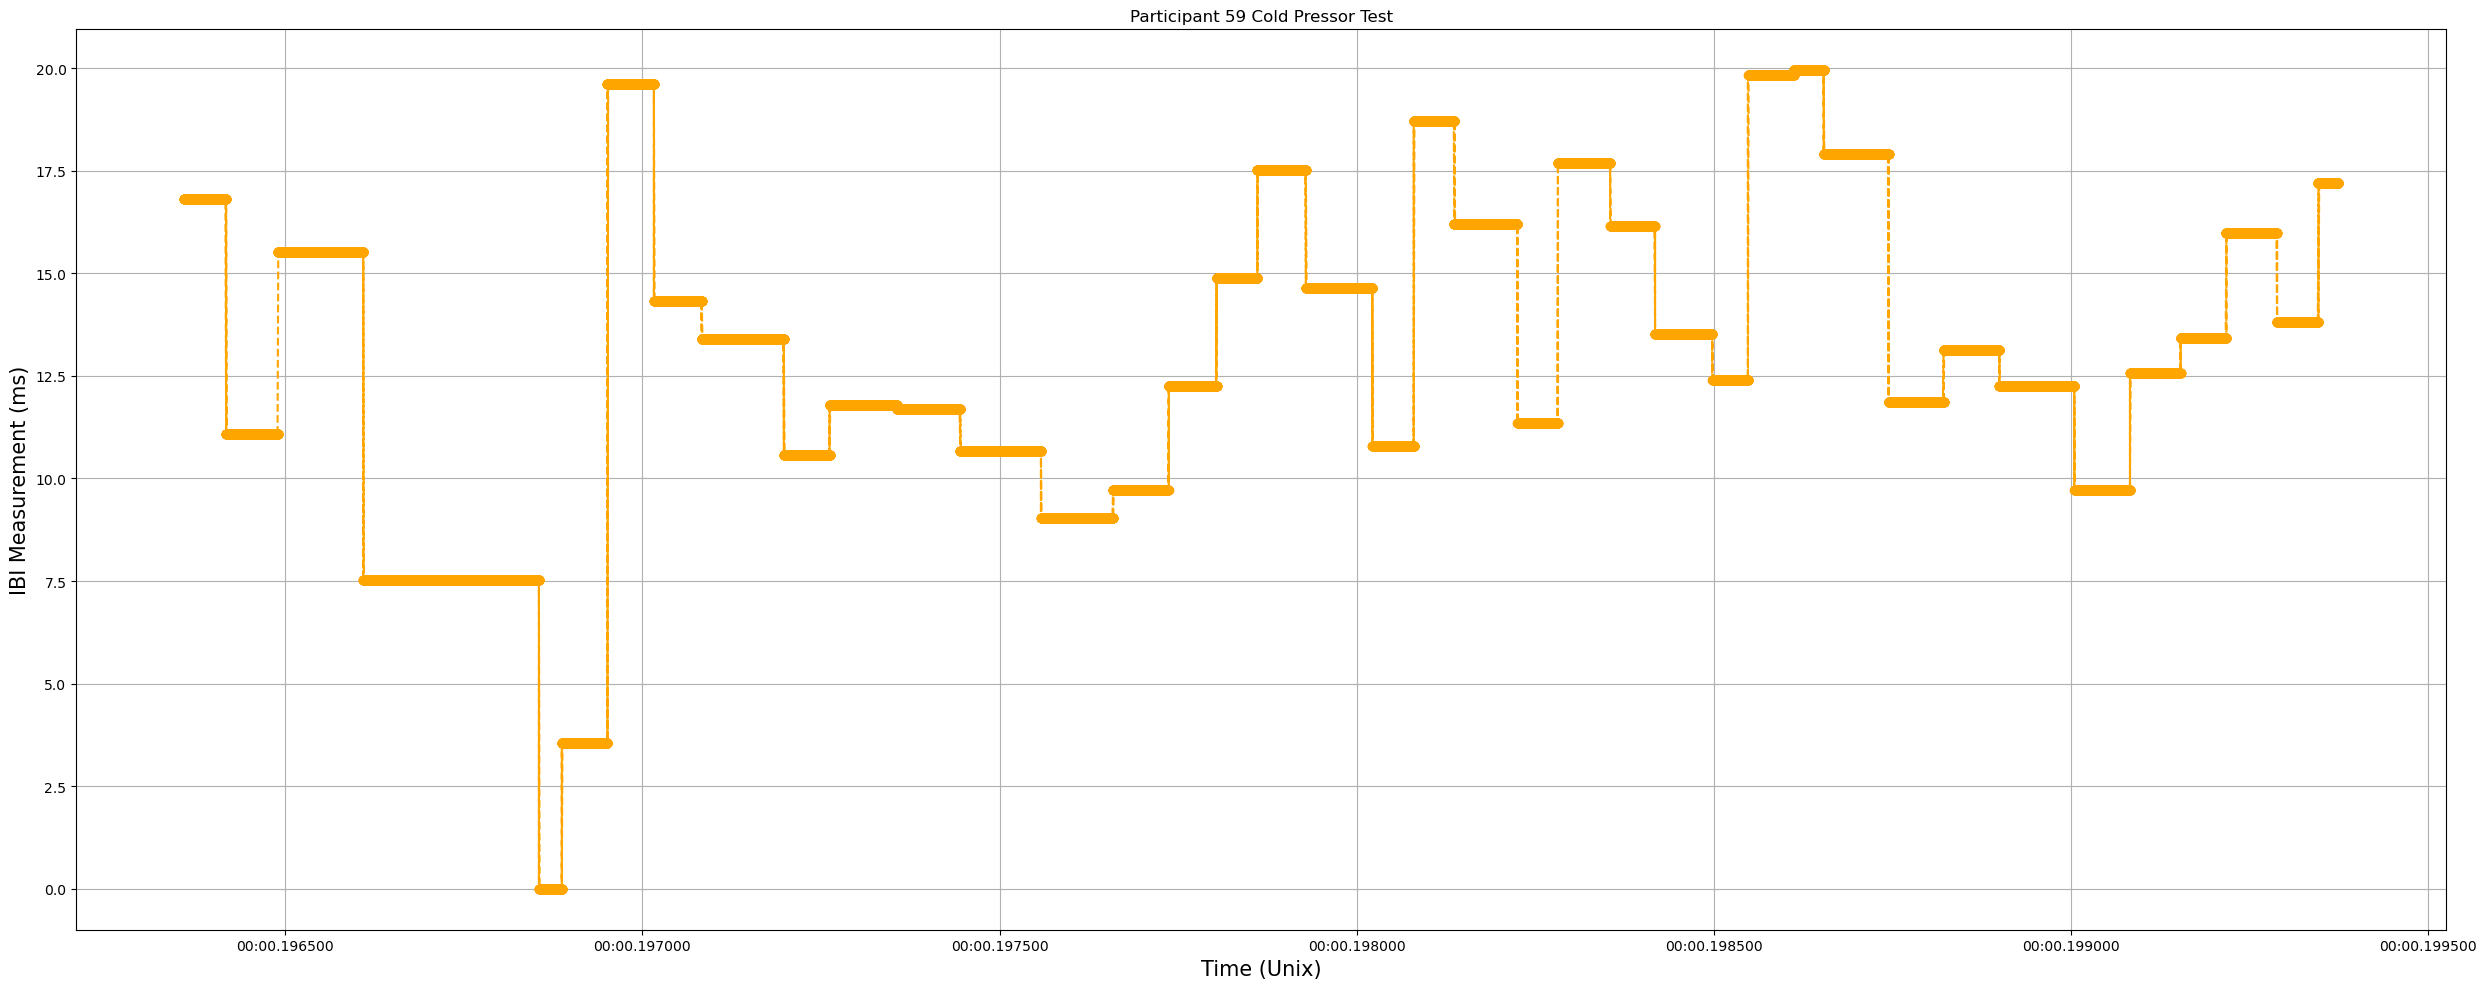

<Figure size 2500x1000 with 0 Axes>

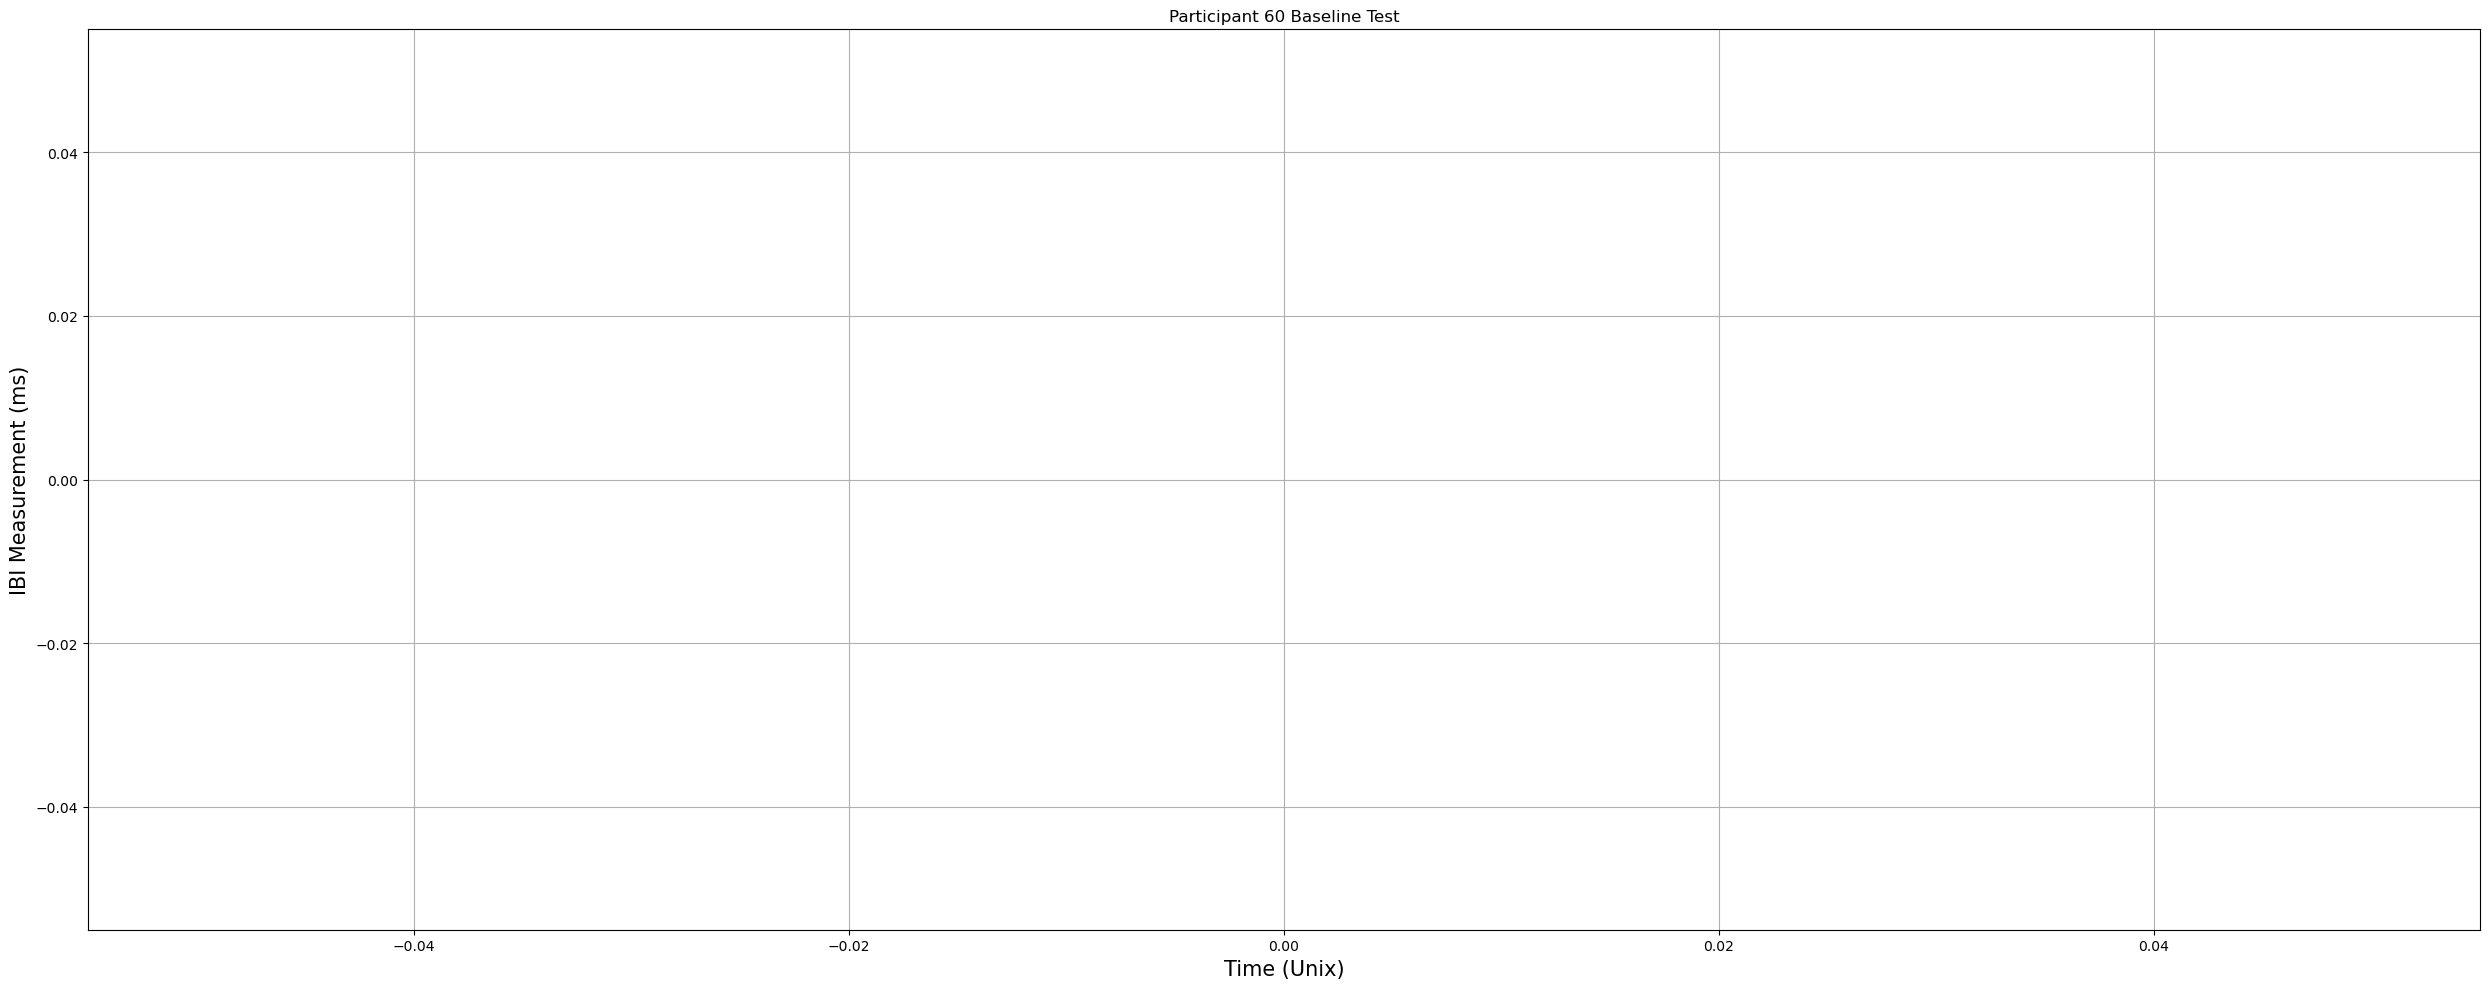

<Figure size 2500x1000 with 0 Axes>

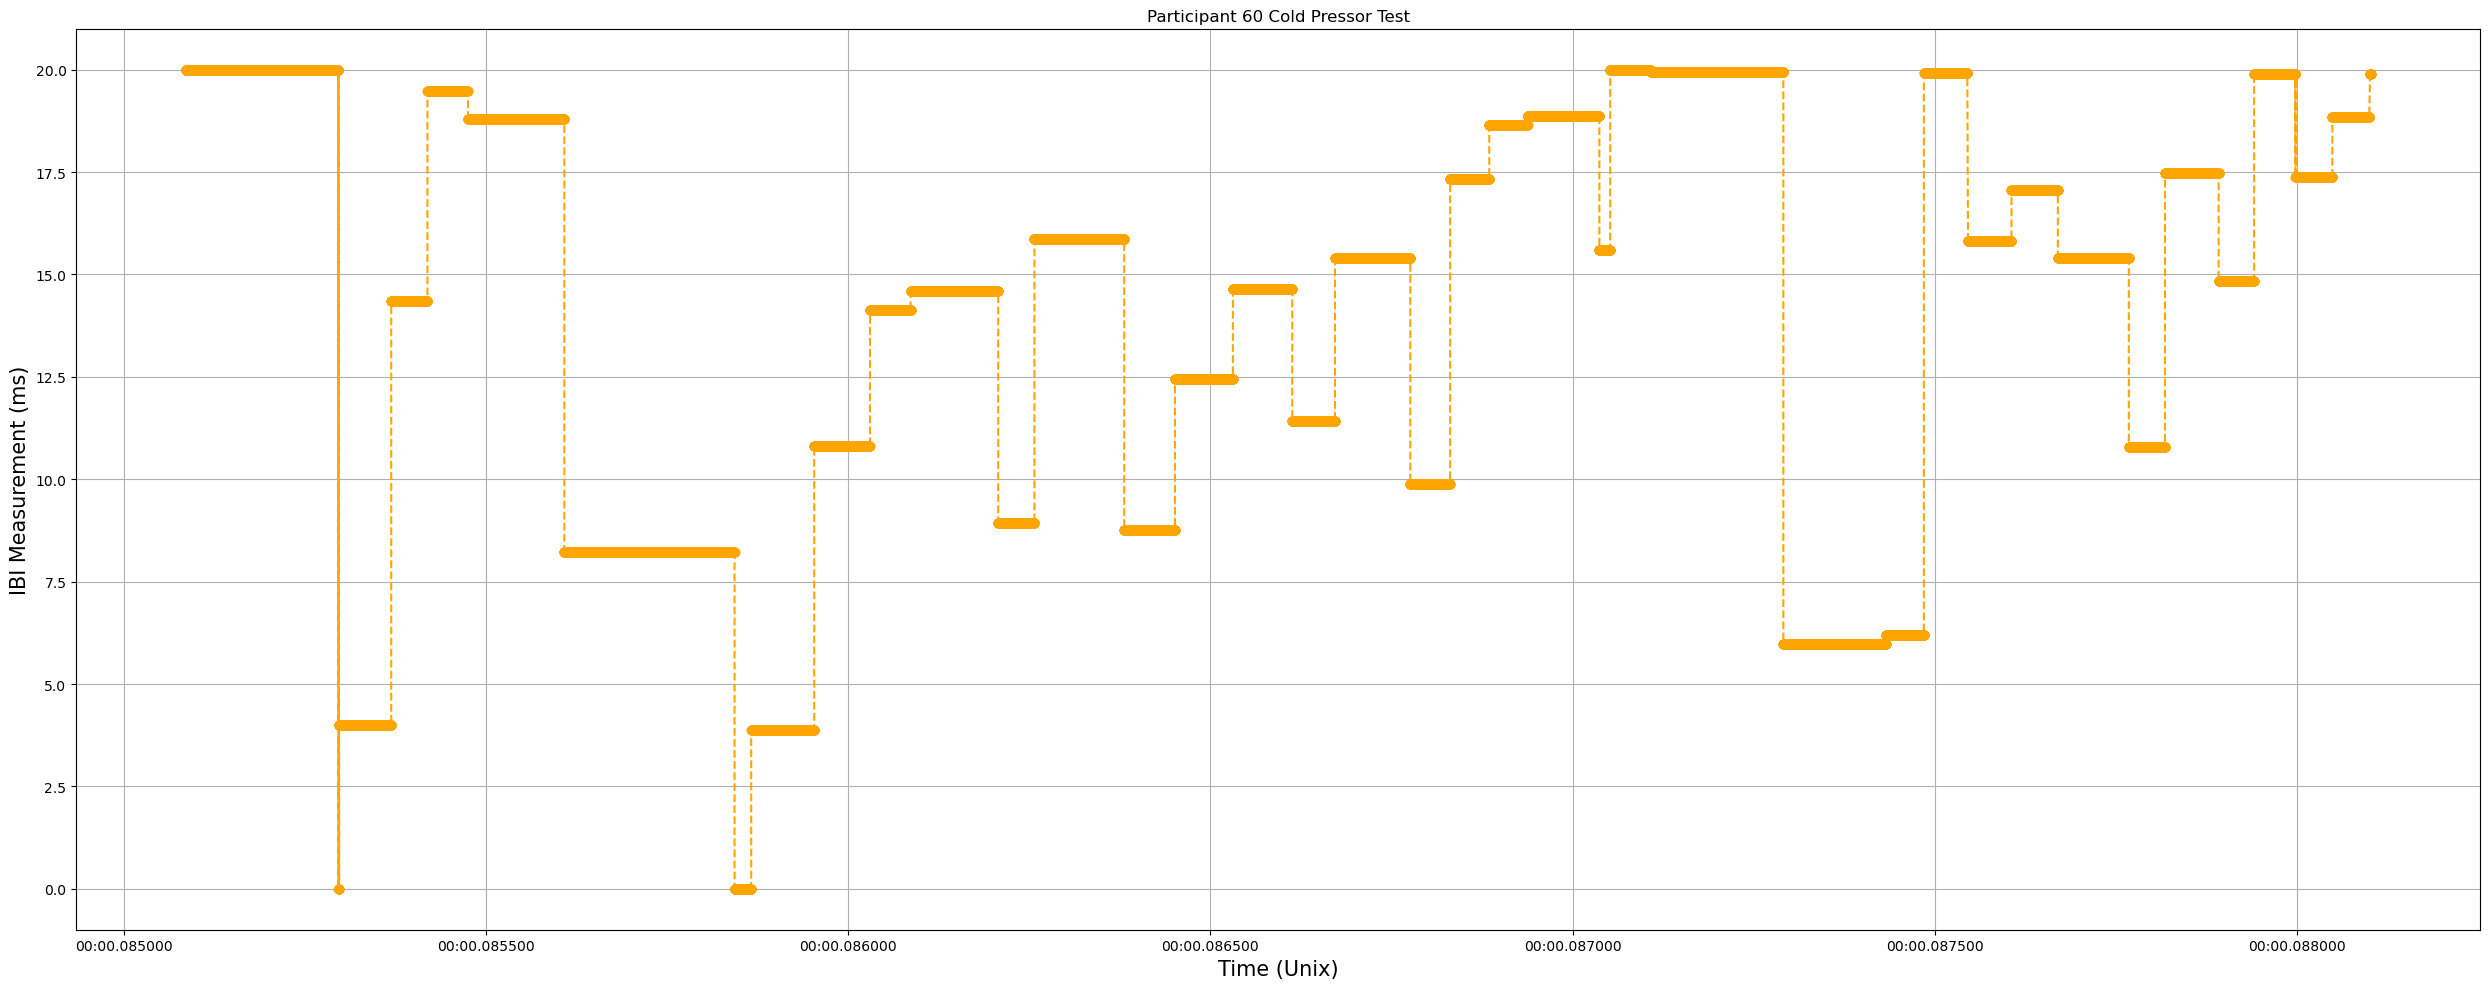

<Figure size 2500x1000 with 0 Axes>

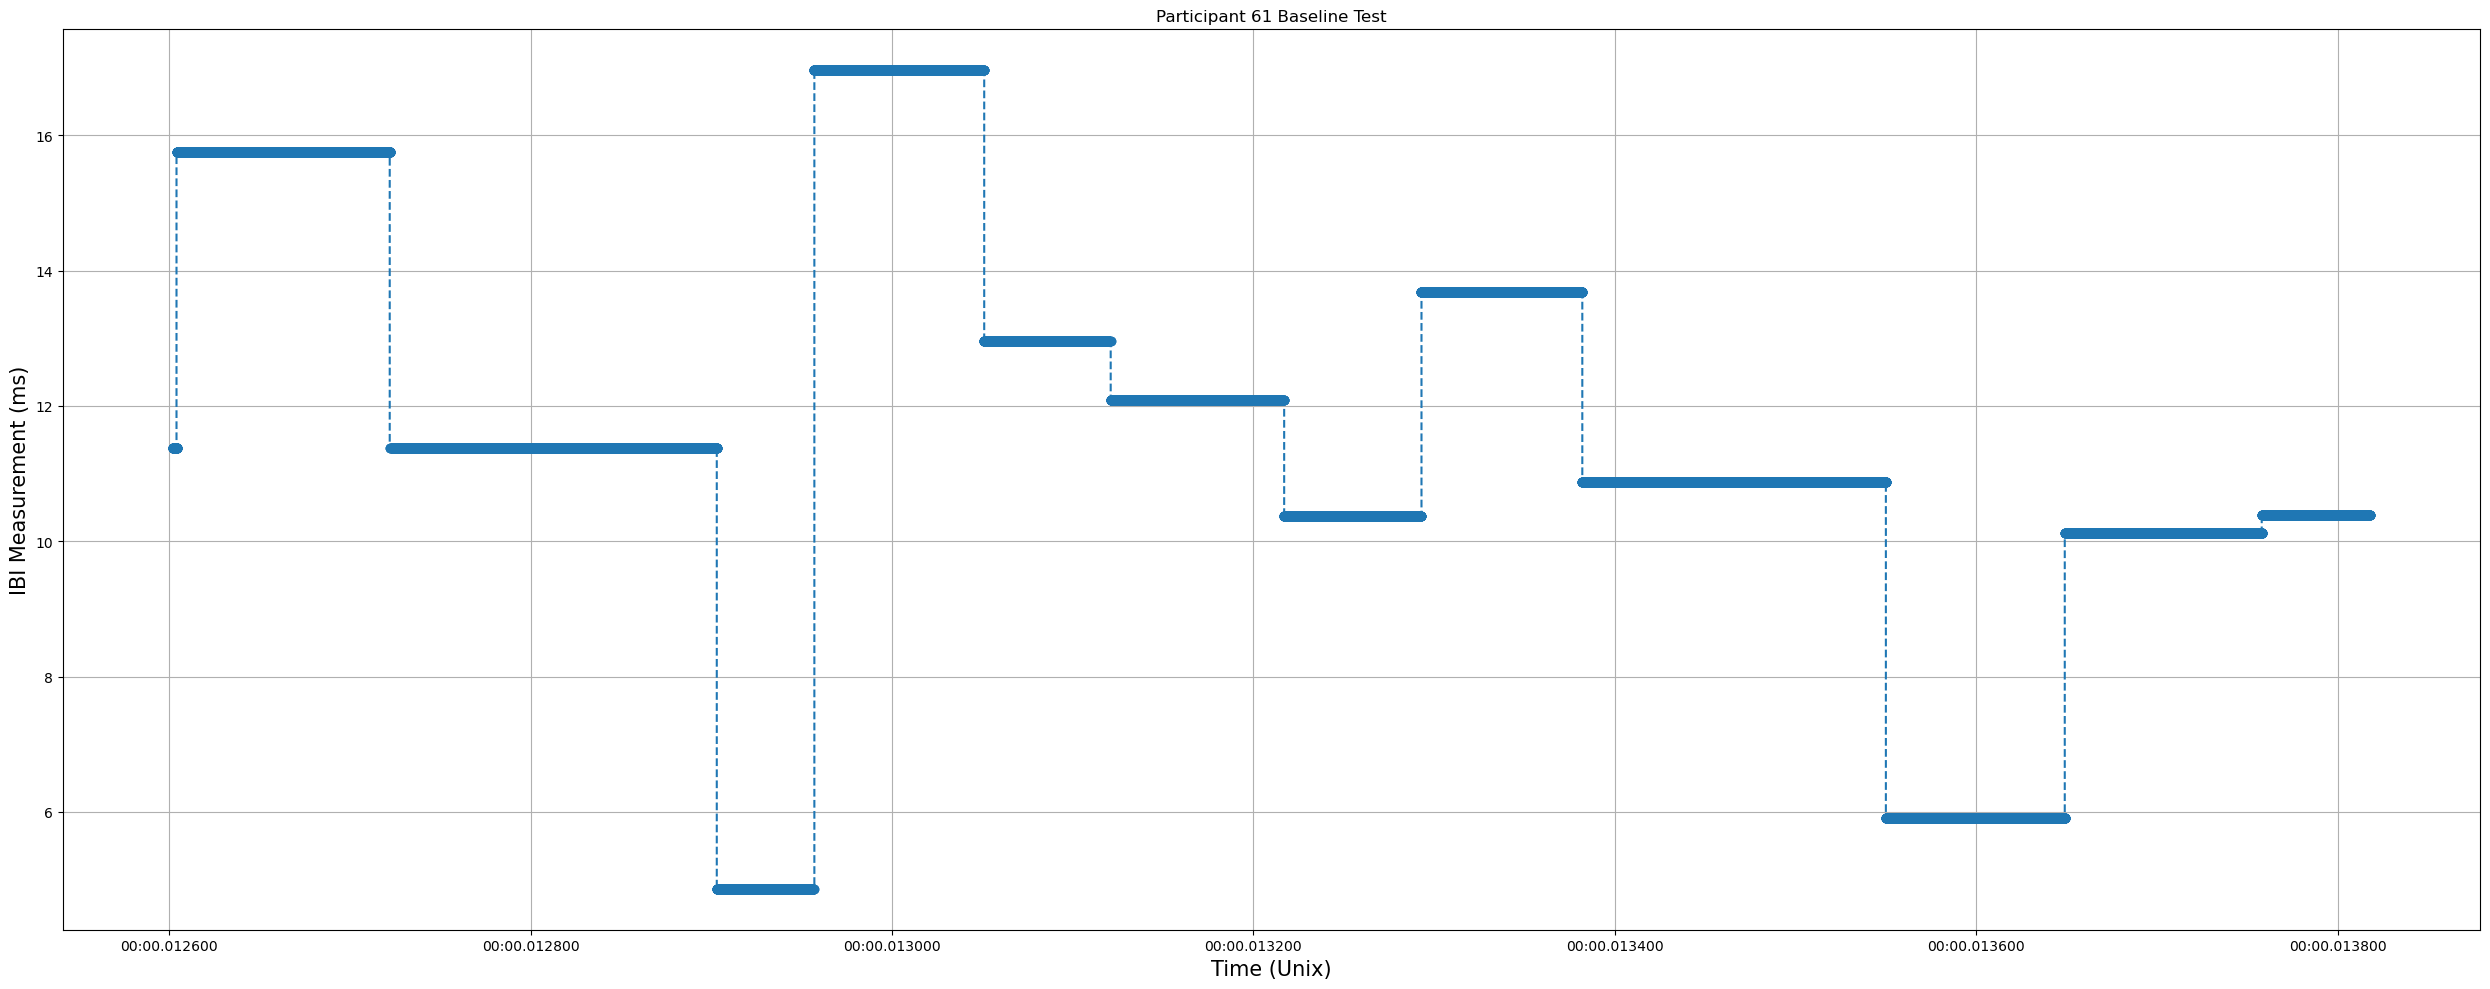

<Figure size 2500x1000 with 0 Axes>

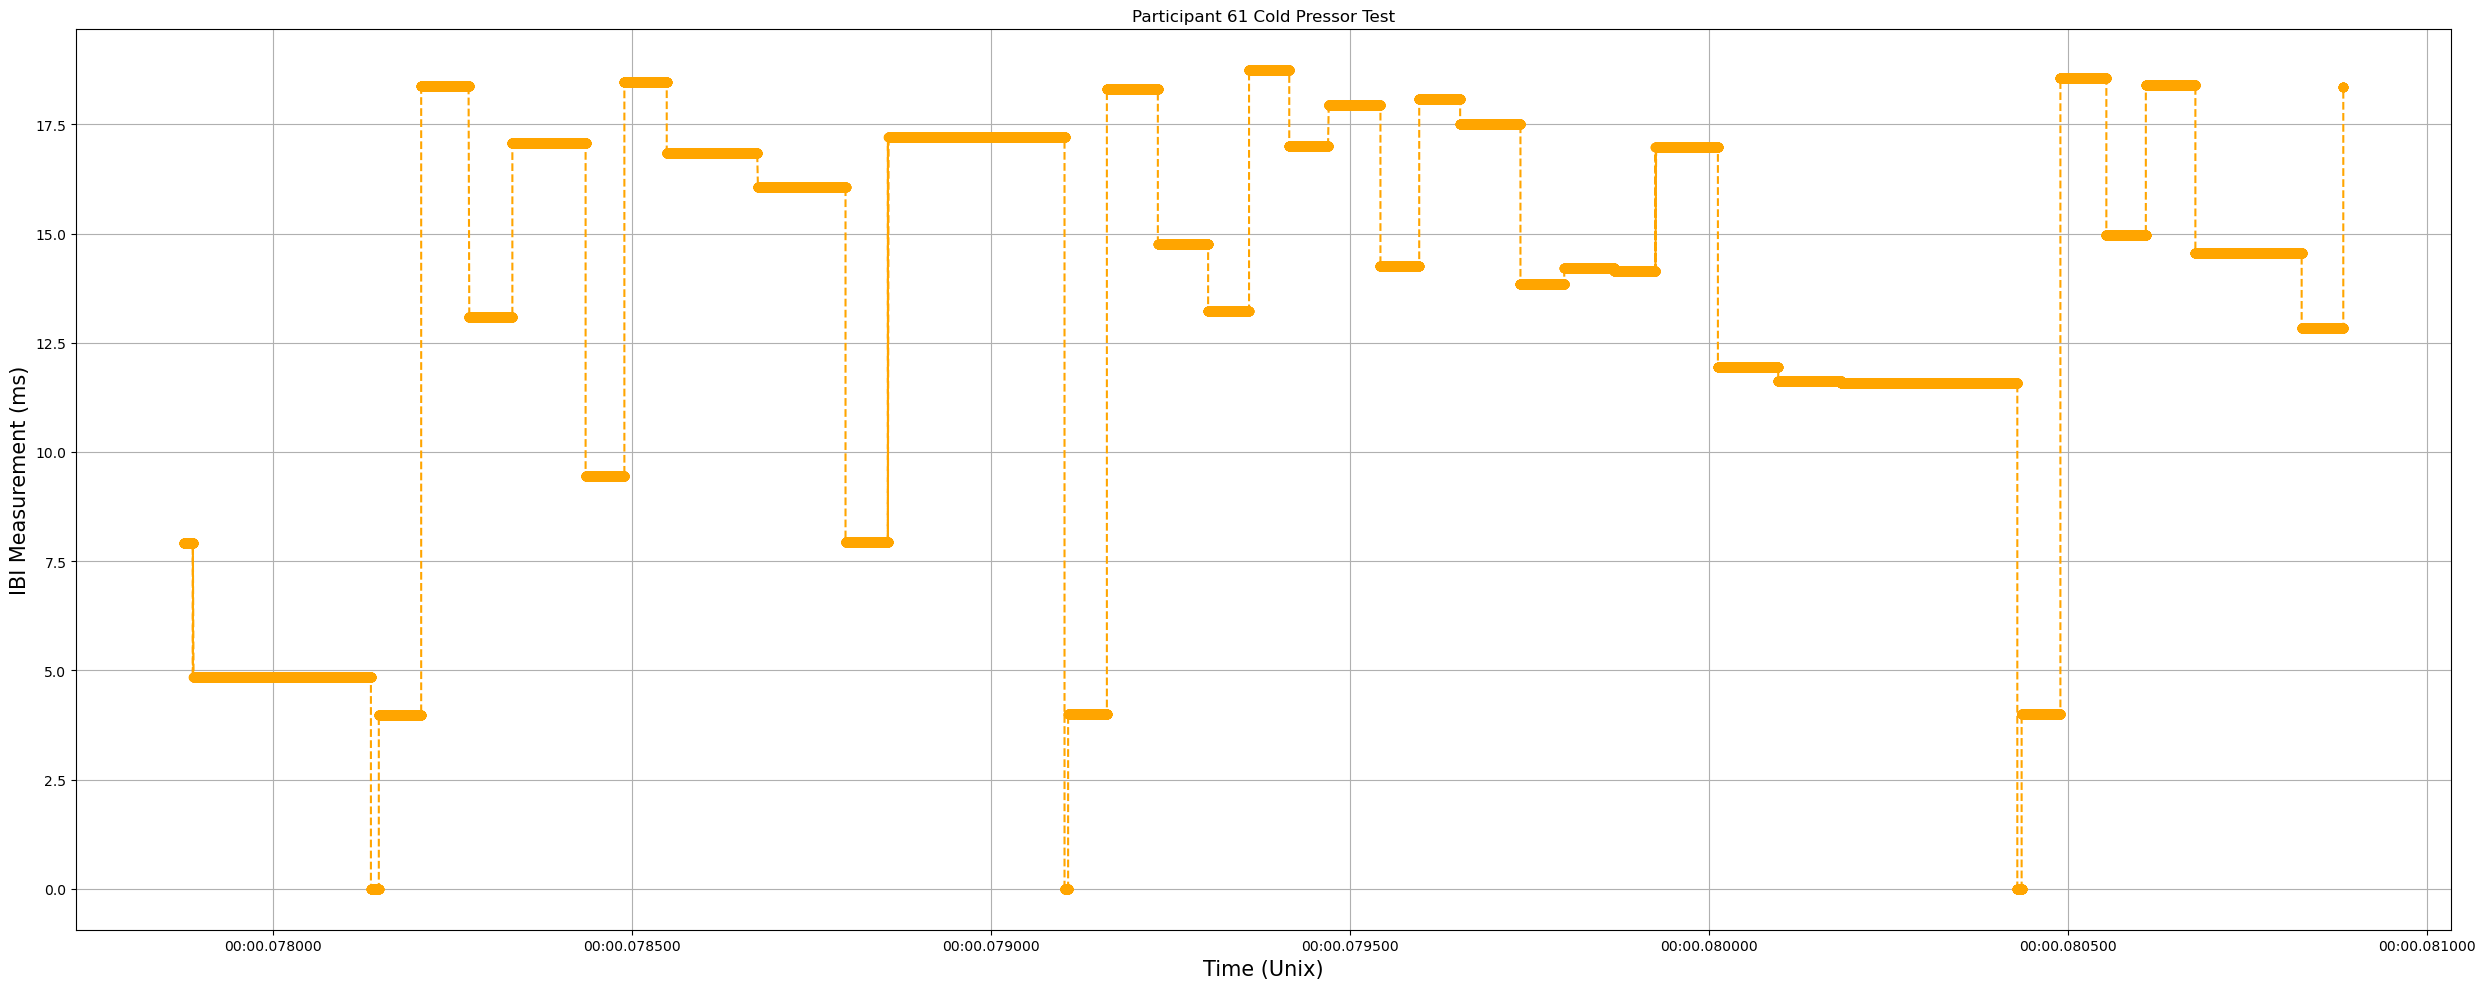

<Figure size 2500x1000 with 0 Axes>

In [25]:
#plot all data for all participants

#init BIOPAC participants
participants = []
participants = [Participant for i in range(62)]

n = 1
while (n<=61):
    if((n != 4) and (n != 43) and (n != 44) and (n!= 47)): # No participants 3, 42, 43
        filename_incrementer = 1000 + ((n-1) * 100) # Filenames are wierdly named so this variable assigns an n to the number in the filename 
        participants[n] = Participant(".\\raw_data\\raw_data_biopac\\" + str(filename_incrementer) + "-BL.csv",
                                      ".\\raw_data\\raw_data_biopac\\" + str(filename_incrementer) + "-SECPT.csv",n)
        participants[n].plot_baseline()
        plt.clf()
        participants[n].plot_coldpressor()
        plt.clf()
#         participants[n].plot_both()
#         plt.clf()
        
    n = n + 1